# Load required packages

In [97]:
#if you have not installed any of those packages
# use command "!pip3 install packagename" to install them first

import ee

import pandas as pd 
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer 
from sklearn.metrics import matthews_corrcoef, roc_auc_score, plot_confusion_matrix

# Load Land Classification Data 

In [98]:
df = pd.read_csv("landclass_locust.csv")
display(df.head(5))
df['date']=pd.DatetimeIndex(df['date'])
display(df.head(5))
display(df['lcc'].value_counts())

,lat,long,date,lcc
0,-0.559788,37.478215,4/7/2021,Cultivated and managed vegetation/agriculture ...
1,-2.441984,40.161785,7/13/2020,"Open forest, unknown"
2,-0.651670,38.402958,4/4/2021,Urban / built up
3,-0.610328,38.112466,2/5/2021,Cultivated and managed vegetation/agriculture ...
4,0.120728,37.069462,2/11/2021,Cultivated and managed vegetation/agriculture ...


,lat,long,date,lcc
0,-0.559788,37.478215,2021-04-07,Cultivated and managed vegetation/agriculture ...
1,-2.441984,40.161785,2020-07-13,"Open forest, unknown"
2,-0.651670,38.402958,2021-04-04,Urban / built up
3,-0.610328,38.112466,2021-02-05,Cultivated and managed vegetation/agriculture ...
4,0.120728,37.069462,2021-02-11,Cultivated and managed vegetation/agriculture ...


Cultivated and managed vegetation/agriculture (cropland)    300
Urban / built up                                            300
Open forest, unknown                                        300
Name: lcc, dtype: int64

/home/plantvillage/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

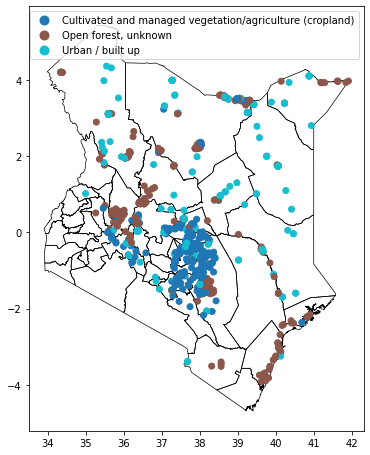

In [99]:
#Plot data in Kenya map

kenya = gpd.read_file(r'kenya_shapefile/County.shp')
gdf = gpd.GeoDataFrame(
    df,
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(df.long, df.lat)])


fig, ax = plt.subplots(1, 1,figsize=(6, 10))

kenya.plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)#color = 'yellow')
gdf.plot(column = 'lcc', ax = ax, legend=True)

# Extract Sentinel2 Band Values to Points

In [68]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AY0e-g6x-g1m2tD3j59llJs1grkOUAx35__ezIQMaILkuM9f935EqKO6FAg

Successfully saved authorization token.


In [101]:
#Create two date columns to define the date period of the Sentinel2 images
df['date_min']= df['date'] -  pd.to_timedelta(16, unit='d')
df['date_max']= df['date'] +  pd.to_timedelta(16, unit='d')
df.head()

,lat,long,date,lcc,geometry,date_min,date_max
0,-0.559788,37.478215,2021-04-07,Cultivated and managed vegetation/agriculture ...,POINT (37.47821 -0.55979),2021-03-22,2021-04-23
1,-2.441984,40.161785,2020-07-13,"Open forest, unknown",POINT (40.16179 -2.44198),2020-06-27,2020-07-29
2,-0.651670,38.402958,2021-04-04,Urban / built up,POINT (38.40296 -0.65167),2021-03-19,2021-04-20
3,-0.610328,38.112466,2021-02-05,Cultivated and managed vegetation/agriculture ...,POINT (38.11247 -0.61033),2021-01-20,2021-02-21
4,0.120728,37.069462,2021-02-11,Cultivated and managed vegetation/agriculture ...,POINT (37.06946 0.12073),2021-01-26,2021-02-27


In [115]:
def extract_to_point(x):
    bands_s2 = ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']
    lat = x['lat']
    long = x['long']
    p = ee.Geometry.Point([long,lat])
    
    #select image based on following criteria:
    #within the date range we defined
    #sort all images by cloud cover 
    #select images containing our point of image
    #least cloud-covered images
    
    img = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterDate(x['date_min'].strftime('%Y-%m-%d'), x['date_max'].strftime('%Y-%m-%d')) \
    .sort('CLOUD_COVER') \
    .filterBounds(p) \
    .first()
    try: 
        #extract value from the above image to the point of interest
        temp = img.select(bands_s2).sampleRegions(collection=p, scale=10, geometries=True)
        info = temp.getInfo()
        print("info: ", info)
        print(" ")
        values = tt['features'][0]['properties']
        print("values: ", values)
        print(" ")
    except:
        values = {'B11':0, 'B12':0, 'B2':0, 'B3':0, 'B4':0, 'B5':0, 'B6':0, 'B7':0, 'B8':0, 'B8A':0, 'B9':0}
    return values

In [116]:
### DO NOT Run this command for the interest of time ### 
### result = df.apply(extract_to_point,axis=1,result_type='reduce')
### s2=pd.DataFrame(result.tolist())
### s2['lat']=df['lat']
### s2['long']=df['long']
### s2['date']=df['date']
### s2['lcc']=df['lcc']

In [120]:
# An example showing what extract_to_point function is doing #
example = df.iloc[3:5,:].apply(extract_to_point,axis=1,result_type='reduce')
example

info:  {'type': 'FeatureCollection', 'columns': {}, 'properties': {'band_order': ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']}, 'features': [{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [38.11249945740845, -0.6103030751136557]}, 'id': '0_0', 'properties': {'B11': 5513, 'B12': 4047, 'B2': 8312, 'B3': 7856, 'B4': 7484, 'B5': 7680, 'B6': 7510, 'B7': 7600, 'B8': 7404, 'B8A': 7480, 'B9': 6623}}]}
 
info:  {'type': 'FeatureCollection', 'columns': {}, 'properties': {'band_order': ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']}, 'features': [{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [37.0694261052473, 0.12075782690290773]}, 'id': '0_0', 'properties': {'B11': 2380, 'B12': 1587, 'B2': 518, 'B3': 739, 'B4': 929, 'B5': 1350, 'B6': 1918, 'B7': 2214, 'B8': 2194, 'B8A': 2425, 'B9': 2350}}]}
 


3    {'B11': 0, 'B12': 0, 'B2': 0, 'B3': 0, 'B4': 0...
4    {'B11': 0, 'B12': 0, 'B2': 0, 'B3': 0, 'B4': 0...
dtype: object

In [121]:
# For the interest of time, load s2 file directly from my previous run 
s2 = pd.read_csv("s2.csv")
display(s2.head(5))
s2['NDVI'] = (s2['B8'] - s2['B4'])/(s2['B8'] + s2['B4'])
s2.drop(['lat','long','date'],axis = 1, inplace = True)
lcc_code = {'Cultivated and managed vegetation/agriculture (cropland)':0, 
            'Urban / built up':1, 
            'Open forest, unknown':2}
s2['lcc'] = s2['lcc'].map(lcc_code)

display(s2.head(5))

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,lcc,lat,long,date
0,2392,2050,563,781,1204,1488,1995,2187,2195,2346,2440,Cultivated and managed vegetation/agriculture ...,-0.559788,37.478215,2021-04-07
1,2516,1747,306,684,635,1640,3075,3468,3276,3883,3652,"Open forest, unknown",-2.441984,40.161785,2020-07-13
2,5044,4512,3978,4042,4152,4386,4355,4456,4624,4654,6188,Urban / built up,-0.651670,38.402958,2021-04-04
3,5513,4047,8312,7856,7484,7680,7510,7600,7404,7480,6623,Cultivated and managed vegetation/agriculture ...,-0.610328,38.112466,2021-02-05
4,2380,1587,518,739,929,1350,1918,2214,2194,2425,2350,Cultivated and managed vegetation/agriculture ...,0.120728,37.069462,2021-02-11


,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,lcc,NDVI
0,2392,2050,563,781,1204,1488,1995,2187,2195,2346,2440,0,0.291556
1,2516,1747,306,684,635,1640,3075,3468,3276,3883,3652,2,0.675275
2,5044,4512,3978,4042,4152,4386,4355,4456,4624,4654,6188,1,0.053783
3,5513,4047,8312,7856,7484,7680,7510,7600,7404,7480,6623,0,-0.005373
4,2380,1587,518,739,929,1350,1918,2214,2194,2425,2350,0,0.405059


# XGBoost Model 

In [123]:
#Split X_train, X_test, y_train, y_test
X = s2.drop(['lcc'],axis = 1)
y = s2['lcc']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=123)

In [124]:
#Define searching grids and other parameters in GridSearchCV
estimator = XGBClassifier(
    objective="multi:softprob",
    tree_method="hist",
    seed=42,
    nthread=-1,
)


kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1234)

parameters = {
    #'eta' : [0.025, 0.5, 0.1],
    'max_depth': [6, 8, 10],
    'n_estimators': range(50, 100, 10),   
    'learning_rate': [0.1, 0.01, 0.05],
    #'min_child_weight': [1, 3, 5],
    #'gamma': [0, 0.5, 1],
    #'subsample': np.arange(0.6 ,0.9, 0.1),
    #'colsample_bytree':[0.5 ,0.75 ,1.0],
    #'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

fit_params = {
    'early_stopping_rounds': 10,
    #'eval_metric': 'mcc',
    'eval_set': [[X_test, y_test]]
}

mcc_scorer = make_scorer(matthews_corrcoef)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring=mcc_scorer,
    cv=kfold,
    verbose=True#,
    #n_jobs=2 #-1
)

In [ ]:
#Fit the model
grid_search.fit(X_train, y_train, **fit_params)

Fitting 25 folds for each of 45 candidates, totalling 1125 fits


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08521
[1]	validation_0-mlogloss:1.07214
[2]	validation_0-mlogloss:1.06385
[3]	validation_0-mlogloss:1.05200
[4]	validation_0-mlogloss:1.04357
[5]	validation_0-mlogloss:1.03574
[6]	validation_0-mlogloss:1.03207
[7]	validation_0-mlogloss:1.02790
[8]	validation_0-mlogloss:1.02319
[9]	validation_0-mlogloss:1.02050
[10]	validation_0-mlogloss:1.01943
[11]	validation_0-mlogloss:1.02005
[12]	validation_0-mlogloss:1.02049
[13]	validation_0-mlogloss:1.02099
[14]	validation_0-mlogloss:1.02284
[15]	validation_0-mlogloss:1.02245
[16]	validation_0-mlogloss:1.02128
[17]	validation_0-mlogloss:1.02272
[18]	validation_0-mlogloss:1.02409
[19]	validation_0-mlogloss:1.02427
[20]	validation_0-mlogloss:1.02648
[20:07:10] WARNING: ..

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.03449
[11]	validation_0-mlogloss:1.03478
[12]	validation_0-mlogloss:1.03471
[13]	validation_0-mlogloss:1.03441
[14]	validation_0-mlogloss:1.03789
[15]	validation_0-mlogloss:1.04078
[16]	validation_0-mlogloss:1.04284
[17]	validation_0-mlogloss:1.04501
[18]	validation_0-mlogloss:1.04788
[19]	validation_0-mlogloss:1.05132
[20]	validation_0-mlogloss:1.05362
[21]	validation_0-mlogloss:1.05637
[22]	validation_0-mlogloss:1.05598
[23]	validation_0-mlogloss:1.05895
[20:07:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08388
[1]	validation_0-mlogloss:1.07339
[2]	validation_0-mlogloss:1.06522
[3]	validation_0-mlogloss:1.05640
[4]	validation_0-mlogloss:1.05000
[5]	validation_0-mlogloss:1.04719


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.04532
[7]	validation_0-mlogloss:1.04457
[8]	validation_0-mlogloss:1.04343
[9]	validation_0-mlogloss:1.04272
[10]	validation_0-mlogloss:1.04032
[11]	validation_0-mlogloss:1.03912
[12]	validation_0-mlogloss:1.03940
[13]	validation_0-mlogloss:1.04064
[14]	validation_0-mlogloss:1.04127
[15]	validation_0-mlogloss:1.04114
[16]	validation_0-mlogloss:1.04131
[17]	validation_0-mlogloss:1.04258
[18]	validation_0-mlogloss:1.04352
[19]	validation_0-mlogloss:1.04697
[20]	validation_0-mlogloss:1.04755
[21]	validation_0-mlogloss:1.04920
[20:07:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08226
[1]	validation_0-mlogloss:1.06905
[2]	validation_0-mlogloss:1.06133
[3]	validation_0-mlogloss:1.05676
[4]	validation_0-mlogloss:1.05219


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-mlogloss:1.04829
[6]	validation_0-mlogloss:1.04753
[7]	validation_0-mlogloss:1.04872
[8]	validation_0-mlogloss:1.04969
[9]	validation_0-mlogloss:1.05126
[10]	validation_0-mlogloss:1.05428
[11]	validation_0-mlogloss:1.05583
[12]	validation_0-mlogloss:1.06029
[13]	validation_0-mlogloss:1.06215
[14]	validation_0-mlogloss:1.06595
[15]	validation_0-mlogloss:1.06890
[16]	validation_0-mlogloss:1.06665
[20:07:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08165
[1]	validation_0-mlogloss:1.06526
[2]	validation_0-mlogloss:1.05174
[3]	validation_0-mlogloss:1.04194
[4]	validation_0-mlogloss:1.03478
[5]	validation_0-mlogloss:1.02726
[6]	validation_0-mlogloss:1.02264
[7]	validation_0-mlogloss:1.01941
[8]	validation_0-mlogloss:1.01704
[9]	validation_0-mlogloss:

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.01279
[14]	validation_0-mlogloss:1.01514
[15]	validation_0-mlogloss:1.01744
[16]	validation_0-mlogloss:1.01697
[17]	validation_0-mlogloss:1.01894
[18]	validation_0-mlogloss:1.02374
[19]	validation_0-mlogloss:1.02644
[20]	validation_0-mlogloss:1.03114
[20:07:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08048
[1]	validation_0-mlogloss:1.06745
[2]	validation_0-mlogloss:1.05489
[3]	validation_0-mlogloss:1.04511
[4]	validation_0-mlogloss:1.03586
[5]	validation_0-mlogloss:1.03262
[6]	validation_0-mlogloss:1.02780
[7]	validation_0-mlogloss:1.02539
[8]	validation_0-mlogloss:1.02247
[9]	validation_0-mlogloss:1.02094
[10]	validation_0-mlogloss:1.02085
[11]	validation_0-mlogloss:1.02156
[12]	validation_0-mlogloss:1.02249
[13]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.01771
[19]	validation_0-mlogloss:1.01652
[20]	validation_0-mlogloss:1.01788
[21]	validation_0-mlogloss:1.01953
[22]	validation_0-mlogloss:1.02033
[23]	validation_0-mlogloss:1.02076
[24]	validation_0-mlogloss:1.02369
[25]	validation_0-mlogloss:1.02310
[26]	validation_0-mlogloss:1.02197
[27]	validation_0-mlogloss:1.02445
[20:07:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08371
[1]	validation_0-mlogloss:1.07220
[2]	validation_0-mlogloss:1.06627
[3]	validation_0-mlogloss:1.05914
[4]	validation_0-mlogloss:1.05279
[5]	validation_0-mlogloss:1.04822
[6]	validation_0-mlogloss:1.04269
[7]	validation_0-mlogloss:1.03894
[8]	validation_0-mlogloss:1.03404
[9]	validation_0-mlogloss:1.03124
[10]	validation_0-mlogloss:1.03031
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07938
[1]	validation_0-mlogloss:1.06279
[2]	validation_0-mlogloss:1.05291
[3]	validation_0-mlogloss:1.04520
[4]	validation_0-mlogloss:1.03822
[5]	validation_0-mlogloss:1.03423
[6]	validation_0-mlogloss:1.03204
[7]	validation_0-mlogloss:1.02885
[8]	validation_0-mlogloss:1.02687
[9]	validation_0-mlogloss:1.02761
[10]	validation_0-mlogloss:1.02662
[11]	validation_0-mlogloss:1.02585
[12]	validation_0-mlogloss:1.02490
[13]	validation_0-mlogloss:1.02603
[14]	validation_0-mlogloss:1.02884
[15]	validation_0-mlogloss:1.02951
[16]	validation_0-mlogloss:1.03336
[17]	validation_0-mlogloss:1.03477
[18]	validation_0-mlogloss:1.03823
[19]	validation_0-mlogloss:1.04264
[20]	validation_0-mlogloss:1.04643
[21]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.04975
[20:07:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07808
[1]	validation_0-mlogloss:1.06412
[2]	validation_0-mlogloss:1.05215
[3]	validation_0-mlogloss:1.04421
[4]	validation_0-mlogloss:1.03742
[5]	validation_0-mlogloss:1.03265
[6]	validation_0-mlogloss:1.02880


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.02676
[8]	validation_0-mlogloss:1.02625
[9]	validation_0-mlogloss:1.02851
[10]	validation_0-mlogloss:1.02880
[11]	validation_0-mlogloss:1.02941
[12]	validation_0-mlogloss:1.03084
[13]	validation_0-mlogloss:1.03402
[14]	validation_0-mlogloss:1.03541
[15]	validation_0-mlogloss:1.03789
[16]	validation_0-mlogloss:1.03780
[17]	validation_0-mlogloss:1.03993
[20:07:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07920
[1]	validation_0-mlogloss:1.06480
[2]	validation_0-mlogloss:1.05495
[3]	validation_0-mlogloss:1.04562
[4]	validation_0-mlogloss:1.03951
[5]	validation_0-mlogloss:1.03407
[6]	validation_0-mlogloss:1.02778
[7]	validation_0-mlogloss:1.02471
[8]	validation_0-mlogloss:1.02368
[9]	validation_0-mlogloss:1.02202
[10]	validation_0-mloglos

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:07:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08268
[1]	validation_0-mlogloss:1.07119
[2]	validation_0-mlogloss:1.06130
[3]	validation_0-mlogloss:1.05378
[4]	validation_0-mlogloss:1.04888
[5]	validation_0-mlogloss:1.04479
[6]	validation_0-mlogloss:1.04082
[7]	validation_0-mlogloss:1.03979
[8]	validation_0-mlogloss:1.03887
[9]	validation_0-mlogloss:1.04295
[10]	validation_0-mlogloss:1.04301
[11]	validation_0-mlogloss:1.04539
[12]	validation_0-mlogloss:1.04466
[13]	validation_0-mlogloss:1.04745
[14]	validation_0-mlogloss:1.05046
[15]	validation_0-mlogloss:1.05287
[16]	validation_0-mlogloss:1.05532
[17]	validation_0-mlogloss:1.05788
[20:07:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'm

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:07:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08377
[1]	validation_0-mlogloss:1.07113
[2]	validation_0-mlogloss:1.06119
[3]	validation_0-mlogloss:1.05364
[4]	validation_0-mlogloss:1.04911
[5]	validation_0-mlogloss:1.04696
[6]	validation_0-mlogloss:1.04622
[7]	validation_0-mlogloss:1.04545
[8]	validation_0-mlogloss:1.04485
[9]	validation_0-mlogloss:1.04456
[10]	validation_0-mlogloss:1.04708
[11]	validation_0-mlogloss:1.04869
[12]	validation_0-mlogloss:1.04773
[13]	validation_0-mlogloss:1.04902
[14]	validation_0-mlogloss:1.05343
[15]	validation_0-mlogloss:1.05316
[16]	validation_0-mlogloss:1.05620
[17]	validation_0-mlogloss:1.06057
[18]	validation_0-mlogloss:1.06453
[19]	validation_0-mlogloss:1.07042


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08324
[1]	validation_0-mlogloss:1.07020
[2]	validation_0-mlogloss:1.05921
[3]	validation_0-mlogloss:1.05139
[4]	validation_0-mlogloss:1.04555
[5]	validation_0-mlogloss:1.03947
[6]	validation_0-mlogloss:1.03236
[7]	validation_0-mlogloss:1.02685
[8]	validation_0-mlogloss:1.02248
[9]	validation_0-mlogloss:1.01815
[10]	validation_0-mlogloss:1.01618
[11]	validation_0-mlogloss:1.01092
[12]	validation_0-mlogloss:1.01036
[13]	validation_0-mlogloss:1.00996
[14]	validation_0-mlogloss:1.01044
[15]	validation_0-mlogloss:1.00851
[16]	validation_0-mlogloss:1.01064
[17]	validation_0-mlogloss:1.01343
[18]	validation_0-mlogloss:1.01479
[19]	validation_0-mlogloss:1.01803
[20]	validation_0-mlogloss:1.02243


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.02654
[22]	validation_0-mlogloss:1.02555
[23]	validation_0-mlogloss:1.02960
[24]	validation_0-mlogloss:1.03158
[20:07:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08359
[1]	validation_0-mlogloss:1.07119
[2]	validation_0-mlogloss:1.06054
[3]	validation_0-mlogloss:1.05166
[4]	validation_0-mlogloss:1.04618
[5]	validation_0-mlogloss:1.04177
[6]	validation_0-mlogloss:1.03918
[7]	validation_0-mlogloss:1.04149
[8]	validation_0-mlogloss:1.03838
[9]	validation_0-mlogloss:1.03773
[10]	validation_0-mlogloss:1.03931
[11]	validation_0-mlogloss:1.04170
[12]	validation_0-mlogloss:1.04368
[13]	validation_0-mlogloss:1.04458
[14]	validation_0-mlogloss:1.04599


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.04925
[16]	validation_0-mlogloss:1.05287
[17]	validation_0-mlogloss:1.05410
[18]	validation_0-mlogloss:1.05822
[19]	validation_0-mlogloss:1.05907
[20:07:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08000
[1]	validation_0-mlogloss:1.06889
[2]	validation_0-mlogloss:1.05820
[3]	validation_0-mlogloss:1.05213
[4]	validation_0-mlogloss:1.05000
[5]	validation_0-mlogloss:1.04854
[6]	validation_0-mlogloss:1.04469
[7]	validation_0-mlogloss:1.04461
[8]	validation_0-mlogloss:1.04320
[9]	validation_0-mlogloss:1.04550
[10]	validation_0-mlogloss:1.04556
[11]	validation_0-mlogloss:1.04532
[12]	validation_0-mlogloss:1.04626
[13]	validation_0-mlogloss:1.04442
[14]	validation_0-mlogloss:1.04347
[15]	validation_0-mlogloss:1.04625
[16]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[1]	validation_0-mlogloss:1.05985
[2]	validation_0-mlogloss:1.05056
[3]	validation_0-mlogloss:1.04176
[4]	validation_0-mlogloss:1.03461
[5]	validation_0-mlogloss:1.02894
[6]	validation_0-mlogloss:1.02510
[7]	validation_0-mlogloss:1.02189
[8]	validation_0-mlogloss:1.02152
[9]	validation_0-mlogloss:1.02143
[10]	validation_0-mlogloss:1.02092
[11]	validation_0-mlogloss:1.02161
[12]	validation_0-mlogloss:1.02144
[13]	validation_0-mlogloss:1.01989
[14]	validation_0-mlogloss:1.02177
[15]	validation_0-mlogloss:1.02757
[16]	validation_0-mlogloss:1.02750
[17]	validation_0-mlogloss:1.02866
[18]	validation_0-mlogloss:1.03193
[19]	validation_0-mlogloss:1.03425
[20]	validation_0-mlogloss:1.03685
[21]	validation_0-mlogloss:1.03934
[22]	validation_0-mlogloss:1.03940
[23]	validation_0-mlogloss:1.04156
[20:07:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_m

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:07:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08047
[1]	validation_0-mlogloss:1.06610
[2]	validation_0-mlogloss:1.05719
[3]	validation_0-mlogloss:1.04926
[4]	validation_0-mlogloss:1.04228
[5]	validation_0-mlogloss:1.04008
[6]	validation_0-mlogloss:1.03645
[7]	validation_0-mlogloss:1.03153
[8]	validation_0-mlogloss:1.03322
[9]	validation_0-mlogloss:1.03385
[10]	validation_0-mlogloss:1.03440
[11]	validation_0-mlogloss:1.03667
[12]	validation_0-mlogloss:1.03754
[13]	validation_0-mlogloss:1.03803
[14]	validation_0-mlogloss:1.03888
[15]	validation_0-mlogloss:1.04154
[16]	validation_0-mlogloss:1.04384
[17]	validation_0-mlogloss:1.04762
[20:07:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'm

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.03626
[4]	validation_0-mlogloss:1.02625
[5]	validation_0-mlogloss:1.02076
[6]	validation_0-mlogloss:1.01688
[7]	validation_0-mlogloss:1.01495
[8]	validation_0-mlogloss:1.01563
[9]	validation_0-mlogloss:1.01460
[10]	validation_0-mlogloss:1.01399
[11]	validation_0-mlogloss:1.01531
[12]	validation_0-mlogloss:1.01747
[13]	validation_0-mlogloss:1.01894
[14]	validation_0-mlogloss:1.01765
[15]	validation_0-mlogloss:1.01672
[16]	validation_0-mlogloss:1.01741
[17]	validation_0-mlogloss:1.01798
[18]	validation_0-mlogloss:1.01967
[19]	validation_0-mlogloss:1.02127
[20:07:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07871
[1]	validation_0-mlogloss:1.06279
[2]	validation_0-mlogloss:1.05073
[3]	validation_0-mlogloss:1.04196
[4]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.02669
[19]	validation_0-mlogloss:1.02436
[20]	validation_0-mlogloss:1.02499
[21]	validation_0-mlogloss:1.02688
[22]	validation_0-mlogloss:1.02546
[23]	validation_0-mlogloss:1.02802
[24]	validation_0-mlogloss:1.02990
[25]	validation_0-mlogloss:1.02885
[26]	validation_0-mlogloss:1.03131
[20:07:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07812
[1]	validation_0-mlogloss:1.06413
[2]	validation_0-mlogloss:1.05203
[3]	validation_0-mlogloss:1.04484
[4]	validation_0-mlogloss:1.03833
[5]	validation_0-mlogloss:1.03268
[6]	validation_0-mlogloss:1.02904
[7]	validation_0-mlogloss:1.02574
[8]	validation_0-mlogloss:1.02126
[9]	validation_0-mlogloss:1.01980
[10]	validation_0-mlogloss:1.01774
[11]	validation_0-mlogloss:1.01484
[12]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.01831
[16]	validation_0-mlogloss:1.01905
[17]	validation_0-mlogloss:1.01497
[18]	validation_0-mlogloss:1.01603
[19]	validation_0-mlogloss:1.01655
[20]	validation_0-mlogloss:1.01730
[20:07:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07907
[1]	validation_0-mlogloss:1.06458
[2]	validation_0-mlogloss:1.05282
[3]	validation_0-mlogloss:1.04358
[4]	validation_0-mlogloss:1.03745
[5]	validation_0-mlogloss:1.03292
[6]	validation_0-mlogloss:1.03008
[7]	validation_0-mlogloss:1.02652
[8]	validation_0-mlogloss:1.02587
[9]	validation_0-mlogloss:1.02490
[10]	validation_0-mlogloss:1.02673
[11]	validation_0-mlogloss:1.02906
[12]	validation_0-mlogloss:1.03204
[13]	validation_0-mlogloss:1.03359
[14]	validation_0-mlogloss:1.03514
[15]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.05347
[20:07:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07951
[1]	validation_0-mlogloss:1.06440
[2]	validation_0-mlogloss:1.04963
[3]	validation_0-mlogloss:1.04255
[4]	validation_0-mlogloss:1.03569
[5]	validation_0-mlogloss:1.02981
[6]	validation_0-mlogloss:1.02555
[7]	validation_0-mlogloss:1.02095
[8]	validation_0-mlogloss:1.01888
[9]	validation_0-mlogloss:1.01572
[10]	validation_0-mlogloss:1.01752
[11]	validation_0-mlogloss:1.01671
[12]	validation_0-mlogloss:1.01771
[13]	validation_0-mlogloss:1.01806
[14]	validation_0-mlogloss:1.01839
[15]	validation_0-mlogloss:1.02117
[16]	validation_0-mlogloss:1.02367
[17]	validation_0-mlogloss:1.02670


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.03199
[19]	validation_0-mlogloss:1.03436
[20:07:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08250
[1]	validation_0-mlogloss:1.06724
[2]	validation_0-mlogloss:1.05538
[3]	validation_0-mlogloss:1.04618
[4]	validation_0-mlogloss:1.04201
[5]	validation_0-mlogloss:1.03595
[6]	validation_0-mlogloss:1.03191
[7]	validation_0-mlogloss:1.03090
[8]	validation_0-mlogloss:1.02876
[9]	validation_0-mlogloss:1.02831
[10]	validation_0-mlogloss:1.02840
[11]	validation_0-mlogloss:1.02756
[12]	validation_0-mlogloss:1.02681
[13]	validation_0-mlogloss:1.02569
[14]	validation_0-mlogloss:1.02790
[15]	validation_0-mlogloss:1.03043
[16]	validation_0-mlogloss:1.03204
[17]	validation_0-mlogloss:1.03412
[18]	validation_0-mlogloss:1.03538
[19]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.04140
[20:07:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08521
[1]	validation_0-mlogloss:1.07214
[2]	validation_0-mlogloss:1.06385
[3]	validation_0-mlogloss:1.05200
[4]	validation_0-mlogloss:1.04357
[5]	validation_0-mlogloss:1.03574
[6]	validation_0-mlogloss:1.03207
[7]	validation_0-mlogloss:1.02790
[8]	validation_0-mlogloss:1.02319
[9]	validation_0-mlogloss:1.02050
[10]	validation_0-mlogloss:1.01943
[11]	validation_0-mlogloss:1.02005
[12]	validation_0-mlogloss:1.02049
[13]	validation_0-mlogloss:1.02099
[14]	validation_0-mlogloss:1.02284
[15]	validation_0-mlogloss:1.02245
[16]	validation_0-mlogloss:1.02128
[17]	validation_0-mlogloss:1.02272
[18]	validation_0-mlogloss:1.02409
[19]	validation_0-mlogloss:1.02427
[20]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:07:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08239
[1]	validation_0-mlogloss:1.06707
[2]	validation_0-mlogloss:1.05619
[3]	validation_0-mlogloss:1.04730
[4]	validation_0-mlogloss:1.04103
[5]	validation_0-mlogloss:1.03769
[6]	validation_0-mlogloss:1.03776
[7]	validation_0-mlogloss:1.03546
[8]	validation_0-mlogloss:1.03458
[9]	validation_0-mlogloss:1.03851
[10]	validation_0-mlogloss:1.03449
[11]	validation_0-mlogloss:1.03478
[12]	validation_0-mlogloss:1.03471
[13]	validation_0-mlogloss:1.03441
[14]	validation_0-mlogloss:1.03789
[15]	validation_0-mlogloss:1.04078
[16]	validation_0-mlogloss:1.04284
[17]	validation_0-mlogloss:1.04501
[18]	validation_0-mlogloss:1.04788
[19]	validation_0-mlogloss:1.05132
[20]	validation_0-mlogloss:1.05362
[21]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08388
[1]	validation_0-mlogloss:1.07339
[2]	validation_0-mlogloss:1.06522
[3]	validation_0-mlogloss:1.05640
[4]	validation_0-mlogloss:1.05000
[5]	validation_0-mlogloss:1.04719
[6]	validation_0-mlogloss:1.04532
[7]	validation_0-mlogloss:1.04457
[8]	validation_0-mlogloss:1.04343
[9]	validation_0-mlogloss:1.04272
[10]	validation_0-mlogloss:1.04032
[11]	validation_0-mlogloss:1.03912
[12]	validation_0-mlogloss:1.03940
[13]	validation_0-mlogloss:1.04064
[14]	validation_0-mlogloss:1.04127
[15]	validation_0-mlogloss:1.04114
[16]	validation_0-mlogloss:1.04131
[17]	validation_0-mlogloss:1.04258
[18]	validation_0-mlogloss:1.04352
[19]	validation_0-mlogloss:1.04697
[20]	validation_0-mlogloss:1.04755
[21]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08226
[1]	validation_0-mlogloss:1.06905
[2]	validation_0-mlogloss:1.06133
[3]	validation_0-mlogloss:1.05676
[4]	validation_0-mlogloss:1.05219
[5]	validation_0-mlogloss:1.04829
[6]	validation_0-mlogloss:1.04753
[7]	validation_0-mlogloss:1.04872
[8]	validation_0-mlogloss:1.04969
[9]	validation_0-mlogloss:1.05126
[10]	validation_0-mlogloss:1.05428
[11]	validation_0-mlogloss:1.05583
[12]	validation_0-mlogloss:1.06029
[13]	validation_0-mlogloss:1.06215
[14]	validation_0-mlogloss:1.06595
[15]	validation_0-mlogloss:1.06890
[16]	validation_0-mlogloss:1.06665
[20:07:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'me

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[2]	validation_0-mlogloss:1.05174
[3]	validation_0-mlogloss:1.04194
[4]	validation_0-mlogloss:1.03478
[5]	validation_0-mlogloss:1.02726
[6]	validation_0-mlogloss:1.02264
[7]	validation_0-mlogloss:1.01941
[8]	validation_0-mlogloss:1.01704
[9]	validation_0-mlogloss:1.01357
[10]	validation_0-mlogloss:1.01275
[11]	validation_0-mlogloss:1.01073
[12]	validation_0-mlogloss:1.01179
[13]	validation_0-mlogloss:1.01279
[14]	validation_0-mlogloss:1.01514
[15]	validation_0-mlogloss:1.01744
[16]	validation_0-mlogloss:1.01697
[17]	validation_0-mlogloss:1.01894
[18]	validation_0-mlogloss:1.02374
[19]	validation_0-mlogloss:1.02644
[20]	validation_0-mlogloss:1.03114
[20:07:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08048
[1]	validation_0-mlogloss:1.06745
[2]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[26]	validation_0-mlogloss:1.02197
[27]	validation_0-mlogloss:1.02445
[20:07:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08371
[1]	validation_0-mlogloss:1.07220
[2]	validation_0-mlogloss:1.06627
[3]	validation_0-mlogloss:1.05914
[4]	validation_0-mlogloss:1.05279
[5]	validation_0-mlogloss:1.04822
[6]	validation_0-mlogloss:1.04269
[7]	validation_0-mlogloss:1.03894
[8]	validation_0-mlogloss:1.03404
[9]	validation_0-mlogloss:1.03124


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.03031
[11]	validation_0-mlogloss:1.02928
[12]	validation_0-mlogloss:1.02887
[13]	validation_0-mlogloss:1.03174
[14]	validation_0-mlogloss:1.03106
[15]	validation_0-mlogloss:1.03125
[16]	validation_0-mlogloss:1.03387
[17]	validation_0-mlogloss:1.03673
[18]	validation_0-mlogloss:1.03571
[19]	validation_0-mlogloss:1.03856
[20]	validation_0-mlogloss:1.04139
[21]	validation_0-mlogloss:1.04568
[20:07:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07938
[1]	validation_0-mlogloss:1.06279
[2]	validation_0-mlogloss:1.05291
[3]	validation_0-mlogloss:1.04520
[4]	validation_0-mlogloss:1.03822
[5]	validation_0-mlogloss:1.03423
[6]	validation_0-mlogloss:1.03204
[7]	validation_0-mlogloss:1.02885
[8]	validation_0-mlogloss:1.02687
[9]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.04794
[22]	validation_0-mlogloss:1.04975
[20:07:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07808
[1]	validation_0-mlogloss:1.06412
[2]	validation_0-mlogloss:1.05215
[3]	validation_0-mlogloss:1.04421
[4]	validation_0-mlogloss:1.03742
[5]	validation_0-mlogloss:1.03265
[6]	validation_0-mlogloss:1.02880
[7]	validation_0-mlogloss:1.02676
[8]	validation_0-mlogloss:1.02625
[9]	validation_0-mlogloss:1.02851
[10]	validation_0-mlogloss:1.02880
[11]	validation_0-mlogloss:1.02941
[12]	validation_0-mlogloss:1.03084
[13]	validation_0-mlogloss:1.03402
[14]	validation_0-mlogloss:1.03541
[15]	validation_0-mlogloss:1.03789
[16]	validation_0-mlogloss:1.03780
[17]	validation_0-mlogloss:1.03993


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07920
[1]	validation_0-mlogloss:1.06480
[2]	validation_0-mlogloss:1.05495
[3]	validation_0-mlogloss:1.04562
[4]	validation_0-mlogloss:1.03951
[5]	validation_0-mlogloss:1.03407
[6]	validation_0-mlogloss:1.02778
[7]	validation_0-mlogloss:1.02471
[8]	validation_0-mlogloss:1.02368
[9]	validation_0-mlogloss:1.02202
[10]	validation_0-mlogloss:1.02188
[11]	validation_0-mlogloss:1.02459
[12]	validation_0-mlogloss:1.02320
[13]	validation_0-mlogloss:1.02458
[14]	validation_0-mlogloss:1.02499
[15]	validation_0-mlogloss:1.02521
[16]	validation_0-mlogloss:1.02742
[17]	validation_0-mlogloss:1.02775
[18]	validation_0-mlogloss:1.03099
[19]	validation_0-mlogloss:1.03391
[20]	validation_0-mlogloss:1.03665


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:07:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08268
[1]	validation_0-mlogloss:1.07119
[2]	validation_0-mlogloss:1.06130
[3]	validation_0-mlogloss:1.05378
[4]	validation_0-mlogloss:1.04888
[5]	validation_0-mlogloss:1.04479
[6]	validation_0-mlogloss:1.04082
[7]	validation_0-mlogloss:1.03979
[8]	validation_0-mlogloss:1.03887
[9]	validation_0-mlogloss:1.04295
[10]	validation_0-mlogloss:1.04301
[11]	validation_0-mlogloss:1.04539
[12]	validation_0-mlogloss:1.04466
[13]	validation_0-mlogloss:1.04745
[14]	validation_0-mlogloss:1.05046
[15]	validation_0-mlogloss:1.05287
[16]	validation_0-mlogloss:1.05532
[17]	validation_0-mlogloss:1.05788
[18]	validation_0-mlogloss:1.06192
[20:07:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:07:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08377
[1]	validation_0-mlogloss:1.07113
[2]	validation_0-mlogloss:1.06119
[3]	validation_0-mlogloss:1.05364
[4]	validation_0-mlogloss:1.04911
[5]	validation_0-mlogloss:1.04696
[6]	validation_0-mlogloss:1.04622
[7]	validation_0-mlogloss:1.04545
[8]	validation_0-mlogloss:1.04485
[9]	validation_0-mlogloss:1.04456
[10]	validation_0-mlogloss:1.04708
[11]	validation_0-mlogloss:1.04869
[12]	validation_0-mlogloss:1.04773
[13]	validation_0-mlogloss:1.04902
[14]	validation_0-mlogloss:1.05343
[15]	validation_0-mlogloss:1.05316
[16]	validation_0-mlogloss:1.05620
[17]	validation_0-mlogloss:1.06057
[18]	validation_0-mlogloss:1.06453
[19]	validation_0-mlogloss:1.07042
[20:07:23] WARNING: ../src/learner.cc:1095: Starting in X

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.01803
[20]	validation_0-mlogloss:1.02243
[21]	validation_0-mlogloss:1.02654
[22]	validation_0-mlogloss:1.02555
[23]	validation_0-mlogloss:1.02960
[24]	validation_0-mlogloss:1.03158
[25]	validation_0-mlogloss:1.03193
[20:07:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08359
[1]	validation_0-mlogloss:1.07119
[2]	validation_0-mlogloss:1.06054
[3]	validation_0-mlogloss:1.05166
[4]	validation_0-mlogloss:1.04618
[5]	validation_0-mlogloss:1.04177
[6]	validation_0-mlogloss:1.03918
[7]	validation_0-mlogloss:1.04149
[8]	validation_0-mlogloss:1.03838
[9]	validation_0-mlogloss:1.03773
[10]	validation_0-mlogloss:1.03931
[11]	validation_0-mlogloss:1.04170
[12]	validation_0-mlogloss:1.04368
[13]	validation_0-mlogloss:1.04458
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:07:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08000
[1]	validation_0-mlogloss:1.06889
[2]	validation_0-mlogloss:1.05820
[3]	validation_0-mlogloss:1.05213
[4]	validation_0-mlogloss:1.05000
[5]	validation_0-mlogloss:1.04854
[6]	validation_0-mlogloss:1.04469
[7]	validation_0-mlogloss:1.04461
[8]	validation_0-mlogloss:1.04320
[9]	validation_0-mlogloss:1.04550
[10]	validation_0-mlogloss:1.04556
[11]	validation_0-mlogloss:1.04532
[12]	validation_0-mlogloss:1.04626
[13]	validation_0-mlogloss:1.04442
[14]	validation_0-mlogloss:1.04347
[15]	validation_0-mlogloss:1.04625
[16]	validation_0-mlogloss:1.04470
[17]	validation_0-mlogloss:1.04667
[20:07:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'm

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.02161
[12]	validation_0-mlogloss:1.02144
[13]	validation_0-mlogloss:1.01989
[14]	validation_0-mlogloss:1.02177
[15]	validation_0-mlogloss:1.02757
[16]	validation_0-mlogloss:1.02750
[17]	validation_0-mlogloss:1.02866
[18]	validation_0-mlogloss:1.03193
[19]	validation_0-mlogloss:1.03425
[20]	validation_0-mlogloss:1.03685
[21]	validation_0-mlogloss:1.03934
[22]	validation_0-mlogloss:1.03940
[20:07:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08292
[1]	validation_0-mlogloss:1.07021
[2]	validation_0-mlogloss:1.05923
[3]	validation_0-mlogloss:1.05382
[4]	validation_0-mlogloss:1.04737
[5]	validation_0-mlogloss:1.04362
[6]	validation_0-mlogloss:1.04283
[7]	validation_0-mlogloss:1.03873
[8]	validation_0-mlogloss:1.03755
[9]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08047
[1]	validation_0-mlogloss:1.06610
[2]	validation_0-mlogloss:1.05719
[3]	validation_0-mlogloss:1.04926
[4]	validation_0-mlogloss:1.04228
[5]	validation_0-mlogloss:1.04008
[6]	validation_0-mlogloss:1.03645
[7]	validation_0-mlogloss:1.03153
[8]	validation_0-mlogloss:1.03322
[9]	validation_0-mlogloss:1.03385
[10]	validation_0-mlogloss:1.03440
[11]	validation_0-mlogloss:1.03667
[12]	validation_0-mlogloss:1.03754
[13]	validation_0-mlogloss:1.03803
[14]	validation_0-mlogloss:1.03888
[15]	validation_0-mlogloss:1.04154
[16]	validation_0-mlogloss:1.04384


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07487
[1]	validation_0-mlogloss:1.05832
[2]	validation_0-mlogloss:1.04624
[3]	validation_0-mlogloss:1.03626
[4]	validation_0-mlogloss:1.02625
[5]	validation_0-mlogloss:1.02076
[6]	validation_0-mlogloss:1.01688
[7]	validation_0-mlogloss:1.01495
[8]	validation_0-mlogloss:1.01563
[9]	validation_0-mlogloss:1.01460
[10]	validation_0-mlogloss:1.01399
[11]	validation_0-mlogloss:1.01531
[12]	validation_0-mlogloss:1.01747
[13]	validation_0-mlogloss:1.01894
[14]	validation_0-mlogloss:1.01765
[15]	validation_0-mlogloss:1.01672


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.01741
[17]	validation_0-mlogloss:1.01798
[18]	validation_0-mlogloss:1.01967
[19]	validation_0-mlogloss:1.02127
[20]	validation_0-mlogloss:1.02519
[20:07:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07871
[1]	validation_0-mlogloss:1.06279
[2]	validation_0-mlogloss:1.05073
[3]	validation_0-mlogloss:1.04196
[4]	validation_0-mlogloss:1.03681
[5]	validation_0-mlogloss:1.03903
[6]	validation_0-mlogloss:1.03695
[7]	validation_0-mlogloss:1.03469
[8]	validation_0-mlogloss:1.03231
[9]	validation_0-mlogloss:1.02967
[10]	validation_0-mlogloss:1.02347
[11]	validation_0-mlogloss:1.02577
[12]	validation_0-mlogloss:1.02400
[13]	validation_0-mlogloss:1.02646
[14]	validation_0-mlogloss:1.02629
[15]	validation_0-mlogloss:1.02541
[16]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07812
[1]	validation_0-mlogloss:1.06413
[2]	validation_0-mlogloss:1.05203
[3]	validation_0-mlogloss:1.04484
[4]	validation_0-mlogloss:1.03833
[5]	validation_0-mlogloss:1.03268
[6]	validation_0-mlogloss:1.02904
[7]	validation_0-mlogloss:1.02574
[8]	validation_0-mlogloss:1.02126
[9]	validation_0-mlogloss:1.01980
[10]	validation_0-mlogloss:1.01774
[11]	validation_0-mlogloss:1.01484
[12]	validation_0-mlogloss:1.01615
[13]	validation_0-mlogloss:1.02023
[14]	validation_0-mlogloss:1.01756
[15]	validation_0-mlogloss:1.01831
[16]	validation_0-mlogloss:1.01905
[17]	validation_0-mlogloss:1.01497
[18]	validation_0-mlogloss:1.01603
[19]	validation_0-mlogloss:1.01655
[20]	validation_0-mlogloss:1.01730


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07907
[1]	validation_0-mlogloss:1.06458
[2]	validation_0-mlogloss:1.05282
[3]	validation_0-mlogloss:1.04358
[4]	validation_0-mlogloss:1.03745
[5]	validation_0-mlogloss:1.03292
[6]	validation_0-mlogloss:1.03008
[7]	validation_0-mlogloss:1.02652
[8]	validation_0-mlogloss:1.02587
[9]	validation_0-mlogloss:1.02490
[10]	validation_0-mlogloss:1.02673
[11]	validation_0-mlogloss:1.02906
[12]	validation_0-mlogloss:1.03204
[13]	validation_0-mlogloss:1.03359
[14]	validation_0-mlogloss:1.03514


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.03842
[16]	validation_0-mlogloss:1.04153
[17]	validation_0-mlogloss:1.04504
[18]	validation_0-mlogloss:1.04816
[20:07:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07951
[1]	validation_0-mlogloss:1.06440
[2]	validation_0-mlogloss:1.04963
[3]	validation_0-mlogloss:1.04255
[4]	validation_0-mlogloss:1.03569
[5]	validation_0-mlogloss:1.02981
[6]	validation_0-mlogloss:1.02555
[7]	validation_0-mlogloss:1.02095
[8]	validation_0-mlogloss:1.01888
[9]	validation_0-mlogloss:1.01572
[10]	validation_0-mlogloss:1.01752
[11]	validation_0-mlogloss:1.01671
[12]	validation_0-mlogloss:1.01771
[13]	validation_0-mlogloss:1.01806
[14]	validation_0-mlogloss:1.01839
[15]	validation_0-mlogloss:1.02117
[16]	validation_0-mlogloss:1.02367
[17]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:07:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08250
[1]	validation_0-mlogloss:1.06724
[2]	validation_0-mlogloss:1.05538
[3]	validation_0-mlogloss:1.04618
[4]	validation_0-mlogloss:1.04201
[5]	validation_0-mlogloss:1.03595
[6]	validation_0-mlogloss:1.03191
[7]	validation_0-mlogloss:1.03090
[8]	validation_0-mlogloss:1.02876
[9]	validation_0-mlogloss:1.02831
[10]	validation_0-mlogloss:1.02840
[11]	validation_0-mlogloss:1.02756
[12]	validation_0-mlogloss:1.02681
[13]	validation_0-mlogloss:1.02569
[14]	validation_0-mlogloss:1.02790
[15]	validation_0-mlogloss:1.03043
[16]	validation_0-mlogloss:1.03204


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.03412
[18]	validation_0-mlogloss:1.03538
[19]	validation_0-mlogloss:1.03697
[20]	validation_0-mlogloss:1.03962
[21]	validation_0-mlogloss:1.03775
[22]	validation_0-mlogloss:1.04140
[20:07:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08521
[1]	validation_0-mlogloss:1.07214
[2]	validation_0-mlogloss:1.06385
[3]	validation_0-mlogloss:1.05200
[4]	validation_0-mlogloss:1.04357
[5]	validation_0-mlogloss:1.03574
[6]	validation_0-mlogloss:1.03207
[7]	validation_0-mlogloss:1.02790
[8]	validation_0-mlogloss:1.02319
[9]	validation_0-mlogloss:1.02050
[10]	validation_0-mlogloss:1.01943
[11]	validation_0-mlogloss:1.02005
[12]	validation_0-mlogloss:1.02049
[13]	validation_0-mlogloss:1.02099
[14]	validation_0-mlogloss:1.02284
[15]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08239
[1]	validation_0-mlogloss:1.06707
[2]	validation_0-mlogloss:1.05619
[3]	validation_0-mlogloss:1.04730
[4]	validation_0-mlogloss:1.04103
[5]	validation_0-mlogloss:1.03769
[6]	validation_0-mlogloss:1.03776
[7]	validation_0-mlogloss:1.03546
[8]	validation_0-mlogloss:1.03458
[9]	validation_0-mlogloss:1.03851
[10]	validation_0-mlogloss:1.03449
[11]	validation_0-mlogloss:1.03478
[12]	validation_0-mlogloss:1.03471


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.03441
[14]	validation_0-mlogloss:1.03789
[15]	validation_0-mlogloss:1.04078
[16]	validation_0-mlogloss:1.04284
[17]	validation_0-mlogloss:1.04501
[18]	validation_0-mlogloss:1.04788
[19]	validation_0-mlogloss:1.05132
[20]	validation_0-mlogloss:1.05362
[21]	validation_0-mlogloss:1.05637
[22]	validation_0-mlogloss:1.05598
[23]	validation_0-mlogloss:1.05895
[20:07:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08388
[1]	validation_0-mlogloss:1.07339
[2]	validation_0-mlogloss:1.06522
[3]	validation_0-mlogloss:1.05640
[4]	validation_0-mlogloss:1.05000
[5]	validation_0-mlogloss:1.04719
[6]	validation_0-mlogloss:1.04532
[7]	validation_0-mlogloss:1.04457
[8]	validation_0-mlogloss:1.04343
[9]	validation_0-mlogloss:1.04272
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.04755
[20:07:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08226
[1]	validation_0-mlogloss:1.06905
[2]	validation_0-mlogloss:1.06134
[3]	validation_0-mlogloss:1.05676
[4]	validation_0-mlogloss:1.05219
[5]	validation_0-mlogloss:1.04829
[6]	validation_0-mlogloss:1.04753
[7]	validation_0-mlogloss:1.04872
[8]	validation_0-mlogloss:1.04969
[9]	validation_0-mlogloss:1.05126
[10]	validation_0-mlogloss:1.05428
[11]	validation_0-mlogloss:1.05583
[12]	validation_0-mlogloss:1.06029
[13]	validation_0-mlogloss:1.06215
[14]	validation_0-mlogloss:1.06595
[15]	validation_0-mlogloss:1.06890
[16]	validation_0-mlogloss:1.06665
[20:07:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'm

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[1]	validation_0-mlogloss:1.06526
[2]	validation_0-mlogloss:1.05174
[3]	validation_0-mlogloss:1.04194
[4]	validation_0-mlogloss:1.03478
[5]	validation_0-mlogloss:1.02726
[6]	validation_0-mlogloss:1.02264
[7]	validation_0-mlogloss:1.01941
[8]	validation_0-mlogloss:1.01704
[9]	validation_0-mlogloss:1.01357
[10]	validation_0-mlogloss:1.01275
[11]	validation_0-mlogloss:1.01073
[12]	validation_0-mlogloss:1.01179
[13]	validation_0-mlogloss:1.01279
[14]	validation_0-mlogloss:1.01514
[15]	validation_0-mlogloss:1.01744
[16]	validation_0-mlogloss:1.01697
[17]	validation_0-mlogloss:1.01894
[18]	validation_0-mlogloss:1.02374
[19]	validation_0-mlogloss:1.02644
[20]	validation_0-mlogloss:1.03114
[20:07:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08048
[1]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[25]	validation_0-mlogloss:1.02310
[26]	validation_0-mlogloss:1.02197
[20:07:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08371
[1]	validation_0-mlogloss:1.07220
[2]	validation_0-mlogloss:1.06627
[3]	validation_0-mlogloss:1.05914
[4]	validation_0-mlogloss:1.05279


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-mlogloss:1.04822
[6]	validation_0-mlogloss:1.04269
[7]	validation_0-mlogloss:1.03894
[8]	validation_0-mlogloss:1.03404
[9]	validation_0-mlogloss:1.03124
[10]	validation_0-mlogloss:1.03031
[11]	validation_0-mlogloss:1.02928
[12]	validation_0-mlogloss:1.02887
[13]	validation_0-mlogloss:1.03174
[14]	validation_0-mlogloss:1.03106
[15]	validation_0-mlogloss:1.03125
[16]	validation_0-mlogloss:1.03387
[17]	validation_0-mlogloss:1.03673
[18]	validation_0-mlogloss:1.03571
[19]	validation_0-mlogloss:1.03856
[20]	validation_0-mlogloss:1.04139
[21]	validation_0-mlogloss:1.04568
[22]	validation_0-mlogloss:1.04778
[20:07:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07938
[1]	validation_0-mlogloss:1.06279
[2]	validation_0-mlogloss:1.05291
[3]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07808
[1]	validation_0-mlogloss:1.06412
[2]	validation_0-mlogloss:1.05215
[3]	validation_0-mlogloss:1.04421
[4]	validation_0-mlogloss:1.03742
[5]	validation_0-mlogloss:1.03265
[6]	validation_0-mlogloss:1.02880
[7]	validation_0-mlogloss:1.02676
[8]	validation_0-mlogloss:1.02625
[9]	validation_0-mlogloss:1.02851
[10]	validation_0-mlogloss:1.02880
[11]	validation_0-mlogloss:1.02941
[12]	validation_0-mlogloss:1.03084
[13]	validation_0-mlogloss:1.03402
[14]	validation_0-mlogloss:1.03541
[15]	validation_0-mlogloss:1.03789
[16]	validation_0-mlogloss:1.03780
[17]	validation_0-mlogloss:1.03993


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07920
[1]	validation_0-mlogloss:1.06481
[2]	validation_0-mlogloss:1.05495
[3]	validation_0-mlogloss:1.04562
[4]	validation_0-mlogloss:1.03951
[5]	validation_0-mlogloss:1.03407
[6]	validation_0-mlogloss:1.02778
[7]	validation_0-mlogloss:1.02471
[8]	validation_0-mlogloss:1.02368
[9]	validation_0-mlogloss:1.02202
[10]	validation_0-mlogloss:1.02188
[11]	validation_0-mlogloss:1.02459
[12]	validation_0-mlogloss:1.02320
[13]	validation_0-mlogloss:1.02458
[14]	validation_0-mlogloss:1.02499
[15]	validation_0-mlogloss:1.02521
[16]	validation_0-mlogloss:1.02742
[17]	validation_0-mlogloss:1.02775
[18]	validation_0-mlogloss:1.03099
[19]	validation_0-mlogloss:1.03391


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08268
[1]	validation_0-mlogloss:1.07119
[2]	validation_0-mlogloss:1.06130
[3]	validation_0-mlogloss:1.05378
[4]	validation_0-mlogloss:1.04888
[5]	validation_0-mlogloss:1.04479
[6]	validation_0-mlogloss:1.04082
[7]	validation_0-mlogloss:1.03979
[8]	validation_0-mlogloss:1.03887
[9]	validation_0-mlogloss:1.04295
[10]	validation_0-mlogloss:1.04301
[11]	validation_0-mlogloss:1.04539
[12]	validation_0-mlogloss:1.04466
[13]	validation_0-mlogloss:1.04745
[14]	validation_0-mlogloss:1.05046
[15]	validation_0-mlogloss:1.05287
[16]	validation_0-mlogloss:1.05532


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.05788
[18]	validation_0-mlogloss:1.06192
[20:07:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08208
[1]	validation_0-mlogloss:1.06710
[2]	validation_0-mlogloss:1.05507
[3]	validation_0-mlogloss:1.05004
[4]	validation_0-mlogloss:1.04363
[5]	validation_0-mlogloss:1.03879
[6]	validation_0-mlogloss:1.03608
[7]	validation_0-mlogloss:1.03242
[8]	validation_0-mlogloss:1.03186
[9]	validation_0-mlogloss:1.03305
[10]	validation_0-mlogloss:1.03382
[11]	validation_0-mlogloss:1.03710
[12]	validation_0-mlogloss:1.03915
[13]	validation_0-mlogloss:1.04107
[14]	validation_0-mlogloss:1.04534
[15]	validation_0-mlogloss:1.04915
[16]	validation_0-mlogloss:1.05356
[17]	validation_0-mlogloss:1.05645
[20:07:29] WARNING: ../src/learner.cc:1095: Starting in X

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[1]	validation_0-mlogloss:1.07113
[2]	validation_0-mlogloss:1.06119
[3]	validation_0-mlogloss:1.05364
[4]	validation_0-mlogloss:1.04911
[5]	validation_0-mlogloss:1.04696
[6]	validation_0-mlogloss:1.04622
[7]	validation_0-mlogloss:1.04545
[8]	validation_0-mlogloss:1.04485
[9]	validation_0-mlogloss:1.04456
[10]	validation_0-mlogloss:1.04708
[11]	validation_0-mlogloss:1.04869
[12]	validation_0-mlogloss:1.04773
[13]	validation_0-mlogloss:1.04902
[14]	validation_0-mlogloss:1.05343
[15]	validation_0-mlogloss:1.05316
[16]	validation_0-mlogloss:1.05620
[17]	validation_0-mlogloss:1.06057
[18]	validation_0-mlogloss:1.06453
[20:07:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08324
[1]	validation_0-mlogloss:1.07020
[2]	validation_0-mlogloss:1.05921
[3]	validation_0-mloglos

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08359
[1]	validation_0-mlogloss:1.07119
[2]	validation_0-mlogloss:1.06054
[3]	validation_0-mlogloss:1.05166
[4]	validation_0-mlogloss:1.04618
[5]	validation_0-mlogloss:1.04177
[6]	validation_0-mlogloss:1.03918
[7]	validation_0-mlogloss:1.04149
[8]	validation_0-mlogloss:1.03838
[9]	validation_0-mlogloss:1.03773
[10]	validation_0-mlogloss:1.03931
[11]	validation_0-mlogloss:1.04170
[12]	validation_0-mlogloss:1.04368
[13]	validation_0-mlogloss:1.04458
[14]	validation_0-mlogloss:1.04599
[15]	validation_0-mlogloss:1.04925
[16]	validation_0-mlogloss:1.05287
[17]	validation_0-mlogloss:1.05410
[18]	validation_0-mlogloss:1.05822
[19]	validation_0-mlogloss:1.05907


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08000
[1]	validation_0-mlogloss:1.06889
[2]	validation_0-mlogloss:1.05820
[3]	validation_0-mlogloss:1.05213
[4]	validation_0-mlogloss:1.05000
[5]	validation_0-mlogloss:1.04854
[6]	validation_0-mlogloss:1.04469
[7]	validation_0-mlogloss:1.04461
[8]	validation_0-mlogloss:1.04320
[9]	validation_0-mlogloss:1.04550
[10]	validation_0-mlogloss:1.04556
[11]	validation_0-mlogloss:1.04532
[12]	validation_0-mlogloss:1.04626
[13]	validation_0-mlogloss:1.04442
[14]	validation_0-mlogloss:1.04347
[15]	validation_0-mlogloss:1.04625
[16]	validation_0-mlogloss:1.04470
[17]	validation_0-mlogloss:1.04667
[18]	validation_0-mlogloss:1.04903


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:07:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07636
[1]	validation_0-mlogloss:1.05985
[2]	validation_0-mlogloss:1.05056
[3]	validation_0-mlogloss:1.04176
[4]	validation_0-mlogloss:1.03461
[5]	validation_0-mlogloss:1.02894
[6]	validation_0-mlogloss:1.02510
[7]	validation_0-mlogloss:1.02189
[8]	validation_0-mlogloss:1.02152
[9]	validation_0-mlogloss:1.02143
[10]	validation_0-mlogloss:1.02092
[11]	validation_0-mlogloss:1.02161
[12]	validation_0-mlogloss:1.02144
[13]	validation_0-mlogloss:1.01989
[14]	validation_0-mlogloss:1.02177
[15]	validation_0-mlogloss:1.02757
[16]	validation_0-mlogloss:1.02750
[17]	validation_0-mlogloss:1.02866
[18]	validation_0-mlogloss:1.03193
[19]	validation_0-mlogloss:1.03425
[20]	validation_0-mlogloss:1.03685
[21]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08292
[1]	validation_0-mlogloss:1.07021
[2]	validation_0-mlogloss:1.05923
[3]	validation_0-mlogloss:1.05382
[4]	validation_0-mlogloss:1.04737
[5]	validation_0-mlogloss:1.04362
[6]	validation_0-mlogloss:1.04283
[7]	validation_0-mlogloss:1.03873
[8]	validation_0-mlogloss:1.03755
[9]	validation_0-mlogloss:1.03546
[10]	validation_0-mlogloss:1.03628
[11]	validation_0-mlogloss:1.03709
[12]	validation_0-mlogloss:1.03852
[13]	validation_0-mlogloss:1.04257
[14]	validation_0-mlogloss:1.04339
[15]	validation_0-mlogloss:1.04419
[16]	validation_0-mlogloss:1.04453
[17]	validation_0-mlogloss:1.04683
[18]	validation_0-mlogloss:1.04858
[20:07:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[2]	validation_0-mlogloss:1.05719
[3]	validation_0-mlogloss:1.04926
[4]	validation_0-mlogloss:1.04228
[5]	validation_0-mlogloss:1.04008
[6]	validation_0-mlogloss:1.03645
[7]	validation_0-mlogloss:1.03153
[8]	validation_0-mlogloss:1.03322
[9]	validation_0-mlogloss:1.03385
[10]	validation_0-mlogloss:1.03440
[11]	validation_0-mlogloss:1.03667
[12]	validation_0-mlogloss:1.03754
[13]	validation_0-mlogloss:1.03803
[14]	validation_0-mlogloss:1.03888
[15]	validation_0-mlogloss:1.04154
[16]	validation_0-mlogloss:1.04384
[17]	validation_0-mlogloss:1.04762
[20:07:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07487
[1]	validation_0-mlogloss:1.05832
[2]	validation_0-mlogloss:1.04624
[3]	validation_0-mlogloss:1.03626
[4]	validation_0-mlogloss:1.02625
[5]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:07:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07871
[1]	validation_0-mlogloss:1.06279
[2]	validation_0-mlogloss:1.05073
[3]	validation_0-mlogloss:1.04196
[4]	validation_0-mlogloss:1.03681
[5]	validation_0-mlogloss:1.03903
[6]	validation_0-mlogloss:1.03695
[7]	validation_0-mlogloss:1.03469
[8]	validation_0-mlogloss:1.03231
[9]	validation_0-mlogloss:1.02967
[10]	validation_0-mlogloss:1.02347
[11]	validation_0-mlogloss:1.02577
[12]	validation_0-mlogloss:1.02400
[13]	validation_0-mlogloss:1.02646
[14]	validation_0-mlogloss:1.02629


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.02541
[16]	validation_0-mlogloss:1.02288
[17]	validation_0-mlogloss:1.02332
[18]	validation_0-mlogloss:1.02669
[19]	validation_0-mlogloss:1.02436
[20]	validation_0-mlogloss:1.02499
[21]	validation_0-mlogloss:1.02688
[22]	validation_0-mlogloss:1.02546
[23]	validation_0-mlogloss:1.02802
[24]	validation_0-mlogloss:1.02990
[25]	validation_0-mlogloss:1.02885
[20:07:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07812
[1]	validation_0-mlogloss:1.06413
[2]	validation_0-mlogloss:1.05203
[3]	validation_0-mlogloss:1.04484
[4]	validation_0-mlogloss:1.03833
[5]	validation_0-mlogloss:1.03268
[6]	validation_0-mlogloss:1.02904
[7]	validation_0-mlogloss:1.02574
[8]	validation_0-mlogloss:1.02126
[9]	validation_0-mlogloss:1.01980
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07907
[1]	validation_0-mlogloss:1.06458
[2]	validation_0-mlogloss:1.05282
[3]	validation_0-mlogloss:1.04358
[4]	validation_0-mlogloss:1.03745
[5]	validation_0-mlogloss:1.03292
[6]	validation_0-mlogloss:1.03008
[7]	validation_0-mlogloss:1.02652
[8]	validation_0-mlogloss:1.02587
[9]	validation_0-mlogloss:1.02490
[10]	validation_0-mlogloss:1.02673
[11]	validation_0-mlogloss:1.02906
[12]	validation_0-mlogloss:1.03204
[13]	validation_0-mlogloss:1.03359
[14]	validation_0-mlogloss:1.03514
[15]	validation_0-mlogloss:1.03842
[16]	validation_0-mlogloss:1.04153
[17]	validation_0-mlogloss:1.04504
[18]	validation_0-mlogloss:1.04816


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07951
[1]	validation_0-mlogloss:1.06440
[2]	validation_0-mlogloss:1.04963
[3]	validation_0-mlogloss:1.04255
[4]	validation_0-mlogloss:1.03569
[5]	validation_0-mlogloss:1.02981
[6]	validation_0-mlogloss:1.02555
[7]	validation_0-mlogloss:1.02095
[8]	validation_0-mlogloss:1.01888
[9]	validation_0-mlogloss:1.01572
[10]	validation_0-mlogloss:1.01752
[11]	validation_0-mlogloss:1.01671
[12]	validation_0-mlogloss:1.01771
[13]	validation_0-mlogloss:1.01806
[14]	validation_0-mlogloss:1.01839
[15]	validation_0-mlogloss:1.02117
[16]	validation_0-mlogloss:1.02367
[17]	validation_0-mlogloss:1.02670
[18]	validation_0-mlogloss:1.03199
[19]	validation_0-mlogloss:1.03436


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08250
[1]	validation_0-mlogloss:1.06724
[2]	validation_0-mlogloss:1.05538
[3]	validation_0-mlogloss:1.04618
[4]	validation_0-mlogloss:1.04201
[5]	validation_0-mlogloss:1.03595
[6]	validation_0-mlogloss:1.03191
[7]	validation_0-mlogloss:1.03090
[8]	validation_0-mlogloss:1.02876
[9]	validation_0-mlogloss:1.02831
[10]	validation_0-mlogloss:1.02840
[11]	validation_0-mlogloss:1.02756
[12]	validation_0-mlogloss:1.02681
[13]	validation_0-mlogloss:1.02569
[14]	validation_0-mlogloss:1.02790
[15]	validation_0-mlogloss:1.03043
[16]	validation_0-mlogloss:1.03204
[17]	validation_0-mlogloss:1.03412
[18]	validation_0-mlogloss:1.03538


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.03697
[20]	validation_0-mlogloss:1.03962
[21]	validation_0-mlogloss:1.03775
[22]	validation_0-mlogloss:1.04140
[20:07:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08521
[1]	validation_0-mlogloss:1.07214
[2]	validation_0-mlogloss:1.06385
[3]	validation_0-mlogloss:1.05200
[4]	validation_0-mlogloss:1.04357
[5]	validation_0-mlogloss:1.03574
[6]	validation_0-mlogloss:1.03207
[7]	validation_0-mlogloss:1.02790
[8]	validation_0-mlogloss:1.02319
[9]	validation_0-mlogloss:1.02050
[10]	validation_0-mlogloss:1.01943
[11]	validation_0-mlogloss:1.02005
[12]	validation_0-mlogloss:1.02049
[13]	validation_0-mlogloss:1.02099
[14]	validation_0-mlogloss:1.02284
[15]	validation_0-mlogloss:1.02245
[16]	validation_0-mlogloss:1.02128
[17]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:07:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08239
[1]	validation_0-mlogloss:1.06707
[2]	validation_0-mlogloss:1.05619
[3]	validation_0-mlogloss:1.04730
[4]	validation_0-mlogloss:1.04103
[5]	validation_0-mlogloss:1.03769
[6]	validation_0-mlogloss:1.03776
[7]	validation_0-mlogloss:1.03546
[8]	validation_0-mlogloss:1.03458
[9]	validation_0-mlogloss:1.03851
[10]	validation_0-mlogloss:1.03449
[11]	validation_0-mlogloss:1.03478
[12]	validation_0-mlogloss:1.03471
[13]	validation_0-mlogloss:1.03441
[14]	validation_0-mlogloss:1.03789
[15]	validation_0-mlogloss:1.04078
[16]	validation_0-mlogloss:1.04284
[17]	validation_0-mlogloss:1.04501
[18]	validation_0-mlogloss:1.04788
[19]	validation_0-mlogloss:1.05132
[20]	validation_0-mlogloss:1.05362
[21]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08226
[1]	validation_0-mlogloss:1.06905
[2]	validation_0-mlogloss:1.06134
[3]	validation_0-mlogloss:1.05676
[4]	validation_0-mlogloss:1.05219
[5]	validation_0-mlogloss:1.04829
[6]	validation_0-mlogloss:1.04753
[7]	validation_0-mlogloss:1.04872
[8]	validation_0-mlogloss:1.04969
[9]	validation_0-mlogloss:1.05126
[10]	validation_0-mlogloss:1.05428
[11]	validation_0-mlogloss:1.05583
[12]	validation_0-mlogloss:1.06029
[13]	validation_0-mlogloss:1.06215
[14]	validation_0-mlogloss:1.06595
[15]	validation_0-mlogloss:1.06890


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:07:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08165
[1]	validation_0-mlogloss:1.06526
[2]	validation_0-mlogloss:1.05174
[3]	validation_0-mlogloss:1.04194
[4]	validation_0-mlogloss:1.03478
[5]	validation_0-mlogloss:1.02726
[6]	validation_0-mlogloss:1.02264
[7]	validation_0-mlogloss:1.01941
[8]	validation_0-mlogloss:1.01704
[9]	validation_0-mlogloss:1.01357
[10]	validation_0-mlogloss:1.01275
[11]	validation_0-mlogloss:1.01073
[12]	validation_0-mlogloss:1.01179
[13]	validation_0-mlogloss:1.01279
[14]	validation_0-mlogloss:1.01514
[15]	validation_0-mlogloss:1.01744
[16]	validation_0-mlogloss:1.01697
[17]	validation_0-mlogloss:1.01894
[18]	validation_0-mlogloss:1.02374
[19]	validation_0-mlogloss:1.02644


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.03114
[20:07:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08048
[1]	validation_0-mlogloss:1.06745
[2]	validation_0-mlogloss:1.05489
[3]	validation_0-mlogloss:1.04511
[4]	validation_0-mlogloss:1.03586
[5]	validation_0-mlogloss:1.03262
[6]	validation_0-mlogloss:1.02780
[7]	validation_0-mlogloss:1.02539
[8]	validation_0-mlogloss:1.02247
[9]	validation_0-mlogloss:1.02094
[10]	validation_0-mlogloss:1.02085
[11]	validation_0-mlogloss:1.02156
[12]	validation_0-mlogloss:1.02249
[13]	validation_0-mlogloss:1.01981
[14]	validation_0-mlogloss:1.01999
[15]	validation_0-mlogloss:1.01676
[16]	validation_0-mlogloss:1.01753
[17]	validation_0-mlogloss:1.01602


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.01771
[19]	validation_0-mlogloss:1.01652
[20]	validation_0-mlogloss:1.01788
[21]	validation_0-mlogloss:1.01953
[22]	validation_0-mlogloss:1.02033
[23]	validation_0-mlogloss:1.02076
[24]	validation_0-mlogloss:1.02369
[25]	validation_0-mlogloss:1.02310
[26]	validation_0-mlogloss:1.02197
[20:07:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08371
[1]	validation_0-mlogloss:1.07220
[2]	validation_0-mlogloss:1.06627
[3]	validation_0-mlogloss:1.05914
[4]	validation_0-mlogloss:1.05279
[5]	validation_0-mlogloss:1.04822
[6]	validation_0-mlogloss:1.04269
[7]	validation_0-mlogloss:1.03894
[8]	validation_0-mlogloss:1.03404
[9]	validation_0-mlogloss:1.03124
[10]	validation_0-mlogloss:1.03031
[11]	validation_0-mlogloss:1.02928
[12]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.04139
[21]	validation_0-mlogloss:1.04568
[22]	validation_0-mlogloss:1.04778
[20:07:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07938
[1]	validation_0-mlogloss:1.06279
[2]	validation_0-mlogloss:1.05291
[3]	validation_0-mlogloss:1.04520
[4]	validation_0-mlogloss:1.03822
[5]	validation_0-mlogloss:1.03423
[6]	validation_0-mlogloss:1.03204
[7]	validation_0-mlogloss:1.02885
[8]	validation_0-mlogloss:1.02687
[9]	validation_0-mlogloss:1.02761
[10]	validation_0-mlogloss:1.02662
[11]	validation_0-mlogloss:1.02585
[12]	validation_0-mlogloss:1.02490
[13]	validation_0-mlogloss:1.02603
[14]	validation_0-mlogloss:1.02884
[15]	validation_0-mlogloss:1.02951
[16]	validation_0-mlogloss:1.03336
[17]	validation_0-mlogloss:1.03477


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.03823
[19]	validation_0-mlogloss:1.04264
[20]	validation_0-mlogloss:1.04643
[21]	validation_0-mlogloss:1.04794
[22]	validation_0-mlogloss:1.04975
[20:07:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07808
[1]	validation_0-mlogloss:1.06412
[2]	validation_0-mlogloss:1.05215
[3]	validation_0-mlogloss:1.04421
[4]	validation_0-mlogloss:1.03742
[5]	validation_0-mlogloss:1.03265
[6]	validation_0-mlogloss:1.02880
[7]	validation_0-mlogloss:1.02676
[8]	validation_0-mlogloss:1.02625
[9]	validation_0-mlogloss:1.02851
[10]	validation_0-mlogloss:1.02880
[11]	validation_0-mlogloss:1.02941
[12]	validation_0-mlogloss:1.03084
[13]	validation_0-mlogloss:1.03402
[14]	validation_0-mlogloss:1.03541
[15]	validation_0-mlogloss:1.03789
[16]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:07:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07920
[1]	validation_0-mlogloss:1.06481
[2]	validation_0-mlogloss:1.05495
[3]	validation_0-mlogloss:1.04562
[4]	validation_0-mlogloss:1.03951
[5]	validation_0-mlogloss:1.03407
[6]	validation_0-mlogloss:1.02778
[7]	validation_0-mlogloss:1.02471
[8]	validation_0-mlogloss:1.02368
[9]	validation_0-mlogloss:1.02202
[10]	validation_0-mlogloss:1.02188
[11]	validation_0-mlogloss:1.02459
[12]	validation_0-mlogloss:1.02320
[13]	validation_0-mlogloss:1.02458
[14]	validation_0-mlogloss:1.02499
[15]	validation_0-mlogloss:1.02521
[16]	validation_0-mlogloss:1.02742
[17]	validation_0-mlogloss:1.02775
[18]	validation_0-mlogloss:1.03099
[19]	validation_0-mlogloss:1.03391
[20:07:34] WARNING: ../src/learner.cc:1095: Starting in X

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08208
[1]	validation_0-mlogloss:1.06710
[2]	validation_0-mlogloss:1.05507
[3]	validation_0-mlogloss:1.05004
[4]	validation_0-mlogloss:1.04363
[5]	validation_0-mlogloss:1.03879
[6]	validation_0-mlogloss:1.03608
[7]	validation_0-mlogloss:1.03242
[8]	validation_0-mlogloss:1.03186
[9]	validation_0-mlogloss:1.03305
[10]	validation_0-mlogloss:1.03382
[11]	validation_0-mlogloss:1.03710
[12]	validation_0-mlogloss:1.03915
[13]	validation_0-mlogloss:1.04107
[14]	validation_0-mlogloss:1.04534
[15]	validation_0-mlogloss:1.04915
[16]	validation_0-mlogloss:1.05356
[17]	validation_0-mlogloss:1.05645
[18]	validation_0-mlogloss:1.05824


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:07:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08377
[1]	validation_0-mlogloss:1.07113
[2]	validation_0-mlogloss:1.06119
[3]	validation_0-mlogloss:1.05364
[4]	validation_0-mlogloss:1.04911
[5]	validation_0-mlogloss:1.04696
[6]	validation_0-mlogloss:1.04622
[7]	validation_0-mlogloss:1.04545
[8]	validation_0-mlogloss:1.04485
[9]	validation_0-mlogloss:1.04456
[10]	validation_0-mlogloss:1.04708
[11]	validation_0-mlogloss:1.04869
[12]	validation_0-mlogloss:1.04773
[13]	validation_0-mlogloss:1.04902
[14]	validation_0-mlogloss:1.05343
[15]	validation_0-mlogloss:1.05316
[16]	validation_0-mlogloss:1.05620


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06057
[18]	validation_0-mlogloss:1.06453
[20:07:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08324
[1]	validation_0-mlogloss:1.07020
[2]	validation_0-mlogloss:1.05921
[3]	validation_0-mlogloss:1.05139
[4]	validation_0-mlogloss:1.04555
[5]	validation_0-mlogloss:1.03947
[6]	validation_0-mlogloss:1.03236
[7]	validation_0-mlogloss:1.02685
[8]	validation_0-mlogloss:1.02248
[9]	validation_0-mlogloss:1.01815
[10]	validation_0-mlogloss:1.01618
[11]	validation_0-mlogloss:1.01092
[12]	validation_0-mlogloss:1.01036
[13]	validation_0-mlogloss:1.00996
[14]	validation_0-mlogloss:1.01044
[15]	validation_0-mlogloss:1.00851
[16]	validation_0-mlogloss:1.01064
[17]	validation_0-mlogloss:1.01343
[18]	validation_0-mlogloss:1.01479
[19]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.02960
[24]	validation_0-mlogloss:1.03158
[25]	validation_0-mlogloss:1.03193
[20:07:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08359
[1]	validation_0-mlogloss:1.07119
[2]	validation_0-mlogloss:1.06054
[3]	validation_0-mlogloss:1.05166
[4]	validation_0-mlogloss:1.04618
[5]	validation_0-mlogloss:1.04177
[6]	validation_0-mlogloss:1.03918
[7]	validation_0-mlogloss:1.04149
[8]	validation_0-mlogloss:1.03838
[9]	validation_0-mlogloss:1.03773
[10]	validation_0-mlogloss:1.03931
[11]	validation_0-mlogloss:1.04170
[12]	validation_0-mlogloss:1.04368
[13]	validation_0-mlogloss:1.04458
[14]	validation_0-mlogloss:1.04599
[15]	validation_0-mlogloss:1.04925
[16]	validation_0-mlogloss:1.05287
[17]	validation_0-mlogloss:1.05410
[18]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:07:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08000
[1]	validation_0-mlogloss:1.06889
[2]	validation_0-mlogloss:1.05820
[3]	validation_0-mlogloss:1.05213
[4]	validation_0-mlogloss:1.05000
[5]	validation_0-mlogloss:1.04854
[6]	validation_0-mlogloss:1.04469
[7]	validation_0-mlogloss:1.04461
[8]	validation_0-mlogloss:1.04320
[9]	validation_0-mlogloss:1.04550
[10]	validation_0-mlogloss:1.04556
[11]	validation_0-mlogloss:1.04532
[12]	validation_0-mlogloss:1.04626
[13]	validation_0-mlogloss:1.04442
[14]	validation_0-mlogloss:1.04347
[15]	validation_0-mlogloss:1.04625
[16]	validation_0-mlogloss:1.04470
[17]	validation_0-mlogloss:1.04667


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

[20:07:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07636
[1]	validation_0-mlogloss:1.05985
[2]	validation_0-mlogloss:1.05056
[3]	validation_0-mlogloss:1.04176
[4]	validation_0-mlogloss:1.03461
[5]	validation_0-mlogloss:1.02894
[6]	validation_0-mlogloss:1.02510
[7]	validation_0-mlogloss:1.02189
[8]	validation_0-mlogloss:1.02152
[9]	validation_0-mlogloss:1.02143
[10]	validation_0-mlogloss:1.02092
[11]	validation_0-mlogloss:1.02161
[12]	validation_0-mlogloss:1.02144
[13]	validation_0-mlogloss:1.01989
[14]	validation_0-mlogloss:1.02177
[15]	validation_0-mlogloss:1.02757
[16]	validation_0-mlogloss:1.02750
[17]	validation_0-mlogloss:1.02866
[18]	validation_0-mlogloss:1.03193
[19]	validation_0-mlogloss:1.03425
[20]	validation_0-mlogloss:1.03685
[21]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:07:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08047
[1]	validation_0-mlogloss:1.06610
[2]	validation_0-mlogloss:1.05719
[3]	validation_0-mlogloss:1.04926
[4]	validation_0-mlogloss:1.04228
[5]	validation_0-mlogloss:1.04008
[6]	validation_0-mlogloss:1.03645
[7]	validation_0-mlogloss:1.03153
[8]	validation_0-mlogloss:1.03322
[9]	validation_0-mlogloss:1.03385
[10]	validation_0-mlogloss:1.03440
[11]	validation_0-mlogloss:1.03667
[12]	validation_0-mlogloss:1.03754
[13]	validation_0-mlogloss:1.03803
[14]	validation_0-mlogloss:1.03888
[15]	validation_0-mlogloss:1.04154
[16]	validation_0-mlogloss:1.04384
[17]	validation_0-mlogloss:1.04762
[20:07:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'm

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:07:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07871
[1]	validation_0-mlogloss:1.06279
[2]	validation_0-mlogloss:1.05073
[3]	validation_0-mlogloss:1.04196
[4]	validation_0-mlogloss:1.03681
[5]	validation_0-mlogloss:1.03903
[6]	validation_0-mlogloss:1.03695
[7]	validation_0-mlogloss:1.03469
[8]	validation_0-mlogloss:1.03231
[9]	validation_0-mlogloss:1.02967
[10]	validation_0-mlogloss:1.02347
[11]	validation_0-mlogloss:1.02577
[12]	validation_0-mlogloss:1.02400
[13]	validation_0-mlogloss:1.02646
[14]	validation_0-mlogloss:1.02629
[15]	validation_0-mlogloss:1.02541
[16]	validation_0-mlogloss:1.02288
[17]	validation_0-mlogloss:1.02332
[18]	validation_0-mlogloss:1.02669
[19]	validation_0-mlogloss:1.02436
[20]	validation_0-mlogloss:1.02499
[21]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.01774
[11]	validation_0-mlogloss:1.01484
[12]	validation_0-mlogloss:1.01615
[13]	validation_0-mlogloss:1.02023
[14]	validation_0-mlogloss:1.01756
[15]	validation_0-mlogloss:1.01831
[16]	validation_0-mlogloss:1.01905
[17]	validation_0-mlogloss:1.01497
[18]	validation_0-mlogloss:1.01603
[19]	validation_0-mlogloss:1.01655
[20]	validation_0-mlogloss:1.01730
[20:07:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07907
[1]	validation_0-mlogloss:1.06458
[2]	validation_0-mlogloss:1.05282
[3]	validation_0-mlogloss:1.04358
[4]	validation_0-mlogloss:1.03745
[5]	validation_0-mlogloss:1.03292
[6]	validation_0-mlogloss:1.03008
[7]	validation_0-mlogloss:1.02653
[8]	validation_0-mlogloss:1.02587
[9]	validation_0-mlogloss:1.02490
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:07:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07951
[1]	validation_0-mlogloss:1.06440
[2]	validation_0-mlogloss:1.04963
[3]	validation_0-mlogloss:1.04255
[4]	validation_0-mlogloss:1.03569
[5]	validation_0-mlogloss:1.02981
[6]	validation_0-mlogloss:1.02555
[7]	validation_0-mlogloss:1.02095
[8]	validation_0-mlogloss:1.01888
[9]	validation_0-mlogloss:1.01572
[10]	validation_0-mlogloss:1.01752
[11]	validation_0-mlogloss:1.01671
[12]	validation_0-mlogloss:1.01771
[13]	validation_0-mlogloss:1.01806
[14]	validation_0-mlogloss:1.01839
[15]	validation_0-mlogloss:1.02117
[16]	validation_0-mlogloss:1.02367
[17]	validation_0-mlogloss:1.02670
[18]	validation_0-mlogloss:1.03199
[19]	validation_0-mlogloss:1.03436
[20:07:37] WARNING: ../src/learner.cc:1095: Starting in X

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.04401
[20:07:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08521
[1]	validation_0-mlogloss:1.07214
[2]	validation_0-mlogloss:1.06385
[3]	validation_0-mlogloss:1.05200
[4]	validation_0-mlogloss:1.04357
[5]	validation_0-mlogloss:1.03574
[6]	validation_0-mlogloss:1.03207
[7]	validation_0-mlogloss:1.02790
[8]	validation_0-mlogloss:1.02319
[9]	validation_0-mlogloss:1.02050
[10]	validation_0-mlogloss:1.01943
[11]	validation_0-mlogloss:1.02005
[12]	validation_0-mlogloss:1.02049
[13]	validation_0-mlogloss:1.02099
[14]	validation_0-mlogloss:1.02284
[15]	validation_0-mlogloss:1.02245
[16]	validation_0-mlogloss:1.02128
[17]	validation_0-mlogloss:1.02272
[18]	validation_0-mlogloss:1.02409
[19]	validation_0-mlogloss:1.02427


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08239
[1]	validation_0-mlogloss:1.06707
[2]	validation_0-mlogloss:1.05619
[3]	validation_0-mlogloss:1.04730
[4]	validation_0-mlogloss:1.04103
[5]	validation_0-mlogloss:1.03769
[6]	validation_0-mlogloss:1.03776
[7]	validation_0-mlogloss:1.03546
[8]	validation_0-mlogloss:1.03458
[9]	validation_0-mlogloss:1.03851
[10]	validation_0-mlogloss:1.03449
[11]	validation_0-mlogloss:1.03478
[12]	validation_0-mlogloss:1.03471
[13]	validation_0-mlogloss:1.03441
[14]	validation_0-mlogloss:1.03789
[15]	validation_0-mlogloss:1.04078
[16]	validation_0-mlogloss:1.04284
[17]	validation_0-mlogloss:1.04501
[18]	validation_0-mlogloss:1.04788
[19]	validation_0-mlogloss:1.05132


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.05362
[21]	validation_0-mlogloss:1.05637
[22]	validation_0-mlogloss:1.05598
[20:07:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08388
[1]	validation_0-mlogloss:1.07339
[2]	validation_0-mlogloss:1.06522
[3]	validation_0-mlogloss:1.05640
[4]	validation_0-mlogloss:1.05000
[5]	validation_0-mlogloss:1.04719
[6]	validation_0-mlogloss:1.04532
[7]	validation_0-mlogloss:1.04457
[8]	validation_0-mlogloss:1.04343
[9]	validation_0-mlogloss:1.04272
[10]	validation_0-mlogloss:1.04032
[11]	validation_0-mlogloss:1.03912
[12]	validation_0-mlogloss:1.03940
[13]	validation_0-mlogloss:1.04064
[14]	validation_0-mlogloss:1.04127
[15]	validation_0-mlogloss:1.04114
[16]	validation_0-mlogloss:1.04131
[17]	validation_0-mlogloss:1.04258
[18]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:07:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08226
[1]	validation_0-mlogloss:1.06905
[2]	validation_0-mlogloss:1.06133
[3]	validation_0-mlogloss:1.05676
[4]	validation_0-mlogloss:1.05219
[5]	validation_0-mlogloss:1.04829
[6]	validation_0-mlogloss:1.04753
[7]	validation_0-mlogloss:1.04872
[8]	validation_0-mlogloss:1.04969
[9]	validation_0-mlogloss:1.05126
[10]	validation_0-mlogloss:1.05428
[11]	validation_0-mlogloss:1.05583
[12]	validation_0-mlogloss:1.06029
[13]	validation_0-mlogloss:1.06215
[14]	validation_0-mlogloss:1.06595
[15]	validation_0-mlogloss:1.06890
[20:07:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.01697
[17]	validation_0-mlogloss:1.01894
[18]	validation_0-mlogloss:1.02374
[19]	validation_0-mlogloss:1.02644
[20]	validation_0-mlogloss:1.03114
[21]	validation_0-mlogloss:1.03358
[20:07:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08048
[1]	validation_0-mlogloss:1.06745
[2]	validation_0-mlogloss:1.05489
[3]	validation_0-mlogloss:1.04511
[4]	validation_0-mlogloss:1.03586
[5]	validation_0-mlogloss:1.03262
[6]	validation_0-mlogloss:1.02780
[7]	validation_0-mlogloss:1.02539
[8]	validation_0-mlogloss:1.02247
[9]	validation_0-mlogloss:1.02094
[10]	validation_0-mlogloss:1.02085
[11]	validation_0-mlogloss:1.02156
[12]	validation_0-mlogloss:1.02249
[13]	validation_0-mlogloss:1.01981
[14]	validation_0-mlogloss:1.01999
[15]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.01953
[22]	validation_0-mlogloss:1.02033
[23]	validation_0-mlogloss:1.02076
[24]	validation_0-mlogloss:1.02369
[25]	validation_0-mlogloss:1.02310
[26]	validation_0-mlogloss:1.02197
[20:07:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08371
[1]	validation_0-mlogloss:1.07220
[2]	validation_0-mlogloss:1.06627
[3]	validation_0-mlogloss:1.05914
[4]	validation_0-mlogloss:1.05279
[5]	validation_0-mlogloss:1.04822
[6]	validation_0-mlogloss:1.04269
[7]	validation_0-mlogloss:1.03894
[8]	validation_0-mlogloss:1.03404
[9]	validation_0-mlogloss:1.03124
[10]	validation_0-mlogloss:1.03031
[11]	validation_0-mlogloss:1.02928
[12]	validation_0-mlogloss:1.02887
[13]	validation_0-mlogloss:1.03174
[14]	validation_0-mlogloss:1.03106
[15]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.03673
[18]	validation_0-mlogloss:1.03571
[19]	validation_0-mlogloss:1.03856
[20]	validation_0-mlogloss:1.04139
[21]	validation_0-mlogloss:1.04568
[22]	validation_0-mlogloss:1.04778
[20:07:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07938
[1]	validation_0-mlogloss:1.06279
[2]	validation_0-mlogloss:1.05291
[3]	validation_0-mlogloss:1.04520
[4]	validation_0-mlogloss:1.03822
[5]	validation_0-mlogloss:1.03423
[6]	validation_0-mlogloss:1.03204
[7]	validation_0-mlogloss:1.02885
[8]	validation_0-mlogloss:1.02687


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.02761
[10]	validation_0-mlogloss:1.02662
[11]	validation_0-mlogloss:1.02585
[12]	validation_0-mlogloss:1.02490
[13]	validation_0-mlogloss:1.02603
[14]	validation_0-mlogloss:1.02884
[15]	validation_0-mlogloss:1.02951
[16]	validation_0-mlogloss:1.03336
[17]	validation_0-mlogloss:1.03477
[18]	validation_0-mlogloss:1.03823
[19]	validation_0-mlogloss:1.04264
[20]	validation_0-mlogloss:1.04643
[21]	validation_0-mlogloss:1.04794
[20:07:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07808
[1]	validation_0-mlogloss:1.06412
[2]	validation_0-mlogloss:1.05215
[3]	validation_0-mlogloss:1.04421
[4]	validation_0-mlogloss:1.03742
[5]	validation_0-mlogloss:1.03265
[6]	validation_0-mlogloss:1.02880
[7]	validation_0-mlogloss:1.02676
[8]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[1]	validation_0-mlogloss:1.06480
[2]	validation_0-mlogloss:1.05495
[3]	validation_0-mlogloss:1.04562
[4]	validation_0-mlogloss:1.03951
[5]	validation_0-mlogloss:1.03407
[6]	validation_0-mlogloss:1.02778
[7]	validation_0-mlogloss:1.02471
[8]	validation_0-mlogloss:1.02368
[9]	validation_0-mlogloss:1.02202
[10]	validation_0-mlogloss:1.02188
[11]	validation_0-mlogloss:1.02459
[12]	validation_0-mlogloss:1.02320
[13]	validation_0-mlogloss:1.02458
[14]	validation_0-mlogloss:1.02499
[15]	validation_0-mlogloss:1.02521
[16]	validation_0-mlogloss:1.02742
[17]	validation_0-mlogloss:1.02775
[18]	validation_0-mlogloss:1.03099
[19]	validation_0-mlogloss:1.03391
[20:07:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08268
[1]	validation_0-mlogloss:1.07119
[2]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.05532
[17]	validation_0-mlogloss:1.05788
[20:07:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08208
[1]	validation_0-mlogloss:1.06710
[2]	validation_0-mlogloss:1.05507
[3]	validation_0-mlogloss:1.05004
[4]	validation_0-mlogloss:1.04363
[5]	validation_0-mlogloss:1.03879
[6]	validation_0-mlogloss:1.03608
[7]	validation_0-mlogloss:1.03242
[8]	validation_0-mlogloss:1.03186
[9]	validation_0-mlogloss:1.03305
[10]	validation_0-mlogloss:1.03382
[11]	validation_0-mlogloss:1.03710
[12]	validation_0-mlogloss:1.03915
[13]	validation_0-mlogloss:1.04107
[14]	validation_0-mlogloss:1.04534
[15]	validation_0-mlogloss:1.04915
[16]	validation_0-mlogloss:1.05356
[17]	validation_0-mlogloss:1.05645
[18]	validation_0-mlogloss:1.05824
[20:07:40] WARNING: ..

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[4]	validation_0-mlogloss:1.04911
[5]	validation_0-mlogloss:1.04696
[6]	validation_0-mlogloss:1.04622
[7]	validation_0-mlogloss:1.04545
[8]	validation_0-mlogloss:1.04485
[9]	validation_0-mlogloss:1.04456
[10]	validation_0-mlogloss:1.04708
[11]	validation_0-mlogloss:1.04869
[12]	validation_0-mlogloss:1.04773
[13]	validation_0-mlogloss:1.04902
[14]	validation_0-mlogloss:1.05343
[15]	validation_0-mlogloss:1.05316
[16]	validation_0-mlogloss:1.05620
[17]	validation_0-mlogloss:1.06057
[18]	validation_0-mlogloss:1.06453
[19]	validation_0-mlogloss:1.07042
[20:07:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08324
[1]	validation_0-mlogloss:1.07020
[2]	validation_0-mlogloss:1.05921
[3]	validation_0-mlogloss:1.05139
[4]	validation_0-mlogloss:1.04555
[5]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.02654
[22]	validation_0-mlogloss:1.02555
[23]	validation_0-mlogloss:1.02960
[24]	validation_0-mlogloss:1.03158
[20:07:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08359
[1]	validation_0-mlogloss:1.07119
[2]	validation_0-mlogloss:1.06054
[3]	validation_0-mlogloss:1.05166
[4]	validation_0-mlogloss:1.04618
[5]	validation_0-mlogloss:1.04177
[6]	validation_0-mlogloss:1.03918
[7]	validation_0-mlogloss:1.04149
[8]	validation_0-mlogloss:1.03838
[9]	validation_0-mlogloss:1.03773
[10]	validation_0-mlogloss:1.03931
[11]	validation_0-mlogloss:1.04170
[12]	validation_0-mlogloss:1.04368
[13]	validation_0-mlogloss:1.04458
[14]	validation_0-mlogloss:1.04599
[15]	validation_0-mlogloss:1.04925
[16]	validation_0-mlogloss:1.05287
[17]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:07:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08000
[1]	validation_0-mlogloss:1.06889
[2]	validation_0-mlogloss:1.05820
[3]	validation_0-mlogloss:1.05213
[4]	validation_0-mlogloss:1.05000
[5]	validation_0-mlogloss:1.04854
[6]	validation_0-mlogloss:1.04469
[7]	validation_0-mlogloss:1.04461
[8]	validation_0-mlogloss:1.04320
[9]	validation_0-mlogloss:1.04550
[10]	validation_0-mlogloss:1.04556
[11]	validation_0-mlogloss:1.04532
[12]	validation_0-mlogloss:1.04626
[13]	validation_0-mlogloss:1.04442
[14]	validation_0-mlogloss:1.04347
[15]	validation_0-mlogloss:1.04625
[16]	validation_0-mlogloss:1.04470
[17]	validation_0-mlogloss:1.04667
[20:07:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'm

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08292
[1]	validation_0-mlogloss:1.07021
[2]	validation_0-mlogloss:1.05923
[3]	validation_0-mlogloss:1.05382
[4]	validation_0-mlogloss:1.04737
[5]	validation_0-mlogloss:1.04362
[6]	validation_0-mlogloss:1.04283
[7]	validation_0-mlogloss:1.03873


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.03755
[9]	validation_0-mlogloss:1.03546
[10]	validation_0-mlogloss:1.03628
[11]	validation_0-mlogloss:1.03709
[12]	validation_0-mlogloss:1.03852
[13]	validation_0-mlogloss:1.04257
[14]	validation_0-mlogloss:1.04339
[15]	validation_0-mlogloss:1.04419
[16]	validation_0-mlogloss:1.04453
[17]	validation_0-mlogloss:1.04683
[18]	validation_0-mlogloss:1.04858
[19]	validation_0-mlogloss:1.04930
[20:07:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08047
[1]	validation_0-mlogloss:1.06610
[2]	validation_0-mlogloss:1.05719
[3]	validation_0-mlogloss:1.04926
[4]	validation_0-mlogloss:1.04228
[5]	validation_0-mlogloss:1.04008
[6]	validation_0-mlogloss:1.03645
[7]	validation_0-mlogloss:1.03153
[8]	validation_0-mlogloss:1.03322
[9]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:07:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07487
[1]	validation_0-mlogloss:1.05832
[2]	validation_0-mlogloss:1.04624
[3]	validation_0-mlogloss:1.03626
[4]	validation_0-mlogloss:1.02625
[5]	validation_0-mlogloss:1.02076
[6]	validation_0-mlogloss:1.01688
[7]	validation_0-mlogloss:1.01495
[8]	validation_0-mlogloss:1.01563
[9]	validation_0-mlogloss:1.01460
[10]	validation_0-mlogloss:1.01399
[11]	validation_0-mlogloss:1.01531
[12]	validation_0-mlogloss:1.01747
[13]	validation_0-mlogloss:1.01894
[14]	validation_0-mlogloss:1.01765
[15]	validation_0-mlogloss:1.01672
[16]	validation_0-mlogloss:1.01741
[17]	validation_0-mlogloss:1.01798
[18]	validation_0-mlogloss:1.01967
[19]	validation_0-mlogloss:1.02127
[20]	validation_0-mlogloss:1.02519
[20:07:43] WARNING: ..

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.02499
[21]	validation_0-mlogloss:1.02688
[22]	validation_0-mlogloss:1.02546
[23]	validation_0-mlogloss:1.02802
[24]	validation_0-mlogloss:1.02990
[25]	validation_0-mlogloss:1.02885
[26]	validation_0-mlogloss:1.03131
[20:07:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07812
[1]	validation_0-mlogloss:1.06413
[2]	validation_0-mlogloss:1.05203
[3]	validation_0-mlogloss:1.04484
[4]	validation_0-mlogloss:1.03833
[5]	validation_0-mlogloss:1.03268
[6]	validation_0-mlogloss:1.02904
[7]	validation_0-mlogloss:1.02574
[8]	validation_0-mlogloss:1.02126
[9]	validation_0-mlogloss:1.01980
[10]	validation_0-mlogloss:1.01774
[11]	validation_0-mlogloss:1.01484
[12]	validation_0-mlogloss:1.01615
[13]	validation_0-mlogloss:1.02023
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.01905
[17]	validation_0-mlogloss:1.01497
[18]	validation_0-mlogloss:1.01603
[19]	validation_0-mlogloss:1.01655
[20]	validation_0-mlogloss:1.01730
[20:07:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07907
[1]	validation_0-mlogloss:1.06458
[2]	validation_0-mlogloss:1.05282
[3]	validation_0-mlogloss:1.04358
[4]	validation_0-mlogloss:1.03745
[5]	validation_0-mlogloss:1.03292
[6]	validation_0-mlogloss:1.03008
[7]	validation_0-mlogloss:1.02653
[8]	validation_0-mlogloss:1.02587
[9]	validation_0-mlogloss:1.02490
[10]	validation_0-mlogloss:1.02673
[11]	validation_0-mlogloss:1.02906
[12]	validation_0-mlogloss:1.03204
[13]	validation_0-mlogloss:1.03359
[14]	validation_0-mlogloss:1.03514
[15]	validation_0-mlogloss:1.03842
[16]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:07:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07951
[1]	validation_0-mlogloss:1.06440
[2]	validation_0-mlogloss:1.04963
[3]	validation_0-mlogloss:1.04255
[4]	validation_0-mlogloss:1.03569
[5]	validation_0-mlogloss:1.02981
[6]	validation_0-mlogloss:1.02555
[7]	validation_0-mlogloss:1.02095
[8]	validation_0-mlogloss:1.01888
[9]	validation_0-mlogloss:1.01572
[10]	validation_0-mlogloss:1.01752
[11]	validation_0-mlogloss:1.01671
[12]	validation_0-mlogloss:1.01771
[13]	validation_0-mlogloss:1.01806
[14]	validation_0-mlogloss:1.01839
[15]	validation_0-mlogloss:1.02117
[16]	validation_0-mlogloss:1.02367
[17]	validation_0-mlogloss:1.02670
[18]	validation_0-mlogloss:1.03199
[20:07:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

[2]	validation_0-mlogloss:1.05538
[3]	validation_0-mlogloss:1.04618
[4]	validation_0-mlogloss:1.04201
[5]	validation_0-mlogloss:1.03595
[6]	validation_0-mlogloss:1.03191
[7]	validation_0-mlogloss:1.03090
[8]	validation_0-mlogloss:1.02876
[9]	validation_0-mlogloss:1.02831
[10]	validation_0-mlogloss:1.02840
[11]	validation_0-mlogloss:1.02756
[12]	validation_0-mlogloss:1.02681
[13]	validation_0-mlogloss:1.02569
[14]	validation_0-mlogloss:1.02790
[15]	validation_0-mlogloss:1.03043
[16]	validation_0-mlogloss:1.03204
[17]	validation_0-mlogloss:1.03412
[18]	validation_0-mlogloss:1.03538
[19]	validation_0-mlogloss:1.03697
[20]	validation_0-mlogloss:1.03962
[21]	validation_0-mlogloss:1.03775
[22]	validation_0-mlogloss:1.04140
[23]	validation_0-mlogloss:1.04401
[20:07:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.06238
[3]	validation_0-mlogloss:1.05670
[4]	validation_0-mlogloss:1.04917
[5]	validation_0-mlogloss:1.04480
[6]	validation_0-mlogloss:1.03767
[7]	validation_0-mlogloss:1.03438
[8]	validation_0-mlogloss:1.03016
[9]	validation_0-mlogloss:1.02733
[10]	validation_0-mlogloss:1.02795
[11]	validation_0-mlogloss:1.02582
[12]	validation_0-mlogloss:1.02494
[13]	validation_0-mlogloss:1.02996
[14]	validation_0-mlogloss:1.03102
[15]	validation_0-mlogloss:1.03119
[16]	validation_0-mlogloss:1.03294
[17]	validation_0-mlogloss:1.03613
[18]	validation_0-mlogloss:1.03855
[19]	validation_0-mlogloss:1.04277
[20]	validation_0-mlogloss:1.04593
[21]	validation_0-mlogloss:1.04905
[20:07:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08117
[1]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06039
[16]	validation_0-mlogloss:1.06426
[17]	validation_0-mlogloss:1.06946
[20:07:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08187
[1]	validation_0-mlogloss:1.07224
[2]	validation_0-mlogloss:1.06293
[3]	validation_0-mlogloss:1.05647
[4]	validation_0-mlogloss:1.05248
[5]	validation_0-mlogloss:1.04888
[6]	validation_0-mlogloss:1.04835
[7]	validation_0-mlogloss:1.04616
[8]	validation_0-mlogloss:1.04466
[9]	validation_0-mlogloss:1.04234
[10]	validation_0-mlogloss:1.04208
[11]	validation_0-mlogloss:1.04317
[12]	validation_0-mlogloss:1.04578


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.05182
[14]	validation_0-mlogloss:1.05367
[15]	validation_0-mlogloss:1.05775
[16]	validation_0-mlogloss:1.05944
[17]	validation_0-mlogloss:1.06269
[18]	validation_0-mlogloss:1.06840
[19]	validation_0-mlogloss:1.07324
[20:07:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08227
[1]	validation_0-mlogloss:1.07380
[2]	validation_0-mlogloss:1.06193
[3]	validation_0-mlogloss:1.05617
[4]	validation_0-mlogloss:1.05257
[5]	validation_0-mlogloss:1.04985
[6]	validation_0-mlogloss:1.04769
[7]	validation_0-mlogloss:1.04852
[8]	validation_0-mlogloss:1.05078
[9]	validation_0-mlogloss:1.05527
[10]	validation_0-mlogloss:1.05797
[11]	validation_0-mlogloss:1.06092
[12]	validation_0-mlogloss:1.06484
[13]	validation_0-mlogloss:1.06733
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07729
[1]	validation_0-mlogloss:1.06025
[2]	validation_0-mlogloss:1.04598
[3]	validation_0-mlogloss:1.03308
[4]	validation_0-mlogloss:1.02132
[5]	validation_0-mlogloss:1.01526
[6]	validation_0-mlogloss:1.00898
[7]	validation_0-mlogloss:1.00676
[8]	validation_0-mlogloss:1.00583
[9]	validation_0-mlogloss:1.00437
[10]	validation_0-mlogloss:1.00322
[11]	validation_0-mlogloss:1.00136
[12]	validation_0-mlogloss:1.00040
[13]	validation_0-mlogloss:1.00043
[14]	validation_0-mlogloss:1.00222
[15]	validation_0-mlogloss:1.00510


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.00923
[17]	validation_0-mlogloss:1.01176
[18]	validation_0-mlogloss:1.01549
[19]	validation_0-mlogloss:1.01945
[20]	validation_0-mlogloss:1.02244
[21]	validation_0-mlogloss:1.02817
[22]	validation_0-mlogloss:1.03376
[20:07:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07806
[1]	validation_0-mlogloss:1.06502
[2]	validation_0-mlogloss:1.05261
[3]	validation_0-mlogloss:1.04156
[4]	validation_0-mlogloss:1.03453
[5]	validation_0-mlogloss:1.02796
[6]	validation_0-mlogloss:1.02314
[7]	validation_0-mlogloss:1.01895
[8]	validation_0-mlogloss:1.01544
[9]	validation_0-mlogloss:1.01594
[10]	validation_0-mlogloss:1.01381


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.01088
[12]	validation_0-mlogloss:1.01190
[13]	validation_0-mlogloss:1.01348
[14]	validation_0-mlogloss:1.01342
[15]	validation_0-mlogloss:1.01284
[16]	validation_0-mlogloss:1.01476
[17]	validation_0-mlogloss:1.01733
[18]	validation_0-mlogloss:1.02038
[19]	validation_0-mlogloss:1.02022
[20]	validation_0-mlogloss:1.02043
[21]	validation_0-mlogloss:1.02176
[20:07:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08154
[1]	validation_0-mlogloss:1.07079
[2]	validation_0-mlogloss:1.06405
[3]	validation_0-mlogloss:1.05821
[4]	validation_0-mlogloss:1.05528
[5]	validation_0-mlogloss:1.04930
[6]	validation_0-mlogloss:1.04744
[7]	validation_0-mlogloss:1.04799
[8]	validation_0-mlogloss:1.04659
[9]	validation_0-mlogloss:1.04620
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07917
[1]	validation_0-mlogloss:1.06570
[2]	validation_0-mlogloss:1.05592
[3]	validation_0-mlogloss:1.04713
[4]	validation_0-mlogloss:1.04245
[5]	validation_0-mlogloss:1.04018
[6]	validation_0-mlogloss:1.03500
[7]	validation_0-mlogloss:1.03207
[8]	validation_0-mlogloss:1.03084
[9]	validation_0-mlogloss:1.03213
[10]	validation_0-mlogloss:1.03385
[11]	validation_0-mlogloss:1.03443
[12]	validation_0-mlogloss:1.03602
[13]	validation_0-mlogloss:1.03792
[14]	validation_0-mlogloss:1.03986
[15]	validation_0-mlogloss:1.04356
[16]	validation_0-mlogloss:1.04603


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.04969
[20:07:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07608
[1]	validation_0-mlogloss:1.05945
[2]	validation_0-mlogloss:1.04801
[3]	validation_0-mlogloss:1.03726
[4]	validation_0-mlogloss:1.03313
[5]	validation_0-mlogloss:1.02813
[6]	validation_0-mlogloss:1.02680
[7]	validation_0-mlogloss:1.02686
[8]	validation_0-mlogloss:1.02631
[9]	validation_0-mlogloss:1.02789
[10]	validation_0-mlogloss:1.03102
[11]	validation_0-mlogloss:1.03484
[12]	validation_0-mlogloss:1.04056
[13]	validation_0-mlogloss:1.04082
[14]	validation_0-mlogloss:1.04696
[15]	validation_0-mlogloss:1.05225
[16]	validation_0-mlogloss:1.05517
[17]	validation_0-mlogloss:1.06073
[18]	validation_0-mlogloss:1.06119


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07955
[1]	validation_0-mlogloss:1.06287
[2]	validation_0-mlogloss:1.05235
[3]	validation_0-mlogloss:1.04355
[4]	validation_0-mlogloss:1.03486
[5]	validation_0-mlogloss:1.02955
[6]	validation_0-mlogloss:1.02453
[7]	validation_0-mlogloss:1.02314
[8]	validation_0-mlogloss:1.01939
[9]	validation_0-mlogloss:1.01951
[10]	validation_0-mlogloss:1.02022
[11]	validation_0-mlogloss:1.02296
[12]	validation_0-mlogloss:1.02784
[13]	validation_0-mlogloss:1.03319
[14]	validation_0-mlogloss:1.03743
[15]	validation_0-mlogloss:1.03941
[16]	validation_0-mlogloss:1.03882


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.04040
[18]	validation_0-mlogloss:1.04377
[20:07:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07898
[1]	validation_0-mlogloss:1.06575
[2]	validation_0-mlogloss:1.05775
[3]	validation_0-mlogloss:1.05146
[4]	validation_0-mlogloss:1.04789
[5]	validation_0-mlogloss:1.04324
[6]	validation_0-mlogloss:1.04235
[7]	validation_0-mlogloss:1.04637
[8]	validation_0-mlogloss:1.04808
[9]	validation_0-mlogloss:1.04984
[10]	validation_0-mlogloss:1.05296
[11]	validation_0-mlogloss:1.05702
[12]	validation_0-mlogloss:1.06211
[13]	validation_0-mlogloss:1.06599


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06960
[15]	validation_0-mlogloss:1.07192
[16]	validation_0-mlogloss:1.07860
[20:07:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08129
[1]	validation_0-mlogloss:1.06612
[2]	validation_0-mlogloss:1.05616
[3]	validation_0-mlogloss:1.04443
[4]	validation_0-mlogloss:1.03825
[5]	validation_0-mlogloss:1.03036
[6]	validation_0-mlogloss:1.02758
[7]	validation_0-mlogloss:1.02538
[8]	validation_0-mlogloss:1.02422
[9]	validation_0-mlogloss:1.02376
[10]	validation_0-mlogloss:1.02521
[11]	validation_0-mlogloss:1.02738
[12]	validation_0-mlogloss:1.03183
[13]	validation_0-mlogloss:1.03551
[14]	validation_0-mlogloss:1.03862
[15]	validation_0-mlogloss:1.04340
[16]	validation_0-mlogloss:1.04676
[17]	validation_0-mlogloss:1.05068


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.05390
[19]	validation_0-mlogloss:1.06079
[20:07:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08298
[1]	validation_0-mlogloss:1.07039
[2]	validation_0-mlogloss:1.06135
[3]	validation_0-mlogloss:1.05295
[4]	validation_0-mlogloss:1.04561
[5]	validation_0-mlogloss:1.03951
[6]	validation_0-mlogloss:1.03713
[7]	validation_0-mlogloss:1.03508
[8]	validation_0-mlogloss:1.03456
[9]	validation_0-mlogloss:1.03342
[10]	validation_0-mlogloss:1.03667
[11]	validation_0-mlogloss:1.04118
[12]	validation_0-mlogloss:1.04236
[13]	validation_0-mlogloss:1.04598
[14]	validation_0-mlogloss:1.04740
[15]	validation_0-mlogloss:1.05023
[16]	validation_0-mlogloss:1.05398
[17]	validation_0-mlogloss:1.05696
[18]	validation_0-mlogloss:1.06146
[19]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08004
[1]	validation_0-mlogloss:1.06380
[2]	validation_0-mlogloss:1.05281
[3]	validation_0-mlogloss:1.04320
[4]	validation_0-mlogloss:1.03558
[5]	validation_0-mlogloss:1.02659
[6]	validation_0-mlogloss:1.02248
[7]	validation_0-mlogloss:1.01810
[8]	validation_0-mlogloss:1.01769
[9]	validation_0-mlogloss:1.01480
[10]	validation_0-mlogloss:1.01269
[11]	validation_0-mlogloss:1.01333
[12]	validation_0-mlogloss:1.01323
[13]	validation_0-mlogloss:1.01349


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.01648
[15]	validation_0-mlogloss:1.01787
[16]	validation_0-mlogloss:1.01561
[17]	validation_0-mlogloss:1.01419
[18]	validation_0-mlogloss:1.01546
[19]	validation_0-mlogloss:1.01537
[20:07:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08050
[1]	validation_0-mlogloss:1.06599
[2]	validation_0-mlogloss:1.05622
[3]	validation_0-mlogloss:1.05235
[4]	validation_0-mlogloss:1.04574
[5]	validation_0-mlogloss:1.04583
[6]	validation_0-mlogloss:1.04271
[7]	validation_0-mlogloss:1.04156
[8]	validation_0-mlogloss:1.04166
[9]	validation_0-mlogloss:1.04574
[10]	validation_0-mlogloss:1.04857
[11]	validation_0-mlogloss:1.05208
[12]	validation_0-mlogloss:1.05451
[13]	validation_0-mlogloss:1.05926


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06237
[15]	validation_0-mlogloss:1.06795
[16]	validation_0-mlogloss:1.07573
[20:07:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07944
[1]	validation_0-mlogloss:1.07000
[2]	validation_0-mlogloss:1.06076
[3]	validation_0-mlogloss:1.05488
[4]	validation_0-mlogloss:1.05052
[5]	validation_0-mlogloss:1.04743
[6]	validation_0-mlogloss:1.04694
[7]	validation_0-mlogloss:1.04716
[8]	validation_0-mlogloss:1.04657
[9]	validation_0-mlogloss:1.04837
[10]	validation_0-mlogloss:1.04944
[11]	validation_0-mlogloss:1.05072
[12]	validation_0-mlogloss:1.05370
[13]	validation_0-mlogloss:1.05198
[14]	validation_0-mlogloss:1.05441
[15]	validation_0-mlogloss:1.05595
[16]	validation_0-mlogloss:1.05531
[17]	validation_0-mlogloss:1.05987


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07619
[1]	validation_0-mlogloss:1.06394
[2]	validation_0-mlogloss:1.05169
[3]	validation_0-mlogloss:1.03821
[4]	validation_0-mlogloss:1.03443
[5]	validation_0-mlogloss:1.03033
[6]	validation_0-mlogloss:1.02993
[7]	validation_0-mlogloss:1.02751
[8]	validation_0-mlogloss:1.02664
[9]	validation_0-mlogloss:1.02772
[10]	validation_0-mlogloss:1.02928
[11]	validation_0-mlogloss:1.03110
[12]	validation_0-mlogloss:1.03462
[13]	validation_0-mlogloss:1.03925


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.04653
[15]	validation_0-mlogloss:1.04952
[16]	validation_0-mlogloss:1.05419
[17]	validation_0-mlogloss:1.05722
[20:07:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07852
[1]	validation_0-mlogloss:1.06547
[2]	validation_0-mlogloss:1.05511
[3]	validation_0-mlogloss:1.04792
[4]	validation_0-mlogloss:1.04277
[5]	validation_0-mlogloss:1.03884
[6]	validation_0-mlogloss:1.04083
[7]	validation_0-mlogloss:1.04441
[8]	validation_0-mlogloss:1.04351
[9]	validation_0-mlogloss:1.04455
[10]	validation_0-mlogloss:1.04748
[11]	validation_0-mlogloss:1.05078
[12]	validation_0-mlogloss:1.05224
[13]	validation_0-mlogloss:1.05219
[14]	validation_0-mlogloss:1.05736


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07784
[1]	validation_0-mlogloss:1.06193
[2]	validation_0-mlogloss:1.05233
[3]	validation_0-mlogloss:1.04688
[4]	validation_0-mlogloss:1.03822
[5]	validation_0-mlogloss:1.03483
[6]	validation_0-mlogloss:1.03382
[7]	validation_0-mlogloss:1.03432


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.03796
[9]	validation_0-mlogloss:1.03799
[10]	validation_0-mlogloss:1.04105
[11]	validation_0-mlogloss:1.04430
[12]	validation_0-mlogloss:1.04845
[13]	validation_0-mlogloss:1.05081
[14]	validation_0-mlogloss:1.05763
[15]	validation_0-mlogloss:1.06295
[20:07:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07382
[1]	validation_0-mlogloss:1.05512
[2]	validation_0-mlogloss:1.04333
[3]	validation_0-mlogloss:1.02900
[4]	validation_0-mlogloss:1.01980
[5]	validation_0-mlogloss:1.01610
[6]	validation_0-mlogloss:1.00927
[7]	validation_0-mlogloss:1.00623
[8]	validation_0-mlogloss:1.00372
[9]	validation_0-mlogloss:1.00581
[10]	validation_0-mlogloss:1.01005
[11]	validation_0-mlogloss:1.00923
[12]	validation_0-mlogloss:1.01044
[13]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.01852
[18]	validation_0-mlogloss:1.02178
[20:07:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07636
[1]	validation_0-mlogloss:1.06325
[2]	validation_0-mlogloss:1.05173
[3]	validation_0-mlogloss:1.04445
[4]	validation_0-mlogloss:1.03670
[5]	validation_0-mlogloss:1.02835
[6]	validation_0-mlogloss:1.02704
[7]	validation_0-mlogloss:1.02793
[8]	validation_0-mlogloss:1.02867
[9]	validation_0-mlogloss:1.02992
[10]	validation_0-mlogloss:1.03313
[11]	validation_0-mlogloss:1.03158
[12]	validation_0-mlogloss:1.03336
[13]	validation_0-mlogloss:1.03483
[14]	validation_0-mlogloss:1.03699
[15]	validation_0-mlogloss:1.04027


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.04078
[20:07:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07538
[1]	validation_0-mlogloss:1.06145
[2]	validation_0-mlogloss:1.04946
[3]	validation_0-mlogloss:1.04503
[4]	validation_0-mlogloss:1.03779
[5]	validation_0-mlogloss:1.03260
[6]	validation_0-mlogloss:1.02832
[7]	validation_0-mlogloss:1.02661
[8]	validation_0-mlogloss:1.02469
[9]	validation_0-mlogloss:1.02392
[10]	validation_0-mlogloss:1.02667
[11]	validation_0-mlogloss:1.02666
[12]	validation_0-mlogloss:1.03085
[13]	validation_0-mlogloss:1.03284


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.03486
[15]	validation_0-mlogloss:1.03786
[16]	validation_0-mlogloss:1.04046
[17]	validation_0-mlogloss:1.04167
[18]	validation_0-mlogloss:1.04525
[19]	validation_0-mlogloss:1.04586
[20:07:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07745
[1]	validation_0-mlogloss:1.05643
[2]	validation_0-mlogloss:1.04263
[3]	validation_0-mlogloss:1.03633
[4]	validation_0-mlogloss:1.03419
[5]	validation_0-mlogloss:1.03279
[6]	validation_0-mlogloss:1.02938
[7]	validation_0-mlogloss:1.02801
[8]	validation_0-mlogloss:1.02675
[9]	validation_0-mlogloss:1.02662
[10]	validation_0-mlogloss:1.02794
[11]	validation_0-mlogloss:1.02718
[12]	validation_0-mlogloss:1.02901
[13]	validation_0-mlogloss:1.03114
[14]	validation_0-mlogloss:1.03382
[15]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.04794
[20:07:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07862
[1]	validation_0-mlogloss:1.06228
[2]	validation_0-mlogloss:1.04803
[3]	validation_0-mlogloss:1.03968
[4]	validation_0-mlogloss:1.04025
[5]	validation_0-mlogloss:1.03983
[6]	validation_0-mlogloss:1.04103
[7]	validation_0-mlogloss:1.04471
[8]	validation_0-mlogloss:1.04700
[9]	validation_0-mlogloss:1.05185
[10]	validation_0-mlogloss:1.05275
[11]	validation_0-mlogloss:1.05467
[12]	validation_0-mlogloss:1.06092
[20:07:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[1]	validation_0-mlogloss:1.06637
[2]	validation_0-mlogloss:1.05299
[3]	validation_0-mlogloss:1.04254
[4]	validation_0-mlogloss:1.03361
[5]	validation_0-mlogloss:1.03101
[6]	validation_0-mlogloss:1.02760
[7]	validation_0-mlogloss:1.02749
[8]	validation_0-mlogloss:1.03013
[9]	validation_0-mlogloss:1.03428
[10]	validation_0-mlogloss:1.03851
[11]	validation_0-mlogloss:1.04141
[12]	validation_0-mlogloss:1.04532
[13]	validation_0-mlogloss:1.05089
[14]	validation_0-mlogloss:1.05262
[15]	validation_0-mlogloss:1.05558
[16]	validation_0-mlogloss:1.05891
[17]	validation_0-mlogloss:1.06048
[20:07:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08186
[1]	validation_0-mlogloss:1.07010
[2]	validation_0-mlogloss:1.06238
[3]	validation_0-mlogloss:1.05670
[4]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.03102
[15]	validation_0-mlogloss:1.03119
[16]	validation_0-mlogloss:1.03294
[17]	validation_0-mlogloss:1.03613
[18]	validation_0-mlogloss:1.03855
[19]	validation_0-mlogloss:1.04277
[20]	validation_0-mlogloss:1.04593
[21]	validation_0-mlogloss:1.04905
[22]	validation_0-mlogloss:1.05216
[20:07:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08117
[1]	validation_0-mlogloss:1.06748
[2]	validation_0-mlogloss:1.05776
[3]	validation_0-mlogloss:1.05044
[4]	validation_0-mlogloss:1.04499
[5]	validation_0-mlogloss:1.04235
[6]	validation_0-mlogloss:1.03868
[7]	validation_0-mlogloss:1.03372
[8]	validation_0-mlogloss:1.03440
[9]	validation_0-mlogloss:1.03671
[10]	validation_0-mlogloss:1.03926
[11]	validation_0-mlogloss:1.03996
[12]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06039
[16]	validation_0-mlogloss:1.06426
[20:07:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08187
[1]	validation_0-mlogloss:1.07224
[2]	validation_0-mlogloss:1.06293
[3]	validation_0-mlogloss:1.05647
[4]	validation_0-mlogloss:1.05248
[5]	validation_0-mlogloss:1.04888
[6]	validation_0-mlogloss:1.04835
[7]	validation_0-mlogloss:1.04616
[8]	validation_0-mlogloss:1.04466
[9]	validation_0-mlogloss:1.04234
[10]	validation_0-mlogloss:1.04208
[11]	validation_0-mlogloss:1.04317
[12]	validation_0-mlogloss:1.04578
[13]	validation_0-mlogloss:1.05182
[14]	validation_0-mlogloss:1.05367


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.05775
[16]	validation_0-mlogloss:1.05944
[17]	validation_0-mlogloss:1.06269
[18]	validation_0-mlogloss:1.06840
[19]	validation_0-mlogloss:1.07324
[20]	validation_0-mlogloss:1.07703
[20:07:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08227
[1]	validation_0-mlogloss:1.07380
[2]	validation_0-mlogloss:1.06193
[3]	validation_0-mlogloss:1.05617
[4]	validation_0-mlogloss:1.05257
[5]	validation_0-mlogloss:1.04985
[6]	validation_0-mlogloss:1.04769
[7]	validation_0-mlogloss:1.04852
[8]	validation_0-mlogloss:1.05078
[9]	validation_0-mlogloss:1.05527
[10]	validation_0-mlogloss:1.05797
[11]	validation_0-mlogloss:1.06092


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.06484
[13]	validation_0-mlogloss:1.06733
[14]	validation_0-mlogloss:1.07227
[15]	validation_0-mlogloss:1.07783
[20:07:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07729
[1]	validation_0-mlogloss:1.06025
[2]	validation_0-mlogloss:1.04598
[3]	validation_0-mlogloss:1.03308
[4]	validation_0-mlogloss:1.02132
[5]	validation_0-mlogloss:1.01526
[6]	validation_0-mlogloss:1.00898
[7]	validation_0-mlogloss:1.00676
[8]	validation_0-mlogloss:1.00583
[9]	validation_0-mlogloss:1.00437


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.00322
[11]	validation_0-mlogloss:1.00136
[12]	validation_0-mlogloss:1.00040
[13]	validation_0-mlogloss:1.00043
[14]	validation_0-mlogloss:1.00222
[15]	validation_0-mlogloss:1.00510
[16]	validation_0-mlogloss:1.00923
[17]	validation_0-mlogloss:1.01176
[18]	validation_0-mlogloss:1.01549
[19]	validation_0-mlogloss:1.01945
[20]	validation_0-mlogloss:1.02244
[21]	validation_0-mlogloss:1.02817
[22]	validation_0-mlogloss:1.03376
[20:07:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07806
[1]	validation_0-mlogloss:1.06502
[2]	validation_0-mlogloss:1.05261
[3]	validation_0-mlogloss:1.04156
[4]	validation_0-mlogloss:1.03453
[5]	validation_0-mlogloss:1.02796
[6]	validation_0-mlogloss:1.02314
[7]	validation_0-mlogloss:1.01895
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.01342
[15]	validation_0-mlogloss:1.01284
[16]	validation_0-mlogloss:1.01476
[17]	validation_0-mlogloss:1.01733
[18]	validation_0-mlogloss:1.02038
[19]	validation_0-mlogloss:1.02022
[20]	validation_0-mlogloss:1.02043
[20:07:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08154
[1]	validation_0-mlogloss:1.07079
[2]	validation_0-mlogloss:1.06405
[3]	validation_0-mlogloss:1.05821
[4]	validation_0-mlogloss:1.05528
[5]	validation_0-mlogloss:1.04930
[6]	validation_0-mlogloss:1.04744
[7]	validation_0-mlogloss:1.04799
[8]	validation_0-mlogloss:1.04659
[9]	validation_0-mlogloss:1.04620
[10]	validation_0-mlogloss:1.04843
[11]	validation_0-mlogloss:1.04941
[12]	validation_0-mlogloss:1.05096
[13]	validation_0-mlogloss:1.05228
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06459
[18]	validation_0-mlogloss:1.06708
[19]	validation_0-mlogloss:1.07098
[20:07:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07917
[1]	validation_0-mlogloss:1.06570
[2]	validation_0-mlogloss:1.05592
[3]	validation_0-mlogloss:1.04713
[4]	validation_0-mlogloss:1.04245
[5]	validation_0-mlogloss:1.04018
[6]	validation_0-mlogloss:1.03500
[7]	validation_0-mlogloss:1.03207
[8]	validation_0-mlogloss:1.03084
[9]	validation_0-mlogloss:1.03213
[10]	validation_0-mlogloss:1.03385
[11]	validation_0-mlogloss:1.03443
[12]	validation_0-mlogloss:1.03602
[13]	validation_0-mlogloss:1.03792
[14]	validation_0-mlogloss:1.03986
[15]	validation_0-mlogloss:1.04356
[16]	validation_0-mlogloss:1.04603
[17]	validation_0-mlogloss:1.04969


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07608
[1]	validation_0-mlogloss:1.05945
[2]	validation_0-mlogloss:1.04801
[3]	validation_0-mlogloss:1.03726
[4]	validation_0-mlogloss:1.03313
[5]	validation_0-mlogloss:1.02813
[6]	validation_0-mlogloss:1.02680
[7]	validation_0-mlogloss:1.02686
[8]	validation_0-mlogloss:1.02631
[9]	validation_0-mlogloss:1.02789
[10]	validation_0-mlogloss:1.03102
[11]	validation_0-mlogloss:1.03484
[12]	validation_0-mlogloss:1.04056


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.04082
[14]	validation_0-mlogloss:1.04696
[15]	validation_0-mlogloss:1.05225
[16]	validation_0-mlogloss:1.05517
[17]	validation_0-mlogloss:1.06073
[20:07:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07955
[1]	validation_0-mlogloss:1.06287
[2]	validation_0-mlogloss:1.05235
[3]	validation_0-mlogloss:1.04355
[4]	validation_0-mlogloss:1.03486
[5]	validation_0-mlogloss:1.02955
[6]	validation_0-mlogloss:1.02453
[7]	validation_0-mlogloss:1.02314
[8]	validation_0-mlogloss:1.01939
[9]	validation_0-mlogloss:1.01951
[10]	validation_0-mlogloss:1.02022
[11]	validation_0-mlogloss:1.02296
[12]	validation_0-mlogloss:1.02784
[13]	validation_0-mlogloss:1.03319
[14]	validation_0-mlogloss:1.03743
[15]	validation_0-mlogloss:1.03941
[16]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07898
[1]	validation_0-mlogloss:1.06575
[2]	validation_0-mlogloss:1.05775
[3]	validation_0-mlogloss:1.05146
[4]	validation_0-mlogloss:1.04789
[5]	validation_0-mlogloss:1.04324
[6]	validation_0-mlogloss:1.04235
[7]	validation_0-mlogloss:1.04637
[8]	validation_0-mlogloss:1.04808
[9]	validation_0-mlogloss:1.04984
[10]	validation_0-mlogloss:1.05296
[11]	validation_0-mlogloss:1.05702
[12]	validation_0-mlogloss:1.06211
[13]	validation_0-mlogloss:1.06599


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06960
[15]	validation_0-mlogloss:1.07192
[20:07:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08129
[1]	validation_0-mlogloss:1.06612
[2]	validation_0-mlogloss:1.05616
[3]	validation_0-mlogloss:1.04443
[4]	validation_0-mlogloss:1.03825
[5]	validation_0-mlogloss:1.03036
[6]	validation_0-mlogloss:1.02758
[7]	validation_0-mlogloss:1.02538
[8]	validation_0-mlogloss:1.02422
[9]	validation_0-mlogloss:1.02376
[10]	validation_0-mlogloss:1.02521
[11]	validation_0-mlogloss:1.02738
[12]	validation_0-mlogloss:1.03183
[13]	validation_0-mlogloss:1.03551
[14]	validation_0-mlogloss:1.03862


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.04340
[16]	validation_0-mlogloss:1.04676
[17]	validation_0-mlogloss:1.05068
[18]	validation_0-mlogloss:1.05390
[20:07:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08298
[1]	validation_0-mlogloss:1.07039
[2]	validation_0-mlogloss:1.06135
[3]	validation_0-mlogloss:1.05295
[4]	validation_0-mlogloss:1.04561
[5]	validation_0-mlogloss:1.03951
[6]	validation_0-mlogloss:1.03713
[7]	validation_0-mlogloss:1.03508
[8]	validation_0-mlogloss:1.03456
[9]	validation_0-mlogloss:1.03342
[10]	validation_0-mlogloss:1.03667
[11]	validation_0-mlogloss:1.04118
[12]	validation_0-mlogloss:1.04236
[13]	validation_0-mlogloss:1.04598
[14]	validation_0-mlogloss:1.04740
[15]	validation_0-mlogloss:1.05023
[16]	validation_0-mlogloss:1.05398
[17]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06146
[19]	validation_0-mlogloss:1.06486
[20:07:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08004
[1]	validation_0-mlogloss:1.06380
[2]	validation_0-mlogloss:1.05281
[3]	validation_0-mlogloss:1.04320
[4]	validation_0-mlogloss:1.03558
[5]	validation_0-mlogloss:1.02659
[6]	validation_0-mlogloss:1.02248


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.01810
[8]	validation_0-mlogloss:1.01769
[9]	validation_0-mlogloss:1.01480
[10]	validation_0-mlogloss:1.01269
[11]	validation_0-mlogloss:1.01333
[12]	validation_0-mlogloss:1.01323
[13]	validation_0-mlogloss:1.01349
[14]	validation_0-mlogloss:1.01648
[15]	validation_0-mlogloss:1.01787
[16]	validation_0-mlogloss:1.01561
[17]	validation_0-mlogloss:1.01419
[18]	validation_0-mlogloss:1.01546
[19]	validation_0-mlogloss:1.01537
[20]	validation_0-mlogloss:1.01460
[20:07:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08050
[1]	validation_0-mlogloss:1.06599
[2]	validation_0-mlogloss:1.05622
[3]	validation_0-mlogloss:1.05235
[4]	validation_0-mlogloss:1.04574
[5]	validation_0-mlogloss:1.04583
[6]	validation_0-mlogloss:1.04271
[7]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07944
[1]	validation_0-mlogloss:1.07000
[2]	validation_0-mlogloss:1.06076
[3]	validation_0-mlogloss:1.05488
[4]	validation_0-mlogloss:1.05051
[5]	validation_0-mlogloss:1.04743
[6]	validation_0-mlogloss:1.04694
[7]	validation_0-mlogloss:1.04716
[8]	validation_0-mlogloss:1.04657
[9]	validation_0-mlogloss:1.04837
[10]	validation_0-mlogloss:1.04944
[11]	validation_0-mlogloss:1.05072
[12]	validation_0-mlogloss:1.05370
[13]	validation_0-mlogloss:1.05198
[14]	validation_0-mlogloss:1.05441
[15]	validation_0-mlogloss:1.05595
[16]	validation_0-mlogloss:1.05531
[17]	validation_0-mlogloss:1.05987


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07619
[1]	validation_0-mlogloss:1.06394
[2]	validation_0-mlogloss:1.05169
[3]	validation_0-mlogloss:1.03821
[4]	validation_0-mlogloss:1.03443
[5]	validation_0-mlogloss:1.03033
[6]	validation_0-mlogloss:1.02993
[7]	validation_0-mlogloss:1.02751


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.02664
[9]	validation_0-mlogloss:1.02772
[10]	validation_0-mlogloss:1.02928
[11]	validation_0-mlogloss:1.03110
[12]	validation_0-mlogloss:1.03462
[13]	validation_0-mlogloss:1.03925
[14]	validation_0-mlogloss:1.04653
[15]	validation_0-mlogloss:1.04952
[16]	validation_0-mlogloss:1.05419
[17]	validation_0-mlogloss:1.05722
[20:07:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07852
[1]	validation_0-mlogloss:1.06547
[2]	validation_0-mlogloss:1.05511
[3]	validation_0-mlogloss:1.04792
[4]	validation_0-mlogloss:1.04277
[5]	validation_0-mlogloss:1.03884
[6]	validation_0-mlogloss:1.04083
[7]	validation_0-mlogloss:1.04441
[8]	validation_0-mlogloss:1.04351
[9]	validation_0-mlogloss:1.04455
[10]	validation_0-mlogloss:1.04748
[11]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07784
[1]	validation_0-mlogloss:1.06193
[2]	validation_0-mlogloss:1.05233
[3]	validation_0-mlogloss:1.04688
[4]	validation_0-mlogloss:1.03822
[5]	validation_0-mlogloss:1.03483
[6]	validation_0-mlogloss:1.03382
[7]	validation_0-mlogloss:1.03432
[8]	validation_0-mlogloss:1.03796
[9]	validation_0-mlogloss:1.03799
[10]	validation_0-mlogloss:1.04105
[11]	validation_0-mlogloss:1.04430


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.04845
[13]	validation_0-mlogloss:1.05081
[14]	validation_0-mlogloss:1.05763
[15]	validation_0-mlogloss:1.06295
[16]	validation_0-mlogloss:1.06549
[20:07:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07382
[1]	validation_0-mlogloss:1.05512
[2]	validation_0-mlogloss:1.04333
[3]	validation_0-mlogloss:1.02900
[4]	validation_0-mlogloss:1.01980
[5]	validation_0-mlogloss:1.01610
[6]	validation_0-mlogloss:1.00927
[7]	validation_0-mlogloss:1.00623
[8]	validation_0-mlogloss:1.00372
[9]	validation_0-mlogloss:1.00581
[10]	validation_0-mlogloss:1.01005
[11]	validation_0-mlogloss:1.00923
[12]	validation_0-mlogloss:1.01044
[13]	validation_0-mlogloss:1.00878
[14]	validation_0-mlogloss:1.01054
[15]	validation_0-mlogloss:1.01237


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.01738
[17]	validation_0-mlogloss:1.01852
[18]	validation_0-mlogloss:1.02178
[20:07:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07636
[1]	validation_0-mlogloss:1.06325
[2]	validation_0-mlogloss:1.05173
[3]	validation_0-mlogloss:1.04445
[4]	validation_0-mlogloss:1.03670
[5]	validation_0-mlogloss:1.02835
[6]	validation_0-mlogloss:1.02704
[7]	validation_0-mlogloss:1.02793
[8]	validation_0-mlogloss:1.02867
[9]	validation_0-mlogloss:1.02992
[10]	validation_0-mlogloss:1.03313
[11]	validation_0-mlogloss:1.03158
[12]	validation_0-mlogloss:1.03336
[13]	validation_0-mlogloss:1.03483
[14]	validation_0-mlogloss:1.03699
[15]	validation_0-mlogloss:1.04027
[16]	validation_0-mlogloss:1.04078


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07538
[1]	validation_0-mlogloss:1.06145
[2]	validation_0-mlogloss:1.04946
[3]	validation_0-mlogloss:1.04503
[4]	validation_0-mlogloss:1.03779
[5]	validation_0-mlogloss:1.03260
[6]	validation_0-mlogloss:1.02832
[7]	validation_0-mlogloss:1.02661
[8]	validation_0-mlogloss:1.02469
[9]	validation_0-mlogloss:1.02392
[10]	validation_0-mlogloss:1.02667
[11]	validation_0-mlogloss:1.02666
[12]	validation_0-mlogloss:1.03085
[13]	validation_0-mlogloss:1.03284


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.03486
[15]	validation_0-mlogloss:1.03786
[16]	validation_0-mlogloss:1.04046
[17]	validation_0-mlogloss:1.04167
[18]	validation_0-mlogloss:1.04525
[19]	validation_0-mlogloss:1.04586
[20:07:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07745
[1]	validation_0-mlogloss:1.05643
[2]	validation_0-mlogloss:1.04263
[3]	validation_0-mlogloss:1.03633
[4]	validation_0-mlogloss:1.03419
[5]	validation_0-mlogloss:1.03279
[6]	validation_0-mlogloss:1.02938
[7]	validation_0-mlogloss:1.02801
[8]	validation_0-mlogloss:1.02675
[9]	validation_0-mlogloss:1.02662
[10]	validation_0-mlogloss:1.02794
[11]	validation_0-mlogloss:1.02718
[12]	validation_0-mlogloss:1.02901
[13]	validation_0-mlogloss:1.03114
[14]	validation_0-mlogloss:1.03382


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.03785
[16]	validation_0-mlogloss:1.04003
[17]	validation_0-mlogloss:1.04274
[18]	validation_0-mlogloss:1.04794
[19]	validation_0-mlogloss:1.05212
[20:07:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07862
[1]	validation_0-mlogloss:1.06228
[2]	validation_0-mlogloss:1.04803
[3]	validation_0-mlogloss:1.03968
[4]	validation_0-mlogloss:1.04025
[5]	validation_0-mlogloss:1.03983
[6]	validation_0-mlogloss:1.04103
[7]	validation_0-mlogloss:1.04471
[8]	validation_0-mlogloss:1.04700
[9]	validation_0-mlogloss:1.05185
[10]	validation_0-mlogloss:1.05275
[11]	validation_0-mlogloss:1.05467
[12]	validation_0-mlogloss:1.06092
[13]	validation_0-mlogloss:1.06530


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:07:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08035
[1]	validation_0-mlogloss:1.06637
[2]	validation_0-mlogloss:1.05299
[3]	validation_0-mlogloss:1.04254
[4]	validation_0-mlogloss:1.03361
[5]	validation_0-mlogloss:1.03101
[6]	validation_0-mlogloss:1.02760
[7]	validation_0-mlogloss:1.02749
[8]	validation_0-mlogloss:1.03013
[9]	validation_0-mlogloss:1.03428
[10]	validation_0-mlogloss:1.03851
[11]	validation_0-mlogloss:1.04141
[12]	validation_0-mlogloss:1.04532
[13]	validation_0-mlogloss:1.05089
[14]	validation_0-mlogloss:1.05262
[15]	validation_0-mlogloss:1.05558
[16]	validation_0-mlogloss:1.05891
[17]	validation_0-mlogloss:1.06048
[20:07:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'm

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.03294
[17]	validation_0-mlogloss:1.03613
[18]	validation_0-mlogloss:1.03855
[19]	validation_0-mlogloss:1.04277
[20]	validation_0-mlogloss:1.04593
[21]	validation_0-mlogloss:1.04905
[20:07:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08117
[1]	validation_0-mlogloss:1.06748
[2]	validation_0-mlogloss:1.05776
[3]	validation_0-mlogloss:1.05044
[4]	validation_0-mlogloss:1.04499
[5]	validation_0-mlogloss:1.04235
[6]	validation_0-mlogloss:1.03868
[7]	validation_0-mlogloss:1.03372
[8]	validation_0-mlogloss:1.03440
[9]	validation_0-mlogloss:1.03671
[10]	validation_0-mlogloss:1.03926
[11]	validation_0-mlogloss:1.03996
[12]	validation_0-mlogloss:1.04791
[13]	validation_0-mlogloss:1.05281
[14]	validation_0-mlogloss:1.05675
[15]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08187
[1]	validation_0-mlogloss:1.07224
[2]	validation_0-mlogloss:1.06293
[3]	validation_0-mlogloss:1.05647
[4]	validation_0-mlogloss:1.05248
[5]	validation_0-mlogloss:1.04888
[6]	validation_0-mlogloss:1.04835
[7]	validation_0-mlogloss:1.04616
[8]	validation_0-mlogloss:1.04466
[9]	validation_0-mlogloss:1.04234
[10]	validation_0-mlogloss:1.04208
[11]	validation_0-mlogloss:1.04317
[12]	validation_0-mlogloss:1.04578
[13]	validation_0-mlogloss:1.05182
[14]	validation_0-mlogloss:1.05367
[15]	validation_0-mlogloss:1.05775
[16]	validation_0-mlogloss:1.05944


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06269
[18]	validation_0-mlogloss:1.06840
[19]	validation_0-mlogloss:1.07324
[20]	validation_0-mlogloss:1.07703
[20:07:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08227
[1]	validation_0-mlogloss:1.07380
[2]	validation_0-mlogloss:1.06193
[3]	validation_0-mlogloss:1.05617
[4]	validation_0-mlogloss:1.05257
[5]	validation_0-mlogloss:1.04985
[6]	validation_0-mlogloss:1.04769
[7]	validation_0-mlogloss:1.04852
[8]	validation_0-mlogloss:1.05078
[9]	validation_0-mlogloss:1.05527
[10]	validation_0-mlogloss:1.05797
[11]	validation_0-mlogloss:1.06092
[12]	validation_0-mlogloss:1.06484
[13]	validation_0-mlogloss:1.06733
[14]	validation_0-mlogloss:1.07227
[15]	validation_0-mlogloss:1.07783
[16]	validation_0-mlogloss:1.08386


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07729
[1]	validation_0-mlogloss:1.06025
[2]	validation_0-mlogloss:1.04598
[3]	validation_0-mlogloss:1.03308
[4]	validation_0-mlogloss:1.02132
[5]	validation_0-mlogloss:1.01526
[6]	validation_0-mlogloss:1.00898
[7]	validation_0-mlogloss:1.00676
[8]	validation_0-mlogloss:1.00583
[9]	validation_0-mlogloss:1.00437


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.00322
[11]	validation_0-mlogloss:1.00136
[12]	validation_0-mlogloss:1.00040
[13]	validation_0-mlogloss:1.00043
[14]	validation_0-mlogloss:1.00222
[15]	validation_0-mlogloss:1.00510
[16]	validation_0-mlogloss:1.00923
[17]	validation_0-mlogloss:1.01176
[18]	validation_0-mlogloss:1.01549
[19]	validation_0-mlogloss:1.01945
[20]	validation_0-mlogloss:1.02244
[21]	validation_0-mlogloss:1.02817
[22]	validation_0-mlogloss:1.03376
[20:07:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07806
[1]	validation_0-mlogloss:1.06502
[2]	validation_0-mlogloss:1.05261
[3]	validation_0-mlogloss:1.04156
[4]	validation_0-mlogloss:1.03453
[5]	validation_0-mlogloss:1.02796
[6]	validation_0-mlogloss:1.02314
[7]	validation_0-mlogloss:1.01895
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.02038
[19]	validation_0-mlogloss:1.02022
[20]	validation_0-mlogloss:1.02043
[20:07:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08154
[1]	validation_0-mlogloss:1.07079
[2]	validation_0-mlogloss:1.06405
[3]	validation_0-mlogloss:1.05821
[4]	validation_0-mlogloss:1.05528
[5]	validation_0-mlogloss:1.04930
[6]	validation_0-mlogloss:1.04744
[7]	validation_0-mlogloss:1.04799
[8]	validation_0-mlogloss:1.04659
[9]	validation_0-mlogloss:1.04620
[10]	validation_0-mlogloss:1.04843
[11]	validation_0-mlogloss:1.04941
[12]	validation_0-mlogloss:1.05096
[13]	validation_0-mlogloss:1.05228


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.05396
[15]	validation_0-mlogloss:1.05756
[16]	validation_0-mlogloss:1.06029
[17]	validation_0-mlogloss:1.06459
[18]	validation_0-mlogloss:1.06708
[19]	validation_0-mlogloss:1.07098
[20:08:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07917
[1]	validation_0-mlogloss:1.06570
[2]	validation_0-mlogloss:1.05592
[3]	validation_0-mlogloss:1.04713
[4]	validation_0-mlogloss:1.04245
[5]	validation_0-mlogloss:1.04018
[6]	validation_0-mlogloss:1.03500
[7]	validation_0-mlogloss:1.03207
[8]	validation_0-mlogloss:1.03084
[9]	validation_0-mlogloss:1.03213
[10]	validation_0-mlogloss:1.03385
[11]	validation_0-mlogloss:1.03443
[12]	validation_0-mlogloss:1.03602
[13]	validation_0-mlogloss:1.03792


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.03986
[15]	validation_0-mlogloss:1.04356
[16]	validation_0-mlogloss:1.04603
[17]	validation_0-mlogloss:1.04969
[18]	validation_0-mlogloss:1.05288
[20:08:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07608
[1]	validation_0-mlogloss:1.05945
[2]	validation_0-mlogloss:1.04801
[3]	validation_0-mlogloss:1.03726
[4]	validation_0-mlogloss:1.03313


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-mlogloss:1.02813
[6]	validation_0-mlogloss:1.02680
[7]	validation_0-mlogloss:1.02686
[8]	validation_0-mlogloss:1.02631
[9]	validation_0-mlogloss:1.02789
[10]	validation_0-mlogloss:1.03102
[11]	validation_0-mlogloss:1.03484
[12]	validation_0-mlogloss:1.04056
[13]	validation_0-mlogloss:1.04082
[14]	validation_0-mlogloss:1.04696
[15]	validation_0-mlogloss:1.05225
[16]	validation_0-mlogloss:1.05517
[17]	validation_0-mlogloss:1.06073
[18]	validation_0-mlogloss:1.06119
[20:08:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07955
[1]	validation_0-mlogloss:1.06287
[2]	validation_0-mlogloss:1.05235
[3]	validation_0-mlogloss:1.04355


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.03486
[5]	validation_0-mlogloss:1.02955
[6]	validation_0-mlogloss:1.02453
[7]	validation_0-mlogloss:1.02314
[8]	validation_0-mlogloss:1.01939
[9]	validation_0-mlogloss:1.01951
[10]	validation_0-mlogloss:1.02022
[11]	validation_0-mlogloss:1.02296
[12]	validation_0-mlogloss:1.02784
[13]	validation_0-mlogloss:1.03319
[14]	validation_0-mlogloss:1.03743
[15]	validation_0-mlogloss:1.03941
[16]	validation_0-mlogloss:1.03882
[17]	validation_0-mlogloss:1.04040
[20:08:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07898
[1]	validation_0-mlogloss:1.06575
[2]	validation_0-mlogloss:1.05775
[3]	validation_0-mlogloss:1.05146
[4]	validation_0-mlogloss:1.04789
[5]	validation_0-mlogloss:1.04324
[6]	validation_0-mlogloss:1.04235
[7]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.06599
[14]	validation_0-mlogloss:1.06960
[15]	validation_0-mlogloss:1.07192
[20:08:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08129
[1]	validation_0-mlogloss:1.06612
[2]	validation_0-mlogloss:1.05616
[3]	validation_0-mlogloss:1.04443
[4]	validation_0-mlogloss:1.03825
[5]	validation_0-mlogloss:1.03036
[6]	validation_0-mlogloss:1.02758
[7]	validation_0-mlogloss:1.02538
[8]	validation_0-mlogloss:1.02422
[9]	validation_0-mlogloss:1.02376
[10]	validation_0-mlogloss:1.02521
[11]	validation_0-mlogloss:1.02738
[12]	validation_0-mlogloss:1.03183
[13]	validation_0-mlogloss:1.03551


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.03862
[15]	validation_0-mlogloss:1.04340
[16]	validation_0-mlogloss:1.04676
[17]	validation_0-mlogloss:1.05068
[18]	validation_0-mlogloss:1.05390
[19]	validation_0-mlogloss:1.06079
[20:08:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08298
[1]	validation_0-mlogloss:1.07039
[2]	validation_0-mlogloss:1.06135
[3]	validation_0-mlogloss:1.05295
[4]	validation_0-mlogloss:1.04561
[5]	validation_0-mlogloss:1.03951
[6]	validation_0-mlogloss:1.03713
[7]	validation_0-mlogloss:1.03508
[8]	validation_0-mlogloss:1.03456
[9]	validation_0-mlogloss:1.03342
[10]	validation_0-mlogloss:1.03667
[11]	validation_0-mlogloss:1.04118
[12]	validation_0-mlogloss:1.04236
[13]	validation_0-mlogloss:1.04598
[14]	validation_0-mlogloss:1.04740
[15]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06486
[20:08:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08004
[1]	validation_0-mlogloss:1.06380
[2]	validation_0-mlogloss:1.05281
[3]	validation_0-mlogloss:1.04320
[4]	validation_0-mlogloss:1.03558
[5]	validation_0-mlogloss:1.02659
[6]	validation_0-mlogloss:1.02248
[7]	validation_0-mlogloss:1.01810
[8]	validation_0-mlogloss:1.01769
[9]	validation_0-mlogloss:1.01480
[10]	validation_0-mlogloss:1.01269
[11]	validation_0-mlogloss:1.01333
[12]	validation_0-mlogloss:1.01323
[13]	validation_0-mlogloss:1.01349
[14]	validation_0-mlogloss:1.01648
[15]	validation_0-mlogloss:1.01787
[16]	validation_0-mlogloss:1.01561
[17]	validation_0-mlogloss:1.01419
[18]	validation_0-mlogloss:1.01546
[19]	validation_0-mlogloss:1.01537


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08050
[1]	validation_0-mlogloss:1.06599
[2]	validation_0-mlogloss:1.05622
[3]	validation_0-mlogloss:1.05235
[4]	validation_0-mlogloss:1.04574
[5]	validation_0-mlogloss:1.04583
[6]	validation_0-mlogloss:1.04271
[7]	validation_0-mlogloss:1.04156
[8]	validation_0-mlogloss:1.04166
[9]	validation_0-mlogloss:1.04574
[10]	validation_0-mlogloss:1.04857
[11]	validation_0-mlogloss:1.05208
[12]	validation_0-mlogloss:1.05451
[13]	validation_0-mlogloss:1.05926
[14]	validation_0-mlogloss:1.06237
[15]	validation_0-mlogloss:1.06795
[16]	validation_0-mlogloss:1.07573


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.08252
[20:08:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07944
[1]	validation_0-mlogloss:1.07000
[2]	validation_0-mlogloss:1.06076
[3]	validation_0-mlogloss:1.05488
[4]	validation_0-mlogloss:1.05052
[5]	validation_0-mlogloss:1.04743
[6]	validation_0-mlogloss:1.04694
[7]	validation_0-mlogloss:1.04716
[8]	validation_0-mlogloss:1.04657
[9]	validation_0-mlogloss:1.04837
[10]	validation_0-mlogloss:1.04944
[11]	validation_0-mlogloss:1.05072
[12]	validation_0-mlogloss:1.05370
[13]	validation_0-mlogloss:1.05198
[14]	validation_0-mlogloss:1.05441
[15]	validation_0-mlogloss:1.05595
[16]	validation_0-mlogloss:1.05531
[17]	validation_0-mlogloss:1.05987


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06384
[20:08:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07619
[1]	validation_0-mlogloss:1.06394
[2]	validation_0-mlogloss:1.05169
[3]	validation_0-mlogloss:1.03821
[4]	validation_0-mlogloss:1.03443
[5]	validation_0-mlogloss:1.03033
[6]	validation_0-mlogloss:1.02993
[7]	validation_0-mlogloss:1.02751
[8]	validation_0-mlogloss:1.02664
[9]	validation_0-mlogloss:1.02772
[10]	validation_0-mlogloss:1.02928
[11]	validation_0-mlogloss:1.03110
[12]	validation_0-mlogloss:1.03462
[13]	validation_0-mlogloss:1.03925
[14]	validation_0-mlogloss:1.04653


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.04952
[16]	validation_0-mlogloss:1.05419
[17]	validation_0-mlogloss:1.05722
[18]	validation_0-mlogloss:1.06299
[20:08:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07852
[1]	validation_0-mlogloss:1.06547
[2]	validation_0-mlogloss:1.05511
[3]	validation_0-mlogloss:1.04792
[4]	validation_0-mlogloss:1.04277
[5]	validation_0-mlogloss:1.03884
[6]	validation_0-mlogloss:1.04083
[7]	validation_0-mlogloss:1.04441
[8]	validation_0-mlogloss:1.04351
[9]	validation_0-mlogloss:1.04455
[10]	validation_0-mlogloss:1.04748
[11]	validation_0-mlogloss:1.05078
[12]	validation_0-mlogloss:1.05224
[13]	validation_0-mlogloss:1.05219
[14]	validation_0-mlogloss:1.05736
[15]	validation_0-mlogloss:1.06169
[20:08:03] WARNING: ../src/learner.cc:1095: Starting in X

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[1]	validation_0-mlogloss:1.06193
[2]	validation_0-mlogloss:1.05233
[3]	validation_0-mlogloss:1.04688
[4]	validation_0-mlogloss:1.03822
[5]	validation_0-mlogloss:1.03483
[6]	validation_0-mlogloss:1.03382
[7]	validation_0-mlogloss:1.03432
[8]	validation_0-mlogloss:1.03796
[9]	validation_0-mlogloss:1.03799
[10]	validation_0-mlogloss:1.04105
[11]	validation_0-mlogloss:1.04430
[12]	validation_0-mlogloss:1.04845
[13]	validation_0-mlogloss:1.05081
[14]	validation_0-mlogloss:1.05763
[15]	validation_0-mlogloss:1.06295
[20:08:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07382
[1]	validation_0-mlogloss:1.05512
[2]	validation_0-mlogloss:1.04333
[3]	validation_0-mlogloss:1.02900
[4]	validation_0-mlogloss:1.01980
[5]	validation_0-mlogloss:1.01610
[6]	validation_0-mlogloss:1

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.01237
[16]	validation_0-mlogloss:1.01738
[17]	validation_0-mlogloss:1.01852
[18]	validation_0-mlogloss:1.02178
[20:08:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07636
[1]	validation_0-mlogloss:1.06325
[2]	validation_0-mlogloss:1.05173
[3]	validation_0-mlogloss:1.04445
[4]	validation_0-mlogloss:1.03670
[5]	validation_0-mlogloss:1.02835
[6]	validation_0-mlogloss:1.02704
[7]	validation_0-mlogloss:1.02793
[8]	validation_0-mlogloss:1.02867


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.02992
[10]	validation_0-mlogloss:1.03313
[11]	validation_0-mlogloss:1.03158
[12]	validation_0-mlogloss:1.03336
[13]	validation_0-mlogloss:1.03483
[14]	validation_0-mlogloss:1.03699
[15]	validation_0-mlogloss:1.04027
[20:08:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07538
[1]	validation_0-mlogloss:1.06145
[2]	validation_0-mlogloss:1.04946
[3]	validation_0-mlogloss:1.04503
[4]	validation_0-mlogloss:1.03779
[5]	validation_0-mlogloss:1.03260
[6]	validation_0-mlogloss:1.02832
[7]	validation_0-mlogloss:1.02661
[8]	validation_0-mlogloss:1.02469
[9]	validation_0-mlogloss:1.02392
[10]	validation_0-mlogloss:1.02667
[11]	validation_0-mlogloss:1.02666
[12]	validation_0-mlogloss:1.03085
[13]	validation_0-mlogloss:1.03284
[14]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07745
[1]	validation_0-mlogloss:1.05643
[2]	validation_0-mlogloss:1.04263
[3]	validation_0-mlogloss:1.03633
[4]	validation_0-mlogloss:1.03419
[5]	validation_0-mlogloss:1.03279
[6]	validation_0-mlogloss:1.02938
[7]	validation_0-mlogloss:1.02801
[8]	validation_0-mlogloss:1.02675
[9]	validation_0-mlogloss:1.02662
[10]	validation_0-mlogloss:1.02794
[11]	validation_0-mlogloss:1.02718
[12]	validation_0-mlogloss:1.02901
[13]	validation_0-mlogloss:1.03114
[14]	validation_0-mlogloss:1.03382
[15]	validation_0-mlogloss:1.03785
[16]	validation_0-mlogloss:1.04003
[17]	validation_0-mlogloss:1.04274
[18]	validation_0-mlogloss:1.04794
[19]	validation_0-mlogloss:1.05212


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07862
[1]	validation_0-mlogloss:1.06228
[2]	validation_0-mlogloss:1.04803
[3]	validation_0-mlogloss:1.03968
[4]	validation_0-mlogloss:1.04025
[5]	validation_0-mlogloss:1.03983
[6]	validation_0-mlogloss:1.04103
[7]	validation_0-mlogloss:1.04471
[8]	validation_0-mlogloss:1.04700
[9]	validation_0-mlogloss:1.05185
[10]	validation_0-mlogloss:1.05275
[11]	validation_0-mlogloss:1.05467
[12]	validation_0-mlogloss:1.06092
[13]	validation_0-mlogloss:1.06530


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08035
[1]	validation_0-mlogloss:1.06637
[2]	validation_0-mlogloss:1.05299
[3]	validation_0-mlogloss:1.04254
[4]	validation_0-mlogloss:1.03361
[5]	validation_0-mlogloss:1.03101
[6]	validation_0-mlogloss:1.02760
[7]	validation_0-mlogloss:1.02749
[8]	validation_0-mlogloss:1.03013
[9]	validation_0-mlogloss:1.03428
[10]	validation_0-mlogloss:1.03851


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.04141
[12]	validation_0-mlogloss:1.04532
[13]	validation_0-mlogloss:1.05089
[14]	validation_0-mlogloss:1.05262
[15]	validation_0-mlogloss:1.05558
[16]	validation_0-mlogloss:1.05891
[17]	validation_0-mlogloss:1.06048
[20:08:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08186
[1]	validation_0-mlogloss:1.07010
[2]	validation_0-mlogloss:1.06238
[3]	validation_0-mlogloss:1.05670
[4]	validation_0-mlogloss:1.04917
[5]	validation_0-mlogloss:1.04480
[6]	validation_0-mlogloss:1.03767
[7]	validation_0-mlogloss:1.03438
[8]	validation_0-mlogloss:1.03016
[9]	validation_0-mlogloss:1.02733


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.02795
[11]	validation_0-mlogloss:1.02582
[12]	validation_0-mlogloss:1.02494
[13]	validation_0-mlogloss:1.02996
[14]	validation_0-mlogloss:1.03102
[15]	validation_0-mlogloss:1.03119
[16]	validation_0-mlogloss:1.03294
[17]	validation_0-mlogloss:1.03613
[18]	validation_0-mlogloss:1.03855
[19]	validation_0-mlogloss:1.04277
[20]	validation_0-mlogloss:1.04593
[21]	validation_0-mlogloss:1.04905
[20:08:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08117
[1]	validation_0-mlogloss:1.06748
[2]	validation_0-mlogloss:1.05776
[3]	validation_0-mlogloss:1.05044
[4]	validation_0-mlogloss:1.04499
[5]	validation_0-mlogloss:1.04235
[6]	validation_0-mlogloss:1.03868
[7]	validation_0-mlogloss:1.03372
[8]	validation_0-mlogloss:1.03440
[9]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:08:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08187
[1]	validation_0-mlogloss:1.07224
[2]	validation_0-mlogloss:1.06293
[3]	validation_0-mlogloss:1.05647
[4]	validation_0-mlogloss:1.05248
[5]	validation_0-mlogloss:1.04888
[6]	validation_0-mlogloss:1.04835
[7]	validation_0-mlogloss:1.04616
[8]	validation_0-mlogloss:1.04466
[9]	validation_0-mlogloss:1.04234
[10]	validation_0-mlogloss:1.04208
[11]	validation_0-mlogloss:1.04317
[12]	validation_0-mlogloss:1.04578
[13]	validation_0-mlogloss:1.05182
[14]	validation_0-mlogloss:1.05367
[15]	validation_0-mlogloss:1.05775
[16]	validation_0-mlogloss:1.05944


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06269
[18]	validation_0-mlogloss:1.06840
[19]	validation_0-mlogloss:1.07324
[20:08:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08227
[1]	validation_0-mlogloss:1.07380
[2]	validation_0-mlogloss:1.06193
[3]	validation_0-mlogloss:1.05617
[4]	validation_0-mlogloss:1.05257
[5]	validation_0-mlogloss:1.04985
[6]	validation_0-mlogloss:1.04769
[7]	validation_0-mlogloss:1.04852
[8]	validation_0-mlogloss:1.05078
[9]	validation_0-mlogloss:1.05527
[10]	validation_0-mlogloss:1.05797
[11]	validation_0-mlogloss:1.06092
[12]	validation_0-mlogloss:1.06484
[13]	validation_0-mlogloss:1.06733
[14]	validation_0-mlogloss:1.07227


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07783
[20:08:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07729
[1]	validation_0-mlogloss:1.06025
[2]	validation_0-mlogloss:1.04598
[3]	validation_0-mlogloss:1.03308


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.02132
[5]	validation_0-mlogloss:1.01526
[6]	validation_0-mlogloss:1.00898
[7]	validation_0-mlogloss:1.00676
[8]	validation_0-mlogloss:1.00583
[9]	validation_0-mlogloss:1.00437
[10]	validation_0-mlogloss:1.00322
[11]	validation_0-mlogloss:1.00136
[12]	validation_0-mlogloss:1.00040
[13]	validation_0-mlogloss:1.00043
[14]	validation_0-mlogloss:1.00222
[15]	validation_0-mlogloss:1.00510
[16]	validation_0-mlogloss:1.00923
[17]	validation_0-mlogloss:1.01176
[18]	validation_0-mlogloss:1.01549
[19]	validation_0-mlogloss:1.01945
[20]	validation_0-mlogloss:1.02244
[21]	validation_0-mlogloss:1.02817
[22]	validation_0-mlogloss:1.03376
[20:08:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07806
[1]	validation_0-mlogloss:1.06502
[2]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.01733
[18]	validation_0-mlogloss:1.02038
[19]	validation_0-mlogloss:1.02022
[20]	validation_0-mlogloss:1.02043
[21]	validation_0-mlogloss:1.02176
[20:08:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08154
[1]	validation_0-mlogloss:1.07079
[2]	validation_0-mlogloss:1.06405
[3]	validation_0-mlogloss:1.05821
[4]	validation_0-mlogloss:1.05528
[5]	validation_0-mlogloss:1.04930
[6]	validation_0-mlogloss:1.04744
[7]	validation_0-mlogloss:1.04799
[8]	validation_0-mlogloss:1.04659
[9]	validation_0-mlogloss:1.04620
[10]	validation_0-mlogloss:1.04843


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.04941
[12]	validation_0-mlogloss:1.05096
[13]	validation_0-mlogloss:1.05228
[14]	validation_0-mlogloss:1.05396
[15]	validation_0-mlogloss:1.05756
[16]	validation_0-mlogloss:1.06029
[17]	validation_0-mlogloss:1.06459
[18]	validation_0-mlogloss:1.06708
[20:08:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07917
[1]	validation_0-mlogloss:1.06570
[2]	validation_0-mlogloss:1.05592
[3]	validation_0-mlogloss:1.04713
[4]	validation_0-mlogloss:1.04245
[5]	validation_0-mlogloss:1.04018
[6]	validation_0-mlogloss:1.03500
[7]	validation_0-mlogloss:1.03207
[8]	validation_0-mlogloss:1.03084
[9]	validation_0-mlogloss:1.03213


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.03385
[11]	validation_0-mlogloss:1.03443
[12]	validation_0-mlogloss:1.03602
[13]	validation_0-mlogloss:1.03792
[14]	validation_0-mlogloss:1.03986
[15]	validation_0-mlogloss:1.04356
[16]	validation_0-mlogloss:1.04603
[17]	validation_0-mlogloss:1.04969
[20:08:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07608
[1]	validation_0-mlogloss:1.05945
[2]	validation_0-mlogloss:1.04801
[3]	validation_0-mlogloss:1.03726
[4]	validation_0-mlogloss:1.03313
[5]	validation_0-mlogloss:1.02813
[6]	validation_0-mlogloss:1.02680
[7]	validation_0-mlogloss:1.02686
[8]	validation_0-mlogloss:1.02631
[9]	validation_0-mlogloss:1.02789
[10]	validation_0-mlogloss:1.03102
[11]	validation_0-mlogloss:1.03484
[12]	validation_0-mlogloss:1.04056
[13]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07955
[1]	validation_0-mlogloss:1.06287
[2]	validation_0-mlogloss:1.05235
[3]	validation_0-mlogloss:1.04355
[4]	validation_0-mlogloss:1.03486
[5]	validation_0-mlogloss:1.02955
[6]	validation_0-mlogloss:1.02453
[7]	validation_0-mlogloss:1.02314
[8]	validation_0-mlogloss:1.01939
[9]	validation_0-mlogloss:1.01951
[10]	validation_0-mlogloss:1.02022
[11]	validation_0-mlogloss:1.02296


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.02784
[13]	validation_0-mlogloss:1.03319
[14]	validation_0-mlogloss:1.03743
[15]	validation_0-mlogloss:1.03941
[16]	validation_0-mlogloss:1.03882
[17]	validation_0-mlogloss:1.04040
[18]	validation_0-mlogloss:1.04377
[20:08:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07898
[1]	validation_0-mlogloss:1.06575
[2]	validation_0-mlogloss:1.05775
[3]	validation_0-mlogloss:1.05146
[4]	validation_0-mlogloss:1.04789
[5]	validation_0-mlogloss:1.04324
[6]	validation_0-mlogloss:1.04235
[7]	validation_0-mlogloss:1.04637
[8]	validation_0-mlogloss:1.04808
[9]	validation_0-mlogloss:1.04984
[10]	validation_0-mlogloss:1.05296
[11]	validation_0-mlogloss:1.05702
[12]	validation_0-mlogloss:1.06211
[13]	validation_0-mlogloss:1.06599
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08129
[1]	validation_0-mlogloss:1.06612
[2]	validation_0-mlogloss:1.05616
[3]	validation_0-mlogloss:1.04443
[4]	validation_0-mlogloss:1.03825
[5]	validation_0-mlogloss:1.03036
[6]	validation_0-mlogloss:1.02758
[7]	validation_0-mlogloss:1.02538
[8]	validation_0-mlogloss:1.02422
[9]	validation_0-mlogloss:1.02376
[10]	validation_0-mlogloss:1.02521
[11]	validation_0-mlogloss:1.02738
[12]	validation_0-mlogloss:1.03183
[13]	validation_0-mlogloss:1.03551
[14]	validation_0-mlogloss:1.03862
[15]	validation_0-mlogloss:1.04340


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.04676
[17]	validation_0-mlogloss:1.05068
[18]	validation_0-mlogloss:1.05390
[19]	validation_0-mlogloss:1.06079
[20:08:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08298
[1]	validation_0-mlogloss:1.07039
[2]	validation_0-mlogloss:1.06135
[3]	validation_0-mlogloss:1.05295
[4]	validation_0-mlogloss:1.04561
[5]	validation_0-mlogloss:1.03951
[6]	validation_0-mlogloss:1.03713
[7]	validation_0-mlogloss:1.03508
[8]	validation_0-mlogloss:1.03456
[9]	validation_0-mlogloss:1.03342
[10]	validation_0-mlogloss:1.03667
[11]	validation_0-mlogloss:1.04118
[12]	validation_0-mlogloss:1.04236
[13]	validation_0-mlogloss:1.04598
[14]	validation_0-mlogloss:1.04740
[15]	validation_0-mlogloss:1.05023
[16]	validation_0-mlogloss:1.05398


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.05696
[18]	validation_0-mlogloss:1.06146
[20:08:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08004
[1]	validation_0-mlogloss:1.06380
[2]	validation_0-mlogloss:1.05281
[3]	validation_0-mlogloss:1.04320
[4]	validation_0-mlogloss:1.03558
[5]	validation_0-mlogloss:1.02659
[6]	validation_0-mlogloss:1.02248
[7]	validation_0-mlogloss:1.01810
[8]	validation_0-mlogloss:1.01769
[9]	validation_0-mlogloss:1.01480
[10]	validation_0-mlogloss:1.01269
[11]	validation_0-mlogloss:1.01333
[12]	validation_0-mlogloss:1.01323
[13]	validation_0-mlogloss:1.01349
[14]	validation_0-mlogloss:1.01648
[15]	validation_0-mlogloss:1.01787
[16]	validation_0-mlogloss:1.01561
[17]	validation_0-mlogloss:1.01419


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.01546
[19]	validation_0-mlogloss:1.01537
[20:08:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08050
[1]	validation_0-mlogloss:1.06599
[2]	validation_0-mlogloss:1.05622
[3]	validation_0-mlogloss:1.05235
[4]	validation_0-mlogloss:1.04574
[5]	validation_0-mlogloss:1.04583
[6]	validation_0-mlogloss:1.04271
[7]	validation_0-mlogloss:1.04156
[8]	validation_0-mlogloss:1.04166
[9]	validation_0-mlogloss:1.04574
[10]	validation_0-mlogloss:1.04857
[11]	validation_0-mlogloss:1.05208
[12]	validation_0-mlogloss:1.05451
[13]	validation_0-mlogloss:1.05926
[14]	validation_0-mlogloss:1.06237
[15]	validation_0-mlogloss:1.06795
[16]	validation_0-mlogloss:1.07573


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.08252
[20:08:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07944
[1]	validation_0-mlogloss:1.07000
[2]	validation_0-mlogloss:1.06076
[3]	validation_0-mlogloss:1.05488
[4]	validation_0-mlogloss:1.05052
[5]	validation_0-mlogloss:1.04743
[6]	validation_0-mlogloss:1.04694
[7]	validation_0-mlogloss:1.04716
[8]	validation_0-mlogloss:1.04657
[9]	validation_0-mlogloss:1.04837
[10]	validation_0-mlogloss:1.04944
[11]	validation_0-mlogloss:1.05072
[12]	validation_0-mlogloss:1.05370
[13]	validation_0-mlogloss:1.05198
[14]	validation_0-mlogloss:1.05441
[15]	validation_0-mlogloss:1.05595
[16]	validation_0-mlogloss:1.05531
[17]	validation_0-mlogloss:1.05987


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07619
[1]	validation_0-mlogloss:1.06394
[2]	validation_0-mlogloss:1.05169
[3]	validation_0-mlogloss:1.03821
[4]	validation_0-mlogloss:1.03443
[5]	validation_0-mlogloss:1.03033
[6]	validation_0-mlogloss:1.02993
[7]	validation_0-mlogloss:1.02751
[8]	validation_0-mlogloss:1.02664
[9]	validation_0-mlogloss:1.02772
[10]	validation_0-mlogloss:1.02928
[11]	validation_0-mlogloss:1.03110
[12]	validation_0-mlogloss:1.03462
[13]	validation_0-mlogloss:1.03925
[14]	validation_0-mlogloss:1.04653
[15]	validation_0-mlogloss:1.04952
[16]	validation_0-mlogloss:1.05419


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.05722
[18]	validation_0-mlogloss:1.06299
[20:08:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07852
[1]	validation_0-mlogloss:1.06547
[2]	validation_0-mlogloss:1.05511
[3]	validation_0-mlogloss:1.04792
[4]	validation_0-mlogloss:1.04277
[5]	validation_0-mlogloss:1.03884
[6]	validation_0-mlogloss:1.04083
[7]	validation_0-mlogloss:1.04441
[8]	validation_0-mlogloss:1.04351
[9]	validation_0-mlogloss:1.04455
[10]	validation_0-mlogloss:1.04748
[11]	validation_0-mlogloss:1.05078
[12]	validation_0-mlogloss:1.05224
[13]	validation_0-mlogloss:1.05219
[14]	validation_0-mlogloss:1.05736


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:08:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07784
[1]	validation_0-mlogloss:1.06193
[2]	validation_0-mlogloss:1.05233
[3]	validation_0-mlogloss:1.04688
[4]	validation_0-mlogloss:1.03822
[5]	validation_0-mlogloss:1.03483
[6]	validation_0-mlogloss:1.03382
[7]	validation_0-mlogloss:1.03432
[8]	validation_0-mlogloss:1.03796
[9]	validation_0-mlogloss:1.03799
[10]	validation_0-mlogloss:1.04105
[11]	validation_0-mlogloss:1.04430
[12]	validation_0-mlogloss:1.04845
[13]	validation_0-mlogloss:1.05081
[14]	validation_0-mlogloss:1.05763
[15]	validation_0-mlogloss:1.06295
[16]	validation_0-mlogloss:1.06549
[20:08:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'me

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.02178
[20:08:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07636
[1]	validation_0-mlogloss:1.06325
[2]	validation_0-mlogloss:1.05173
[3]	validation_0-mlogloss:1.04445
[4]	validation_0-mlogloss:1.03670
[5]	validation_0-mlogloss:1.02835
[6]	validation_0-mlogloss:1.02704
[7]	validation_0-mlogloss:1.02793
[8]	validation_0-mlogloss:1.02867
[9]	validation_0-mlogloss:1.02992
[10]	validation_0-mlogloss:1.03313
[11]	validation_0-mlogloss:1.03158
[12]	validation_0-mlogloss:1.03336
[13]	validation_0-mlogloss:1.03483
[14]	validation_0-mlogloss:1.03699
[15]	validation_0-mlogloss:1.04027


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07538
[1]	validation_0-mlogloss:1.06145
[2]	validation_0-mlogloss:1.04946
[3]	validation_0-mlogloss:1.04503
[4]	validation_0-mlogloss:1.03779
[5]	validation_0-mlogloss:1.03260
[6]	validation_0-mlogloss:1.02832
[7]	validation_0-mlogloss:1.02661
[8]	validation_0-mlogloss:1.02469
[9]	validation_0-mlogloss:1.02392
[10]	validation_0-mlogloss:1.02667
[11]	validation_0-mlogloss:1.02666
[12]	validation_0-mlogloss:1.03085
[13]	validation_0-mlogloss:1.03284
[14]	validation_0-mlogloss:1.03486
[15]	validation_0-mlogloss:1.03786
[16]	validation_0-mlogloss:1.04046
[17]	validation_0-mlogloss:1.04167
[18]	validation_0-mlogloss:1.04525
[19]	validation_0-mlogloss:1.04586


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07745
[1]	validation_0-mlogloss:1.05643
[2]	validation_0-mlogloss:1.04263
[3]	validation_0-mlogloss:1.03633
[4]	validation_0-mlogloss:1.03419
[5]	validation_0-mlogloss:1.03279
[6]	validation_0-mlogloss:1.02938
[7]	validation_0-mlogloss:1.02801
[8]	validation_0-mlogloss:1.02675
[9]	validation_0-mlogloss:1.02662
[10]	validation_0-mlogloss:1.02794
[11]	validation_0-mlogloss:1.02718
[12]	validation_0-mlogloss:1.02901
[13]	validation_0-mlogloss:1.03114
[14]	validation_0-mlogloss:1.03382


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.03785
[16]	validation_0-mlogloss:1.04003
[17]	validation_0-mlogloss:1.04274
[18]	validation_0-mlogloss:1.04794
[19]	validation_0-mlogloss:1.05212
[20:08:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07862
[1]	validation_0-mlogloss:1.06228
[2]	validation_0-mlogloss:1.04803
[3]	validation_0-mlogloss:1.03968
[4]	validation_0-mlogloss:1.04025
[5]	validation_0-mlogloss:1.03983
[6]	validation_0-mlogloss:1.04103
[7]	validation_0-mlogloss:1.04471
[8]	validation_0-mlogloss:1.04700
[9]	validation_0-mlogloss:1.05185
[10]	validation_0-mlogloss:1.05275
[11]	validation_0-mlogloss:1.05467
[12]	validation_0-mlogloss:1.06092
[13]	validation_0-mlogloss:1.06530


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[20:08:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08035
[1]	validation_0-mlogloss:1.06637
[2]	validation_0-mlogloss:1.05299
[3]	validation_0-mlogloss:1.04254
[4]	validation_0-mlogloss:1.03361
[5]	validation_0-mlogloss:1.03101
[6]	validation_0-mlogloss:1.02760
[7]	validation_0-mlogloss:1.02749
[8]	validation_0-mlogloss:1.03013
[9]	validation_0-mlogloss:1.03428
[10]	validation_0-mlogloss:1.03851
[11]	validation_0-mlogloss:1.04141
[12]	validation_0-mlogloss:1.04532
[13]	validation_0-mlogloss:1.05089
[14]	validation_0-mlogloss:1.05262
[15]	validation_0-mlogloss:1.05558
[16]	validation_0-mlogloss:1.05891
[20:08:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'me

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.04277
[20]	validation_0-mlogloss:1.04593
[21]	validation_0-mlogloss:1.04905
[22]	validation_0-mlogloss:1.05216
[20:08:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08117
[1]	validation_0-mlogloss:1.06748
[2]	validation_0-mlogloss:1.05776
[3]	validation_0-mlogloss:1.05044
[4]	validation_0-mlogloss:1.04499
[5]	validation_0-mlogloss:1.04235
[6]	validation_0-mlogloss:1.03868
[7]	validation_0-mlogloss:1.03372
[8]	validation_0-mlogloss:1.03440
[9]	validation_0-mlogloss:1.03671
[10]	validation_0-mlogloss:1.03926
[11]	validation_0-mlogloss:1.03996
[12]	validation_0-mlogloss:1.04791
[13]	validation_0-mlogloss:1.05281
[14]	validation_0-mlogloss:1.05675
[15]	validation_0-mlogloss:1.06039
[16]	validation_0-mlogloss:1.06426


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08187
[1]	validation_0-mlogloss:1.07224
[2]	validation_0-mlogloss:1.06293
[3]	validation_0-mlogloss:1.05647
[4]	validation_0-mlogloss:1.05248
[5]	validation_0-mlogloss:1.04888
[6]	validation_0-mlogloss:1.04835
[7]	validation_0-mlogloss:1.04616
[8]	validation_0-mlogloss:1.04466
[9]	validation_0-mlogloss:1.04234
[10]	validation_0-mlogloss:1.04208
[11]	validation_0-mlogloss:1.04317
[12]	validation_0-mlogloss:1.04578
[13]	validation_0-mlogloss:1.05182
[14]	validation_0-mlogloss:1.05367
[15]	validation_0-mlogloss:1.05775


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.05944
[17]	validation_0-mlogloss:1.06269
[18]	validation_0-mlogloss:1.06840
[19]	validation_0-mlogloss:1.07324
[20:08:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08227
[1]	validation_0-mlogloss:1.07380
[2]	validation_0-mlogloss:1.06193
[3]	validation_0-mlogloss:1.05617
[4]	validation_0-mlogloss:1.05257
[5]	validation_0-mlogloss:1.04985
[6]	validation_0-mlogloss:1.04769
[7]	validation_0-mlogloss:1.04852
[8]	validation_0-mlogloss:1.05078
[9]	validation_0-mlogloss:1.05527
[10]	validation_0-mlogloss:1.05797
[11]	validation_0-mlogloss:1.06092
[12]	validation_0-mlogloss:1.06484
[13]	validation_0-mlogloss:1.06733
[14]	validation_0-mlogloss:1.07227


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07783
[20:08:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07729
[1]	validation_0-mlogloss:1.06025
[2]	validation_0-mlogloss:1.04598
[3]	validation_0-mlogloss:1.03308
[4]	validation_0-mlogloss:1.02132
[5]	validation_0-mlogloss:1.01526
[6]	validation_0-mlogloss:1.00898
[7]	validation_0-mlogloss:1.00676
[8]	validation_0-mlogloss:1.00583
[9]	validation_0-mlogloss:1.00437
[10]	validation_0-mlogloss:1.00322
[11]	validation_0-mlogloss:1.00136
[12]	validation_0-mlogloss:1.00040
[13]	validation_0-mlogloss:1.00043
[14]	validation_0-mlogloss:1.00222
[15]	validation_0-mlogloss:1.00510


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.00923
[17]	validation_0-mlogloss:1.01176
[18]	validation_0-mlogloss:1.01549
[19]	validation_0-mlogloss:1.01945
[20]	validation_0-mlogloss:1.02244
[21]	validation_0-mlogloss:1.02817
[20:08:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07806
[1]	validation_0-mlogloss:1.06502
[2]	validation_0-mlogloss:1.05261
[3]	validation_0-mlogloss:1.04156
[4]	validation_0-mlogloss:1.03453
[5]	validation_0-mlogloss:1.02796
[6]	validation_0-mlogloss:1.02314
[7]	validation_0-mlogloss:1.01895
[8]	validation_0-mlogloss:1.01544
[9]	validation_0-mlogloss:1.01594
[10]	validation_0-mlogloss:1.01381
[11]	validation_0-mlogloss:1.01088


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.01190
[13]	validation_0-mlogloss:1.01348
[14]	validation_0-mlogloss:1.01342
[15]	validation_0-mlogloss:1.01284
[16]	validation_0-mlogloss:1.01476
[17]	validation_0-mlogloss:1.01733
[18]	validation_0-mlogloss:1.02038
[19]	validation_0-mlogloss:1.02022
[20]	validation_0-mlogloss:1.02043
[21]	validation_0-mlogloss:1.02176
[20:08:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08154
[1]	validation_0-mlogloss:1.07079
[2]	validation_0-mlogloss:1.06405
[3]	validation_0-mlogloss:1.05821
[4]	validation_0-mlogloss:1.05528
[5]	validation_0-mlogloss:1.04930
[6]	validation_0-mlogloss:1.04744
[7]	validation_0-mlogloss:1.04799
[8]	validation_0-mlogloss:1.04659
[9]	validation_0-mlogloss:1.04620
[10]	validation_0-mlogloss:1.04843
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06029
[17]	validation_0-mlogloss:1.06459
[18]	validation_0-mlogloss:1.06708
[19]	validation_0-mlogloss:1.07098
[20:08:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07917
[1]	validation_0-mlogloss:1.06570
[2]	validation_0-mlogloss:1.05592
[3]	validation_0-mlogloss:1.04713
[4]	validation_0-mlogloss:1.04245
[5]	validation_0-mlogloss:1.04018
[6]	validation_0-mlogloss:1.03500
[7]	validation_0-mlogloss:1.03207
[8]	validation_0-mlogloss:1.03084
[9]	validation_0-mlogloss:1.03213
[10]	validation_0-mlogloss:1.03385
[11]	validation_0-mlogloss:1.03443
[12]	validation_0-mlogloss:1.03602
[13]	validation_0-mlogloss:1.03792
[14]	validation_0-mlogloss:1.03986
[15]	validation_0-mlogloss:1.04356
[16]	validation_0-mlogloss:1.04603
[17]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07608
[1]	validation_0-mlogloss:1.05945
[2]	validation_0-mlogloss:1.04801
[3]	validation_0-mlogloss:1.03726
[4]	validation_0-mlogloss:1.03313
[5]	validation_0-mlogloss:1.02813
[6]	validation_0-mlogloss:1.02680
[7]	validation_0-mlogloss:1.02686
[8]	validation_0-mlogloss:1.02631


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.02789
[10]	validation_0-mlogloss:1.03102
[11]	validation_0-mlogloss:1.03484
[12]	validation_0-mlogloss:1.04056
[13]	validation_0-mlogloss:1.04082
[14]	validation_0-mlogloss:1.04696
[15]	validation_0-mlogloss:1.05225
[16]	validation_0-mlogloss:1.05517
[17]	validation_0-mlogloss:1.06073
[20:08:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07955
[1]	validation_0-mlogloss:1.06287
[2]	validation_0-mlogloss:1.05235
[3]	validation_0-mlogloss:1.04355
[4]	validation_0-mlogloss:1.03486
[5]	validation_0-mlogloss:1.02955
[6]	validation_0-mlogloss:1.02453
[7]	validation_0-mlogloss:1.02314
[8]	validation_0-mlogloss:1.01939
[9]	validation_0-mlogloss:1.01951
[10]	validation_0-mlogloss:1.02022
[11]	validation_0-mlogloss:1.02296
[12]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.03882
[17]	validation_0-mlogloss:1.04040
[20:08:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07898
[1]	validation_0-mlogloss:1.06575
[2]	validation_0-mlogloss:1.05775
[3]	validation_0-mlogloss:1.05146
[4]	validation_0-mlogloss:1.04789
[5]	validation_0-mlogloss:1.04324
[6]	validation_0-mlogloss:1.04235
[7]	validation_0-mlogloss:1.04637
[8]	validation_0-mlogloss:1.04808
[9]	validation_0-mlogloss:1.04984
[10]	validation_0-mlogloss:1.05296
[11]	validation_0-mlogloss:1.05702
[12]	validation_0-mlogloss:1.06211
[13]	validation_0-mlogloss:1.06599
[14]	validation_0-mlogloss:1.06960


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07192
[20:08:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08129
[1]	validation_0-mlogloss:1.06612
[2]	validation_0-mlogloss:1.05616
[3]	validation_0-mlogloss:1.04443
[4]	validation_0-mlogloss:1.03825
[5]	validation_0-mlogloss:1.03036
[6]	validation_0-mlogloss:1.02758
[7]	validation_0-mlogloss:1.02538
[8]	validation_0-mlogloss:1.02422
[9]	validation_0-mlogloss:1.02376
[10]	validation_0-mlogloss:1.02521
[11]	validation_0-mlogloss:1.02738


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.03183
[13]	validation_0-mlogloss:1.03551
[14]	validation_0-mlogloss:1.03862
[15]	validation_0-mlogloss:1.04340
[16]	validation_0-mlogloss:1.04676
[17]	validation_0-mlogloss:1.05068
[18]	validation_0-mlogloss:1.05390
[20:08:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08298
[1]	validation_0-mlogloss:1.07039
[2]	validation_0-mlogloss:1.06135
[3]	validation_0-mlogloss:1.05295
[4]	validation_0-mlogloss:1.04561
[5]	validation_0-mlogloss:1.03951
[6]	validation_0-mlogloss:1.03713
[7]	validation_0-mlogloss:1.03508
[8]	validation_0-mlogloss:1.03456
[9]	validation_0-mlogloss:1.03342
[10]	validation_0-mlogloss:1.03667
[11]	validation_0-mlogloss:1.04118
[12]	validation_0-mlogloss:1.04236
[13]	validation_0-mlogloss:1.04598
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06146
[20:08:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08004
[1]	validation_0-mlogloss:1.06380
[2]	validation_0-mlogloss:1.05281
[3]	validation_0-mlogloss:1.04320
[4]	validation_0-mlogloss:1.03558
[5]	validation_0-mlogloss:1.02659
[6]	validation_0-mlogloss:1.02248
[7]	validation_0-mlogloss:1.01810
[8]	validation_0-mlogloss:1.01769
[9]	validation_0-mlogloss:1.01480
[10]	validation_0-mlogloss:1.01269
[11]	validation_0-mlogloss:1.01333
[12]	validation_0-mlogloss:1.01323
[13]	validation_0-mlogloss:1.01349
[14]	validation_0-mlogloss:1.01648
[15]	validation_0-mlogloss:1.01787
[16]	validation_0-mlogloss:1.01561
[17]	validation_0-mlogloss:1.01419
[18]	validation_0-mlogloss:1.01546
[19]	validation_0-mlogloss:1.01537


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08050
[1]	validation_0-mlogloss:1.06599
[2]	validation_0-mlogloss:1.05622
[3]	validation_0-mlogloss:1.05235
[4]	validation_0-mlogloss:1.04574
[5]	validation_0-mlogloss:1.04583
[6]	validation_0-mlogloss:1.04271
[7]	validation_0-mlogloss:1.04156
[8]	validation_0-mlogloss:1.04166
[9]	validation_0-mlogloss:1.04574
[10]	validation_0-mlogloss:1.04857
[11]	validation_0-mlogloss:1.05208
[12]	validation_0-mlogloss:1.05451
[13]	validation_0-mlogloss:1.05926
[14]	validation_0-mlogloss:1.06237


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06795
[16]	validation_0-mlogloss:1.07573
[17]	validation_0-mlogloss:1.08252
[20:08:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07944
[1]	validation_0-mlogloss:1.07000
[2]	validation_0-mlogloss:1.06076
[3]	validation_0-mlogloss:1.05488
[4]	validation_0-mlogloss:1.05051
[5]	validation_0-mlogloss:1.04743
[6]	validation_0-mlogloss:1.04694
[7]	validation_0-mlogloss:1.04716
[8]	validation_0-mlogloss:1.04657
[9]	validation_0-mlogloss:1.04837
[10]	validation_0-mlogloss:1.04944
[11]	validation_0-mlogloss:1.05072
[12]	validation_0-mlogloss:1.05370
[13]	validation_0-mlogloss:1.05198
[14]	validation_0-mlogloss:1.05441


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.05595
[16]	validation_0-mlogloss:1.05531
[17]	validation_0-mlogloss:1.05987
[18]	validation_0-mlogloss:1.06384
[20:08:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07619
[1]	validation_0-mlogloss:1.06394
[2]	validation_0-mlogloss:1.05169
[3]	validation_0-mlogloss:1.03821
[4]	validation_0-mlogloss:1.03443
[5]	validation_0-mlogloss:1.03033
[6]	validation_0-mlogloss:1.02993
[7]	validation_0-mlogloss:1.02751
[8]	validation_0-mlogloss:1.02664
[9]	validation_0-mlogloss:1.02772
[10]	validation_0-mlogloss:1.02928
[11]	validation_0-mlogloss:1.03110
[12]	validation_0-mlogloss:1.03462
[13]	validation_0-mlogloss:1.03925
[14]	validation_0-mlogloss:1.04653
[15]	validation_0-mlogloss:1.04952
[16]	validation_0-mlogloss:1.05419


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.05722
[20:08:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07852
[1]	validation_0-mlogloss:1.06547
[2]	validation_0-mlogloss:1.05511
[3]	validation_0-mlogloss:1.04792
[4]	validation_0-mlogloss:1.04277
[5]	validation_0-mlogloss:1.03884
[6]	validation_0-mlogloss:1.04083
[7]	validation_0-mlogloss:1.04441
[8]	validation_0-mlogloss:1.04351
[9]	validation_0-mlogloss:1.04455
[10]	validation_0-mlogloss:1.04748
[11]	validation_0-mlogloss:1.05078
[12]	validation_0-mlogloss:1.05224
[13]	validation_0-mlogloss:1.05219
[14]	validation_0-mlogloss:1.05736
[15]	validation_0-mlogloss:1.06169


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07784
[1]	validation_0-mlogloss:1.06193
[2]	validation_0-mlogloss:1.05233
[3]	validation_0-mlogloss:1.04688
[4]	validation_0-mlogloss:1.03822
[5]	validation_0-mlogloss:1.03483
[6]	validation_0-mlogloss:1.03382
[7]	validation_0-mlogloss:1.03432
[8]	validation_0-mlogloss:1.03796
[9]	validation_0-mlogloss:1.03799
[10]	validation_0-mlogloss:1.04105
[11]	validation_0-mlogloss:1.04430
[12]	validation_0-mlogloss:1.04845
[13]	validation_0-mlogloss:1.05081
[14]	validation_0-mlogloss:1.05763


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06295
[20:08:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07382
[1]	validation_0-mlogloss:1.05512
[2]	validation_0-mlogloss:1.04333
[3]	validation_0-mlogloss:1.02900
[4]	validation_0-mlogloss:1.01980
[5]	validation_0-mlogloss:1.01610
[6]	validation_0-mlogloss:1.00927
[7]	validation_0-mlogloss:1.00623
[8]	validation_0-mlogloss:1.00372
[9]	validation_0-mlogloss:1.00581
[10]	validation_0-mlogloss:1.01005
[11]	validation_0-mlogloss:1.00923
[12]	validation_0-mlogloss:1.01044
[13]	validation_0-mlogloss:1.00878
[14]	validation_0-mlogloss:1.01054
[15]	validation_0-mlogloss:1.01237
[16]	validation_0-mlogloss:1.01738
[17]	validation_0-mlogloss:1.01852


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07636
[1]	validation_0-mlogloss:1.06325
[2]	validation_0-mlogloss:1.05173
[3]	validation_0-mlogloss:1.04445
[4]	validation_0-mlogloss:1.03670
[5]	validation_0-mlogloss:1.02835
[6]	validation_0-mlogloss:1.02704
[7]	validation_0-mlogloss:1.02793
[8]	validation_0-mlogloss:1.02867
[9]	validation_0-mlogloss:1.02992
[10]	validation_0-mlogloss:1.03313
[11]	validation_0-mlogloss:1.03158
[12]	validation_0-mlogloss:1.03336
[13]	validation_0-mlogloss:1.03483
[14]	validation_0-mlogloss:1.03699
[15]	validation_0-mlogloss:1.04027


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07538
[1]	validation_0-mlogloss:1.06145
[2]	validation_0-mlogloss:1.04946
[3]	validation_0-mlogloss:1.04503
[4]	validation_0-mlogloss:1.03779
[5]	validation_0-mlogloss:1.03260
[6]	validation_0-mlogloss:1.02832
[7]	validation_0-mlogloss:1.02661
[8]	validation_0-mlogloss:1.02469
[9]	validation_0-mlogloss:1.02392
[10]	validation_0-mlogloss:1.02667


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.02666
[12]	validation_0-mlogloss:1.03085
[13]	validation_0-mlogloss:1.03284
[14]	validation_0-mlogloss:1.03486
[15]	validation_0-mlogloss:1.03786
[16]	validation_0-mlogloss:1.04046
[17]	validation_0-mlogloss:1.04167
[18]	validation_0-mlogloss:1.04525
[19]	validation_0-mlogloss:1.04586
[20:08:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07745
[1]	validation_0-mlogloss:1.05643
[2]	validation_0-mlogloss:1.04263
[3]	validation_0-mlogloss:1.03633
[4]	validation_0-mlogloss:1.03419
[5]	validation_0-mlogloss:1.03279
[6]	validation_0-mlogloss:1.02938
[7]	validation_0-mlogloss:1.02801
[8]	validation_0-mlogloss:1.02675
[9]	validation_0-mlogloss:1.02662
[10]	validation_0-mlogloss:1.02794
[11]	validation_0-mlogloss:1.02718
[12]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07862
[1]	validation_0-mlogloss:1.06228
[2]	validation_0-mlogloss:1.04803
[3]	validation_0-mlogloss:1.03968
[4]	validation_0-mlogloss:1.04025
[5]	validation_0-mlogloss:1.03983
[6]	validation_0-mlogloss:1.04103
[7]	validation_0-mlogloss:1.04471
[8]	validation_0-mlogloss:1.04700
[9]	validation_0-mlogloss:1.05185
[10]	validation_0-mlogloss:1.05275
[11]	validation_0-mlogloss:1.05467


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.06092
[20:08:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08035
[1]	validation_0-mlogloss:1.06637
[2]	validation_0-mlogloss:1.05299
[3]	validation_0-mlogloss:1.04254
[4]	validation_0-mlogloss:1.03361
[5]	validation_0-mlogloss:1.03101
[6]	validation_0-mlogloss:1.02760
[7]	validation_0-mlogloss:1.02749
[8]	validation_0-mlogloss:1.03013
[9]	validation_0-mlogloss:1.03428
[10]	validation_0-mlogloss:1.03851
[11]	validation_0-mlogloss:1.04141
[12]	validation_0-mlogloss:1.04532
[13]	validation_0-mlogloss:1.05089
[14]	validation_0-mlogloss:1.05262
[15]	validation_0-mlogloss:1.05558
[16]	validation_0-mlogloss:1.05891
[17]	validation_0-mlogloss:1.06048


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08252
[1]	validation_0-mlogloss:1.07209
[2]	validation_0-mlogloss:1.05999
[3]	validation_0-mlogloss:1.04737
[4]	validation_0-mlogloss:1.04151
[5]	validation_0-mlogloss:1.03942
[6]	validation_0-mlogloss:1.03539
[7]	validation_0-mlogloss:1.03423
[8]	validation_0-mlogloss:1.03188
[9]	validation_0-mlogloss:1.03219
[10]	validation_0-mlogloss:1.03214


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.02969
[12]	validation_0-mlogloss:1.03202
[13]	validation_0-mlogloss:1.03574
[14]	validation_0-mlogloss:1.03899
[15]	validation_0-mlogloss:1.04548
[16]	validation_0-mlogloss:1.04885
[17]	validation_0-mlogloss:1.05303
[18]	validation_0-mlogloss:1.05737
[19]	validation_0-mlogloss:1.06299
[20]	validation_0-mlogloss:1.06958
[21]	validation_0-mlogloss:1.07574
[20:08:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08086
[1]	validation_0-mlogloss:1.06621
[2]	validation_0-mlogloss:1.05704
[3]	validation_0-mlogloss:1.04988
[4]	validation_0-mlogloss:1.04639
[5]	validation_0-mlogloss:1.04360
[6]	validation_0-mlogloss:1.04181
[7]	validation_0-mlogloss:1.04024
[8]	validation_0-mlogloss:1.03978
[9]	validation_0-mlogloss:1.04042
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07664
[17]	validation_0-mlogloss:1.08034
[18]	validation_0-mlogloss:1.08098
[20:08:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08005
[1]	validation_0-mlogloss:1.07389
[2]	validation_0-mlogloss:1.07035
[3]	validation_0-mlogloss:1.06402
[4]	validation_0-mlogloss:1.05828
[5]	validation_0-mlogloss:1.05343
[6]	validation_0-mlogloss:1.05547
[7]	validation_0-mlogloss:1.05721
[8]	validation_0-mlogloss:1.05621
[9]	validation_0-mlogloss:1.05594
[10]	validation_0-mlogloss:1.05881
[11]	validation_0-mlogloss:1.06122
[12]	validation_0-mlogloss:1.06564
[13]	validation_0-mlogloss:1.07017
[14]	validation_0-mlogloss:1.07714


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08134
[1]	validation_0-mlogloss:1.07025
[2]	validation_0-mlogloss:1.05897
[3]	validation_0-mlogloss:1.05181
[4]	validation_0-mlogloss:1.05017
[5]	validation_0-mlogloss:1.05085
[6]	validation_0-mlogloss:1.05199
[7]	validation_0-mlogloss:1.05434
[8]	validation_0-mlogloss:1.05865
[9]	validation_0-mlogloss:1.06171
[10]	validation_0-mlogloss:1.06490
[11]	validation_0-mlogloss:1.06927
[12]	validation_0-mlogloss:1.07071
[13]	validation_0-mlogloss:1.07541


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07668
[1]	validation_0-mlogloss:1.05929
[2]	validation_0-mlogloss:1.04777
[3]	validation_0-mlogloss:1.03515
[4]	validation_0-mlogloss:1.02727
[5]	validation_0-mlogloss:1.01826
[6]	validation_0-mlogloss:1.01483
[7]	validation_0-mlogloss:1.01017
[8]	validation_0-mlogloss:1.01076
[9]	validation_0-mlogloss:1.00951
[10]	validation_0-mlogloss:1.00975
[11]	validation_0-mlogloss:1.01200
[12]	validation_0-mlogloss:1.01187
[13]	validation_0-mlogloss:1.01058
[14]	validation_0-mlogloss:1.01177
[15]	validation_0-mlogloss:1.01372


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.01643
[17]	validation_0-mlogloss:1.02111
[18]	validation_0-mlogloss:1.02357
[19]	validation_0-mlogloss:1.02586
[20:08:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07491
[1]	validation_0-mlogloss:1.06148
[2]	validation_0-mlogloss:1.04751
[3]	validation_0-mlogloss:1.04225
[4]	validation_0-mlogloss:1.03735
[5]	validation_0-mlogloss:1.03457
[6]	validation_0-mlogloss:1.03262
[7]	validation_0-mlogloss:1.03031
[8]	validation_0-mlogloss:1.02856
[9]	validation_0-mlogloss:1.03049
[10]	validation_0-mlogloss:1.02925
[11]	validation_0-mlogloss:1.03005
[12]	validation_0-mlogloss:1.03461
[13]	validation_0-mlogloss:1.03688
[14]	validation_0-mlogloss:1.03568
[15]	validation_0-mlogloss:1.03743


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.03714
[17]	validation_0-mlogloss:1.03910
[20:08:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08062
[1]	validation_0-mlogloss:1.06782
[2]	validation_0-mlogloss:1.06319
[3]	validation_0-mlogloss:1.05546
[4]	validation_0-mlogloss:1.05275
[5]	validation_0-mlogloss:1.04925
[6]	validation_0-mlogloss:1.04976
[7]	validation_0-mlogloss:1.05024
[8]	validation_0-mlogloss:1.04992
[9]	validation_0-mlogloss:1.04967


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.04940
[11]	validation_0-mlogloss:1.05121
[12]	validation_0-mlogloss:1.05426
[13]	validation_0-mlogloss:1.05843
[14]	validation_0-mlogloss:1.06102
[20:08:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08037
[1]	validation_0-mlogloss:1.06695
[2]	validation_0-mlogloss:1.05710
[3]	validation_0-mlogloss:1.04903
[4]	validation_0-mlogloss:1.04562
[5]	validation_0-mlogloss:1.04364
[6]	validation_0-mlogloss:1.04262
[7]	validation_0-mlogloss:1.04275
[8]	validation_0-mlogloss:1.04080


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.04300
[10]	validation_0-mlogloss:1.04556
[11]	validation_0-mlogloss:1.05109
[12]	validation_0-mlogloss:1.05897
[13]	validation_0-mlogloss:1.06206
[14]	validation_0-mlogloss:1.06668
[15]	validation_0-mlogloss:1.07018
[16]	validation_0-mlogloss:1.07265
[17]	validation_0-mlogloss:1.07777
[18]	validation_0-mlogloss:1.08091
[20:08:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07733
[1]	validation_0-mlogloss:1.06375
[2]	validation_0-mlogloss:1.04932
[3]	validation_0-mlogloss:1.03868
[4]	validation_0-mlogloss:1.03211
[5]	validation_0-mlogloss:1.02500
[6]	validation_0-mlogloss:1.02378
[7]	validation_0-mlogloss:1.02047
[8]	validation_0-mlogloss:1.02065
[9]	validation_0-mlogloss:1.02346
[10]	validation_0-mlogloss:1.02900
[11]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06471
[20:08:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07855
[1]	validation_0-mlogloss:1.06075
[2]	validation_0-mlogloss:1.04794
[3]	validation_0-mlogloss:1.03834
[4]	validation_0-mlogloss:1.03305
[5]	validation_0-mlogloss:1.02793
[6]	validation_0-mlogloss:1.02178
[7]	validation_0-mlogloss:1.01817
[8]	validation_0-mlogloss:1.01866
[9]	validation_0-mlogloss:1.02029
[10]	validation_0-mlogloss:1.02204
[11]	validation_0-mlogloss:1.02401
[12]	validation_0-mlogloss:1.02924
[13]	validation_0-mlogloss:1.03297
[14]	validation_0-mlogloss:1.03661


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.04239
[16]	validation_0-mlogloss:1.04638
[17]	validation_0-mlogloss:1.05187
[20:08:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07774
[1]	validation_0-mlogloss:1.06236
[2]	validation_0-mlogloss:1.05526
[3]	validation_0-mlogloss:1.05077
[4]	validation_0-mlogloss:1.04619
[5]	validation_0-mlogloss:1.04344
[6]	validation_0-mlogloss:1.04331
[7]	validation_0-mlogloss:1.04171
[8]	validation_0-mlogloss:1.04364
[9]	validation_0-mlogloss:1.04729
[10]	validation_0-mlogloss:1.05128
[11]	validation_0-mlogloss:1.05785
[12]	validation_0-mlogloss:1.06239
[13]	validation_0-mlogloss:1.06876


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07901
[15]	validation_0-mlogloss:1.08569
[16]	validation_0-mlogloss:1.09296
[20:08:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07964
[1]	validation_0-mlogloss:1.06540
[2]	validation_0-mlogloss:1.05789
[3]	validation_0-mlogloss:1.04646
[4]	validation_0-mlogloss:1.03893
[5]	validation_0-mlogloss:1.02754
[6]	validation_0-mlogloss:1.02441
[7]	validation_0-mlogloss:1.02267
[8]	validation_0-mlogloss:1.02107
[9]	validation_0-mlogloss:1.01988
[10]	validation_0-mlogloss:1.02120
[11]	validation_0-mlogloss:1.02139


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.02673
[13]	validation_0-mlogloss:1.02911
[14]	validation_0-mlogloss:1.03476
[15]	validation_0-mlogloss:1.03974
[16]	validation_0-mlogloss:1.04520
[17]	validation_0-mlogloss:1.05138
[18]	validation_0-mlogloss:1.05706
[20:08:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08389
[1]	validation_0-mlogloss:1.07245
[2]	validation_0-mlogloss:1.06420
[3]	validation_0-mlogloss:1.06102
[4]	validation_0-mlogloss:1.05371
[5]	validation_0-mlogloss:1.05068
[6]	validation_0-mlogloss:1.04893
[7]	validation_0-mlogloss:1.04649
[8]	validation_0-mlogloss:1.04798
[9]	validation_0-mlogloss:1.04836
[10]	validation_0-mlogloss:1.05170
[11]	validation_0-mlogloss:1.05377
[12]	validation_0-mlogloss:1.05622
[13]	validation_0-mlogloss:1.05567
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08128
[1]	validation_0-mlogloss:1.06393
[2]	validation_0-mlogloss:1.04740
[3]	validation_0-mlogloss:1.03951
[4]	validation_0-mlogloss:1.03135
[5]	validation_0-mlogloss:1.02382
[6]	validation_0-mlogloss:1.01846
[7]	validation_0-mlogloss:1.01522
[8]	validation_0-mlogloss:1.01532
[9]	validation_0-mlogloss:1.01323
[10]	validation_0-mlogloss:1.01286
[11]	validation_0-mlogloss:1.01417
[12]	validation_0-mlogloss:1.01493
[13]	validation_0-mlogloss:1.01623
[14]	validation_0-mlogloss:1.01788
[15]	validation_0-mlogloss:1.02037
[16]	validation_0-mlogloss:1.02249
[17]	validation_0-mlogloss:1.02455


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.02762
[19]	validation_0-mlogloss:1.03055
[20:08:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07978
[1]	validation_0-mlogloss:1.06526
[2]	validation_0-mlogloss:1.05552
[3]	validation_0-mlogloss:1.05056
[4]	validation_0-mlogloss:1.04533
[5]	validation_0-mlogloss:1.04198
[6]	validation_0-mlogloss:1.03711
[7]	validation_0-mlogloss:1.03530
[8]	validation_0-mlogloss:1.03774


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.04022
[10]	validation_0-mlogloss:1.04465
[11]	validation_0-mlogloss:1.04785
[12]	validation_0-mlogloss:1.05232
[13]	validation_0-mlogloss:1.05773
[14]	validation_0-mlogloss:1.06437
[15]	validation_0-mlogloss:1.06790
[16]	validation_0-mlogloss:1.07311
[17]	validation_0-mlogloss:1.07879
[20:08:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07790
[1]	validation_0-mlogloss:1.06627
[2]	validation_0-mlogloss:1.05719
[3]	validation_0-mlogloss:1.04775
[4]	validation_0-mlogloss:1.04135
[5]	validation_0-mlogloss:1.04050
[6]	validation_0-mlogloss:1.04066
[7]	validation_0-mlogloss:1.04199
[8]	validation_0-mlogloss:1.04415
[9]	validation_0-mlogloss:1.04492
[10]	validation_0-mlogloss:1.04497
[11]	validation_0-mlogloss:1.04678
[12]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07415
[1]	validation_0-mlogloss:1.05622
[2]	validation_0-mlogloss:1.04533
[3]	validation_0-mlogloss:1.03821
[4]	validation_0-mlogloss:1.03362
[5]	validation_0-mlogloss:1.02912
[6]	validation_0-mlogloss:1.02592
[7]	validation_0-mlogloss:1.02354
[8]	validation_0-mlogloss:1.02479
[9]	validation_0-mlogloss:1.02316
[10]	validation_0-mlogloss:1.02693
[11]	validation_0-mlogloss:1.02856
[12]	validation_0-mlogloss:1.02987
[13]	validation_0-mlogloss:1.03389
[14]	validation_0-mlogloss:1.04116


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.04602
[16]	validation_0-mlogloss:1.05214
[17]	validation_0-mlogloss:1.05774
[18]	validation_0-mlogloss:1.06709
[19]	validation_0-mlogloss:1.07567
[20:08:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07821
[1]	validation_0-mlogloss:1.06654
[2]	validation_0-mlogloss:1.05539
[3]	validation_0-mlogloss:1.04629
[4]	validation_0-mlogloss:1.04214
[5]	validation_0-mlogloss:1.03895
[6]	validation_0-mlogloss:1.03779
[7]	validation_0-mlogloss:1.03869


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.03989
[9]	validation_0-mlogloss:1.04289
[10]	validation_0-mlogloss:1.04590
[11]	validation_0-mlogloss:1.04872
[12]	validation_0-mlogloss:1.05237
[13]	validation_0-mlogloss:1.05770
[14]	validation_0-mlogloss:1.06200
[15]	validation_0-mlogloss:1.06749
[20:08:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07775
[1]	validation_0-mlogloss:1.06081
[2]	validation_0-mlogloss:1.05189
[3]	validation_0-mlogloss:1.04929
[4]	validation_0-mlogloss:1.04628
[5]	validation_0-mlogloss:1.03969
[6]	validation_0-mlogloss:1.03963
[7]	validation_0-mlogloss:1.03923
[8]	validation_0-mlogloss:1.04330
[9]	validation_0-mlogloss:1.04496
[10]	validation_0-mlogloss:1.05069
[11]	validation_0-mlogloss:1.05444
[12]	validation_0-mlogloss:1.06074
[13]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07319
[1]	validation_0-mlogloss:1.05258
[2]	validation_0-mlogloss:1.03818
[3]	validation_0-mlogloss:1.02375
[4]	validation_0-mlogloss:1.01324
[5]	validation_0-mlogloss:1.00794
[6]	validation_0-mlogloss:1.00483
[7]	validation_0-mlogloss:1.00435
[8]	validation_0-mlogloss:1.00611
[9]	validation_0-mlogloss:1.00461
[10]	validation_0-mlogloss:1.00527
[11]	validation_0-mlogloss:1.00500
[12]	validation_0-mlogloss:1.00239
[13]	validation_0-mlogloss:1.00040
[14]	validation_0-mlogloss:1.00337
[15]	validation_0-mlogloss:1.00617


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.00680
[17]	validation_0-mlogloss:1.01087
[18]	validation_0-mlogloss:1.01697
[19]	validation_0-mlogloss:1.02177
[20]	validation_0-mlogloss:1.02327
[21]	validation_0-mlogloss:1.02477
[22]	validation_0-mlogloss:1.02731
[20:08:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07599
[1]	validation_0-mlogloss:1.06540
[2]	validation_0-mlogloss:1.05309
[3]	validation_0-mlogloss:1.04621
[4]	validation_0-mlogloss:1.03751
[5]	validation_0-mlogloss:1.03305
[6]	validation_0-mlogloss:1.03460
[7]	validation_0-mlogloss:1.03564
[8]	validation_0-mlogloss:1.03829
[9]	validation_0-mlogloss:1.03961
[10]	validation_0-mlogloss:1.04018
[11]	validation_0-mlogloss:1.04172
[12]	validation_0-mlogloss:1.04324


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.04483
[14]	validation_0-mlogloss:1.04696
[15]	validation_0-mlogloss:1.04971
[20:08:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07637
[1]	validation_0-mlogloss:1.06238
[2]	validation_0-mlogloss:1.05126
[3]	validation_0-mlogloss:1.04555
[4]	validation_0-mlogloss:1.04048
[5]	validation_0-mlogloss:1.03437
[6]	validation_0-mlogloss:1.02988
[7]	validation_0-mlogloss:1.02436
[8]	validation_0-mlogloss:1.02174
[9]	validation_0-mlogloss:1.02227
[10]	validation_0-mlogloss:1.02474


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.02812
[12]	validation_0-mlogloss:1.03049
[13]	validation_0-mlogloss:1.03094
[14]	validation_0-mlogloss:1.03215
[15]	validation_0-mlogloss:1.03727
[16]	validation_0-mlogloss:1.04188
[17]	validation_0-mlogloss:1.04808
[18]	validation_0-mlogloss:1.05315
[20:08:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07655
[1]	validation_0-mlogloss:1.05494
[2]	validation_0-mlogloss:1.04334
[3]	validation_0-mlogloss:1.03768
[4]	validation_0-mlogloss:1.03285
[5]	validation_0-mlogloss:1.02863
[6]	validation_0-mlogloss:1.02673
[7]	validation_0-mlogloss:1.02499
[8]	validation_0-mlogloss:1.02374
[9]	validation_0-mlogloss:1.02961
[10]	validation_0-mlogloss:1.03163
[11]	validation_0-mlogloss:1.03022


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.03052
[13]	validation_0-mlogloss:1.03320
[14]	validation_0-mlogloss:1.03522
[15]	validation_0-mlogloss:1.03880
[16]	validation_0-mlogloss:1.04584
[17]	validation_0-mlogloss:1.05277
[20:08:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07848
[1]	validation_0-mlogloss:1.06700
[2]	validation_0-mlogloss:1.05188
[3]	validation_0-mlogloss:1.04305
[4]	validation_0-mlogloss:1.03603
[5]	validation_0-mlogloss:1.03595
[6]	validation_0-mlogloss:1.03782
[7]	validation_0-mlogloss:1.04003
[8]	validation_0-mlogloss:1.04329
[9]	validation_0-mlogloss:1.04406
[10]	validation_0-mlogloss:1.04489
[11]	validation_0-mlogloss:1.04700
[12]	validation_0-mlogloss:1.05127
[13]	validation_0-mlogloss:1.05350


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.05745
[15]	validation_0-mlogloss:1.06160
[20:08:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07666
[1]	validation_0-mlogloss:1.06191
[2]	validation_0-mlogloss:1.04667
[3]	validation_0-mlogloss:1.03525
[4]	validation_0-mlogloss:1.03008
[5]	validation_0-mlogloss:1.02391
[6]	validation_0-mlogloss:1.02006
[7]	validation_0-mlogloss:1.01921
[8]	validation_0-mlogloss:1.01799
[9]	validation_0-mlogloss:1.02225
[10]	validation_0-mlogloss:1.02758


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.03379
[12]	validation_0-mlogloss:1.03918
[13]	validation_0-mlogloss:1.04241
[14]	validation_0-mlogloss:1.04747
[15]	validation_0-mlogloss:1.05312
[16]	validation_0-mlogloss:1.05461
[17]	validation_0-mlogloss:1.05752
[20:08:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08252
[1]	validation_0-mlogloss:1.07209
[2]	validation_0-mlogloss:1.05999
[3]	validation_0-mlogloss:1.04737
[4]	validation_0-mlogloss:1.04151
[5]	validation_0-mlogloss:1.03942
[6]	validation_0-mlogloss:1.03539
[7]	validation_0-mlogloss:1.03423
[8]	validation_0-mlogloss:1.03188
[9]	validation_0-mlogloss:1.03219
[10]	validation_0-mlogloss:1.03214
[11]	validation_0-mlogloss:1.02969
[12]	validation_0-mlogloss:1.03202


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.03574
[14]	validation_0-mlogloss:1.03899
[15]	validation_0-mlogloss:1.04548
[16]	validation_0-mlogloss:1.04885
[17]	validation_0-mlogloss:1.05303
[18]	validation_0-mlogloss:1.05737
[19]	validation_0-mlogloss:1.06299
[20]	validation_0-mlogloss:1.06958
[21]	validation_0-mlogloss:1.07574
[20:08:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08086
[1]	validation_0-mlogloss:1.06621
[2]	validation_0-mlogloss:1.05704
[3]	validation_0-mlogloss:1.04988
[4]	validation_0-mlogloss:1.04639
[5]	validation_0-mlogloss:1.04360
[6]	validation_0-mlogloss:1.04181
[7]	validation_0-mlogloss:1.04024
[8]	validation_0-mlogloss:1.03978
[9]	validation_0-mlogloss:1.04042
[10]	validation_0-mlogloss:1.04466
[11]	validation_0-mlogloss:1.04945


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.05543
[13]	validation_0-mlogloss:1.06215
[14]	validation_0-mlogloss:1.06724
[15]	validation_0-mlogloss:1.07424
[16]	validation_0-mlogloss:1.07664
[17]	validation_0-mlogloss:1.08034
[18]	validation_0-mlogloss:1.08099
[20:08:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08005
[1]	validation_0-mlogloss:1.07389
[2]	validation_0-mlogloss:1.07035
[3]	validation_0-mlogloss:1.06402
[4]	validation_0-mlogloss:1.05828
[5]	validation_0-mlogloss:1.05343
[6]	validation_0-mlogloss:1.05547
[7]	validation_0-mlogloss:1.05721
[8]	validation_0-mlogloss:1.05621
[9]	validation_0-mlogloss:1.05594
[10]	validation_0-mlogloss:1.05881
[11]	validation_0-mlogloss:1.06122


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.06564
[13]	validation_0-mlogloss:1.07017
[14]	validation_0-mlogloss:1.07714
[15]	validation_0-mlogloss:1.08065
[20:08:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08134
[1]	validation_0-mlogloss:1.07025
[2]	validation_0-mlogloss:1.05897
[3]	validation_0-mlogloss:1.05181
[4]	validation_0-mlogloss:1.05017
[5]	validation_0-mlogloss:1.05085
[6]	validation_0-mlogloss:1.05199
[7]	validation_0-mlogloss:1.05434
[8]	validation_0-mlogloss:1.05865
[9]	validation_0-mlogloss:1.06171
[10]	validation_0-mlogloss:1.06490
[11]	validation_0-mlogloss:1.06927
[12]	validation_0-mlogloss:1.07071
[13]	validation_0-mlogloss:1.07541
[14]	validation_0-mlogloss:1.08261


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07668
[1]	validation_0-mlogloss:1.05929
[2]	validation_0-mlogloss:1.04777
[3]	validation_0-mlogloss:1.03515
[4]	validation_0-mlogloss:1.02727
[5]	validation_0-mlogloss:1.01826
[6]	validation_0-mlogloss:1.01483
[7]	validation_0-mlogloss:1.01017
[8]	validation_0-mlogloss:1.01076
[9]	validation_0-mlogloss:1.00951
[10]	validation_0-mlogloss:1.00975
[11]	validation_0-mlogloss:1.01200
[12]	validation_0-mlogloss:1.01187
[13]	validation_0-mlogloss:1.01058


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.01177
[15]	validation_0-mlogloss:1.01372
[16]	validation_0-mlogloss:1.01643
[17]	validation_0-mlogloss:1.02111
[18]	validation_0-mlogloss:1.02357
[20:08:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07491
[1]	validation_0-mlogloss:1.06148
[2]	validation_0-mlogloss:1.04751
[3]	validation_0-mlogloss:1.04225
[4]	validation_0-mlogloss:1.03735
[5]	validation_0-mlogloss:1.03457
[6]	validation_0-mlogloss:1.03262
[7]	validation_0-mlogloss:1.03031
[8]	validation_0-mlogloss:1.02856
[9]	validation_0-mlogloss:1.03049
[10]	validation_0-mlogloss:1.02925
[11]	validation_0-mlogloss:1.03005
[12]	validation_0-mlogloss:1.03461
[13]	validation_0-mlogloss:1.03688
[14]	validation_0-mlogloss:1.03568
[15]	validation_0-mlogloss:1.03743


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.03714
[17]	validation_0-mlogloss:1.03910
[18]	validation_0-mlogloss:1.04235
[20:08:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08062
[1]	validation_0-mlogloss:1.06782
[2]	validation_0-mlogloss:1.06319
[3]	validation_0-mlogloss:1.05546
[4]	validation_0-mlogloss:1.05275
[5]	validation_0-mlogloss:1.04925
[6]	validation_0-mlogloss:1.04976
[7]	validation_0-mlogloss:1.05024
[8]	validation_0-mlogloss:1.04992
[9]	validation_0-mlogloss:1.04967
[10]	validation_0-mlogloss:1.04940
[11]	validation_0-mlogloss:1.05121
[12]	validation_0-mlogloss:1.05426
[13]	validation_0-mlogloss:1.05843


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06102
[15]	validation_0-mlogloss:1.06545
[20:08:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08037
[1]	validation_0-mlogloss:1.06695
[2]	validation_0-mlogloss:1.05710
[3]	validation_0-mlogloss:1.04903
[4]	validation_0-mlogloss:1.04562
[5]	validation_0-mlogloss:1.04364
[6]	validation_0-mlogloss:1.04262
[7]	validation_0-mlogloss:1.04275
[8]	validation_0-mlogloss:1.04080
[9]	validation_0-mlogloss:1.04300
[10]	validation_0-mlogloss:1.04556


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.05109
[12]	validation_0-mlogloss:1.05897
[13]	validation_0-mlogloss:1.06206
[14]	validation_0-mlogloss:1.06668
[15]	validation_0-mlogloss:1.07018
[16]	validation_0-mlogloss:1.07265
[17]	validation_0-mlogloss:1.07777
[20:08:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07733
[1]	validation_0-mlogloss:1.06375
[2]	validation_0-mlogloss:1.04932
[3]	validation_0-mlogloss:1.03868
[4]	validation_0-mlogloss:1.03211
[5]	validation_0-mlogloss:1.02500
[6]	validation_0-mlogloss:1.02378
[7]	validation_0-mlogloss:1.02047
[8]	validation_0-mlogloss:1.02065
[9]	validation_0-mlogloss:1.02346
[10]	validation_0-mlogloss:1.02900
[11]	validation_0-mlogloss:1.03451
[12]	validation_0-mlogloss:1.03687
[13]	validation_0-mlogloss:1.04274
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.05855
[17]	validation_0-mlogloss:1.06471
[20:08:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07855
[1]	validation_0-mlogloss:1.06075
[2]	validation_0-mlogloss:1.04794
[3]	validation_0-mlogloss:1.03834
[4]	validation_0-mlogloss:1.03305
[5]	validation_0-mlogloss:1.02793
[6]	validation_0-mlogloss:1.02178
[7]	validation_0-mlogloss:1.01817
[8]	validation_0-mlogloss:1.01866
[9]	validation_0-mlogloss:1.02029
[10]	validation_0-mlogloss:1.02204
[11]	validation_0-mlogloss:1.02401
[12]	validation_0-mlogloss:1.02924
[13]	validation_0-mlogloss:1.03297
[14]	validation_0-mlogloss:1.03661
[15]	validation_0-mlogloss:1.04239
[16]	validation_0-mlogloss:1.04638


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07773
[1]	validation_0-mlogloss:1.06236
[2]	validation_0-mlogloss:1.05526
[3]	validation_0-mlogloss:1.05077
[4]	validation_0-mlogloss:1.04619
[5]	validation_0-mlogloss:1.04344
[6]	validation_0-mlogloss:1.04331
[7]	validation_0-mlogloss:1.04171
[8]	validation_0-mlogloss:1.04364
[9]	validation_0-mlogloss:1.04729
[10]	validation_0-mlogloss:1.05128
[11]	validation_0-mlogloss:1.05785


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.06239
[13]	validation_0-mlogloss:1.06876
[14]	validation_0-mlogloss:1.07901
[15]	validation_0-mlogloss:1.08569
[16]	validation_0-mlogloss:1.09296
[20:08:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07964
[1]	validation_0-mlogloss:1.06540
[2]	validation_0-mlogloss:1.05789
[3]	validation_0-mlogloss:1.04646
[4]	validation_0-mlogloss:1.03893
[5]	validation_0-mlogloss:1.02754
[6]	validation_0-mlogloss:1.02441
[7]	validation_0-mlogloss:1.02267
[8]	validation_0-mlogloss:1.02107
[9]	validation_0-mlogloss:1.01988
[10]	validation_0-mlogloss:1.02120
[11]	validation_0-mlogloss:1.02139
[12]	validation_0-mlogloss:1.02673
[13]	validation_0-mlogloss:1.02911


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.03476
[15]	validation_0-mlogloss:1.03974
[16]	validation_0-mlogloss:1.04520
[17]	validation_0-mlogloss:1.05138
[18]	validation_0-mlogloss:1.05706
[19]	validation_0-mlogloss:1.06248
[20:08:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08389
[1]	validation_0-mlogloss:1.07245
[2]	validation_0-mlogloss:1.06420
[3]	validation_0-mlogloss:1.06102
[4]	validation_0-mlogloss:1.05371
[5]	validation_0-mlogloss:1.05068
[6]	validation_0-mlogloss:1.04893
[7]	validation_0-mlogloss:1.04649
[8]	validation_0-mlogloss:1.04798
[9]	validation_0-mlogloss:1.04836
[10]	validation_0-mlogloss:1.05170


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.05377
[12]	validation_0-mlogloss:1.05622
[13]	validation_0-mlogloss:1.05567
[14]	validation_0-mlogloss:1.06479
[15]	validation_0-mlogloss:1.07139
[16]	validation_0-mlogloss:1.07769
[17]	validation_0-mlogloss:1.08380
[20:08:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08128
[1]	validation_0-mlogloss:1.06393
[2]	validation_0-mlogloss:1.04740
[3]	validation_0-mlogloss:1.03951
[4]	validation_0-mlogloss:1.03135
[5]	validation_0-mlogloss:1.02382
[6]	validation_0-mlogloss:1.01846
[7]	validation_0-mlogloss:1.01522
[8]	validation_0-mlogloss:1.01532
[9]	validation_0-mlogloss:1.01323
[10]	validation_0-mlogloss:1.01286
[11]	validation_0-mlogloss:1.01417


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.01493
[13]	validation_0-mlogloss:1.01623
[14]	validation_0-mlogloss:1.01788
[15]	validation_0-mlogloss:1.02037
[16]	validation_0-mlogloss:1.02249
[17]	validation_0-mlogloss:1.02455
[18]	validation_0-mlogloss:1.02762
[19]	validation_0-mlogloss:1.03055
[20]	validation_0-mlogloss:1.03554
[20:08:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07978
[1]	validation_0-mlogloss:1.06526
[2]	validation_0-mlogloss:1.05552
[3]	validation_0-mlogloss:1.05056
[4]	validation_0-mlogloss:1.04533
[5]	validation_0-mlogloss:1.04198
[6]	validation_0-mlogloss:1.03711
[7]	validation_0-mlogloss:1.03530
[8]	validation_0-mlogloss:1.03774
[9]	validation_0-mlogloss:1.04022
[10]	validation_0-mlogloss:1.04465
[11]	validation_0-mlogloss:1.04785
[12]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.05773
[14]	validation_0-mlogloss:1.06437
[15]	validation_0-mlogloss:1.06790
[16]	validation_0-mlogloss:1.07311
[17]	validation_0-mlogloss:1.07879
[20:08:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07790
[1]	validation_0-mlogloss:1.06627
[2]	validation_0-mlogloss:1.05719
[3]	validation_0-mlogloss:1.04775
[4]	validation_0-mlogloss:1.04135
[5]	validation_0-mlogloss:1.04050
[6]	validation_0-mlogloss:1.04066
[7]	validation_0-mlogloss:1.04199
[8]	validation_0-mlogloss:1.04415
[9]	validation_0-mlogloss:1.04492
[10]	validation_0-mlogloss:1.04497


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.04678
[12]	validation_0-mlogloss:1.04898
[13]	validation_0-mlogloss:1.05428
[14]	validation_0-mlogloss:1.05891
[15]	validation_0-mlogloss:1.06064
[20:08:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07415
[1]	validation_0-mlogloss:1.05622
[2]	validation_0-mlogloss:1.04533
[3]	validation_0-mlogloss:1.03821
[4]	validation_0-mlogloss:1.03362
[5]	validation_0-mlogloss:1.02912
[6]	validation_0-mlogloss:1.02592
[7]	validation_0-mlogloss:1.02354
[8]	validation_0-mlogloss:1.02479
[9]	validation_0-mlogloss:1.02316
[10]	validation_0-mlogloss:1.02693
[11]	validation_0-mlogloss:1.02856
[12]	validation_0-mlogloss:1.02987
[13]	validation_0-mlogloss:1.03389
[14]	validation_0-mlogloss:1.04116


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.04602
[16]	validation_0-mlogloss:1.05214
[17]	validation_0-mlogloss:1.05774
[18]	validation_0-mlogloss:1.06709
[20:08:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07821
[1]	validation_0-mlogloss:1.06654
[2]	validation_0-mlogloss:1.05539
[3]	validation_0-mlogloss:1.04629
[4]	validation_0-mlogloss:1.04214
[5]	validation_0-mlogloss:1.03895
[6]	validation_0-mlogloss:1.03779
[7]	validation_0-mlogloss:1.03869
[8]	validation_0-mlogloss:1.03989


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.04289
[10]	validation_0-mlogloss:1.04590
[11]	validation_0-mlogloss:1.04872
[12]	validation_0-mlogloss:1.05237
[13]	validation_0-mlogloss:1.05770
[14]	validation_0-mlogloss:1.06200
[15]	validation_0-mlogloss:1.06749
[20:08:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07775
[1]	validation_0-mlogloss:1.06081
[2]	validation_0-mlogloss:1.05189
[3]	validation_0-mlogloss:1.04929
[4]	validation_0-mlogloss:1.04628
[5]	validation_0-mlogloss:1.03969
[6]	validation_0-mlogloss:1.03963
[7]	validation_0-mlogloss:1.03923
[8]	validation_0-mlogloss:1.04330
[9]	validation_0-mlogloss:1.04496
[10]	validation_0-mlogloss:1.05069


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.05444
[12]	validation_0-mlogloss:1.06074
[13]	validation_0-mlogloss:1.06617
[14]	validation_0-mlogloss:1.07177
[15]	validation_0-mlogloss:1.07795
[16]	validation_0-mlogloss:1.08314
[20:08:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07319
[1]	validation_0-mlogloss:1.05258
[2]	validation_0-mlogloss:1.03818
[3]	validation_0-mlogloss:1.02375
[4]	validation_0-mlogloss:1.01324
[5]	validation_0-mlogloss:1.00794
[6]	validation_0-mlogloss:1.00483
[7]	validation_0-mlogloss:1.00435
[8]	validation_0-mlogloss:1.00611
[9]	validation_0-mlogloss:1.00461
[10]	validation_0-mlogloss:1.00527
[11]	validation_0-mlogloss:1.00500
[12]	validation_0-mlogloss:1.00239
[13]	validation_0-mlogloss:1.00040


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.00337
[15]	validation_0-mlogloss:1.00617
[16]	validation_0-mlogloss:1.00680
[17]	validation_0-mlogloss:1.01087
[18]	validation_0-mlogloss:1.01697
[19]	validation_0-mlogloss:1.02177
[20]	validation_0-mlogloss:1.02327
[21]	validation_0-mlogloss:1.02477
[22]	validation_0-mlogloss:1.02731
[23]	validation_0-mlogloss:1.02960
[20:08:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07599
[1]	validation_0-mlogloss:1.06540


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.05309
[3]	validation_0-mlogloss:1.04621
[4]	validation_0-mlogloss:1.03751
[5]	validation_0-mlogloss:1.03305
[6]	validation_0-mlogloss:1.03460
[7]	validation_0-mlogloss:1.03564
[8]	validation_0-mlogloss:1.03829
[9]	validation_0-mlogloss:1.03961
[10]	validation_0-mlogloss:1.04018
[11]	validation_0-mlogloss:1.04172
[12]	validation_0-mlogloss:1.04324
[13]	validation_0-mlogloss:1.04483
[14]	validation_0-mlogloss:1.04696
[15]	validation_0-mlogloss:1.04971
[20:08:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07637
[1]	validation_0-mlogloss:1.06238
[2]	validation_0-mlogloss:1.05126
[3]	validation_0-mlogloss:1.04555
[4]	validation_0-mlogloss:1.04048
[5]	validation_0-mlogloss:1.03437
[6]	validation_0-mlogloss:1.02988
[7]	validation_0-mlogloss:1

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.03094
[14]	validation_0-mlogloss:1.03215
[15]	validation_0-mlogloss:1.03727
[16]	validation_0-mlogloss:1.04188
[17]	validation_0-mlogloss:1.04808
[18]	validation_0-mlogloss:1.05315
[20:08:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07655
[1]	validation_0-mlogloss:1.05494
[2]	validation_0-mlogloss:1.04334
[3]	validation_0-mlogloss:1.03768
[4]	validation_0-mlogloss:1.03285
[5]	validation_0-mlogloss:1.02863
[6]	validation_0-mlogloss:1.02673
[7]	validation_0-mlogloss:1.02499
[8]	validation_0-mlogloss:1.02374
[9]	validation_0-mlogloss:1.02961
[10]	validation_0-mlogloss:1.03163
[11]	validation_0-mlogloss:1.03022
[12]	validation_0-mlogloss:1.03052
[13]	validation_0-mlogloss:1.03320
[14]	validation_0-mlogloss:1.03522
[15]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.05931
[20:08:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07848
[1]	validation_0-mlogloss:1.06700
[2]	validation_0-mlogloss:1.05188
[3]	validation_0-mlogloss:1.04305
[4]	validation_0-mlogloss:1.03603
[5]	validation_0-mlogloss:1.03595
[6]	validation_0-mlogloss:1.03782


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.04003
[8]	validation_0-mlogloss:1.04329
[9]	validation_0-mlogloss:1.04406
[10]	validation_0-mlogloss:1.04489
[11]	validation_0-mlogloss:1.04700
[12]	validation_0-mlogloss:1.05127
[13]	validation_0-mlogloss:1.05350
[14]	validation_0-mlogloss:1.05745
[20:08:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07666
[1]	validation_0-mlogloss:1.06191
[2]	validation_0-mlogloss:1.04667
[3]	validation_0-mlogloss:1.03525
[4]	validation_0-mlogloss:1.03008
[5]	validation_0-mlogloss:1.02391
[6]	validation_0-mlogloss:1.02006
[7]	validation_0-mlogloss:1.01921
[8]	validation_0-mlogloss:1.01799
[9]	validation_0-mlogloss:1.02225
[10]	validation_0-mlogloss:1.02758
[11]	validation_0-mlogloss:1.03379


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.03918
[13]	validation_0-mlogloss:1.04241
[14]	validation_0-mlogloss:1.04747
[15]	validation_0-mlogloss:1.05312
[16]	validation_0-mlogloss:1.05461
[17]	validation_0-mlogloss:1.05752
[18]	validation_0-mlogloss:1.06029
[20:08:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08252
[1]	validation_0-mlogloss:1.07209
[2]	validation_0-mlogloss:1.05999
[3]	validation_0-mlogloss:1.04737
[4]	validation_0-mlogloss:1.04151
[5]	validation_0-mlogloss:1.03942
[6]	validation_0-mlogloss:1.03539
[7]	validation_0-mlogloss:1.03423
[8]	validation_0-mlogloss:1.03188
[9]	validation_0-mlogloss:1.03219
[10]	validation_0-mlogloss:1.03214
[11]	validation_0-mlogloss:1.02969
[12]	validation_0-mlogloss:1.03202


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.03574
[14]	validation_0-mlogloss:1.03899
[15]	validation_0-mlogloss:1.04548
[16]	validation_0-mlogloss:1.04885
[17]	validation_0-mlogloss:1.05303
[18]	validation_0-mlogloss:1.05737
[19]	validation_0-mlogloss:1.06299
[20]	validation_0-mlogloss:1.06958
[21]	validation_0-mlogloss:1.07574
[20:08:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08086
[1]	validation_0-mlogloss:1.06621
[2]	validation_0-mlogloss:1.05704
[3]	validation_0-mlogloss:1.04988
[4]	validation_0-mlogloss:1.04639
[5]	validation_0-mlogloss:1.04360
[6]	validation_0-mlogloss:1.04181
[7]	validation_0-mlogloss:1.04024
[8]	validation_0-mlogloss:1.03978
[9]	validation_0-mlogloss:1.04042
[10]	validation_0-mlogloss:1.04466
[11]	validation_0-mlogloss:1.04945
[12]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07424
[16]	validation_0-mlogloss:1.07664
[17]	validation_0-mlogloss:1.08034
[20:08:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08005
[1]	validation_0-mlogloss:1.07389
[2]	validation_0-mlogloss:1.07035
[3]	validation_0-mlogloss:1.06402
[4]	validation_0-mlogloss:1.05828
[5]	validation_0-mlogloss:1.05343
[6]	validation_0-mlogloss:1.05547
[7]	validation_0-mlogloss:1.05721
[8]	validation_0-mlogloss:1.05621
[9]	validation_0-mlogloss:1.05594
[10]	validation_0-mlogloss:1.05881


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.06122
[12]	validation_0-mlogloss:1.06564
[13]	validation_0-mlogloss:1.07017
[14]	validation_0-mlogloss:1.07714
[15]	validation_0-mlogloss:1.08065
[20:08:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08134
[1]	validation_0-mlogloss:1.07025
[2]	validation_0-mlogloss:1.05897
[3]	validation_0-mlogloss:1.05181
[4]	validation_0-mlogloss:1.05017
[5]	validation_0-mlogloss:1.05085
[6]	validation_0-mlogloss:1.05199
[7]	validation_0-mlogloss:1.05434
[8]	validation_0-mlogloss:1.05865
[9]	validation_0-mlogloss:1.06171
[10]	validation_0-mlogloss:1.06490
[11]	validation_0-mlogloss:1.06927
[12]	validation_0-mlogloss:1.07071


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.07541
[14]	validation_0-mlogloss:1.08261
[20:08:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07668
[1]	validation_0-mlogloss:1.05929
[2]	validation_0-mlogloss:1.04777
[3]	validation_0-mlogloss:1.03515
[4]	validation_0-mlogloss:1.02727
[5]	validation_0-mlogloss:1.01826
[6]	validation_0-mlogloss:1.01483
[7]	validation_0-mlogloss:1.01017
[8]	validation_0-mlogloss:1.01076
[9]	validation_0-mlogloss:1.00951
[10]	validation_0-mlogloss:1.00975
[11]	validation_0-mlogloss:1.01200


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.01187
[13]	validation_0-mlogloss:1.01058
[14]	validation_0-mlogloss:1.01177
[15]	validation_0-mlogloss:1.01372
[16]	validation_0-mlogloss:1.01643
[17]	validation_0-mlogloss:1.02111
[18]	validation_0-mlogloss:1.02357
[19]	validation_0-mlogloss:1.02586
[20:08:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07491
[1]	validation_0-mlogloss:1.06148
[2]	validation_0-mlogloss:1.04751
[3]	validation_0-mlogloss:1.04225
[4]	validation_0-mlogloss:1.03735
[5]	validation_0-mlogloss:1.03457
[6]	validation_0-mlogloss:1.03262
[7]	validation_0-mlogloss:1.03031
[8]	validation_0-mlogloss:1.02856
[9]	validation_0-mlogloss:1.03049
[10]	validation_0-mlogloss:1.02925
[11]	validation_0-mlogloss:1.03005
[12]	validation_0-mlogloss:1.03461
[13]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.03568
[15]	validation_0-mlogloss:1.03743
[16]	validation_0-mlogloss:1.03714
[17]	validation_0-mlogloss:1.03910
[18]	validation_0-mlogloss:1.04235
[20:08:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08062
[1]	validation_0-mlogloss:1.06782
[2]	validation_0-mlogloss:1.06319
[3]	validation_0-mlogloss:1.05546
[4]	validation_0-mlogloss:1.05275
[5]	validation_0-mlogloss:1.04925
[6]	validation_0-mlogloss:1.04976
[7]	validation_0-mlogloss:1.05024
[8]	validation_0-mlogloss:1.04992
[9]	validation_0-mlogloss:1.04967
[10]	validation_0-mlogloss:1.04940
[11]	validation_0-mlogloss:1.05121
[12]	validation_0-mlogloss:1.05426
[13]	validation_0-mlogloss:1.05843


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06102
[15]	validation_0-mlogloss:1.06545
[20:08:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08037
[1]	validation_0-mlogloss:1.06695
[2]	validation_0-mlogloss:1.05710
[3]	validation_0-mlogloss:1.04903
[4]	validation_0-mlogloss:1.04562
[5]	validation_0-mlogloss:1.04364
[6]	validation_0-mlogloss:1.04262
[7]	validation_0-mlogloss:1.04275
[8]	validation_0-mlogloss:1.04080
[9]	validation_0-mlogloss:1.04300
[10]	validation_0-mlogloss:1.04556
[11]	validation_0-mlogloss:1.05109
[12]	validation_0-mlogloss:1.05897
[13]	validation_0-mlogloss:1.06206
[14]	validation_0-mlogloss:1.06668
[15]	validation_0-mlogloss:1.07018
[16]	validation_0-mlogloss:1.07265


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07777
[18]	validation_0-mlogloss:1.08091
[20:08:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07733
[1]	validation_0-mlogloss:1.06375
[2]	validation_0-mlogloss:1.04932
[3]	validation_0-mlogloss:1.03868
[4]	validation_0-mlogloss:1.03211
[5]	validation_0-mlogloss:1.02500
[6]	validation_0-mlogloss:1.02378
[7]	validation_0-mlogloss:1.02047


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.02065
[9]	validation_0-mlogloss:1.02346
[10]	validation_0-mlogloss:1.02900
[11]	validation_0-mlogloss:1.03451
[12]	validation_0-mlogloss:1.03687
[13]	validation_0-mlogloss:1.04274
[14]	validation_0-mlogloss:1.04597
[15]	validation_0-mlogloss:1.05321
[16]	validation_0-mlogloss:1.05855
[17]	validation_0-mlogloss:1.06471
[20:08:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07855
[1]	validation_0-mlogloss:1.06075
[2]	validation_0-mlogloss:1.04794
[3]	validation_0-mlogloss:1.03834
[4]	validation_0-mlogloss:1.03305
[5]	validation_0-mlogloss:1.02793
[6]	validation_0-mlogloss:1.02178


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.01817
[8]	validation_0-mlogloss:1.01866
[9]	validation_0-mlogloss:1.02029
[10]	validation_0-mlogloss:1.02204
[11]	validation_0-mlogloss:1.02401
[12]	validation_0-mlogloss:1.02924
[13]	validation_0-mlogloss:1.03297
[14]	validation_0-mlogloss:1.03661
[15]	validation_0-mlogloss:1.04239
[16]	validation_0-mlogloss:1.04638
[20:08:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07774
[1]	validation_0-mlogloss:1.06236
[2]	validation_0-mlogloss:1.05526
[3]	validation_0-mlogloss:1.05077
[4]	validation_0-mlogloss:1.04619
[5]	validation_0-mlogloss:1.04344
[6]	validation_0-mlogloss:1.04331
[7]	validation_0-mlogloss:1.04171
[8]	validation_0-mlogloss:1.04364
[9]	validation_0-mlogloss:1.04729
[10]	validation_0-mlogloss:1.05128
[11]	validation_0-mloglos

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.09296
[17]	validation_0-mlogloss:1.09841
[20:08:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07964
[1]	validation_0-mlogloss:1.06540
[2]	validation_0-mlogloss:1.05789
[3]	validation_0-mlogloss:1.04646


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.03893
[5]	validation_0-mlogloss:1.02754
[6]	validation_0-mlogloss:1.02441
[7]	validation_0-mlogloss:1.02267
[8]	validation_0-mlogloss:1.02107
[9]	validation_0-mlogloss:1.01988
[10]	validation_0-mlogloss:1.02120
[11]	validation_0-mlogloss:1.02139
[12]	validation_0-mlogloss:1.02673
[13]	validation_0-mlogloss:1.02911
[14]	validation_0-mlogloss:1.03476
[15]	validation_0-mlogloss:1.03974
[16]	validation_0-mlogloss:1.04520
[17]	validation_0-mlogloss:1.05138
[18]	validation_0-mlogloss:1.05706
[19]	validation_0-mlogloss:1.06248
[20:08:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08389
[1]	validation_0-mlogloss:1.07245
[2]	validation_0-mlogloss:1.06420
[3]	validation_0-mlogloss:1.06102
[4]	validation_0-mlogloss:1.05371
[5]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07139
[16]	validation_0-mlogloss:1.07769
[17]	validation_0-mlogloss:1.08380
[20:08:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08128
[1]	validation_0-mlogloss:1.06393
[2]	validation_0-mlogloss:1.04740
[3]	validation_0-mlogloss:1.03951
[4]	validation_0-mlogloss:1.03135
[5]	validation_0-mlogloss:1.02382
[6]	validation_0-mlogloss:1.01846
[7]	validation_0-mlogloss:1.01522
[8]	validation_0-mlogloss:1.01532
[9]	validation_0-mlogloss:1.01323
[10]	validation_0-mlogloss:1.01286


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.01417
[12]	validation_0-mlogloss:1.01493
[13]	validation_0-mlogloss:1.01623
[14]	validation_0-mlogloss:1.01788
[15]	validation_0-mlogloss:1.02037
[16]	validation_0-mlogloss:1.02249
[17]	validation_0-mlogloss:1.02455
[18]	validation_0-mlogloss:1.02762
[19]	validation_0-mlogloss:1.03055
[20:08:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07978
[1]	validation_0-mlogloss:1.06526
[2]	validation_0-mlogloss:1.05552
[3]	validation_0-mlogloss:1.05056
[4]	validation_0-mlogloss:1.04533
[5]	validation_0-mlogloss:1.04198
[6]	validation_0-mlogloss:1.03711
[7]	validation_0-mlogloss:1.03530
[8]	validation_0-mlogloss:1.03774
[9]	validation_0-mlogloss:1.04022
[10]	validation_0-mlogloss:1.04465
[11]	validation_0-mlogloss:1.04785
[12]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07879
[20:08:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07790
[1]	validation_0-mlogloss:1.06627
[2]	validation_0-mlogloss:1.05719
[3]	validation_0-mlogloss:1.04775
[4]	validation_0-mlogloss:1.04135
[5]	validation_0-mlogloss:1.04050
[6]	validation_0-mlogloss:1.04066
[7]	validation_0-mlogloss:1.04199
[8]	validation_0-mlogloss:1.04415
[9]	validation_0-mlogloss:1.04492
[10]	validation_0-mlogloss:1.04497
[11]	validation_0-mlogloss:1.04678
[12]	validation_0-mlogloss:1.04898
[13]	validation_0-mlogloss:1.05428


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.05891
[20:08:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07415
[1]	validation_0-mlogloss:1.05622
[2]	validation_0-mlogloss:1.04533
[3]	validation_0-mlogloss:1.03821
[4]	validation_0-mlogloss:1.03362
[5]	validation_0-mlogloss:1.02912
[6]	validation_0-mlogloss:1.02592
[7]	validation_0-mlogloss:1.02354
[8]	validation_0-mlogloss:1.02479
[9]	validation_0-mlogloss:1.02316
[10]	validation_0-mlogloss:1.02693
[11]	validation_0-mlogloss:1.02856
[12]	validation_0-mlogloss:1.02987
[13]	validation_0-mlogloss:1.03389


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.04116
[15]	validation_0-mlogloss:1.04602
[16]	validation_0-mlogloss:1.05214
[17]	validation_0-mlogloss:1.05774
[18]	validation_0-mlogloss:1.06709
[19]	validation_0-mlogloss:1.07567
[20:08:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07821
[1]	validation_0-mlogloss:1.06654
[2]	validation_0-mlogloss:1.05539
[3]	validation_0-mlogloss:1.04629
[4]	validation_0-mlogloss:1.04214
[5]	validation_0-mlogloss:1.03895
[6]	validation_0-mlogloss:1.03779
[7]	validation_0-mlogloss:1.03869
[8]	validation_0-mlogloss:1.03989
[9]	validation_0-mlogloss:1.04289
[10]	validation_0-mlogloss:1.04590
[11]	validation_0-mlogloss:1.04872
[12]	validation_0-mlogloss:1.05237
[13]	validation_0-mlogloss:1.05770
[14]	validation_0-mlogloss:1.06200


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06749
[16]	validation_0-mlogloss:1.07034
[20:08:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07775
[1]	validation_0-mlogloss:1.06081
[2]	validation_0-mlogloss:1.05189
[3]	validation_0-mlogloss:1.04929
[4]	validation_0-mlogloss:1.04628
[5]	validation_0-mlogloss:1.03969
[6]	validation_0-mlogloss:1.03963
[7]	validation_0-mlogloss:1.03923
[8]	validation_0-mlogloss:1.04330
[9]	validation_0-mlogloss:1.04496
[10]	validation_0-mlogloss:1.05069
[11]	validation_0-mlogloss:1.05444
[12]	validation_0-mlogloss:1.06074
[13]	validation_0-mlogloss:1.06617
[14]	validation_0-mlogloss:1.07178


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07795
[16]	validation_0-mlogloss:1.08314
[17]	validation_0-mlogloss:1.08838
[20:08:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07319
[1]	validation_0-mlogloss:1.05258
[2]	validation_0-mlogloss:1.03818
[3]	validation_0-mlogloss:1.02375
[4]	validation_0-mlogloss:1.01324
[5]	validation_0-mlogloss:1.00794
[6]	validation_0-mlogloss:1.00483
[7]	validation_0-mlogloss:1.00435
[8]	validation_0-mlogloss:1.00611
[9]	validation_0-mlogloss:1.00461
[10]	validation_0-mlogloss:1.00527
[11]	validation_0-mlogloss:1.00500
[12]	validation_0-mlogloss:1.00239


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.00040
[14]	validation_0-mlogloss:1.00337
[15]	validation_0-mlogloss:1.00617
[16]	validation_0-mlogloss:1.00680
[17]	validation_0-mlogloss:1.01087
[18]	validation_0-mlogloss:1.01697
[19]	validation_0-mlogloss:1.02177
[20]	validation_0-mlogloss:1.02327
[21]	validation_0-mlogloss:1.02477
[22]	validation_0-mlogloss:1.02731
[20:08:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07599
[1]	validation_0-mlogloss:1.06540
[2]	validation_0-mlogloss:1.05309
[3]	validation_0-mlogloss:1.04621
[4]	validation_0-mlogloss:1.03751
[5]	validation_0-mlogloss:1.03305
[6]	validation_0-mlogloss:1.03460
[7]	validation_0-mlogloss:1.03564
[8]	validation_0-mlogloss:1.03829
[9]	validation_0-mlogloss:1.03961
[10]	validation_0-mlogloss:1.04018
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.04483
[14]	validation_0-mlogloss:1.04696
[20:08:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07637
[1]	validation_0-mlogloss:1.06238
[2]	validation_0-mlogloss:1.05126
[3]	validation_0-mlogloss:1.04555
[4]	validation_0-mlogloss:1.04048
[5]	validation_0-mlogloss:1.03437
[6]	validation_0-mlogloss:1.02988


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.02436
[8]	validation_0-mlogloss:1.02174
[9]	validation_0-mlogloss:1.02227
[10]	validation_0-mlogloss:1.02474
[11]	validation_0-mlogloss:1.02812
[12]	validation_0-mlogloss:1.03049
[13]	validation_0-mlogloss:1.03094
[14]	validation_0-mlogloss:1.03215
[15]	validation_0-mlogloss:1.03727
[16]	validation_0-mlogloss:1.04188
[17]	validation_0-mlogloss:1.04808
[20:08:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07655
[1]	validation_0-mlogloss:1.05494
[2]	validation_0-mlogloss:1.04334
[3]	validation_0-mlogloss:1.03768
[4]	validation_0-mlogloss:1.03285
[5]	validation_0-mlogloss:1.02863
[6]	validation_0-mlogloss:1.02673
[7]	validation_0-mlogloss:1.02499
[8]	validation_0-mlogloss:1.02374
[9]	validation_0-mlogloss:1.02961


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.03163
[11]	validation_0-mlogloss:1.03022
[12]	validation_0-mlogloss:1.03052
[13]	validation_0-mlogloss:1.03320
[14]	validation_0-mlogloss:1.03522
[15]	validation_0-mlogloss:1.03880
[16]	validation_0-mlogloss:1.04584
[17]	validation_0-mlogloss:1.05277
[18]	validation_0-mlogloss:1.05931
[20:08:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07848
[1]	validation_0-mlogloss:1.06700
[2]	validation_0-mlogloss:1.05188
[3]	validation_0-mlogloss:1.04305
[4]	validation_0-mlogloss:1.03603
[5]	validation_0-mlogloss:1.03595
[6]	validation_0-mlogloss:1.03782
[7]	validation_0-mlogloss:1.04003
[8]	validation_0-mlogloss:1.04329
[9]	validation_0-mlogloss:1.04406
[10]	validation_0-mlogloss:1.04489
[11]	validation_0-mlogloss:1.04700
[12]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06160
[20:08:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07666
[1]	validation_0-mlogloss:1.06191
[2]	validation_0-mlogloss:1.04667
[3]	validation_0-mlogloss:1.03525
[4]	validation_0-mlogloss:1.03008
[5]	validation_0-mlogloss:1.02391
[6]	validation_0-mlogloss:1.02006
[7]	validation_0-mlogloss:1.01921
[8]	validation_0-mlogloss:1.01799
[9]	validation_0-mlogloss:1.02225
[10]	validation_0-mlogloss:1.02758
[11]	validation_0-mlogloss:1.03379
[12]	validation_0-mlogloss:1.03918


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.04241
[14]	validation_0-mlogloss:1.04747
[15]	validation_0-mlogloss:1.05312
[16]	validation_0-mlogloss:1.05461
[17]	validation_0-mlogloss:1.05752
[18]	validation_0-mlogloss:1.06029
[20:08:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08252
[1]	validation_0-mlogloss:1.07209
[2]	validation_0-mlogloss:1.05999
[3]	validation_0-mlogloss:1.04737
[4]	validation_0-mlogloss:1.04151
[5]	validation_0-mlogloss:1.03942
[6]	validation_0-mlogloss:1.03539
[7]	validation_0-mlogloss:1.03423
[8]	validation_0-mlogloss:1.03188
[9]	validation_0-mlogloss:1.03219
[10]	validation_0-mlogloss:1.03214
[11]	validation_0-mlogloss:1.02969
[12]	validation_0-mlogloss:1.03202
[13]	validation_0-mlogloss:1.03574


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.03899
[15]	validation_0-mlogloss:1.04548
[16]	validation_0-mlogloss:1.04885
[17]	validation_0-mlogloss:1.05303
[18]	validation_0-mlogloss:1.05737
[19]	validation_0-mlogloss:1.06299
[20]	validation_0-mlogloss:1.06958
[21]	validation_0-mlogloss:1.07574
[20:08:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08086
[1]	validation_0-mlogloss:1.06621
[2]	validation_0-mlogloss:1.05704
[3]	validation_0-mlogloss:1.04988
[4]	validation_0-mlogloss:1.04639
[5]	validation_0-mlogloss:1.04360
[6]	validation_0-mlogloss:1.04181
[7]	validation_0-mlogloss:1.04024
[8]	validation_0-mlogloss:1.03978
[9]	validation_0-mlogloss:1.04042
[10]	validation_0-mlogloss:1.04466
[11]	validation_0-mlogloss:1.04945
[12]	validation_0-mlogloss:1.05543
[13]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07664
[17]	validation_0-mlogloss:1.08034
[20:08:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08005
[1]	validation_0-mlogloss:1.07389
[2]	validation_0-mlogloss:1.07035
[3]	validation_0-mlogloss:1.06402
[4]	validation_0-mlogloss:1.05828
[5]	validation_0-mlogloss:1.05343
[6]	validation_0-mlogloss:1.05547
[7]	validation_0-mlogloss:1.05721
[8]	validation_0-mlogloss:1.05621
[9]	validation_0-mlogloss:1.05594
[10]	validation_0-mlogloss:1.05881
[11]	validation_0-mlogloss:1.06122
[12]	validation_0-mlogloss:1.06564
[13]	validation_0-mlogloss:1.07017
[14]	validation_0-mlogloss:1.07714


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:08:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08134
[1]	validation_0-mlogloss:1.07025
[2]	validation_0-mlogloss:1.05897
[3]	validation_0-mlogloss:1.05181
[4]	validation_0-mlogloss:1.05017
[5]	validation_0-mlogloss:1.05085
[6]	validation_0-mlogloss:1.05199
[7]	validation_0-mlogloss:1.05434
[8]	validation_0-mlogloss:1.05865
[9]	validation_0-mlogloss:1.06171
[10]	validation_0-mlogloss:1.06490
[11]	validation_0-mlogloss:1.06927
[12]	validation_0-mlogloss:1.07071
[13]	validation_0-mlogloss:1.07541


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.08261
[20:08:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07668
[1]	validation_0-mlogloss:1.05929
[2]	validation_0-mlogloss:1.04777
[3]	validation_0-mlogloss:1.03515
[4]	validation_0-mlogloss:1.02727
[5]	validation_0-mlogloss:1.01826
[6]	validation_0-mlogloss:1.01483
[7]	validation_0-mlogloss:1.01017
[8]	validation_0-mlogloss:1.01076
[9]	validation_0-mlogloss:1.00951


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.00975
[11]	validation_0-mlogloss:1.01200
[12]	validation_0-mlogloss:1.01187
[13]	validation_0-mlogloss:1.01058
[14]	validation_0-mlogloss:1.01177
[15]	validation_0-mlogloss:1.01372
[16]	validation_0-mlogloss:1.01643
[17]	validation_0-mlogloss:1.02111
[18]	validation_0-mlogloss:1.02357
[20:08:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07491
[1]	validation_0-mlogloss:1.06148
[2]	validation_0-mlogloss:1.04751
[3]	validation_0-mlogloss:1.04225
[4]	validation_0-mlogloss:1.03735
[5]	validation_0-mlogloss:1.03457
[6]	validation_0-mlogloss:1.03262
[7]	validation_0-mlogloss:1.03031
[8]	validation_0-mlogloss:1.02856
[9]	validation_0-mlogloss:1.03049
[10]	validation_0-mlogloss:1.02925
[11]	validation_0-mlogloss:1.03005
[12]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.03714
[17]	validation_0-mlogloss:1.03910
[18]	validation_0-mlogloss:1.04235
[20:08:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08062
[1]	validation_0-mlogloss:1.06782
[2]	validation_0-mlogloss:1.06319
[3]	validation_0-mlogloss:1.05546
[4]	validation_0-mlogloss:1.05275
[5]	validation_0-mlogloss:1.04925
[6]	validation_0-mlogloss:1.04976
[7]	validation_0-mlogloss:1.05024
[8]	validation_0-mlogloss:1.04992
[9]	validation_0-mlogloss:1.04967
[10]	validation_0-mlogloss:1.04940
[11]	validation_0-mlogloss:1.05121
[12]	validation_0-mlogloss:1.05426
[13]	validation_0-mlogloss:1.05843
[14]	validation_0-mlogloss:1.06102


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08037
[1]	validation_0-mlogloss:1.06695
[2]	validation_0-mlogloss:1.05710
[3]	validation_0-mlogloss:1.04903
[4]	validation_0-mlogloss:1.04562
[5]	validation_0-mlogloss:1.04364
[6]	validation_0-mlogloss:1.04262
[7]	validation_0-mlogloss:1.04275
[8]	validation_0-mlogloss:1.04080
[9]	validation_0-mlogloss:1.04300
[10]	validation_0-mlogloss:1.04556
[11]	validation_0-mlogloss:1.05109
[12]	validation_0-mlogloss:1.05897
[13]	validation_0-mlogloss:1.06206
[14]	validation_0-mlogloss:1.06668
[15]	validation_0-mlogloss:1.07018
[16]	validation_0-mlogloss:1.07265


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07777
[20:08:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07733
[1]	validation_0-mlogloss:1.06375
[2]	validation_0-mlogloss:1.04932
[3]	validation_0-mlogloss:1.03868
[4]	validation_0-mlogloss:1.03211
[5]	validation_0-mlogloss:1.02500
[6]	validation_0-mlogloss:1.02378
[7]	validation_0-mlogloss:1.02047
[8]	validation_0-mlogloss:1.02065
[9]	validation_0-mlogloss:1.02346
[10]	validation_0-mlogloss:1.02900
[11]	validation_0-mlogloss:1.03451


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.03687
[13]	validation_0-mlogloss:1.04274
[14]	validation_0-mlogloss:1.04597
[15]	validation_0-mlogloss:1.05321
[16]	validation_0-mlogloss:1.05855
[17]	validation_0-mlogloss:1.06471
[20:08:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07855
[1]	validation_0-mlogloss:1.06075
[2]	validation_0-mlogloss:1.04794
[3]	validation_0-mlogloss:1.03834
[4]	validation_0-mlogloss:1.03305
[5]	validation_0-mlogloss:1.02793
[6]	validation_0-mlogloss:1.02178
[7]	validation_0-mlogloss:1.01817
[8]	validation_0-mlogloss:1.01866
[9]	validation_0-mlogloss:1.02029
[10]	validation_0-mlogloss:1.02204
[11]	validation_0-mlogloss:1.02401
[12]	validation_0-mlogloss:1.02924


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.03297
[14]	validation_0-mlogloss:1.03661
[15]	validation_0-mlogloss:1.04239
[16]	validation_0-mlogloss:1.04638
[20:08:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07774
[1]	validation_0-mlogloss:1.06236
[2]	validation_0-mlogloss:1.05526
[3]	validation_0-mlogloss:1.05077
[4]	validation_0-mlogloss:1.04619
[5]	validation_0-mlogloss:1.04344
[6]	validation_0-mlogloss:1.04331
[7]	validation_0-mlogloss:1.04171
[8]	validation_0-mlogloss:1.04364
[9]	validation_0-mlogloss:1.04729
[10]	validation_0-mlogloss:1.05128
[11]	validation_0-mlogloss:1.05785
[12]	validation_0-mlogloss:1.06239
[13]	validation_0-mlogloss:1.06876
[14]	validation_0-mlogloss:1.07901
[15]	validation_0-mlogloss:1.08569


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.09296
[20:08:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07964
[1]	validation_0-mlogloss:1.06540
[2]	validation_0-mlogloss:1.05789
[3]	validation_0-mlogloss:1.04646
[4]	validation_0-mlogloss:1.03893
[5]	validation_0-mlogloss:1.02754
[6]	validation_0-mlogloss:1.02441
[7]	validation_0-mlogloss:1.02267
[8]	validation_0-mlogloss:1.02107
[9]	validation_0-mlogloss:1.01988
[10]	validation_0-mlogloss:1.02120
[11]	validation_0-mlogloss:1.02139
[12]	validation_0-mlogloss:1.02673
[13]	validation_0-mlogloss:1.02911
[14]	validation_0-mlogloss:1.03476


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.03974
[16]	validation_0-mlogloss:1.04520
[17]	validation_0-mlogloss:1.05138
[18]	validation_0-mlogloss:1.05706
[19]	validation_0-mlogloss:1.06248
[20:08:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08389
[1]	validation_0-mlogloss:1.07245
[2]	validation_0-mlogloss:1.06420
[3]	validation_0-mlogloss:1.06102
[4]	validation_0-mlogloss:1.05371
[5]	validation_0-mlogloss:1.05068
[6]	validation_0-mlogloss:1.04893
[7]	validation_0-mlogloss:1.04649
[8]	validation_0-mlogloss:1.04798
[9]	validation_0-mlogloss:1.04836
[10]	validation_0-mlogloss:1.05170
[11]	validation_0-mlogloss:1.05377
[12]	validation_0-mlogloss:1.05622
[13]	validation_0-mlogloss:1.05568
[14]	validation_0-mlogloss:1.06479


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07139
[16]	validation_0-mlogloss:1.07769
[20:08:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08128
[1]	validation_0-mlogloss:1.06393
[2]	validation_0-mlogloss:1.04740
[3]	validation_0-mlogloss:1.03951
[4]	validation_0-mlogloss:1.03135
[5]	validation_0-mlogloss:1.02382
[6]	validation_0-mlogloss:1.01846
[7]	validation_0-mlogloss:1.01522
[8]	validation_0-mlogloss:1.01532
[9]	validation_0-mlogloss:1.01323
[10]	validation_0-mlogloss:1.01286
[11]	validation_0-mlogloss:1.01417
[12]	validation_0-mlogloss:1.01493
[13]	validation_0-mlogloss:1.01623
[14]	validation_0-mlogloss:1.01788


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.02037
[16]	validation_0-mlogloss:1.02249
[17]	validation_0-mlogloss:1.02455
[18]	validation_0-mlogloss:1.02762
[19]	validation_0-mlogloss:1.03055
[20:08:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07978
[1]	validation_0-mlogloss:1.06526
[2]	validation_0-mlogloss:1.05552
[3]	validation_0-mlogloss:1.05056
[4]	validation_0-mlogloss:1.04533
[5]	validation_0-mlogloss:1.04198
[6]	validation_0-mlogloss:1.03711
[7]	validation_0-mlogloss:1.03530
[8]	validation_0-mlogloss:1.03774
[9]	validation_0-mlogloss:1.04022
[10]	validation_0-mlogloss:1.04465


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.04785
[12]	validation_0-mlogloss:1.05232
[13]	validation_0-mlogloss:1.05773
[14]	validation_0-mlogloss:1.06437
[15]	validation_0-mlogloss:1.06790
[16]	validation_0-mlogloss:1.07311
[20:08:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07790
[1]	validation_0-mlogloss:1.06627
[2]	validation_0-mlogloss:1.05719
[3]	validation_0-mlogloss:1.04775
[4]	validation_0-mlogloss:1.04135
[5]	validation_0-mlogloss:1.04050
[6]	validation_0-mlogloss:1.04066
[7]	validation_0-mlogloss:1.04199
[8]	validation_0-mlogloss:1.04415
[9]	validation_0-mlogloss:1.04492
[10]	validation_0-mlogloss:1.04497
[11]	validation_0-mlogloss:1.04678
[12]	validation_0-mlogloss:1.04898
[13]	validation_0-mlogloss:1.05428


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.05891
[20:08:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07415
[1]	validation_0-mlogloss:1.05622
[2]	validation_0-mlogloss:1.04533
[3]	validation_0-mlogloss:1.03821
[4]	validation_0-mlogloss:1.03362
[5]	validation_0-mlogloss:1.02912
[6]	validation_0-mlogloss:1.02592
[7]	validation_0-mlogloss:1.02354
[8]	validation_0-mlogloss:1.02479
[9]	validation_0-mlogloss:1.02316
[10]	validation_0-mlogloss:1.02693
[11]	validation_0-mlogloss:1.02856
[12]	validation_0-mlogloss:1.02987


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.03389
[14]	validation_0-mlogloss:1.04116
[15]	validation_0-mlogloss:1.04602
[16]	validation_0-mlogloss:1.05214
[17]	validation_0-mlogloss:1.05774
[18]	validation_0-mlogloss:1.06709
[19]	validation_0-mlogloss:1.07567
[20:08:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07821
[1]	validation_0-mlogloss:1.06654
[2]	validation_0-mlogloss:1.05539
[3]	validation_0-mlogloss:1.04629
[4]	validation_0-mlogloss:1.04214
[5]	validation_0-mlogloss:1.03895
[6]	validation_0-mlogloss:1.03779
[7]	validation_0-mlogloss:1.03869
[8]	validation_0-mlogloss:1.03989
[9]	validation_0-mlogloss:1.04289
[10]	validation_0-mlogloss:1.04590
[11]	validation_0-mlogloss:1.04872
[12]	validation_0-mlogloss:1.05237


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.05770
[14]	validation_0-mlogloss:1.06200
[15]	validation_0-mlogloss:1.06749
[20:08:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07775
[1]	validation_0-mlogloss:1.06081
[2]	validation_0-mlogloss:1.05189
[3]	validation_0-mlogloss:1.04929
[4]	validation_0-mlogloss:1.04628
[5]	validation_0-mlogloss:1.03969
[6]	validation_0-mlogloss:1.03963
[7]	validation_0-mlogloss:1.03923
[8]	validation_0-mlogloss:1.04330
[9]	validation_0-mlogloss:1.04496
[10]	validation_0-mlogloss:1.05069


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.05444
[12]	validation_0-mlogloss:1.06074
[13]	validation_0-mlogloss:1.06617
[14]	validation_0-mlogloss:1.07177
[15]	validation_0-mlogloss:1.07795
[16]	validation_0-mlogloss:1.08314
[17]	validation_0-mlogloss:1.08838
[20:08:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07319
[1]	validation_0-mlogloss:1.05258
[2]	validation_0-mlogloss:1.03818
[3]	validation_0-mlogloss:1.02375
[4]	validation_0-mlogloss:1.01324
[5]	validation_0-mlogloss:1.00794
[6]	validation_0-mlogloss:1.00483
[7]	validation_0-mlogloss:1.00435
[8]	validation_0-mlogloss:1.00611
[9]	validation_0-mlogloss:1.00461
[10]	validation_0-mlogloss:1.00527
[11]	validation_0-mlogloss:1.00500
[12]	validation_0-mlogloss:1.00239
[13]	validation_0-mlogloss:1.00040
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.00617
[16]	validation_0-mlogloss:1.00680
[17]	validation_0-mlogloss:1.01087
[18]	validation_0-mlogloss:1.01697
[19]	validation_0-mlogloss:1.02177
[20]	validation_0-mlogloss:1.02327
[21]	validation_0-mlogloss:1.02477
[22]	validation_0-mlogloss:1.02731
[20:08:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07599
[1]	validation_0-mlogloss:1.06540
[2]	validation_0-mlogloss:1.05309
[3]	validation_0-mlogloss:1.04621
[4]	validation_0-mlogloss:1.03751
[5]	validation_0-mlogloss:1.03305
[6]	validation_0-mlogloss:1.03460
[7]	validation_0-mlogloss:1.03564
[8]	validation_0-mlogloss:1.03829
[9]	validation_0-mlogloss:1.03961
[10]	validation_0-mlogloss:1.04018
[11]	validation_0-mlogloss:1.04172
[12]	validation_0-mlogloss:1.04324
[13]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.04696
[20:08:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07637
[1]	validation_0-mlogloss:1.06238
[2]	validation_0-mlogloss:1.05126
[3]	validation_0-mlogloss:1.04555
[4]	validation_0-mlogloss:1.04048
[5]	validation_0-mlogloss:1.03437
[6]	validation_0-mlogloss:1.02988
[7]	validation_0-mlogloss:1.02436
[8]	validation_0-mlogloss:1.02174
[9]	validation_0-mlogloss:1.02227
[10]	validation_0-mlogloss:1.02474


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.02812
[12]	validation_0-mlogloss:1.03049
[13]	validation_0-mlogloss:1.03094
[14]	validation_0-mlogloss:1.03215
[15]	validation_0-mlogloss:1.03727
[16]	validation_0-mlogloss:1.04188
[17]	validation_0-mlogloss:1.04808
[20:08:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07655
[1]	validation_0-mlogloss:1.05494
[2]	validation_0-mlogloss:1.04334
[3]	validation_0-mlogloss:1.03768
[4]	validation_0-mlogloss:1.03285
[5]	validation_0-mlogloss:1.02863
[6]	validation_0-mlogloss:1.02673
[7]	validation_0-mlogloss:1.02499
[8]	validation_0-mlogloss:1.02374
[9]	validation_0-mlogloss:1.02961
[10]	validation_0-mlogloss:1.03163


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.03022
[12]	validation_0-mlogloss:1.03052
[13]	validation_0-mlogloss:1.03320
[14]	validation_0-mlogloss:1.03522
[15]	validation_0-mlogloss:1.03880
[16]	validation_0-mlogloss:1.04584
[17]	validation_0-mlogloss:1.05277
[20:08:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07848
[1]	validation_0-mlogloss:1.06700
[2]	validation_0-mlogloss:1.05188
[3]	validation_0-mlogloss:1.04305
[4]	validation_0-mlogloss:1.03603
[5]	validation_0-mlogloss:1.03595
[6]	validation_0-mlogloss:1.03782
[7]	validation_0-mlogloss:1.04003
[8]	validation_0-mlogloss:1.04329
[9]	validation_0-mlogloss:1.04406
[10]	validation_0-mlogloss:1.04489
[11]	validation_0-mlogloss:1.04700
[12]	validation_0-mlogloss:1.05127
[13]	validation_0-mlogloss:1.05350
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06160
[20:08:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07666
[1]	validation_0-mlogloss:1.06191
[2]	validation_0-mlogloss:1.04667
[3]	validation_0-mlogloss:1.03525
[4]	validation_0-mlogloss:1.03008
[5]	validation_0-mlogloss:1.02391
[6]	validation_0-mlogloss:1.02006
[7]	validation_0-mlogloss:1.01921
[8]	validation_0-mlogloss:1.01799
[9]	validation_0-mlogloss:1.02225


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.02758
[11]	validation_0-mlogloss:1.03379
[12]	validation_0-mlogloss:1.03918
[13]	validation_0-mlogloss:1.04241
[14]	validation_0-mlogloss:1.04747
[15]	validation_0-mlogloss:1.05312
[16]	validation_0-mlogloss:1.05461
[17]	validation_0-mlogloss:1.05752
[20:08:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08252
[1]	validation_0-mlogloss:1.07209
[2]	validation_0-mlogloss:1.05999
[3]	validation_0-mlogloss:1.04737
[4]	validation_0-mlogloss:1.04151
[5]	validation_0-mlogloss:1.03942
[6]	validation_0-mlogloss:1.03539
[7]	validation_0-mlogloss:1.03423
[8]	validation_0-mlogloss:1.03188
[9]	validation_0-mlogloss:1.03219
[10]	validation_0-mlogloss:1.03214
[11]	validation_0-mlogloss:1.02969
[12]	validation_0-mlogloss:1.03202
[13]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.03899
[15]	validation_0-mlogloss:1.04548
[16]	validation_0-mlogloss:1.04885
[17]	validation_0-mlogloss:1.05303
[18]	validation_0-mlogloss:1.05737
[19]	validation_0-mlogloss:1.06299
[20]	validation_0-mlogloss:1.06958
[20:08:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08086
[1]	validation_0-mlogloss:1.06621
[2]	validation_0-mlogloss:1.05704
[3]	validation_0-mlogloss:1.04988
[4]	validation_0-mlogloss:1.04639
[5]	validation_0-mlogloss:1.04360
[6]	validation_0-mlogloss:1.04181
[7]	validation_0-mlogloss:1.04024
[8]	validation_0-mlogloss:1.03978
[9]	validation_0-mlogloss:1.04042
[10]	validation_0-mlogloss:1.04466
[11]	validation_0-mlogloss:1.04945
[12]	validation_0-mlogloss:1.05543
[13]	validation_0-mlogloss:1.06215


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06724
[15]	validation_0-mlogloss:1.07424
[16]	validation_0-mlogloss:1.07664
[17]	validation_0-mlogloss:1.08034
[20:08:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08005
[1]	validation_0-mlogloss:1.07389
[2]	validation_0-mlogloss:1.07035
[3]	validation_0-mlogloss:1.06402
[4]	validation_0-mlogloss:1.05828
[5]	validation_0-mlogloss:1.05343
[6]	validation_0-mlogloss:1.05547
[7]	validation_0-mlogloss:1.05721
[8]	validation_0-mlogloss:1.05621
[9]	validation_0-mlogloss:1.05594
[10]	validation_0-mlogloss:1.05881
[11]	validation_0-mlogloss:1.06122
[12]	validation_0-mlogloss:1.06564
[13]	validation_0-mlogloss:1.07017
[14]	validation_0-mlogloss:1.07714


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.08065
[20:08:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08134
[1]	validation_0-mlogloss:1.07025
[2]	validation_0-mlogloss:1.05897
[3]	validation_0-mlogloss:1.05181
[4]	validation_0-mlogloss:1.05017
[5]	validation_0-mlogloss:1.05085
[6]	validation_0-mlogloss:1.05199
[7]	validation_0-mlogloss:1.05434
[8]	validation_0-mlogloss:1.05865
[9]	validation_0-mlogloss:1.06171
[10]	validation_0-mlogloss:1.06490
[11]	validation_0-mlogloss:1.06927


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07071
[13]	validation_0-mlogloss:1.07541
[14]	validation_0-mlogloss:1.08261
[20:08:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07668
[1]	validation_0-mlogloss:1.05929
[2]	validation_0-mlogloss:1.04777
[3]	validation_0-mlogloss:1.03515
[4]	validation_0-mlogloss:1.02727
[5]	validation_0-mlogloss:1.01826
[6]	validation_0-mlogloss:1.01483
[7]	validation_0-mlogloss:1.01017
[8]	validation_0-mlogloss:1.01076
[9]	validation_0-mlogloss:1.00951
[10]	validation_0-mlogloss:1.00975
[11]	validation_0-mlogloss:1.01200


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.01187
[13]	validation_0-mlogloss:1.01058
[14]	validation_0-mlogloss:1.01177
[15]	validation_0-mlogloss:1.01372
[16]	validation_0-mlogloss:1.01643
[17]	validation_0-mlogloss:1.02111
[18]	validation_0-mlogloss:1.02357
[19]	validation_0-mlogloss:1.02586
[20:08:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07491
[1]	validation_0-mlogloss:1.06148
[2]	validation_0-mlogloss:1.04751
[3]	validation_0-mlogloss:1.04225
[4]	validation_0-mlogloss:1.03735
[5]	validation_0-mlogloss:1.03457
[6]	validation_0-mlogloss:1.03262
[7]	validation_0-mlogloss:1.03031


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.02856
[9]	validation_0-mlogloss:1.03049
[10]	validation_0-mlogloss:1.02925
[11]	validation_0-mlogloss:1.03005
[12]	validation_0-mlogloss:1.03461
[13]	validation_0-mlogloss:1.03688
[14]	validation_0-mlogloss:1.03568
[15]	validation_0-mlogloss:1.03743
[16]	validation_0-mlogloss:1.03714
[17]	validation_0-mlogloss:1.03910
[20:08:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08062
[1]	validation_0-mlogloss:1.06782
[2]	validation_0-mlogloss:1.06319
[3]	validation_0-mlogloss:1.05546
[4]	validation_0-mlogloss:1.05275
[5]	validation_0-mlogloss:1.04925
[6]	validation_0-mlogloss:1.04976
[7]	validation_0-mlogloss:1.05024
[8]	validation_0-mlogloss:1.04992
[9]	validation_0-mlogloss:1.04967
[10]	validation_0-mlogloss:1.04940
[11]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06102
[15]	validation_0-mlogloss:1.06545
[20:08:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08037
[1]	validation_0-mlogloss:1.06695
[2]	validation_0-mlogloss:1.05710
[3]	validation_0-mlogloss:1.04903
[4]	validation_0-mlogloss:1.04562
[5]	validation_0-mlogloss:1.04364
[6]	validation_0-mlogloss:1.04262
[7]	validation_0-mlogloss:1.04275
[8]	validation_0-mlogloss:1.04080
[9]	validation_0-mlogloss:1.04300
[10]	validation_0-mlogloss:1.04556
[11]	validation_0-mlogloss:1.05109
[12]	validation_0-mlogloss:1.05897
[13]	validation_0-mlogloss:1.06206
[14]	validation_0-mlogloss:1.06668


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07018
[16]	validation_0-mlogloss:1.07265
[17]	validation_0-mlogloss:1.07777
[18]	validation_0-mlogloss:1.08091
[20:08:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07733
[1]	validation_0-mlogloss:1.06375
[2]	validation_0-mlogloss:1.04932


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.03868
[4]	validation_0-mlogloss:1.03211
[5]	validation_0-mlogloss:1.02500
[6]	validation_0-mlogloss:1.02378
[7]	validation_0-mlogloss:1.02047
[8]	validation_0-mlogloss:1.02065
[9]	validation_0-mlogloss:1.02346
[10]	validation_0-mlogloss:1.02900
[11]	validation_0-mlogloss:1.03451
[12]	validation_0-mlogloss:1.03687
[13]	validation_0-mlogloss:1.04274
[14]	validation_0-mlogloss:1.04597
[15]	validation_0-mlogloss:1.05321
[16]	validation_0-mlogloss:1.05855
[17]	validation_0-mlogloss:1.06471
[20:08:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07855
[1]	validation_0-mlogloss:1.06075
[2]	validation_0-mlogloss:1.04794
[3]	validation_0-mlogloss:1.03834
[4]	validation_0-mlogloss:1.03305
[5]	validation_0-mlogloss:1.02793
[6]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.04239
[16]	validation_0-mlogloss:1.04638
[17]	validation_0-mlogloss:1.05187
[20:08:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07774


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.06236
[2]	validation_0-mlogloss:1.05526
[3]	validation_0-mlogloss:1.05077
[4]	validation_0-mlogloss:1.04619
[5]	validation_0-mlogloss:1.04344
[6]	validation_0-mlogloss:1.04331
[7]	validation_0-mlogloss:1.04171
[8]	validation_0-mlogloss:1.04364
[9]	validation_0-mlogloss:1.04729
[10]	validation_0-mlogloss:1.05128
[11]	validation_0-mlogloss:1.05785
[12]	validation_0-mlogloss:1.06239
[13]	validation_0-mlogloss:1.06876
[14]	validation_0-mlogloss:1.07901
[15]	validation_0-mlogloss:1.08569
[16]	validation_0-mlogloss:1.09296
[17]	validation_0-mlogloss:1.09841
[20:08:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07964
[1]	validation_0-mlogloss:1.06540
[2]	validation_0-mlogloss:1.05789
[3]	validation_0-mlogloss:1.04646
[4]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.05138
[18]	validation_0-mlogloss:1.05706
[19]	validation_0-mlogloss:1.06248
[20:08:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08389
[1]	validation_0-mlogloss:1.07245
[2]	validation_0-mlogloss:1.06420
[3]	validation_0-mlogloss:1.06102
[4]	validation_0-mlogloss:1.05371
[5]	validation_0-mlogloss:1.05068
[6]	validation_0-mlogloss:1.04893
[7]	validation_0-mlogloss:1.04649
[8]	validation_0-mlogloss:1.04798
[9]	validation_0-mlogloss:1.04836
[10]	validation_0-mlogloss:1.05170
[11]	validation_0-mlogloss:1.05377
[12]	validation_0-mlogloss:1.05622
[13]	validation_0-mlogloss:1.05568
[14]	validation_0-mlogloss:1.06479


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07139
[16]	validation_0-mlogloss:1.07769
[20:08:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08128
[1]	validation_0-mlogloss:1.06393
[2]	validation_0-mlogloss:1.04740
[3]	validation_0-mlogloss:1.03951
[4]	validation_0-mlogloss:1.03135
[5]	validation_0-mlogloss:1.02382
[6]	validation_0-mlogloss:1.01846
[7]	validation_0-mlogloss:1.01522
[8]	validation_0-mlogloss:1.01532
[9]	validation_0-mlogloss:1.01323
[10]	validation_0-mlogloss:1.01286
[11]	validation_0-mlogloss:1.01417
[12]	validation_0-mlogloss:1.01493
[13]	validation_0-mlogloss:1.01623
[14]	validation_0-mlogloss:1.01788
[15]	validation_0-mlogloss:1.02037


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.02249
[17]	validation_0-mlogloss:1.02455
[18]	validation_0-mlogloss:1.02762
[19]	validation_0-mlogloss:1.03055
[20]	validation_0-mlogloss:1.03554
[20:08:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07978
[1]	validation_0-mlogloss:1.06526
[2]	validation_0-mlogloss:1.05552
[3]	validation_0-mlogloss:1.05056
[4]	validation_0-mlogloss:1.04533
[5]	validation_0-mlogloss:1.04198
[6]	validation_0-mlogloss:1.03711
[7]	validation_0-mlogloss:1.03530
[8]	validation_0-mlogloss:1.03774
[9]	validation_0-mlogloss:1.04022
[10]	validation_0-mlogloss:1.04465
[11]	validation_0-mlogloss:1.04785
[12]	validation_0-mlogloss:1.05232
[13]	validation_0-mlogloss:1.05773


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06437
[15]	validation_0-mlogloss:1.06790
[16]	validation_0-mlogloss:1.07311
[20:08:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07790
[1]	validation_0-mlogloss:1.06627
[2]	validation_0-mlogloss:1.05719
[3]	validation_0-mlogloss:1.04775
[4]	validation_0-mlogloss:1.04135
[5]	validation_0-mlogloss:1.04050
[6]	validation_0-mlogloss:1.04066
[7]	validation_0-mlogloss:1.04199
[8]	validation_0-mlogloss:1.04415
[9]	validation_0-mlogloss:1.04492
[10]	validation_0-mlogloss:1.04497
[11]	validation_0-mlogloss:1.04678
[12]	validation_0-mlogloss:1.04898
[13]	validation_0-mlogloss:1.05428


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.05891
[15]	validation_0-mlogloss:1.06064
[20:08:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07415
[1]	validation_0-mlogloss:1.05622
[2]	validation_0-mlogloss:1.04533
[3]	validation_0-mlogloss:1.03821
[4]	validation_0-mlogloss:1.03362
[5]	validation_0-mlogloss:1.02912
[6]	validation_0-mlogloss:1.02592
[7]	validation_0-mlogloss:1.02354
[8]	validation_0-mlogloss:1.02479
[9]	validation_0-mlogloss:1.02316
[10]	validation_0-mlogloss:1.02693
[11]	validation_0-mlogloss:1.02856
[12]	validation_0-mlogloss:1.02987
[13]	validation_0-mlogloss:1.03389
[14]	validation_0-mlogloss:1.04116
[15]	validation_0-mlogloss:1.04602


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.05214
[17]	validation_0-mlogloss:1.05774
[18]	validation_0-mlogloss:1.06709
[19]	validation_0-mlogloss:1.07567
[20:08:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07821
[1]	validation_0-mlogloss:1.06654
[2]	validation_0-mlogloss:1.05539
[3]	validation_0-mlogloss:1.04629
[4]	validation_0-mlogloss:1.04214
[5]	validation_0-mlogloss:1.03895
[6]	validation_0-mlogloss:1.03779
[7]	validation_0-mlogloss:1.03869
[8]	validation_0-mlogloss:1.03989
[9]	validation_0-mlogloss:1.04289
[10]	validation_0-mlogloss:1.04590
[11]	validation_0-mlogloss:1.04872


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.05237
[13]	validation_0-mlogloss:1.05770
[14]	validation_0-mlogloss:1.06200
[15]	validation_0-mlogloss:1.06749
[20:08:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07775
[1]	validation_0-mlogloss:1.06081
[2]	validation_0-mlogloss:1.05189
[3]	validation_0-mlogloss:1.04929
[4]	validation_0-mlogloss:1.04628
[5]	validation_0-mlogloss:1.03969
[6]	validation_0-mlogloss:1.03963
[7]	validation_0-mlogloss:1.03923
[8]	validation_0-mlogloss:1.04330
[9]	validation_0-mlogloss:1.04496
[10]	validation_0-mlogloss:1.05069
[11]	validation_0-mlogloss:1.05444


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.06074
[13]	validation_0-mlogloss:1.06617
[14]	validation_0-mlogloss:1.07177
[15]	validation_0-mlogloss:1.07795
[16]	validation_0-mlogloss:1.08314
[20:08:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07319
[1]	validation_0-mlogloss:1.05258
[2]	validation_0-mlogloss:1.03818
[3]	validation_0-mlogloss:1.02375
[4]	validation_0-mlogloss:1.01324
[5]	validation_0-mlogloss:1.00794
[6]	validation_0-mlogloss:1.00483
[7]	validation_0-mlogloss:1.00435
[8]	validation_0-mlogloss:1.00611
[9]	validation_0-mlogloss:1.00461
[10]	validation_0-mlogloss:1.00527
[11]	validation_0-mlogloss:1.00500
[12]	validation_0-mlogloss:1.00239
[13]	validation_0-mlogloss:1.00040
[14]	validation_0-mlogloss:1.00337
[15]	validation_0-mlogloss:1.00617


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.00680
[17]	validation_0-mlogloss:1.01087
[18]	validation_0-mlogloss:1.01697
[19]	validation_0-mlogloss:1.02177
[20]	validation_0-mlogloss:1.02327
[21]	validation_0-mlogloss:1.02477
[22]	validation_0-mlogloss:1.02731
[20:08:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07599
[1]	validation_0-mlogloss:1.06540
[2]	validation_0-mlogloss:1.05309
[3]	validation_0-mlogloss:1.04621
[4]	validation_0-mlogloss:1.03751
[5]	validation_0-mlogloss:1.03305
[6]	validation_0-mlogloss:1.03460
[7]	validation_0-mlogloss:1.03564
[8]	validation_0-mlogloss:1.03829
[9]	validation_0-mlogloss:1.03961
[10]	validation_0-mlogloss:1.04018
[11]	validation_0-mlogloss:1.04172
[12]	validation_0-mlogloss:1.04324
[13]	validation_0-mlogloss:1.04483
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07637
[1]	validation_0-mlogloss:1.06238
[2]	validation_0-mlogloss:1.05126
[3]	validation_0-mlogloss:1.04555
[4]	validation_0-mlogloss:1.04048
[5]	validation_0-mlogloss:1.03437
[6]	validation_0-mlogloss:1.02988
[7]	validation_0-mlogloss:1.02436
[8]	validation_0-mlogloss:1.02174


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.02227
[10]	validation_0-mlogloss:1.02474
[11]	validation_0-mlogloss:1.02812
[12]	validation_0-mlogloss:1.03049
[13]	validation_0-mlogloss:1.03094
[14]	validation_0-mlogloss:1.03215
[15]	validation_0-mlogloss:1.03727
[16]	validation_0-mlogloss:1.04188
[17]	validation_0-mlogloss:1.04808
[18]	validation_0-mlogloss:1.05315
[20:08:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07655
[1]	validation_0-mlogloss:1.05494
[2]	validation_0-mlogloss:1.04334
[3]	validation_0-mlogloss:1.03768
[4]	validation_0-mlogloss:1.03285
[5]	validation_0-mlogloss:1.02863
[6]	validation_0-mlogloss:1.02673
[7]	validation_0-mlogloss:1.02499
[8]	validation_0-mlogloss:1.02374
[9]	validation_0-mlogloss:1.02961
[10]	validation_0-mlogloss:1.03163
[11]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.03320
[14]	validation_0-mlogloss:1.03522
[15]	validation_0-mlogloss:1.03880
[16]	validation_0-mlogloss:1.04584
[17]	validation_0-mlogloss:1.05277
[20:08:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07848
[1]	validation_0-mlogloss:1.06700
[2]	validation_0-mlogloss:1.05188
[3]	validation_0-mlogloss:1.04305
[4]	validation_0-mlogloss:1.03603
[5]	validation_0-mlogloss:1.03595
[6]	validation_0-mlogloss:1.03782
[7]	validation_0-mlogloss:1.04003
[8]	validation_0-mlogloss:1.04329


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.04406
[10]	validation_0-mlogloss:1.04489
[11]	validation_0-mlogloss:1.04700
[12]	validation_0-mlogloss:1.05127
[13]	validation_0-mlogloss:1.05350
[14]	validation_0-mlogloss:1.05745
[20:08:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07666
[1]	validation_0-mlogloss:1.06191
[2]	validation_0-mlogloss:1.04667
[3]	validation_0-mlogloss:1.03525
[4]	validation_0-mlogloss:1.03008
[5]	validation_0-mlogloss:1.02391
[6]	validation_0-mlogloss:1.02006
[7]	validation_0-mlogloss:1.01921
[8]	validation_0-mlogloss:1.01799
[9]	validation_0-mlogloss:1.02225
[10]	validation_0-mlogloss:1.02758
[11]	validation_0-mlogloss:1.03379
[12]	validation_0-mlogloss:1.03918


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.04241
[14]	validation_0-mlogloss:1.04747
[15]	validation_0-mlogloss:1.05312
[16]	validation_0-mlogloss:1.05461
[17]	validation_0-mlogloss:1.05752
[18]	validation_0-mlogloss:1.06029
[20:08:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09715
[1]	validation_0-mlogloss:1.09567
[2]	validation_0-mlogloss:1.09410
[3]	validation_0-mlogloss:1.09256
[4]	validation_0-mlogloss:1.09120
[5]	validation_0-mlogloss:1.08974
[6]	validation_0-mlogloss:1.08844
[7]	validation_0-mlogloss:1.08706
[8]	validation_0-mlogloss:1.08565
[9]	validation_0-mlogloss:1.08449
[10]	validation_0-mlogloss:1.08299
[11]	validation_0-mlogloss:1.08203
[12]	validation_0-mlogloss:1.08074
[13]	validation_0-mlogloss:1.07934


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07818
[15]	validation_0-mlogloss:1.07677
[16]	validation_0-mlogloss:1.07573
[17]	validation_0-mlogloss:1.07482
[18]	validation_0-mlogloss:1.07401
[19]	validation_0-mlogloss:1.07285
[20]	validation_0-mlogloss:1.07173
[21]	validation_0-mlogloss:1.07091
[22]	validation_0-mlogloss:1.06951
[23]	validation_0-mlogloss:1.06889
[24]	validation_0-mlogloss:1.06800
[25]	validation_0-mlogloss:1.06719
[26]	validation_0-mlogloss:1.06603
[27]	validation_0-mlogloss:1.06552
[28]	validation_0-mlogloss:1.06463
[29]	validation_0-mlogloss:1.06374
[30]	validation_0-mlogloss:1.06254
[31]	validation_0-mlogloss:1.06164
[32]	validation_0-mlogloss:1.06074
[33]	validation_0-mlogloss:1.05936
[34]	validation_0-mlogloss:1.05827
[35]	validation_0-mlogloss:1.05750
[36]	validation_0-mlogloss:1.05644
[37]	validation_0-mlogloss:1.05543
[38]	validation_0-mlogloss:1.05444
[39]	validation_0-mlogloss:1.05314
[40]	validation_0-mlogloss:1.05193
[41]	validation_0-mlogloss:1.05079
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.06389
[23]	validation_0-mlogloss:1.06265
[24]	validation_0-mlogloss:1.06121
[25]	validation_0-mlogloss:1.06013
[26]	validation_0-mlogloss:1.05904
[27]	validation_0-mlogloss:1.05804
[28]	validation_0-mlogloss:1.05714
[29]	validation_0-mlogloss:1.05610
[30]	validation_0-mlogloss:1.05504
[31]	validation_0-mlogloss:1.05419
[32]	validation_0-mlogloss:1.05324
[33]	validation_0-mlogloss:1.05261
[34]	validation_0-mlogloss:1.05160
[35]	validation_0-mlogloss:1.05092
[36]	validation_0-mlogloss:1.05006
[37]	validation_0-mlogloss:1.04938
[38]	validation_0-mlogloss:1.04858
[39]	validation_0-mlogloss:1.04796
[40]	validation_0-mlogloss:1.04712
[41]	validation_0-mlogloss:1.04654
[42]	validation_0-mlogloss:1.04585
[43]	validation_0-mlogloss:1.04525
[44]	validation_0-mlogloss:1.04459
[45]	validation_0-mlogloss:1.04411
[46]	validation_0-mlogloss:1.04333
[47]	validation_0-mlogloss:1.04273
[48]	validation_0-mlogloss:1.04203
[49]	validation_0-mlogloss:1.04148
[20:08:58] WARNING: 

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.07149
[21]	validation_0-mlogloss:1.07039
[22]	validation_0-mlogloss:1.06937
[23]	validation_0-mlogloss:1.06857
[24]	validation_0-mlogloss:1.06737
[25]	validation_0-mlogloss:1.06633
[26]	validation_0-mlogloss:1.06557
[27]	validation_0-mlogloss:1.06461
[28]	validation_0-mlogloss:1.06370
[29]	validation_0-mlogloss:1.06270
[30]	validation_0-mlogloss:1.06174
[31]	validation_0-mlogloss:1.06082
[32]	validation_0-mlogloss:1.06005
[33]	validation_0-mlogloss:1.05915
[34]	validation_0-mlogloss:1.05831
[35]	validation_0-mlogloss:1.05738
[36]	validation_0-mlogloss:1.05686
[37]	validation_0-mlogloss:1.05616
[38]	validation_0-mlogloss:1.05550
[39]	validation_0-mlogloss:1.05483
[40]	validation_0-mlogloss:1.05407
[41]	validation_0-mlogloss:1.05357
[42]	validation_0-mlogloss:1.05308
[43]	validation_0-mlogloss:1.05269
[44]	validation_0-mlogloss:1.05218
[45]	validation_0-mlogloss:1.05153
[46]	validation_0-mlogloss:1.05110
[47]	validation_0-mlogloss:1.05085
[48]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06950
[20]	validation_0-mlogloss:1.06836
[21]	validation_0-mlogloss:1.06769
[22]	validation_0-mlogloss:1.06676
[23]	validation_0-mlogloss:1.06576
[24]	validation_0-mlogloss:1.06481
[25]	validation_0-mlogloss:1.06411
[26]	validation_0-mlogloss:1.06337
[27]	validation_0-mlogloss:1.06264
[28]	validation_0-mlogloss:1.06201
[29]	validation_0-mlogloss:1.06136
[30]	validation_0-mlogloss:1.06061
[31]	validation_0-mlogloss:1.06011
[32]	validation_0-mlogloss:1.05949
[33]	validation_0-mlogloss:1.05908
[34]	validation_0-mlogloss:1.05845
[35]	validation_0-mlogloss:1.05803
[36]	validation_0-mlogloss:1.05758
[37]	validation_0-mlogloss:1.05708
[38]	validation_0-mlogloss:1.05675
[39]	validation_0-mlogloss:1.05605
[40]	validation_0-mlogloss:1.05570
[41]	validation_0-mlogloss:1.05518
[42]	validation_0-mlogloss:1.05487
[43]	validation_0-mlogloss:1.05420
[44]	validation_0-mlogloss:1.05376
[45]	validation_0-mlogloss:1.05321
[46]	validation_0-mlogloss:1.05274
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.06429
[21]	validation_0-mlogloss:1.06297
[22]	validation_0-mlogloss:1.06168
[23]	validation_0-mlogloss:1.06056
[24]	validation_0-mlogloss:1.05944
[25]	validation_0-mlogloss:1.05857
[26]	validation_0-mlogloss:1.05730
[27]	validation_0-mlogloss:1.05644
[28]	validation_0-mlogloss:1.05511
[29]	validation_0-mlogloss:1.05399
[30]	validation_0-mlogloss:1.05310
[31]	validation_0-mlogloss:1.05206
[32]	validation_0-mlogloss:1.05096
[33]	validation_0-mlogloss:1.05030
[34]	validation_0-mlogloss:1.04906
[35]	validation_0-mlogloss:1.04835
[36]	validation_0-mlogloss:1.04743
[37]	validation_0-mlogloss:1.04652
[38]	validation_0-mlogloss:1.04570
[39]	validation_0-mlogloss:1.04478
[40]	validation_0-mlogloss:1.04410
[41]	validation_0-mlogloss:1.04330
[42]	validation_0-mlogloss:1.04249
[43]	validation_0-mlogloss:1.04150
[44]	validation_0-mlogloss:1.04087
[45]	validation_0-mlogloss:1.03992
[46]	validation_0-mlogloss:1.03949
[47]	validation_0-mlogloss:1.03879
[48]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.06241
[23]	validation_0-mlogloss:1.06103
[24]	validation_0-mlogloss:1.05993
[25]	validation_0-mlogloss:1.05870
[26]	validation_0-mlogloss:1.05724
[27]	validation_0-mlogloss:1.05602
[28]	validation_0-mlogloss:1.05480
[29]	validation_0-mlogloss:1.05377
[30]	validation_0-mlogloss:1.05279
[31]	validation_0-mlogloss:1.05171
[32]	validation_0-mlogloss:1.05067
[33]	validation_0-mlogloss:1.04972
[34]	validation_0-mlogloss:1.04886
[35]	validation_0-mlogloss:1.04800
[36]	validation_0-mlogloss:1.04707
[37]	validation_0-mlogloss:1.04637
[38]	validation_0-mlogloss:1.04552
[39]	validation_0-mlogloss:1.04486
[40]	validation_0-mlogloss:1.04399
[41]	validation_0-mlogloss:1.04317
[42]	validation_0-mlogloss:1.04239
[43]	validation_0-mlogloss:1.04185
[44]	validation_0-mlogloss:1.04109
[45]	validation_0-mlogloss:1.04046
[46]	validation_0-mlogloss:1.03994
[47]	validation_0-mlogloss:1.03923
[48]	validation_0-mlogloss:1.03864
[49]	validation_0-mlogloss:1.03821
[20:09:01] WARNING: 

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.08814
[7]	validation_0-mlogloss:1.08668
[8]	validation_0-mlogloss:1.08529
[9]	validation_0-mlogloss:1.08415
[10]	validation_0-mlogloss:1.08274
[11]	validation_0-mlogloss:1.08157
[12]	validation_0-mlogloss:1.08038
[13]	validation_0-mlogloss:1.07927
[14]	validation_0-mlogloss:1.07828
[15]	validation_0-mlogloss:1.07738
[16]	validation_0-mlogloss:1.07644
[17]	validation_0-mlogloss:1.07548
[18]	validation_0-mlogloss:1.07452
[19]	validation_0-mlogloss:1.07343
[20]	validation_0-mlogloss:1.07275
[21]	validation_0-mlogloss:1.07174
[22]	validation_0-mlogloss:1.07099
[23]	validation_0-mlogloss:1.07019
[24]	validation_0-mlogloss:1.06930
[25]	validation_0-mlogloss:1.06856
[26]	validation_0-mlogloss:1.06785
[27]	validation_0-mlogloss:1.06701
[28]	validation_0-mlogloss:1.06627
[29]	validation_0-mlogloss:1.06529
[30]	validation_0-mlogloss:1.06441
[31]	validation_0-mlogloss:1.06336
[32]	validation_0-mlogloss:1.06254
[33]	validation_0-mlogloss:1.06171
[34]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06735
[19]	validation_0-mlogloss:1.06623
[20]	validation_0-mlogloss:1.06507
[21]	validation_0-mlogloss:1.06397
[22]	validation_0-mlogloss:1.06293
[23]	validation_0-mlogloss:1.06192
[24]	validation_0-mlogloss:1.06093
[25]	validation_0-mlogloss:1.05989
[26]	validation_0-mlogloss:1.05890
[27]	validation_0-mlogloss:1.05789
[28]	validation_0-mlogloss:1.05692
[29]	validation_0-mlogloss:1.05599
[30]	validation_0-mlogloss:1.05505
[31]	validation_0-mlogloss:1.05430
[32]	validation_0-mlogloss:1.05327
[33]	validation_0-mlogloss:1.05243
[34]	validation_0-mlogloss:1.05160
[35]	validation_0-mlogloss:1.05078
[36]	validation_0-mlogloss:1.04998
[37]	validation_0-mlogloss:1.04909
[38]	validation_0-mlogloss:1.04831
[39]	validation_0-mlogloss:1.04742
[40]	validation_0-mlogloss:1.04673
[41]	validation_0-mlogloss:1.04606
[42]	validation_0-mlogloss:1.04529
[43]	validation_0-mlogloss:1.04474
[44]	validation_0-mlogloss:1.04410
[45]	validation_0-mlogloss:1.04349
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06668
[19]	validation_0-mlogloss:1.06542
[20]	validation_0-mlogloss:1.06464
[21]	validation_0-mlogloss:1.06332
[22]	validation_0-mlogloss:1.06223
[23]	validation_0-mlogloss:1.06104
[24]	validation_0-mlogloss:1.06002
[25]	validation_0-mlogloss:1.05881
[26]	validation_0-mlogloss:1.05752
[27]	validation_0-mlogloss:1.05661
[28]	validation_0-mlogloss:1.05564
[29]	validation_0-mlogloss:1.05479
[30]	validation_0-mlogloss:1.05372
[31]	validation_0-mlogloss:1.05254
[32]	validation_0-mlogloss:1.05154
[33]	validation_0-mlogloss:1.05032
[34]	validation_0-mlogloss:1.04960
[35]	validation_0-mlogloss:1.04855
[36]	validation_0-mlogloss:1.04784
[37]	validation_0-mlogloss:1.04694
[38]	validation_0-mlogloss:1.04627
[39]	validation_0-mlogloss:1.04537
[40]	validation_0-mlogloss:1.04483
[41]	validation_0-mlogloss:1.04405
[42]	validation_0-mlogloss:1.04345
[43]	validation_0-mlogloss:1.04279
[44]	validation_0-mlogloss:1.04216
[45]	validation_0-mlogloss:1.04168
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.06208
[24]	validation_0-mlogloss:1.06114
[25]	validation_0-mlogloss:1.06017
[26]	validation_0-mlogloss:1.05912
[27]	validation_0-mlogloss:1.05831
[28]	validation_0-mlogloss:1.05745
[29]	validation_0-mlogloss:1.05631
[30]	validation_0-mlogloss:1.05525
[31]	validation_0-mlogloss:1.05422
[32]	validation_0-mlogloss:1.05318
[33]	validation_0-mlogloss:1.05231
[34]	validation_0-mlogloss:1.05125
[35]	validation_0-mlogloss:1.05047
[36]	validation_0-mlogloss:1.04949
[37]	validation_0-mlogloss:1.04866
[38]	validation_0-mlogloss:1.04779
[39]	validation_0-mlogloss:1.04692
[40]	validation_0-mlogloss:1.04609
[41]	validation_0-mlogloss:1.04539
[42]	validation_0-mlogloss:1.04470
[43]	validation_0-mlogloss:1.04379
[44]	validation_0-mlogloss:1.04308
[45]	validation_0-mlogloss:1.04234
[46]	validation_0-mlogloss:1.04143
[47]	validation_0-mlogloss:1.04063
[48]	validation_0-mlogloss:1.03999
[49]	validation_0-mlogloss:1.03926
[20:09:03] WARNING: ../src/learner.cc:1095: Starting in

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.06998
[22]	validation_0-mlogloss:1.06917
[23]	validation_0-mlogloss:1.06823
[24]	validation_0-mlogloss:1.06719
[25]	validation_0-mlogloss:1.06638
[26]	validation_0-mlogloss:1.06561
[27]	validation_0-mlogloss:1.06481
[28]	validation_0-mlogloss:1.06393
[29]	validation_0-mlogloss:1.06318
[30]	validation_0-mlogloss:1.06240
[31]	validation_0-mlogloss:1.06169
[32]	validation_0-mlogloss:1.06093
[33]	validation_0-mlogloss:1.06028
[34]	validation_0-mlogloss:1.05949
[35]	validation_0-mlogloss:1.05894
[36]	validation_0-mlogloss:1.05834
[37]	validation_0-mlogloss:1.05783
[38]	validation_0-mlogloss:1.05722
[39]	validation_0-mlogloss:1.05665
[40]	validation_0-mlogloss:1.05616
[41]	validation_0-mlogloss:1.05558
[42]	validation_0-mlogloss:1.05506
[43]	validation_0-mlogloss:1.05468
[44]	validation_0-mlogloss:1.05413
[45]	validation_0-mlogloss:1.05373
[46]	validation_0-mlogloss:1.05327
[47]	validation_0-mlogloss:1.05298
[48]	validation_0-mlogloss:1.05246
[49]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.06430
[24]	validation_0-mlogloss:1.06326
[25]	validation_0-mlogloss:1.06242
[26]	validation_0-mlogloss:1.06148
[27]	validation_0-mlogloss:1.06057
[28]	validation_0-mlogloss:1.05988
[29]	validation_0-mlogloss:1.05899
[30]	validation_0-mlogloss:1.05801
[31]	validation_0-mlogloss:1.05739
[32]	validation_0-mlogloss:1.05689
[33]	validation_0-mlogloss:1.05630
[34]	validation_0-mlogloss:1.05572
[35]	validation_0-mlogloss:1.05518
[36]	validation_0-mlogloss:1.05461
[37]	validation_0-mlogloss:1.05418
[38]	validation_0-mlogloss:1.05363
[39]	validation_0-mlogloss:1.05303
[40]	validation_0-mlogloss:1.05227
[41]	validation_0-mlogloss:1.05164
[42]	validation_0-mlogloss:1.05116
[43]	validation_0-mlogloss:1.05057
[44]	validation_0-mlogloss:1.04992
[45]	validation_0-mlogloss:1.04931
[46]	validation_0-mlogloss:1.04858
[47]	validation_0-mlogloss:1.04782
[48]	validation_0-mlogloss:1.04714
[49]	validation_0-mlogloss:1.04648
[20:09:04] WARNING: ../src/learner.cc:1095: Starting in

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.06835
[22]	validation_0-mlogloss:1.06748
[23]	validation_0-mlogloss:1.06656
[24]	validation_0-mlogloss:1.06562
[25]	validation_0-mlogloss:1.06461
[26]	validation_0-mlogloss:1.06372
[27]	validation_0-mlogloss:1.06296
[28]	validation_0-mlogloss:1.06229
[29]	validation_0-mlogloss:1.06142
[30]	validation_0-mlogloss:1.06042
[31]	validation_0-mlogloss:1.05979
[32]	validation_0-mlogloss:1.05904
[33]	validation_0-mlogloss:1.05846
[34]	validation_0-mlogloss:1.05791
[35]	validation_0-mlogloss:1.05720
[36]	validation_0-mlogloss:1.05668
[37]	validation_0-mlogloss:1.05618
[38]	validation_0-mlogloss:1.05543
[39]	validation_0-mlogloss:1.05509
[40]	validation_0-mlogloss:1.05465
[41]	validation_0-mlogloss:1.05415
[42]	validation_0-mlogloss:1.05353
[43]	validation_0-mlogloss:1.05277
[44]	validation_0-mlogloss:1.05249
[45]	validation_0-mlogloss:1.05189
[46]	validation_0-mlogloss:1.05150
[47]	validation_0-mlogloss:1.05111
[48]	validation_0-mlogloss:1.05091
[49]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07347
[18]	validation_0-mlogloss:1.07242
[19]	validation_0-mlogloss:1.07108
[20]	validation_0-mlogloss:1.06987
[21]	validation_0-mlogloss:1.06886
[22]	validation_0-mlogloss:1.06771
[23]	validation_0-mlogloss:1.06663
[24]	validation_0-mlogloss:1.06538
[25]	validation_0-mlogloss:1.06452
[26]	validation_0-mlogloss:1.06355
[27]	validation_0-mlogloss:1.06249
[28]	validation_0-mlogloss:1.06153
[29]	validation_0-mlogloss:1.06083
[30]	validation_0-mlogloss:1.05977
[31]	validation_0-mlogloss:1.05899
[32]	validation_0-mlogloss:1.05814
[33]	validation_0-mlogloss:1.05729
[34]	validation_0-mlogloss:1.05638
[35]	validation_0-mlogloss:1.05551
[36]	validation_0-mlogloss:1.05488
[37]	validation_0-mlogloss:1.05432
[38]	validation_0-mlogloss:1.05342
[39]	validation_0-mlogloss:1.05266
[40]	validation_0-mlogloss:1.05203
[41]	validation_0-mlogloss:1.05128
[42]	validation_0-mlogloss:1.05059
[43]	validation_0-mlogloss:1.04997
[44]	validation_0-mlogloss:1.04919
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.06817
[22]	validation_0-mlogloss:1.06730
[23]	validation_0-mlogloss:1.06631
[24]	validation_0-mlogloss:1.06502
[25]	validation_0-mlogloss:1.06400
[26]	validation_0-mlogloss:1.06300
[27]	validation_0-mlogloss:1.06190
[28]	validation_0-mlogloss:1.06073
[29]	validation_0-mlogloss:1.05994
[30]	validation_0-mlogloss:1.05899
[31]	validation_0-mlogloss:1.05784
[32]	validation_0-mlogloss:1.05690
[33]	validation_0-mlogloss:1.05623
[34]	validation_0-mlogloss:1.05530
[35]	validation_0-mlogloss:1.05451
[36]	validation_0-mlogloss:1.05362
[37]	validation_0-mlogloss:1.05293
[38]	validation_0-mlogloss:1.05197
[39]	validation_0-mlogloss:1.05127
[40]	validation_0-mlogloss:1.05066
[41]	validation_0-mlogloss:1.05002
[42]	validation_0-mlogloss:1.04966
[43]	validation_0-mlogloss:1.04895
[44]	validation_0-mlogloss:1.04848
[45]	validation_0-mlogloss:1.04785
[46]	validation_0-mlogloss:1.04742
[47]	validation_0-mlogloss:1.04681
[48]	validation_0-mlogloss:1.04637
[49]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.07102
[19]	validation_0-mlogloss:1.06991
[20]	validation_0-mlogloss:1.06888
[21]	validation_0-mlogloss:1.06802
[22]	validation_0-mlogloss:1.06703
[23]	validation_0-mlogloss:1.06626
[24]	validation_0-mlogloss:1.06544
[25]	validation_0-mlogloss:1.06456
[26]	validation_0-mlogloss:1.06378
[27]	validation_0-mlogloss:1.06291
[28]	validation_0-mlogloss:1.06229
[29]	validation_0-mlogloss:1.06149
[30]	validation_0-mlogloss:1.06095
[31]	validation_0-mlogloss:1.06019
[32]	validation_0-mlogloss:1.05964
[33]	validation_0-mlogloss:1.05898
[34]	validation_0-mlogloss:1.05852
[35]	validation_0-mlogloss:1.05790
[36]	validation_0-mlogloss:1.05718
[37]	validation_0-mlogloss:1.05677
[38]	validation_0-mlogloss:1.05643
[39]	validation_0-mlogloss:1.05599
[40]	validation_0-mlogloss:1.05567
[41]	validation_0-mlogloss:1.05523
[42]	validation_0-mlogloss:1.05496
[43]	validation_0-mlogloss:1.05446
[44]	validation_0-mlogloss:1.05431
[45]	validation_0-mlogloss:1.05388
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.07039
[14]	validation_0-mlogloss:1.06847
[15]	validation_0-mlogloss:1.06697
[16]	validation_0-mlogloss:1.06529
[17]	validation_0-mlogloss:1.06376
[18]	validation_0-mlogloss:1.06255
[19]	validation_0-mlogloss:1.06100
[20]	validation_0-mlogloss:1.05976
[21]	validation_0-mlogloss:1.05830
[22]	validation_0-mlogloss:1.05727
[23]	validation_0-mlogloss:1.05606
[24]	validation_0-mlogloss:1.05480
[25]	validation_0-mlogloss:1.05392
[26]	validation_0-mlogloss:1.05275
[27]	validation_0-mlogloss:1.05156
[28]	validation_0-mlogloss:1.05053
[29]	validation_0-mlogloss:1.04982
[30]	validation_0-mlogloss:1.04889
[31]	validation_0-mlogloss:1.04828
[32]	validation_0-mlogloss:1.04715
[33]	validation_0-mlogloss:1.04641
[34]	validation_0-mlogloss:1.04569
[35]	validation_0-mlogloss:1.04477
[36]	validation_0-mlogloss:1.04424
[37]	validation_0-mlogloss:1.04340
[38]	validation_0-mlogloss:1.04262
[39]	validation_0-mlogloss:1.04189
[40]	validation_0-mlogloss:1.04104
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.07845
[14]	validation_0-mlogloss:1.07701
[15]	validation_0-mlogloss:1.07576
[16]	validation_0-mlogloss:1.07428
[17]	validation_0-mlogloss:1.07293
[18]	validation_0-mlogloss:1.07156
[19]	validation_0-mlogloss:1.07031
[20]	validation_0-mlogloss:1.06899
[21]	validation_0-mlogloss:1.06783
[22]	validation_0-mlogloss:1.06684
[23]	validation_0-mlogloss:1.06563
[24]	validation_0-mlogloss:1.06474
[25]	validation_0-mlogloss:1.06382
[26]	validation_0-mlogloss:1.06282
[27]	validation_0-mlogloss:1.06194
[28]	validation_0-mlogloss:1.06086
[29]	validation_0-mlogloss:1.06014
[30]	validation_0-mlogloss:1.05940
[31]	validation_0-mlogloss:1.05848
[32]	validation_0-mlogloss:1.05768
[33]	validation_0-mlogloss:1.05675
[34]	validation_0-mlogloss:1.05591
[35]	validation_0-mlogloss:1.05502
[36]	validation_0-mlogloss:1.05434
[37]	validation_0-mlogloss:1.05344
[38]	validation_0-mlogloss:1.05251
[39]	validation_0-mlogloss:1.05198
[40]	validation_0-mlogloss:1.05120
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07637
[13]	validation_0-mlogloss:1.07504
[14]	validation_0-mlogloss:1.07381
[15]	validation_0-mlogloss:1.07249
[16]	validation_0-mlogloss:1.07120
[17]	validation_0-mlogloss:1.06994
[18]	validation_0-mlogloss:1.06867
[19]	validation_0-mlogloss:1.06759
[20]	validation_0-mlogloss:1.06645
[21]	validation_0-mlogloss:1.06540
[22]	validation_0-mlogloss:1.06434
[23]	validation_0-mlogloss:1.06336
[24]	validation_0-mlogloss:1.06245
[25]	validation_0-mlogloss:1.06156
[26]	validation_0-mlogloss:1.06052
[27]	validation_0-mlogloss:1.05974
[28]	validation_0-mlogloss:1.05886
[29]	validation_0-mlogloss:1.05814
[30]	validation_0-mlogloss:1.05746
[31]	validation_0-mlogloss:1.05676
[32]	validation_0-mlogloss:1.05609
[33]	validation_0-mlogloss:1.05538
[34]	validation_0-mlogloss:1.05473
[35]	validation_0-mlogloss:1.05391
[36]	validation_0-mlogloss:1.05309
[37]	validation_0-mlogloss:1.05239
[38]	validation_0-mlogloss:1.05170
[39]	validation_0-mlogloss:1.05112
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06478
[17]	validation_0-mlogloss:1.06304
[18]	validation_0-mlogloss:1.06160
[19]	validation_0-mlogloss:1.06007
[20]	validation_0-mlogloss:1.05866
[21]	validation_0-mlogloss:1.05720
[22]	validation_0-mlogloss:1.05589
[23]	validation_0-mlogloss:1.05445
[24]	validation_0-mlogloss:1.05337
[25]	validation_0-mlogloss:1.05206
[26]	validation_0-mlogloss:1.05082
[27]	validation_0-mlogloss:1.04968
[28]	validation_0-mlogloss:1.04855
[29]	validation_0-mlogloss:1.04742
[30]	validation_0-mlogloss:1.04644
[31]	validation_0-mlogloss:1.04533
[32]	validation_0-mlogloss:1.04427
[33]	validation_0-mlogloss:1.04315
[34]	validation_0-mlogloss:1.04209
[35]	validation_0-mlogloss:1.04113
[36]	validation_0-mlogloss:1.04005
[37]	validation_0-mlogloss:1.03904
[38]	validation_0-mlogloss:1.03781
[39]	validation_0-mlogloss:1.03693
[40]	validation_0-mlogloss:1.03585
[41]	validation_0-mlogloss:1.03475
[42]	validation_0-mlogloss:1.03383
[43]	validation_0-mlogloss:1.03306
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07012
[16]	validation_0-mlogloss:1.06870
[17]	validation_0-mlogloss:1.06740
[18]	validation_0-mlogloss:1.06592
[19]	validation_0-mlogloss:1.06458
[20]	validation_0-mlogloss:1.06342
[21]	validation_0-mlogloss:1.06215
[22]	validation_0-mlogloss:1.06102
[23]	validation_0-mlogloss:1.05991
[24]	validation_0-mlogloss:1.05881
[25]	validation_0-mlogloss:1.05766
[26]	validation_0-mlogloss:1.05658
[27]	validation_0-mlogloss:1.05561
[28]	validation_0-mlogloss:1.05470
[29]	validation_0-mlogloss:1.05364
[30]	validation_0-mlogloss:1.05289
[31]	validation_0-mlogloss:1.05197
[32]	validation_0-mlogloss:1.05127
[33]	validation_0-mlogloss:1.05037
[34]	validation_0-mlogloss:1.04958
[35]	validation_0-mlogloss:1.04876
[36]	validation_0-mlogloss:1.04788
[37]	validation_0-mlogloss:1.04698
[38]	validation_0-mlogloss:1.04622
[39]	validation_0-mlogloss:1.04550
[40]	validation_0-mlogloss:1.04463
[41]	validation_0-mlogloss:1.04400
[42]	validation_0-mlogloss:1.04326
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07493
[13]	validation_0-mlogloss:1.07362
[14]	validation_0-mlogloss:1.07206
[15]	validation_0-mlogloss:1.07045
[16]	validation_0-mlogloss:1.06915
[17]	validation_0-mlogloss:1.06771
[18]	validation_0-mlogloss:1.06642
[19]	validation_0-mlogloss:1.06499
[20]	validation_0-mlogloss:1.06382
[21]	validation_0-mlogloss:1.06276
[22]	validation_0-mlogloss:1.06151
[23]	validation_0-mlogloss:1.06059
[24]	validation_0-mlogloss:1.05944
[25]	validation_0-mlogloss:1.05827
[26]	validation_0-mlogloss:1.05742
[27]	validation_0-mlogloss:1.05639
[28]	validation_0-mlogloss:1.05550
[29]	validation_0-mlogloss:1.05435
[30]	validation_0-mlogloss:1.05335
[31]	validation_0-mlogloss:1.05255
[32]	validation_0-mlogloss:1.05174
[33]	validation_0-mlogloss:1.05076
[34]	validation_0-mlogloss:1.05009
[35]	validation_0-mlogloss:1.04909
[36]	validation_0-mlogloss:1.04842
[37]	validation_0-mlogloss:1.04760
[38]	validation_0-mlogloss:1.04675
[39]	validation_0-mlogloss:1.04583
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.08339
[8]	validation_0-mlogloss:1.08174
[9]	validation_0-mlogloss:1.08006
[10]	validation_0-mlogloss:1.07853
[11]	validation_0-mlogloss:1.07709
[12]	validation_0-mlogloss:1.07565
[13]	validation_0-mlogloss:1.07393
[14]	validation_0-mlogloss:1.07258
[15]	validation_0-mlogloss:1.07104
[16]	validation_0-mlogloss:1.06952
[17]	validation_0-mlogloss:1.06803
[18]	validation_0-mlogloss:1.06651
[19]	validation_0-mlogloss:1.06507
[20]	validation_0-mlogloss:1.06382
[21]	validation_0-mlogloss:1.06263
[22]	validation_0-mlogloss:1.06128
[23]	validation_0-mlogloss:1.06013
[24]	validation_0-mlogloss:1.05881
[25]	validation_0-mlogloss:1.05772
[26]	validation_0-mlogloss:1.05637
[27]	validation_0-mlogloss:1.05535
[28]	validation_0-mlogloss:1.05399
[29]	validation_0-mlogloss:1.05307
[30]	validation_0-mlogloss:1.05197
[31]	validation_0-mlogloss:1.05106
[32]	validation_0-mlogloss:1.05025
[33]	validation_0-mlogloss:1.04920
[34]	validation_0-mlogloss:1.04800
[35]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06529
[19]	validation_0-mlogloss:1.06389
[20]	validation_0-mlogloss:1.06238
[21]	validation_0-mlogloss:1.06106
[22]	validation_0-mlogloss:1.05965
[23]	validation_0-mlogloss:1.05861
[24]	validation_0-mlogloss:1.05754
[25]	validation_0-mlogloss:1.05634
[26]	validation_0-mlogloss:1.05502
[27]	validation_0-mlogloss:1.05410
[28]	validation_0-mlogloss:1.05309
[29]	validation_0-mlogloss:1.05210
[30]	validation_0-mlogloss:1.05092
[31]	validation_0-mlogloss:1.04990
[32]	validation_0-mlogloss:1.04910
[33]	validation_0-mlogloss:1.04823
[34]	validation_0-mlogloss:1.04693
[35]	validation_0-mlogloss:1.04609
[36]	validation_0-mlogloss:1.04525
[37]	validation_0-mlogloss:1.04414
[38]	validation_0-mlogloss:1.04343
[39]	validation_0-mlogloss:1.04274
[40]	validation_0-mlogloss:1.04199
[41]	validation_0-mlogloss:1.04100
[42]	validation_0-mlogloss:1.04042
[43]	validation_0-mlogloss:1.03980
[44]	validation_0-mlogloss:1.03893
[45]	validation_0-mlogloss:1.03826
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.06835
[21]	validation_0-mlogloss:1.06706
[22]	validation_0-mlogloss:1.06578
[23]	validation_0-mlogloss:1.06456
[24]	validation_0-mlogloss:1.06333
[25]	validation_0-mlogloss:1.06238
[26]	validation_0-mlogloss:1.06113
[27]	validation_0-mlogloss:1.06015
[28]	validation_0-mlogloss:1.05914
[29]	validation_0-mlogloss:1.05804
[30]	validation_0-mlogloss:1.05726
[31]	validation_0-mlogloss:1.05638
[32]	validation_0-mlogloss:1.05549
[33]	validation_0-mlogloss:1.05476
[34]	validation_0-mlogloss:1.05390
[35]	validation_0-mlogloss:1.05326
[36]	validation_0-mlogloss:1.05239
[37]	validation_0-mlogloss:1.05176
[38]	validation_0-mlogloss:1.05112
[39]	validation_0-mlogloss:1.05021
[40]	validation_0-mlogloss:1.04975
[41]	validation_0-mlogloss:1.04926
[42]	validation_0-mlogloss:1.04886
[43]	validation_0-mlogloss:1.04807
[44]	validation_0-mlogloss:1.04749
[45]	validation_0-mlogloss:1.04712
[46]	validation_0-mlogloss:1.04686
[47]	validation_0-mlogloss:1.04618
[48]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.07173
[21]	validation_0-mlogloss:1.07091
[22]	validation_0-mlogloss:1.06951
[23]	validation_0-mlogloss:1.06889
[24]	validation_0-mlogloss:1.06800
[25]	validation_0-mlogloss:1.06719
[26]	validation_0-mlogloss:1.06603
[27]	validation_0-mlogloss:1.06552
[28]	validation_0-mlogloss:1.06463
[29]	validation_0-mlogloss:1.06374
[30]	validation_0-mlogloss:1.06254
[31]	validation_0-mlogloss:1.06164
[32]	validation_0-mlogloss:1.06074
[33]	validation_0-mlogloss:1.05936
[34]	validation_0-mlogloss:1.05827
[35]	validation_0-mlogloss:1.05750
[36]	validation_0-mlogloss:1.05644
[37]	validation_0-mlogloss:1.05543
[38]	validation_0-mlogloss:1.05444
[39]	validation_0-mlogloss:1.05314
[40]	validation_0-mlogloss:1.05193
[41]	validation_0-mlogloss:1.05079
[42]	validation_0-mlogloss:1.04984
[43]	validation_0-mlogloss:1.04890
[44]	validation_0-mlogloss:1.04762
[45]	validation_0-mlogloss:1.04644
[46]	validation_0-mlogloss:1.04554
[47]	validation_0-mlogloss:1.04460
[48]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.08571
[8]	validation_0-mlogloss:1.08406
[9]	validation_0-mlogloss:1.08260
[10]	validation_0-mlogloss:1.08117
[11]	validation_0-mlogloss:1.07954
[12]	validation_0-mlogloss:1.07799
[13]	validation_0-mlogloss:1.07658
[14]	validation_0-mlogloss:1.07506
[15]	validation_0-mlogloss:1.07360
[16]	validation_0-mlogloss:1.07208
[17]	validation_0-mlogloss:1.07071
[18]	validation_0-mlogloss:1.06918
[19]	validation_0-mlogloss:1.06794
[20]	validation_0-mlogloss:1.06656
[21]	validation_0-mlogloss:1.06518
[22]	validation_0-mlogloss:1.06389
[23]	validation_0-mlogloss:1.06265
[24]	validation_0-mlogloss:1.06121
[25]	validation_0-mlogloss:1.06013
[26]	validation_0-mlogloss:1.05904
[27]	validation_0-mlogloss:1.05804
[28]	validation_0-mlogloss:1.05714
[29]	validation_0-mlogloss:1.05610
[30]	validation_0-mlogloss:1.05504
[31]	validation_0-mlogloss:1.05419
[32]	validation_0-mlogloss:1.05324
[33]	validation_0-mlogloss:1.05261
[34]	validation_0-mlogloss:1.05160
[35]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.07039
[22]	validation_0-mlogloss:1.06937
[23]	validation_0-mlogloss:1.06857
[24]	validation_0-mlogloss:1.06737
[25]	validation_0-mlogloss:1.06633
[26]	validation_0-mlogloss:1.06557
[27]	validation_0-mlogloss:1.06461
[28]	validation_0-mlogloss:1.06370
[29]	validation_0-mlogloss:1.06270
[30]	validation_0-mlogloss:1.06174
[31]	validation_0-mlogloss:1.06082
[32]	validation_0-mlogloss:1.06005
[33]	validation_0-mlogloss:1.05915
[34]	validation_0-mlogloss:1.05831
[35]	validation_0-mlogloss:1.05738
[36]	validation_0-mlogloss:1.05686
[37]	validation_0-mlogloss:1.05616
[38]	validation_0-mlogloss:1.05550
[39]	validation_0-mlogloss:1.05483
[40]	validation_0-mlogloss:1.05407
[41]	validation_0-mlogloss:1.05357
[42]	validation_0-mlogloss:1.05308
[43]	validation_0-mlogloss:1.05269
[44]	validation_0-mlogloss:1.05218
[45]	validation_0-mlogloss:1.05153
[46]	validation_0-mlogloss:1.05110
[47]	validation_0-mlogloss:1.05085
[48]	validation_0-mlogloss:1.05069
[49]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07279
[17]	validation_0-mlogloss:1.07179
[18]	validation_0-mlogloss:1.07063
[19]	validation_0-mlogloss:1.06950
[20]	validation_0-mlogloss:1.06836
[21]	validation_0-mlogloss:1.06769
[22]	validation_0-mlogloss:1.06676
[23]	validation_0-mlogloss:1.06576
[24]	validation_0-mlogloss:1.06481
[25]	validation_0-mlogloss:1.06411
[26]	validation_0-mlogloss:1.06337
[27]	validation_0-mlogloss:1.06264
[28]	validation_0-mlogloss:1.06201
[29]	validation_0-mlogloss:1.06136
[30]	validation_0-mlogloss:1.06061
[31]	validation_0-mlogloss:1.06011
[32]	validation_0-mlogloss:1.05949
[33]	validation_0-mlogloss:1.05908
[34]	validation_0-mlogloss:1.05845
[35]	validation_0-mlogloss:1.05803
[36]	validation_0-mlogloss:1.05758
[37]	validation_0-mlogloss:1.05708
[38]	validation_0-mlogloss:1.05675
[39]	validation_0-mlogloss:1.05605
[40]	validation_0-mlogloss:1.05570
[41]	validation_0-mlogloss:1.05518
[42]	validation_0-mlogloss:1.05487
[43]	validation_0-mlogloss:1.05420
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06834
[18]	validation_0-mlogloss:1.06684
[19]	validation_0-mlogloss:1.06571
[20]	validation_0-mlogloss:1.06429
[21]	validation_0-mlogloss:1.06297
[22]	validation_0-mlogloss:1.06168
[23]	validation_0-mlogloss:1.06056
[24]	validation_0-mlogloss:1.05944
[25]	validation_0-mlogloss:1.05857
[26]	validation_0-mlogloss:1.05730
[27]	validation_0-mlogloss:1.05644
[28]	validation_0-mlogloss:1.05511
[29]	validation_0-mlogloss:1.05399
[30]	validation_0-mlogloss:1.05310
[31]	validation_0-mlogloss:1.05206
[32]	validation_0-mlogloss:1.05096
[33]	validation_0-mlogloss:1.05030
[34]	validation_0-mlogloss:1.04906
[35]	validation_0-mlogloss:1.04835
[36]	validation_0-mlogloss:1.04743
[37]	validation_0-mlogloss:1.04652
[38]	validation_0-mlogloss:1.04570
[39]	validation_0-mlogloss:1.04478
[40]	validation_0-mlogloss:1.04410
[41]	validation_0-mlogloss:1.04330
[42]	validation_0-mlogloss:1.04249
[43]	validation_0-mlogloss:1.04150
[44]	validation_0-mlogloss:1.04087
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06616
[20]	validation_0-mlogloss:1.06489
[21]	validation_0-mlogloss:1.06381
[22]	validation_0-mlogloss:1.06241
[23]	validation_0-mlogloss:1.06103
[24]	validation_0-mlogloss:1.05993
[25]	validation_0-mlogloss:1.05870
[26]	validation_0-mlogloss:1.05724
[27]	validation_0-mlogloss:1.05602
[28]	validation_0-mlogloss:1.05480
[29]	validation_0-mlogloss:1.05377
[30]	validation_0-mlogloss:1.05279
[31]	validation_0-mlogloss:1.05171
[32]	validation_0-mlogloss:1.05067
[33]	validation_0-mlogloss:1.04972
[34]	validation_0-mlogloss:1.04886
[35]	validation_0-mlogloss:1.04800
[36]	validation_0-mlogloss:1.04707
[37]	validation_0-mlogloss:1.04637
[38]	validation_0-mlogloss:1.04552
[39]	validation_0-mlogloss:1.04486
[40]	validation_0-mlogloss:1.04399
[41]	validation_0-mlogloss:1.04317
[42]	validation_0-mlogloss:1.04239
[43]	validation_0-mlogloss:1.04185
[44]	validation_0-mlogloss:1.04109
[45]	validation_0-mlogloss:1.04046
[46]	validation_0-mlogloss:1.03994
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07548
[18]	validation_0-mlogloss:1.07452
[19]	validation_0-mlogloss:1.07343
[20]	validation_0-mlogloss:1.07275
[21]	validation_0-mlogloss:1.07174
[22]	validation_0-mlogloss:1.07099
[23]	validation_0-mlogloss:1.07019
[24]	validation_0-mlogloss:1.06930
[25]	validation_0-mlogloss:1.06856
[26]	validation_0-mlogloss:1.06785
[27]	validation_0-mlogloss:1.06701
[28]	validation_0-mlogloss:1.06627
[29]	validation_0-mlogloss:1.06529
[30]	validation_0-mlogloss:1.06441
[31]	validation_0-mlogloss:1.06336
[32]	validation_0-mlogloss:1.06254
[33]	validation_0-mlogloss:1.06171
[34]	validation_0-mlogloss:1.06093
[35]	validation_0-mlogloss:1.06001
[36]	validation_0-mlogloss:1.05925
[37]	validation_0-mlogloss:1.05842
[38]	validation_0-mlogloss:1.05778
[39]	validation_0-mlogloss:1.05696
[40]	validation_0-mlogloss:1.05634
[41]	validation_0-mlogloss:1.05566
[42]	validation_0-mlogloss:1.05484
[43]	validation_0-mlogloss:1.05422
[44]	validation_0-mlogloss:1.05355
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06994
[17]	validation_0-mlogloss:1.06871
[18]	validation_0-mlogloss:1.06735
[19]	validation_0-mlogloss:1.06623
[20]	validation_0-mlogloss:1.06507
[21]	validation_0-mlogloss:1.06397
[22]	validation_0-mlogloss:1.06293
[23]	validation_0-mlogloss:1.06192
[24]	validation_0-mlogloss:1.06093
[25]	validation_0-mlogloss:1.05989
[26]	validation_0-mlogloss:1.05890
[27]	validation_0-mlogloss:1.05789
[28]	validation_0-mlogloss:1.05692
[29]	validation_0-mlogloss:1.05599
[30]	validation_0-mlogloss:1.05505
[31]	validation_0-mlogloss:1.05430
[32]	validation_0-mlogloss:1.05327
[33]	validation_0-mlogloss:1.05243
[34]	validation_0-mlogloss:1.05160
[35]	validation_0-mlogloss:1.05078
[36]	validation_0-mlogloss:1.04998
[37]	validation_0-mlogloss:1.04909
[38]	validation_0-mlogloss:1.04831
[39]	validation_0-mlogloss:1.04742
[40]	validation_0-mlogloss:1.04673
[41]	validation_0-mlogloss:1.04606
[42]	validation_0-mlogloss:1.04529
[43]	validation_0-mlogloss:1.04474
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06668
[19]	validation_0-mlogloss:1.06542
[20]	validation_0-mlogloss:1.06464
[21]	validation_0-mlogloss:1.06332
[22]	validation_0-mlogloss:1.06223
[23]	validation_0-mlogloss:1.06104
[24]	validation_0-mlogloss:1.06002
[25]	validation_0-mlogloss:1.05881
[26]	validation_0-mlogloss:1.05752
[27]	validation_0-mlogloss:1.05661
[28]	validation_0-mlogloss:1.05564
[29]	validation_0-mlogloss:1.05479
[30]	validation_0-mlogloss:1.05372
[31]	validation_0-mlogloss:1.05254
[32]	validation_0-mlogloss:1.05154
[33]	validation_0-mlogloss:1.05032
[34]	validation_0-mlogloss:1.04960
[35]	validation_0-mlogloss:1.04855
[36]	validation_0-mlogloss:1.04784
[37]	validation_0-mlogloss:1.04694
[38]	validation_0-mlogloss:1.04627
[39]	validation_0-mlogloss:1.04537
[40]	validation_0-mlogloss:1.04483
[41]	validation_0-mlogloss:1.04405
[42]	validation_0-mlogloss:1.04345
[43]	validation_0-mlogloss:1.04279
[44]	validation_0-mlogloss:1.04216
[45]	validation_0-mlogloss:1.04168
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.06320
[23]	validation_0-mlogloss:1.06208
[24]	validation_0-mlogloss:1.06114
[25]	validation_0-mlogloss:1.06017
[26]	validation_0-mlogloss:1.05912
[27]	validation_0-mlogloss:1.05831
[28]	validation_0-mlogloss:1.05745
[29]	validation_0-mlogloss:1.05631
[30]	validation_0-mlogloss:1.05525
[31]	validation_0-mlogloss:1.05422
[32]	validation_0-mlogloss:1.05318
[33]	validation_0-mlogloss:1.05231
[34]	validation_0-mlogloss:1.05125
[35]	validation_0-mlogloss:1.05047
[36]	validation_0-mlogloss:1.04949
[37]	validation_0-mlogloss:1.04866
[38]	validation_0-mlogloss:1.04779
[39]	validation_0-mlogloss:1.04692
[40]	validation_0-mlogloss:1.04609
[41]	validation_0-mlogloss:1.04539
[42]	validation_0-mlogloss:1.04470
[43]	validation_0-mlogloss:1.04379
[44]	validation_0-mlogloss:1.04308
[45]	validation_0-mlogloss:1.04234
[46]	validation_0-mlogloss:1.04143
[47]	validation_0-mlogloss:1.04063
[48]	validation_0-mlogloss:1.03999
[49]	validation_0-mlogloss:1.03926
[50]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.07203
[20]	validation_0-mlogloss:1.07100
[21]	validation_0-mlogloss:1.06998
[22]	validation_0-mlogloss:1.06917
[23]	validation_0-mlogloss:1.06823
[24]	validation_0-mlogloss:1.06719
[25]	validation_0-mlogloss:1.06638
[26]	validation_0-mlogloss:1.06561
[27]	validation_0-mlogloss:1.06481
[28]	validation_0-mlogloss:1.06393
[29]	validation_0-mlogloss:1.06318
[30]	validation_0-mlogloss:1.06240
[31]	validation_0-mlogloss:1.06169
[32]	validation_0-mlogloss:1.06093
[33]	validation_0-mlogloss:1.06028
[34]	validation_0-mlogloss:1.05949
[35]	validation_0-mlogloss:1.05894
[36]	validation_0-mlogloss:1.05834
[37]	validation_0-mlogloss:1.05783
[38]	validation_0-mlogloss:1.05722
[39]	validation_0-mlogloss:1.05665
[40]	validation_0-mlogloss:1.05616
[41]	validation_0-mlogloss:1.05558
[42]	validation_0-mlogloss:1.05506
[43]	validation_0-mlogloss:1.05468
[44]	validation_0-mlogloss:1.05413
[45]	validation_0-mlogloss:1.05373
[46]	validation_0-mlogloss:1.05327
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.06647
[22]	validation_0-mlogloss:1.06527
[23]	validation_0-mlogloss:1.06430
[24]	validation_0-mlogloss:1.06326
[25]	validation_0-mlogloss:1.06242
[26]	validation_0-mlogloss:1.06148
[27]	validation_0-mlogloss:1.06057
[28]	validation_0-mlogloss:1.05988
[29]	validation_0-mlogloss:1.05899
[30]	validation_0-mlogloss:1.05801
[31]	validation_0-mlogloss:1.05739
[32]	validation_0-mlogloss:1.05689
[33]	validation_0-mlogloss:1.05630
[34]	validation_0-mlogloss:1.05572
[35]	validation_0-mlogloss:1.05518
[36]	validation_0-mlogloss:1.05461
[37]	validation_0-mlogloss:1.05418
[38]	validation_0-mlogloss:1.05363
[39]	validation_0-mlogloss:1.05303
[40]	validation_0-mlogloss:1.05227
[41]	validation_0-mlogloss:1.05164
[42]	validation_0-mlogloss:1.05116
[43]	validation_0-mlogloss:1.05057
[44]	validation_0-mlogloss:1.04992
[45]	validation_0-mlogloss:1.04931
[46]	validation_0-mlogloss:1.04858
[47]	validation_0-mlogloss:1.04782
[48]	validation_0-mlogloss:1.04714
[49]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.06835
[22]	validation_0-mlogloss:1.06748
[23]	validation_0-mlogloss:1.06656
[24]	validation_0-mlogloss:1.06562
[25]	validation_0-mlogloss:1.06461
[26]	validation_0-mlogloss:1.06372
[27]	validation_0-mlogloss:1.06296
[28]	validation_0-mlogloss:1.06229
[29]	validation_0-mlogloss:1.06142
[30]	validation_0-mlogloss:1.06042
[31]	validation_0-mlogloss:1.05979
[32]	validation_0-mlogloss:1.05904
[33]	validation_0-mlogloss:1.05846
[34]	validation_0-mlogloss:1.05791
[35]	validation_0-mlogloss:1.05720
[36]	validation_0-mlogloss:1.05668
[37]	validation_0-mlogloss:1.05618
[38]	validation_0-mlogloss:1.05543
[39]	validation_0-mlogloss:1.05509
[40]	validation_0-mlogloss:1.05465
[41]	validation_0-mlogloss:1.05415
[42]	validation_0-mlogloss:1.05353
[43]	validation_0-mlogloss:1.05277
[44]	validation_0-mlogloss:1.05249
[45]	validation_0-mlogloss:1.05189
[46]	validation_0-mlogloss:1.05150
[47]	validation_0-mlogloss:1.05111
[48]	validation_0-mlogloss:1.05091
[49]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.07242
[19]	validation_0-mlogloss:1.07108
[20]	validation_0-mlogloss:1.06987
[21]	validation_0-mlogloss:1.06886
[22]	validation_0-mlogloss:1.06771
[23]	validation_0-mlogloss:1.06663
[24]	validation_0-mlogloss:1.06538
[25]	validation_0-mlogloss:1.06452
[26]	validation_0-mlogloss:1.06355
[27]	validation_0-mlogloss:1.06249
[28]	validation_0-mlogloss:1.06153
[29]	validation_0-mlogloss:1.06083
[30]	validation_0-mlogloss:1.05977
[31]	validation_0-mlogloss:1.05899
[32]	validation_0-mlogloss:1.05814
[33]	validation_0-mlogloss:1.05729
[34]	validation_0-mlogloss:1.05638
[35]	validation_0-mlogloss:1.05551
[36]	validation_0-mlogloss:1.05488
[37]	validation_0-mlogloss:1.05432
[38]	validation_0-mlogloss:1.05342
[39]	validation_0-mlogloss:1.05266
[40]	validation_0-mlogloss:1.05203
[41]	validation_0-mlogloss:1.05128
[42]	validation_0-mlogloss:1.05059
[43]	validation_0-mlogloss:1.04997
[44]	validation_0-mlogloss:1.04919
[45]	validation_0-mlogloss:1.04850
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.06730
[23]	validation_0-mlogloss:1.06631
[24]	validation_0-mlogloss:1.06502
[25]	validation_0-mlogloss:1.06400
[26]	validation_0-mlogloss:1.06300
[27]	validation_0-mlogloss:1.06190
[28]	validation_0-mlogloss:1.06073
[29]	validation_0-mlogloss:1.05994
[30]	validation_0-mlogloss:1.05899
[31]	validation_0-mlogloss:1.05784
[32]	validation_0-mlogloss:1.05690
[33]	validation_0-mlogloss:1.05623
[34]	validation_0-mlogloss:1.05530
[35]	validation_0-mlogloss:1.05451
[36]	validation_0-mlogloss:1.05362
[37]	validation_0-mlogloss:1.05293
[38]	validation_0-mlogloss:1.05197
[39]	validation_0-mlogloss:1.05127
[40]	validation_0-mlogloss:1.05066
[41]	validation_0-mlogloss:1.05002
[42]	validation_0-mlogloss:1.04966
[43]	validation_0-mlogloss:1.04895
[44]	validation_0-mlogloss:1.04848
[45]	validation_0-mlogloss:1.04785
[46]	validation_0-mlogloss:1.04742
[47]	validation_0-mlogloss:1.04681
[48]	validation_0-mlogloss:1.04637
[49]	validation_0-mlogloss:1.04579
[50]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[24]	validation_0-mlogloss:1.06544
[25]	validation_0-mlogloss:1.06456
[26]	validation_0-mlogloss:1.06378
[27]	validation_0-mlogloss:1.06291
[28]	validation_0-mlogloss:1.06229
[29]	validation_0-mlogloss:1.06149
[30]	validation_0-mlogloss:1.06095
[31]	validation_0-mlogloss:1.06019
[32]	validation_0-mlogloss:1.05964
[33]	validation_0-mlogloss:1.05898
[34]	validation_0-mlogloss:1.05852
[35]	validation_0-mlogloss:1.05790
[36]	validation_0-mlogloss:1.05718
[37]	validation_0-mlogloss:1.05677
[38]	validation_0-mlogloss:1.05643
[39]	validation_0-mlogloss:1.05599
[40]	validation_0-mlogloss:1.05567
[41]	validation_0-mlogloss:1.05523
[42]	validation_0-mlogloss:1.05496
[43]	validation_0-mlogloss:1.05446
[44]	validation_0-mlogloss:1.05431
[45]	validation_0-mlogloss:1.05388
[46]	validation_0-mlogloss:1.05360
[47]	validation_0-mlogloss:1.05344
[48]	validation_0-mlogloss:1.05293
[49]	validation_0-mlogloss:1.05282
[50]	validation_0-mlogloss:1.05251
[51]	validation_0-mlogloss:1.05238
[52]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06376
[18]	validation_0-mlogloss:1.06255
[19]	validation_0-mlogloss:1.06100
[20]	validation_0-mlogloss:1.05976
[21]	validation_0-mlogloss:1.05830
[22]	validation_0-mlogloss:1.05727
[23]	validation_0-mlogloss:1.05606
[24]	validation_0-mlogloss:1.05480
[25]	validation_0-mlogloss:1.05392
[26]	validation_0-mlogloss:1.05275
[27]	validation_0-mlogloss:1.05156
[28]	validation_0-mlogloss:1.05053
[29]	validation_0-mlogloss:1.04982
[30]	validation_0-mlogloss:1.04889
[31]	validation_0-mlogloss:1.04828
[32]	validation_0-mlogloss:1.04715
[33]	validation_0-mlogloss:1.04641
[34]	validation_0-mlogloss:1.04569
[35]	validation_0-mlogloss:1.04477
[36]	validation_0-mlogloss:1.04424
[37]	validation_0-mlogloss:1.04340
[38]	validation_0-mlogloss:1.04262
[39]	validation_0-mlogloss:1.04189
[40]	validation_0-mlogloss:1.04104
[41]	validation_0-mlogloss:1.04031
[42]	validation_0-mlogloss:1.03959
[43]	validation_0-mlogloss:1.03894
[44]	validation_0-mlogloss:1.03820
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.07031
[20]	validation_0-mlogloss:1.06899
[21]	validation_0-mlogloss:1.06783
[22]	validation_0-mlogloss:1.06684
[23]	validation_0-mlogloss:1.06563
[24]	validation_0-mlogloss:1.06474
[25]	validation_0-mlogloss:1.06382
[26]	validation_0-mlogloss:1.06282
[27]	validation_0-mlogloss:1.06194
[28]	validation_0-mlogloss:1.06086
[29]	validation_0-mlogloss:1.06014
[30]	validation_0-mlogloss:1.05940
[31]	validation_0-mlogloss:1.05848
[32]	validation_0-mlogloss:1.05768
[33]	validation_0-mlogloss:1.05675
[34]	validation_0-mlogloss:1.05591
[35]	validation_0-mlogloss:1.05502
[36]	validation_0-mlogloss:1.05434
[37]	validation_0-mlogloss:1.05344
[38]	validation_0-mlogloss:1.05251
[39]	validation_0-mlogloss:1.05198
[40]	validation_0-mlogloss:1.05120
[41]	validation_0-mlogloss:1.05054
[42]	validation_0-mlogloss:1.04990
[43]	validation_0-mlogloss:1.04896
[44]	validation_0-mlogloss:1.04830
[45]	validation_0-mlogloss:1.04801
[46]	validation_0-mlogloss:1.04714
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07637
[13]	validation_0-mlogloss:1.07504
[14]	validation_0-mlogloss:1.07381
[15]	validation_0-mlogloss:1.07249
[16]	validation_0-mlogloss:1.07120
[17]	validation_0-mlogloss:1.06994
[18]	validation_0-mlogloss:1.06867
[19]	validation_0-mlogloss:1.06759
[20]	validation_0-mlogloss:1.06645
[21]	validation_0-mlogloss:1.06540
[22]	validation_0-mlogloss:1.06434
[23]	validation_0-mlogloss:1.06336
[24]	validation_0-mlogloss:1.06245
[25]	validation_0-mlogloss:1.06156
[26]	validation_0-mlogloss:1.06052
[27]	validation_0-mlogloss:1.05974
[28]	validation_0-mlogloss:1.05886
[29]	validation_0-mlogloss:1.05814
[30]	validation_0-mlogloss:1.05746
[31]	validation_0-mlogloss:1.05676
[32]	validation_0-mlogloss:1.05609
[33]	validation_0-mlogloss:1.05538
[34]	validation_0-mlogloss:1.05473
[35]	validation_0-mlogloss:1.05391
[36]	validation_0-mlogloss:1.05309
[37]	validation_0-mlogloss:1.05239
[38]	validation_0-mlogloss:1.05170
[39]	validation_0-mlogloss:1.05112
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06304
[18]	validation_0-mlogloss:1.06160
[19]	validation_0-mlogloss:1.06007
[20]	validation_0-mlogloss:1.05866
[21]	validation_0-mlogloss:1.05720
[22]	validation_0-mlogloss:1.05589
[23]	validation_0-mlogloss:1.05445
[24]	validation_0-mlogloss:1.05337
[25]	validation_0-mlogloss:1.05206
[26]	validation_0-mlogloss:1.05082
[27]	validation_0-mlogloss:1.04968
[28]	validation_0-mlogloss:1.04855
[29]	validation_0-mlogloss:1.04742
[30]	validation_0-mlogloss:1.04644
[31]	validation_0-mlogloss:1.04533
[32]	validation_0-mlogloss:1.04427
[33]	validation_0-mlogloss:1.04315
[34]	validation_0-mlogloss:1.04209
[35]	validation_0-mlogloss:1.04113
[36]	validation_0-mlogloss:1.04005
[37]	validation_0-mlogloss:1.03904
[38]	validation_0-mlogloss:1.03781
[39]	validation_0-mlogloss:1.03693
[40]	validation_0-mlogloss:1.03585
[41]	validation_0-mlogloss:1.03475
[42]	validation_0-mlogloss:1.03383
[43]	validation_0-mlogloss:1.03306
[44]	validation_0-mlogloss:1.03200
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.06215
[22]	validation_0-mlogloss:1.06102
[23]	validation_0-mlogloss:1.05991
[24]	validation_0-mlogloss:1.05881
[25]	validation_0-mlogloss:1.05766
[26]	validation_0-mlogloss:1.05658
[27]	validation_0-mlogloss:1.05561
[28]	validation_0-mlogloss:1.05470
[29]	validation_0-mlogloss:1.05364
[30]	validation_0-mlogloss:1.05289
[31]	validation_0-mlogloss:1.05197
[32]	validation_0-mlogloss:1.05127
[33]	validation_0-mlogloss:1.05037
[34]	validation_0-mlogloss:1.04958
[35]	validation_0-mlogloss:1.04876
[36]	validation_0-mlogloss:1.04788
[37]	validation_0-mlogloss:1.04698
[38]	validation_0-mlogloss:1.04622
[39]	validation_0-mlogloss:1.04550
[40]	validation_0-mlogloss:1.04463
[41]	validation_0-mlogloss:1.04400
[42]	validation_0-mlogloss:1.04326
[43]	validation_0-mlogloss:1.04268
[44]	validation_0-mlogloss:1.04205
[45]	validation_0-mlogloss:1.04147
[46]	validation_0-mlogloss:1.04100
[47]	validation_0-mlogloss:1.04049
[48]	validation_0-mlogloss:1.03996
[49]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.06151
[23]	validation_0-mlogloss:1.06059
[24]	validation_0-mlogloss:1.05944
[25]	validation_0-mlogloss:1.05827
[26]	validation_0-mlogloss:1.05742
[27]	validation_0-mlogloss:1.05639
[28]	validation_0-mlogloss:1.05550
[29]	validation_0-mlogloss:1.05435
[30]	validation_0-mlogloss:1.05335
[31]	validation_0-mlogloss:1.05255
[32]	validation_0-mlogloss:1.05174
[33]	validation_0-mlogloss:1.05076
[34]	validation_0-mlogloss:1.05009
[35]	validation_0-mlogloss:1.04909
[36]	validation_0-mlogloss:1.04842
[37]	validation_0-mlogloss:1.04760
[38]	validation_0-mlogloss:1.04675
[39]	validation_0-mlogloss:1.04583
[40]	validation_0-mlogloss:1.04530
[41]	validation_0-mlogloss:1.04489
[42]	validation_0-mlogloss:1.04419
[43]	validation_0-mlogloss:1.04339
[44]	validation_0-mlogloss:1.04282
[45]	validation_0-mlogloss:1.04204
[46]	validation_0-mlogloss:1.04113
[47]	validation_0-mlogloss:1.04056
[48]	validation_0-mlogloss:1.03980
[49]	validation_0-mlogloss:1.03927
[50]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06651
[19]	validation_0-mlogloss:1.06507
[20]	validation_0-mlogloss:1.06382
[21]	validation_0-mlogloss:1.06263
[22]	validation_0-mlogloss:1.06128
[23]	validation_0-mlogloss:1.06013
[24]	validation_0-mlogloss:1.05881
[25]	validation_0-mlogloss:1.05772
[26]	validation_0-mlogloss:1.05637
[27]	validation_0-mlogloss:1.05535
[28]	validation_0-mlogloss:1.05399
[29]	validation_0-mlogloss:1.05307
[30]	validation_0-mlogloss:1.05197
[31]	validation_0-mlogloss:1.05106
[32]	validation_0-mlogloss:1.05025
[33]	validation_0-mlogloss:1.04920
[34]	validation_0-mlogloss:1.04800
[35]	validation_0-mlogloss:1.04723
[36]	validation_0-mlogloss:1.04615
[37]	validation_0-mlogloss:1.04523
[38]	validation_0-mlogloss:1.04417
[39]	validation_0-mlogloss:1.04338
[40]	validation_0-mlogloss:1.04243
[41]	validation_0-mlogloss:1.04151
[42]	validation_0-mlogloss:1.04084
[43]	validation_0-mlogloss:1.04008
[44]	validation_0-mlogloss:1.03930
[45]	validation_0-mlogloss:1.03853
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06645
[18]	validation_0-mlogloss:1.06529
[19]	validation_0-mlogloss:1.06389
[20]	validation_0-mlogloss:1.06238
[21]	validation_0-mlogloss:1.06106
[22]	validation_0-mlogloss:1.05965
[23]	validation_0-mlogloss:1.05861
[24]	validation_0-mlogloss:1.05754
[25]	validation_0-mlogloss:1.05634
[26]	validation_0-mlogloss:1.05502
[27]	validation_0-mlogloss:1.05410
[28]	validation_0-mlogloss:1.05309
[29]	validation_0-mlogloss:1.05210
[30]	validation_0-mlogloss:1.05091
[31]	validation_0-mlogloss:1.04990
[32]	validation_0-mlogloss:1.04910
[33]	validation_0-mlogloss:1.04823
[34]	validation_0-mlogloss:1.04693
[35]	validation_0-mlogloss:1.04609
[36]	validation_0-mlogloss:1.04525
[37]	validation_0-mlogloss:1.04414
[38]	validation_0-mlogloss:1.04343
[39]	validation_0-mlogloss:1.04274
[40]	validation_0-mlogloss:1.04199
[41]	validation_0-mlogloss:1.04100
[42]	validation_0-mlogloss:1.04042
[43]	validation_0-mlogloss:1.03980
[44]	validation_0-mlogloss:1.03893
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07349
[17]	validation_0-mlogloss:1.07218
[18]	validation_0-mlogloss:1.07082
[19]	validation_0-mlogloss:1.06947
[20]	validation_0-mlogloss:1.06835
[21]	validation_0-mlogloss:1.06706
[22]	validation_0-mlogloss:1.06578
[23]	validation_0-mlogloss:1.06456
[24]	validation_0-mlogloss:1.06333
[25]	validation_0-mlogloss:1.06238
[26]	validation_0-mlogloss:1.06113
[27]	validation_0-mlogloss:1.06015
[28]	validation_0-mlogloss:1.05914
[29]	validation_0-mlogloss:1.05804
[30]	validation_0-mlogloss:1.05726
[31]	validation_0-mlogloss:1.05638
[32]	validation_0-mlogloss:1.05549
[33]	validation_0-mlogloss:1.05476
[34]	validation_0-mlogloss:1.05390
[35]	validation_0-mlogloss:1.05326
[36]	validation_0-mlogloss:1.05239
[37]	validation_0-mlogloss:1.05176
[38]	validation_0-mlogloss:1.05112
[39]	validation_0-mlogloss:1.05021
[40]	validation_0-mlogloss:1.04975
[41]	validation_0-mlogloss:1.04926
[42]	validation_0-mlogloss:1.04886
[43]	validation_0-mlogloss:1.04807
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.07173
[21]	validation_0-mlogloss:1.07091
[22]	validation_0-mlogloss:1.06951
[23]	validation_0-mlogloss:1.06889
[24]	validation_0-mlogloss:1.06800
[25]	validation_0-mlogloss:1.06719
[26]	validation_0-mlogloss:1.06603
[27]	validation_0-mlogloss:1.06552
[28]	validation_0-mlogloss:1.06463
[29]	validation_0-mlogloss:1.06374
[30]	validation_0-mlogloss:1.06254
[31]	validation_0-mlogloss:1.06164
[32]	validation_0-mlogloss:1.06074
[33]	validation_0-mlogloss:1.05936
[34]	validation_0-mlogloss:1.05827
[35]	validation_0-mlogloss:1.05750
[36]	validation_0-mlogloss:1.05644
[37]	validation_0-mlogloss:1.05543
[38]	validation_0-mlogloss:1.05444
[39]	validation_0-mlogloss:1.05314
[40]	validation_0-mlogloss:1.05193
[41]	validation_0-mlogloss:1.05079
[42]	validation_0-mlogloss:1.04984
[43]	validation_0-mlogloss:1.04890
[44]	validation_0-mlogloss:1.04762
[45]	validation_0-mlogloss:1.04644
[46]	validation_0-mlogloss:1.04554
[47]	validation_0-mlogloss:1.04460
[48]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06794
[20]	validation_0-mlogloss:1.06656
[21]	validation_0-mlogloss:1.06518
[22]	validation_0-mlogloss:1.06389
[23]	validation_0-mlogloss:1.06265
[24]	validation_0-mlogloss:1.06121
[25]	validation_0-mlogloss:1.06013
[26]	validation_0-mlogloss:1.05904
[27]	validation_0-mlogloss:1.05804
[28]	validation_0-mlogloss:1.05714
[29]	validation_0-mlogloss:1.05610
[30]	validation_0-mlogloss:1.05504
[31]	validation_0-mlogloss:1.05419
[32]	validation_0-mlogloss:1.05324
[33]	validation_0-mlogloss:1.05261
[34]	validation_0-mlogloss:1.05160
[35]	validation_0-mlogloss:1.05092
[36]	validation_0-mlogloss:1.05006
[37]	validation_0-mlogloss:1.04938
[38]	validation_0-mlogloss:1.04858
[39]	validation_0-mlogloss:1.04796
[40]	validation_0-mlogloss:1.04712
[41]	validation_0-mlogloss:1.04654
[42]	validation_0-mlogloss:1.04585
[43]	validation_0-mlogloss:1.04525
[44]	validation_0-mlogloss:1.04459
[45]	validation_0-mlogloss:1.04411
[46]	validation_0-mlogloss:1.04333
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.06937
[23]	validation_0-mlogloss:1.06857
[24]	validation_0-mlogloss:1.06737
[25]	validation_0-mlogloss:1.06633
[26]	validation_0-mlogloss:1.06557
[27]	validation_0-mlogloss:1.06461
[28]	validation_0-mlogloss:1.06370
[29]	validation_0-mlogloss:1.06270
[30]	validation_0-mlogloss:1.06174
[31]	validation_0-mlogloss:1.06082
[32]	validation_0-mlogloss:1.06005
[33]	validation_0-mlogloss:1.05915
[34]	validation_0-mlogloss:1.05831
[35]	validation_0-mlogloss:1.05738
[36]	validation_0-mlogloss:1.05686
[37]	validation_0-mlogloss:1.05616
[38]	validation_0-mlogloss:1.05550
[39]	validation_0-mlogloss:1.05483
[40]	validation_0-mlogloss:1.05407
[41]	validation_0-mlogloss:1.05357
[42]	validation_0-mlogloss:1.05308
[43]	validation_0-mlogloss:1.05269
[44]	validation_0-mlogloss:1.05218
[45]	validation_0-mlogloss:1.05153
[46]	validation_0-mlogloss:1.05110
[47]	validation_0-mlogloss:1.05085
[48]	validation_0-mlogloss:1.05069
[49]	validation_0-mlogloss:1.05011
[50]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07532
[15]	validation_0-mlogloss:1.07412
[16]	validation_0-mlogloss:1.07279
[17]	validation_0-mlogloss:1.07179
[18]	validation_0-mlogloss:1.07063
[19]	validation_0-mlogloss:1.06950
[20]	validation_0-mlogloss:1.06836
[21]	validation_0-mlogloss:1.06769
[22]	validation_0-mlogloss:1.06676
[23]	validation_0-mlogloss:1.06576
[24]	validation_0-mlogloss:1.06481
[25]	validation_0-mlogloss:1.06411
[26]	validation_0-mlogloss:1.06337
[27]	validation_0-mlogloss:1.06264
[28]	validation_0-mlogloss:1.06201
[29]	validation_0-mlogloss:1.06136
[30]	validation_0-mlogloss:1.06061
[31]	validation_0-mlogloss:1.06011
[32]	validation_0-mlogloss:1.05949
[33]	validation_0-mlogloss:1.05908
[34]	validation_0-mlogloss:1.05845
[35]	validation_0-mlogloss:1.05803
[36]	validation_0-mlogloss:1.05758
[37]	validation_0-mlogloss:1.05708
[38]	validation_0-mlogloss:1.05675
[39]	validation_0-mlogloss:1.05605
[40]	validation_0-mlogloss:1.05570
[41]	validation_0-mlogloss:1.05518
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06571
[20]	validation_0-mlogloss:1.06429
[21]	validation_0-mlogloss:1.06297
[22]	validation_0-mlogloss:1.06168
[23]	validation_0-mlogloss:1.06056
[24]	validation_0-mlogloss:1.05944
[25]	validation_0-mlogloss:1.05857
[26]	validation_0-mlogloss:1.05730
[27]	validation_0-mlogloss:1.05644
[28]	validation_0-mlogloss:1.05511
[29]	validation_0-mlogloss:1.05399
[30]	validation_0-mlogloss:1.05310
[31]	validation_0-mlogloss:1.05206
[32]	validation_0-mlogloss:1.05096
[33]	validation_0-mlogloss:1.05030
[34]	validation_0-mlogloss:1.04906
[35]	validation_0-mlogloss:1.04835
[36]	validation_0-mlogloss:1.04743
[37]	validation_0-mlogloss:1.04652
[38]	validation_0-mlogloss:1.04570
[39]	validation_0-mlogloss:1.04478
[40]	validation_0-mlogloss:1.04410
[41]	validation_0-mlogloss:1.04330
[42]	validation_0-mlogloss:1.04249
[43]	validation_0-mlogloss:1.04150
[44]	validation_0-mlogloss:1.04087
[45]	validation_0-mlogloss:1.03992
[46]	validation_0-mlogloss:1.03949
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06895
[18]	validation_0-mlogloss:1.06750
[19]	validation_0-mlogloss:1.06616
[20]	validation_0-mlogloss:1.06489
[21]	validation_0-mlogloss:1.06381
[22]	validation_0-mlogloss:1.06241
[23]	validation_0-mlogloss:1.06103
[24]	validation_0-mlogloss:1.05993
[25]	validation_0-mlogloss:1.05870
[26]	validation_0-mlogloss:1.05724
[27]	validation_0-mlogloss:1.05602
[28]	validation_0-mlogloss:1.05480
[29]	validation_0-mlogloss:1.05377
[30]	validation_0-mlogloss:1.05279
[31]	validation_0-mlogloss:1.05171
[32]	validation_0-mlogloss:1.05067
[33]	validation_0-mlogloss:1.04972
[34]	validation_0-mlogloss:1.04886
[35]	validation_0-mlogloss:1.04800
[36]	validation_0-mlogloss:1.04707
[37]	validation_0-mlogloss:1.04637
[38]	validation_0-mlogloss:1.04552
[39]	validation_0-mlogloss:1.04486
[40]	validation_0-mlogloss:1.04399
[41]	validation_0-mlogloss:1.04317
[42]	validation_0-mlogloss:1.04239
[43]	validation_0-mlogloss:1.04185
[44]	validation_0-mlogloss:1.04109
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.07275
[21]	validation_0-mlogloss:1.07174
[22]	validation_0-mlogloss:1.07099
[23]	validation_0-mlogloss:1.07019
[24]	validation_0-mlogloss:1.06930
[25]	validation_0-mlogloss:1.06856
[26]	validation_0-mlogloss:1.06785
[27]	validation_0-mlogloss:1.06701
[28]	validation_0-mlogloss:1.06627
[29]	validation_0-mlogloss:1.06529
[30]	validation_0-mlogloss:1.06441
[31]	validation_0-mlogloss:1.06336
[32]	validation_0-mlogloss:1.06254
[33]	validation_0-mlogloss:1.06171
[34]	validation_0-mlogloss:1.06093
[35]	validation_0-mlogloss:1.06001
[36]	validation_0-mlogloss:1.05925
[37]	validation_0-mlogloss:1.05842
[38]	validation_0-mlogloss:1.05778
[39]	validation_0-mlogloss:1.05696
[40]	validation_0-mlogloss:1.05634
[41]	validation_0-mlogloss:1.05566
[42]	validation_0-mlogloss:1.05484
[43]	validation_0-mlogloss:1.05422
[44]	validation_0-mlogloss:1.05355
[45]	validation_0-mlogloss:1.05302
[46]	validation_0-mlogloss:1.05238
[47]	validation_0-mlogloss:1.05181
[48]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.07386
[14]	validation_0-mlogloss:1.07258
[15]	validation_0-mlogloss:1.07116
[16]	validation_0-mlogloss:1.06994
[17]	validation_0-mlogloss:1.06871
[18]	validation_0-mlogloss:1.06735
[19]	validation_0-mlogloss:1.06623
[20]	validation_0-mlogloss:1.06507
[21]	validation_0-mlogloss:1.06397
[22]	validation_0-mlogloss:1.06293
[23]	validation_0-mlogloss:1.06192
[24]	validation_0-mlogloss:1.06093
[25]	validation_0-mlogloss:1.05989
[26]	validation_0-mlogloss:1.05890
[27]	validation_0-mlogloss:1.05789
[28]	validation_0-mlogloss:1.05692
[29]	validation_0-mlogloss:1.05599
[30]	validation_0-mlogloss:1.05505
[31]	validation_0-mlogloss:1.05430
[32]	validation_0-mlogloss:1.05327
[33]	validation_0-mlogloss:1.05243
[34]	validation_0-mlogloss:1.05160
[35]	validation_0-mlogloss:1.05078
[36]	validation_0-mlogloss:1.04998
[37]	validation_0-mlogloss:1.04909
[38]	validation_0-mlogloss:1.04831
[39]	validation_0-mlogloss:1.04742
[40]	validation_0-mlogloss:1.04673
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.06223
[23]	validation_0-mlogloss:1.06104
[24]	validation_0-mlogloss:1.06002
[25]	validation_0-mlogloss:1.05881
[26]	validation_0-mlogloss:1.05752
[27]	validation_0-mlogloss:1.05661
[28]	validation_0-mlogloss:1.05564
[29]	validation_0-mlogloss:1.05479
[30]	validation_0-mlogloss:1.05372
[31]	validation_0-mlogloss:1.05254
[32]	validation_0-mlogloss:1.05154
[33]	validation_0-mlogloss:1.05032
[34]	validation_0-mlogloss:1.04960
[35]	validation_0-mlogloss:1.04855
[36]	validation_0-mlogloss:1.04784
[37]	validation_0-mlogloss:1.04694
[38]	validation_0-mlogloss:1.04627
[39]	validation_0-mlogloss:1.04537
[40]	validation_0-mlogloss:1.04483
[41]	validation_0-mlogloss:1.04405
[42]	validation_0-mlogloss:1.04345
[43]	validation_0-mlogloss:1.04279
[44]	validation_0-mlogloss:1.04216
[45]	validation_0-mlogloss:1.04168
[46]	validation_0-mlogloss:1.04102
[47]	validation_0-mlogloss:1.04040
[48]	validation_0-mlogloss:1.03986
[49]	validation_0-mlogloss:1.03942
[50]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06652
[20]	validation_0-mlogloss:1.06532
[21]	validation_0-mlogloss:1.06420
[22]	validation_0-mlogloss:1.06320
[23]	validation_0-mlogloss:1.06208
[24]	validation_0-mlogloss:1.06114
[25]	validation_0-mlogloss:1.06017
[26]	validation_0-mlogloss:1.05912
[27]	validation_0-mlogloss:1.05831
[28]	validation_0-mlogloss:1.05745
[29]	validation_0-mlogloss:1.05631
[30]	validation_0-mlogloss:1.05525
[31]	validation_0-mlogloss:1.05422
[32]	validation_0-mlogloss:1.05318
[33]	validation_0-mlogloss:1.05231
[34]	validation_0-mlogloss:1.05125
[35]	validation_0-mlogloss:1.05047
[36]	validation_0-mlogloss:1.04949
[37]	validation_0-mlogloss:1.04866
[38]	validation_0-mlogloss:1.04779
[39]	validation_0-mlogloss:1.04692
[40]	validation_0-mlogloss:1.04609
[41]	validation_0-mlogloss:1.04539
[42]	validation_0-mlogloss:1.04470
[43]	validation_0-mlogloss:1.04379
[44]	validation_0-mlogloss:1.04308
[45]	validation_0-mlogloss:1.04234
[46]	validation_0-mlogloss:1.04143
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.07303
[19]	validation_0-mlogloss:1.07203
[20]	validation_0-mlogloss:1.07100
[21]	validation_0-mlogloss:1.06998
[22]	validation_0-mlogloss:1.06917
[23]	validation_0-mlogloss:1.06823
[24]	validation_0-mlogloss:1.06719
[25]	validation_0-mlogloss:1.06638
[26]	validation_0-mlogloss:1.06561
[27]	validation_0-mlogloss:1.06480
[28]	validation_0-mlogloss:1.06393
[29]	validation_0-mlogloss:1.06318
[30]	validation_0-mlogloss:1.06240
[31]	validation_0-mlogloss:1.06169
[32]	validation_0-mlogloss:1.06093
[33]	validation_0-mlogloss:1.06028
[34]	validation_0-mlogloss:1.05949
[35]	validation_0-mlogloss:1.05894
[36]	validation_0-mlogloss:1.05834
[37]	validation_0-mlogloss:1.05783
[38]	validation_0-mlogloss:1.05722
[39]	validation_0-mlogloss:1.05665
[40]	validation_0-mlogloss:1.05616
[41]	validation_0-mlogloss:1.05558
[42]	validation_0-mlogloss:1.05506
[43]	validation_0-mlogloss:1.05468
[44]	validation_0-mlogloss:1.05413
[45]	validation_0-mlogloss:1.05373
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07147
[18]	validation_0-mlogloss:1.07016
[19]	validation_0-mlogloss:1.06873
[20]	validation_0-mlogloss:1.06756
[21]	validation_0-mlogloss:1.06647
[22]	validation_0-mlogloss:1.06527
[23]	validation_0-mlogloss:1.06430
[24]	validation_0-mlogloss:1.06326
[25]	validation_0-mlogloss:1.06242
[26]	validation_0-mlogloss:1.06148
[27]	validation_0-mlogloss:1.06057
[28]	validation_0-mlogloss:1.05988
[29]	validation_0-mlogloss:1.05899
[30]	validation_0-mlogloss:1.05801
[31]	validation_0-mlogloss:1.05739
[32]	validation_0-mlogloss:1.05689
[33]	validation_0-mlogloss:1.05630
[34]	validation_0-mlogloss:1.05572
[35]	validation_0-mlogloss:1.05518
[36]	validation_0-mlogloss:1.05461
[37]	validation_0-mlogloss:1.05418
[38]	validation_0-mlogloss:1.05363
[39]	validation_0-mlogloss:1.05303
[40]	validation_0-mlogloss:1.05227
[41]	validation_0-mlogloss:1.05164
[42]	validation_0-mlogloss:1.05116
[43]	validation_0-mlogloss:1.05057
[44]	validation_0-mlogloss:1.04992
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.08631
[8]	validation_0-mlogloss:1.08470
[9]	validation_0-mlogloss:1.08318
[10]	validation_0-mlogloss:1.08179
[11]	validation_0-mlogloss:1.08035
[12]	validation_0-mlogloss:1.07890
[13]	validation_0-mlogloss:1.07776
[14]	validation_0-mlogloss:1.07641
[15]	validation_0-mlogloss:1.07525
[16]	validation_0-mlogloss:1.07412
[17]	validation_0-mlogloss:1.07279
[18]	validation_0-mlogloss:1.07175
[19]	validation_0-mlogloss:1.07038
[20]	validation_0-mlogloss:1.06940
[21]	validation_0-mlogloss:1.06835
[22]	validation_0-mlogloss:1.06748
[23]	validation_0-mlogloss:1.06656
[24]	validation_0-mlogloss:1.06562
[25]	validation_0-mlogloss:1.06461
[26]	validation_0-mlogloss:1.06372
[27]	validation_0-mlogloss:1.06296
[28]	validation_0-mlogloss:1.06229
[29]	validation_0-mlogloss:1.06142
[30]	validation_0-mlogloss:1.06042
[31]	validation_0-mlogloss:1.05979
[32]	validation_0-mlogloss:1.05904
[33]	validation_0-mlogloss:1.05846
[34]	validation_0-mlogloss:1.05791
[35]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.07242
[19]	validation_0-mlogloss:1.07108
[20]	validation_0-mlogloss:1.06987
[21]	validation_0-mlogloss:1.06886
[22]	validation_0-mlogloss:1.06771
[23]	validation_0-mlogloss:1.06663
[24]	validation_0-mlogloss:1.06538
[25]	validation_0-mlogloss:1.06452
[26]	validation_0-mlogloss:1.06355
[27]	validation_0-mlogloss:1.06249
[28]	validation_0-mlogloss:1.06153
[29]	validation_0-mlogloss:1.06083
[30]	validation_0-mlogloss:1.05977
[31]	validation_0-mlogloss:1.05899
[32]	validation_0-mlogloss:1.05814
[33]	validation_0-mlogloss:1.05729
[34]	validation_0-mlogloss:1.05638
[35]	validation_0-mlogloss:1.05551
[36]	validation_0-mlogloss:1.05488
[37]	validation_0-mlogloss:1.05432
[38]	validation_0-mlogloss:1.05342
[39]	validation_0-mlogloss:1.05266
[40]	validation_0-mlogloss:1.05203
[41]	validation_0-mlogloss:1.05128
[42]	validation_0-mlogloss:1.05059
[43]	validation_0-mlogloss:1.04997
[44]	validation_0-mlogloss:1.04919
[45]	validation_0-mlogloss:1.04850
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.07038
[20]	validation_0-mlogloss:1.06929
[21]	validation_0-mlogloss:1.06817
[22]	validation_0-mlogloss:1.06730
[23]	validation_0-mlogloss:1.06631
[24]	validation_0-mlogloss:1.06502
[25]	validation_0-mlogloss:1.06400
[26]	validation_0-mlogloss:1.06300
[27]	validation_0-mlogloss:1.06190
[28]	validation_0-mlogloss:1.06073
[29]	validation_0-mlogloss:1.05994
[30]	validation_0-mlogloss:1.05899
[31]	validation_0-mlogloss:1.05784
[32]	validation_0-mlogloss:1.05690
[33]	validation_0-mlogloss:1.05623
[34]	validation_0-mlogloss:1.05530
[35]	validation_0-mlogloss:1.05451
[36]	validation_0-mlogloss:1.05362
[37]	validation_0-mlogloss:1.05293
[38]	validation_0-mlogloss:1.05197
[39]	validation_0-mlogloss:1.05127
[40]	validation_0-mlogloss:1.05066
[41]	validation_0-mlogloss:1.05002
[42]	validation_0-mlogloss:1.04966
[43]	validation_0-mlogloss:1.04895
[44]	validation_0-mlogloss:1.04848
[45]	validation_0-mlogloss:1.04785
[46]	validation_0-mlogloss:1.04742
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.06888
[21]	validation_0-mlogloss:1.06802
[22]	validation_0-mlogloss:1.06703
[23]	validation_0-mlogloss:1.06626
[24]	validation_0-mlogloss:1.06544
[25]	validation_0-mlogloss:1.06456
[26]	validation_0-mlogloss:1.06378
[27]	validation_0-mlogloss:1.06291
[28]	validation_0-mlogloss:1.06229
[29]	validation_0-mlogloss:1.06149
[30]	validation_0-mlogloss:1.06095
[31]	validation_0-mlogloss:1.06019
[32]	validation_0-mlogloss:1.05964
[33]	validation_0-mlogloss:1.05898
[34]	validation_0-mlogloss:1.05852
[35]	validation_0-mlogloss:1.05790
[36]	validation_0-mlogloss:1.05718
[37]	validation_0-mlogloss:1.05677
[38]	validation_0-mlogloss:1.05643
[39]	validation_0-mlogloss:1.05599
[40]	validation_0-mlogloss:1.05567
[41]	validation_0-mlogloss:1.05523
[42]	validation_0-mlogloss:1.05496
[43]	validation_0-mlogloss:1.05446
[44]	validation_0-mlogloss:1.05431
[45]	validation_0-mlogloss:1.05388
[46]	validation_0-mlogloss:1.05360
[47]	validation_0-mlogloss:1.05344
[48]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.07555
[11]	validation_0-mlogloss:1.07386
[12]	validation_0-mlogloss:1.07214
[13]	validation_0-mlogloss:1.07039
[14]	validation_0-mlogloss:1.06847
[15]	validation_0-mlogloss:1.06697
[16]	validation_0-mlogloss:1.06529
[17]	validation_0-mlogloss:1.06376
[18]	validation_0-mlogloss:1.06255
[19]	validation_0-mlogloss:1.06100
[20]	validation_0-mlogloss:1.05976
[21]	validation_0-mlogloss:1.05830
[22]	validation_0-mlogloss:1.05727
[23]	validation_0-mlogloss:1.05606
[24]	validation_0-mlogloss:1.05480
[25]	validation_0-mlogloss:1.05392
[26]	validation_0-mlogloss:1.05275
[27]	validation_0-mlogloss:1.05156
[28]	validation_0-mlogloss:1.05053
[29]	validation_0-mlogloss:1.04982
[30]	validation_0-mlogloss:1.04889
[31]	validation_0-mlogloss:1.04828
[32]	validation_0-mlogloss:1.04715
[33]	validation_0-mlogloss:1.04641
[34]	validation_0-mlogloss:1.04569
[35]	validation_0-mlogloss:1.04477
[36]	validation_0-mlogloss:1.04424
[37]	validation_0-mlogloss:1.04340
[38]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.07031
[20]	validation_0-mlogloss:1.06899
[21]	validation_0-mlogloss:1.06783
[22]	validation_0-mlogloss:1.06684
[23]	validation_0-mlogloss:1.06563
[24]	validation_0-mlogloss:1.06474
[25]	validation_0-mlogloss:1.06382
[26]	validation_0-mlogloss:1.06282
[27]	validation_0-mlogloss:1.06194
[28]	validation_0-mlogloss:1.06086
[29]	validation_0-mlogloss:1.06014
[30]	validation_0-mlogloss:1.05940
[31]	validation_0-mlogloss:1.05848
[32]	validation_0-mlogloss:1.05768
[33]	validation_0-mlogloss:1.05675
[34]	validation_0-mlogloss:1.05591
[35]	validation_0-mlogloss:1.05502
[36]	validation_0-mlogloss:1.05434
[37]	validation_0-mlogloss:1.05344
[38]	validation_0-mlogloss:1.05251
[39]	validation_0-mlogloss:1.05198
[40]	validation_0-mlogloss:1.05120
[41]	validation_0-mlogloss:1.05054
[42]	validation_0-mlogloss:1.04990
[43]	validation_0-mlogloss:1.04896
[44]	validation_0-mlogloss:1.04830
[45]	validation_0-mlogloss:1.04801
[46]	validation_0-mlogloss:1.04714
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07637
[13]	validation_0-mlogloss:1.07504
[14]	validation_0-mlogloss:1.07381
[15]	validation_0-mlogloss:1.07249
[16]	validation_0-mlogloss:1.07120
[17]	validation_0-mlogloss:1.06994
[18]	validation_0-mlogloss:1.06867
[19]	validation_0-mlogloss:1.06759
[20]	validation_0-mlogloss:1.06645
[21]	validation_0-mlogloss:1.06540
[22]	validation_0-mlogloss:1.06434
[23]	validation_0-mlogloss:1.06336
[24]	validation_0-mlogloss:1.06245
[25]	validation_0-mlogloss:1.06156
[26]	validation_0-mlogloss:1.06052
[27]	validation_0-mlogloss:1.05974
[28]	validation_0-mlogloss:1.05886
[29]	validation_0-mlogloss:1.05814
[30]	validation_0-mlogloss:1.05746
[31]	validation_0-mlogloss:1.05676
[32]	validation_0-mlogloss:1.05609
[33]	validation_0-mlogloss:1.05538
[34]	validation_0-mlogloss:1.05473
[35]	validation_0-mlogloss:1.05391
[36]	validation_0-mlogloss:1.05309
[37]	validation_0-mlogloss:1.05239
[38]	validation_0-mlogloss:1.05170
[39]	validation_0-mlogloss:1.05112
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[24]	validation_0-mlogloss:1.05337
[25]	validation_0-mlogloss:1.05206
[26]	validation_0-mlogloss:1.05082
[27]	validation_0-mlogloss:1.04968
[28]	validation_0-mlogloss:1.04855
[29]	validation_0-mlogloss:1.04742
[30]	validation_0-mlogloss:1.04644
[31]	validation_0-mlogloss:1.04533
[32]	validation_0-mlogloss:1.04427
[33]	validation_0-mlogloss:1.04315
[34]	validation_0-mlogloss:1.04209
[35]	validation_0-mlogloss:1.04113
[36]	validation_0-mlogloss:1.04005
[37]	validation_0-mlogloss:1.03904
[38]	validation_0-mlogloss:1.03781
[39]	validation_0-mlogloss:1.03693
[40]	validation_0-mlogloss:1.03585
[41]	validation_0-mlogloss:1.03475
[42]	validation_0-mlogloss:1.03383
[43]	validation_0-mlogloss:1.03306
[44]	validation_0-mlogloss:1.03200
[45]	validation_0-mlogloss:1.03126
[46]	validation_0-mlogloss:1.03049
[47]	validation_0-mlogloss:1.02977
[48]	validation_0-mlogloss:1.02913
[49]	validation_0-mlogloss:1.02818
[50]	validation_0-mlogloss:1.02767
[51]	validation_0-mlogloss:1.02706
[52]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.06102
[23]	validation_0-mlogloss:1.05991
[24]	validation_0-mlogloss:1.05881
[25]	validation_0-mlogloss:1.05766
[26]	validation_0-mlogloss:1.05658
[27]	validation_0-mlogloss:1.05561
[28]	validation_0-mlogloss:1.05470
[29]	validation_0-mlogloss:1.05364
[30]	validation_0-mlogloss:1.05289
[31]	validation_0-mlogloss:1.05197
[32]	validation_0-mlogloss:1.05127
[33]	validation_0-mlogloss:1.05037
[34]	validation_0-mlogloss:1.04958
[35]	validation_0-mlogloss:1.04876
[36]	validation_0-mlogloss:1.04788
[37]	validation_0-mlogloss:1.04698
[38]	validation_0-mlogloss:1.04622
[39]	validation_0-mlogloss:1.04550
[40]	validation_0-mlogloss:1.04463
[41]	validation_0-mlogloss:1.04400
[42]	validation_0-mlogloss:1.04326
[43]	validation_0-mlogloss:1.04268
[44]	validation_0-mlogloss:1.04205
[45]	validation_0-mlogloss:1.04147
[46]	validation_0-mlogloss:1.04100
[47]	validation_0-mlogloss:1.04049
[48]	validation_0-mlogloss:1.03996
[49]	validation_0-mlogloss:1.03942
[50]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[25]	validation_0-mlogloss:1.05827
[26]	validation_0-mlogloss:1.05742
[27]	validation_0-mlogloss:1.05639
[28]	validation_0-mlogloss:1.05550
[29]	validation_0-mlogloss:1.05435
[30]	validation_0-mlogloss:1.05335
[31]	validation_0-mlogloss:1.05255
[32]	validation_0-mlogloss:1.05174
[33]	validation_0-mlogloss:1.05076
[34]	validation_0-mlogloss:1.05009
[35]	validation_0-mlogloss:1.04909
[36]	validation_0-mlogloss:1.04842
[37]	validation_0-mlogloss:1.04760
[38]	validation_0-mlogloss:1.04675
[39]	validation_0-mlogloss:1.04583
[40]	validation_0-mlogloss:1.04530
[41]	validation_0-mlogloss:1.04489
[42]	validation_0-mlogloss:1.04419
[43]	validation_0-mlogloss:1.04339
[44]	validation_0-mlogloss:1.04282
[45]	validation_0-mlogloss:1.04204
[46]	validation_0-mlogloss:1.04113
[47]	validation_0-mlogloss:1.04056
[48]	validation_0-mlogloss:1.03980
[49]	validation_0-mlogloss:1.03927
[50]	validation_0-mlogloss:1.03858
[51]	validation_0-mlogloss:1.03793
[52]	validation_0-mlogloss:1.03730
[53]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06803
[18]	validation_0-mlogloss:1.06651
[19]	validation_0-mlogloss:1.06507
[20]	validation_0-mlogloss:1.06382
[21]	validation_0-mlogloss:1.06263
[22]	validation_0-mlogloss:1.06128
[23]	validation_0-mlogloss:1.06013
[24]	validation_0-mlogloss:1.05881
[25]	validation_0-mlogloss:1.05772
[26]	validation_0-mlogloss:1.05637
[27]	validation_0-mlogloss:1.05535
[28]	validation_0-mlogloss:1.05399
[29]	validation_0-mlogloss:1.05307
[30]	validation_0-mlogloss:1.05197
[31]	validation_0-mlogloss:1.05106
[32]	validation_0-mlogloss:1.05025
[33]	validation_0-mlogloss:1.04920
[34]	validation_0-mlogloss:1.04800
[35]	validation_0-mlogloss:1.04723
[36]	validation_0-mlogloss:1.04615
[37]	validation_0-mlogloss:1.04523
[38]	validation_0-mlogloss:1.04417
[39]	validation_0-mlogloss:1.04338
[40]	validation_0-mlogloss:1.04243
[41]	validation_0-mlogloss:1.04151
[42]	validation_0-mlogloss:1.04084
[43]	validation_0-mlogloss:1.04008
[44]	validation_0-mlogloss:1.03930
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.05861
[24]	validation_0-mlogloss:1.05754
[25]	validation_0-mlogloss:1.05634
[26]	validation_0-mlogloss:1.05502
[27]	validation_0-mlogloss:1.05410
[28]	validation_0-mlogloss:1.05309
[29]	validation_0-mlogloss:1.05210
[30]	validation_0-mlogloss:1.05092
[31]	validation_0-mlogloss:1.04990
[32]	validation_0-mlogloss:1.04910
[33]	validation_0-mlogloss:1.04823
[34]	validation_0-mlogloss:1.04693
[35]	validation_0-mlogloss:1.04609
[36]	validation_0-mlogloss:1.04525
[37]	validation_0-mlogloss:1.04414
[38]	validation_0-mlogloss:1.04343
[39]	validation_0-mlogloss:1.04274
[40]	validation_0-mlogloss:1.04199
[41]	validation_0-mlogloss:1.04100
[42]	validation_0-mlogloss:1.04042
[43]	validation_0-mlogloss:1.03980
[44]	validation_0-mlogloss:1.03893
[45]	validation_0-mlogloss:1.03826
[46]	validation_0-mlogloss:1.03763
[47]	validation_0-mlogloss:1.03711
[48]	validation_0-mlogloss:1.03630
[49]	validation_0-mlogloss:1.03573
[50]	validation_0-mlogloss:1.03504
[51]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.06706
[22]	validation_0-mlogloss:1.06578
[23]	validation_0-mlogloss:1.06456
[24]	validation_0-mlogloss:1.06333
[25]	validation_0-mlogloss:1.06238
[26]	validation_0-mlogloss:1.06113
[27]	validation_0-mlogloss:1.06015
[28]	validation_0-mlogloss:1.05914
[29]	validation_0-mlogloss:1.05804
[30]	validation_0-mlogloss:1.05726
[31]	validation_0-mlogloss:1.05638
[32]	validation_0-mlogloss:1.05549
[33]	validation_0-mlogloss:1.05476
[34]	validation_0-mlogloss:1.05390
[35]	validation_0-mlogloss:1.05326
[36]	validation_0-mlogloss:1.05239
[37]	validation_0-mlogloss:1.05176
[38]	validation_0-mlogloss:1.05112
[39]	validation_0-mlogloss:1.05021
[40]	validation_0-mlogloss:1.04975
[41]	validation_0-mlogloss:1.04926
[42]	validation_0-mlogloss:1.04886
[43]	validation_0-mlogloss:1.04807
[44]	validation_0-mlogloss:1.04749
[45]	validation_0-mlogloss:1.04712
[46]	validation_0-mlogloss:1.04686
[47]	validation_0-mlogloss:1.04618
[48]	validation_0-mlogloss:1.04571
[49]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[25]	validation_0-mlogloss:1.06719
[26]	validation_0-mlogloss:1.06603
[27]	validation_0-mlogloss:1.06552
[28]	validation_0-mlogloss:1.06463
[29]	validation_0-mlogloss:1.06374
[30]	validation_0-mlogloss:1.06254
[31]	validation_0-mlogloss:1.06164
[32]	validation_0-mlogloss:1.06074
[33]	validation_0-mlogloss:1.05936
[34]	validation_0-mlogloss:1.05827
[35]	validation_0-mlogloss:1.05750
[36]	validation_0-mlogloss:1.05644
[37]	validation_0-mlogloss:1.05543
[38]	validation_0-mlogloss:1.05444
[39]	validation_0-mlogloss:1.05314
[40]	validation_0-mlogloss:1.05193
[41]	validation_0-mlogloss:1.05079
[42]	validation_0-mlogloss:1.04984
[43]	validation_0-mlogloss:1.04890
[44]	validation_0-mlogloss:1.04762
[45]	validation_0-mlogloss:1.04644
[46]	validation_0-mlogloss:1.04554
[47]	validation_0-mlogloss:1.04460
[48]	validation_0-mlogloss:1.04373
[49]	validation_0-mlogloss:1.04287
[50]	validation_0-mlogloss:1.04200
[51]	validation_0-mlogloss:1.04130
[52]	validation_0-mlogloss:1.04047
[53]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.06265
[24]	validation_0-mlogloss:1.06121
[25]	validation_0-mlogloss:1.06013
[26]	validation_0-mlogloss:1.05904
[27]	validation_0-mlogloss:1.05804
[28]	validation_0-mlogloss:1.05714
[29]	validation_0-mlogloss:1.05610
[30]	validation_0-mlogloss:1.05504
[31]	validation_0-mlogloss:1.05419
[32]	validation_0-mlogloss:1.05324
[33]	validation_0-mlogloss:1.05261
[34]	validation_0-mlogloss:1.05160
[35]	validation_0-mlogloss:1.05092
[36]	validation_0-mlogloss:1.05006
[37]	validation_0-mlogloss:1.04938
[38]	validation_0-mlogloss:1.04858
[39]	validation_0-mlogloss:1.04796
[40]	validation_0-mlogloss:1.04712
[41]	validation_0-mlogloss:1.04654
[42]	validation_0-mlogloss:1.04585
[43]	validation_0-mlogloss:1.04525
[44]	validation_0-mlogloss:1.04459
[45]	validation_0-mlogloss:1.04411
[46]	validation_0-mlogloss:1.04333
[47]	validation_0-mlogloss:1.04273
[48]	validation_0-mlogloss:1.04203
[49]	validation_0-mlogloss:1.04148
[50]	validation_0-mlogloss:1.04110
[51]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.08098
[13]	validation_0-mlogloss:1.07988
[14]	validation_0-mlogloss:1.07864
[15]	validation_0-mlogloss:1.07729
[16]	validation_0-mlogloss:1.07614
[17]	validation_0-mlogloss:1.07482
[18]	validation_0-mlogloss:1.07371
[19]	validation_0-mlogloss:1.07263
[20]	validation_0-mlogloss:1.07149
[21]	validation_0-mlogloss:1.07039
[22]	validation_0-mlogloss:1.06937
[23]	validation_0-mlogloss:1.06857
[24]	validation_0-mlogloss:1.06737
[25]	validation_0-mlogloss:1.06633
[26]	validation_0-mlogloss:1.06557
[27]	validation_0-mlogloss:1.06461
[28]	validation_0-mlogloss:1.06370
[29]	validation_0-mlogloss:1.06270
[30]	validation_0-mlogloss:1.06174
[31]	validation_0-mlogloss:1.06082
[32]	validation_0-mlogloss:1.06005
[33]	validation_0-mlogloss:1.05915
[34]	validation_0-mlogloss:1.05831
[35]	validation_0-mlogloss:1.05738
[36]	validation_0-mlogloss:1.05686
[37]	validation_0-mlogloss:1.05616
[38]	validation_0-mlogloss:1.05550
[39]	validation_0-mlogloss:1.05483
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.06836
[21]	validation_0-mlogloss:1.06769
[22]	validation_0-mlogloss:1.06676
[23]	validation_0-mlogloss:1.06576
[24]	validation_0-mlogloss:1.06481
[25]	validation_0-mlogloss:1.06411
[26]	validation_0-mlogloss:1.06337
[27]	validation_0-mlogloss:1.06264
[28]	validation_0-mlogloss:1.06201
[29]	validation_0-mlogloss:1.06136
[30]	validation_0-mlogloss:1.06061
[31]	validation_0-mlogloss:1.06011
[32]	validation_0-mlogloss:1.05949
[33]	validation_0-mlogloss:1.05908
[34]	validation_0-mlogloss:1.05845
[35]	validation_0-mlogloss:1.05803
[36]	validation_0-mlogloss:1.05758
[37]	validation_0-mlogloss:1.05708
[38]	validation_0-mlogloss:1.05675
[39]	validation_0-mlogloss:1.05605
[40]	validation_0-mlogloss:1.05570
[41]	validation_0-mlogloss:1.05518
[42]	validation_0-mlogloss:1.05487
[43]	validation_0-mlogloss:1.05420
[44]	validation_0-mlogloss:1.05376
[45]	validation_0-mlogloss:1.05321
[46]	validation_0-mlogloss:1.05274
[47]	validation_0-mlogloss:1.05218
[48]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[25]	validation_0-mlogloss:1.05857
[26]	validation_0-mlogloss:1.05730
[27]	validation_0-mlogloss:1.05644
[28]	validation_0-mlogloss:1.05511
[29]	validation_0-mlogloss:1.05399
[30]	validation_0-mlogloss:1.05310
[31]	validation_0-mlogloss:1.05206
[32]	validation_0-mlogloss:1.05096
[33]	validation_0-mlogloss:1.05030
[34]	validation_0-mlogloss:1.04906
[35]	validation_0-mlogloss:1.04835
[36]	validation_0-mlogloss:1.04743
[37]	validation_0-mlogloss:1.04652
[38]	validation_0-mlogloss:1.04570
[39]	validation_0-mlogloss:1.04478
[40]	validation_0-mlogloss:1.04410
[41]	validation_0-mlogloss:1.04330
[42]	validation_0-mlogloss:1.04249
[43]	validation_0-mlogloss:1.04150
[44]	validation_0-mlogloss:1.04087
[45]	validation_0-mlogloss:1.03992
[46]	validation_0-mlogloss:1.03949
[47]	validation_0-mlogloss:1.03879
[48]	validation_0-mlogloss:1.03816
[49]	validation_0-mlogloss:1.03743
[50]	validation_0-mlogloss:1.03688
[51]	validation_0-mlogloss:1.03585
[52]	validation_0-mlogloss:1.03538
[53]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[24]	validation_0-mlogloss:1.05993
[25]	validation_0-mlogloss:1.05870
[26]	validation_0-mlogloss:1.05724
[27]	validation_0-mlogloss:1.05602
[28]	validation_0-mlogloss:1.05480
[29]	validation_0-mlogloss:1.05377
[30]	validation_0-mlogloss:1.05279
[31]	validation_0-mlogloss:1.05171
[32]	validation_0-mlogloss:1.05067
[33]	validation_0-mlogloss:1.04972
[34]	validation_0-mlogloss:1.04886
[35]	validation_0-mlogloss:1.04800
[36]	validation_0-mlogloss:1.04707
[37]	validation_0-mlogloss:1.04637
[38]	validation_0-mlogloss:1.04552
[39]	validation_0-mlogloss:1.04486
[40]	validation_0-mlogloss:1.04399
[41]	validation_0-mlogloss:1.04317
[42]	validation_0-mlogloss:1.04239
[43]	validation_0-mlogloss:1.04185
[44]	validation_0-mlogloss:1.04109
[45]	validation_0-mlogloss:1.04046
[46]	validation_0-mlogloss:1.03994
[47]	validation_0-mlogloss:1.03923
[48]	validation_0-mlogloss:1.03864
[49]	validation_0-mlogloss:1.03821
[50]	validation_0-mlogloss:1.03766
[51]	validation_0-mlogloss:1.03720
[52]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.07174
[22]	validation_0-mlogloss:1.07099
[23]	validation_0-mlogloss:1.07019
[24]	validation_0-mlogloss:1.06930
[25]	validation_0-mlogloss:1.06856
[26]	validation_0-mlogloss:1.06785
[27]	validation_0-mlogloss:1.06701
[28]	validation_0-mlogloss:1.06627
[29]	validation_0-mlogloss:1.06529
[30]	validation_0-mlogloss:1.06441
[31]	validation_0-mlogloss:1.06336
[32]	validation_0-mlogloss:1.06254
[33]	validation_0-mlogloss:1.06171
[34]	validation_0-mlogloss:1.06093
[35]	validation_0-mlogloss:1.06001
[36]	validation_0-mlogloss:1.05925
[37]	validation_0-mlogloss:1.05842
[38]	validation_0-mlogloss:1.05778
[39]	validation_0-mlogloss:1.05696
[40]	validation_0-mlogloss:1.05634
[41]	validation_0-mlogloss:1.05566
[42]	validation_0-mlogloss:1.05484
[43]	validation_0-mlogloss:1.05422
[44]	validation_0-mlogloss:1.05355
[45]	validation_0-mlogloss:1.05302
[46]	validation_0-mlogloss:1.05238
[47]	validation_0-mlogloss:1.05181
[48]	validation_0-mlogloss:1.05129
[49]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.09454
[2]	validation_0-mlogloss:1.09257
[3]	validation_0-mlogloss:1.09061
[4]	validation_0-mlogloss:1.08887
[5]	validation_0-mlogloss:1.08697
[6]	validation_0-mlogloss:1.08523
[7]	validation_0-mlogloss:1.08350
[8]	validation_0-mlogloss:1.08187
[9]	validation_0-mlogloss:1.08013
[10]	validation_0-mlogloss:1.07852
[11]	validation_0-mlogloss:1.07688
[12]	validation_0-mlogloss:1.07546
[13]	validation_0-mlogloss:1.07386
[14]	validation_0-mlogloss:1.07258
[15]	validation_0-mlogloss:1.07116
[16]	validation_0-mlogloss:1.06994
[17]	validation_0-mlogloss:1.06871
[18]	validation_0-mlogloss:1.06735
[19]	validation_0-mlogloss:1.06623
[20]	validation_0-mlogloss:1.06507
[21]	validation_0-mlogloss:1.06397
[22]	validation_0-mlogloss:1.06293
[23]	validation_0-mlogloss:1.06192
[24]	validation_0-mlogloss:1.06093
[25]	validation_0-mlogloss:1.05989
[26]	validation_0-mlogloss:1.05890
[27]	validation_0-mlogloss:1.05789
[28]	validation_0-mlogloss:1.05692
[29]	validation_0-mlogloss:1.

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.06104
[24]	validation_0-mlogloss:1.06002
[25]	validation_0-mlogloss:1.05881
[26]	validation_0-mlogloss:1.05752
[27]	validation_0-mlogloss:1.05661
[28]	validation_0-mlogloss:1.05564
[29]	validation_0-mlogloss:1.05479
[30]	validation_0-mlogloss:1.05372
[31]	validation_0-mlogloss:1.05254
[32]	validation_0-mlogloss:1.05154
[33]	validation_0-mlogloss:1.05032
[34]	validation_0-mlogloss:1.04960
[35]	validation_0-mlogloss:1.04855
[36]	validation_0-mlogloss:1.04784
[37]	validation_0-mlogloss:1.04694
[38]	validation_0-mlogloss:1.04627
[39]	validation_0-mlogloss:1.04537
[40]	validation_0-mlogloss:1.04483
[41]	validation_0-mlogloss:1.04405
[42]	validation_0-mlogloss:1.04345
[43]	validation_0-mlogloss:1.04279
[44]	validation_0-mlogloss:1.04216
[45]	validation_0-mlogloss:1.04168
[46]	validation_0-mlogloss:1.04102
[47]	validation_0-mlogloss:1.04040
[48]	validation_0-mlogloss:1.03986
[49]	validation_0-mlogloss:1.03942
[50]	validation_0-mlogloss:1.03888
[51]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.07902
[11]	validation_0-mlogloss:1.07747
[12]	validation_0-mlogloss:1.07602
[13]	validation_0-mlogloss:1.07454
[14]	validation_0-mlogloss:1.07315
[15]	validation_0-mlogloss:1.07182
[16]	validation_0-mlogloss:1.07074
[17]	validation_0-mlogloss:1.06935
[18]	validation_0-mlogloss:1.06801
[19]	validation_0-mlogloss:1.06652
[20]	validation_0-mlogloss:1.06532
[21]	validation_0-mlogloss:1.06420
[22]	validation_0-mlogloss:1.06320
[23]	validation_0-mlogloss:1.06208
[24]	validation_0-mlogloss:1.06114
[25]	validation_0-mlogloss:1.06017
[26]	validation_0-mlogloss:1.05912
[27]	validation_0-mlogloss:1.05831
[28]	validation_0-mlogloss:1.05745
[29]	validation_0-mlogloss:1.05631
[30]	validation_0-mlogloss:1.05525
[31]	validation_0-mlogloss:1.05422
[32]	validation_0-mlogloss:1.05318
[33]	validation_0-mlogloss:1.05231
[34]	validation_0-mlogloss:1.05125
[35]	validation_0-mlogloss:1.05047
[36]	validation_0-mlogloss:1.04949
[37]	validation_0-mlogloss:1.04866
[38]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.06998
[22]	validation_0-mlogloss:1.06917
[23]	validation_0-mlogloss:1.06823
[24]	validation_0-mlogloss:1.06719
[25]	validation_0-mlogloss:1.06638
[26]	validation_0-mlogloss:1.06561
[27]	validation_0-mlogloss:1.06480
[28]	validation_0-mlogloss:1.06393
[29]	validation_0-mlogloss:1.06318
[30]	validation_0-mlogloss:1.06240
[31]	validation_0-mlogloss:1.06169
[32]	validation_0-mlogloss:1.06093
[33]	validation_0-mlogloss:1.06028
[34]	validation_0-mlogloss:1.05949
[35]	validation_0-mlogloss:1.05894
[36]	validation_0-mlogloss:1.05834
[37]	validation_0-mlogloss:1.05783
[38]	validation_0-mlogloss:1.05722
[39]	validation_0-mlogloss:1.05665
[40]	validation_0-mlogloss:1.05616
[41]	validation_0-mlogloss:1.05558
[42]	validation_0-mlogloss:1.05506
[43]	validation_0-mlogloss:1.05468
[44]	validation_0-mlogloss:1.05413
[45]	validation_0-mlogloss:1.05373
[46]	validation_0-mlogloss:1.05327
[47]	validation_0-mlogloss:1.05298
[48]	validation_0-mlogloss:1.05246
[49]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[25]	validation_0-mlogloss:1.06242
[26]	validation_0-mlogloss:1.06148
[27]	validation_0-mlogloss:1.06057
[28]	validation_0-mlogloss:1.05988
[29]	validation_0-mlogloss:1.05899
[30]	validation_0-mlogloss:1.05801
[31]	validation_0-mlogloss:1.05739
[32]	validation_0-mlogloss:1.05689
[33]	validation_0-mlogloss:1.05630
[34]	validation_0-mlogloss:1.05572
[35]	validation_0-mlogloss:1.05518
[36]	validation_0-mlogloss:1.05461
[37]	validation_0-mlogloss:1.05418
[38]	validation_0-mlogloss:1.05363
[39]	validation_0-mlogloss:1.05303
[40]	validation_0-mlogloss:1.05227
[41]	validation_0-mlogloss:1.05164
[42]	validation_0-mlogloss:1.05116
[43]	validation_0-mlogloss:1.05057
[44]	validation_0-mlogloss:1.04992
[45]	validation_0-mlogloss:1.04931
[46]	validation_0-mlogloss:1.04858
[47]	validation_0-mlogloss:1.04782
[48]	validation_0-mlogloss:1.04714
[49]	validation_0-mlogloss:1.04648
[50]	validation_0-mlogloss:1.04584
[51]	validation_0-mlogloss:1.04523
[52]	validation_0-mlogloss:1.04493
[53]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.09525
[2]	validation_0-mlogloss:1.09380
[3]	validation_0-mlogloss:1.09226
[4]	validation_0-mlogloss:1.09082
[5]	validation_0-mlogloss:1.08927
[6]	validation_0-mlogloss:1.08748
[7]	validation_0-mlogloss:1.08631
[8]	validation_0-mlogloss:1.08470
[9]	validation_0-mlogloss:1.08318
[10]	validation_0-mlogloss:1.08179
[11]	validation_0-mlogloss:1.08035
[12]	validation_0-mlogloss:1.07890
[13]	validation_0-mlogloss:1.07776
[14]	validation_0-mlogloss:1.07641
[15]	validation_0-mlogloss:1.07525
[16]	validation_0-mlogloss:1.07412
[17]	validation_0-mlogloss:1.07279
[18]	validation_0-mlogloss:1.07175
[19]	validation_0-mlogloss:1.07038
[20]	validation_0-mlogloss:1.06940
[21]	validation_0-mlogloss:1.06835
[22]	validation_0-mlogloss:1.06748
[23]	validation_0-mlogloss:1.06656
[24]	validation_0-mlogloss:1.06562
[25]	validation_0-mlogloss:1.06461
[26]	validation_0-mlogloss:1.06372
[27]	validation_0-mlogloss:1.06296
[28]	validation_0-mlogloss:1.06229
[29]	validation_0-mlogloss:1.

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07477
[17]	validation_0-mlogloss:1.07347
[18]	validation_0-mlogloss:1.07242
[19]	validation_0-mlogloss:1.07108
[20]	validation_0-mlogloss:1.06987
[21]	validation_0-mlogloss:1.06886
[22]	validation_0-mlogloss:1.06771
[23]	validation_0-mlogloss:1.06663
[24]	validation_0-mlogloss:1.06538
[25]	validation_0-mlogloss:1.06452
[26]	validation_0-mlogloss:1.06355
[27]	validation_0-mlogloss:1.06249
[28]	validation_0-mlogloss:1.06153
[29]	validation_0-mlogloss:1.06083
[30]	validation_0-mlogloss:1.05977
[31]	validation_0-mlogloss:1.05899
[32]	validation_0-mlogloss:1.05814
[33]	validation_0-mlogloss:1.05729
[34]	validation_0-mlogloss:1.05638
[35]	validation_0-mlogloss:1.05551
[36]	validation_0-mlogloss:1.05488
[37]	validation_0-mlogloss:1.05432
[38]	validation_0-mlogloss:1.05342
[39]	validation_0-mlogloss:1.05266
[40]	validation_0-mlogloss:1.05203
[41]	validation_0-mlogloss:1.05128
[42]	validation_0-mlogloss:1.05059
[43]	validation_0-mlogloss:1.04997
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[27]	validation_0-mlogloss:1.06190
[28]	validation_0-mlogloss:1.06073
[29]	validation_0-mlogloss:1.05994
[30]	validation_0-mlogloss:1.05899
[31]	validation_0-mlogloss:1.05784
[32]	validation_0-mlogloss:1.05690
[33]	validation_0-mlogloss:1.05623
[34]	validation_0-mlogloss:1.05530
[35]	validation_0-mlogloss:1.05451
[36]	validation_0-mlogloss:1.05362
[37]	validation_0-mlogloss:1.05293
[38]	validation_0-mlogloss:1.05197
[39]	validation_0-mlogloss:1.05127
[40]	validation_0-mlogloss:1.05066
[41]	validation_0-mlogloss:1.05002
[42]	validation_0-mlogloss:1.04966
[43]	validation_0-mlogloss:1.04895
[44]	validation_0-mlogloss:1.04847
[45]	validation_0-mlogloss:1.04785
[46]	validation_0-mlogloss:1.04742
[47]	validation_0-mlogloss:1.04681
[48]	validation_0-mlogloss:1.04637
[49]	validation_0-mlogloss:1.04579
[50]	validation_0-mlogloss:1.04531
[51]	validation_0-mlogloss:1.04481
[52]	validation_0-mlogloss:1.04459
[53]	validation_0-mlogloss:1.04411
[54]	validation_0-mlogloss:1.04396
[55]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[25]	validation_0-mlogloss:1.06456
[26]	validation_0-mlogloss:1.06378
[27]	validation_0-mlogloss:1.06291
[28]	validation_0-mlogloss:1.06229
[29]	validation_0-mlogloss:1.06149
[30]	validation_0-mlogloss:1.06095
[31]	validation_0-mlogloss:1.06019
[32]	validation_0-mlogloss:1.05964
[33]	validation_0-mlogloss:1.05898
[34]	validation_0-mlogloss:1.05852
[35]	validation_0-mlogloss:1.05790
[36]	validation_0-mlogloss:1.05718
[37]	validation_0-mlogloss:1.05677
[38]	validation_0-mlogloss:1.05643
[39]	validation_0-mlogloss:1.05599
[40]	validation_0-mlogloss:1.05567
[41]	validation_0-mlogloss:1.05523
[42]	validation_0-mlogloss:1.05496
[43]	validation_0-mlogloss:1.05446
[44]	validation_0-mlogloss:1.05431
[45]	validation_0-mlogloss:1.05388
[46]	validation_0-mlogloss:1.05360
[47]	validation_0-mlogloss:1.05344
[48]	validation_0-mlogloss:1.05293
[49]	validation_0-mlogloss:1.05282
[50]	validation_0-mlogloss:1.05251
[51]	validation_0-mlogloss:1.05238
[52]	validation_0-mlogloss:1.05225
[53]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[26]	validation_0-mlogloss:1.05275
[27]	validation_0-mlogloss:1.05156
[28]	validation_0-mlogloss:1.05053
[29]	validation_0-mlogloss:1.04982
[30]	validation_0-mlogloss:1.04889
[31]	validation_0-mlogloss:1.04828
[32]	validation_0-mlogloss:1.04715
[33]	validation_0-mlogloss:1.04641
[34]	validation_0-mlogloss:1.04569
[35]	validation_0-mlogloss:1.04477
[36]	validation_0-mlogloss:1.04424
[37]	validation_0-mlogloss:1.04340
[38]	validation_0-mlogloss:1.04262
[39]	validation_0-mlogloss:1.04189
[40]	validation_0-mlogloss:1.04104
[41]	validation_0-mlogloss:1.04031
[42]	validation_0-mlogloss:1.03959
[43]	validation_0-mlogloss:1.03894
[44]	validation_0-mlogloss:1.03820
[45]	validation_0-mlogloss:1.03773
[46]	validation_0-mlogloss:1.03713
[47]	validation_0-mlogloss:1.03656
[48]	validation_0-mlogloss:1.03602
[49]	validation_0-mlogloss:1.03561
[50]	validation_0-mlogloss:1.03506
[51]	validation_0-mlogloss:1.03469
[52]	validation_0-mlogloss:1.03425
[53]	validation_0-mlogloss:1.03379
[54]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.06563
[24]	validation_0-mlogloss:1.06474
[25]	validation_0-mlogloss:1.06382
[26]	validation_0-mlogloss:1.06282
[27]	validation_0-mlogloss:1.06194
[28]	validation_0-mlogloss:1.06086
[29]	validation_0-mlogloss:1.06014
[30]	validation_0-mlogloss:1.05940
[31]	validation_0-mlogloss:1.05848
[32]	validation_0-mlogloss:1.05768
[33]	validation_0-mlogloss:1.05675
[34]	validation_0-mlogloss:1.05591
[35]	validation_0-mlogloss:1.05502
[36]	validation_0-mlogloss:1.05434
[37]	validation_0-mlogloss:1.05344
[38]	validation_0-mlogloss:1.05251
[39]	validation_0-mlogloss:1.05198
[40]	validation_0-mlogloss:1.05120
[41]	validation_0-mlogloss:1.05054
[42]	validation_0-mlogloss:1.04990
[43]	validation_0-mlogloss:1.04896
[44]	validation_0-mlogloss:1.04830
[45]	validation_0-mlogloss:1.04801
[46]	validation_0-mlogloss:1.04714
[47]	validation_0-mlogloss:1.04679
[48]	validation_0-mlogloss:1.04632
[49]	validation_0-mlogloss:1.04579
[50]	validation_0-mlogloss:1.04514
[51]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.09476
[2]	validation_0-mlogloss:1.09286
[3]	validation_0-mlogloss:1.09109
[4]	validation_0-mlogloss:1.08916
[5]	validation_0-mlogloss:1.08738
[6]	validation_0-mlogloss:1.08560
[7]	validation_0-mlogloss:1.08393
[8]	validation_0-mlogloss:1.08238
[9]	validation_0-mlogloss:1.08083
[10]	validation_0-mlogloss:1.07921
[11]	validation_0-mlogloss:1.07784
[12]	validation_0-mlogloss:1.07637
[13]	validation_0-mlogloss:1.07504
[14]	validation_0-mlogloss:1.07381
[15]	validation_0-mlogloss:1.07249
[16]	validation_0-mlogloss:1.07120
[17]	validation_0-mlogloss:1.06994
[18]	validation_0-mlogloss:1.06867
[19]	validation_0-mlogloss:1.06759
[20]	validation_0-mlogloss:1.06645
[21]	validation_0-mlogloss:1.06540
[22]	validation_0-mlogloss:1.06434
[23]	validation_0-mlogloss:1.06336
[24]	validation_0-mlogloss:1.06245
[25]	validation_0-mlogloss:1.06156
[26]	validation_0-mlogloss:1.06052
[27]	validation_0-mlogloss:1.05974
[28]	validation_0-mlogloss:1.05886
[29]	validation_0-mlogloss:1.

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06160
[19]	validation_0-mlogloss:1.06007
[20]	validation_0-mlogloss:1.05866
[21]	validation_0-mlogloss:1.05720
[22]	validation_0-mlogloss:1.05589
[23]	validation_0-mlogloss:1.05445
[24]	validation_0-mlogloss:1.05337
[25]	validation_0-mlogloss:1.05206
[26]	validation_0-mlogloss:1.05082
[27]	validation_0-mlogloss:1.04968
[28]	validation_0-mlogloss:1.04855
[29]	validation_0-mlogloss:1.04742
[30]	validation_0-mlogloss:1.04644
[31]	validation_0-mlogloss:1.04533
[32]	validation_0-mlogloss:1.04427
[33]	validation_0-mlogloss:1.04315
[34]	validation_0-mlogloss:1.04209
[35]	validation_0-mlogloss:1.04113
[36]	validation_0-mlogloss:1.04005
[37]	validation_0-mlogloss:1.03904
[38]	validation_0-mlogloss:1.03781
[39]	validation_0-mlogloss:1.03693
[40]	validation_0-mlogloss:1.03585
[41]	validation_0-mlogloss:1.03475
[42]	validation_0-mlogloss:1.03383
[43]	validation_0-mlogloss:1.03306
[44]	validation_0-mlogloss:1.03200
[45]	validation_0-mlogloss:1.03126
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.05991
[24]	validation_0-mlogloss:1.05881
[25]	validation_0-mlogloss:1.05766
[26]	validation_0-mlogloss:1.05658
[27]	validation_0-mlogloss:1.05561
[28]	validation_0-mlogloss:1.05470
[29]	validation_0-mlogloss:1.05364
[30]	validation_0-mlogloss:1.05289
[31]	validation_0-mlogloss:1.05197
[32]	validation_0-mlogloss:1.05127
[33]	validation_0-mlogloss:1.05037
[34]	validation_0-mlogloss:1.04958
[35]	validation_0-mlogloss:1.04876
[36]	validation_0-mlogloss:1.04788
[37]	validation_0-mlogloss:1.04698
[38]	validation_0-mlogloss:1.04622
[39]	validation_0-mlogloss:1.04550
[40]	validation_0-mlogloss:1.04463
[41]	validation_0-mlogloss:1.04400
[42]	validation_0-mlogloss:1.04326
[43]	validation_0-mlogloss:1.04268
[44]	validation_0-mlogloss:1.04205
[45]	validation_0-mlogloss:1.04147
[46]	validation_0-mlogloss:1.04100
[47]	validation_0-mlogloss:1.04049
[48]	validation_0-mlogloss:1.03996
[49]	validation_0-mlogloss:1.03942
[50]	validation_0-mlogloss:1.03931
[51]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.06151
[23]	validation_0-mlogloss:1.06059
[24]	validation_0-mlogloss:1.05944
[25]	validation_0-mlogloss:1.05827
[26]	validation_0-mlogloss:1.05742
[27]	validation_0-mlogloss:1.05639
[28]	validation_0-mlogloss:1.05550
[29]	validation_0-mlogloss:1.05435
[30]	validation_0-mlogloss:1.05335
[31]	validation_0-mlogloss:1.05255
[32]	validation_0-mlogloss:1.05174
[33]	validation_0-mlogloss:1.05076
[34]	validation_0-mlogloss:1.05009
[35]	validation_0-mlogloss:1.04909
[36]	validation_0-mlogloss:1.04842
[37]	validation_0-mlogloss:1.04760
[38]	validation_0-mlogloss:1.04675
[39]	validation_0-mlogloss:1.04583
[40]	validation_0-mlogloss:1.04530
[41]	validation_0-mlogloss:1.04489
[42]	validation_0-mlogloss:1.04419
[43]	validation_0-mlogloss:1.04339
[44]	validation_0-mlogloss:1.04282
[45]	validation_0-mlogloss:1.04204
[46]	validation_0-mlogloss:1.04113
[47]	validation_0-mlogloss:1.04056
[48]	validation_0-mlogloss:1.03980
[49]	validation_0-mlogloss:1.03927
[50]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[25]	validation_0-mlogloss:1.05772
[26]	validation_0-mlogloss:1.05637
[27]	validation_0-mlogloss:1.05535
[28]	validation_0-mlogloss:1.05399
[29]	validation_0-mlogloss:1.05307
[30]	validation_0-mlogloss:1.05197
[31]	validation_0-mlogloss:1.05106
[32]	validation_0-mlogloss:1.05025
[33]	validation_0-mlogloss:1.04920
[34]	validation_0-mlogloss:1.04800
[35]	validation_0-mlogloss:1.04723
[36]	validation_0-mlogloss:1.04615
[37]	validation_0-mlogloss:1.04523
[38]	validation_0-mlogloss:1.04417
[39]	validation_0-mlogloss:1.04338
[40]	validation_0-mlogloss:1.04243
[41]	validation_0-mlogloss:1.04152
[42]	validation_0-mlogloss:1.04084
[43]	validation_0-mlogloss:1.04008
[44]	validation_0-mlogloss:1.03930
[45]	validation_0-mlogloss:1.03853
[46]	validation_0-mlogloss:1.03796
[47]	validation_0-mlogloss:1.03706
[48]	validation_0-mlogloss:1.03616
[49]	validation_0-mlogloss:1.03524
[50]	validation_0-mlogloss:1.03440
[51]	validation_0-mlogloss:1.03357
[52]	validation_0-mlogloss:1.03269
[53]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.07620
[12]	validation_0-mlogloss:1.07449
[13]	validation_0-mlogloss:1.07285
[14]	validation_0-mlogloss:1.07141
[15]	validation_0-mlogloss:1.06975
[16]	validation_0-mlogloss:1.06821
[17]	validation_0-mlogloss:1.06645
[18]	validation_0-mlogloss:1.06529
[19]	validation_0-mlogloss:1.06389
[20]	validation_0-mlogloss:1.06238
[21]	validation_0-mlogloss:1.06106
[22]	validation_0-mlogloss:1.05965
[23]	validation_0-mlogloss:1.05861
[24]	validation_0-mlogloss:1.05754
[25]	validation_0-mlogloss:1.05634
[26]	validation_0-mlogloss:1.05502
[27]	validation_0-mlogloss:1.05410
[28]	validation_0-mlogloss:1.05309
[29]	validation_0-mlogloss:1.05210
[30]	validation_0-mlogloss:1.05091
[31]	validation_0-mlogloss:1.04990
[32]	validation_0-mlogloss:1.04910
[33]	validation_0-mlogloss:1.04823
[34]	validation_0-mlogloss:1.04693
[35]	validation_0-mlogloss:1.04609
[36]	validation_0-mlogloss:1.04525
[37]	validation_0-mlogloss:1.04414
[38]	validation_0-mlogloss:1.04343
[39]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.06456
[24]	validation_0-mlogloss:1.06333
[25]	validation_0-mlogloss:1.06238
[26]	validation_0-mlogloss:1.06113
[27]	validation_0-mlogloss:1.06015
[28]	validation_0-mlogloss:1.05914
[29]	validation_0-mlogloss:1.05804
[30]	validation_0-mlogloss:1.05726
[31]	validation_0-mlogloss:1.05638
[32]	validation_0-mlogloss:1.05549
[33]	validation_0-mlogloss:1.05476
[34]	validation_0-mlogloss:1.05390
[35]	validation_0-mlogloss:1.05326
[36]	validation_0-mlogloss:1.05239
[37]	validation_0-mlogloss:1.05176
[38]	validation_0-mlogloss:1.05112
[39]	validation_0-mlogloss:1.05021
[40]	validation_0-mlogloss:1.04975
[41]	validation_0-mlogloss:1.04926
[42]	validation_0-mlogloss:1.04886
[43]	validation_0-mlogloss:1.04807
[44]	validation_0-mlogloss:1.04749
[45]	validation_0-mlogloss:1.04712
[46]	validation_0-mlogloss:1.04686
[47]	validation_0-mlogloss:1.04618
[48]	validation_0-mlogloss:1.04571
[49]	validation_0-mlogloss:1.04514
[50]	validation_0-mlogloss:1.04490
[51]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[24]	validation_0-mlogloss:1.06800
[25]	validation_0-mlogloss:1.06719
[26]	validation_0-mlogloss:1.06603
[27]	validation_0-mlogloss:1.06552
[28]	validation_0-mlogloss:1.06463
[29]	validation_0-mlogloss:1.06374
[30]	validation_0-mlogloss:1.06254
[31]	validation_0-mlogloss:1.06164
[32]	validation_0-mlogloss:1.06074
[33]	validation_0-mlogloss:1.05936
[34]	validation_0-mlogloss:1.05827
[35]	validation_0-mlogloss:1.05750
[36]	validation_0-mlogloss:1.05644
[37]	validation_0-mlogloss:1.05543
[38]	validation_0-mlogloss:1.05444
[39]	validation_0-mlogloss:1.05314
[40]	validation_0-mlogloss:1.05193
[41]	validation_0-mlogloss:1.05079
[42]	validation_0-mlogloss:1.04984
[43]	validation_0-mlogloss:1.04890
[44]	validation_0-mlogloss:1.04762
[45]	validation_0-mlogloss:1.04644
[46]	validation_0-mlogloss:1.04554
[47]	validation_0-mlogloss:1.04460
[48]	validation_0-mlogloss:1.04373
[49]	validation_0-mlogloss:1.04287
[50]	validation_0-mlogloss:1.04200
[51]	validation_0-mlogloss:1.04130
[52]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[25]	validation_0-mlogloss:1.06013
[26]	validation_0-mlogloss:1.05904
[27]	validation_0-mlogloss:1.05804
[28]	validation_0-mlogloss:1.05714
[29]	validation_0-mlogloss:1.05610
[30]	validation_0-mlogloss:1.05504
[31]	validation_0-mlogloss:1.05419
[32]	validation_0-mlogloss:1.05324
[33]	validation_0-mlogloss:1.05261
[34]	validation_0-mlogloss:1.05160
[35]	validation_0-mlogloss:1.05092
[36]	validation_0-mlogloss:1.05006
[37]	validation_0-mlogloss:1.04938
[38]	validation_0-mlogloss:1.04858
[39]	validation_0-mlogloss:1.04796
[40]	validation_0-mlogloss:1.04712
[41]	validation_0-mlogloss:1.04654
[42]	validation_0-mlogloss:1.04585
[43]	validation_0-mlogloss:1.04525
[44]	validation_0-mlogloss:1.04459
[45]	validation_0-mlogloss:1.04411
[46]	validation_0-mlogloss:1.04333
[47]	validation_0-mlogloss:1.04273
[48]	validation_0-mlogloss:1.04203
[49]	validation_0-mlogloss:1.04148
[50]	validation_0-mlogloss:1.04110
[51]	validation_0-mlogloss:1.04060
[52]	validation_0-mlogloss:1.04002
[53]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.08867
[7]	validation_0-mlogloss:1.08725
[8]	validation_0-mlogloss:1.08591
[9]	validation_0-mlogloss:1.08470
[10]	validation_0-mlogloss:1.08340
[11]	validation_0-mlogloss:1.08219
[12]	validation_0-mlogloss:1.08098
[13]	validation_0-mlogloss:1.07988
[14]	validation_0-mlogloss:1.07864
[15]	validation_0-mlogloss:1.07729
[16]	validation_0-mlogloss:1.07614
[17]	validation_0-mlogloss:1.07482
[18]	validation_0-mlogloss:1.07371
[19]	validation_0-mlogloss:1.07263
[20]	validation_0-mlogloss:1.07149
[21]	validation_0-mlogloss:1.07039
[22]	validation_0-mlogloss:1.06937
[23]	validation_0-mlogloss:1.06857
[24]	validation_0-mlogloss:1.06737
[25]	validation_0-mlogloss:1.06633
[26]	validation_0-mlogloss:1.06557
[27]	validation_0-mlogloss:1.06461
[28]	validation_0-mlogloss:1.06370
[29]	validation_0-mlogloss:1.06270
[30]	validation_0-mlogloss:1.06174
[31]	validation_0-mlogloss:1.06082
[32]	validation_0-mlogloss:1.06005
[33]	validation_0-mlogloss:1.05915
[34]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.07063
[19]	validation_0-mlogloss:1.06950
[20]	validation_0-mlogloss:1.06836
[21]	validation_0-mlogloss:1.06769
[22]	validation_0-mlogloss:1.06676
[23]	validation_0-mlogloss:1.06576
[24]	validation_0-mlogloss:1.06481
[25]	validation_0-mlogloss:1.06411
[26]	validation_0-mlogloss:1.06337
[27]	validation_0-mlogloss:1.06264
[28]	validation_0-mlogloss:1.06201
[29]	validation_0-mlogloss:1.06136
[30]	validation_0-mlogloss:1.06061
[31]	validation_0-mlogloss:1.06011
[32]	validation_0-mlogloss:1.05949
[33]	validation_0-mlogloss:1.05908
[34]	validation_0-mlogloss:1.05845
[35]	validation_0-mlogloss:1.05803
[36]	validation_0-mlogloss:1.05758
[37]	validation_0-mlogloss:1.05708
[38]	validation_0-mlogloss:1.05675
[39]	validation_0-mlogloss:1.05605
[40]	validation_0-mlogloss:1.05570
[41]	validation_0-mlogloss:1.05518
[42]	validation_0-mlogloss:1.05487
[43]	validation_0-mlogloss:1.05420
[44]	validation_0-mlogloss:1.05376
[45]	validation_0-mlogloss:1.05321
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[24]	validation_0-mlogloss:1.05944
[25]	validation_0-mlogloss:1.05857
[26]	validation_0-mlogloss:1.05730
[27]	validation_0-mlogloss:1.05644
[28]	validation_0-mlogloss:1.05511
[29]	validation_0-mlogloss:1.05399
[30]	validation_0-mlogloss:1.05310
[31]	validation_0-mlogloss:1.05206
[32]	validation_0-mlogloss:1.05096
[33]	validation_0-mlogloss:1.05030
[34]	validation_0-mlogloss:1.04906
[35]	validation_0-mlogloss:1.04835
[36]	validation_0-mlogloss:1.04743
[37]	validation_0-mlogloss:1.04652
[38]	validation_0-mlogloss:1.04570
[39]	validation_0-mlogloss:1.04478
[40]	validation_0-mlogloss:1.04410
[41]	validation_0-mlogloss:1.04330
[42]	validation_0-mlogloss:1.04249
[43]	validation_0-mlogloss:1.04150
[44]	validation_0-mlogloss:1.04087
[45]	validation_0-mlogloss:1.03992
[46]	validation_0-mlogloss:1.03949
[47]	validation_0-mlogloss:1.03879
[48]	validation_0-mlogloss:1.03816
[49]	validation_0-mlogloss:1.03743
[50]	validation_0-mlogloss:1.03688
[51]	validation_0-mlogloss:1.03585
[52]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[32]	validation_0-mlogloss:1.05067
[33]	validation_0-mlogloss:1.04972
[34]	validation_0-mlogloss:1.04886
[35]	validation_0-mlogloss:1.04800
[36]	validation_0-mlogloss:1.04707
[37]	validation_0-mlogloss:1.04637
[38]	validation_0-mlogloss:1.04552
[39]	validation_0-mlogloss:1.04486
[40]	validation_0-mlogloss:1.04399
[41]	validation_0-mlogloss:1.04317
[42]	validation_0-mlogloss:1.04239
[43]	validation_0-mlogloss:1.04185
[44]	validation_0-mlogloss:1.04109
[45]	validation_0-mlogloss:1.04046
[46]	validation_0-mlogloss:1.03994
[47]	validation_0-mlogloss:1.03923
[48]	validation_0-mlogloss:1.03864
[49]	validation_0-mlogloss:1.03821
[50]	validation_0-mlogloss:1.03766
[51]	validation_0-mlogloss:1.03720
[52]	validation_0-mlogloss:1.03659
[53]	validation_0-mlogloss:1.03609
[54]	validation_0-mlogloss:1.03533
[55]	validation_0-mlogloss:1.03501
[56]	validation_0-mlogloss:1.03464
[57]	validation_0-mlogloss:1.03419
[58]	validation_0-mlogloss:1.03369
[59]	validation_0-mlogloss:1.03310
[60]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[26]	validation_0-mlogloss:1.06785
[27]	validation_0-mlogloss:1.06701
[28]	validation_0-mlogloss:1.06627
[29]	validation_0-mlogloss:1.06529
[30]	validation_0-mlogloss:1.06441
[31]	validation_0-mlogloss:1.06336
[32]	validation_0-mlogloss:1.06254
[33]	validation_0-mlogloss:1.06171
[34]	validation_0-mlogloss:1.06093
[35]	validation_0-mlogloss:1.06001
[36]	validation_0-mlogloss:1.05925
[37]	validation_0-mlogloss:1.05842
[38]	validation_0-mlogloss:1.05778
[39]	validation_0-mlogloss:1.05696
[40]	validation_0-mlogloss:1.05634
[41]	validation_0-mlogloss:1.05566
[42]	validation_0-mlogloss:1.05484
[43]	validation_0-mlogloss:1.05422
[44]	validation_0-mlogloss:1.05355
[45]	validation_0-mlogloss:1.05302
[46]	validation_0-mlogloss:1.05238
[47]	validation_0-mlogloss:1.05181
[48]	validation_0-mlogloss:1.05129
[49]	validation_0-mlogloss:1.05062
[50]	validation_0-mlogloss:1.04998
[51]	validation_0-mlogloss:1.04931
[52]	validation_0-mlogloss:1.04890
[53]	validation_0-mlogloss:1.04833
[54]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06623
[20]	validation_0-mlogloss:1.06507
[21]	validation_0-mlogloss:1.06397
[22]	validation_0-mlogloss:1.06293
[23]	validation_0-mlogloss:1.06192
[24]	validation_0-mlogloss:1.06093
[25]	validation_0-mlogloss:1.05989
[26]	validation_0-mlogloss:1.05890
[27]	validation_0-mlogloss:1.05789
[28]	validation_0-mlogloss:1.05692
[29]	validation_0-mlogloss:1.05599
[30]	validation_0-mlogloss:1.05505
[31]	validation_0-mlogloss:1.05430
[32]	validation_0-mlogloss:1.05327
[33]	validation_0-mlogloss:1.05243
[34]	validation_0-mlogloss:1.05160
[35]	validation_0-mlogloss:1.05078
[36]	validation_0-mlogloss:1.04998
[37]	validation_0-mlogloss:1.04909
[38]	validation_0-mlogloss:1.04831
[39]	validation_0-mlogloss:1.04742
[40]	validation_0-mlogloss:1.04673
[41]	validation_0-mlogloss:1.04606
[42]	validation_0-mlogloss:1.04529
[43]	validation_0-mlogloss:1.04474
[44]	validation_0-mlogloss:1.04410
[45]	validation_0-mlogloss:1.04349
[46]	validation_0-mlogloss:1.04295
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06784
[18]	validation_0-mlogloss:1.06668
[19]	validation_0-mlogloss:1.06542
[20]	validation_0-mlogloss:1.06464
[21]	validation_0-mlogloss:1.06332
[22]	validation_0-mlogloss:1.06223
[23]	validation_0-mlogloss:1.06104
[24]	validation_0-mlogloss:1.06002
[25]	validation_0-mlogloss:1.05881
[26]	validation_0-mlogloss:1.05752
[27]	validation_0-mlogloss:1.05661
[28]	validation_0-mlogloss:1.05564
[29]	validation_0-mlogloss:1.05479
[30]	validation_0-mlogloss:1.05372
[31]	validation_0-mlogloss:1.05254
[32]	validation_0-mlogloss:1.05154
[33]	validation_0-mlogloss:1.05032
[34]	validation_0-mlogloss:1.04960
[35]	validation_0-mlogloss:1.04855
[36]	validation_0-mlogloss:1.04784
[37]	validation_0-mlogloss:1.04694
[38]	validation_0-mlogloss:1.04627
[39]	validation_0-mlogloss:1.04537
[40]	validation_0-mlogloss:1.04483
[41]	validation_0-mlogloss:1.04405
[42]	validation_0-mlogloss:1.04345
[43]	validation_0-mlogloss:1.04279
[44]	validation_0-mlogloss:1.04216
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[24]	validation_0-mlogloss:1.06114
[25]	validation_0-mlogloss:1.06017
[26]	validation_0-mlogloss:1.05912
[27]	validation_0-mlogloss:1.05831
[28]	validation_0-mlogloss:1.05745
[29]	validation_0-mlogloss:1.05631
[30]	validation_0-mlogloss:1.05525
[31]	validation_0-mlogloss:1.05422
[32]	validation_0-mlogloss:1.05318
[33]	validation_0-mlogloss:1.05231
[34]	validation_0-mlogloss:1.05125
[35]	validation_0-mlogloss:1.05047
[36]	validation_0-mlogloss:1.04949
[37]	validation_0-mlogloss:1.04866
[38]	validation_0-mlogloss:1.04779
[39]	validation_0-mlogloss:1.04692
[40]	validation_0-mlogloss:1.04609
[41]	validation_0-mlogloss:1.04539
[42]	validation_0-mlogloss:1.04470
[43]	validation_0-mlogloss:1.04379
[44]	validation_0-mlogloss:1.04308
[45]	validation_0-mlogloss:1.04234
[46]	validation_0-mlogloss:1.04143
[47]	validation_0-mlogloss:1.04063
[48]	validation_0-mlogloss:1.03999
[49]	validation_0-mlogloss:1.03926
[50]	validation_0-mlogloss:1.03878
[51]	validation_0-mlogloss:1.03833
[52]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.06998
[22]	validation_0-mlogloss:1.06917
[23]	validation_0-mlogloss:1.06823
[24]	validation_0-mlogloss:1.06719
[25]	validation_0-mlogloss:1.06638
[26]	validation_0-mlogloss:1.06561
[27]	validation_0-mlogloss:1.06481
[28]	validation_0-mlogloss:1.06393
[29]	validation_0-mlogloss:1.06318
[30]	validation_0-mlogloss:1.06240
[31]	validation_0-mlogloss:1.06169
[32]	validation_0-mlogloss:1.06093
[33]	validation_0-mlogloss:1.06028
[34]	validation_0-mlogloss:1.05949
[35]	validation_0-mlogloss:1.05894
[36]	validation_0-mlogloss:1.05834
[37]	validation_0-mlogloss:1.05783
[38]	validation_0-mlogloss:1.05722
[39]	validation_0-mlogloss:1.05665
[40]	validation_0-mlogloss:1.05616
[41]	validation_0-mlogloss:1.05558
[42]	validation_0-mlogloss:1.05506
[43]	validation_0-mlogloss:1.05468
[44]	validation_0-mlogloss:1.05413
[45]	validation_0-mlogloss:1.05373
[46]	validation_0-mlogloss:1.05327
[47]	validation_0-mlogloss:1.05298
[48]	validation_0-mlogloss:1.05246
[49]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06873
[20]	validation_0-mlogloss:1.06756
[21]	validation_0-mlogloss:1.06647
[22]	validation_0-mlogloss:1.06527
[23]	validation_0-mlogloss:1.06430
[24]	validation_0-mlogloss:1.06326
[25]	validation_0-mlogloss:1.06242
[26]	validation_0-mlogloss:1.06148
[27]	validation_0-mlogloss:1.06057
[28]	validation_0-mlogloss:1.05988
[29]	validation_0-mlogloss:1.05899
[30]	validation_0-mlogloss:1.05801
[31]	validation_0-mlogloss:1.05739
[32]	validation_0-mlogloss:1.05689
[33]	validation_0-mlogloss:1.05630
[34]	validation_0-mlogloss:1.05572
[35]	validation_0-mlogloss:1.05518
[36]	validation_0-mlogloss:1.05461
[37]	validation_0-mlogloss:1.05418
[38]	validation_0-mlogloss:1.05363
[39]	validation_0-mlogloss:1.05303
[40]	validation_0-mlogloss:1.05227
[41]	validation_0-mlogloss:1.05164
[42]	validation_0-mlogloss:1.05116
[43]	validation_0-mlogloss:1.05057
[44]	validation_0-mlogloss:1.04992
[45]	validation_0-mlogloss:1.04931
[46]	validation_0-mlogloss:1.04858
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.09226
[4]	validation_0-mlogloss:1.09082
[5]	validation_0-mlogloss:1.08927
[6]	validation_0-mlogloss:1.08748
[7]	validation_0-mlogloss:1.08631
[8]	validation_0-mlogloss:1.08470
[9]	validation_0-mlogloss:1.08318
[10]	validation_0-mlogloss:1.08179
[11]	validation_0-mlogloss:1.08035
[12]	validation_0-mlogloss:1.07890
[13]	validation_0-mlogloss:1.07776
[14]	validation_0-mlogloss:1.07641
[15]	validation_0-mlogloss:1.07525
[16]	validation_0-mlogloss:1.07412
[17]	validation_0-mlogloss:1.07279
[18]	validation_0-mlogloss:1.07175
[19]	validation_0-mlogloss:1.07038
[20]	validation_0-mlogloss:1.06940
[21]	validation_0-mlogloss:1.06835
[22]	validation_0-mlogloss:1.06748
[23]	validation_0-mlogloss:1.06656
[24]	validation_0-mlogloss:1.06562
[25]	validation_0-mlogloss:1.06461
[26]	validation_0-mlogloss:1.06372
[27]	validation_0-mlogloss:1.06296
[28]	validation_0-mlogloss:1.06229
[29]	validation_0-mlogloss:1.06142
[30]	validation_0-mlogloss:1.06042
[31]	validation_0-mlogloss:

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.07242
[19]	validation_0-mlogloss:1.07108
[20]	validation_0-mlogloss:1.06987
[21]	validation_0-mlogloss:1.06886
[22]	validation_0-mlogloss:1.06771
[23]	validation_0-mlogloss:1.06663
[24]	validation_0-mlogloss:1.06538
[25]	validation_0-mlogloss:1.06452
[26]	validation_0-mlogloss:1.06355
[27]	validation_0-mlogloss:1.06249
[28]	validation_0-mlogloss:1.06153
[29]	validation_0-mlogloss:1.06083
[30]	validation_0-mlogloss:1.05977
[31]	validation_0-mlogloss:1.05899
[32]	validation_0-mlogloss:1.05814
[33]	validation_0-mlogloss:1.05729
[34]	validation_0-mlogloss:1.05638
[35]	validation_0-mlogloss:1.05551
[36]	validation_0-mlogloss:1.05488
[37]	validation_0-mlogloss:1.05432
[38]	validation_0-mlogloss:1.05342
[39]	validation_0-mlogloss:1.05266
[40]	validation_0-mlogloss:1.05203
[41]	validation_0-mlogloss:1.05128
[42]	validation_0-mlogloss:1.05059
[43]	validation_0-mlogloss:1.04997
[44]	validation_0-mlogloss:1.04919
[45]	validation_0-mlogloss:1.04850
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.06631
[24]	validation_0-mlogloss:1.06502
[25]	validation_0-mlogloss:1.06400
[26]	validation_0-mlogloss:1.06300
[27]	validation_0-mlogloss:1.06190
[28]	validation_0-mlogloss:1.06073
[29]	validation_0-mlogloss:1.05994
[30]	validation_0-mlogloss:1.05899
[31]	validation_0-mlogloss:1.05784
[32]	validation_0-mlogloss:1.05690
[33]	validation_0-mlogloss:1.05623
[34]	validation_0-mlogloss:1.05530
[35]	validation_0-mlogloss:1.05451
[36]	validation_0-mlogloss:1.05362
[37]	validation_0-mlogloss:1.05293
[38]	validation_0-mlogloss:1.05197
[39]	validation_0-mlogloss:1.05127
[40]	validation_0-mlogloss:1.05066
[41]	validation_0-mlogloss:1.05002
[42]	validation_0-mlogloss:1.04966
[43]	validation_0-mlogloss:1.04895
[44]	validation_0-mlogloss:1.04848
[45]	validation_0-mlogloss:1.04785
[46]	validation_0-mlogloss:1.04742
[47]	validation_0-mlogloss:1.04681
[48]	validation_0-mlogloss:1.04637
[49]	validation_0-mlogloss:1.04579
[50]	validation_0-mlogloss:1.04531
[51]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.08656
[7]	validation_0-mlogloss:1.08513
[8]	validation_0-mlogloss:1.08360
[9]	validation_0-mlogloss:1.08227
[10]	validation_0-mlogloss:1.08099
[11]	validation_0-mlogloss:1.07960
[12]	validation_0-mlogloss:1.07832
[13]	validation_0-mlogloss:1.07703
[14]	validation_0-mlogloss:1.07570
[15]	validation_0-mlogloss:1.07444
[16]	validation_0-mlogloss:1.07335
[17]	validation_0-mlogloss:1.07201
[18]	validation_0-mlogloss:1.07102
[19]	validation_0-mlogloss:1.06991
[20]	validation_0-mlogloss:1.06888
[21]	validation_0-mlogloss:1.06802
[22]	validation_0-mlogloss:1.06703
[23]	validation_0-mlogloss:1.06626
[24]	validation_0-mlogloss:1.06544
[25]	validation_0-mlogloss:1.06456
[26]	validation_0-mlogloss:1.06378
[27]	validation_0-mlogloss:1.06291
[28]	validation_0-mlogloss:1.06229
[29]	validation_0-mlogloss:1.06149
[30]	validation_0-mlogloss:1.06095
[31]	validation_0-mlogloss:1.06019
[32]	validation_0-mlogloss:1.05964
[33]	validation_0-mlogloss:1.05898
[34]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[24]	validation_0-mlogloss:1.05480
[25]	validation_0-mlogloss:1.05392
[26]	validation_0-mlogloss:1.05275
[27]	validation_0-mlogloss:1.05156
[28]	validation_0-mlogloss:1.05053
[29]	validation_0-mlogloss:1.04982
[30]	validation_0-mlogloss:1.04889
[31]	validation_0-mlogloss:1.04828
[32]	validation_0-mlogloss:1.04715
[33]	validation_0-mlogloss:1.04641
[34]	validation_0-mlogloss:1.04569
[35]	validation_0-mlogloss:1.04477
[36]	validation_0-mlogloss:1.04424
[37]	validation_0-mlogloss:1.04340
[38]	validation_0-mlogloss:1.04262
[39]	validation_0-mlogloss:1.04189
[40]	validation_0-mlogloss:1.04104
[41]	validation_0-mlogloss:1.04031
[42]	validation_0-mlogloss:1.03959
[43]	validation_0-mlogloss:1.03894
[44]	validation_0-mlogloss:1.03820
[45]	validation_0-mlogloss:1.03773
[46]	validation_0-mlogloss:1.03713
[47]	validation_0-mlogloss:1.03656
[48]	validation_0-mlogloss:1.03602
[49]	validation_0-mlogloss:1.03561
[50]	validation_0-mlogloss:1.03506
[51]	validation_0-mlogloss:1.03469
[52]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.06684
[23]	validation_0-mlogloss:1.06563
[24]	validation_0-mlogloss:1.06474
[25]	validation_0-mlogloss:1.06382
[26]	validation_0-mlogloss:1.06282
[27]	validation_0-mlogloss:1.06194
[28]	validation_0-mlogloss:1.06086
[29]	validation_0-mlogloss:1.06014
[30]	validation_0-mlogloss:1.05940
[31]	validation_0-mlogloss:1.05848
[32]	validation_0-mlogloss:1.05768
[33]	validation_0-mlogloss:1.05675
[34]	validation_0-mlogloss:1.05591
[35]	validation_0-mlogloss:1.05502
[36]	validation_0-mlogloss:1.05434
[37]	validation_0-mlogloss:1.05344
[38]	validation_0-mlogloss:1.05251
[39]	validation_0-mlogloss:1.05198
[40]	validation_0-mlogloss:1.05120
[41]	validation_0-mlogloss:1.05054
[42]	validation_0-mlogloss:1.04990
[43]	validation_0-mlogloss:1.04896
[44]	validation_0-mlogloss:1.04830
[45]	validation_0-mlogloss:1.04801
[46]	validation_0-mlogloss:1.04714
[47]	validation_0-mlogloss:1.04679
[48]	validation_0-mlogloss:1.04632
[49]	validation_0-mlogloss:1.04579
[50]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.06540
[22]	validation_0-mlogloss:1.06434
[23]	validation_0-mlogloss:1.06336
[24]	validation_0-mlogloss:1.06245
[25]	validation_0-mlogloss:1.06156
[26]	validation_0-mlogloss:1.06052
[27]	validation_0-mlogloss:1.05974
[28]	validation_0-mlogloss:1.05886
[29]	validation_0-mlogloss:1.05814
[30]	validation_0-mlogloss:1.05746
[31]	validation_0-mlogloss:1.05676
[32]	validation_0-mlogloss:1.05609
[33]	validation_0-mlogloss:1.05538
[34]	validation_0-mlogloss:1.05473
[35]	validation_0-mlogloss:1.05391
[36]	validation_0-mlogloss:1.05309
[37]	validation_0-mlogloss:1.05239
[38]	validation_0-mlogloss:1.05170
[39]	validation_0-mlogloss:1.05112
[40]	validation_0-mlogloss:1.05032
[41]	validation_0-mlogloss:1.04963
[42]	validation_0-mlogloss:1.04899
[43]	validation_0-mlogloss:1.04841
[44]	validation_0-mlogloss:1.04770
[45]	validation_0-mlogloss:1.04712
[46]	validation_0-mlogloss:1.04653
[47]	validation_0-mlogloss:1.04580
[48]	validation_0-mlogloss:1.04521
[49]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07183
[13]	validation_0-mlogloss:1.07008
[14]	validation_0-mlogloss:1.06835
[15]	validation_0-mlogloss:1.06650
[16]	validation_0-mlogloss:1.06478
[17]	validation_0-mlogloss:1.06304
[18]	validation_0-mlogloss:1.06160
[19]	validation_0-mlogloss:1.06007
[20]	validation_0-mlogloss:1.05866
[21]	validation_0-mlogloss:1.05720
[22]	validation_0-mlogloss:1.05589
[23]	validation_0-mlogloss:1.05445
[24]	validation_0-mlogloss:1.05337
[25]	validation_0-mlogloss:1.05206
[26]	validation_0-mlogloss:1.05082
[27]	validation_0-mlogloss:1.04968
[28]	validation_0-mlogloss:1.04855
[29]	validation_0-mlogloss:1.04742
[30]	validation_0-mlogloss:1.04644
[31]	validation_0-mlogloss:1.04533
[32]	validation_0-mlogloss:1.04427
[33]	validation_0-mlogloss:1.04315
[34]	validation_0-mlogloss:1.04209
[35]	validation_0-mlogloss:1.04113
[36]	validation_0-mlogloss:1.04005
[37]	validation_0-mlogloss:1.03904
[38]	validation_0-mlogloss:1.03781
[39]	validation_0-mlogloss:1.03693
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[25]	validation_0-mlogloss:1.05766
[26]	validation_0-mlogloss:1.05658
[27]	validation_0-mlogloss:1.05561
[28]	validation_0-mlogloss:1.05470
[29]	validation_0-mlogloss:1.05364
[30]	validation_0-mlogloss:1.05289
[31]	validation_0-mlogloss:1.05197
[32]	validation_0-mlogloss:1.05127
[33]	validation_0-mlogloss:1.05037
[34]	validation_0-mlogloss:1.04958
[35]	validation_0-mlogloss:1.04876
[36]	validation_0-mlogloss:1.04788
[37]	validation_0-mlogloss:1.04698
[38]	validation_0-mlogloss:1.04622
[39]	validation_0-mlogloss:1.04550
[40]	validation_0-mlogloss:1.04463
[41]	validation_0-mlogloss:1.04400
[42]	validation_0-mlogloss:1.04326
[43]	validation_0-mlogloss:1.04268
[44]	validation_0-mlogloss:1.04205
[45]	validation_0-mlogloss:1.04147
[46]	validation_0-mlogloss:1.04100
[47]	validation_0-mlogloss:1.04049
[48]	validation_0-mlogloss:1.03996
[49]	validation_0-mlogloss:1.03942
[50]	validation_0-mlogloss:1.03931
[51]	validation_0-mlogloss:1.03903
[52]	validation_0-mlogloss:1.03870
[53]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[26]	validation_0-mlogloss:1.05742
[27]	validation_0-mlogloss:1.05639
[28]	validation_0-mlogloss:1.05550
[29]	validation_0-mlogloss:1.05435
[30]	validation_0-mlogloss:1.05335
[31]	validation_0-mlogloss:1.05255
[32]	validation_0-mlogloss:1.05174
[33]	validation_0-mlogloss:1.05076
[34]	validation_0-mlogloss:1.05009
[35]	validation_0-mlogloss:1.04909
[36]	validation_0-mlogloss:1.04842
[37]	validation_0-mlogloss:1.04760
[38]	validation_0-mlogloss:1.04675
[39]	validation_0-mlogloss:1.04583
[40]	validation_0-mlogloss:1.04530
[41]	validation_0-mlogloss:1.04489
[42]	validation_0-mlogloss:1.04419
[43]	validation_0-mlogloss:1.04339
[44]	validation_0-mlogloss:1.04282
[45]	validation_0-mlogloss:1.04204
[46]	validation_0-mlogloss:1.04113
[47]	validation_0-mlogloss:1.04056
[48]	validation_0-mlogloss:1.03980
[49]	validation_0-mlogloss:1.03927
[50]	validation_0-mlogloss:1.03858
[51]	validation_0-mlogloss:1.03793
[52]	validation_0-mlogloss:1.03730
[53]	validation_0-mlogloss:1.03690
[54]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[26]	validation_0-mlogloss:1.05637
[27]	validation_0-mlogloss:1.05535
[28]	validation_0-mlogloss:1.05399
[29]	validation_0-mlogloss:1.05307
[30]	validation_0-mlogloss:1.05197
[31]	validation_0-mlogloss:1.05106
[32]	validation_0-mlogloss:1.05025
[33]	validation_0-mlogloss:1.04920
[34]	validation_0-mlogloss:1.04800
[35]	validation_0-mlogloss:1.04723
[36]	validation_0-mlogloss:1.04615
[37]	validation_0-mlogloss:1.04523
[38]	validation_0-mlogloss:1.04417
[39]	validation_0-mlogloss:1.04338
[40]	validation_0-mlogloss:1.04243
[41]	validation_0-mlogloss:1.04152
[42]	validation_0-mlogloss:1.04084
[43]	validation_0-mlogloss:1.04008
[44]	validation_0-mlogloss:1.03930
[45]	validation_0-mlogloss:1.03853
[46]	validation_0-mlogloss:1.03796
[47]	validation_0-mlogloss:1.03706
[48]	validation_0-mlogloss:1.03616
[49]	validation_0-mlogloss:1.03524
[50]	validation_0-mlogloss:1.03440
[51]	validation_0-mlogloss:1.03357
[52]	validation_0-mlogloss:1.03269
[53]	validation_0-mlogloss:1.03195
[54]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[25]	validation_0-mlogloss:1.05634
[26]	validation_0-mlogloss:1.05502
[27]	validation_0-mlogloss:1.05410
[28]	validation_0-mlogloss:1.05309
[29]	validation_0-mlogloss:1.05210
[30]	validation_0-mlogloss:1.05092
[31]	validation_0-mlogloss:1.04990
[32]	validation_0-mlogloss:1.04910
[33]	validation_0-mlogloss:1.04823
[34]	validation_0-mlogloss:1.04693
[35]	validation_0-mlogloss:1.04609
[36]	validation_0-mlogloss:1.04525
[37]	validation_0-mlogloss:1.04414
[38]	validation_0-mlogloss:1.04343
[39]	validation_0-mlogloss:1.04274
[40]	validation_0-mlogloss:1.04199
[41]	validation_0-mlogloss:1.04100
[42]	validation_0-mlogloss:1.04042
[43]	validation_0-mlogloss:1.03980
[44]	validation_0-mlogloss:1.03893
[45]	validation_0-mlogloss:1.03826
[46]	validation_0-mlogloss:1.03763
[47]	validation_0-mlogloss:1.03711
[48]	validation_0-mlogloss:1.03630
[49]	validation_0-mlogloss:1.03573
[50]	validation_0-mlogloss:1.03504
[51]	validation_0-mlogloss:1.03433
[52]	validation_0-mlogloss:1.03382
[53]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.06578
[23]	validation_0-mlogloss:1.06456
[24]	validation_0-mlogloss:1.06333
[25]	validation_0-mlogloss:1.06238
[26]	validation_0-mlogloss:1.06113
[27]	validation_0-mlogloss:1.06015
[28]	validation_0-mlogloss:1.05914
[29]	validation_0-mlogloss:1.05804
[30]	validation_0-mlogloss:1.05726
[31]	validation_0-mlogloss:1.05638
[32]	validation_0-mlogloss:1.05549
[33]	validation_0-mlogloss:1.05476
[34]	validation_0-mlogloss:1.05390
[35]	validation_0-mlogloss:1.05326
[36]	validation_0-mlogloss:1.05239
[37]	validation_0-mlogloss:1.05176
[38]	validation_0-mlogloss:1.05112
[39]	validation_0-mlogloss:1.05021
[40]	validation_0-mlogloss:1.04975
[41]	validation_0-mlogloss:1.04926
[42]	validation_0-mlogloss:1.04886
[43]	validation_0-mlogloss:1.04807
[44]	validation_0-mlogloss:1.04749
[45]	validation_0-mlogloss:1.04712
[46]	validation_0-mlogloss:1.04686
[47]	validation_0-mlogloss:1.04618
[48]	validation_0-mlogloss:1.04571
[49]	validation_0-mlogloss:1.04514
[50]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.07267
[20]	validation_0-mlogloss:1.07180
[21]	validation_0-mlogloss:1.07105
[22]	validation_0-mlogloss:1.07013
[23]	validation_0-mlogloss:1.06938
[24]	validation_0-mlogloss:1.06838
[25]	validation_0-mlogloss:1.06720
[26]	validation_0-mlogloss:1.06607
[27]	validation_0-mlogloss:1.06554
[28]	validation_0-mlogloss:1.06452
[29]	validation_0-mlogloss:1.06359
[30]	validation_0-mlogloss:1.06290
[31]	validation_0-mlogloss:1.06186
[32]	validation_0-mlogloss:1.06084
[33]	validation_0-mlogloss:1.05987
[34]	validation_0-mlogloss:1.05947
[35]	validation_0-mlogloss:1.05856
[36]	validation_0-mlogloss:1.05716
[37]	validation_0-mlogloss:1.05587
[38]	validation_0-mlogloss:1.05463
[39]	validation_0-mlogloss:1.05392
[40]	validation_0-mlogloss:1.05320
[41]	validation_0-mlogloss:1.05215
[42]	validation_0-mlogloss:1.05107
[43]	validation_0-mlogloss:1.05032
[44]	validation_0-mlogloss:1.04925
[45]	validation_0-mlogloss:1.04858
[46]	validation_0-mlogloss:1.04760
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07326
[17]	validation_0-mlogloss:1.07201
[18]	validation_0-mlogloss:1.07076
[19]	validation_0-mlogloss:1.06955
[20]	validation_0-mlogloss:1.06837
[21]	validation_0-mlogloss:1.06716
[22]	validation_0-mlogloss:1.06611
[23]	validation_0-mlogloss:1.06485
[24]	validation_0-mlogloss:1.06381
[25]	validation_0-mlogloss:1.06259
[26]	validation_0-mlogloss:1.06163
[27]	validation_0-mlogloss:1.06049
[28]	validation_0-mlogloss:1.05957
[29]	validation_0-mlogloss:1.05859
[30]	validation_0-mlogloss:1.05781
[31]	validation_0-mlogloss:1.05676
[32]	validation_0-mlogloss:1.05590
[33]	validation_0-mlogloss:1.05509
[34]	validation_0-mlogloss:1.05424
[35]	validation_0-mlogloss:1.05356
[36]	validation_0-mlogloss:1.05285
[37]	validation_0-mlogloss:1.05214
[38]	validation_0-mlogloss:1.05160
[39]	validation_0-mlogloss:1.05099
[40]	validation_0-mlogloss:1.05027
[41]	validation_0-mlogloss:1.04977
[42]	validation_0-mlogloss:1.04928
[43]	validation_0-mlogloss:1.04881
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.08005
[13]	validation_0-mlogloss:1.07868
[14]	validation_0-mlogloss:1.07761
[15]	validation_0-mlogloss:1.07624
[16]	validation_0-mlogloss:1.07535
[17]	validation_0-mlogloss:1.07413
[18]	validation_0-mlogloss:1.07289
[19]	validation_0-mlogloss:1.07196
[20]	validation_0-mlogloss:1.07091
[21]	validation_0-mlogloss:1.07017
[22]	validation_0-mlogloss:1.06925
[23]	validation_0-mlogloss:1.06841
[24]	validation_0-mlogloss:1.06779
[25]	validation_0-mlogloss:1.06692
[26]	validation_0-mlogloss:1.06627
[27]	validation_0-mlogloss:1.06545
[28]	validation_0-mlogloss:1.06473
[29]	validation_0-mlogloss:1.06398
[30]	validation_0-mlogloss:1.06340
[31]	validation_0-mlogloss:1.06276
[32]	validation_0-mlogloss:1.06199
[33]	validation_0-mlogloss:1.06146
[34]	validation_0-mlogloss:1.06076
[35]	validation_0-mlogloss:1.06004
[36]	validation_0-mlogloss:1.05942
[37]	validation_0-mlogloss:1.05888
[38]	validation_0-mlogloss:1.05854
[39]	validation_0-mlogloss:1.05802
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.08137
[11]	validation_0-mlogloss:1.07999
[12]	validation_0-mlogloss:1.07863
[13]	validation_0-mlogloss:1.07725
[14]	validation_0-mlogloss:1.07593
[15]	validation_0-mlogloss:1.07467
[16]	validation_0-mlogloss:1.07344
[17]	validation_0-mlogloss:1.07228
[18]	validation_0-mlogloss:1.07108
[19]	validation_0-mlogloss:1.06997
[20]	validation_0-mlogloss:1.06912
[21]	validation_0-mlogloss:1.06783
[22]	validation_0-mlogloss:1.06677
[23]	validation_0-mlogloss:1.06566
[24]	validation_0-mlogloss:1.06464
[25]	validation_0-mlogloss:1.06392
[26]	validation_0-mlogloss:1.06303
[27]	validation_0-mlogloss:1.06189
[28]	validation_0-mlogloss:1.06115
[29]	validation_0-mlogloss:1.06014
[30]	validation_0-mlogloss:1.05961
[31]	validation_0-mlogloss:1.05880
[32]	validation_0-mlogloss:1.05842
[33]	validation_0-mlogloss:1.05756
[34]	validation_0-mlogloss:1.05675
[35]	validation_0-mlogloss:1.05647
[36]	validation_0-mlogloss:1.05571
[37]	validation_0-mlogloss:1.05510
[38]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06784
[15]	validation_0-mlogloss:1.06604
[16]	validation_0-mlogloss:1.06451
[17]	validation_0-mlogloss:1.06288
[18]	validation_0-mlogloss:1.06136
[19]	validation_0-mlogloss:1.05998
[20]	validation_0-mlogloss:1.05854
[21]	validation_0-mlogloss:1.05712
[22]	validation_0-mlogloss:1.05584
[23]	validation_0-mlogloss:1.05429
[24]	validation_0-mlogloss:1.05305
[25]	validation_0-mlogloss:1.05186
[26]	validation_0-mlogloss:1.05090
[27]	validation_0-mlogloss:1.04977
[28]	validation_0-mlogloss:1.04873
[29]	validation_0-mlogloss:1.04764
[30]	validation_0-mlogloss:1.04672
[31]	validation_0-mlogloss:1.04539
[32]	validation_0-mlogloss:1.04431
[33]	validation_0-mlogloss:1.04325
[34]	validation_0-mlogloss:1.04234
[35]	validation_0-mlogloss:1.04120
[36]	validation_0-mlogloss:1.04015
[37]	validation_0-mlogloss:1.03912
[38]	validation_0-mlogloss:1.03824
[39]	validation_0-mlogloss:1.03703
[40]	validation_0-mlogloss:1.03620
[41]	validation_0-mlogloss:1.03513
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07338
[15]	validation_0-mlogloss:1.07198
[16]	validation_0-mlogloss:1.07074
[17]	validation_0-mlogloss:1.06951
[18]	validation_0-mlogloss:1.06829
[19]	validation_0-mlogloss:1.06699
[20]	validation_0-mlogloss:1.06590
[21]	validation_0-mlogloss:1.06481
[22]	validation_0-mlogloss:1.06373
[23]	validation_0-mlogloss:1.06258
[24]	validation_0-mlogloss:1.06143
[25]	validation_0-mlogloss:1.06042
[26]	validation_0-mlogloss:1.05936
[27]	validation_0-mlogloss:1.05835
[28]	validation_0-mlogloss:1.05739
[29]	validation_0-mlogloss:1.05637
[30]	validation_0-mlogloss:1.05515
[31]	validation_0-mlogloss:1.05418
[32]	validation_0-mlogloss:1.05312
[33]	validation_0-mlogloss:1.05204
[34]	validation_0-mlogloss:1.05106
[35]	validation_0-mlogloss:1.05021
[36]	validation_0-mlogloss:1.04932
[37]	validation_0-mlogloss:1.04828
[38]	validation_0-mlogloss:1.04745
[39]	validation_0-mlogloss:1.04666
[40]	validation_0-mlogloss:1.04592
[41]	validation_0-mlogloss:1.04504
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07294
[18]	validation_0-mlogloss:1.07213
[19]	validation_0-mlogloss:1.07134
[20]	validation_0-mlogloss:1.07064
[21]	validation_0-mlogloss:1.07001
[22]	validation_0-mlogloss:1.06949
[23]	validation_0-mlogloss:1.06868
[24]	validation_0-mlogloss:1.06809
[25]	validation_0-mlogloss:1.06726
[26]	validation_0-mlogloss:1.06652
[27]	validation_0-mlogloss:1.06582
[28]	validation_0-mlogloss:1.06503
[29]	validation_0-mlogloss:1.06433
[30]	validation_0-mlogloss:1.06374
[31]	validation_0-mlogloss:1.06292
[32]	validation_0-mlogloss:1.06233
[33]	validation_0-mlogloss:1.06169
[34]	validation_0-mlogloss:1.06106
[35]	validation_0-mlogloss:1.06040
[36]	validation_0-mlogloss:1.05987
[37]	validation_0-mlogloss:1.05941
[38]	validation_0-mlogloss:1.05884
[39]	validation_0-mlogloss:1.05819
[40]	validation_0-mlogloss:1.05775
[41]	validation_0-mlogloss:1.05717
[42]	validation_0-mlogloss:1.05660
[43]	validation_0-mlogloss:1.05637
[44]	validation_0-mlogloss:1.05570
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06861
[18]	validation_0-mlogloss:1.06741
[19]	validation_0-mlogloss:1.06614
[20]	validation_0-mlogloss:1.06503
[21]	validation_0-mlogloss:1.06386
[22]	validation_0-mlogloss:1.06262
[23]	validation_0-mlogloss:1.06166
[24]	validation_0-mlogloss:1.06055
[25]	validation_0-mlogloss:1.05955
[26]	validation_0-mlogloss:1.05839
[27]	validation_0-mlogloss:1.05735
[28]	validation_0-mlogloss:1.05661
[29]	validation_0-mlogloss:1.05553
[30]	validation_0-mlogloss:1.05462
[31]	validation_0-mlogloss:1.05369
[32]	validation_0-mlogloss:1.05260
[33]	validation_0-mlogloss:1.05183
[34]	validation_0-mlogloss:1.05099
[35]	validation_0-mlogloss:1.05015
[36]	validation_0-mlogloss:1.04936
[37]	validation_0-mlogloss:1.04871
[38]	validation_0-mlogloss:1.04777
[39]	validation_0-mlogloss:1.04717
[40]	validation_0-mlogloss:1.04642
[41]	validation_0-mlogloss:1.04604
[42]	validation_0-mlogloss:1.04517
[43]	validation_0-mlogloss:1.04443
[44]	validation_0-mlogloss:1.04383
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06352
[19]	validation_0-mlogloss:1.06187
[20]	validation_0-mlogloss:1.06036
[21]	validation_0-mlogloss:1.05908
[22]	validation_0-mlogloss:1.05775
[23]	validation_0-mlogloss:1.05649
[24]	validation_0-mlogloss:1.05526
[25]	validation_0-mlogloss:1.05396
[26]	validation_0-mlogloss:1.05299
[27]	validation_0-mlogloss:1.05171
[28]	validation_0-mlogloss:1.05059
[29]	validation_0-mlogloss:1.04962
[30]	validation_0-mlogloss:1.04858
[31]	validation_0-mlogloss:1.04748
[32]	validation_0-mlogloss:1.04665
[33]	validation_0-mlogloss:1.04563
[34]	validation_0-mlogloss:1.04469
[35]	validation_0-mlogloss:1.04366
[36]	validation_0-mlogloss:1.04257
[37]	validation_0-mlogloss:1.04168
[38]	validation_0-mlogloss:1.04059
[39]	validation_0-mlogloss:1.03971
[40]	validation_0-mlogloss:1.03888
[41]	validation_0-mlogloss:1.03795
[42]	validation_0-mlogloss:1.03708
[43]	validation_0-mlogloss:1.03631
[44]	validation_0-mlogloss:1.03560
[45]	validation_0-mlogloss:1.03504
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.07171
[14]	validation_0-mlogloss:1.07022
[15]	validation_0-mlogloss:1.06874
[16]	validation_0-mlogloss:1.06761
[17]	validation_0-mlogloss:1.06650
[18]	validation_0-mlogloss:1.06543
[19]	validation_0-mlogloss:1.06435
[20]	validation_0-mlogloss:1.06321
[21]	validation_0-mlogloss:1.06166
[22]	validation_0-mlogloss:1.06067
[23]	validation_0-mlogloss:1.05940
[24]	validation_0-mlogloss:1.05804
[25]	validation_0-mlogloss:1.05688
[26]	validation_0-mlogloss:1.05551
[27]	validation_0-mlogloss:1.05433
[28]	validation_0-mlogloss:1.05316
[29]	validation_0-mlogloss:1.05189
[30]	validation_0-mlogloss:1.05083
[31]	validation_0-mlogloss:1.04981
[32]	validation_0-mlogloss:1.04882
[33]	validation_0-mlogloss:1.04775
[34]	validation_0-mlogloss:1.04695
[35]	validation_0-mlogloss:1.04585
[36]	validation_0-mlogloss:1.04496
[37]	validation_0-mlogloss:1.04366
[38]	validation_0-mlogloss:1.04270
[39]	validation_0-mlogloss:1.04160
[40]	validation_0-mlogloss:1.04066
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07051
[18]	validation_0-mlogloss:1.06963
[19]	validation_0-mlogloss:1.06843
[20]	validation_0-mlogloss:1.06726
[21]	validation_0-mlogloss:1.06610
[22]	validation_0-mlogloss:1.06506
[23]	validation_0-mlogloss:1.06381
[24]	validation_0-mlogloss:1.06282
[25]	validation_0-mlogloss:1.06208
[26]	validation_0-mlogloss:1.06128
[27]	validation_0-mlogloss:1.06037
[28]	validation_0-mlogloss:1.05973
[29]	validation_0-mlogloss:1.05918
[30]	validation_0-mlogloss:1.05841
[31]	validation_0-mlogloss:1.05750
[32]	validation_0-mlogloss:1.05683
[33]	validation_0-mlogloss:1.05595
[34]	validation_0-mlogloss:1.05503
[35]	validation_0-mlogloss:1.05446
[36]	validation_0-mlogloss:1.05349
[37]	validation_0-mlogloss:1.05287
[38]	validation_0-mlogloss:1.05223
[39]	validation_0-mlogloss:1.05163
[40]	validation_0-mlogloss:1.05101
[41]	validation_0-mlogloss:1.05059
[42]	validation_0-mlogloss:1.04987
[43]	validation_0-mlogloss:1.04957
[44]	validation_0-mlogloss:1.04902
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06899
[19]	validation_0-mlogloss:1.06777
[20]	validation_0-mlogloss:1.06661
[21]	validation_0-mlogloss:1.06505
[22]	validation_0-mlogloss:1.06397
[23]	validation_0-mlogloss:1.06264
[24]	validation_0-mlogloss:1.06154
[25]	validation_0-mlogloss:1.06047
[26]	validation_0-mlogloss:1.05918
[27]	validation_0-mlogloss:1.05825
[28]	validation_0-mlogloss:1.05703
[29]	validation_0-mlogloss:1.05600
[30]	validation_0-mlogloss:1.05519
[31]	validation_0-mlogloss:1.05419
[32]	validation_0-mlogloss:1.05316
[33]	validation_0-mlogloss:1.05236
[34]	validation_0-mlogloss:1.05143
[35]	validation_0-mlogloss:1.05049
[36]	validation_0-mlogloss:1.04987
[37]	validation_0-mlogloss:1.04858
[38]	validation_0-mlogloss:1.04773
[39]	validation_0-mlogloss:1.04681
[40]	validation_0-mlogloss:1.04593
[41]	validation_0-mlogloss:1.04517
[42]	validation_0-mlogloss:1.04436
[43]	validation_0-mlogloss:1.04362
[44]	validation_0-mlogloss:1.04283
[45]	validation_0-mlogloss:1.04240
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.07818
[14]	validation_0-mlogloss:1.07691
[15]	validation_0-mlogloss:1.07565
[16]	validation_0-mlogloss:1.07452
[17]	validation_0-mlogloss:1.07320
[18]	validation_0-mlogloss:1.07176
[19]	validation_0-mlogloss:1.07066
[20]	validation_0-mlogloss:1.06957
[21]	validation_0-mlogloss:1.06834
[22]	validation_0-mlogloss:1.06702
[23]	validation_0-mlogloss:1.06574
[24]	validation_0-mlogloss:1.06454
[25]	validation_0-mlogloss:1.06318
[26]	validation_0-mlogloss:1.06202
[27]	validation_0-mlogloss:1.06095
[28]	validation_0-mlogloss:1.05981
[29]	validation_0-mlogloss:1.05866
[30]	validation_0-mlogloss:1.05743
[31]	validation_0-mlogloss:1.05637
[32]	validation_0-mlogloss:1.05549
[33]	validation_0-mlogloss:1.05453
[34]	validation_0-mlogloss:1.05356
[35]	validation_0-mlogloss:1.05282
[36]	validation_0-mlogloss:1.05199
[37]	validation_0-mlogloss:1.05110
[38]	validation_0-mlogloss:1.05040
[39]	validation_0-mlogloss:1.04983
[40]	validation_0-mlogloss:1.04896
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.06401
[21]	validation_0-mlogloss:1.06270
[22]	validation_0-mlogloss:1.06146
[23]	validation_0-mlogloss:1.06002
[24]	validation_0-mlogloss:1.05862
[25]	validation_0-mlogloss:1.05741
[26]	validation_0-mlogloss:1.05620
[27]	validation_0-mlogloss:1.05489
[28]	validation_0-mlogloss:1.05379
[29]	validation_0-mlogloss:1.05249
[30]	validation_0-mlogloss:1.05157
[31]	validation_0-mlogloss:1.05062
[32]	validation_0-mlogloss:1.04949
[33]	validation_0-mlogloss:1.04863
[34]	validation_0-mlogloss:1.04748
[35]	validation_0-mlogloss:1.04638
[36]	validation_0-mlogloss:1.04550
[37]	validation_0-mlogloss:1.04458
[38]	validation_0-mlogloss:1.04356
[39]	validation_0-mlogloss:1.04276
[40]	validation_0-mlogloss:1.04180
[41]	validation_0-mlogloss:1.04082
[42]	validation_0-mlogloss:1.04015
[43]	validation_0-mlogloss:1.03956
[44]	validation_0-mlogloss:1.03886
[45]	validation_0-mlogloss:1.03796
[46]	validation_0-mlogloss:1.03734
[47]	validation_0-mlogloss:1.03652
[48]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06937
[20]	validation_0-mlogloss:1.06841
[21]	validation_0-mlogloss:1.06748
[22]	validation_0-mlogloss:1.06655
[23]	validation_0-mlogloss:1.06578
[24]	validation_0-mlogloss:1.06495
[25]	validation_0-mlogloss:1.06407
[26]	validation_0-mlogloss:1.06295
[27]	validation_0-mlogloss:1.06228
[28]	validation_0-mlogloss:1.06128
[29]	validation_0-mlogloss:1.06051
[30]	validation_0-mlogloss:1.05947
[31]	validation_0-mlogloss:1.05855
[32]	validation_0-mlogloss:1.05785
[33]	validation_0-mlogloss:1.05699
[34]	validation_0-mlogloss:1.05632
[35]	validation_0-mlogloss:1.05555
[36]	validation_0-mlogloss:1.05490
[37]	validation_0-mlogloss:1.05414
[38]	validation_0-mlogloss:1.05359
[39]	validation_0-mlogloss:1.05293
[40]	validation_0-mlogloss:1.05257
[41]	validation_0-mlogloss:1.05190
[42]	validation_0-mlogloss:1.05166
[43]	validation_0-mlogloss:1.05108
[44]	validation_0-mlogloss:1.05085
[45]	validation_0-mlogloss:1.05045
[46]	validation_0-mlogloss:1.04989
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07144
[18]	validation_0-mlogloss:1.07032
[19]	validation_0-mlogloss:1.06925
[20]	validation_0-mlogloss:1.06809
[21]	validation_0-mlogloss:1.06692
[22]	validation_0-mlogloss:1.06598
[23]	validation_0-mlogloss:1.06506
[24]	validation_0-mlogloss:1.06411
[25]	validation_0-mlogloss:1.06316
[26]	validation_0-mlogloss:1.06244
[27]	validation_0-mlogloss:1.06177
[28]	validation_0-mlogloss:1.06090
[29]	validation_0-mlogloss:1.06019
[30]	validation_0-mlogloss:1.05933
[31]	validation_0-mlogloss:1.05882
[32]	validation_0-mlogloss:1.05800
[33]	validation_0-mlogloss:1.05741
[34]	validation_0-mlogloss:1.05669
[35]	validation_0-mlogloss:1.05604
[36]	validation_0-mlogloss:1.05539
[37]	validation_0-mlogloss:1.05483
[38]	validation_0-mlogloss:1.05427
[39]	validation_0-mlogloss:1.05377
[40]	validation_0-mlogloss:1.05312
[41]	validation_0-mlogloss:1.05255
[42]	validation_0-mlogloss:1.05208
[43]	validation_0-mlogloss:1.05157
[44]	validation_0-mlogloss:1.05112
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.06244
[21]	validation_0-mlogloss:1.06138
[22]	validation_0-mlogloss:1.06007
[23]	validation_0-mlogloss:1.05891
[24]	validation_0-mlogloss:1.05787
[25]	validation_0-mlogloss:1.05676
[26]	validation_0-mlogloss:1.05568
[27]	validation_0-mlogloss:1.05438
[28]	validation_0-mlogloss:1.05311
[29]	validation_0-mlogloss:1.05162
[30]	validation_0-mlogloss:1.05099
[31]	validation_0-mlogloss:1.04943
[32]	validation_0-mlogloss:1.04822
[33]	validation_0-mlogloss:1.04726
[34]	validation_0-mlogloss:1.04627
[35]	validation_0-mlogloss:1.04483
[36]	validation_0-mlogloss:1.04389
[37]	validation_0-mlogloss:1.04309
[38]	validation_0-mlogloss:1.04183
[39]	validation_0-mlogloss:1.04126
[40]	validation_0-mlogloss:1.04020
[41]	validation_0-mlogloss:1.03933
[42]	validation_0-mlogloss:1.03857
[43]	validation_0-mlogloss:1.03798
[44]	validation_0-mlogloss:1.03744
[45]	validation_0-mlogloss:1.03712
[46]	validation_0-mlogloss:1.03666
[47]	validation_0-mlogloss:1.03608
[48]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07003
[18]	validation_0-mlogloss:1.06881
[19]	validation_0-mlogloss:1.06760
[20]	validation_0-mlogloss:1.06645
[21]	validation_0-mlogloss:1.06540
[22]	validation_0-mlogloss:1.06425
[23]	validation_0-mlogloss:1.06321
[24]	validation_0-mlogloss:1.06234
[25]	validation_0-mlogloss:1.06123
[26]	validation_0-mlogloss:1.06035
[27]	validation_0-mlogloss:1.05952
[28]	validation_0-mlogloss:1.05862
[29]	validation_0-mlogloss:1.05781
[30]	validation_0-mlogloss:1.05707
[31]	validation_0-mlogloss:1.05611
[32]	validation_0-mlogloss:1.05543
[33]	validation_0-mlogloss:1.05462
[34]	validation_0-mlogloss:1.05381
[35]	validation_0-mlogloss:1.05309
[36]	validation_0-mlogloss:1.05245
[37]	validation_0-mlogloss:1.05178
[38]	validation_0-mlogloss:1.05111
[39]	validation_0-mlogloss:1.05066
[40]	validation_0-mlogloss:1.04997
[41]	validation_0-mlogloss:1.04948
[42]	validation_0-mlogloss:1.04909
[43]	validation_0-mlogloss:1.04862
[44]	validation_0-mlogloss:1.04825
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.08121
[8]	validation_0-mlogloss:1.07921
[9]	validation_0-mlogloss:1.07732
[10]	validation_0-mlogloss:1.07551
[11]	validation_0-mlogloss:1.07400
[12]	validation_0-mlogloss:1.07221
[13]	validation_0-mlogloss:1.07062
[14]	validation_0-mlogloss:1.06902
[15]	validation_0-mlogloss:1.06780
[16]	validation_0-mlogloss:1.06638
[17]	validation_0-mlogloss:1.06491
[18]	validation_0-mlogloss:1.06360
[19]	validation_0-mlogloss:1.06231
[20]	validation_0-mlogloss:1.06100
[21]	validation_0-mlogloss:1.05996
[22]	validation_0-mlogloss:1.05872
[23]	validation_0-mlogloss:1.05755
[24]	validation_0-mlogloss:1.05655
[25]	validation_0-mlogloss:1.05567
[26]	validation_0-mlogloss:1.05462
[27]	validation_0-mlogloss:1.05370
[28]	validation_0-mlogloss:1.05258
[29]	validation_0-mlogloss:1.05207
[30]	validation_0-mlogloss:1.05120
[31]	validation_0-mlogloss:1.05034
[32]	validation_0-mlogloss:1.04982
[33]	validation_0-mlogloss:1.04934
[34]	validation_0-mlogloss:1.04885
[35]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06080
[17]	validation_0-mlogloss:1.05907
[18]	validation_0-mlogloss:1.05734
[19]	validation_0-mlogloss:1.05542
[20]	validation_0-mlogloss:1.05371
[21]	validation_0-mlogloss:1.05225
[22]	validation_0-mlogloss:1.05102
[23]	validation_0-mlogloss:1.04934
[24]	validation_0-mlogloss:1.04814
[25]	validation_0-mlogloss:1.04689
[26]	validation_0-mlogloss:1.04559
[27]	validation_0-mlogloss:1.04427
[28]	validation_0-mlogloss:1.04322
[29]	validation_0-mlogloss:1.04188
[30]	validation_0-mlogloss:1.04069
[31]	validation_0-mlogloss:1.03940
[32]	validation_0-mlogloss:1.03821
[33]	validation_0-mlogloss:1.03719
[34]	validation_0-mlogloss:1.03599
[35]	validation_0-mlogloss:1.03509
[36]	validation_0-mlogloss:1.03394
[37]	validation_0-mlogloss:1.03264
[38]	validation_0-mlogloss:1.03151
[39]	validation_0-mlogloss:1.03023
[40]	validation_0-mlogloss:1.02907
[41]	validation_0-mlogloss:1.02769
[42]	validation_0-mlogloss:1.02681
[43]	validation_0-mlogloss:1.02581
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06992
[16]	validation_0-mlogloss:1.06851
[17]	validation_0-mlogloss:1.06716
[18]	validation_0-mlogloss:1.06584
[19]	validation_0-mlogloss:1.06461
[20]	validation_0-mlogloss:1.06345
[21]	validation_0-mlogloss:1.06224
[22]	validation_0-mlogloss:1.06131
[23]	validation_0-mlogloss:1.06018
[24]	validation_0-mlogloss:1.05908
[25]	validation_0-mlogloss:1.05772
[26]	validation_0-mlogloss:1.05670
[27]	validation_0-mlogloss:1.05555
[28]	validation_0-mlogloss:1.05455
[29]	validation_0-mlogloss:1.05356
[30]	validation_0-mlogloss:1.05256
[31]	validation_0-mlogloss:1.05164
[32]	validation_0-mlogloss:1.05061
[33]	validation_0-mlogloss:1.04984
[34]	validation_0-mlogloss:1.04889
[35]	validation_0-mlogloss:1.04802
[36]	validation_0-mlogloss:1.04748
[37]	validation_0-mlogloss:1.04647
[38]	validation_0-mlogloss:1.04606
[39]	validation_0-mlogloss:1.04542
[40]	validation_0-mlogloss:1.04508
[41]	validation_0-mlogloss:1.04443
[42]	validation_0-mlogloss:1.04414
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.06042
[23]	validation_0-mlogloss:1.05923
[24]	validation_0-mlogloss:1.05812
[25]	validation_0-mlogloss:1.05710
[26]	validation_0-mlogloss:1.05613
[27]	validation_0-mlogloss:1.05546
[28]	validation_0-mlogloss:1.05466
[29]	validation_0-mlogloss:1.05378
[30]	validation_0-mlogloss:1.05295
[31]	validation_0-mlogloss:1.05228
[32]	validation_0-mlogloss:1.05153
[33]	validation_0-mlogloss:1.05103
[34]	validation_0-mlogloss:1.05004
[35]	validation_0-mlogloss:1.04945
[36]	validation_0-mlogloss:1.04887
[37]	validation_0-mlogloss:1.04844
[38]	validation_0-mlogloss:1.04800
[39]	validation_0-mlogloss:1.04718
[40]	validation_0-mlogloss:1.04640
[41]	validation_0-mlogloss:1.04564
[42]	validation_0-mlogloss:1.04475
[43]	validation_0-mlogloss:1.04401
[44]	validation_0-mlogloss:1.04313
[45]	validation_0-mlogloss:1.04242
[46]	validation_0-mlogloss:1.04167
[47]	validation_0-mlogloss:1.04083
[48]	validation_0-mlogloss:1.04012
[49]	validation_0-mlogloss:1.03945
[20:10:52] WARNING: 

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06086
[19]	validation_0-mlogloss:1.05950
[20]	validation_0-mlogloss:1.05810
[21]	validation_0-mlogloss:1.05676
[22]	validation_0-mlogloss:1.05547
[23]	validation_0-mlogloss:1.05415
[24]	validation_0-mlogloss:1.05283
[25]	validation_0-mlogloss:1.05164
[26]	validation_0-mlogloss:1.05048
[27]	validation_0-mlogloss:1.04937
[28]	validation_0-mlogloss:1.04817
[29]	validation_0-mlogloss:1.04724
[30]	validation_0-mlogloss:1.04615
[31]	validation_0-mlogloss:1.04528
[32]	validation_0-mlogloss:1.04452
[33]	validation_0-mlogloss:1.04348
[34]	validation_0-mlogloss:1.04259
[35]	validation_0-mlogloss:1.04158
[36]	validation_0-mlogloss:1.04080
[37]	validation_0-mlogloss:1.03987
[38]	validation_0-mlogloss:1.03921
[39]	validation_0-mlogloss:1.03817
[40]	validation_0-mlogloss:1.03763
[41]	validation_0-mlogloss:1.03691
[42]	validation_0-mlogloss:1.03624
[43]	validation_0-mlogloss:1.03610
[44]	validation_0-mlogloss:1.03540
[45]	validation_0-mlogloss:1.03488
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06509
[20]	validation_0-mlogloss:1.06349
[21]	validation_0-mlogloss:1.06232
[22]	validation_0-mlogloss:1.06067
[23]	validation_0-mlogloss:1.05970
[24]	validation_0-mlogloss:1.05866
[25]	validation_0-mlogloss:1.05790
[26]	validation_0-mlogloss:1.05680
[27]	validation_0-mlogloss:1.05606
[28]	validation_0-mlogloss:1.05471
[29]	validation_0-mlogloss:1.05401
[30]	validation_0-mlogloss:1.05263
[31]	validation_0-mlogloss:1.05201
[32]	validation_0-mlogloss:1.05132
[33]	validation_0-mlogloss:1.05004
[34]	validation_0-mlogloss:1.04921
[35]	validation_0-mlogloss:1.04844
[36]	validation_0-mlogloss:1.04723
[37]	validation_0-mlogloss:1.04647
[38]	validation_0-mlogloss:1.04573
[39]	validation_0-mlogloss:1.04469
[40]	validation_0-mlogloss:1.04392
[41]	validation_0-mlogloss:1.04318
[42]	validation_0-mlogloss:1.04259
[43]	validation_0-mlogloss:1.04177
[44]	validation_0-mlogloss:1.04106
[45]	validation_0-mlogloss:1.04076
[46]	validation_0-mlogloss:1.04027
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06908
[18]	validation_0-mlogloss:1.06751
[19]	validation_0-mlogloss:1.06604
[20]	validation_0-mlogloss:1.06464
[21]	validation_0-mlogloss:1.06336
[22]	validation_0-mlogloss:1.06192
[23]	validation_0-mlogloss:1.06070
[24]	validation_0-mlogloss:1.05939
[25]	validation_0-mlogloss:1.05804
[26]	validation_0-mlogloss:1.05682
[27]	validation_0-mlogloss:1.05577
[28]	validation_0-mlogloss:1.05446
[29]	validation_0-mlogloss:1.05332
[30]	validation_0-mlogloss:1.05229
[31]	validation_0-mlogloss:1.05106
[32]	validation_0-mlogloss:1.05018
[33]	validation_0-mlogloss:1.04911
[34]	validation_0-mlogloss:1.04808
[35]	validation_0-mlogloss:1.04733
[36]	validation_0-mlogloss:1.04655
[37]	validation_0-mlogloss:1.04567
[38]	validation_0-mlogloss:1.04481
[39]	validation_0-mlogloss:1.04406
[40]	validation_0-mlogloss:1.04334
[41]	validation_0-mlogloss:1.04241
[42]	validation_0-mlogloss:1.04166
[43]	validation_0-mlogloss:1.04055
[44]	validation_0-mlogloss:1.03967
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.08716
[7]	validation_0-mlogloss:1.08562
[8]	validation_0-mlogloss:1.08421
[9]	validation_0-mlogloss:1.08289
[10]	validation_0-mlogloss:1.08177
[11]	validation_0-mlogloss:1.08063
[12]	validation_0-mlogloss:1.07937
[13]	validation_0-mlogloss:1.07843
[14]	validation_0-mlogloss:1.07731
[15]	validation_0-mlogloss:1.07647
[16]	validation_0-mlogloss:1.07551
[17]	validation_0-mlogloss:1.07450
[18]	validation_0-mlogloss:1.07350
[19]	validation_0-mlogloss:1.07267
[20]	validation_0-mlogloss:1.07180
[21]	validation_0-mlogloss:1.07105
[22]	validation_0-mlogloss:1.07013
[23]	validation_0-mlogloss:1.06938
[24]	validation_0-mlogloss:1.06838
[25]	validation_0-mlogloss:1.06720
[26]	validation_0-mlogloss:1.06607
[27]	validation_0-mlogloss:1.06554
[28]	validation_0-mlogloss:1.06452
[29]	validation_0-mlogloss:1.06359
[30]	validation_0-mlogloss:1.06290
[31]	validation_0-mlogloss:1.06186
[32]	validation_0-mlogloss:1.06084
[33]	validation_0-mlogloss:1.05987
[34]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.07076
[19]	validation_0-mlogloss:1.06955
[20]	validation_0-mlogloss:1.06837
[21]	validation_0-mlogloss:1.06716
[22]	validation_0-mlogloss:1.06611
[23]	validation_0-mlogloss:1.06485
[24]	validation_0-mlogloss:1.06381
[25]	validation_0-mlogloss:1.06259
[26]	validation_0-mlogloss:1.06163
[27]	validation_0-mlogloss:1.06049
[28]	validation_0-mlogloss:1.05957
[29]	validation_0-mlogloss:1.05859
[30]	validation_0-mlogloss:1.05781
[31]	validation_0-mlogloss:1.05676
[32]	validation_0-mlogloss:1.05590
[33]	validation_0-mlogloss:1.05510
[34]	validation_0-mlogloss:1.05424
[35]	validation_0-mlogloss:1.05356
[36]	validation_0-mlogloss:1.05285
[37]	validation_0-mlogloss:1.05214
[38]	validation_0-mlogloss:1.05160
[39]	validation_0-mlogloss:1.05099
[40]	validation_0-mlogloss:1.05027
[41]	validation_0-mlogloss:1.04977
[42]	validation_0-mlogloss:1.04928
[43]	validation_0-mlogloss:1.04881
[44]	validation_0-mlogloss:1.04829
[45]	validation_0-mlogloss:1.04766
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07413
[18]	validation_0-mlogloss:1.07289
[19]	validation_0-mlogloss:1.07196
[20]	validation_0-mlogloss:1.07091
[21]	validation_0-mlogloss:1.07017
[22]	validation_0-mlogloss:1.06925
[23]	validation_0-mlogloss:1.06841
[24]	validation_0-mlogloss:1.06779
[25]	validation_0-mlogloss:1.06692
[26]	validation_0-mlogloss:1.06627
[27]	validation_0-mlogloss:1.06545
[28]	validation_0-mlogloss:1.06473
[29]	validation_0-mlogloss:1.06398
[30]	validation_0-mlogloss:1.06340
[31]	validation_0-mlogloss:1.06276
[32]	validation_0-mlogloss:1.06199
[33]	validation_0-mlogloss:1.06146
[34]	validation_0-mlogloss:1.06076
[35]	validation_0-mlogloss:1.06004
[36]	validation_0-mlogloss:1.05942
[37]	validation_0-mlogloss:1.05888
[38]	validation_0-mlogloss:1.05854
[39]	validation_0-mlogloss:1.05802
[40]	validation_0-mlogloss:1.05743
[41]	validation_0-mlogloss:1.05706
[42]	validation_0-mlogloss:1.05657
[43]	validation_0-mlogloss:1.05595
[44]	validation_0-mlogloss:1.05558
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07467
[16]	validation_0-mlogloss:1.07344
[17]	validation_0-mlogloss:1.07228
[18]	validation_0-mlogloss:1.07108
[19]	validation_0-mlogloss:1.06997
[20]	validation_0-mlogloss:1.06912
[21]	validation_0-mlogloss:1.06783
[22]	validation_0-mlogloss:1.06677
[23]	validation_0-mlogloss:1.06566
[24]	validation_0-mlogloss:1.06464
[25]	validation_0-mlogloss:1.06392
[26]	validation_0-mlogloss:1.06303
[27]	validation_0-mlogloss:1.06189
[28]	validation_0-mlogloss:1.06115
[29]	validation_0-mlogloss:1.06014
[30]	validation_0-mlogloss:1.05961
[31]	validation_0-mlogloss:1.05880
[32]	validation_0-mlogloss:1.05842
[33]	validation_0-mlogloss:1.05756
[34]	validation_0-mlogloss:1.05675
[35]	validation_0-mlogloss:1.05647
[36]	validation_0-mlogloss:1.05571
[37]	validation_0-mlogloss:1.05510
[38]	validation_0-mlogloss:1.05473
[39]	validation_0-mlogloss:1.05416
[40]	validation_0-mlogloss:1.05374
[41]	validation_0-mlogloss:1.05311
[42]	validation_0-mlogloss:1.05243
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07135
[13]	validation_0-mlogloss:1.06945
[14]	validation_0-mlogloss:1.06784
[15]	validation_0-mlogloss:1.06604
[16]	validation_0-mlogloss:1.06451
[17]	validation_0-mlogloss:1.06288
[18]	validation_0-mlogloss:1.06136
[19]	validation_0-mlogloss:1.05998
[20]	validation_0-mlogloss:1.05854
[21]	validation_0-mlogloss:1.05712
[22]	validation_0-mlogloss:1.05584
[23]	validation_0-mlogloss:1.05429
[24]	validation_0-mlogloss:1.05305
[25]	validation_0-mlogloss:1.05186
[26]	validation_0-mlogloss:1.05090
[27]	validation_0-mlogloss:1.04977
[28]	validation_0-mlogloss:1.04873
[29]	validation_0-mlogloss:1.04764
[30]	validation_0-mlogloss:1.04672
[31]	validation_0-mlogloss:1.04539
[32]	validation_0-mlogloss:1.04431
[33]	validation_0-mlogloss:1.04325
[34]	validation_0-mlogloss:1.04234
[35]	validation_0-mlogloss:1.04120
[36]	validation_0-mlogloss:1.04015
[37]	validation_0-mlogloss:1.03912
[38]	validation_0-mlogloss:1.03824
[39]	validation_0-mlogloss:1.03703
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06951
[18]	validation_0-mlogloss:1.06829
[19]	validation_0-mlogloss:1.06699
[20]	validation_0-mlogloss:1.06590
[21]	validation_0-mlogloss:1.06481
[22]	validation_0-mlogloss:1.06373
[23]	validation_0-mlogloss:1.06258
[24]	validation_0-mlogloss:1.06143
[25]	validation_0-mlogloss:1.06042
[26]	validation_0-mlogloss:1.05936
[27]	validation_0-mlogloss:1.05835
[28]	validation_0-mlogloss:1.05739
[29]	validation_0-mlogloss:1.05637
[30]	validation_0-mlogloss:1.05515
[31]	validation_0-mlogloss:1.05418
[32]	validation_0-mlogloss:1.05312
[33]	validation_0-mlogloss:1.05204
[34]	validation_0-mlogloss:1.05106
[35]	validation_0-mlogloss:1.05021
[36]	validation_0-mlogloss:1.04932
[37]	validation_0-mlogloss:1.04828
[38]	validation_0-mlogloss:1.04745
[39]	validation_0-mlogloss:1.04666
[40]	validation_0-mlogloss:1.04592
[41]	validation_0-mlogloss:1.04504
[42]	validation_0-mlogloss:1.04425
[43]	validation_0-mlogloss:1.04350
[44]	validation_0-mlogloss:1.04296
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07398
[17]	validation_0-mlogloss:1.07294
[18]	validation_0-mlogloss:1.07213
[19]	validation_0-mlogloss:1.07134
[20]	validation_0-mlogloss:1.07064
[21]	validation_0-mlogloss:1.07001
[22]	validation_0-mlogloss:1.06949
[23]	validation_0-mlogloss:1.06868
[24]	validation_0-mlogloss:1.06809
[25]	validation_0-mlogloss:1.06726
[26]	validation_0-mlogloss:1.06652
[27]	validation_0-mlogloss:1.06582
[28]	validation_0-mlogloss:1.06503
[29]	validation_0-mlogloss:1.06433
[30]	validation_0-mlogloss:1.06374
[31]	validation_0-mlogloss:1.06292
[32]	validation_0-mlogloss:1.06233
[33]	validation_0-mlogloss:1.06169
[34]	validation_0-mlogloss:1.06106
[35]	validation_0-mlogloss:1.06040
[36]	validation_0-mlogloss:1.05987
[37]	validation_0-mlogloss:1.05941
[38]	validation_0-mlogloss:1.05884
[39]	validation_0-mlogloss:1.05819
[40]	validation_0-mlogloss:1.05775
[41]	validation_0-mlogloss:1.05717
[42]	validation_0-mlogloss:1.05660
[43]	validation_0-mlogloss:1.05637
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06973
[17]	validation_0-mlogloss:1.06861
[18]	validation_0-mlogloss:1.06741
[19]	validation_0-mlogloss:1.06614
[20]	validation_0-mlogloss:1.06503
[21]	validation_0-mlogloss:1.06386
[22]	validation_0-mlogloss:1.06262
[23]	validation_0-mlogloss:1.06166
[24]	validation_0-mlogloss:1.06055
[25]	validation_0-mlogloss:1.05955
[26]	validation_0-mlogloss:1.05839
[27]	validation_0-mlogloss:1.05735
[28]	validation_0-mlogloss:1.05661
[29]	validation_0-mlogloss:1.05553
[30]	validation_0-mlogloss:1.05462
[31]	validation_0-mlogloss:1.05369
[32]	validation_0-mlogloss:1.05260
[33]	validation_0-mlogloss:1.05183
[34]	validation_0-mlogloss:1.05099
[35]	validation_0-mlogloss:1.05015
[36]	validation_0-mlogloss:1.04936
[37]	validation_0-mlogloss:1.04871
[38]	validation_0-mlogloss:1.04777
[39]	validation_0-mlogloss:1.04717
[40]	validation_0-mlogloss:1.04642
[41]	validation_0-mlogloss:1.04604
[42]	validation_0-mlogloss:1.04517
[43]	validation_0-mlogloss:1.04443
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06187
[20]	validation_0-mlogloss:1.06036
[21]	validation_0-mlogloss:1.05908
[22]	validation_0-mlogloss:1.05775
[23]	validation_0-mlogloss:1.05649
[24]	validation_0-mlogloss:1.05526
[25]	validation_0-mlogloss:1.05396
[26]	validation_0-mlogloss:1.05299
[27]	validation_0-mlogloss:1.05171
[28]	validation_0-mlogloss:1.05059
[29]	validation_0-mlogloss:1.04962
[30]	validation_0-mlogloss:1.04858
[31]	validation_0-mlogloss:1.04748
[32]	validation_0-mlogloss:1.04665
[33]	validation_0-mlogloss:1.04563
[34]	validation_0-mlogloss:1.04469
[35]	validation_0-mlogloss:1.04366
[36]	validation_0-mlogloss:1.04257
[37]	validation_0-mlogloss:1.04168
[38]	validation_0-mlogloss:1.04059
[39]	validation_0-mlogloss:1.03971
[40]	validation_0-mlogloss:1.03888
[41]	validation_0-mlogloss:1.03795
[42]	validation_0-mlogloss:1.03708
[43]	validation_0-mlogloss:1.03631
[44]	validation_0-mlogloss:1.03560
[45]	validation_0-mlogloss:1.03504
[46]	validation_0-mlogloss:1.03427
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06650
[18]	validation_0-mlogloss:1.06543
[19]	validation_0-mlogloss:1.06435
[20]	validation_0-mlogloss:1.06321
[21]	validation_0-mlogloss:1.06166
[22]	validation_0-mlogloss:1.06067
[23]	validation_0-mlogloss:1.05940
[24]	validation_0-mlogloss:1.05804
[25]	validation_0-mlogloss:1.05688
[26]	validation_0-mlogloss:1.05551
[27]	validation_0-mlogloss:1.05433
[28]	validation_0-mlogloss:1.05316
[29]	validation_0-mlogloss:1.05189
[30]	validation_0-mlogloss:1.05083
[31]	validation_0-mlogloss:1.04981
[32]	validation_0-mlogloss:1.04882
[33]	validation_0-mlogloss:1.04775
[34]	validation_0-mlogloss:1.04695
[35]	validation_0-mlogloss:1.04585
[36]	validation_0-mlogloss:1.04496
[37]	validation_0-mlogloss:1.04366
[38]	validation_0-mlogloss:1.04270
[39]	validation_0-mlogloss:1.04160
[40]	validation_0-mlogloss:1.04066
[41]	validation_0-mlogloss:1.03986
[42]	validation_0-mlogloss:1.03911
[43]	validation_0-mlogloss:1.03828
[44]	validation_0-mlogloss:1.03742
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.06726
[21]	validation_0-mlogloss:1.06610
[22]	validation_0-mlogloss:1.06506
[23]	validation_0-mlogloss:1.06381
[24]	validation_0-mlogloss:1.06282
[25]	validation_0-mlogloss:1.06208
[26]	validation_0-mlogloss:1.06128
[27]	validation_0-mlogloss:1.06037
[28]	validation_0-mlogloss:1.05973
[29]	validation_0-mlogloss:1.05918
[30]	validation_0-mlogloss:1.05841
[31]	validation_0-mlogloss:1.05750
[32]	validation_0-mlogloss:1.05683
[33]	validation_0-mlogloss:1.05595
[34]	validation_0-mlogloss:1.05503
[35]	validation_0-mlogloss:1.05446
[36]	validation_0-mlogloss:1.05349
[37]	validation_0-mlogloss:1.05287
[38]	validation_0-mlogloss:1.05223
[39]	validation_0-mlogloss:1.05163
[40]	validation_0-mlogloss:1.05101
[41]	validation_0-mlogloss:1.05059
[42]	validation_0-mlogloss:1.04987
[43]	validation_0-mlogloss:1.04957
[44]	validation_0-mlogloss:1.04902
[45]	validation_0-mlogloss:1.04875
[46]	validation_0-mlogloss:1.04838
[47]	validation_0-mlogloss:1.04790
[48]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06777
[20]	validation_0-mlogloss:1.06661
[21]	validation_0-mlogloss:1.06505
[22]	validation_0-mlogloss:1.06397
[23]	validation_0-mlogloss:1.06264
[24]	validation_0-mlogloss:1.06154
[25]	validation_0-mlogloss:1.06047
[26]	validation_0-mlogloss:1.05918
[27]	validation_0-mlogloss:1.05825
[28]	validation_0-mlogloss:1.05703
[29]	validation_0-mlogloss:1.05600
[30]	validation_0-mlogloss:1.05519
[31]	validation_0-mlogloss:1.05419
[32]	validation_0-mlogloss:1.05316
[33]	validation_0-mlogloss:1.05236
[34]	validation_0-mlogloss:1.05143
[35]	validation_0-mlogloss:1.05049
[36]	validation_0-mlogloss:1.04987
[37]	validation_0-mlogloss:1.04858
[38]	validation_0-mlogloss:1.04773
[39]	validation_0-mlogloss:1.04681
[40]	validation_0-mlogloss:1.04593
[41]	validation_0-mlogloss:1.04517
[42]	validation_0-mlogloss:1.04436
[43]	validation_0-mlogloss:1.04362
[44]	validation_0-mlogloss:1.04283
[45]	validation_0-mlogloss:1.04240
[46]	validation_0-mlogloss:1.04173
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.07066
[20]	validation_0-mlogloss:1.06957
[21]	validation_0-mlogloss:1.06834
[22]	validation_0-mlogloss:1.06702
[23]	validation_0-mlogloss:1.06574
[24]	validation_0-mlogloss:1.06454
[25]	validation_0-mlogloss:1.06318
[26]	validation_0-mlogloss:1.06202
[27]	validation_0-mlogloss:1.06095
[28]	validation_0-mlogloss:1.05981
[29]	validation_0-mlogloss:1.05866
[30]	validation_0-mlogloss:1.05743
[31]	validation_0-mlogloss:1.05637
[32]	validation_0-mlogloss:1.05549
[33]	validation_0-mlogloss:1.05453
[34]	validation_0-mlogloss:1.05356
[35]	validation_0-mlogloss:1.05282
[36]	validation_0-mlogloss:1.05199
[37]	validation_0-mlogloss:1.05110
[38]	validation_0-mlogloss:1.05040
[39]	validation_0-mlogloss:1.04983
[40]	validation_0-mlogloss:1.04896
[41]	validation_0-mlogloss:1.04821
[42]	validation_0-mlogloss:1.04761
[43]	validation_0-mlogloss:1.04695
[44]	validation_0-mlogloss:1.04625
[45]	validation_0-mlogloss:1.04552
[46]	validation_0-mlogloss:1.04498
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06788
[18]	validation_0-mlogloss:1.06655
[19]	validation_0-mlogloss:1.06519
[20]	validation_0-mlogloss:1.06401
[21]	validation_0-mlogloss:1.06270
[22]	validation_0-mlogloss:1.06146
[23]	validation_0-mlogloss:1.06002
[24]	validation_0-mlogloss:1.05862
[25]	validation_0-mlogloss:1.05741
[26]	validation_0-mlogloss:1.05620
[27]	validation_0-mlogloss:1.05489
[28]	validation_0-mlogloss:1.05379
[29]	validation_0-mlogloss:1.05249
[30]	validation_0-mlogloss:1.05157
[31]	validation_0-mlogloss:1.05062
[32]	validation_0-mlogloss:1.04949
[33]	validation_0-mlogloss:1.04863
[34]	validation_0-mlogloss:1.04748
[35]	validation_0-mlogloss:1.04638
[36]	validation_0-mlogloss:1.04550
[37]	validation_0-mlogloss:1.04458
[38]	validation_0-mlogloss:1.04356
[39]	validation_0-mlogloss:1.04276
[40]	validation_0-mlogloss:1.04180
[41]	validation_0-mlogloss:1.04082
[42]	validation_0-mlogloss:1.04015
[43]	validation_0-mlogloss:1.03956
[44]	validation_0-mlogloss:1.03886
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.07039
[19]	validation_0-mlogloss:1.06937
[20]	validation_0-mlogloss:1.06841
[21]	validation_0-mlogloss:1.06748
[22]	validation_0-mlogloss:1.06655
[23]	validation_0-mlogloss:1.06578
[24]	validation_0-mlogloss:1.06495
[25]	validation_0-mlogloss:1.06407
[26]	validation_0-mlogloss:1.06295
[27]	validation_0-mlogloss:1.06228
[28]	validation_0-mlogloss:1.06128
[29]	validation_0-mlogloss:1.06051
[30]	validation_0-mlogloss:1.05947
[31]	validation_0-mlogloss:1.05855
[32]	validation_0-mlogloss:1.05785
[33]	validation_0-mlogloss:1.05699
[34]	validation_0-mlogloss:1.05632
[35]	validation_0-mlogloss:1.05555
[36]	validation_0-mlogloss:1.05490
[37]	validation_0-mlogloss:1.05414
[38]	validation_0-mlogloss:1.05359
[39]	validation_0-mlogloss:1.05293
[40]	validation_0-mlogloss:1.05257
[41]	validation_0-mlogloss:1.05190
[42]	validation_0-mlogloss:1.05166
[43]	validation_0-mlogloss:1.05108
[44]	validation_0-mlogloss:1.05085
[45]	validation_0-mlogloss:1.05045
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06925
[20]	validation_0-mlogloss:1.06809
[21]	validation_0-mlogloss:1.06692
[22]	validation_0-mlogloss:1.06598
[23]	validation_0-mlogloss:1.06506
[24]	validation_0-mlogloss:1.06411
[25]	validation_0-mlogloss:1.06316
[26]	validation_0-mlogloss:1.06244
[27]	validation_0-mlogloss:1.06177
[28]	validation_0-mlogloss:1.06090
[29]	validation_0-mlogloss:1.06019
[30]	validation_0-mlogloss:1.05933
[31]	validation_0-mlogloss:1.05882
[32]	validation_0-mlogloss:1.05800
[33]	validation_0-mlogloss:1.05741
[34]	validation_0-mlogloss:1.05669
[35]	validation_0-mlogloss:1.05604
[36]	validation_0-mlogloss:1.05539
[37]	validation_0-mlogloss:1.05483
[38]	validation_0-mlogloss:1.05427
[39]	validation_0-mlogloss:1.05377
[40]	validation_0-mlogloss:1.05312
[41]	validation_0-mlogloss:1.05255
[42]	validation_0-mlogloss:1.05208
[43]	validation_0-mlogloss:1.05157
[44]	validation_0-mlogloss:1.05112
[45]	validation_0-mlogloss:1.05064
[46]	validation_0-mlogloss:1.05038
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06506
[19]	validation_0-mlogloss:1.06369
[20]	validation_0-mlogloss:1.06244
[21]	validation_0-mlogloss:1.06138
[22]	validation_0-mlogloss:1.06007
[23]	validation_0-mlogloss:1.05891
[24]	validation_0-mlogloss:1.05787
[25]	validation_0-mlogloss:1.05676
[26]	validation_0-mlogloss:1.05568
[27]	validation_0-mlogloss:1.05438
[28]	validation_0-mlogloss:1.05311
[29]	validation_0-mlogloss:1.05162
[30]	validation_0-mlogloss:1.05099
[31]	validation_0-mlogloss:1.04943
[32]	validation_0-mlogloss:1.04822
[33]	validation_0-mlogloss:1.04726
[34]	validation_0-mlogloss:1.04627
[35]	validation_0-mlogloss:1.04483
[36]	validation_0-mlogloss:1.04389
[37]	validation_0-mlogloss:1.04309
[38]	validation_0-mlogloss:1.04183
[39]	validation_0-mlogloss:1.04126
[40]	validation_0-mlogloss:1.04020
[41]	validation_0-mlogloss:1.03933
[42]	validation_0-mlogloss:1.03857
[43]	validation_0-mlogloss:1.03798
[44]	validation_0-mlogloss:1.03744
[45]	validation_0-mlogloss:1.03712
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07371
[15]	validation_0-mlogloss:1.07240
[16]	validation_0-mlogloss:1.07127
[17]	validation_0-mlogloss:1.07003
[18]	validation_0-mlogloss:1.06881
[19]	validation_0-mlogloss:1.06760
[20]	validation_0-mlogloss:1.06645
[21]	validation_0-mlogloss:1.06540
[22]	validation_0-mlogloss:1.06425
[23]	validation_0-mlogloss:1.06321
[24]	validation_0-mlogloss:1.06234
[25]	validation_0-mlogloss:1.06123
[26]	validation_0-mlogloss:1.06035
[27]	validation_0-mlogloss:1.05952
[28]	validation_0-mlogloss:1.05862
[29]	validation_0-mlogloss:1.05781
[30]	validation_0-mlogloss:1.05707
[31]	validation_0-mlogloss:1.05611
[32]	validation_0-mlogloss:1.05543
[33]	validation_0-mlogloss:1.05462
[34]	validation_0-mlogloss:1.05381
[35]	validation_0-mlogloss:1.05309
[36]	validation_0-mlogloss:1.05245
[37]	validation_0-mlogloss:1.05178
[38]	validation_0-mlogloss:1.05111
[39]	validation_0-mlogloss:1.05066
[40]	validation_0-mlogloss:1.04997
[41]	validation_0-mlogloss:1.04948
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06638
[17]	validation_0-mlogloss:1.06491
[18]	validation_0-mlogloss:1.06360
[19]	validation_0-mlogloss:1.06231
[20]	validation_0-mlogloss:1.06100
[21]	validation_0-mlogloss:1.05996
[22]	validation_0-mlogloss:1.05872
[23]	validation_0-mlogloss:1.05755
[24]	validation_0-mlogloss:1.05655
[25]	validation_0-mlogloss:1.05567
[26]	validation_0-mlogloss:1.05462
[27]	validation_0-mlogloss:1.05370
[28]	validation_0-mlogloss:1.05258
[29]	validation_0-mlogloss:1.05207
[30]	validation_0-mlogloss:1.05120
[31]	validation_0-mlogloss:1.05034
[32]	validation_0-mlogloss:1.04982
[33]	validation_0-mlogloss:1.04934
[34]	validation_0-mlogloss:1.04885
[35]	validation_0-mlogloss:1.04834
[36]	validation_0-mlogloss:1.04802
[37]	validation_0-mlogloss:1.04753
[38]	validation_0-mlogloss:1.04705
[39]	validation_0-mlogloss:1.04653
[40]	validation_0-mlogloss:1.04597
[41]	validation_0-mlogloss:1.04558
[42]	validation_0-mlogloss:1.04534
[43]	validation_0-mlogloss:1.04489
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06268
[16]	validation_0-mlogloss:1.06080
[17]	validation_0-mlogloss:1.05907
[18]	validation_0-mlogloss:1.05734
[19]	validation_0-mlogloss:1.05542
[20]	validation_0-mlogloss:1.05371
[21]	validation_0-mlogloss:1.05225
[22]	validation_0-mlogloss:1.05102
[23]	validation_0-mlogloss:1.04934
[24]	validation_0-mlogloss:1.04814
[25]	validation_0-mlogloss:1.04689
[26]	validation_0-mlogloss:1.04559
[27]	validation_0-mlogloss:1.04427
[28]	validation_0-mlogloss:1.04322
[29]	validation_0-mlogloss:1.04188
[30]	validation_0-mlogloss:1.04069
[31]	validation_0-mlogloss:1.03940
[32]	validation_0-mlogloss:1.03821
[33]	validation_0-mlogloss:1.03719
[34]	validation_0-mlogloss:1.03599
[35]	validation_0-mlogloss:1.03509
[36]	validation_0-mlogloss:1.03394
[37]	validation_0-mlogloss:1.03264
[38]	validation_0-mlogloss:1.03151
[39]	validation_0-mlogloss:1.03023
[40]	validation_0-mlogloss:1.02907
[41]	validation_0-mlogloss:1.02769
[42]	validation_0-mlogloss:1.02681
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06584
[19]	validation_0-mlogloss:1.06461
[20]	validation_0-mlogloss:1.06345
[21]	validation_0-mlogloss:1.06224
[22]	validation_0-mlogloss:1.06131
[23]	validation_0-mlogloss:1.06018
[24]	validation_0-mlogloss:1.05908
[25]	validation_0-mlogloss:1.05772
[26]	validation_0-mlogloss:1.05670
[27]	validation_0-mlogloss:1.05555
[28]	validation_0-mlogloss:1.05455
[29]	validation_0-mlogloss:1.05356
[30]	validation_0-mlogloss:1.05256
[31]	validation_0-mlogloss:1.05164
[32]	validation_0-mlogloss:1.05061
[33]	validation_0-mlogloss:1.04984
[34]	validation_0-mlogloss:1.04889
[35]	validation_0-mlogloss:1.04802
[36]	validation_0-mlogloss:1.04748
[37]	validation_0-mlogloss:1.04647
[38]	validation_0-mlogloss:1.04606
[39]	validation_0-mlogloss:1.04542
[40]	validation_0-mlogloss:1.04508
[41]	validation_0-mlogloss:1.04443
[42]	validation_0-mlogloss:1.04414
[43]	validation_0-mlogloss:1.04315
[44]	validation_0-mlogloss:1.04275
[45]	validation_0-mlogloss:1.04216
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06671
[18]	validation_0-mlogloss:1.06540
[19]	validation_0-mlogloss:1.06398
[20]	validation_0-mlogloss:1.06281
[21]	validation_0-mlogloss:1.06150
[22]	validation_0-mlogloss:1.06042
[23]	validation_0-mlogloss:1.05923
[24]	validation_0-mlogloss:1.05812
[25]	validation_0-mlogloss:1.05710
[26]	validation_0-mlogloss:1.05613
[27]	validation_0-mlogloss:1.05546
[28]	validation_0-mlogloss:1.05466
[29]	validation_0-mlogloss:1.05378
[30]	validation_0-mlogloss:1.05295
[31]	validation_0-mlogloss:1.05228
[32]	validation_0-mlogloss:1.05153
[33]	validation_0-mlogloss:1.05103
[34]	validation_0-mlogloss:1.05004
[35]	validation_0-mlogloss:1.04945
[36]	validation_0-mlogloss:1.04887
[37]	validation_0-mlogloss:1.04844
[38]	validation_0-mlogloss:1.04800
[39]	validation_0-mlogloss:1.04718
[40]	validation_0-mlogloss:1.04640
[41]	validation_0-mlogloss:1.04564
[42]	validation_0-mlogloss:1.04475
[43]	validation_0-mlogloss:1.04401
[44]	validation_0-mlogloss:1.04313
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06248
[18]	validation_0-mlogloss:1.06086
[19]	validation_0-mlogloss:1.05950
[20]	validation_0-mlogloss:1.05810
[21]	validation_0-mlogloss:1.05676
[22]	validation_0-mlogloss:1.05547
[23]	validation_0-mlogloss:1.05415
[24]	validation_0-mlogloss:1.05283
[25]	validation_0-mlogloss:1.05164
[26]	validation_0-mlogloss:1.05048
[27]	validation_0-mlogloss:1.04937
[28]	validation_0-mlogloss:1.04817
[29]	validation_0-mlogloss:1.04724
[30]	validation_0-mlogloss:1.04615
[31]	validation_0-mlogloss:1.04528
[32]	validation_0-mlogloss:1.04452
[33]	validation_0-mlogloss:1.04348
[34]	validation_0-mlogloss:1.04259
[35]	validation_0-mlogloss:1.04158
[36]	validation_0-mlogloss:1.04080
[37]	validation_0-mlogloss:1.03987
[38]	validation_0-mlogloss:1.03921
[39]	validation_0-mlogloss:1.03817
[40]	validation_0-mlogloss:1.03763
[41]	validation_0-mlogloss:1.03691
[42]	validation_0-mlogloss:1.03624
[43]	validation_0-mlogloss:1.03610
[44]	validation_0-mlogloss:1.03540
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06916
[17]	validation_0-mlogloss:1.06747
[18]	validation_0-mlogloss:1.06628
[19]	validation_0-mlogloss:1.06509
[20]	validation_0-mlogloss:1.06349
[21]	validation_0-mlogloss:1.06232
[22]	validation_0-mlogloss:1.06067
[23]	validation_0-mlogloss:1.05970
[24]	validation_0-mlogloss:1.05866
[25]	validation_0-mlogloss:1.05790
[26]	validation_0-mlogloss:1.05680
[27]	validation_0-mlogloss:1.05606
[28]	validation_0-mlogloss:1.05471
[29]	validation_0-mlogloss:1.05401
[30]	validation_0-mlogloss:1.05263
[31]	validation_0-mlogloss:1.05201
[32]	validation_0-mlogloss:1.05132
[33]	validation_0-mlogloss:1.05004
[34]	validation_0-mlogloss:1.04921
[35]	validation_0-mlogloss:1.04844
[36]	validation_0-mlogloss:1.04723
[37]	validation_0-mlogloss:1.04647
[38]	validation_0-mlogloss:1.04573
[39]	validation_0-mlogloss:1.04469
[40]	validation_0-mlogloss:1.04392
[41]	validation_0-mlogloss:1.04318
[42]	validation_0-mlogloss:1.04259
[43]	validation_0-mlogloss:1.04177
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06604
[20]	validation_0-mlogloss:1.06464
[21]	validation_0-mlogloss:1.06336
[22]	validation_0-mlogloss:1.06192
[23]	validation_0-mlogloss:1.06070
[24]	validation_0-mlogloss:1.05939
[25]	validation_0-mlogloss:1.05804
[26]	validation_0-mlogloss:1.05682
[27]	validation_0-mlogloss:1.05577
[28]	validation_0-mlogloss:1.05446
[29]	validation_0-mlogloss:1.05332
[30]	validation_0-mlogloss:1.05229
[31]	validation_0-mlogloss:1.05106
[32]	validation_0-mlogloss:1.05018
[33]	validation_0-mlogloss:1.04911
[34]	validation_0-mlogloss:1.04808
[35]	validation_0-mlogloss:1.04733
[36]	validation_0-mlogloss:1.04655
[37]	validation_0-mlogloss:1.04567
[38]	validation_0-mlogloss:1.04481
[39]	validation_0-mlogloss:1.04406
[40]	validation_0-mlogloss:1.04334
[41]	validation_0-mlogloss:1.04241
[42]	validation_0-mlogloss:1.04166
[43]	validation_0-mlogloss:1.04055
[44]	validation_0-mlogloss:1.03967
[45]	validation_0-mlogloss:1.03900
[46]	validation_0-mlogloss:1.03808
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.07267
[20]	validation_0-mlogloss:1.07180
[21]	validation_0-mlogloss:1.07105
[22]	validation_0-mlogloss:1.07013
[23]	validation_0-mlogloss:1.06938
[24]	validation_0-mlogloss:1.06838
[25]	validation_0-mlogloss:1.06720
[26]	validation_0-mlogloss:1.06607
[27]	validation_0-mlogloss:1.06554
[28]	validation_0-mlogloss:1.06452
[29]	validation_0-mlogloss:1.06359
[30]	validation_0-mlogloss:1.06290
[31]	validation_0-mlogloss:1.06186
[32]	validation_0-mlogloss:1.06084
[33]	validation_0-mlogloss:1.05987
[34]	validation_0-mlogloss:1.05947
[35]	validation_0-mlogloss:1.05856
[36]	validation_0-mlogloss:1.05716
[37]	validation_0-mlogloss:1.05587
[38]	validation_0-mlogloss:1.05463
[39]	validation_0-mlogloss:1.05392
[40]	validation_0-mlogloss:1.05320
[41]	validation_0-mlogloss:1.05215
[42]	validation_0-mlogloss:1.05107
[43]	validation_0-mlogloss:1.05032
[44]	validation_0-mlogloss:1.04925
[45]	validation_0-mlogloss:1.04858
[46]	validation_0-mlogloss:1.04760
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06955
[20]	validation_0-mlogloss:1.06837
[21]	validation_0-mlogloss:1.06716
[22]	validation_0-mlogloss:1.06611
[23]	validation_0-mlogloss:1.06485
[24]	validation_0-mlogloss:1.06381
[25]	validation_0-mlogloss:1.06259
[26]	validation_0-mlogloss:1.06163
[27]	validation_0-mlogloss:1.06049
[28]	validation_0-mlogloss:1.05957
[29]	validation_0-mlogloss:1.05859
[30]	validation_0-mlogloss:1.05781
[31]	validation_0-mlogloss:1.05676
[32]	validation_0-mlogloss:1.05590
[33]	validation_0-mlogloss:1.05509
[34]	validation_0-mlogloss:1.05424
[35]	validation_0-mlogloss:1.05356
[36]	validation_0-mlogloss:1.05285
[37]	validation_0-mlogloss:1.05214
[38]	validation_0-mlogloss:1.05160
[39]	validation_0-mlogloss:1.05099
[40]	validation_0-mlogloss:1.05027
[41]	validation_0-mlogloss:1.04977
[42]	validation_0-mlogloss:1.04928
[43]	validation_0-mlogloss:1.04881
[44]	validation_0-mlogloss:1.04829
[45]	validation_0-mlogloss:1.04766
[46]	validation_0-mlogloss:1.04727
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07413
[18]	validation_0-mlogloss:1.07289
[19]	validation_0-mlogloss:1.07196
[20]	validation_0-mlogloss:1.07091
[21]	validation_0-mlogloss:1.07017
[22]	validation_0-mlogloss:1.06925
[23]	validation_0-mlogloss:1.06841
[24]	validation_0-mlogloss:1.06779
[25]	validation_0-mlogloss:1.06692
[26]	validation_0-mlogloss:1.06627
[27]	validation_0-mlogloss:1.06545
[28]	validation_0-mlogloss:1.06473
[29]	validation_0-mlogloss:1.06398
[30]	validation_0-mlogloss:1.06340
[31]	validation_0-mlogloss:1.06276
[32]	validation_0-mlogloss:1.06199
[33]	validation_0-mlogloss:1.06146
[34]	validation_0-mlogloss:1.06076
[35]	validation_0-mlogloss:1.06004
[36]	validation_0-mlogloss:1.05942
[37]	validation_0-mlogloss:1.05888
[38]	validation_0-mlogloss:1.05854
[39]	validation_0-mlogloss:1.05802
[40]	validation_0-mlogloss:1.05743
[41]	validation_0-mlogloss:1.05706
[42]	validation_0-mlogloss:1.05657
[43]	validation_0-mlogloss:1.05595
[44]	validation_0-mlogloss:1.05558
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.07999
[12]	validation_0-mlogloss:1.07863
[13]	validation_0-mlogloss:1.07725
[14]	validation_0-mlogloss:1.07593
[15]	validation_0-mlogloss:1.07467
[16]	validation_0-mlogloss:1.07344
[17]	validation_0-mlogloss:1.07228
[18]	validation_0-mlogloss:1.07108
[19]	validation_0-mlogloss:1.06997
[20]	validation_0-mlogloss:1.06912
[21]	validation_0-mlogloss:1.06783
[22]	validation_0-mlogloss:1.06677
[23]	validation_0-mlogloss:1.06566
[24]	validation_0-mlogloss:1.06464
[25]	validation_0-mlogloss:1.06392
[26]	validation_0-mlogloss:1.06303
[27]	validation_0-mlogloss:1.06189
[28]	validation_0-mlogloss:1.06115
[29]	validation_0-mlogloss:1.06014
[30]	validation_0-mlogloss:1.05961
[31]	validation_0-mlogloss:1.05880
[32]	validation_0-mlogloss:1.05842
[33]	validation_0-mlogloss:1.05756
[34]	validation_0-mlogloss:1.05675
[35]	validation_0-mlogloss:1.05647
[36]	validation_0-mlogloss:1.05571
[37]	validation_0-mlogloss:1.05510
[38]	validation_0-mlogloss:1.05473
[39]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.05998
[20]	validation_0-mlogloss:1.05854
[21]	validation_0-mlogloss:1.05712
[22]	validation_0-mlogloss:1.05584
[23]	validation_0-mlogloss:1.05429
[24]	validation_0-mlogloss:1.05305
[25]	validation_0-mlogloss:1.05186
[26]	validation_0-mlogloss:1.05090
[27]	validation_0-mlogloss:1.04977
[28]	validation_0-mlogloss:1.04873
[29]	validation_0-mlogloss:1.04764
[30]	validation_0-mlogloss:1.04672
[31]	validation_0-mlogloss:1.04539
[32]	validation_0-mlogloss:1.04431
[33]	validation_0-mlogloss:1.04325
[34]	validation_0-mlogloss:1.04234
[35]	validation_0-mlogloss:1.04120
[36]	validation_0-mlogloss:1.04015
[37]	validation_0-mlogloss:1.03912
[38]	validation_0-mlogloss:1.03824
[39]	validation_0-mlogloss:1.03703
[40]	validation_0-mlogloss:1.03620
[41]	validation_0-mlogloss:1.03513
[42]	validation_0-mlogloss:1.03416
[43]	validation_0-mlogloss:1.03318
[44]	validation_0-mlogloss:1.03226
[45]	validation_0-mlogloss:1.03127
[46]	validation_0-mlogloss:1.03019
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06699
[20]	validation_0-mlogloss:1.06590
[21]	validation_0-mlogloss:1.06481
[22]	validation_0-mlogloss:1.06373
[23]	validation_0-mlogloss:1.06258
[24]	validation_0-mlogloss:1.06143
[25]	validation_0-mlogloss:1.06042
[26]	validation_0-mlogloss:1.05936
[27]	validation_0-mlogloss:1.05835
[28]	validation_0-mlogloss:1.05739
[29]	validation_0-mlogloss:1.05637
[30]	validation_0-mlogloss:1.05515
[31]	validation_0-mlogloss:1.05418
[32]	validation_0-mlogloss:1.05312
[33]	validation_0-mlogloss:1.05204
[34]	validation_0-mlogloss:1.05106
[35]	validation_0-mlogloss:1.05021
[36]	validation_0-mlogloss:1.04932
[37]	validation_0-mlogloss:1.04828
[38]	validation_0-mlogloss:1.04745
[39]	validation_0-mlogloss:1.04666
[40]	validation_0-mlogloss:1.04592
[41]	validation_0-mlogloss:1.04504
[42]	validation_0-mlogloss:1.04425
[43]	validation_0-mlogloss:1.04350
[44]	validation_0-mlogloss:1.04296
[45]	validation_0-mlogloss:1.04209
[46]	validation_0-mlogloss:1.04146
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07294
[18]	validation_0-mlogloss:1.07213
[19]	validation_0-mlogloss:1.07134
[20]	validation_0-mlogloss:1.07064
[21]	validation_0-mlogloss:1.07001
[22]	validation_0-mlogloss:1.06949
[23]	validation_0-mlogloss:1.06868
[24]	validation_0-mlogloss:1.06809
[25]	validation_0-mlogloss:1.06726
[26]	validation_0-mlogloss:1.06652
[27]	validation_0-mlogloss:1.06582
[28]	validation_0-mlogloss:1.06503
[29]	validation_0-mlogloss:1.06433
[30]	validation_0-mlogloss:1.06374
[31]	validation_0-mlogloss:1.06292
[32]	validation_0-mlogloss:1.06233
[33]	validation_0-mlogloss:1.06169
[34]	validation_0-mlogloss:1.06106
[35]	validation_0-mlogloss:1.06040
[36]	validation_0-mlogloss:1.05987
[37]	validation_0-mlogloss:1.05941
[38]	validation_0-mlogloss:1.05884
[39]	validation_0-mlogloss:1.05819
[40]	validation_0-mlogloss:1.05775
[41]	validation_0-mlogloss:1.05717
[42]	validation_0-mlogloss:1.05660
[43]	validation_0-mlogloss:1.05637
[44]	validation_0-mlogloss:1.05570
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06614
[20]	validation_0-mlogloss:1.06503
[21]	validation_0-mlogloss:1.06386
[22]	validation_0-mlogloss:1.06262
[23]	validation_0-mlogloss:1.06166
[24]	validation_0-mlogloss:1.06055
[25]	validation_0-mlogloss:1.05955
[26]	validation_0-mlogloss:1.05839
[27]	validation_0-mlogloss:1.05735
[28]	validation_0-mlogloss:1.05661
[29]	validation_0-mlogloss:1.05553
[30]	validation_0-mlogloss:1.05462
[31]	validation_0-mlogloss:1.05369
[32]	validation_0-mlogloss:1.05260
[33]	validation_0-mlogloss:1.05183
[34]	validation_0-mlogloss:1.05099
[35]	validation_0-mlogloss:1.05015
[36]	validation_0-mlogloss:1.04936
[37]	validation_0-mlogloss:1.04871
[38]	validation_0-mlogloss:1.04777
[39]	validation_0-mlogloss:1.04717
[40]	validation_0-mlogloss:1.04642
[41]	validation_0-mlogloss:1.04604
[42]	validation_0-mlogloss:1.04517
[43]	validation_0-mlogloss:1.04443
[44]	validation_0-mlogloss:1.04383
[45]	validation_0-mlogloss:1.04339
[46]	validation_0-mlogloss:1.04273
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06352
[19]	validation_0-mlogloss:1.06187
[20]	validation_0-mlogloss:1.06036
[21]	validation_0-mlogloss:1.05908
[22]	validation_0-mlogloss:1.05775
[23]	validation_0-mlogloss:1.05649
[24]	validation_0-mlogloss:1.05526
[25]	validation_0-mlogloss:1.05396
[26]	validation_0-mlogloss:1.05299
[27]	validation_0-mlogloss:1.05171
[28]	validation_0-mlogloss:1.05059
[29]	validation_0-mlogloss:1.04962
[30]	validation_0-mlogloss:1.04858
[31]	validation_0-mlogloss:1.04748
[32]	validation_0-mlogloss:1.04665
[33]	validation_0-mlogloss:1.04563
[34]	validation_0-mlogloss:1.04469
[35]	validation_0-mlogloss:1.04366
[36]	validation_0-mlogloss:1.04257
[37]	validation_0-mlogloss:1.04168
[38]	validation_0-mlogloss:1.04059
[39]	validation_0-mlogloss:1.03971
[40]	validation_0-mlogloss:1.03888
[41]	validation_0-mlogloss:1.03795
[42]	validation_0-mlogloss:1.03708
[43]	validation_0-mlogloss:1.03631
[44]	validation_0-mlogloss:1.03560
[45]	validation_0-mlogloss:1.03504
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06761
[17]	validation_0-mlogloss:1.06650
[18]	validation_0-mlogloss:1.06543
[19]	validation_0-mlogloss:1.06435
[20]	validation_0-mlogloss:1.06321
[21]	validation_0-mlogloss:1.06166
[22]	validation_0-mlogloss:1.06067
[23]	validation_0-mlogloss:1.05940
[24]	validation_0-mlogloss:1.05804
[25]	validation_0-mlogloss:1.05688
[26]	validation_0-mlogloss:1.05551
[27]	validation_0-mlogloss:1.05433
[28]	validation_0-mlogloss:1.05316
[29]	validation_0-mlogloss:1.05189
[30]	validation_0-mlogloss:1.05083
[31]	validation_0-mlogloss:1.04981
[32]	validation_0-mlogloss:1.04882
[33]	validation_0-mlogloss:1.04775
[34]	validation_0-mlogloss:1.04695
[35]	validation_0-mlogloss:1.04585
[36]	validation_0-mlogloss:1.04496
[37]	validation_0-mlogloss:1.04366
[38]	validation_0-mlogloss:1.04270
[39]	validation_0-mlogloss:1.04160
[40]	validation_0-mlogloss:1.04066
[41]	validation_0-mlogloss:1.03986
[42]	validation_0-mlogloss:1.03911
[43]	validation_0-mlogloss:1.03828
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07051
[18]	validation_0-mlogloss:1.06963
[19]	validation_0-mlogloss:1.06843
[20]	validation_0-mlogloss:1.06726
[21]	validation_0-mlogloss:1.06610
[22]	validation_0-mlogloss:1.06506
[23]	validation_0-mlogloss:1.06381
[24]	validation_0-mlogloss:1.06282
[25]	validation_0-mlogloss:1.06208
[26]	validation_0-mlogloss:1.06128
[27]	validation_0-mlogloss:1.06037
[28]	validation_0-mlogloss:1.05973
[29]	validation_0-mlogloss:1.05918
[30]	validation_0-mlogloss:1.05841
[31]	validation_0-mlogloss:1.05750
[32]	validation_0-mlogloss:1.05683
[33]	validation_0-mlogloss:1.05595
[34]	validation_0-mlogloss:1.05503
[35]	validation_0-mlogloss:1.05446
[36]	validation_0-mlogloss:1.05349
[37]	validation_0-mlogloss:1.05287
[38]	validation_0-mlogloss:1.05223
[39]	validation_0-mlogloss:1.05163
[40]	validation_0-mlogloss:1.05101
[41]	validation_0-mlogloss:1.05059
[42]	validation_0-mlogloss:1.04987
[43]	validation_0-mlogloss:1.04957
[44]	validation_0-mlogloss:1.04902
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07011
[18]	validation_0-mlogloss:1.06899
[19]	validation_0-mlogloss:1.06777
[20]	validation_0-mlogloss:1.06661
[21]	validation_0-mlogloss:1.06505
[22]	validation_0-mlogloss:1.06397
[23]	validation_0-mlogloss:1.06264
[24]	validation_0-mlogloss:1.06154
[25]	validation_0-mlogloss:1.06047
[26]	validation_0-mlogloss:1.05918
[27]	validation_0-mlogloss:1.05825
[28]	validation_0-mlogloss:1.05703
[29]	validation_0-mlogloss:1.05600
[30]	validation_0-mlogloss:1.05519
[31]	validation_0-mlogloss:1.05419
[32]	validation_0-mlogloss:1.05316
[33]	validation_0-mlogloss:1.05236
[34]	validation_0-mlogloss:1.05143
[35]	validation_0-mlogloss:1.05049
[36]	validation_0-mlogloss:1.04987
[37]	validation_0-mlogloss:1.04858
[38]	validation_0-mlogloss:1.04773
[39]	validation_0-mlogloss:1.04681
[40]	validation_0-mlogloss:1.04593
[41]	validation_0-mlogloss:1.04517
[42]	validation_0-mlogloss:1.04436
[43]	validation_0-mlogloss:1.04362
[44]	validation_0-mlogloss:1.04283
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.07176
[19]	validation_0-mlogloss:1.07066
[20]	validation_0-mlogloss:1.06957
[21]	validation_0-mlogloss:1.06834
[22]	validation_0-mlogloss:1.06702
[23]	validation_0-mlogloss:1.06574
[24]	validation_0-mlogloss:1.06454
[25]	validation_0-mlogloss:1.06318
[26]	validation_0-mlogloss:1.06202
[27]	validation_0-mlogloss:1.06095
[28]	validation_0-mlogloss:1.05981
[29]	validation_0-mlogloss:1.05866
[30]	validation_0-mlogloss:1.05743
[31]	validation_0-mlogloss:1.05637
[32]	validation_0-mlogloss:1.05549
[33]	validation_0-mlogloss:1.05453
[34]	validation_0-mlogloss:1.05356
[35]	validation_0-mlogloss:1.05282
[36]	validation_0-mlogloss:1.05199
[37]	validation_0-mlogloss:1.05110
[38]	validation_0-mlogloss:1.05040
[39]	validation_0-mlogloss:1.04983
[40]	validation_0-mlogloss:1.04896
[41]	validation_0-mlogloss:1.04821
[42]	validation_0-mlogloss:1.04761
[43]	validation_0-mlogloss:1.04695
[44]	validation_0-mlogloss:1.04625
[45]	validation_0-mlogloss:1.04552
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07182
[15]	validation_0-mlogloss:1.07050
[16]	validation_0-mlogloss:1.06914
[17]	validation_0-mlogloss:1.06788
[18]	validation_0-mlogloss:1.06655
[19]	validation_0-mlogloss:1.06519
[20]	validation_0-mlogloss:1.06401
[21]	validation_0-mlogloss:1.06270
[22]	validation_0-mlogloss:1.06146
[23]	validation_0-mlogloss:1.06002
[24]	validation_0-mlogloss:1.05862
[25]	validation_0-mlogloss:1.05741
[26]	validation_0-mlogloss:1.05620
[27]	validation_0-mlogloss:1.05489
[28]	validation_0-mlogloss:1.05379
[29]	validation_0-mlogloss:1.05249
[30]	validation_0-mlogloss:1.05157
[31]	validation_0-mlogloss:1.05062
[32]	validation_0-mlogloss:1.04949
[33]	validation_0-mlogloss:1.04863
[34]	validation_0-mlogloss:1.04748
[35]	validation_0-mlogloss:1.04638
[36]	validation_0-mlogloss:1.04550
[37]	validation_0-mlogloss:1.04458
[38]	validation_0-mlogloss:1.04356
[39]	validation_0-mlogloss:1.04276
[40]	validation_0-mlogloss:1.04180
[41]	validation_0-mlogloss:1.04082
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.07039
[19]	validation_0-mlogloss:1.06937
[20]	validation_0-mlogloss:1.06841
[21]	validation_0-mlogloss:1.06748
[22]	validation_0-mlogloss:1.06655
[23]	validation_0-mlogloss:1.06578
[24]	validation_0-mlogloss:1.06495
[25]	validation_0-mlogloss:1.06407
[26]	validation_0-mlogloss:1.06295
[27]	validation_0-mlogloss:1.06228
[28]	validation_0-mlogloss:1.06128
[29]	validation_0-mlogloss:1.06051
[30]	validation_0-mlogloss:1.05947
[31]	validation_0-mlogloss:1.05855
[32]	validation_0-mlogloss:1.05785
[33]	validation_0-mlogloss:1.05699
[34]	validation_0-mlogloss:1.05632
[35]	validation_0-mlogloss:1.05555
[36]	validation_0-mlogloss:1.05490
[37]	validation_0-mlogloss:1.05414
[38]	validation_0-mlogloss:1.05359
[39]	validation_0-mlogloss:1.05293
[40]	validation_0-mlogloss:1.05257
[41]	validation_0-mlogloss:1.05190
[42]	validation_0-mlogloss:1.05166
[43]	validation_0-mlogloss:1.05108
[44]	validation_0-mlogloss:1.05085
[45]	validation_0-mlogloss:1.05045
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.07646
[14]	validation_0-mlogloss:1.07504
[15]	validation_0-mlogloss:1.07370
[16]	validation_0-mlogloss:1.07263
[17]	validation_0-mlogloss:1.07144
[18]	validation_0-mlogloss:1.07032
[19]	validation_0-mlogloss:1.06925
[20]	validation_0-mlogloss:1.06809
[21]	validation_0-mlogloss:1.06692
[22]	validation_0-mlogloss:1.06598
[23]	validation_0-mlogloss:1.06506
[24]	validation_0-mlogloss:1.06411
[25]	validation_0-mlogloss:1.06316
[26]	validation_0-mlogloss:1.06244
[27]	validation_0-mlogloss:1.06177
[28]	validation_0-mlogloss:1.06090
[29]	validation_0-mlogloss:1.06019
[30]	validation_0-mlogloss:1.05933
[31]	validation_0-mlogloss:1.05882
[32]	validation_0-mlogloss:1.05800
[33]	validation_0-mlogloss:1.05741
[34]	validation_0-mlogloss:1.05669
[35]	validation_0-mlogloss:1.05604
[36]	validation_0-mlogloss:1.05539
[37]	validation_0-mlogloss:1.05483
[38]	validation_0-mlogloss:1.05427
[39]	validation_0-mlogloss:1.05377
[40]	validation_0-mlogloss:1.05312
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.07841
[10]	validation_0-mlogloss:1.07667
[11]	validation_0-mlogloss:1.07521
[12]	validation_0-mlogloss:1.07339
[13]	validation_0-mlogloss:1.07182
[14]	validation_0-mlogloss:1.07040
[15]	validation_0-mlogloss:1.06887
[16]	validation_0-mlogloss:1.06754
[17]	validation_0-mlogloss:1.06599
[18]	validation_0-mlogloss:1.06505
[19]	validation_0-mlogloss:1.06369
[20]	validation_0-mlogloss:1.06244
[21]	validation_0-mlogloss:1.06138
[22]	validation_0-mlogloss:1.06007
[23]	validation_0-mlogloss:1.05891
[24]	validation_0-mlogloss:1.05787
[25]	validation_0-mlogloss:1.05676
[26]	validation_0-mlogloss:1.05568
[27]	validation_0-mlogloss:1.05438
[28]	validation_0-mlogloss:1.05311
[29]	validation_0-mlogloss:1.05162
[30]	validation_0-mlogloss:1.05099
[31]	validation_0-mlogloss:1.04943
[32]	validation_0-mlogloss:1.04822
[33]	validation_0-mlogloss:1.04726
[34]	validation_0-mlogloss:1.04627
[35]	validation_0-mlogloss:1.04483
[36]	validation_0-mlogloss:1.04389
[37]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07003
[18]	validation_0-mlogloss:1.06881
[19]	validation_0-mlogloss:1.06760
[20]	validation_0-mlogloss:1.06645
[21]	validation_0-mlogloss:1.06540
[22]	validation_0-mlogloss:1.06425
[23]	validation_0-mlogloss:1.06321
[24]	validation_0-mlogloss:1.06234
[25]	validation_0-mlogloss:1.06123
[26]	validation_0-mlogloss:1.06035
[27]	validation_0-mlogloss:1.05952
[28]	validation_0-mlogloss:1.05862
[29]	validation_0-mlogloss:1.05781
[30]	validation_0-mlogloss:1.05707
[31]	validation_0-mlogloss:1.05611
[32]	validation_0-mlogloss:1.05543
[33]	validation_0-mlogloss:1.05462
[34]	validation_0-mlogloss:1.05381
[35]	validation_0-mlogloss:1.05309
[36]	validation_0-mlogloss:1.05245
[37]	validation_0-mlogloss:1.05179
[38]	validation_0-mlogloss:1.05111
[39]	validation_0-mlogloss:1.05066
[40]	validation_0-mlogloss:1.04997
[41]	validation_0-mlogloss:1.04948
[42]	validation_0-mlogloss:1.04909
[43]	validation_0-mlogloss:1.04862
[44]	validation_0-mlogloss:1.04825
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06780
[16]	validation_0-mlogloss:1.06638
[17]	validation_0-mlogloss:1.06491
[18]	validation_0-mlogloss:1.06360
[19]	validation_0-mlogloss:1.06231
[20]	validation_0-mlogloss:1.06100
[21]	validation_0-mlogloss:1.05996
[22]	validation_0-mlogloss:1.05872
[23]	validation_0-mlogloss:1.05755
[24]	validation_0-mlogloss:1.05655
[25]	validation_0-mlogloss:1.05567
[26]	validation_0-mlogloss:1.05462
[27]	validation_0-mlogloss:1.05370
[28]	validation_0-mlogloss:1.05258
[29]	validation_0-mlogloss:1.05207
[30]	validation_0-mlogloss:1.05120
[31]	validation_0-mlogloss:1.05034
[32]	validation_0-mlogloss:1.04982
[33]	validation_0-mlogloss:1.04934
[34]	validation_0-mlogloss:1.04885
[35]	validation_0-mlogloss:1.04834
[36]	validation_0-mlogloss:1.04802
[37]	validation_0-mlogloss:1.04753
[38]	validation_0-mlogloss:1.04705
[39]	validation_0-mlogloss:1.04653
[40]	validation_0-mlogloss:1.04597
[41]	validation_0-mlogloss:1.04558
[42]	validation_0-mlogloss:1.04534
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.09348
[2]	validation_0-mlogloss:1.09092
[3]	validation_0-mlogloss:1.08841
[4]	validation_0-mlogloss:1.08600
[5]	validation_0-mlogloss:1.08374
[6]	validation_0-mlogloss:1.08136
[7]	validation_0-mlogloss:1.07923
[8]	validation_0-mlogloss:1.07708
[9]	validation_0-mlogloss:1.07491
[10]	validation_0-mlogloss:1.07283
[11]	validation_0-mlogloss:1.07064
[12]	validation_0-mlogloss:1.06867
[13]	validation_0-mlogloss:1.06668
[14]	validation_0-mlogloss:1.06461
[15]	validation_0-mlogloss:1.06268
[16]	validation_0-mlogloss:1.06080
[17]	validation_0-mlogloss:1.05907
[18]	validation_0-mlogloss:1.05734
[19]	validation_0-mlogloss:1.05542
[20]	validation_0-mlogloss:1.05371
[21]	validation_0-mlogloss:1.05225
[22]	validation_0-mlogloss:1.05102
[23]	validation_0-mlogloss:1.04934
[24]	validation_0-mlogloss:1.04814
[25]	validation_0-mlogloss:1.04689
[26]	validation_0-mlogloss:1.04559
[27]	validation_0-mlogloss:1.04427
[28]	validation_0-mlogloss:1.04322
[29]	validation_0-mlogloss:1.

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06851
[17]	validation_0-mlogloss:1.06716
[18]	validation_0-mlogloss:1.06584
[19]	validation_0-mlogloss:1.06461
[20]	validation_0-mlogloss:1.06345
[21]	validation_0-mlogloss:1.06224
[22]	validation_0-mlogloss:1.06131
[23]	validation_0-mlogloss:1.06018
[24]	validation_0-mlogloss:1.05908
[25]	validation_0-mlogloss:1.05772
[26]	validation_0-mlogloss:1.05670
[27]	validation_0-mlogloss:1.05555
[28]	validation_0-mlogloss:1.05455
[29]	validation_0-mlogloss:1.05356
[30]	validation_0-mlogloss:1.05256
[31]	validation_0-mlogloss:1.05164
[32]	validation_0-mlogloss:1.05061
[33]	validation_0-mlogloss:1.04984
[34]	validation_0-mlogloss:1.04889
[35]	validation_0-mlogloss:1.04802
[36]	validation_0-mlogloss:1.04748
[37]	validation_0-mlogloss:1.04647
[38]	validation_0-mlogloss:1.04606
[39]	validation_0-mlogloss:1.04542
[40]	validation_0-mlogloss:1.04508
[41]	validation_0-mlogloss:1.04443
[42]	validation_0-mlogloss:1.04414
[43]	validation_0-mlogloss:1.04315
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06398
[20]	validation_0-mlogloss:1.06281
[21]	validation_0-mlogloss:1.06150
[22]	validation_0-mlogloss:1.06042
[23]	validation_0-mlogloss:1.05923
[24]	validation_0-mlogloss:1.05812
[25]	validation_0-mlogloss:1.05710
[26]	validation_0-mlogloss:1.05613
[27]	validation_0-mlogloss:1.05546
[28]	validation_0-mlogloss:1.05466
[29]	validation_0-mlogloss:1.05378
[30]	validation_0-mlogloss:1.05295
[31]	validation_0-mlogloss:1.05228
[32]	validation_0-mlogloss:1.05153
[33]	validation_0-mlogloss:1.05103
[34]	validation_0-mlogloss:1.05004
[35]	validation_0-mlogloss:1.04945
[36]	validation_0-mlogloss:1.04887
[37]	validation_0-mlogloss:1.04844
[38]	validation_0-mlogloss:1.04800
[39]	validation_0-mlogloss:1.04718
[40]	validation_0-mlogloss:1.04640
[41]	validation_0-mlogloss:1.04564
[42]	validation_0-mlogloss:1.04475
[43]	validation_0-mlogloss:1.04401
[44]	validation_0-mlogloss:1.04313
[45]	validation_0-mlogloss:1.04242
[46]	validation_0-mlogloss:1.04167
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07118
[13]	validation_0-mlogloss:1.06917
[14]	validation_0-mlogloss:1.06739
[15]	validation_0-mlogloss:1.06554
[16]	validation_0-mlogloss:1.06405
[17]	validation_0-mlogloss:1.06248
[18]	validation_0-mlogloss:1.06086
[19]	validation_0-mlogloss:1.05950
[20]	validation_0-mlogloss:1.05810
[21]	validation_0-mlogloss:1.05676
[22]	validation_0-mlogloss:1.05547
[23]	validation_0-mlogloss:1.05415
[24]	validation_0-mlogloss:1.05283
[25]	validation_0-mlogloss:1.05164
[26]	validation_0-mlogloss:1.05048
[27]	validation_0-mlogloss:1.04937
[28]	validation_0-mlogloss:1.04817
[29]	validation_0-mlogloss:1.04724
[30]	validation_0-mlogloss:1.04615
[31]	validation_0-mlogloss:1.04528
[32]	validation_0-mlogloss:1.04452
[33]	validation_0-mlogloss:1.04348
[34]	validation_0-mlogloss:1.04259
[35]	validation_0-mlogloss:1.04158
[36]	validation_0-mlogloss:1.04080
[37]	validation_0-mlogloss:1.03987
[38]	validation_0-mlogloss:1.03921
[39]	validation_0-mlogloss:1.03817
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06628
[19]	validation_0-mlogloss:1.06509
[20]	validation_0-mlogloss:1.06349
[21]	validation_0-mlogloss:1.06232
[22]	validation_0-mlogloss:1.06067
[23]	validation_0-mlogloss:1.05970
[24]	validation_0-mlogloss:1.05866
[25]	validation_0-mlogloss:1.05790
[26]	validation_0-mlogloss:1.05680
[27]	validation_0-mlogloss:1.05606
[28]	validation_0-mlogloss:1.05471
[29]	validation_0-mlogloss:1.05401
[30]	validation_0-mlogloss:1.05263
[31]	validation_0-mlogloss:1.05201
[32]	validation_0-mlogloss:1.05132
[33]	validation_0-mlogloss:1.05004
[34]	validation_0-mlogloss:1.04921
[35]	validation_0-mlogloss:1.04844
[36]	validation_0-mlogloss:1.04723
[37]	validation_0-mlogloss:1.04647
[38]	validation_0-mlogloss:1.04573
[39]	validation_0-mlogloss:1.04469
[40]	validation_0-mlogloss:1.04392
[41]	validation_0-mlogloss:1.04318
[42]	validation_0-mlogloss:1.04259
[43]	validation_0-mlogloss:1.04177
[44]	validation_0-mlogloss:1.04106
[45]	validation_0-mlogloss:1.04076
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.07544
[14]	validation_0-mlogloss:1.07399
[15]	validation_0-mlogloss:1.07223
[16]	validation_0-mlogloss:1.07056
[17]	validation_0-mlogloss:1.06908
[18]	validation_0-mlogloss:1.06751
[19]	validation_0-mlogloss:1.06604
[20]	validation_0-mlogloss:1.06464
[21]	validation_0-mlogloss:1.06336
[22]	validation_0-mlogloss:1.06192
[23]	validation_0-mlogloss:1.06070
[24]	validation_0-mlogloss:1.05939
[25]	validation_0-mlogloss:1.05804
[26]	validation_0-mlogloss:1.05682
[27]	validation_0-mlogloss:1.05577
[28]	validation_0-mlogloss:1.05446
[29]	validation_0-mlogloss:1.05332
[30]	validation_0-mlogloss:1.05229
[31]	validation_0-mlogloss:1.05106
[32]	validation_0-mlogloss:1.05018
[33]	validation_0-mlogloss:1.04911
[34]	validation_0-mlogloss:1.04808
[35]	validation_0-mlogloss:1.04733
[36]	validation_0-mlogloss:1.04655
[37]	validation_0-mlogloss:1.04567
[38]	validation_0-mlogloss:1.04481
[39]	validation_0-mlogloss:1.04406
[40]	validation_0-mlogloss:1.04334
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07647
[16]	validation_0-mlogloss:1.07551
[17]	validation_0-mlogloss:1.07450
[18]	validation_0-mlogloss:1.07350
[19]	validation_0-mlogloss:1.07267
[20]	validation_0-mlogloss:1.07180
[21]	validation_0-mlogloss:1.07105
[22]	validation_0-mlogloss:1.07013
[23]	validation_0-mlogloss:1.06938
[24]	validation_0-mlogloss:1.06838
[25]	validation_0-mlogloss:1.06720
[26]	validation_0-mlogloss:1.06607
[27]	validation_0-mlogloss:1.06554
[28]	validation_0-mlogloss:1.06452
[29]	validation_0-mlogloss:1.06359
[30]	validation_0-mlogloss:1.06290
[31]	validation_0-mlogloss:1.06186
[32]	validation_0-mlogloss:1.06084
[33]	validation_0-mlogloss:1.05987
[34]	validation_0-mlogloss:1.05947
[35]	validation_0-mlogloss:1.05856
[36]	validation_0-mlogloss:1.05716
[37]	validation_0-mlogloss:1.05587
[38]	validation_0-mlogloss:1.05463
[39]	validation_0-mlogloss:1.05392
[40]	validation_0-mlogloss:1.05320
[41]	validation_0-mlogloss:1.05215
[42]	validation_0-mlogloss:1.05107
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.08415
[9]	validation_0-mlogloss:1.08257
[10]	validation_0-mlogloss:1.08121
[11]	validation_0-mlogloss:1.07976
[12]	validation_0-mlogloss:1.07852
[13]	validation_0-mlogloss:1.07726
[14]	validation_0-mlogloss:1.07579
[15]	validation_0-mlogloss:1.07447
[16]	validation_0-mlogloss:1.07326
[17]	validation_0-mlogloss:1.07201
[18]	validation_0-mlogloss:1.07076
[19]	validation_0-mlogloss:1.06955
[20]	validation_0-mlogloss:1.06837
[21]	validation_0-mlogloss:1.06716
[22]	validation_0-mlogloss:1.06611
[23]	validation_0-mlogloss:1.06485
[24]	validation_0-mlogloss:1.06381
[25]	validation_0-mlogloss:1.06259
[26]	validation_0-mlogloss:1.06163
[27]	validation_0-mlogloss:1.06049
[28]	validation_0-mlogloss:1.05957
[29]	validation_0-mlogloss:1.05859
[30]	validation_0-mlogloss:1.05781
[31]	validation_0-mlogloss:1.05676
[32]	validation_0-mlogloss:1.05590
[33]	validation_0-mlogloss:1.05509
[34]	validation_0-mlogloss:1.05424
[35]	validation_0-mlogloss:1.05356
[36]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.07091
[21]	validation_0-mlogloss:1.07017
[22]	validation_0-mlogloss:1.06925
[23]	validation_0-mlogloss:1.06841
[24]	validation_0-mlogloss:1.06779
[25]	validation_0-mlogloss:1.06692
[26]	validation_0-mlogloss:1.06627
[27]	validation_0-mlogloss:1.06545
[28]	validation_0-mlogloss:1.06473
[29]	validation_0-mlogloss:1.06398
[30]	validation_0-mlogloss:1.06340
[31]	validation_0-mlogloss:1.06276
[32]	validation_0-mlogloss:1.06199
[33]	validation_0-mlogloss:1.06146
[34]	validation_0-mlogloss:1.06076
[35]	validation_0-mlogloss:1.06004
[36]	validation_0-mlogloss:1.05942
[37]	validation_0-mlogloss:1.05888
[38]	validation_0-mlogloss:1.05854
[39]	validation_0-mlogloss:1.05802
[40]	validation_0-mlogloss:1.05743
[41]	validation_0-mlogloss:1.05706
[42]	validation_0-mlogloss:1.05657
[43]	validation_0-mlogloss:1.05595
[44]	validation_0-mlogloss:1.05558
[45]	validation_0-mlogloss:1.05493
[46]	validation_0-mlogloss:1.05442
[47]	validation_0-mlogloss:1.05391
[48]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07863
[13]	validation_0-mlogloss:1.07725
[14]	validation_0-mlogloss:1.07593
[15]	validation_0-mlogloss:1.07467
[16]	validation_0-mlogloss:1.07344
[17]	validation_0-mlogloss:1.07228
[18]	validation_0-mlogloss:1.07108
[19]	validation_0-mlogloss:1.06997
[20]	validation_0-mlogloss:1.06912
[21]	validation_0-mlogloss:1.06783
[22]	validation_0-mlogloss:1.06677
[23]	validation_0-mlogloss:1.06566
[24]	validation_0-mlogloss:1.06464
[25]	validation_0-mlogloss:1.06392
[26]	validation_0-mlogloss:1.06303
[27]	validation_0-mlogloss:1.06189
[28]	validation_0-mlogloss:1.06115
[29]	validation_0-mlogloss:1.06014
[30]	validation_0-mlogloss:1.05961
[31]	validation_0-mlogloss:1.05880
[32]	validation_0-mlogloss:1.05842
[33]	validation_0-mlogloss:1.05756
[34]	validation_0-mlogloss:1.05675
[35]	validation_0-mlogloss:1.05647
[36]	validation_0-mlogloss:1.05571
[37]	validation_0-mlogloss:1.05510
[38]	validation_0-mlogloss:1.05473
[39]	validation_0-mlogloss:1.05416
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06451
[17]	validation_0-mlogloss:1.06288
[18]	validation_0-mlogloss:1.06136
[19]	validation_0-mlogloss:1.05998
[20]	validation_0-mlogloss:1.05854
[21]	validation_0-mlogloss:1.05712
[22]	validation_0-mlogloss:1.05584
[23]	validation_0-mlogloss:1.05429
[24]	validation_0-mlogloss:1.05305
[25]	validation_0-mlogloss:1.05186
[26]	validation_0-mlogloss:1.05090
[27]	validation_0-mlogloss:1.04977
[28]	validation_0-mlogloss:1.04873
[29]	validation_0-mlogloss:1.04764
[30]	validation_0-mlogloss:1.04672
[31]	validation_0-mlogloss:1.04539
[32]	validation_0-mlogloss:1.04431
[33]	validation_0-mlogloss:1.04325
[34]	validation_0-mlogloss:1.04234
[35]	validation_0-mlogloss:1.04120
[36]	validation_0-mlogloss:1.04015
[37]	validation_0-mlogloss:1.03912
[38]	validation_0-mlogloss:1.03824
[39]	validation_0-mlogloss:1.03703
[40]	validation_0-mlogloss:1.03620
[41]	validation_0-mlogloss:1.03513
[42]	validation_0-mlogloss:1.03416
[43]	validation_0-mlogloss:1.03318
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.07461
[14]	validation_0-mlogloss:1.07338
[15]	validation_0-mlogloss:1.07198
[16]	validation_0-mlogloss:1.07074
[17]	validation_0-mlogloss:1.06951
[18]	validation_0-mlogloss:1.06829
[19]	validation_0-mlogloss:1.06699
[20]	validation_0-mlogloss:1.06590
[21]	validation_0-mlogloss:1.06481
[22]	validation_0-mlogloss:1.06373
[23]	validation_0-mlogloss:1.06258
[24]	validation_0-mlogloss:1.06143
[25]	validation_0-mlogloss:1.06042
[26]	validation_0-mlogloss:1.05936
[27]	validation_0-mlogloss:1.05835
[28]	validation_0-mlogloss:1.05739
[29]	validation_0-mlogloss:1.05637
[30]	validation_0-mlogloss:1.05515
[31]	validation_0-mlogloss:1.05418
[32]	validation_0-mlogloss:1.05312
[33]	validation_0-mlogloss:1.05204
[34]	validation_0-mlogloss:1.05106
[35]	validation_0-mlogloss:1.05021
[36]	validation_0-mlogloss:1.04932
[37]	validation_0-mlogloss:1.04828
[38]	validation_0-mlogloss:1.04745
[39]	validation_0-mlogloss:1.04666
[40]	validation_0-mlogloss:1.04592
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.07743
[14]	validation_0-mlogloss:1.07616
[15]	validation_0-mlogloss:1.07502
[16]	validation_0-mlogloss:1.07398
[17]	validation_0-mlogloss:1.07294
[18]	validation_0-mlogloss:1.07213
[19]	validation_0-mlogloss:1.07134
[20]	validation_0-mlogloss:1.07064
[21]	validation_0-mlogloss:1.07001
[22]	validation_0-mlogloss:1.06949
[23]	validation_0-mlogloss:1.06868
[24]	validation_0-mlogloss:1.06809
[25]	validation_0-mlogloss:1.06726
[26]	validation_0-mlogloss:1.06652
[27]	validation_0-mlogloss:1.06582
[28]	validation_0-mlogloss:1.06503
[29]	validation_0-mlogloss:1.06433
[30]	validation_0-mlogloss:1.06374
[31]	validation_0-mlogloss:1.06292
[32]	validation_0-mlogloss:1.06233
[33]	validation_0-mlogloss:1.06169
[34]	validation_0-mlogloss:1.06106
[35]	validation_0-mlogloss:1.06040
[36]	validation_0-mlogloss:1.05987
[37]	validation_0-mlogloss:1.05941
[38]	validation_0-mlogloss:1.05884
[39]	validation_0-mlogloss:1.05819
[40]	validation_0-mlogloss:1.05775
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07129
[16]	validation_0-mlogloss:1.06973
[17]	validation_0-mlogloss:1.06861
[18]	validation_0-mlogloss:1.06741
[19]	validation_0-mlogloss:1.06614
[20]	validation_0-mlogloss:1.06503
[21]	validation_0-mlogloss:1.06386
[22]	validation_0-mlogloss:1.06262
[23]	validation_0-mlogloss:1.06166
[24]	validation_0-mlogloss:1.06055
[25]	validation_0-mlogloss:1.05955
[26]	validation_0-mlogloss:1.05839
[27]	validation_0-mlogloss:1.05735
[28]	validation_0-mlogloss:1.05661
[29]	validation_0-mlogloss:1.05553
[30]	validation_0-mlogloss:1.05462
[31]	validation_0-mlogloss:1.05369
[32]	validation_0-mlogloss:1.05260
[33]	validation_0-mlogloss:1.05183
[34]	validation_0-mlogloss:1.05099
[35]	validation_0-mlogloss:1.05015
[36]	validation_0-mlogloss:1.04936
[37]	validation_0-mlogloss:1.04871
[38]	validation_0-mlogloss:1.04777
[39]	validation_0-mlogloss:1.04717
[40]	validation_0-mlogloss:1.04642
[41]	validation_0-mlogloss:1.04604
[42]	validation_0-mlogloss:1.04517
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-mlogloss:1.08538
[6]	validation_0-mlogloss:1.08311
[7]	validation_0-mlogloss:1.08161
[8]	validation_0-mlogloss:1.07992
[9]	validation_0-mlogloss:1.07819
[10]	validation_0-mlogloss:1.07653
[11]	validation_0-mlogloss:1.07489
[12]	validation_0-mlogloss:1.07322
[13]	validation_0-mlogloss:1.07155
[14]	validation_0-mlogloss:1.06967
[15]	validation_0-mlogloss:1.06812
[16]	validation_0-mlogloss:1.06652
[17]	validation_0-mlogloss:1.06503
[18]	validation_0-mlogloss:1.06352
[19]	validation_0-mlogloss:1.06187
[20]	validation_0-mlogloss:1.06036
[21]	validation_0-mlogloss:1.05908
[22]	validation_0-mlogloss:1.05775
[23]	validation_0-mlogloss:1.05649
[24]	validation_0-mlogloss:1.05526
[25]	validation_0-mlogloss:1.05396
[26]	validation_0-mlogloss:1.05299
[27]	validation_0-mlogloss:1.05171
[28]	validation_0-mlogloss:1.05059
[29]	validation_0-mlogloss:1.04962
[30]	validation_0-mlogloss:1.04858
[31]	validation_0-mlogloss:1.04748
[32]	validation_0-mlogloss:1.04665
[33]	validation_0-mloglos

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07342
[13]	validation_0-mlogloss:1.07171
[14]	validation_0-mlogloss:1.07022
[15]	validation_0-mlogloss:1.06874
[16]	validation_0-mlogloss:1.06761
[17]	validation_0-mlogloss:1.06650
[18]	validation_0-mlogloss:1.06543
[19]	validation_0-mlogloss:1.06435
[20]	validation_0-mlogloss:1.06321
[21]	validation_0-mlogloss:1.06166
[22]	validation_0-mlogloss:1.06067
[23]	validation_0-mlogloss:1.05940
[24]	validation_0-mlogloss:1.05804
[25]	validation_0-mlogloss:1.05688
[26]	validation_0-mlogloss:1.05551
[27]	validation_0-mlogloss:1.05433
[28]	validation_0-mlogloss:1.05316
[29]	validation_0-mlogloss:1.05189
[30]	validation_0-mlogloss:1.05083
[31]	validation_0-mlogloss:1.04981
[32]	validation_0-mlogloss:1.04882
[33]	validation_0-mlogloss:1.04775
[34]	validation_0-mlogloss:1.04695
[35]	validation_0-mlogloss:1.04585
[36]	validation_0-mlogloss:1.04496
[37]	validation_0-mlogloss:1.04366
[38]	validation_0-mlogloss:1.04270
[39]	validation_0-mlogloss:1.04160
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07051
[18]	validation_0-mlogloss:1.06963
[19]	validation_0-mlogloss:1.06843
[20]	validation_0-mlogloss:1.06726
[21]	validation_0-mlogloss:1.06610
[22]	validation_0-mlogloss:1.06506
[23]	validation_0-mlogloss:1.06381
[24]	validation_0-mlogloss:1.06282
[25]	validation_0-mlogloss:1.06208
[26]	validation_0-mlogloss:1.06128
[27]	validation_0-mlogloss:1.06037
[28]	validation_0-mlogloss:1.05973
[29]	validation_0-mlogloss:1.05918
[30]	validation_0-mlogloss:1.05841
[31]	validation_0-mlogloss:1.05750
[32]	validation_0-mlogloss:1.05683
[33]	validation_0-mlogloss:1.05595
[34]	validation_0-mlogloss:1.05503
[35]	validation_0-mlogloss:1.05446
[36]	validation_0-mlogloss:1.05349
[37]	validation_0-mlogloss:1.05287
[38]	validation_0-mlogloss:1.05223
[39]	validation_0-mlogloss:1.05163
[40]	validation_0-mlogloss:1.05101
[41]	validation_0-mlogloss:1.05059
[42]	validation_0-mlogloss:1.04987
[43]	validation_0-mlogloss:1.04957
[44]	validation_0-mlogloss:1.04902
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06899
[19]	validation_0-mlogloss:1.06777
[20]	validation_0-mlogloss:1.06661
[21]	validation_0-mlogloss:1.06505
[22]	validation_0-mlogloss:1.06397
[23]	validation_0-mlogloss:1.06264
[24]	validation_0-mlogloss:1.06154
[25]	validation_0-mlogloss:1.06047
[26]	validation_0-mlogloss:1.05918
[27]	validation_0-mlogloss:1.05825
[28]	validation_0-mlogloss:1.05703
[29]	validation_0-mlogloss:1.05600
[30]	validation_0-mlogloss:1.05519
[31]	validation_0-mlogloss:1.05419
[32]	validation_0-mlogloss:1.05316
[33]	validation_0-mlogloss:1.05236
[34]	validation_0-mlogloss:1.05143
[35]	validation_0-mlogloss:1.05049
[36]	validation_0-mlogloss:1.04987
[37]	validation_0-mlogloss:1.04858
[38]	validation_0-mlogloss:1.04773
[39]	validation_0-mlogloss:1.04681
[40]	validation_0-mlogloss:1.04593
[41]	validation_0-mlogloss:1.04517
[42]	validation_0-mlogloss:1.04436
[43]	validation_0-mlogloss:1.04362
[44]	validation_0-mlogloss:1.04283
[45]	validation_0-mlogloss:1.04240
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.07818
[14]	validation_0-mlogloss:1.07691
[15]	validation_0-mlogloss:1.07565
[16]	validation_0-mlogloss:1.07452
[17]	validation_0-mlogloss:1.07320
[18]	validation_0-mlogloss:1.07176
[19]	validation_0-mlogloss:1.07066
[20]	validation_0-mlogloss:1.06957
[21]	validation_0-mlogloss:1.06834
[22]	validation_0-mlogloss:1.06702
[23]	validation_0-mlogloss:1.06574
[24]	validation_0-mlogloss:1.06454
[25]	validation_0-mlogloss:1.06318
[26]	validation_0-mlogloss:1.06202
[27]	validation_0-mlogloss:1.06095
[28]	validation_0-mlogloss:1.05981
[29]	validation_0-mlogloss:1.05866
[30]	validation_0-mlogloss:1.05743
[31]	validation_0-mlogloss:1.05637
[32]	validation_0-mlogloss:1.05549
[33]	validation_0-mlogloss:1.05453
[34]	validation_0-mlogloss:1.05356
[35]	validation_0-mlogloss:1.05282
[36]	validation_0-mlogloss:1.05199
[37]	validation_0-mlogloss:1.05110
[38]	validation_0-mlogloss:1.05040
[39]	validation_0-mlogloss:1.04983
[40]	validation_0-mlogloss:1.04896
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.07817
[11]	validation_0-mlogloss:1.07641
[12]	validation_0-mlogloss:1.07489
[13]	validation_0-mlogloss:1.07332
[14]	validation_0-mlogloss:1.07182
[15]	validation_0-mlogloss:1.07050
[16]	validation_0-mlogloss:1.06914
[17]	validation_0-mlogloss:1.06788
[18]	validation_0-mlogloss:1.06655
[19]	validation_0-mlogloss:1.06519
[20]	validation_0-mlogloss:1.06401
[21]	validation_0-mlogloss:1.06270
[22]	validation_0-mlogloss:1.06146
[23]	validation_0-mlogloss:1.06002
[24]	validation_0-mlogloss:1.05862
[25]	validation_0-mlogloss:1.05741
[26]	validation_0-mlogloss:1.05620
[27]	validation_0-mlogloss:1.05489
[28]	validation_0-mlogloss:1.05379
[29]	validation_0-mlogloss:1.05249
[30]	validation_0-mlogloss:1.05157
[31]	validation_0-mlogloss:1.05062
[32]	validation_0-mlogloss:1.04949
[33]	validation_0-mlogloss:1.04863
[34]	validation_0-mlogloss:1.04748
[35]	validation_0-mlogloss:1.04638
[36]	validation_0-mlogloss:1.04550
[37]	validation_0-mlogloss:1.04458
[38]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07125
[18]	validation_0-mlogloss:1.07039
[19]	validation_0-mlogloss:1.06937
[20]	validation_0-mlogloss:1.06841
[21]	validation_0-mlogloss:1.06748
[22]	validation_0-mlogloss:1.06655
[23]	validation_0-mlogloss:1.06578
[24]	validation_0-mlogloss:1.06495
[25]	validation_0-mlogloss:1.06407
[26]	validation_0-mlogloss:1.06295
[27]	validation_0-mlogloss:1.06228
[28]	validation_0-mlogloss:1.06128
[29]	validation_0-mlogloss:1.06051
[30]	validation_0-mlogloss:1.05947
[31]	validation_0-mlogloss:1.05855
[32]	validation_0-mlogloss:1.05785
[33]	validation_0-mlogloss:1.05699
[34]	validation_0-mlogloss:1.05632
[35]	validation_0-mlogloss:1.05555
[36]	validation_0-mlogloss:1.05490
[37]	validation_0-mlogloss:1.05414
[38]	validation_0-mlogloss:1.05359
[39]	validation_0-mlogloss:1.05293
[40]	validation_0-mlogloss:1.05257
[41]	validation_0-mlogloss:1.05190
[42]	validation_0-mlogloss:1.05166
[43]	validation_0-mlogloss:1.05108
[44]	validation_0-mlogloss:1.05085
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-mlogloss:1.08776
[6]	validation_0-mlogloss:1.08632
[7]	validation_0-mlogloss:1.08461
[8]	validation_0-mlogloss:1.08321
[9]	validation_0-mlogloss:1.08163
[10]	validation_0-mlogloss:1.08041
[11]	validation_0-mlogloss:1.07904
[12]	validation_0-mlogloss:1.07768
[13]	validation_0-mlogloss:1.07646
[14]	validation_0-mlogloss:1.07504
[15]	validation_0-mlogloss:1.07370
[16]	validation_0-mlogloss:1.07263
[17]	validation_0-mlogloss:1.07144
[18]	validation_0-mlogloss:1.07032
[19]	validation_0-mlogloss:1.06925
[20]	validation_0-mlogloss:1.06809
[21]	validation_0-mlogloss:1.06692
[22]	validation_0-mlogloss:1.06598
[23]	validation_0-mlogloss:1.06506
[24]	validation_0-mlogloss:1.06411
[25]	validation_0-mlogloss:1.06316
[26]	validation_0-mlogloss:1.06244
[27]	validation_0-mlogloss:1.06177
[28]	validation_0-mlogloss:1.06090
[29]	validation_0-mlogloss:1.06019
[30]	validation_0-mlogloss:1.05933
[31]	validation_0-mlogloss:1.05882
[32]	validation_0-mlogloss:1.05800
[33]	validation_0-mloglos

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06887
[16]	validation_0-mlogloss:1.06754
[17]	validation_0-mlogloss:1.06599
[18]	validation_0-mlogloss:1.06505
[19]	validation_0-mlogloss:1.06369
[20]	validation_0-mlogloss:1.06244
[21]	validation_0-mlogloss:1.06138
[22]	validation_0-mlogloss:1.06007
[23]	validation_0-mlogloss:1.05891
[24]	validation_0-mlogloss:1.05787
[25]	validation_0-mlogloss:1.05676
[26]	validation_0-mlogloss:1.05568
[27]	validation_0-mlogloss:1.05438
[28]	validation_0-mlogloss:1.05311
[29]	validation_0-mlogloss:1.05162
[30]	validation_0-mlogloss:1.05099
[31]	validation_0-mlogloss:1.04943
[32]	validation_0-mlogloss:1.04822
[33]	validation_0-mlogloss:1.04726
[34]	validation_0-mlogloss:1.04627
[35]	validation_0-mlogloss:1.04483
[36]	validation_0-mlogloss:1.04389
[37]	validation_0-mlogloss:1.04309
[38]	validation_0-mlogloss:1.04183
[39]	validation_0-mlogloss:1.04126
[40]	validation_0-mlogloss:1.04020
[41]	validation_0-mlogloss:1.03933
[42]	validation_0-mlogloss:1.03857
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07240
[16]	validation_0-mlogloss:1.07127
[17]	validation_0-mlogloss:1.07003
[18]	validation_0-mlogloss:1.06881
[19]	validation_0-mlogloss:1.06760
[20]	validation_0-mlogloss:1.06645
[21]	validation_0-mlogloss:1.06540
[22]	validation_0-mlogloss:1.06425
[23]	validation_0-mlogloss:1.06321
[24]	validation_0-mlogloss:1.06234
[25]	validation_0-mlogloss:1.06123
[26]	validation_0-mlogloss:1.06035
[27]	validation_0-mlogloss:1.05952
[28]	validation_0-mlogloss:1.05862
[29]	validation_0-mlogloss:1.05781
[30]	validation_0-mlogloss:1.05707
[31]	validation_0-mlogloss:1.05611
[32]	validation_0-mlogloss:1.05543
[33]	validation_0-mlogloss:1.05462
[34]	validation_0-mlogloss:1.05381
[35]	validation_0-mlogloss:1.05309
[36]	validation_0-mlogloss:1.05245
[37]	validation_0-mlogloss:1.05178
[38]	validation_0-mlogloss:1.05111
[39]	validation_0-mlogloss:1.05066
[40]	validation_0-mlogloss:1.04997
[41]	validation_0-mlogloss:1.04948
[42]	validation_0-mlogloss:1.04909
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.08750
[5]	validation_0-mlogloss:1.08529
[6]	validation_0-mlogloss:1.08322
[7]	validation_0-mlogloss:1.08121
[8]	validation_0-mlogloss:1.07921
[9]	validation_0-mlogloss:1.07732
[10]	validation_0-mlogloss:1.07551
[11]	validation_0-mlogloss:1.07400
[12]	validation_0-mlogloss:1.07221
[13]	validation_0-mlogloss:1.07062
[14]	validation_0-mlogloss:1.06902
[15]	validation_0-mlogloss:1.06780
[16]	validation_0-mlogloss:1.06638
[17]	validation_0-mlogloss:1.06491
[18]	validation_0-mlogloss:1.06360
[19]	validation_0-mlogloss:1.06231
[20]	validation_0-mlogloss:1.06100
[21]	validation_0-mlogloss:1.05996
[22]	validation_0-mlogloss:1.05872
[23]	validation_0-mlogloss:1.05755
[24]	validation_0-mlogloss:1.05655
[25]	validation_0-mlogloss:1.05567
[26]	validation_0-mlogloss:1.05462
[27]	validation_0-mlogloss:1.05370
[28]	validation_0-mlogloss:1.05258
[29]	validation_0-mlogloss:1.05207
[30]	validation_0-mlogloss:1.05120
[31]	validation_0-mlogloss:1.05034
[32]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06461
[15]	validation_0-mlogloss:1.06268
[16]	validation_0-mlogloss:1.06080
[17]	validation_0-mlogloss:1.05907
[18]	validation_0-mlogloss:1.05734
[19]	validation_0-mlogloss:1.05542
[20]	validation_0-mlogloss:1.05371
[21]	validation_0-mlogloss:1.05225
[22]	validation_0-mlogloss:1.05102
[23]	validation_0-mlogloss:1.04934
[24]	validation_0-mlogloss:1.04814
[25]	validation_0-mlogloss:1.04689
[26]	validation_0-mlogloss:1.04559
[27]	validation_0-mlogloss:1.04427
[28]	validation_0-mlogloss:1.04322
[29]	validation_0-mlogloss:1.04188
[30]	validation_0-mlogloss:1.04069
[31]	validation_0-mlogloss:1.03940
[32]	validation_0-mlogloss:1.03821
[33]	validation_0-mlogloss:1.03719
[34]	validation_0-mlogloss:1.03599
[35]	validation_0-mlogloss:1.03509
[36]	validation_0-mlogloss:1.03394
[37]	validation_0-mlogloss:1.03264
[38]	validation_0-mlogloss:1.03151
[39]	validation_0-mlogloss:1.03023
[40]	validation_0-mlogloss:1.02907
[41]	validation_0-mlogloss:1.02769
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06716
[18]	validation_0-mlogloss:1.06584
[19]	validation_0-mlogloss:1.06461
[20]	validation_0-mlogloss:1.06345
[21]	validation_0-mlogloss:1.06224
[22]	validation_0-mlogloss:1.06131
[23]	validation_0-mlogloss:1.06018
[24]	validation_0-mlogloss:1.05908
[25]	validation_0-mlogloss:1.05772
[26]	validation_0-mlogloss:1.05670
[27]	validation_0-mlogloss:1.05555
[28]	validation_0-mlogloss:1.05455
[29]	validation_0-mlogloss:1.05356
[30]	validation_0-mlogloss:1.05256
[31]	validation_0-mlogloss:1.05164
[32]	validation_0-mlogloss:1.05061
[33]	validation_0-mlogloss:1.04984
[34]	validation_0-mlogloss:1.04889
[35]	validation_0-mlogloss:1.04802
[36]	validation_0-mlogloss:1.04748
[37]	validation_0-mlogloss:1.04647
[38]	validation_0-mlogloss:1.04606
[39]	validation_0-mlogloss:1.04542
[40]	validation_0-mlogloss:1.04508
[41]	validation_0-mlogloss:1.04443
[42]	validation_0-mlogloss:1.04414
[43]	validation_0-mlogloss:1.04315
[44]	validation_0-mlogloss:1.04275
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06540
[19]	validation_0-mlogloss:1.06398
[20]	validation_0-mlogloss:1.06281
[21]	validation_0-mlogloss:1.06150
[22]	validation_0-mlogloss:1.06042
[23]	validation_0-mlogloss:1.05923
[24]	validation_0-mlogloss:1.05812
[25]	validation_0-mlogloss:1.05710
[26]	validation_0-mlogloss:1.05613
[27]	validation_0-mlogloss:1.05546
[28]	validation_0-mlogloss:1.05466
[29]	validation_0-mlogloss:1.05378
[30]	validation_0-mlogloss:1.05295
[31]	validation_0-mlogloss:1.05228
[32]	validation_0-mlogloss:1.05153
[33]	validation_0-mlogloss:1.05103
[34]	validation_0-mlogloss:1.05004
[35]	validation_0-mlogloss:1.04945
[36]	validation_0-mlogloss:1.04887
[37]	validation_0-mlogloss:1.04844
[38]	validation_0-mlogloss:1.04800
[39]	validation_0-mlogloss:1.04718
[40]	validation_0-mlogloss:1.04640
[41]	validation_0-mlogloss:1.04564
[42]	validation_0-mlogloss:1.04475
[43]	validation_0-mlogloss:1.04401
[44]	validation_0-mlogloss:1.04313
[45]	validation_0-mlogloss:1.04242
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07118
[13]	validation_0-mlogloss:1.06917
[14]	validation_0-mlogloss:1.06739
[15]	validation_0-mlogloss:1.06554
[16]	validation_0-mlogloss:1.06405
[17]	validation_0-mlogloss:1.06248
[18]	validation_0-mlogloss:1.06086
[19]	validation_0-mlogloss:1.05950
[20]	validation_0-mlogloss:1.05810
[21]	validation_0-mlogloss:1.05676
[22]	validation_0-mlogloss:1.05547
[23]	validation_0-mlogloss:1.05415
[24]	validation_0-mlogloss:1.05283
[25]	validation_0-mlogloss:1.05164
[26]	validation_0-mlogloss:1.05048
[27]	validation_0-mlogloss:1.04937
[28]	validation_0-mlogloss:1.04817
[29]	validation_0-mlogloss:1.04724
[30]	validation_0-mlogloss:1.04615
[31]	validation_0-mlogloss:1.04528
[32]	validation_0-mlogloss:1.04452
[33]	validation_0-mlogloss:1.04348
[34]	validation_0-mlogloss:1.04259
[35]	validation_0-mlogloss:1.04158
[36]	validation_0-mlogloss:1.04080
[37]	validation_0-mlogloss:1.03987
[38]	validation_0-mlogloss:1.03921
[39]	validation_0-mlogloss:1.03817
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.07370
[14]	validation_0-mlogloss:1.07219
[15]	validation_0-mlogloss:1.07094
[16]	validation_0-mlogloss:1.06916
[17]	validation_0-mlogloss:1.06747
[18]	validation_0-mlogloss:1.06628
[19]	validation_0-mlogloss:1.06509
[20]	validation_0-mlogloss:1.06349
[21]	validation_0-mlogloss:1.06232
[22]	validation_0-mlogloss:1.06067
[23]	validation_0-mlogloss:1.05970
[24]	validation_0-mlogloss:1.05866
[25]	validation_0-mlogloss:1.05790
[26]	validation_0-mlogloss:1.05680
[27]	validation_0-mlogloss:1.05606
[28]	validation_0-mlogloss:1.05471
[29]	validation_0-mlogloss:1.05401
[30]	validation_0-mlogloss:1.05263
[31]	validation_0-mlogloss:1.05201
[32]	validation_0-mlogloss:1.05132
[33]	validation_0-mlogloss:1.05004
[34]	validation_0-mlogloss:1.04921
[35]	validation_0-mlogloss:1.04844
[36]	validation_0-mlogloss:1.04723
[37]	validation_0-mlogloss:1.04647
[38]	validation_0-mlogloss:1.04573
[39]	validation_0-mlogloss:1.04469
[40]	validation_0-mlogloss:1.04392
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.08120
[10]	validation_0-mlogloss:1.07972
[11]	validation_0-mlogloss:1.07828
[12]	validation_0-mlogloss:1.07689
[13]	validation_0-mlogloss:1.07544
[14]	validation_0-mlogloss:1.07399
[15]	validation_0-mlogloss:1.07223
[16]	validation_0-mlogloss:1.07056
[17]	validation_0-mlogloss:1.06908
[18]	validation_0-mlogloss:1.06751
[19]	validation_0-mlogloss:1.06604
[20]	validation_0-mlogloss:1.06464
[21]	validation_0-mlogloss:1.06336
[22]	validation_0-mlogloss:1.06192
[23]	validation_0-mlogloss:1.06070
[24]	validation_0-mlogloss:1.05939
[25]	validation_0-mlogloss:1.05804
[26]	validation_0-mlogloss:1.05682
[27]	validation_0-mlogloss:1.05577
[28]	validation_0-mlogloss:1.05446
[29]	validation_0-mlogloss:1.05332
[30]	validation_0-mlogloss:1.05229
[31]	validation_0-mlogloss:1.05106
[32]	validation_0-mlogloss:1.05018
[33]	validation_0-mlogloss:1.04911
[34]	validation_0-mlogloss:1.04808
[35]	validation_0-mlogloss:1.04733
[36]	validation_0-mlogloss:1.04655
[37]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07731
[15]	validation_0-mlogloss:1.07647
[16]	validation_0-mlogloss:1.07551
[17]	validation_0-mlogloss:1.07450
[18]	validation_0-mlogloss:1.07350
[19]	validation_0-mlogloss:1.07267
[20]	validation_0-mlogloss:1.07180
[21]	validation_0-mlogloss:1.07105
[22]	validation_0-mlogloss:1.07013
[23]	validation_0-mlogloss:1.06938
[24]	validation_0-mlogloss:1.06838
[25]	validation_0-mlogloss:1.06720
[26]	validation_0-mlogloss:1.06607
[27]	validation_0-mlogloss:1.06554
[28]	validation_0-mlogloss:1.06452
[29]	validation_0-mlogloss:1.06359
[30]	validation_0-mlogloss:1.06290
[31]	validation_0-mlogloss:1.06186
[32]	validation_0-mlogloss:1.06084
[33]	validation_0-mlogloss:1.05987
[34]	validation_0-mlogloss:1.05947
[35]	validation_0-mlogloss:1.05856
[36]	validation_0-mlogloss:1.05716
[37]	validation_0-mlogloss:1.05587
[38]	validation_0-mlogloss:1.05463
[39]	validation_0-mlogloss:1.05392
[40]	validation_0-mlogloss:1.05320
[41]	validation_0-mlogloss:1.05215
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07326
[17]	validation_0-mlogloss:1.07201
[18]	validation_0-mlogloss:1.07076
[19]	validation_0-mlogloss:1.06955
[20]	validation_0-mlogloss:1.06837
[21]	validation_0-mlogloss:1.06716
[22]	validation_0-mlogloss:1.06611
[23]	validation_0-mlogloss:1.06485
[24]	validation_0-mlogloss:1.06381
[25]	validation_0-mlogloss:1.06259
[26]	validation_0-mlogloss:1.06163
[27]	validation_0-mlogloss:1.06049
[28]	validation_0-mlogloss:1.05957
[29]	validation_0-mlogloss:1.05859
[30]	validation_0-mlogloss:1.05781
[31]	validation_0-mlogloss:1.05676
[32]	validation_0-mlogloss:1.05590
[33]	validation_0-mlogloss:1.05510
[34]	validation_0-mlogloss:1.05424
[35]	validation_0-mlogloss:1.05356
[36]	validation_0-mlogloss:1.05285
[37]	validation_0-mlogloss:1.05214
[38]	validation_0-mlogloss:1.05160
[39]	validation_0-mlogloss:1.05099
[40]	validation_0-mlogloss:1.05027
[41]	validation_0-mlogloss:1.04977
[42]	validation_0-mlogloss:1.04928
[43]	validation_0-mlogloss:1.04881
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.08005
[13]	validation_0-mlogloss:1.07868
[14]	validation_0-mlogloss:1.07761
[15]	validation_0-mlogloss:1.07624
[16]	validation_0-mlogloss:1.07535
[17]	validation_0-mlogloss:1.07413
[18]	validation_0-mlogloss:1.07289
[19]	validation_0-mlogloss:1.07196
[20]	validation_0-mlogloss:1.07091
[21]	validation_0-mlogloss:1.07017
[22]	validation_0-mlogloss:1.06925
[23]	validation_0-mlogloss:1.06841
[24]	validation_0-mlogloss:1.06779
[25]	validation_0-mlogloss:1.06692
[26]	validation_0-mlogloss:1.06627
[27]	validation_0-mlogloss:1.06545
[28]	validation_0-mlogloss:1.06473
[29]	validation_0-mlogloss:1.06398
[30]	validation_0-mlogloss:1.06340
[31]	validation_0-mlogloss:1.06276
[32]	validation_0-mlogloss:1.06199
[33]	validation_0-mlogloss:1.06146
[34]	validation_0-mlogloss:1.06076
[35]	validation_0-mlogloss:1.06004
[36]	validation_0-mlogloss:1.05942
[37]	validation_0-mlogloss:1.05888
[38]	validation_0-mlogloss:1.05854
[39]	validation_0-mlogloss:1.05802
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07467
[16]	validation_0-mlogloss:1.07344
[17]	validation_0-mlogloss:1.07228
[18]	validation_0-mlogloss:1.07108
[19]	validation_0-mlogloss:1.06997
[20]	validation_0-mlogloss:1.06912
[21]	validation_0-mlogloss:1.06783
[22]	validation_0-mlogloss:1.06677
[23]	validation_0-mlogloss:1.06566
[24]	validation_0-mlogloss:1.06464
[25]	validation_0-mlogloss:1.06392
[26]	validation_0-mlogloss:1.06303
[27]	validation_0-mlogloss:1.06189
[28]	validation_0-mlogloss:1.06115
[29]	validation_0-mlogloss:1.06014
[30]	validation_0-mlogloss:1.05961
[31]	validation_0-mlogloss:1.05880
[32]	validation_0-mlogloss:1.05842
[33]	validation_0-mlogloss:1.05756
[34]	validation_0-mlogloss:1.05675
[35]	validation_0-mlogloss:1.05647
[36]	validation_0-mlogloss:1.05571
[37]	validation_0-mlogloss:1.05510
[38]	validation_0-mlogloss:1.05473
[39]	validation_0-mlogloss:1.05416
[40]	validation_0-mlogloss:1.05374
[41]	validation_0-mlogloss:1.05311
[42]	validation_0-mlogloss:1.05243
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06604
[16]	validation_0-mlogloss:1.06451
[17]	validation_0-mlogloss:1.06288
[18]	validation_0-mlogloss:1.06136
[19]	validation_0-mlogloss:1.05998
[20]	validation_0-mlogloss:1.05854
[21]	validation_0-mlogloss:1.05712
[22]	validation_0-mlogloss:1.05584
[23]	validation_0-mlogloss:1.05429
[24]	validation_0-mlogloss:1.05305
[25]	validation_0-mlogloss:1.05186
[26]	validation_0-mlogloss:1.05090
[27]	validation_0-mlogloss:1.04977
[28]	validation_0-mlogloss:1.04873
[29]	validation_0-mlogloss:1.04764
[30]	validation_0-mlogloss:1.04672
[31]	validation_0-mlogloss:1.04539
[32]	validation_0-mlogloss:1.04431
[33]	validation_0-mlogloss:1.04325
[34]	validation_0-mlogloss:1.04234
[35]	validation_0-mlogloss:1.04120
[36]	validation_0-mlogloss:1.04015
[37]	validation_0-mlogloss:1.03912
[38]	validation_0-mlogloss:1.03824
[39]	validation_0-mlogloss:1.03703
[40]	validation_0-mlogloss:1.03620
[41]	validation_0-mlogloss:1.03513
[42]	validation_0-mlogloss:1.03416
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07074
[17]	validation_0-mlogloss:1.06951
[18]	validation_0-mlogloss:1.06829
[19]	validation_0-mlogloss:1.06699
[20]	validation_0-mlogloss:1.06590
[21]	validation_0-mlogloss:1.06481
[22]	validation_0-mlogloss:1.06373
[23]	validation_0-mlogloss:1.06258
[24]	validation_0-mlogloss:1.06143
[25]	validation_0-mlogloss:1.06042
[26]	validation_0-mlogloss:1.05936
[27]	validation_0-mlogloss:1.05835
[28]	validation_0-mlogloss:1.05739
[29]	validation_0-mlogloss:1.05637
[30]	validation_0-mlogloss:1.05515
[31]	validation_0-mlogloss:1.05418
[32]	validation_0-mlogloss:1.05312
[33]	validation_0-mlogloss:1.05204
[34]	validation_0-mlogloss:1.05106
[35]	validation_0-mlogloss:1.05021
[36]	validation_0-mlogloss:1.04932
[37]	validation_0-mlogloss:1.04828
[38]	validation_0-mlogloss:1.04745
[39]	validation_0-mlogloss:1.04666
[40]	validation_0-mlogloss:1.04592
[41]	validation_0-mlogloss:1.04504
[42]	validation_0-mlogloss:1.04425
[43]	validation_0-mlogloss:1.04350
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.08533
[8]	validation_0-mlogloss:1.08400
[9]	validation_0-mlogloss:1.08259
[10]	validation_0-mlogloss:1.08113
[11]	validation_0-mlogloss:1.07983
[12]	validation_0-mlogloss:1.07865
[13]	validation_0-mlogloss:1.07743
[14]	validation_0-mlogloss:1.07616
[15]	validation_0-mlogloss:1.07502
[16]	validation_0-mlogloss:1.07398
[17]	validation_0-mlogloss:1.07294
[18]	validation_0-mlogloss:1.07213
[19]	validation_0-mlogloss:1.07134
[20]	validation_0-mlogloss:1.07064
[21]	validation_0-mlogloss:1.07001
[22]	validation_0-mlogloss:1.06949
[23]	validation_0-mlogloss:1.06868
[24]	validation_0-mlogloss:1.06809
[25]	validation_0-mlogloss:1.06726
[26]	validation_0-mlogloss:1.06652
[27]	validation_0-mlogloss:1.06582
[28]	validation_0-mlogloss:1.06503
[29]	validation_0-mlogloss:1.06433
[30]	validation_0-mlogloss:1.06374
[31]	validation_0-mlogloss:1.06292
[32]	validation_0-mlogloss:1.06233
[33]	validation_0-mlogloss:1.06169
[34]	validation_0-mlogloss:1.06106
[35]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.09245
[3]	validation_0-mlogloss:1.09038
[4]	validation_0-mlogloss:1.08862
[5]	validation_0-mlogloss:1.08662
[6]	validation_0-mlogloss:1.08509
[7]	validation_0-mlogloss:1.08326
[8]	validation_0-mlogloss:1.08151
[9]	validation_0-mlogloss:1.08004
[10]	validation_0-mlogloss:1.07851
[11]	validation_0-mlogloss:1.07691
[12]	validation_0-mlogloss:1.07560
[13]	validation_0-mlogloss:1.07406
[14]	validation_0-mlogloss:1.07276
[15]	validation_0-mlogloss:1.07129
[16]	validation_0-mlogloss:1.06973
[17]	validation_0-mlogloss:1.06861
[18]	validation_0-mlogloss:1.06741
[19]	validation_0-mlogloss:1.06614
[20]	validation_0-mlogloss:1.06503
[21]	validation_0-mlogloss:1.06386
[22]	validation_0-mlogloss:1.06262
[23]	validation_0-mlogloss:1.06166
[24]	validation_0-mlogloss:1.06055
[25]	validation_0-mlogloss:1.05955
[26]	validation_0-mlogloss:1.05839
[27]	validation_0-mlogloss:1.05735
[28]	validation_0-mlogloss:1.05661
[29]	validation_0-mlogloss:1.05553
[30]	validation_0-mlogloss:1

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06967
[15]	validation_0-mlogloss:1.06812
[16]	validation_0-mlogloss:1.06652
[17]	validation_0-mlogloss:1.06503
[18]	validation_0-mlogloss:1.06352
[19]	validation_0-mlogloss:1.06187
[20]	validation_0-mlogloss:1.06036
[21]	validation_0-mlogloss:1.05908
[22]	validation_0-mlogloss:1.05775
[23]	validation_0-mlogloss:1.05649
[24]	validation_0-mlogloss:1.05526
[25]	validation_0-mlogloss:1.05396
[26]	validation_0-mlogloss:1.05299
[27]	validation_0-mlogloss:1.05171
[28]	validation_0-mlogloss:1.05059
[29]	validation_0-mlogloss:1.04962
[30]	validation_0-mlogloss:1.04858
[31]	validation_0-mlogloss:1.04748
[32]	validation_0-mlogloss:1.04665
[33]	validation_0-mlogloss:1.04563
[34]	validation_0-mlogloss:1.04469
[35]	validation_0-mlogloss:1.04366
[36]	validation_0-mlogloss:1.04257
[37]	validation_0-mlogloss:1.04168
[38]	validation_0-mlogloss:1.04059
[39]	validation_0-mlogloss:1.03971
[40]	validation_0-mlogloss:1.03888
[41]	validation_0-mlogloss:1.03795
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06761
[17]	validation_0-mlogloss:1.06650
[18]	validation_0-mlogloss:1.06543
[19]	validation_0-mlogloss:1.06435
[20]	validation_0-mlogloss:1.06321
[21]	validation_0-mlogloss:1.06166
[22]	validation_0-mlogloss:1.06067
[23]	validation_0-mlogloss:1.05940
[24]	validation_0-mlogloss:1.05804
[25]	validation_0-mlogloss:1.05688
[26]	validation_0-mlogloss:1.05551
[27]	validation_0-mlogloss:1.05433
[28]	validation_0-mlogloss:1.05316
[29]	validation_0-mlogloss:1.05189
[30]	validation_0-mlogloss:1.05083
[31]	validation_0-mlogloss:1.04981
[32]	validation_0-mlogloss:1.04882
[33]	validation_0-mlogloss:1.04775
[34]	validation_0-mlogloss:1.04695
[35]	validation_0-mlogloss:1.04585
[36]	validation_0-mlogloss:1.04496
[37]	validation_0-mlogloss:1.04366
[38]	validation_0-mlogloss:1.04270
[39]	validation_0-mlogloss:1.04160
[40]	validation_0-mlogloss:1.04066
[41]	validation_0-mlogloss:1.03986
[42]	validation_0-mlogloss:1.03911
[43]	validation_0-mlogloss:1.03828
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.07989
[11]	validation_0-mlogloss:1.07835
[12]	validation_0-mlogloss:1.07699
[13]	validation_0-mlogloss:1.07573
[14]	validation_0-mlogloss:1.07428
[15]	validation_0-mlogloss:1.07284
[16]	validation_0-mlogloss:1.07169
[17]	validation_0-mlogloss:1.07051
[18]	validation_0-mlogloss:1.06963
[19]	validation_0-mlogloss:1.06843
[20]	validation_0-mlogloss:1.06726
[21]	validation_0-mlogloss:1.06610
[22]	validation_0-mlogloss:1.06506
[23]	validation_0-mlogloss:1.06381
[24]	validation_0-mlogloss:1.06282
[25]	validation_0-mlogloss:1.06208
[26]	validation_0-mlogloss:1.06128
[27]	validation_0-mlogloss:1.06037
[28]	validation_0-mlogloss:1.05973
[29]	validation_0-mlogloss:1.05918
[30]	validation_0-mlogloss:1.05841
[31]	validation_0-mlogloss:1.05750
[32]	validation_0-mlogloss:1.05683
[33]	validation_0-mlogloss:1.05595
[34]	validation_0-mlogloss:1.05503
[35]	validation_0-mlogloss:1.05446
[36]	validation_0-mlogloss:1.05349
[37]	validation_0-mlogloss:1.05287
[38]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.07833
[12]	validation_0-mlogloss:1.07671
[13]	validation_0-mlogloss:1.07538
[14]	validation_0-mlogloss:1.07407
[15]	validation_0-mlogloss:1.07285
[16]	validation_0-mlogloss:1.07154
[17]	validation_0-mlogloss:1.07011
[18]	validation_0-mlogloss:1.06899
[19]	validation_0-mlogloss:1.06777
[20]	validation_0-mlogloss:1.06661
[21]	validation_0-mlogloss:1.06505
[22]	validation_0-mlogloss:1.06397
[23]	validation_0-mlogloss:1.06264
[24]	validation_0-mlogloss:1.06154
[25]	validation_0-mlogloss:1.06047
[26]	validation_0-mlogloss:1.05918
[27]	validation_0-mlogloss:1.05825
[28]	validation_0-mlogloss:1.05703
[29]	validation_0-mlogloss:1.05600
[30]	validation_0-mlogloss:1.05519
[31]	validation_0-mlogloss:1.05419
[32]	validation_0-mlogloss:1.05316
[33]	validation_0-mlogloss:1.05236
[34]	validation_0-mlogloss:1.05143
[35]	validation_0-mlogloss:1.05049
[36]	validation_0-mlogloss:1.04987
[37]	validation_0-mlogloss:1.04858
[38]	validation_0-mlogloss:1.04773
[39]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.06957
[21]	validation_0-mlogloss:1.06834
[22]	validation_0-mlogloss:1.06702
[23]	validation_0-mlogloss:1.06574
[24]	validation_0-mlogloss:1.06454
[25]	validation_0-mlogloss:1.06318
[26]	validation_0-mlogloss:1.06202
[27]	validation_0-mlogloss:1.06095
[28]	validation_0-mlogloss:1.05981
[29]	validation_0-mlogloss:1.05866
[30]	validation_0-mlogloss:1.05743
[31]	validation_0-mlogloss:1.05637
[32]	validation_0-mlogloss:1.05549
[33]	validation_0-mlogloss:1.05453
[34]	validation_0-mlogloss:1.05356
[35]	validation_0-mlogloss:1.05282
[36]	validation_0-mlogloss:1.05199
[37]	validation_0-mlogloss:1.05110
[38]	validation_0-mlogloss:1.05040
[39]	validation_0-mlogloss:1.04983
[40]	validation_0-mlogloss:1.04896
[41]	validation_0-mlogloss:1.04821
[42]	validation_0-mlogloss:1.04761
[43]	validation_0-mlogloss:1.04695
[44]	validation_0-mlogloss:1.04625
[45]	validation_0-mlogloss:1.04552
[46]	validation_0-mlogloss:1.04498
[47]	validation_0-mlogloss:1.04442
[48]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.06401
[21]	validation_0-mlogloss:1.06270
[22]	validation_0-mlogloss:1.06146
[23]	validation_0-mlogloss:1.06002
[24]	validation_0-mlogloss:1.05862
[25]	validation_0-mlogloss:1.05741
[26]	validation_0-mlogloss:1.05620
[27]	validation_0-mlogloss:1.05489
[28]	validation_0-mlogloss:1.05379
[29]	validation_0-mlogloss:1.05249
[30]	validation_0-mlogloss:1.05157
[31]	validation_0-mlogloss:1.05062
[32]	validation_0-mlogloss:1.04949
[33]	validation_0-mlogloss:1.04863
[34]	validation_0-mlogloss:1.04748
[35]	validation_0-mlogloss:1.04638
[36]	validation_0-mlogloss:1.04550
[37]	validation_0-mlogloss:1.04458
[38]	validation_0-mlogloss:1.04356
[39]	validation_0-mlogloss:1.04276
[40]	validation_0-mlogloss:1.04180
[41]	validation_0-mlogloss:1.04082
[42]	validation_0-mlogloss:1.04015
[43]	validation_0-mlogloss:1.03956
[44]	validation_0-mlogloss:1.03886
[45]	validation_0-mlogloss:1.03796
[46]	validation_0-mlogloss:1.03734
[47]	validation_0-mlogloss:1.03652
[48]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.07039
[19]	validation_0-mlogloss:1.06937
[20]	validation_0-mlogloss:1.06841
[21]	validation_0-mlogloss:1.06748
[22]	validation_0-mlogloss:1.06655
[23]	validation_0-mlogloss:1.06578
[24]	validation_0-mlogloss:1.06495
[25]	validation_0-mlogloss:1.06407
[26]	validation_0-mlogloss:1.06295
[27]	validation_0-mlogloss:1.06228
[28]	validation_0-mlogloss:1.06128
[29]	validation_0-mlogloss:1.06051
[30]	validation_0-mlogloss:1.05947
[31]	validation_0-mlogloss:1.05855
[32]	validation_0-mlogloss:1.05785
[33]	validation_0-mlogloss:1.05699
[34]	validation_0-mlogloss:1.05632
[35]	validation_0-mlogloss:1.05555
[36]	validation_0-mlogloss:1.05490
[37]	validation_0-mlogloss:1.05414
[38]	validation_0-mlogloss:1.05359
[39]	validation_0-mlogloss:1.05293
[40]	validation_0-mlogloss:1.05257
[41]	validation_0-mlogloss:1.05190
[42]	validation_0-mlogloss:1.05166
[43]	validation_0-mlogloss:1.05108
[44]	validation_0-mlogloss:1.05085
[45]	validation_0-mlogloss:1.05045
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.07032
[19]	validation_0-mlogloss:1.06925
[20]	validation_0-mlogloss:1.06809
[21]	validation_0-mlogloss:1.06692
[22]	validation_0-mlogloss:1.06598
[23]	validation_0-mlogloss:1.06506
[24]	validation_0-mlogloss:1.06411
[25]	validation_0-mlogloss:1.06316
[26]	validation_0-mlogloss:1.06244
[27]	validation_0-mlogloss:1.06177
[28]	validation_0-mlogloss:1.06090
[29]	validation_0-mlogloss:1.06019
[30]	validation_0-mlogloss:1.05933
[31]	validation_0-mlogloss:1.05882
[32]	validation_0-mlogloss:1.05800
[33]	validation_0-mlogloss:1.05741
[34]	validation_0-mlogloss:1.05669
[35]	validation_0-mlogloss:1.05604
[36]	validation_0-mlogloss:1.05539
[37]	validation_0-mlogloss:1.05483
[38]	validation_0-mlogloss:1.05427
[39]	validation_0-mlogloss:1.05377
[40]	validation_0-mlogloss:1.05312
[41]	validation_0-mlogloss:1.05255
[42]	validation_0-mlogloss:1.05208
[43]	validation_0-mlogloss:1.05157
[44]	validation_0-mlogloss:1.05112
[45]	validation_0-mlogloss:1.05064
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.06007
[23]	validation_0-mlogloss:1.05891
[24]	validation_0-mlogloss:1.05787
[25]	validation_0-mlogloss:1.05676
[26]	validation_0-mlogloss:1.05568
[27]	validation_0-mlogloss:1.05438
[28]	validation_0-mlogloss:1.05311
[29]	validation_0-mlogloss:1.05162
[30]	validation_0-mlogloss:1.05099
[31]	validation_0-mlogloss:1.04943
[32]	validation_0-mlogloss:1.04822
[33]	validation_0-mlogloss:1.04726
[34]	validation_0-mlogloss:1.04627
[35]	validation_0-mlogloss:1.04483
[36]	validation_0-mlogloss:1.04389
[37]	validation_0-mlogloss:1.04309
[38]	validation_0-mlogloss:1.04183
[39]	validation_0-mlogloss:1.04126
[40]	validation_0-mlogloss:1.04020
[41]	validation_0-mlogloss:1.03933
[42]	validation_0-mlogloss:1.03857
[43]	validation_0-mlogloss:1.03798
[44]	validation_0-mlogloss:1.03744
[45]	validation_0-mlogloss:1.03712
[46]	validation_0-mlogloss:1.03666
[47]	validation_0-mlogloss:1.03608
[48]	validation_0-mlogloss:1.03573
[49]	validation_0-mlogloss:1.03560
[50]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07127
[17]	validation_0-mlogloss:1.07003
[18]	validation_0-mlogloss:1.06881
[19]	validation_0-mlogloss:1.06760
[20]	validation_0-mlogloss:1.06645
[21]	validation_0-mlogloss:1.06540
[22]	validation_0-mlogloss:1.06425
[23]	validation_0-mlogloss:1.06321
[24]	validation_0-mlogloss:1.06234
[25]	validation_0-mlogloss:1.06123
[26]	validation_0-mlogloss:1.06035
[27]	validation_0-mlogloss:1.05952
[28]	validation_0-mlogloss:1.05862
[29]	validation_0-mlogloss:1.05781
[30]	validation_0-mlogloss:1.05707
[31]	validation_0-mlogloss:1.05611
[32]	validation_0-mlogloss:1.05543
[33]	validation_0-mlogloss:1.05462
[34]	validation_0-mlogloss:1.05381
[35]	validation_0-mlogloss:1.05309
[36]	validation_0-mlogloss:1.05245
[37]	validation_0-mlogloss:1.05178
[38]	validation_0-mlogloss:1.05111
[39]	validation_0-mlogloss:1.05066
[40]	validation_0-mlogloss:1.04997
[41]	validation_0-mlogloss:1.04948
[42]	validation_0-mlogloss:1.04909
[43]	validation_0-mlogloss:1.04862
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06491
[18]	validation_0-mlogloss:1.06360
[19]	validation_0-mlogloss:1.06231
[20]	validation_0-mlogloss:1.06100
[21]	validation_0-mlogloss:1.05996
[22]	validation_0-mlogloss:1.05872
[23]	validation_0-mlogloss:1.05755
[24]	validation_0-mlogloss:1.05655
[25]	validation_0-mlogloss:1.05567
[26]	validation_0-mlogloss:1.05462
[27]	validation_0-mlogloss:1.05370
[28]	validation_0-mlogloss:1.05258
[29]	validation_0-mlogloss:1.05207
[30]	validation_0-mlogloss:1.05120
[31]	validation_0-mlogloss:1.05034
[32]	validation_0-mlogloss:1.04982
[33]	validation_0-mlogloss:1.04934
[34]	validation_0-mlogloss:1.04885
[35]	validation_0-mlogloss:1.04834
[36]	validation_0-mlogloss:1.04802
[37]	validation_0-mlogloss:1.04753
[38]	validation_0-mlogloss:1.04705
[39]	validation_0-mlogloss:1.04653
[40]	validation_0-mlogloss:1.04597
[41]	validation_0-mlogloss:1.04558
[42]	validation_0-mlogloss:1.04534
[43]	validation_0-mlogloss:1.04489
[44]	validation_0-mlogloss:1.04458
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06268
[16]	validation_0-mlogloss:1.06080
[17]	validation_0-mlogloss:1.05907
[18]	validation_0-mlogloss:1.05734
[19]	validation_0-mlogloss:1.05542
[20]	validation_0-mlogloss:1.05371
[21]	validation_0-mlogloss:1.05225
[22]	validation_0-mlogloss:1.05102
[23]	validation_0-mlogloss:1.04934
[24]	validation_0-mlogloss:1.04814
[25]	validation_0-mlogloss:1.04689
[26]	validation_0-mlogloss:1.04559
[27]	validation_0-mlogloss:1.04427
[28]	validation_0-mlogloss:1.04322
[29]	validation_0-mlogloss:1.04188
[30]	validation_0-mlogloss:1.04069
[31]	validation_0-mlogloss:1.03940
[32]	validation_0-mlogloss:1.03821
[33]	validation_0-mlogloss:1.03719
[34]	validation_0-mlogloss:1.03599
[35]	validation_0-mlogloss:1.03509
[36]	validation_0-mlogloss:1.03394
[37]	validation_0-mlogloss:1.03264
[38]	validation_0-mlogloss:1.03151
[39]	validation_0-mlogloss:1.03023
[40]	validation_0-mlogloss:1.02907
[41]	validation_0-mlogloss:1.02769
[42]	validation_0-mlogloss:1.02681
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.09218
[3]	validation_0-mlogloss:1.08992
[4]	validation_0-mlogloss:1.08794
[5]	validation_0-mlogloss:1.08601
[6]	validation_0-mlogloss:1.08413
[7]	validation_0-mlogloss:1.08243
[8]	validation_0-mlogloss:1.08068
[9]	validation_0-mlogloss:1.07901
[10]	validation_0-mlogloss:1.07740
[11]	validation_0-mlogloss:1.07587
[12]	validation_0-mlogloss:1.07430
[13]	validation_0-mlogloss:1.07275
[14]	validation_0-mlogloss:1.07136
[15]	validation_0-mlogloss:1.06992
[16]	validation_0-mlogloss:1.06851
[17]	validation_0-mlogloss:1.06716
[18]	validation_0-mlogloss:1.06584
[19]	validation_0-mlogloss:1.06461
[20]	validation_0-mlogloss:1.06345
[21]	validation_0-mlogloss:1.06224
[22]	validation_0-mlogloss:1.06131
[23]	validation_0-mlogloss:1.06018
[24]	validation_0-mlogloss:1.05908
[25]	validation_0-mlogloss:1.05772
[26]	validation_0-mlogloss:1.05670
[27]	validation_0-mlogloss:1.05555
[28]	validation_0-mlogloss:1.05455
[29]	validation_0-mlogloss:1.05356
[30]	validation_0-mlogloss:1

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.07696
[11]	validation_0-mlogloss:1.07544
[12]	validation_0-mlogloss:1.07395
[13]	validation_0-mlogloss:1.07241
[14]	validation_0-mlogloss:1.07093
[15]	validation_0-mlogloss:1.06948
[16]	validation_0-mlogloss:1.06806
[17]	validation_0-mlogloss:1.06671
[18]	validation_0-mlogloss:1.06540
[19]	validation_0-mlogloss:1.06398
[20]	validation_0-mlogloss:1.06281
[21]	validation_0-mlogloss:1.06150
[22]	validation_0-mlogloss:1.06042
[23]	validation_0-mlogloss:1.05923
[24]	validation_0-mlogloss:1.05812
[25]	validation_0-mlogloss:1.05710
[26]	validation_0-mlogloss:1.05613
[27]	validation_0-mlogloss:1.05546
[28]	validation_0-mlogloss:1.05466
[29]	validation_0-mlogloss:1.05378
[30]	validation_0-mlogloss:1.05295
[31]	validation_0-mlogloss:1.05228
[32]	validation_0-mlogloss:1.05153
[33]	validation_0-mlogloss:1.05103
[34]	validation_0-mlogloss:1.05004
[35]	validation_0-mlogloss:1.04945
[36]	validation_0-mlogloss:1.04887
[37]	validation_0-mlogloss:1.04844
[38]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.05950
[20]	validation_0-mlogloss:1.05810
[21]	validation_0-mlogloss:1.05676
[22]	validation_0-mlogloss:1.05547
[23]	validation_0-mlogloss:1.05415
[24]	validation_0-mlogloss:1.05283
[25]	validation_0-mlogloss:1.05164
[26]	validation_0-mlogloss:1.05048
[27]	validation_0-mlogloss:1.04937
[28]	validation_0-mlogloss:1.04817
[29]	validation_0-mlogloss:1.04724
[30]	validation_0-mlogloss:1.04615
[31]	validation_0-mlogloss:1.04528
[32]	validation_0-mlogloss:1.04452
[33]	validation_0-mlogloss:1.04348
[34]	validation_0-mlogloss:1.04259
[35]	validation_0-mlogloss:1.04158
[36]	validation_0-mlogloss:1.04080
[37]	validation_0-mlogloss:1.03987
[38]	validation_0-mlogloss:1.03921
[39]	validation_0-mlogloss:1.03817
[40]	validation_0-mlogloss:1.03763
[41]	validation_0-mlogloss:1.03691
[42]	validation_0-mlogloss:1.03624
[43]	validation_0-mlogloss:1.03610
[44]	validation_0-mlogloss:1.03540
[45]	validation_0-mlogloss:1.03488
[46]	validation_0-mlogloss:1.03436
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.06509
[20]	validation_0-mlogloss:1.06349
[21]	validation_0-mlogloss:1.06232
[22]	validation_0-mlogloss:1.06067
[23]	validation_0-mlogloss:1.05970
[24]	validation_0-mlogloss:1.05866
[25]	validation_0-mlogloss:1.05790
[26]	validation_0-mlogloss:1.05680
[27]	validation_0-mlogloss:1.05606
[28]	validation_0-mlogloss:1.05471
[29]	validation_0-mlogloss:1.05401
[30]	validation_0-mlogloss:1.05263
[31]	validation_0-mlogloss:1.05201
[32]	validation_0-mlogloss:1.05132
[33]	validation_0-mlogloss:1.05004
[34]	validation_0-mlogloss:1.04921
[35]	validation_0-mlogloss:1.04844
[36]	validation_0-mlogloss:1.04723
[37]	validation_0-mlogloss:1.04647
[38]	validation_0-mlogloss:1.04573
[39]	validation_0-mlogloss:1.04469
[40]	validation_0-mlogloss:1.04392
[41]	validation_0-mlogloss:1.04318
[42]	validation_0-mlogloss:1.04259
[43]	validation_0-mlogloss:1.04177
[44]	validation_0-mlogloss:1.04106
[45]	validation_0-mlogloss:1.04076
[46]	validation_0-mlogloss:1.04027
[47]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07056
[17]	validation_0-mlogloss:1.06908
[18]	validation_0-mlogloss:1.06751
[19]	validation_0-mlogloss:1.06604
[20]	validation_0-mlogloss:1.06464
[21]	validation_0-mlogloss:1.06336
[22]	validation_0-mlogloss:1.06192
[23]	validation_0-mlogloss:1.06070
[24]	validation_0-mlogloss:1.05939
[25]	validation_0-mlogloss:1.05804
[26]	validation_0-mlogloss:1.05682
[27]	validation_0-mlogloss:1.05577
[28]	validation_0-mlogloss:1.05446
[29]	validation_0-mlogloss:1.05332
[30]	validation_0-mlogloss:1.05229
[31]	validation_0-mlogloss:1.05106
[32]	validation_0-mlogloss:1.05018
[33]	validation_0-mlogloss:1.04911
[34]	validation_0-mlogloss:1.04808
[35]	validation_0-mlogloss:1.04733
[36]	validation_0-mlogloss:1.04655
[37]	validation_0-mlogloss:1.04567
[38]	validation_0-mlogloss:1.04481
[39]	validation_0-mlogloss:1.04406
[40]	validation_0-mlogloss:1.04334
[41]	validation_0-mlogloss:1.04241
[42]	validation_0-mlogloss:1.04166
[43]	validation_0-mlogloss:1.04055
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07622
[18]	validation_0-mlogloss:1.07547
[19]	validation_0-mlogloss:1.07454
[20]	validation_0-mlogloss:1.07360
[21]	validation_0-mlogloss:1.07254
[22]	validation_0-mlogloss:1.07185
[23]	validation_0-mlogloss:1.07117
[24]	validation_0-mlogloss:1.07035
[25]	validation_0-mlogloss:1.06972
[26]	validation_0-mlogloss:1.06885
[27]	validation_0-mlogloss:1.06812
[28]	validation_0-mlogloss:1.06741
[29]	validation_0-mlogloss:1.06675
[30]	validation_0-mlogloss:1.06621
[31]	validation_0-mlogloss:1.06554
[32]	validation_0-mlogloss:1.06454
[33]	validation_0-mlogloss:1.06407
[34]	validation_0-mlogloss:1.06358
[35]	validation_0-mlogloss:1.06264
[36]	validation_0-mlogloss:1.06242
[37]	validation_0-mlogloss:1.06132
[38]	validation_0-mlogloss:1.06102
[39]	validation_0-mlogloss:1.05977
[40]	validation_0-mlogloss:1.05854
[41]	validation_0-mlogloss:1.05785
[42]	validation_0-mlogloss:1.05732
[43]	validation_0-mlogloss:1.05683
[44]	validation_0-mlogloss:1.05616
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07149
[18]	validation_0-mlogloss:1.07023
[19]	validation_0-mlogloss:1.06895
[20]	validation_0-mlogloss:1.06775
[21]	validation_0-mlogloss:1.06665
[22]	validation_0-mlogloss:1.06554
[23]	validation_0-mlogloss:1.06453
[24]	validation_0-mlogloss:1.06328
[25]	validation_0-mlogloss:1.06211
[26]	validation_0-mlogloss:1.06116
[27]	validation_0-mlogloss:1.06021
[28]	validation_0-mlogloss:1.05936
[29]	validation_0-mlogloss:1.05841
[30]	validation_0-mlogloss:1.05746
[31]	validation_0-mlogloss:1.05678
[32]	validation_0-mlogloss:1.05584
[33]	validation_0-mlogloss:1.05509
[34]	validation_0-mlogloss:1.05429
[35]	validation_0-mlogloss:1.05374
[36]	validation_0-mlogloss:1.05294
[37]	validation_0-mlogloss:1.05228
[38]	validation_0-mlogloss:1.05173
[39]	validation_0-mlogloss:1.05097
[40]	validation_0-mlogloss:1.05039
[41]	validation_0-mlogloss:1.04986
[42]	validation_0-mlogloss:1.04932
[43]	validation_0-mlogloss:1.04864
[44]	validation_0-mlogloss:1.04816
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.07518
[19]	validation_0-mlogloss:1.07408
[20]	validation_0-mlogloss:1.07292
[21]	validation_0-mlogloss:1.07203
[22]	validation_0-mlogloss:1.07125
[23]	validation_0-mlogloss:1.07074
[24]	validation_0-mlogloss:1.06980
[25]	validation_0-mlogloss:1.06915
[26]	validation_0-mlogloss:1.06838
[27]	validation_0-mlogloss:1.06793
[28]	validation_0-mlogloss:1.06683
[29]	validation_0-mlogloss:1.06589
[30]	validation_0-mlogloss:1.06518
[31]	validation_0-mlogloss:1.06437
[32]	validation_0-mlogloss:1.06347
[33]	validation_0-mlogloss:1.06284
[34]	validation_0-mlogloss:1.06229
[35]	validation_0-mlogloss:1.06160
[36]	validation_0-mlogloss:1.06112
[37]	validation_0-mlogloss:1.06061
[38]	validation_0-mlogloss:1.06011
[39]	validation_0-mlogloss:1.05952
[40]	validation_0-mlogloss:1.05913
[41]	validation_0-mlogloss:1.05872
[42]	validation_0-mlogloss:1.05830
[43]	validation_0-mlogloss:1.05794
[44]	validation_0-mlogloss:1.05760
[45]	validation_0-mlogloss:1.05710
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07343
[16]	validation_0-mlogloss:1.07260
[17]	validation_0-mlogloss:1.07132
[18]	validation_0-mlogloss:1.07035
[19]	validation_0-mlogloss:1.06912
[20]	validation_0-mlogloss:1.06852
[21]	validation_0-mlogloss:1.06725
[22]	validation_0-mlogloss:1.06656
[23]	validation_0-mlogloss:1.06572
[24]	validation_0-mlogloss:1.06482
[25]	validation_0-mlogloss:1.06409
[26]	validation_0-mlogloss:1.06319
[27]	validation_0-mlogloss:1.06220
[28]	validation_0-mlogloss:1.06128
[29]	validation_0-mlogloss:1.06058
[30]	validation_0-mlogloss:1.05960
[31]	validation_0-mlogloss:1.05895
[32]	validation_0-mlogloss:1.05801
[33]	validation_0-mlogloss:1.05760
[34]	validation_0-mlogloss:1.05690
[35]	validation_0-mlogloss:1.05632
[36]	validation_0-mlogloss:1.05588
[37]	validation_0-mlogloss:1.05528
[38]	validation_0-mlogloss:1.05482
[39]	validation_0-mlogloss:1.05443
[40]	validation_0-mlogloss:1.05405
[41]	validation_0-mlogloss:1.05378
[42]	validation_0-mlogloss:1.05333
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.07337
[11]	validation_0-mlogloss:1.07148
[12]	validation_0-mlogloss:1.06976
[13]	validation_0-mlogloss:1.06825
[14]	validation_0-mlogloss:1.06658
[15]	validation_0-mlogloss:1.06506
[16]	validation_0-mlogloss:1.06354
[17]	validation_0-mlogloss:1.06193
[18]	validation_0-mlogloss:1.06052
[19]	validation_0-mlogloss:1.05914
[20]	validation_0-mlogloss:1.05780
[21]	validation_0-mlogloss:1.05638
[22]	validation_0-mlogloss:1.05527
[23]	validation_0-mlogloss:1.05393
[24]	validation_0-mlogloss:1.05229
[25]	validation_0-mlogloss:1.05111
[26]	validation_0-mlogloss:1.05007
[27]	validation_0-mlogloss:1.04869
[28]	validation_0-mlogloss:1.04744
[29]	validation_0-mlogloss:1.04608
[30]	validation_0-mlogloss:1.04457
[31]	validation_0-mlogloss:1.04320
[32]	validation_0-mlogloss:1.04201
[33]	validation_0-mlogloss:1.04082
[34]	validation_0-mlogloss:1.03947
[35]	validation_0-mlogloss:1.03830
[36]	validation_0-mlogloss:1.03734
[37]	validation_0-mlogloss:1.03623
[38]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06630
[17]	validation_0-mlogloss:1.06474
[18]	validation_0-mlogloss:1.06337
[19]	validation_0-mlogloss:1.06214
[20]	validation_0-mlogloss:1.06077
[21]	validation_0-mlogloss:1.05946
[22]	validation_0-mlogloss:1.05809
[23]	validation_0-mlogloss:1.05682
[24]	validation_0-mlogloss:1.05566
[25]	validation_0-mlogloss:1.05486
[26]	validation_0-mlogloss:1.05391
[27]	validation_0-mlogloss:1.05302
[28]	validation_0-mlogloss:1.05228
[29]	validation_0-mlogloss:1.05153
[30]	validation_0-mlogloss:1.05089
[31]	validation_0-mlogloss:1.05025
[32]	validation_0-mlogloss:1.04931
[33]	validation_0-mlogloss:1.04885
[34]	validation_0-mlogloss:1.04826
[35]	validation_0-mlogloss:1.04761
[36]	validation_0-mlogloss:1.04698
[37]	validation_0-mlogloss:1.04634
[38]	validation_0-mlogloss:1.04587
[39]	validation_0-mlogloss:1.04522
[40]	validation_0-mlogloss:1.04472
[41]	validation_0-mlogloss:1.04389
[42]	validation_0-mlogloss:1.04335
[43]	validation_0-mlogloss:1.04274
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07349
[16]	validation_0-mlogloss:1.07245
[17]	validation_0-mlogloss:1.07142
[18]	validation_0-mlogloss:1.07057
[19]	validation_0-mlogloss:1.06980
[20]	validation_0-mlogloss:1.06915
[21]	validation_0-mlogloss:1.06838
[22]	validation_0-mlogloss:1.06782
[23]	validation_0-mlogloss:1.06718
[24]	validation_0-mlogloss:1.06641
[25]	validation_0-mlogloss:1.06562
[26]	validation_0-mlogloss:1.06485
[27]	validation_0-mlogloss:1.06401
[28]	validation_0-mlogloss:1.06351
[29]	validation_0-mlogloss:1.06287
[30]	validation_0-mlogloss:1.06239
[31]	validation_0-mlogloss:1.06153
[32]	validation_0-mlogloss:1.06097
[33]	validation_0-mlogloss:1.06024
[34]	validation_0-mlogloss:1.05955
[35]	validation_0-mlogloss:1.05870
[36]	validation_0-mlogloss:1.05805
[37]	validation_0-mlogloss:1.05728
[38]	validation_0-mlogloss:1.05666
[39]	validation_0-mlogloss:1.05603
[40]	validation_0-mlogloss:1.05562
[41]	validation_0-mlogloss:1.05503
[42]	validation_0-mlogloss:1.05467
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-mlogloss:1.08716
[6]	validation_0-mlogloss:1.08549
[7]	validation_0-mlogloss:1.08360
[8]	validation_0-mlogloss:1.08196
[9]	validation_0-mlogloss:1.08042
[10]	validation_0-mlogloss:1.07890
[11]	validation_0-mlogloss:1.07760
[12]	validation_0-mlogloss:1.07606
[13]	validation_0-mlogloss:1.07465
[14]	validation_0-mlogloss:1.07325
[15]	validation_0-mlogloss:1.07197
[16]	validation_0-mlogloss:1.07082
[17]	validation_0-mlogloss:1.06972
[18]	validation_0-mlogloss:1.06863
[19]	validation_0-mlogloss:1.06765
[20]	validation_0-mlogloss:1.06655
[21]	validation_0-mlogloss:1.06533
[22]	validation_0-mlogloss:1.06415
[23]	validation_0-mlogloss:1.06310
[24]	validation_0-mlogloss:1.06199
[25]	validation_0-mlogloss:1.06125
[26]	validation_0-mlogloss:1.06024
[27]	validation_0-mlogloss:1.05949
[28]	validation_0-mlogloss:1.05862
[29]	validation_0-mlogloss:1.05797
[30]	validation_0-mlogloss:1.05717
[31]	validation_0-mlogloss:1.05660
[32]	validation_0-mlogloss:1.05571
[33]	validation_0-mloglos

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07325
[13]	validation_0-mlogloss:1.07173
[14]	validation_0-mlogloss:1.07017
[15]	validation_0-mlogloss:1.06864
[16]	validation_0-mlogloss:1.06693
[17]	validation_0-mlogloss:1.06520
[18]	validation_0-mlogloss:1.06379
[19]	validation_0-mlogloss:1.06239
[20]	validation_0-mlogloss:1.06097
[21]	validation_0-mlogloss:1.05963
[22]	validation_0-mlogloss:1.05802
[23]	validation_0-mlogloss:1.05652
[24]	validation_0-mlogloss:1.05532
[25]	validation_0-mlogloss:1.05386
[26]	validation_0-mlogloss:1.05250
[27]	validation_0-mlogloss:1.05117
[28]	validation_0-mlogloss:1.04983
[29]	validation_0-mlogloss:1.04856
[30]	validation_0-mlogloss:1.04732
[31]	validation_0-mlogloss:1.04614
[32]	validation_0-mlogloss:1.04505
[33]	validation_0-mlogloss:1.04377
[34]	validation_0-mlogloss:1.04277
[35]	validation_0-mlogloss:1.04181
[36]	validation_0-mlogloss:1.04069
[37]	validation_0-mlogloss:1.03985
[38]	validation_0-mlogloss:1.03921
[39]	validation_0-mlogloss:1.03832
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06966
[15]	validation_0-mlogloss:1.06794
[16]	validation_0-mlogloss:1.06631
[17]	validation_0-mlogloss:1.06473
[18]	validation_0-mlogloss:1.06325
[19]	validation_0-mlogloss:1.06156
[20]	validation_0-mlogloss:1.05996
[21]	validation_0-mlogloss:1.05837
[22]	validation_0-mlogloss:1.05681
[23]	validation_0-mlogloss:1.05519
[24]	validation_0-mlogloss:1.05375
[25]	validation_0-mlogloss:1.05223
[26]	validation_0-mlogloss:1.05077
[27]	validation_0-mlogloss:1.04919
[28]	validation_0-mlogloss:1.04763
[29]	validation_0-mlogloss:1.04647
[30]	validation_0-mlogloss:1.04547
[31]	validation_0-mlogloss:1.04428
[32]	validation_0-mlogloss:1.04293
[33]	validation_0-mlogloss:1.04199
[34]	validation_0-mlogloss:1.04086
[35]	validation_0-mlogloss:1.03995
[36]	validation_0-mlogloss:1.03913
[37]	validation_0-mlogloss:1.03799
[38]	validation_0-mlogloss:1.03723
[39]	validation_0-mlogloss:1.03642
[40]	validation_0-mlogloss:1.03555
[41]	validation_0-mlogloss:1.03488
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07080
[18]	validation_0-mlogloss:1.07001
[19]	validation_0-mlogloss:1.06935
[20]	validation_0-mlogloss:1.06885
[21]	validation_0-mlogloss:1.06820
[22]	validation_0-mlogloss:1.06724
[23]	validation_0-mlogloss:1.06647
[24]	validation_0-mlogloss:1.06571
[25]	validation_0-mlogloss:1.06498
[26]	validation_0-mlogloss:1.06395
[27]	validation_0-mlogloss:1.06324
[28]	validation_0-mlogloss:1.06215
[29]	validation_0-mlogloss:1.06132
[30]	validation_0-mlogloss:1.06065
[31]	validation_0-mlogloss:1.05980
[32]	validation_0-mlogloss:1.05920
[33]	validation_0-mlogloss:1.05847
[34]	validation_0-mlogloss:1.05783
[35]	validation_0-mlogloss:1.05727
[36]	validation_0-mlogloss:1.05678
[37]	validation_0-mlogloss:1.05632
[38]	validation_0-mlogloss:1.05601
[39]	validation_0-mlogloss:1.05550
[40]	validation_0-mlogloss:1.05520
[41]	validation_0-mlogloss:1.05479
[42]	validation_0-mlogloss:1.05464
[43]	validation_0-mlogloss:1.05418
[44]	validation_0-mlogloss:1.05391
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07171
[16]	validation_0-mlogloss:1.07008
[17]	validation_0-mlogloss:1.06874
[18]	validation_0-mlogloss:1.06716
[19]	validation_0-mlogloss:1.06612
[20]	validation_0-mlogloss:1.06460
[21]	validation_0-mlogloss:1.06329
[22]	validation_0-mlogloss:1.06199
[23]	validation_0-mlogloss:1.06098
[24]	validation_0-mlogloss:1.05960
[25]	validation_0-mlogloss:1.05830
[26]	validation_0-mlogloss:1.05704
[27]	validation_0-mlogloss:1.05546
[28]	validation_0-mlogloss:1.05433
[29]	validation_0-mlogloss:1.05311
[30]	validation_0-mlogloss:1.05184
[31]	validation_0-mlogloss:1.05090
[32]	validation_0-mlogloss:1.04958
[33]	validation_0-mlogloss:1.04846
[34]	validation_0-mlogloss:1.04749
[35]	validation_0-mlogloss:1.04588
[36]	validation_0-mlogloss:1.04463
[37]	validation_0-mlogloss:1.04319
[38]	validation_0-mlogloss:1.04202
[39]	validation_0-mlogloss:1.04073
[40]	validation_0-mlogloss:1.03947
[41]	validation_0-mlogloss:1.03835
[42]	validation_0-mlogloss:1.03713
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.08543
[9]	validation_0-mlogloss:1.08423
[10]	validation_0-mlogloss:1.08284
[11]	validation_0-mlogloss:1.08145
[12]	validation_0-mlogloss:1.08007
[13]	validation_0-mlogloss:1.07886
[14]	validation_0-mlogloss:1.07755
[15]	validation_0-mlogloss:1.07651
[16]	validation_0-mlogloss:1.07529
[17]	validation_0-mlogloss:1.07397
[18]	validation_0-mlogloss:1.07280
[19]	validation_0-mlogloss:1.07162
[20]	validation_0-mlogloss:1.07052
[21]	validation_0-mlogloss:1.06963
[22]	validation_0-mlogloss:1.06882
[23]	validation_0-mlogloss:1.06761
[24]	validation_0-mlogloss:1.06670
[25]	validation_0-mlogloss:1.06568
[26]	validation_0-mlogloss:1.06460
[27]	validation_0-mlogloss:1.06407
[28]	validation_0-mlogloss:1.06317
[29]	validation_0-mlogloss:1.06229
[30]	validation_0-mlogloss:1.06146
[31]	validation_0-mlogloss:1.06097
[32]	validation_0-mlogloss:1.06008
[33]	validation_0-mlogloss:1.05924
[34]	validation_0-mlogloss:1.05865
[35]	validation_0-mlogloss:1.05817
[36]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.07336
[14]	validation_0-mlogloss:1.07181
[15]	validation_0-mlogloss:1.07035
[16]	validation_0-mlogloss:1.06899
[17]	validation_0-mlogloss:1.06744
[18]	validation_0-mlogloss:1.06591
[19]	validation_0-mlogloss:1.06455
[20]	validation_0-mlogloss:1.06292
[21]	validation_0-mlogloss:1.06153
[22]	validation_0-mlogloss:1.06009
[23]	validation_0-mlogloss:1.05886
[24]	validation_0-mlogloss:1.05728
[25]	validation_0-mlogloss:1.05611
[26]	validation_0-mlogloss:1.05457
[27]	validation_0-mlogloss:1.05347
[28]	validation_0-mlogloss:1.05208
[29]	validation_0-mlogloss:1.05103
[30]	validation_0-mlogloss:1.04990
[31]	validation_0-mlogloss:1.04861
[32]	validation_0-mlogloss:1.04746
[33]	validation_0-mlogloss:1.04652
[34]	validation_0-mlogloss:1.04560
[35]	validation_0-mlogloss:1.04465
[36]	validation_0-mlogloss:1.04370
[37]	validation_0-mlogloss:1.04254
[38]	validation_0-mlogloss:1.04154
[39]	validation_0-mlogloss:1.04055
[40]	validation_0-mlogloss:1.03927
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.08917
[5]	validation_0-mlogloss:1.08748
[6]	validation_0-mlogloss:1.08610
[7]	validation_0-mlogloss:1.08466
[8]	validation_0-mlogloss:1.08319
[9]	validation_0-mlogloss:1.08179
[10]	validation_0-mlogloss:1.08030
[11]	validation_0-mlogloss:1.07904
[12]	validation_0-mlogloss:1.07775
[13]	validation_0-mlogloss:1.07666
[14]	validation_0-mlogloss:1.07564
[15]	validation_0-mlogloss:1.07468
[16]	validation_0-mlogloss:1.07364
[17]	validation_0-mlogloss:1.07292
[18]	validation_0-mlogloss:1.07219
[19]	validation_0-mlogloss:1.07134
[20]	validation_0-mlogloss:1.07060
[21]	validation_0-mlogloss:1.06977
[22]	validation_0-mlogloss:1.06904
[23]	validation_0-mlogloss:1.06837
[24]	validation_0-mlogloss:1.06764
[25]	validation_0-mlogloss:1.06700
[26]	validation_0-mlogloss:1.06596
[27]	validation_0-mlogloss:1.06504
[28]	validation_0-mlogloss:1.06402
[29]	validation_0-mlogloss:1.06268
[30]	validation_0-mlogloss:1.06173
[31]	validation_0-mlogloss:1.06086
[32]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.09053
[4]	validation_0-mlogloss:1.08844
[5]	validation_0-mlogloss:1.08676
[6]	validation_0-mlogloss:1.08512
[7]	validation_0-mlogloss:1.08343
[8]	validation_0-mlogloss:1.08177
[9]	validation_0-mlogloss:1.08023
[10]	validation_0-mlogloss:1.07859
[11]	validation_0-mlogloss:1.07724
[12]	validation_0-mlogloss:1.07575
[13]	validation_0-mlogloss:1.07424
[14]	validation_0-mlogloss:1.07290
[15]	validation_0-mlogloss:1.07156
[16]	validation_0-mlogloss:1.07044
[17]	validation_0-mlogloss:1.06930
[18]	validation_0-mlogloss:1.06817
[19]	validation_0-mlogloss:1.06696
[20]	validation_0-mlogloss:1.06598
[21]	validation_0-mlogloss:1.06493
[22]	validation_0-mlogloss:1.06381
[23]	validation_0-mlogloss:1.06274
[24]	validation_0-mlogloss:1.06165
[25]	validation_0-mlogloss:1.06075
[26]	validation_0-mlogloss:1.05964
[27]	validation_0-mlogloss:1.05839
[28]	validation_0-mlogloss:1.05735
[29]	validation_0-mlogloss:1.05624
[30]	validation_0-mlogloss:1.05516
[31]	validation_0-mlogloss:

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.07483
[11]	validation_0-mlogloss:1.07305
[12]	validation_0-mlogloss:1.07139
[13]	validation_0-mlogloss:1.06973
[14]	validation_0-mlogloss:1.06805
[15]	validation_0-mlogloss:1.06642
[16]	validation_0-mlogloss:1.06474
[17]	validation_0-mlogloss:1.06327
[18]	validation_0-mlogloss:1.06172
[19]	validation_0-mlogloss:1.06034
[20]	validation_0-mlogloss:1.05903
[21]	validation_0-mlogloss:1.05748
[22]	validation_0-mlogloss:1.05606
[23]	validation_0-mlogloss:1.05494
[24]	validation_0-mlogloss:1.05356
[25]	validation_0-mlogloss:1.05264
[26]	validation_0-mlogloss:1.05150
[27]	validation_0-mlogloss:1.05048
[28]	validation_0-mlogloss:1.04969
[29]	validation_0-mlogloss:1.04868
[30]	validation_0-mlogloss:1.04772
[31]	validation_0-mlogloss:1.04671
[32]	validation_0-mlogloss:1.04574
[33]	validation_0-mlogloss:1.04477
[34]	validation_0-mlogloss:1.04407
[35]	validation_0-mlogloss:1.04335
[36]	validation_0-mlogloss:1.04283
[37]	validation_0-mlogloss:1.04220
[38]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07050
[17]	validation_0-mlogloss:1.06919
[18]	validation_0-mlogloss:1.06803
[19]	validation_0-mlogloss:1.06679
[20]	validation_0-mlogloss:1.06567
[21]	validation_0-mlogloss:1.06433
[22]	validation_0-mlogloss:1.06331
[23]	validation_0-mlogloss:1.06227
[24]	validation_0-mlogloss:1.06140
[25]	validation_0-mlogloss:1.06032
[26]	validation_0-mlogloss:1.05954
[27]	validation_0-mlogloss:1.05850
[28]	validation_0-mlogloss:1.05757
[29]	validation_0-mlogloss:1.05675
[30]	validation_0-mlogloss:1.05569
[31]	validation_0-mlogloss:1.05483
[32]	validation_0-mlogloss:1.05409
[33]	validation_0-mlogloss:1.05336
[34]	validation_0-mlogloss:1.05263
[35]	validation_0-mlogloss:1.05198
[36]	validation_0-mlogloss:1.05127
[37]	validation_0-mlogloss:1.05065
[38]	validation_0-mlogloss:1.05028
[39]	validation_0-mlogloss:1.04958
[40]	validation_0-mlogloss:1.04923
[41]	validation_0-mlogloss:1.04870
[42]	validation_0-mlogloss:1.04846
[43]	validation_0-mlogloss:1.04821
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.08406
[7]	validation_0-mlogloss:1.08226
[8]	validation_0-mlogloss:1.08042
[9]	validation_0-mlogloss:1.07853
[10]	validation_0-mlogloss:1.07687
[11]	validation_0-mlogloss:1.07527
[12]	validation_0-mlogloss:1.07373
[13]	validation_0-mlogloss:1.07214
[14]	validation_0-mlogloss:1.07050
[15]	validation_0-mlogloss:1.06920
[16]	validation_0-mlogloss:1.06763
[17]	validation_0-mlogloss:1.06648
[18]	validation_0-mlogloss:1.06504
[19]	validation_0-mlogloss:1.06402
[20]	validation_0-mlogloss:1.06273
[21]	validation_0-mlogloss:1.06174
[22]	validation_0-mlogloss:1.06062
[23]	validation_0-mlogloss:1.05954
[24]	validation_0-mlogloss:1.05862
[25]	validation_0-mlogloss:1.05778
[26]	validation_0-mlogloss:1.05690
[27]	validation_0-mlogloss:1.05591
[28]	validation_0-mlogloss:1.05513
[29]	validation_0-mlogloss:1.05435
[30]	validation_0-mlogloss:1.05355
[31]	validation_0-mlogloss:1.05316
[32]	validation_0-mlogloss:1.05231
[33]	validation_0-mlogloss:1.05168
[34]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06466
[15]	validation_0-mlogloss:1.06265
[16]	validation_0-mlogloss:1.06089
[17]	validation_0-mlogloss:1.05876
[18]	validation_0-mlogloss:1.05677
[19]	validation_0-mlogloss:1.05515
[20]	validation_0-mlogloss:1.05300
[21]	validation_0-mlogloss:1.05157
[22]	validation_0-mlogloss:1.04955
[23]	validation_0-mlogloss:1.04794
[24]	validation_0-mlogloss:1.04639
[25]	validation_0-mlogloss:1.04474
[26]	validation_0-mlogloss:1.04337
[27]	validation_0-mlogloss:1.04166
[28]	validation_0-mlogloss:1.04029
[29]	validation_0-mlogloss:1.03882
[30]	validation_0-mlogloss:1.03750
[31]	validation_0-mlogloss:1.03593
[32]	validation_0-mlogloss:1.03456
[33]	validation_0-mlogloss:1.03318
[34]	validation_0-mlogloss:1.03170
[35]	validation_0-mlogloss:1.03064
[36]	validation_0-mlogloss:1.02931
[37]	validation_0-mlogloss:1.02808
[38]	validation_0-mlogloss:1.02684
[39]	validation_0-mlogloss:1.02552
[40]	validation_0-mlogloss:1.02449
[41]	validation_0-mlogloss:1.02333
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06679
[17]	validation_0-mlogloss:1.06543
[18]	validation_0-mlogloss:1.06396
[19]	validation_0-mlogloss:1.06264
[20]	validation_0-mlogloss:1.06123
[21]	validation_0-mlogloss:1.05990
[22]	validation_0-mlogloss:1.05864
[23]	validation_0-mlogloss:1.05767
[24]	validation_0-mlogloss:1.05641
[25]	validation_0-mlogloss:1.05521
[26]	validation_0-mlogloss:1.05414
[27]	validation_0-mlogloss:1.05321
[28]	validation_0-mlogloss:1.05208
[29]	validation_0-mlogloss:1.05116
[30]	validation_0-mlogloss:1.05031
[31]	validation_0-mlogloss:1.04951
[32]	validation_0-mlogloss:1.04856
[33]	validation_0-mlogloss:1.04748
[34]	validation_0-mlogloss:1.04669
[35]	validation_0-mlogloss:1.04590
[36]	validation_0-mlogloss:1.04514
[37]	validation_0-mlogloss:1.04436
[38]	validation_0-mlogloss:1.04363
[39]	validation_0-mlogloss:1.04298
[40]	validation_0-mlogloss:1.04223
[41]	validation_0-mlogloss:1.04163
[42]	validation_0-mlogloss:1.04097
[43]	validation_0-mlogloss:1.04040
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.09169
[3]	validation_0-mlogloss:1.08966
[4]	validation_0-mlogloss:1.08771
[5]	validation_0-mlogloss:1.08602
[6]	validation_0-mlogloss:1.08431
[7]	validation_0-mlogloss:1.08247
[8]	validation_0-mlogloss:1.08077
[9]	validation_0-mlogloss:1.07906
[10]	validation_0-mlogloss:1.07737
[11]	validation_0-mlogloss:1.07573
[12]	validation_0-mlogloss:1.07399
[13]	validation_0-mlogloss:1.07224
[14]	validation_0-mlogloss:1.07062
[15]	validation_0-mlogloss:1.06895
[16]	validation_0-mlogloss:1.06761
[17]	validation_0-mlogloss:1.06595
[18]	validation_0-mlogloss:1.06458
[19]	validation_0-mlogloss:1.06333
[20]	validation_0-mlogloss:1.06194
[21]	validation_0-mlogloss:1.06072
[22]	validation_0-mlogloss:1.05951
[23]	validation_0-mlogloss:1.05828
[24]	validation_0-mlogloss:1.05698
[25]	validation_0-mlogloss:1.05630
[26]	validation_0-mlogloss:1.05535
[27]	validation_0-mlogloss:1.05455
[28]	validation_0-mlogloss:1.05341
[29]	validation_0-mlogloss:1.05254
[30]	validation_0-mlogloss:1

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07079
[13]	validation_0-mlogloss:1.06904
[14]	validation_0-mlogloss:1.06708
[15]	validation_0-mlogloss:1.06525
[16]	validation_0-mlogloss:1.06344
[17]	validation_0-mlogloss:1.06227
[18]	validation_0-mlogloss:1.06073
[19]	validation_0-mlogloss:1.05948
[20]	validation_0-mlogloss:1.05820
[21]	validation_0-mlogloss:1.05705
[22]	validation_0-mlogloss:1.05623
[23]	validation_0-mlogloss:1.05514
[24]	validation_0-mlogloss:1.05414
[25]	validation_0-mlogloss:1.05347
[26]	validation_0-mlogloss:1.05252
[27]	validation_0-mlogloss:1.05167
[28]	validation_0-mlogloss:1.05106
[29]	validation_0-mlogloss:1.05041
[30]	validation_0-mlogloss:1.04995
[31]	validation_0-mlogloss:1.04923
[32]	validation_0-mlogloss:1.04871
[33]	validation_0-mlogloss:1.04828
[34]	validation_0-mlogloss:1.04774
[35]	validation_0-mlogloss:1.04733
[36]	validation_0-mlogloss:1.04658
[37]	validation_0-mlogloss:1.04599
[38]	validation_0-mlogloss:1.04576
[39]	validation_0-mlogloss:1.04482
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07138
[15]	validation_0-mlogloss:1.06981
[16]	validation_0-mlogloss:1.06812
[17]	validation_0-mlogloss:1.06630
[18]	validation_0-mlogloss:1.06466
[19]	validation_0-mlogloss:1.06292
[20]	validation_0-mlogloss:1.06179
[21]	validation_0-mlogloss:1.06015
[22]	validation_0-mlogloss:1.05872
[23]	validation_0-mlogloss:1.05729
[24]	validation_0-mlogloss:1.05628
[25]	validation_0-mlogloss:1.05524
[26]	validation_0-mlogloss:1.05445
[27]	validation_0-mlogloss:1.05381
[28]	validation_0-mlogloss:1.05310
[29]	validation_0-mlogloss:1.05177
[30]	validation_0-mlogloss:1.05114
[31]	validation_0-mlogloss:1.04988
[32]	validation_0-mlogloss:1.04908
[33]	validation_0-mlogloss:1.04804
[34]	validation_0-mlogloss:1.04741
[35]	validation_0-mlogloss:1.04644
[36]	validation_0-mlogloss:1.04581
[37]	validation_0-mlogloss:1.04493
[38]	validation_0-mlogloss:1.04441
[39]	validation_0-mlogloss:1.04351
[40]	validation_0-mlogloss:1.04319
[41]	validation_0-mlogloss:1.04243
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06961
[15]	validation_0-mlogloss:1.06802
[16]	validation_0-mlogloss:1.06640
[17]	validation_0-mlogloss:1.06469
[18]	validation_0-mlogloss:1.06275
[19]	validation_0-mlogloss:1.06099
[20]	validation_0-mlogloss:1.05921
[21]	validation_0-mlogloss:1.05753
[22]	validation_0-mlogloss:1.05587
[23]	validation_0-mlogloss:1.05451
[24]	validation_0-mlogloss:1.05287
[25]	validation_0-mlogloss:1.05127
[26]	validation_0-mlogloss:1.04971
[27]	validation_0-mlogloss:1.04836
[28]	validation_0-mlogloss:1.04685
[29]	validation_0-mlogloss:1.04566
[30]	validation_0-mlogloss:1.04454
[31]	validation_0-mlogloss:1.04369
[32]	validation_0-mlogloss:1.04256
[33]	validation_0-mlogloss:1.04146
[34]	validation_0-mlogloss:1.04051
[35]	validation_0-mlogloss:1.03935
[36]	validation_0-mlogloss:1.03841
[37]	validation_0-mlogloss:1.03754
[38]	validation_0-mlogloss:1.03649
[39]	validation_0-mlogloss:1.03557
[40]	validation_0-mlogloss:1.03467
[41]	validation_0-mlogloss:1.03388
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07907
[15]	validation_0-mlogloss:1.07815
[16]	validation_0-mlogloss:1.07734
[17]	validation_0-mlogloss:1.07622
[18]	validation_0-mlogloss:1.07547
[19]	validation_0-mlogloss:1.07454
[20]	validation_0-mlogloss:1.07360
[21]	validation_0-mlogloss:1.07253
[22]	validation_0-mlogloss:1.07185
[23]	validation_0-mlogloss:1.07117
[24]	validation_0-mlogloss:1.07035
[25]	validation_0-mlogloss:1.06972
[26]	validation_0-mlogloss:1.06885
[27]	validation_0-mlogloss:1.06812
[28]	validation_0-mlogloss:1.06741
[29]	validation_0-mlogloss:1.06675
[30]	validation_0-mlogloss:1.06621
[31]	validation_0-mlogloss:1.06554
[32]	validation_0-mlogloss:1.06454
[33]	validation_0-mlogloss:1.06407
[34]	validation_0-mlogloss:1.06358
[35]	validation_0-mlogloss:1.06264
[36]	validation_0-mlogloss:1.06242
[37]	validation_0-mlogloss:1.06132
[38]	validation_0-mlogloss:1.06102
[39]	validation_0-mlogloss:1.05977
[40]	validation_0-mlogloss:1.05854
[41]	validation_0-mlogloss:1.05785
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.08236
[10]	validation_0-mlogloss:1.08088
[11]	validation_0-mlogloss:1.07941
[12]	validation_0-mlogloss:1.07800
[13]	validation_0-mlogloss:1.07654
[14]	validation_0-mlogloss:1.07535
[15]	validation_0-mlogloss:1.07397
[16]	validation_0-mlogloss:1.07287
[17]	validation_0-mlogloss:1.07149
[18]	validation_0-mlogloss:1.07023
[19]	validation_0-mlogloss:1.06895
[20]	validation_0-mlogloss:1.06775
[21]	validation_0-mlogloss:1.06665
[22]	validation_0-mlogloss:1.06554
[23]	validation_0-mlogloss:1.06453
[24]	validation_0-mlogloss:1.06328
[25]	validation_0-mlogloss:1.06211
[26]	validation_0-mlogloss:1.06116
[27]	validation_0-mlogloss:1.06021
[28]	validation_0-mlogloss:1.05936
[29]	validation_0-mlogloss:1.05841
[30]	validation_0-mlogloss:1.05746
[31]	validation_0-mlogloss:1.05678
[32]	validation_0-mlogloss:1.05584
[33]	validation_0-mlogloss:1.05509
[34]	validation_0-mlogloss:1.05429
[35]	validation_0-mlogloss:1.05374
[36]	validation_0-mlogloss:1.05294
[37]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07689
[17]	validation_0-mlogloss:1.07573
[18]	validation_0-mlogloss:1.07518
[19]	validation_0-mlogloss:1.07408
[20]	validation_0-mlogloss:1.07292
[21]	validation_0-mlogloss:1.07203
[22]	validation_0-mlogloss:1.07125
[23]	validation_0-mlogloss:1.07074
[24]	validation_0-mlogloss:1.06980
[25]	validation_0-mlogloss:1.06915
[26]	validation_0-mlogloss:1.06838
[27]	validation_0-mlogloss:1.06793
[28]	validation_0-mlogloss:1.06683
[29]	validation_0-mlogloss:1.06589
[30]	validation_0-mlogloss:1.06518
[31]	validation_0-mlogloss:1.06437
[32]	validation_0-mlogloss:1.06347
[33]	validation_0-mlogloss:1.06284
[34]	validation_0-mlogloss:1.06229
[35]	validation_0-mlogloss:1.06160
[36]	validation_0-mlogloss:1.06112
[37]	validation_0-mlogloss:1.06061
[38]	validation_0-mlogloss:1.06011
[39]	validation_0-mlogloss:1.05952
[40]	validation_0-mlogloss:1.05913
[41]	validation_0-mlogloss:1.05872
[42]	validation_0-mlogloss:1.05830
[43]	validation_0-mlogloss:1.05794
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07691
[13]	validation_0-mlogloss:1.07568
[14]	validation_0-mlogloss:1.07470
[15]	validation_0-mlogloss:1.07343
[16]	validation_0-mlogloss:1.07260
[17]	validation_0-mlogloss:1.07132
[18]	validation_0-mlogloss:1.07035
[19]	validation_0-mlogloss:1.06912
[20]	validation_0-mlogloss:1.06852
[21]	validation_0-mlogloss:1.06725
[22]	validation_0-mlogloss:1.06656
[23]	validation_0-mlogloss:1.06572
[24]	validation_0-mlogloss:1.06482
[25]	validation_0-mlogloss:1.06409
[26]	validation_0-mlogloss:1.06319
[27]	validation_0-mlogloss:1.06220
[28]	validation_0-mlogloss:1.06128
[29]	validation_0-mlogloss:1.06058
[30]	validation_0-mlogloss:1.05960
[31]	validation_0-mlogloss:1.05895
[32]	validation_0-mlogloss:1.05801
[33]	validation_0-mlogloss:1.05760
[34]	validation_0-mlogloss:1.05690
[35]	validation_0-mlogloss:1.05632
[36]	validation_0-mlogloss:1.05588
[37]	validation_0-mlogloss:1.05528
[38]	validation_0-mlogloss:1.05482
[39]	validation_0-mlogloss:1.05443
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06658
[15]	validation_0-mlogloss:1.06506
[16]	validation_0-mlogloss:1.06354
[17]	validation_0-mlogloss:1.06193
[18]	validation_0-mlogloss:1.06052
[19]	validation_0-mlogloss:1.05914
[20]	validation_0-mlogloss:1.05780
[21]	validation_0-mlogloss:1.05638
[22]	validation_0-mlogloss:1.05527
[23]	validation_0-mlogloss:1.05393
[24]	validation_0-mlogloss:1.05229
[25]	validation_0-mlogloss:1.05111
[26]	validation_0-mlogloss:1.05007
[27]	validation_0-mlogloss:1.04869
[28]	validation_0-mlogloss:1.04744
[29]	validation_0-mlogloss:1.04608
[30]	validation_0-mlogloss:1.04457
[31]	validation_0-mlogloss:1.04320
[32]	validation_0-mlogloss:1.04201
[33]	validation_0-mlogloss:1.04082
[34]	validation_0-mlogloss:1.03947
[35]	validation_0-mlogloss:1.03830
[36]	validation_0-mlogloss:1.03734
[37]	validation_0-mlogloss:1.03623
[38]	validation_0-mlogloss:1.03511
[39]	validation_0-mlogloss:1.03417
[40]	validation_0-mlogloss:1.03320
[41]	validation_0-mlogloss:1.03221
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07261
[13]	validation_0-mlogloss:1.07105
[14]	validation_0-mlogloss:1.06949
[15]	validation_0-mlogloss:1.06789
[16]	validation_0-mlogloss:1.06630
[17]	validation_0-mlogloss:1.06474
[18]	validation_0-mlogloss:1.06337
[19]	validation_0-mlogloss:1.06214
[20]	validation_0-mlogloss:1.06077
[21]	validation_0-mlogloss:1.05946
[22]	validation_0-mlogloss:1.05809
[23]	validation_0-mlogloss:1.05682
[24]	validation_0-mlogloss:1.05566
[25]	validation_0-mlogloss:1.05486
[26]	validation_0-mlogloss:1.05391
[27]	validation_0-mlogloss:1.05302
[28]	validation_0-mlogloss:1.05228
[29]	validation_0-mlogloss:1.05153
[30]	validation_0-mlogloss:1.05089
[31]	validation_0-mlogloss:1.05025
[32]	validation_0-mlogloss:1.04931
[33]	validation_0-mlogloss:1.04885
[34]	validation_0-mlogloss:1.04826
[35]	validation_0-mlogloss:1.04761
[36]	validation_0-mlogloss:1.04698
[37]	validation_0-mlogloss:1.04634
[38]	validation_0-mlogloss:1.04587
[39]	validation_0-mlogloss:1.04522
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07349
[16]	validation_0-mlogloss:1.07245
[17]	validation_0-mlogloss:1.07142
[18]	validation_0-mlogloss:1.07057
[19]	validation_0-mlogloss:1.06980
[20]	validation_0-mlogloss:1.06915
[21]	validation_0-mlogloss:1.06838
[22]	validation_0-mlogloss:1.06782
[23]	validation_0-mlogloss:1.06718
[24]	validation_0-mlogloss:1.06641
[25]	validation_0-mlogloss:1.06562
[26]	validation_0-mlogloss:1.06485
[27]	validation_0-mlogloss:1.06401
[28]	validation_0-mlogloss:1.06351
[29]	validation_0-mlogloss:1.06287
[30]	validation_0-mlogloss:1.06239
[31]	validation_0-mlogloss:1.06153
[32]	validation_0-mlogloss:1.06097
[33]	validation_0-mlogloss:1.06024
[34]	validation_0-mlogloss:1.05955
[35]	validation_0-mlogloss:1.05870
[36]	validation_0-mlogloss:1.05805
[37]	validation_0-mlogloss:1.05728
[38]	validation_0-mlogloss:1.05666
[39]	validation_0-mlogloss:1.05603
[40]	validation_0-mlogloss:1.05562
[41]	validation_0-mlogloss:1.05503
[42]	validation_0-mlogloss:1.05467
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07606
[13]	validation_0-mlogloss:1.07465
[14]	validation_0-mlogloss:1.07325
[15]	validation_0-mlogloss:1.07197
[16]	validation_0-mlogloss:1.07082
[17]	validation_0-mlogloss:1.06972
[18]	validation_0-mlogloss:1.06863
[19]	validation_0-mlogloss:1.06765
[20]	validation_0-mlogloss:1.06655
[21]	validation_0-mlogloss:1.06533
[22]	validation_0-mlogloss:1.06415
[23]	validation_0-mlogloss:1.06310
[24]	validation_0-mlogloss:1.06199
[25]	validation_0-mlogloss:1.06125
[26]	validation_0-mlogloss:1.06024
[27]	validation_0-mlogloss:1.05949
[28]	validation_0-mlogloss:1.05862
[29]	validation_0-mlogloss:1.05797
[30]	validation_0-mlogloss:1.05717
[31]	validation_0-mlogloss:1.05660
[32]	validation_0-mlogloss:1.05571
[33]	validation_0-mlogloss:1.05492
[34]	validation_0-mlogloss:1.05434
[35]	validation_0-mlogloss:1.05363
[36]	validation_0-mlogloss:1.05313
[37]	validation_0-mlogloss:1.05254
[38]	validation_0-mlogloss:1.05191
[39]	validation_0-mlogloss:1.05141
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.08384
[7]	validation_0-mlogloss:1.08211
[8]	validation_0-mlogloss:1.08014
[9]	validation_0-mlogloss:1.07832
[10]	validation_0-mlogloss:1.07652
[11]	validation_0-mlogloss:1.07491
[12]	validation_0-mlogloss:1.07325
[13]	validation_0-mlogloss:1.07173
[14]	validation_0-mlogloss:1.07017
[15]	validation_0-mlogloss:1.06864
[16]	validation_0-mlogloss:1.06693
[17]	validation_0-mlogloss:1.06520
[18]	validation_0-mlogloss:1.06379
[19]	validation_0-mlogloss:1.06239
[20]	validation_0-mlogloss:1.06097
[21]	validation_0-mlogloss:1.05963
[22]	validation_0-mlogloss:1.05802
[23]	validation_0-mlogloss:1.05652
[24]	validation_0-mlogloss:1.05532
[25]	validation_0-mlogloss:1.05386
[26]	validation_0-mlogloss:1.05250
[27]	validation_0-mlogloss:1.05117
[28]	validation_0-mlogloss:1.04983
[29]	validation_0-mlogloss:1.04856
[30]	validation_0-mlogloss:1.04732
[31]	validation_0-mlogloss:1.04614
[32]	validation_0-mlogloss:1.04505
[33]	validation_0-mlogloss:1.04377
[34]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06631
[17]	validation_0-mlogloss:1.06473
[18]	validation_0-mlogloss:1.06325
[19]	validation_0-mlogloss:1.06156
[20]	validation_0-mlogloss:1.05996
[21]	validation_0-mlogloss:1.05837
[22]	validation_0-mlogloss:1.05681
[23]	validation_0-mlogloss:1.05519
[24]	validation_0-mlogloss:1.05375
[25]	validation_0-mlogloss:1.05223
[26]	validation_0-mlogloss:1.05077
[27]	validation_0-mlogloss:1.04919
[28]	validation_0-mlogloss:1.04763
[29]	validation_0-mlogloss:1.04647
[30]	validation_0-mlogloss:1.04547
[31]	validation_0-mlogloss:1.04428
[32]	validation_0-mlogloss:1.04293
[33]	validation_0-mlogloss:1.04199
[34]	validation_0-mlogloss:1.04086
[35]	validation_0-mlogloss:1.03995
[36]	validation_0-mlogloss:1.03913
[37]	validation_0-mlogloss:1.03799
[38]	validation_0-mlogloss:1.03723
[39]	validation_0-mlogloss:1.03642
[40]	validation_0-mlogloss:1.03555
[41]	validation_0-mlogloss:1.03488
[42]	validation_0-mlogloss:1.03394
[43]	validation_0-mlogloss:1.03310
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07260
[16]	validation_0-mlogloss:1.07174
[17]	validation_0-mlogloss:1.07080
[18]	validation_0-mlogloss:1.07001
[19]	validation_0-mlogloss:1.06935
[20]	validation_0-mlogloss:1.06885
[21]	validation_0-mlogloss:1.06820
[22]	validation_0-mlogloss:1.06724
[23]	validation_0-mlogloss:1.06647
[24]	validation_0-mlogloss:1.06571
[25]	validation_0-mlogloss:1.06498
[26]	validation_0-mlogloss:1.06395
[27]	validation_0-mlogloss:1.06324
[28]	validation_0-mlogloss:1.06215
[29]	validation_0-mlogloss:1.06132
[30]	validation_0-mlogloss:1.06065
[31]	validation_0-mlogloss:1.05980
[32]	validation_0-mlogloss:1.05920
[33]	validation_0-mlogloss:1.05847
[34]	validation_0-mlogloss:1.05783
[35]	validation_0-mlogloss:1.05727
[36]	validation_0-mlogloss:1.05678
[37]	validation_0-mlogloss:1.05632
[38]	validation_0-mlogloss:1.05601
[39]	validation_0-mlogloss:1.05550
[40]	validation_0-mlogloss:1.05520
[41]	validation_0-mlogloss:1.05479
[42]	validation_0-mlogloss:1.05464
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07008
[17]	validation_0-mlogloss:1.06874
[18]	validation_0-mlogloss:1.06716
[19]	validation_0-mlogloss:1.06612
[20]	validation_0-mlogloss:1.06460
[21]	validation_0-mlogloss:1.06329
[22]	validation_0-mlogloss:1.06199
[23]	validation_0-mlogloss:1.06098
[24]	validation_0-mlogloss:1.05960
[25]	validation_0-mlogloss:1.05830
[26]	validation_0-mlogloss:1.05704
[27]	validation_0-mlogloss:1.05546
[28]	validation_0-mlogloss:1.05433
[29]	validation_0-mlogloss:1.05311
[30]	validation_0-mlogloss:1.05184
[31]	validation_0-mlogloss:1.05090
[32]	validation_0-mlogloss:1.04958
[33]	validation_0-mlogloss:1.04846
[34]	validation_0-mlogloss:1.04749
[35]	validation_0-mlogloss:1.04588
[36]	validation_0-mlogloss:1.04463
[37]	validation_0-mlogloss:1.04319
[38]	validation_0-mlogloss:1.04202
[39]	validation_0-mlogloss:1.04073
[40]	validation_0-mlogloss:1.03947
[41]	validation_0-mlogloss:1.03835
[42]	validation_0-mlogloss:1.03713
[43]	validation_0-mlogloss:1.03616
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07651
[16]	validation_0-mlogloss:1.07529
[17]	validation_0-mlogloss:1.07397
[18]	validation_0-mlogloss:1.07280
[19]	validation_0-mlogloss:1.07162
[20]	validation_0-mlogloss:1.07052
[21]	validation_0-mlogloss:1.06963
[22]	validation_0-mlogloss:1.06882
[23]	validation_0-mlogloss:1.06761
[24]	validation_0-mlogloss:1.06670
[25]	validation_0-mlogloss:1.06568
[26]	validation_0-mlogloss:1.06460
[27]	validation_0-mlogloss:1.06407
[28]	validation_0-mlogloss:1.06317
[29]	validation_0-mlogloss:1.06229
[30]	validation_0-mlogloss:1.06146
[31]	validation_0-mlogloss:1.06097
[32]	validation_0-mlogloss:1.06008
[33]	validation_0-mlogloss:1.05924
[34]	validation_0-mlogloss:1.05865
[35]	validation_0-mlogloss:1.05817
[36]	validation_0-mlogloss:1.05774
[37]	validation_0-mlogloss:1.05709
[38]	validation_0-mlogloss:1.05658
[39]	validation_0-mlogloss:1.05611
[40]	validation_0-mlogloss:1.05562
[41]	validation_0-mlogloss:1.05505
[42]	validation_0-mlogloss:1.05463
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.08013
[10]	validation_0-mlogloss:1.07846
[11]	validation_0-mlogloss:1.07683
[12]	validation_0-mlogloss:1.07505
[13]	validation_0-mlogloss:1.07336
[14]	validation_0-mlogloss:1.07181
[15]	validation_0-mlogloss:1.07035
[16]	validation_0-mlogloss:1.06899
[17]	validation_0-mlogloss:1.06744
[18]	validation_0-mlogloss:1.06591
[19]	validation_0-mlogloss:1.06455
[20]	validation_0-mlogloss:1.06292
[21]	validation_0-mlogloss:1.06153
[22]	validation_0-mlogloss:1.06009
[23]	validation_0-mlogloss:1.05886
[24]	validation_0-mlogloss:1.05728
[25]	validation_0-mlogloss:1.05611
[26]	validation_0-mlogloss:1.05457
[27]	validation_0-mlogloss:1.05347
[28]	validation_0-mlogloss:1.05208
[29]	validation_0-mlogloss:1.05103
[30]	validation_0-mlogloss:1.04990
[31]	validation_0-mlogloss:1.04861
[32]	validation_0-mlogloss:1.04746
[33]	validation_0-mlogloss:1.04652
[34]	validation_0-mlogloss:1.04560
[35]	validation_0-mlogloss:1.04465
[36]	validation_0-mlogloss:1.04370
[37]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.08030
[11]	validation_0-mlogloss:1.07904
[12]	validation_0-mlogloss:1.07775
[13]	validation_0-mlogloss:1.07666
[14]	validation_0-mlogloss:1.07564
[15]	validation_0-mlogloss:1.07468
[16]	validation_0-mlogloss:1.07364
[17]	validation_0-mlogloss:1.07292
[18]	validation_0-mlogloss:1.07219
[19]	validation_0-mlogloss:1.07134
[20]	validation_0-mlogloss:1.07060
[21]	validation_0-mlogloss:1.06977
[22]	validation_0-mlogloss:1.06904
[23]	validation_0-mlogloss:1.06837
[24]	validation_0-mlogloss:1.06764
[25]	validation_0-mlogloss:1.06700
[26]	validation_0-mlogloss:1.06596
[27]	validation_0-mlogloss:1.06504
[28]	validation_0-mlogloss:1.06402
[29]	validation_0-mlogloss:1.06268
[30]	validation_0-mlogloss:1.06173
[31]	validation_0-mlogloss:1.06086
[32]	validation_0-mlogloss:1.05972
[33]	validation_0-mlogloss:1.05879
[34]	validation_0-mlogloss:1.05766
[35]	validation_0-mlogloss:1.05655
[36]	validation_0-mlogloss:1.05586
[37]	validation_0-mlogloss:1.05479
[38]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07290
[15]	validation_0-mlogloss:1.07156
[16]	validation_0-mlogloss:1.07044
[17]	validation_0-mlogloss:1.06930
[18]	validation_0-mlogloss:1.06817
[19]	validation_0-mlogloss:1.06696
[20]	validation_0-mlogloss:1.06598
[21]	validation_0-mlogloss:1.06493
[22]	validation_0-mlogloss:1.06381
[23]	validation_0-mlogloss:1.06274
[24]	validation_0-mlogloss:1.06165
[25]	validation_0-mlogloss:1.06075
[26]	validation_0-mlogloss:1.05964
[27]	validation_0-mlogloss:1.05839
[28]	validation_0-mlogloss:1.05735
[29]	validation_0-mlogloss:1.05624
[30]	validation_0-mlogloss:1.05516
[31]	validation_0-mlogloss:1.05402
[32]	validation_0-mlogloss:1.05302
[33]	validation_0-mlogloss:1.05210
[34]	validation_0-mlogloss:1.05107
[35]	validation_0-mlogloss:1.05026
[36]	validation_0-mlogloss:1.04941
[37]	validation_0-mlogloss:1.04877
[38]	validation_0-mlogloss:1.04794
[39]	validation_0-mlogloss:1.04724
[40]	validation_0-mlogloss:1.04653
[41]	validation_0-mlogloss:1.04603
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06474
[17]	validation_0-mlogloss:1.06327
[18]	validation_0-mlogloss:1.06172
[19]	validation_0-mlogloss:1.06034
[20]	validation_0-mlogloss:1.05903
[21]	validation_0-mlogloss:1.05748
[22]	validation_0-mlogloss:1.05606
[23]	validation_0-mlogloss:1.05494
[24]	validation_0-mlogloss:1.05356
[25]	validation_0-mlogloss:1.05264
[26]	validation_0-mlogloss:1.05150
[27]	validation_0-mlogloss:1.05048
[28]	validation_0-mlogloss:1.04969
[29]	validation_0-mlogloss:1.04868
[30]	validation_0-mlogloss:1.04772
[31]	validation_0-mlogloss:1.04671
[32]	validation_0-mlogloss:1.04574
[33]	validation_0-mlogloss:1.04477
[34]	validation_0-mlogloss:1.04407
[35]	validation_0-mlogloss:1.04335
[36]	validation_0-mlogloss:1.04283
[37]	validation_0-mlogloss:1.04220
[38]	validation_0-mlogloss:1.04161
[39]	validation_0-mlogloss:1.04109
[40]	validation_0-mlogloss:1.04049
[41]	validation_0-mlogloss:1.04001
[42]	validation_0-mlogloss:1.03953
[43]	validation_0-mlogloss:1.03905
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.08858
[5]	validation_0-mlogloss:1.08673
[6]	validation_0-mlogloss:1.08495
[7]	validation_0-mlogloss:1.08326
[8]	validation_0-mlogloss:1.08161
[9]	validation_0-mlogloss:1.07995
[10]	validation_0-mlogloss:1.07846
[11]	validation_0-mlogloss:1.07685
[12]	validation_0-mlogloss:1.07545
[13]	validation_0-mlogloss:1.07396
[14]	validation_0-mlogloss:1.07280
[15]	validation_0-mlogloss:1.07147
[16]	validation_0-mlogloss:1.07050
[17]	validation_0-mlogloss:1.06919
[18]	validation_0-mlogloss:1.06803
[19]	validation_0-mlogloss:1.06679
[20]	validation_0-mlogloss:1.06567
[21]	validation_0-mlogloss:1.06433
[22]	validation_0-mlogloss:1.06331
[23]	validation_0-mlogloss:1.06227
[24]	validation_0-mlogloss:1.06140
[25]	validation_0-mlogloss:1.06032
[26]	validation_0-mlogloss:1.05954
[27]	validation_0-mlogloss:1.05850
[28]	validation_0-mlogloss:1.05757
[29]	validation_0-mlogloss:1.05675
[30]	validation_0-mlogloss:1.05569
[31]	validation_0-mlogloss:1.05483
[32]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.07214
[14]	validation_0-mlogloss:1.07050
[15]	validation_0-mlogloss:1.06920
[16]	validation_0-mlogloss:1.06763
[17]	validation_0-mlogloss:1.06648
[18]	validation_0-mlogloss:1.06504
[19]	validation_0-mlogloss:1.06402
[20]	validation_0-mlogloss:1.06273
[21]	validation_0-mlogloss:1.06174
[22]	validation_0-mlogloss:1.06062
[23]	validation_0-mlogloss:1.05954
[24]	validation_0-mlogloss:1.05862
[25]	validation_0-mlogloss:1.05778
[26]	validation_0-mlogloss:1.05690
[27]	validation_0-mlogloss:1.05591
[28]	validation_0-mlogloss:1.05513
[29]	validation_0-mlogloss:1.05435
[30]	validation_0-mlogloss:1.05355
[31]	validation_0-mlogloss:1.05316
[32]	validation_0-mlogloss:1.05231
[33]	validation_0-mlogloss:1.05168
[34]	validation_0-mlogloss:1.05102
[35]	validation_0-mlogloss:1.05031
[36]	validation_0-mlogloss:1.04967
[37]	validation_0-mlogloss:1.04923
[38]	validation_0-mlogloss:1.04864
[39]	validation_0-mlogloss:1.04796
[40]	validation_0-mlogloss:1.04742
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.05677
[19]	validation_0-mlogloss:1.05515
[20]	validation_0-mlogloss:1.05300
[21]	validation_0-mlogloss:1.05157
[22]	validation_0-mlogloss:1.04955
[23]	validation_0-mlogloss:1.04794
[24]	validation_0-mlogloss:1.04639
[25]	validation_0-mlogloss:1.04474
[26]	validation_0-mlogloss:1.04337
[27]	validation_0-mlogloss:1.04166
[28]	validation_0-mlogloss:1.04029
[29]	validation_0-mlogloss:1.03882
[30]	validation_0-mlogloss:1.03750
[31]	validation_0-mlogloss:1.03593
[32]	validation_0-mlogloss:1.03456
[33]	validation_0-mlogloss:1.03318
[34]	validation_0-mlogloss:1.03170
[35]	validation_0-mlogloss:1.03064
[36]	validation_0-mlogloss:1.02931
[37]	validation_0-mlogloss:1.02808
[38]	validation_0-mlogloss:1.02684
[39]	validation_0-mlogloss:1.02552
[40]	validation_0-mlogloss:1.02449
[41]	validation_0-mlogloss:1.02333
[42]	validation_0-mlogloss:1.02231
[43]	validation_0-mlogloss:1.02118
[44]	validation_0-mlogloss:1.02023
[45]	validation_0-mlogloss:1.01925
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.07803
[10]	validation_0-mlogloss:1.07644
[11]	validation_0-mlogloss:1.07464
[12]	validation_0-mlogloss:1.07304
[13]	validation_0-mlogloss:1.07140
[14]	validation_0-mlogloss:1.06987
[15]	validation_0-mlogloss:1.06847
[16]	validation_0-mlogloss:1.06679
[17]	validation_0-mlogloss:1.06543
[18]	validation_0-mlogloss:1.06396
[19]	validation_0-mlogloss:1.06264
[20]	validation_0-mlogloss:1.06123
[21]	validation_0-mlogloss:1.05990
[22]	validation_0-mlogloss:1.05864
[23]	validation_0-mlogloss:1.05767
[24]	validation_0-mlogloss:1.05641
[25]	validation_0-mlogloss:1.05521
[26]	validation_0-mlogloss:1.05414
[27]	validation_0-mlogloss:1.05321
[28]	validation_0-mlogloss:1.05208
[29]	validation_0-mlogloss:1.05116
[30]	validation_0-mlogloss:1.05031
[31]	validation_0-mlogloss:1.04951
[32]	validation_0-mlogloss:1.04856
[33]	validation_0-mlogloss:1.04748
[34]	validation_0-mlogloss:1.04669
[35]	validation_0-mlogloss:1.04590
[36]	validation_0-mlogloss:1.04514
[37]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.08077
[9]	validation_0-mlogloss:1.07906
[10]	validation_0-mlogloss:1.07737
[11]	validation_0-mlogloss:1.07573
[12]	validation_0-mlogloss:1.07399
[13]	validation_0-mlogloss:1.07224
[14]	validation_0-mlogloss:1.07062
[15]	validation_0-mlogloss:1.06895
[16]	validation_0-mlogloss:1.06761
[17]	validation_0-mlogloss:1.06595
[18]	validation_0-mlogloss:1.06458
[19]	validation_0-mlogloss:1.06333
[20]	validation_0-mlogloss:1.06194
[21]	validation_0-mlogloss:1.06072
[22]	validation_0-mlogloss:1.05951
[23]	validation_0-mlogloss:1.05828
[24]	validation_0-mlogloss:1.05698
[25]	validation_0-mlogloss:1.05630
[26]	validation_0-mlogloss:1.05535
[27]	validation_0-mlogloss:1.05455
[28]	validation_0-mlogloss:1.05341
[29]	validation_0-mlogloss:1.05254
[30]	validation_0-mlogloss:1.05168
[31]	validation_0-mlogloss:1.05087
[32]	validation_0-mlogloss:1.04980
[33]	validation_0-mlogloss:1.04886
[34]	validation_0-mlogloss:1.04808
[35]	validation_0-mlogloss:1.04737
[36]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06708
[15]	validation_0-mlogloss:1.06525
[16]	validation_0-mlogloss:1.06344
[17]	validation_0-mlogloss:1.06227
[18]	validation_0-mlogloss:1.06073
[19]	validation_0-mlogloss:1.05948
[20]	validation_0-mlogloss:1.05820
[21]	validation_0-mlogloss:1.05705
[22]	validation_0-mlogloss:1.05623
[23]	validation_0-mlogloss:1.05514
[24]	validation_0-mlogloss:1.05414
[25]	validation_0-mlogloss:1.05347
[26]	validation_0-mlogloss:1.05252
[27]	validation_0-mlogloss:1.05167
[28]	validation_0-mlogloss:1.05106
[29]	validation_0-mlogloss:1.05041
[30]	validation_0-mlogloss:1.04995
[31]	validation_0-mlogloss:1.04923
[32]	validation_0-mlogloss:1.04871
[33]	validation_0-mlogloss:1.04828
[34]	validation_0-mlogloss:1.04774
[35]	validation_0-mlogloss:1.04733
[36]	validation_0-mlogloss:1.04658
[37]	validation_0-mlogloss:1.04599
[38]	validation_0-mlogloss:1.04576
[39]	validation_0-mlogloss:1.04482
[40]	validation_0-mlogloss:1.04411
[41]	validation_0-mlogloss:1.04367
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.07752
[11]	validation_0-mlogloss:1.07577
[12]	validation_0-mlogloss:1.07419
[13]	validation_0-mlogloss:1.07274
[14]	validation_0-mlogloss:1.07138
[15]	validation_0-mlogloss:1.06981
[16]	validation_0-mlogloss:1.06812
[17]	validation_0-mlogloss:1.06630
[18]	validation_0-mlogloss:1.06466
[19]	validation_0-mlogloss:1.06292
[20]	validation_0-mlogloss:1.06179
[21]	validation_0-mlogloss:1.06015
[22]	validation_0-mlogloss:1.05872
[23]	validation_0-mlogloss:1.05729
[24]	validation_0-mlogloss:1.05628
[25]	validation_0-mlogloss:1.05524
[26]	validation_0-mlogloss:1.05445
[27]	validation_0-mlogloss:1.05381
[28]	validation_0-mlogloss:1.05310
[29]	validation_0-mlogloss:1.05177
[30]	validation_0-mlogloss:1.05114
[31]	validation_0-mlogloss:1.04988
[32]	validation_0-mlogloss:1.04908
[33]	validation_0-mlogloss:1.04804
[34]	validation_0-mlogloss:1.04741
[35]	validation_0-mlogloss:1.04644
[36]	validation_0-mlogloss:1.04581
[37]	validation_0-mlogloss:1.04493
[38]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.07618
[11]	validation_0-mlogloss:1.07451
[12]	validation_0-mlogloss:1.07282
[13]	validation_0-mlogloss:1.07115
[14]	validation_0-mlogloss:1.06961
[15]	validation_0-mlogloss:1.06802
[16]	validation_0-mlogloss:1.06640
[17]	validation_0-mlogloss:1.06469
[18]	validation_0-mlogloss:1.06275
[19]	validation_0-mlogloss:1.06099
[20]	validation_0-mlogloss:1.05921
[21]	validation_0-mlogloss:1.05753
[22]	validation_0-mlogloss:1.05587
[23]	validation_0-mlogloss:1.05451
[24]	validation_0-mlogloss:1.05287
[25]	validation_0-mlogloss:1.05127
[26]	validation_0-mlogloss:1.04971
[27]	validation_0-mlogloss:1.04836
[28]	validation_0-mlogloss:1.04685
[29]	validation_0-mlogloss:1.04566
[30]	validation_0-mlogloss:1.04454
[31]	validation_0-mlogloss:1.04369
[32]	validation_0-mlogloss:1.04256
[33]	validation_0-mlogloss:1.04146
[34]	validation_0-mlogloss:1.04051
[35]	validation_0-mlogloss:1.03935
[36]	validation_0-mlogloss:1.03841
[37]	validation_0-mlogloss:1.03754
[38]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07815
[16]	validation_0-mlogloss:1.07734
[17]	validation_0-mlogloss:1.07622
[18]	validation_0-mlogloss:1.07547
[19]	validation_0-mlogloss:1.07454
[20]	validation_0-mlogloss:1.07360
[21]	validation_0-mlogloss:1.07253
[22]	validation_0-mlogloss:1.07185
[23]	validation_0-mlogloss:1.07117
[24]	validation_0-mlogloss:1.07035
[25]	validation_0-mlogloss:1.06972
[26]	validation_0-mlogloss:1.06885
[27]	validation_0-mlogloss:1.06812
[28]	validation_0-mlogloss:1.06741
[29]	validation_0-mlogloss:1.06675
[30]	validation_0-mlogloss:1.06621
[31]	validation_0-mlogloss:1.06554
[32]	validation_0-mlogloss:1.06454
[33]	validation_0-mlogloss:1.06407
[34]	validation_0-mlogloss:1.06358
[35]	validation_0-mlogloss:1.06264
[36]	validation_0-mlogloss:1.06242
[37]	validation_0-mlogloss:1.06132
[38]	validation_0-mlogloss:1.06102
[39]	validation_0-mlogloss:1.05977
[40]	validation_0-mlogloss:1.05854
[41]	validation_0-mlogloss:1.05785
[42]	validation_0-mlogloss:1.05732
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07397
[16]	validation_0-mlogloss:1.07287
[17]	validation_0-mlogloss:1.07149
[18]	validation_0-mlogloss:1.07023
[19]	validation_0-mlogloss:1.06895
[20]	validation_0-mlogloss:1.06775
[21]	validation_0-mlogloss:1.06665
[22]	validation_0-mlogloss:1.06554
[23]	validation_0-mlogloss:1.06453
[24]	validation_0-mlogloss:1.06328
[25]	validation_0-mlogloss:1.06211
[26]	validation_0-mlogloss:1.06116
[27]	validation_0-mlogloss:1.06021
[28]	validation_0-mlogloss:1.05936
[29]	validation_0-mlogloss:1.05841
[30]	validation_0-mlogloss:1.05746
[31]	validation_0-mlogloss:1.05678
[32]	validation_0-mlogloss:1.05584
[33]	validation_0-mlogloss:1.05509
[34]	validation_0-mlogloss:1.05429
[35]	validation_0-mlogloss:1.05374
[36]	validation_0-mlogloss:1.05294
[37]	validation_0-mlogloss:1.05228
[38]	validation_0-mlogloss:1.05173
[39]	validation_0-mlogloss:1.05097
[40]	validation_0-mlogloss:1.05039
[41]	validation_0-mlogloss:1.04986
[42]	validation_0-mlogloss:1.04932
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07762
[16]	validation_0-mlogloss:1.07689
[17]	validation_0-mlogloss:1.07573
[18]	validation_0-mlogloss:1.07518
[19]	validation_0-mlogloss:1.07408
[20]	validation_0-mlogloss:1.07292
[21]	validation_0-mlogloss:1.07203
[22]	validation_0-mlogloss:1.07125
[23]	validation_0-mlogloss:1.07074
[24]	validation_0-mlogloss:1.06980
[25]	validation_0-mlogloss:1.06915
[26]	validation_0-mlogloss:1.06838
[27]	validation_0-mlogloss:1.06793
[28]	validation_0-mlogloss:1.06683
[29]	validation_0-mlogloss:1.06589
[30]	validation_0-mlogloss:1.06518
[31]	validation_0-mlogloss:1.06437
[32]	validation_0-mlogloss:1.06347
[33]	validation_0-mlogloss:1.06284
[34]	validation_0-mlogloss:1.06229
[35]	validation_0-mlogloss:1.06160
[36]	validation_0-mlogloss:1.06112
[37]	validation_0-mlogloss:1.06061
[38]	validation_0-mlogloss:1.06011
[39]	validation_0-mlogloss:1.05952
[40]	validation_0-mlogloss:1.05913
[41]	validation_0-mlogloss:1.05872
[42]	validation_0-mlogloss:1.05830
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07470
[15]	validation_0-mlogloss:1.07343
[16]	validation_0-mlogloss:1.07260
[17]	validation_0-mlogloss:1.07132
[18]	validation_0-mlogloss:1.07035
[19]	validation_0-mlogloss:1.06912
[20]	validation_0-mlogloss:1.06852
[21]	validation_0-mlogloss:1.06725
[22]	validation_0-mlogloss:1.06656
[23]	validation_0-mlogloss:1.06572
[24]	validation_0-mlogloss:1.06482
[25]	validation_0-mlogloss:1.06409
[26]	validation_0-mlogloss:1.06319
[27]	validation_0-mlogloss:1.06220
[28]	validation_0-mlogloss:1.06128
[29]	validation_0-mlogloss:1.06058
[30]	validation_0-mlogloss:1.05960
[31]	validation_0-mlogloss:1.05895
[32]	validation_0-mlogloss:1.05801
[33]	validation_0-mlogloss:1.05760
[34]	validation_0-mlogloss:1.05690
[35]	validation_0-mlogloss:1.05632
[36]	validation_0-mlogloss:1.05588
[37]	validation_0-mlogloss:1.05528
[38]	validation_0-mlogloss:1.05482
[39]	validation_0-mlogloss:1.05443
[40]	validation_0-mlogloss:1.05405
[41]	validation_0-mlogloss:1.05378
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.07148
[12]	validation_0-mlogloss:1.06976
[13]	validation_0-mlogloss:1.06825
[14]	validation_0-mlogloss:1.06658
[15]	validation_0-mlogloss:1.06506
[16]	validation_0-mlogloss:1.06354
[17]	validation_0-mlogloss:1.06193
[18]	validation_0-mlogloss:1.06052
[19]	validation_0-mlogloss:1.05914
[20]	validation_0-mlogloss:1.05780
[21]	validation_0-mlogloss:1.05638
[22]	validation_0-mlogloss:1.05527
[23]	validation_0-mlogloss:1.05393
[24]	validation_0-mlogloss:1.05229
[25]	validation_0-mlogloss:1.05111
[26]	validation_0-mlogloss:1.05007
[27]	validation_0-mlogloss:1.04869
[28]	validation_0-mlogloss:1.04744
[29]	validation_0-mlogloss:1.04608
[30]	validation_0-mlogloss:1.04457
[31]	validation_0-mlogloss:1.04320
[32]	validation_0-mlogloss:1.04201
[33]	validation_0-mlogloss:1.04082
[34]	validation_0-mlogloss:1.03947
[35]	validation_0-mlogloss:1.03830
[36]	validation_0-mlogloss:1.03734
[37]	validation_0-mlogloss:1.03623
[38]	validation_0-mlogloss:1.03511
[39]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06474
[18]	validation_0-mlogloss:1.06337
[19]	validation_0-mlogloss:1.06214
[20]	validation_0-mlogloss:1.06077
[21]	validation_0-mlogloss:1.05946
[22]	validation_0-mlogloss:1.05809
[23]	validation_0-mlogloss:1.05682
[24]	validation_0-mlogloss:1.05566
[25]	validation_0-mlogloss:1.05486
[26]	validation_0-mlogloss:1.05391
[27]	validation_0-mlogloss:1.05302
[28]	validation_0-mlogloss:1.05228
[29]	validation_0-mlogloss:1.05153
[30]	validation_0-mlogloss:1.05089
[31]	validation_0-mlogloss:1.05025
[32]	validation_0-mlogloss:1.04931
[33]	validation_0-mlogloss:1.04885
[34]	validation_0-mlogloss:1.04826
[35]	validation_0-mlogloss:1.04761
[36]	validation_0-mlogloss:1.04698
[37]	validation_0-mlogloss:1.04634
[38]	validation_0-mlogloss:1.04587
[39]	validation_0-mlogloss:1.04522
[40]	validation_0-mlogloss:1.04472
[41]	validation_0-mlogloss:1.04389
[42]	validation_0-mlogloss:1.04334
[43]	validation_0-mlogloss:1.04274
[44]	validation_0-mlogloss:1.04204
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.09459
[2]	validation_0-mlogloss:1.09288
[3]	validation_0-mlogloss:1.09107
[4]	validation_0-mlogloss:1.08919
[5]	validation_0-mlogloss:1.08782
[6]	validation_0-mlogloss:1.08619
[7]	validation_0-mlogloss:1.08465
[8]	validation_0-mlogloss:1.08317
[9]	validation_0-mlogloss:1.08160
[10]	validation_0-mlogloss:1.08014
[11]	validation_0-mlogloss:1.07867
[12]	validation_0-mlogloss:1.07746
[13]	validation_0-mlogloss:1.07613
[14]	validation_0-mlogloss:1.07491
[15]	validation_0-mlogloss:1.07349
[16]	validation_0-mlogloss:1.07245
[17]	validation_0-mlogloss:1.07142
[18]	validation_0-mlogloss:1.07057
[19]	validation_0-mlogloss:1.06980
[20]	validation_0-mlogloss:1.06915
[21]	validation_0-mlogloss:1.06838
[22]	validation_0-mlogloss:1.06782
[23]	validation_0-mlogloss:1.06718
[24]	validation_0-mlogloss:1.06641
[25]	validation_0-mlogloss:1.06562
[26]	validation_0-mlogloss:1.06485
[27]	validation_0-mlogloss:1.06401
[28]	validation_0-mlogloss:1.06351
[29]	validation_0-mlogloss:1.

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.07760
[12]	validation_0-mlogloss:1.07606
[13]	validation_0-mlogloss:1.07465
[14]	validation_0-mlogloss:1.07325
[15]	validation_0-mlogloss:1.07197
[16]	validation_0-mlogloss:1.07082
[17]	validation_0-mlogloss:1.06972
[18]	validation_0-mlogloss:1.06863
[19]	validation_0-mlogloss:1.06765
[20]	validation_0-mlogloss:1.06655
[21]	validation_0-mlogloss:1.06533
[22]	validation_0-mlogloss:1.06415
[23]	validation_0-mlogloss:1.06310
[24]	validation_0-mlogloss:1.06199
[25]	validation_0-mlogloss:1.06125
[26]	validation_0-mlogloss:1.06024
[27]	validation_0-mlogloss:1.05949
[28]	validation_0-mlogloss:1.05862
[29]	validation_0-mlogloss:1.05797
[30]	validation_0-mlogloss:1.05717
[31]	validation_0-mlogloss:1.05660
[32]	validation_0-mlogloss:1.05571
[33]	validation_0-mlogloss:1.05492
[34]	validation_0-mlogloss:1.05434
[35]	validation_0-mlogloss:1.05363
[36]	validation_0-mlogloss:1.05313
[37]	validation_0-mlogloss:1.05254
[38]	validation_0-mlogloss:1.05191
[39]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-mlogloss:1.08571
[6]	validation_0-mlogloss:1.08384
[7]	validation_0-mlogloss:1.08211
[8]	validation_0-mlogloss:1.08014
[9]	validation_0-mlogloss:1.07832
[10]	validation_0-mlogloss:1.07652
[11]	validation_0-mlogloss:1.07491
[12]	validation_0-mlogloss:1.07325
[13]	validation_0-mlogloss:1.07173
[14]	validation_0-mlogloss:1.07017
[15]	validation_0-mlogloss:1.06864
[16]	validation_0-mlogloss:1.06693
[17]	validation_0-mlogloss:1.06520
[18]	validation_0-mlogloss:1.06379
[19]	validation_0-mlogloss:1.06239
[20]	validation_0-mlogloss:1.06097
[21]	validation_0-mlogloss:1.05963
[22]	validation_0-mlogloss:1.05802
[23]	validation_0-mlogloss:1.05652
[24]	validation_0-mlogloss:1.05532
[25]	validation_0-mlogloss:1.05386
[26]	validation_0-mlogloss:1.05250
[27]	validation_0-mlogloss:1.05117
[28]	validation_0-mlogloss:1.04983
[29]	validation_0-mlogloss:1.04856
[30]	validation_0-mlogloss:1.04732
[31]	validation_0-mlogloss:1.04614
[32]	validation_0-mlogloss:1.04505
[33]	validation_0-mloglos

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.09192
[3]	validation_0-mlogloss:1.08975
[4]	validation_0-mlogloss:1.08783
[5]	validation_0-mlogloss:1.08593
[6]	validation_0-mlogloss:1.08399
[7]	validation_0-mlogloss:1.08204
[8]	validation_0-mlogloss:1.08013
[9]	validation_0-mlogloss:1.07824
[10]	validation_0-mlogloss:1.07646
[11]	validation_0-mlogloss:1.07469
[12]	validation_0-mlogloss:1.07298
[13]	validation_0-mlogloss:1.07133
[14]	validation_0-mlogloss:1.06966
[15]	validation_0-mlogloss:1.06794
[16]	validation_0-mlogloss:1.06631
[17]	validation_0-mlogloss:1.06473
[18]	validation_0-mlogloss:1.06325
[19]	validation_0-mlogloss:1.06156
[20]	validation_0-mlogloss:1.05996
[21]	validation_0-mlogloss:1.05837
[22]	validation_0-mlogloss:1.05681
[23]	validation_0-mlogloss:1.05519
[24]	validation_0-mlogloss:1.05375
[25]	validation_0-mlogloss:1.05223
[26]	validation_0-mlogloss:1.05077
[27]	validation_0-mlogloss:1.04919
[28]	validation_0-mlogloss:1.04763
[29]	validation_0-mlogloss:1.04647
[30]	validation_0-mlogloss:1

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07260
[16]	validation_0-mlogloss:1.07174
[17]	validation_0-mlogloss:1.07080
[18]	validation_0-mlogloss:1.07001
[19]	validation_0-mlogloss:1.06935
[20]	validation_0-mlogloss:1.06885
[21]	validation_0-mlogloss:1.06820
[22]	validation_0-mlogloss:1.06724
[23]	validation_0-mlogloss:1.06647
[24]	validation_0-mlogloss:1.06571
[25]	validation_0-mlogloss:1.06498
[26]	validation_0-mlogloss:1.06395
[27]	validation_0-mlogloss:1.06324
[28]	validation_0-mlogloss:1.06215
[29]	validation_0-mlogloss:1.06132
[30]	validation_0-mlogloss:1.06065
[31]	validation_0-mlogloss:1.05980
[32]	validation_0-mlogloss:1.05920
[33]	validation_0-mlogloss:1.05847
[34]	validation_0-mlogloss:1.05783
[35]	validation_0-mlogloss:1.05727
[36]	validation_0-mlogloss:1.05678
[37]	validation_0-mlogloss:1.05632
[38]	validation_0-mlogloss:1.05601
[39]	validation_0-mlogloss:1.05550
[40]	validation_0-mlogloss:1.05520
[41]	validation_0-mlogloss:1.05479
[42]	validation_0-mlogloss:1.05464
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07610
[13]	validation_0-mlogloss:1.07448
[14]	validation_0-mlogloss:1.07288
[15]	validation_0-mlogloss:1.07171
[16]	validation_0-mlogloss:1.07008
[17]	validation_0-mlogloss:1.06874
[18]	validation_0-mlogloss:1.06716
[19]	validation_0-mlogloss:1.06612
[20]	validation_0-mlogloss:1.06460
[21]	validation_0-mlogloss:1.06329
[22]	validation_0-mlogloss:1.06199
[23]	validation_0-mlogloss:1.06098
[24]	validation_0-mlogloss:1.05960
[25]	validation_0-mlogloss:1.05830
[26]	validation_0-mlogloss:1.05704
[27]	validation_0-mlogloss:1.05546
[28]	validation_0-mlogloss:1.05433
[29]	validation_0-mlogloss:1.05311
[30]	validation_0-mlogloss:1.05184
[31]	validation_0-mlogloss:1.05090
[32]	validation_0-mlogloss:1.04958
[33]	validation_0-mlogloss:1.04846
[34]	validation_0-mlogloss:1.04749
[35]	validation_0-mlogloss:1.04588
[36]	validation_0-mlogloss:1.04463
[37]	validation_0-mlogloss:1.04319
[38]	validation_0-mlogloss:1.04202
[39]	validation_0-mlogloss:1.04073
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.08007
[13]	validation_0-mlogloss:1.07886
[14]	validation_0-mlogloss:1.07755
[15]	validation_0-mlogloss:1.07651
[16]	validation_0-mlogloss:1.07529
[17]	validation_0-mlogloss:1.07397
[18]	validation_0-mlogloss:1.07280
[19]	validation_0-mlogloss:1.07162
[20]	validation_0-mlogloss:1.07052
[21]	validation_0-mlogloss:1.06963
[22]	validation_0-mlogloss:1.06882
[23]	validation_0-mlogloss:1.06761
[24]	validation_0-mlogloss:1.06670
[25]	validation_0-mlogloss:1.06568
[26]	validation_0-mlogloss:1.06460
[27]	validation_0-mlogloss:1.06407
[28]	validation_0-mlogloss:1.06317
[29]	validation_0-mlogloss:1.06229
[30]	validation_0-mlogloss:1.06146
[31]	validation_0-mlogloss:1.06097
[32]	validation_0-mlogloss:1.06008
[33]	validation_0-mlogloss:1.05924
[34]	validation_0-mlogloss:1.05865
[35]	validation_0-mlogloss:1.05817
[36]	validation_0-mlogloss:1.05774
[37]	validation_0-mlogloss:1.05709
[38]	validation_0-mlogloss:1.05658
[39]	validation_0-mlogloss:1.05611
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.08353
[8]	validation_0-mlogloss:1.08176
[9]	validation_0-mlogloss:1.08013
[10]	validation_0-mlogloss:1.07846
[11]	validation_0-mlogloss:1.07683
[12]	validation_0-mlogloss:1.07505
[13]	validation_0-mlogloss:1.07336
[14]	validation_0-mlogloss:1.07181
[15]	validation_0-mlogloss:1.07035
[16]	validation_0-mlogloss:1.06899
[17]	validation_0-mlogloss:1.06744
[18]	validation_0-mlogloss:1.06591
[19]	validation_0-mlogloss:1.06455
[20]	validation_0-mlogloss:1.06292
[21]	validation_0-mlogloss:1.06153
[22]	validation_0-mlogloss:1.06009
[23]	validation_0-mlogloss:1.05886
[24]	validation_0-mlogloss:1.05728
[25]	validation_0-mlogloss:1.05611
[26]	validation_0-mlogloss:1.05457
[27]	validation_0-mlogloss:1.05347
[28]	validation_0-mlogloss:1.05208
[29]	validation_0-mlogloss:1.05103
[30]	validation_0-mlogloss:1.04990
[31]	validation_0-mlogloss:1.04861
[32]	validation_0-mlogloss:1.04746
[33]	validation_0-mlogloss:1.04652
[34]	validation_0-mlogloss:1.04560
[35]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07564
[15]	validation_0-mlogloss:1.07468
[16]	validation_0-mlogloss:1.07364
[17]	validation_0-mlogloss:1.07292
[18]	validation_0-mlogloss:1.07219
[19]	validation_0-mlogloss:1.07134
[20]	validation_0-mlogloss:1.07060
[21]	validation_0-mlogloss:1.06977
[22]	validation_0-mlogloss:1.06904
[23]	validation_0-mlogloss:1.06837
[24]	validation_0-mlogloss:1.06764
[25]	validation_0-mlogloss:1.06700
[26]	validation_0-mlogloss:1.06596
[27]	validation_0-mlogloss:1.06504
[28]	validation_0-mlogloss:1.06402
[29]	validation_0-mlogloss:1.06268
[30]	validation_0-mlogloss:1.06174
[31]	validation_0-mlogloss:1.06086
[32]	validation_0-mlogloss:1.05972
[33]	validation_0-mlogloss:1.05879
[34]	validation_0-mlogloss:1.05766
[35]	validation_0-mlogloss:1.05655
[36]	validation_0-mlogloss:1.05586
[37]	validation_0-mlogloss:1.05479
[38]	validation_0-mlogloss:1.05419
[39]	validation_0-mlogloss:1.05333
[40]	validation_0-mlogloss:1.05280
[41]	validation_0-mlogloss:1.05205
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.09448
[2]	validation_0-mlogloss:1.09256
[3]	validation_0-mlogloss:1.09053
[4]	validation_0-mlogloss:1.08844
[5]	validation_0-mlogloss:1.08676
[6]	validation_0-mlogloss:1.08512
[7]	validation_0-mlogloss:1.08343
[8]	validation_0-mlogloss:1.08177
[9]	validation_0-mlogloss:1.08023
[10]	validation_0-mlogloss:1.07859
[11]	validation_0-mlogloss:1.07724
[12]	validation_0-mlogloss:1.07575
[13]	validation_0-mlogloss:1.07424
[14]	validation_0-mlogloss:1.07290
[15]	validation_0-mlogloss:1.07156
[16]	validation_0-mlogloss:1.07044
[17]	validation_0-mlogloss:1.06930
[18]	validation_0-mlogloss:1.06817
[19]	validation_0-mlogloss:1.06696
[20]	validation_0-mlogloss:1.06598
[21]	validation_0-mlogloss:1.06493
[22]	validation_0-mlogloss:1.06381
[23]	validation_0-mlogloss:1.06274
[24]	validation_0-mlogloss:1.06165
[25]	validation_0-mlogloss:1.06075
[26]	validation_0-mlogloss:1.05964
[27]	validation_0-mlogloss:1.05839
[28]	validation_0-mlogloss:1.05735
[29]	validation_0-mlogloss:1.

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.06973
[14]	validation_0-mlogloss:1.06805
[15]	validation_0-mlogloss:1.06642
[16]	validation_0-mlogloss:1.06474
[17]	validation_0-mlogloss:1.06327
[18]	validation_0-mlogloss:1.06172
[19]	validation_0-mlogloss:1.06034
[20]	validation_0-mlogloss:1.05903
[21]	validation_0-mlogloss:1.05748
[22]	validation_0-mlogloss:1.05606
[23]	validation_0-mlogloss:1.05494
[24]	validation_0-mlogloss:1.05356
[25]	validation_0-mlogloss:1.05264
[26]	validation_0-mlogloss:1.05150
[27]	validation_0-mlogloss:1.05048
[28]	validation_0-mlogloss:1.04969
[29]	validation_0-mlogloss:1.04868
[30]	validation_0-mlogloss:1.04772
[31]	validation_0-mlogloss:1.04671
[32]	validation_0-mlogloss:1.04574
[33]	validation_0-mlogloss:1.04477
[34]	validation_0-mlogloss:1.04407
[35]	validation_0-mlogloss:1.04335
[36]	validation_0-mlogloss:1.04283
[37]	validation_0-mlogloss:1.04220
[38]	validation_0-mlogloss:1.04161
[39]	validation_0-mlogloss:1.04109
[40]	validation_0-mlogloss:1.04049
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.08495
[7]	validation_0-mlogloss:1.08326
[8]	validation_0-mlogloss:1.08161
[9]	validation_0-mlogloss:1.07995
[10]	validation_0-mlogloss:1.07846
[11]	validation_0-mlogloss:1.07685
[12]	validation_0-mlogloss:1.07545
[13]	validation_0-mlogloss:1.07396
[14]	validation_0-mlogloss:1.07280
[15]	validation_0-mlogloss:1.07147
[16]	validation_0-mlogloss:1.07050
[17]	validation_0-mlogloss:1.06919
[18]	validation_0-mlogloss:1.06803
[19]	validation_0-mlogloss:1.06679
[20]	validation_0-mlogloss:1.06567
[21]	validation_0-mlogloss:1.06433
[22]	validation_0-mlogloss:1.06331
[23]	validation_0-mlogloss:1.06227
[24]	validation_0-mlogloss:1.06140
[25]	validation_0-mlogloss:1.06032
[26]	validation_0-mlogloss:1.05954
[27]	validation_0-mlogloss:1.05850
[28]	validation_0-mlogloss:1.05757
[29]	validation_0-mlogloss:1.05675
[30]	validation_0-mlogloss:1.05569
[31]	validation_0-mlogloss:1.05483
[32]	validation_0-mlogloss:1.05409
[33]	validation_0-mlogloss:1.05336
[34]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.09399
[2]	validation_0-mlogloss:1.09180
[3]	validation_0-mlogloss:1.08971
[4]	validation_0-mlogloss:1.08774
[5]	validation_0-mlogloss:1.08584
[6]	validation_0-mlogloss:1.08406
[7]	validation_0-mlogloss:1.08226
[8]	validation_0-mlogloss:1.08042
[9]	validation_0-mlogloss:1.07853
[10]	validation_0-mlogloss:1.07687
[11]	validation_0-mlogloss:1.07527
[12]	validation_0-mlogloss:1.07373
[13]	validation_0-mlogloss:1.07214
[14]	validation_0-mlogloss:1.07050
[15]	validation_0-mlogloss:1.06920
[16]	validation_0-mlogloss:1.06763
[17]	validation_0-mlogloss:1.06648
[18]	validation_0-mlogloss:1.06504
[19]	validation_0-mlogloss:1.06402
[20]	validation_0-mlogloss:1.06273
[21]	validation_0-mlogloss:1.06174
[22]	validation_0-mlogloss:1.06062
[23]	validation_0-mlogloss:1.05954
[24]	validation_0-mlogloss:1.05862
[25]	validation_0-mlogloss:1.05778
[26]	validation_0-mlogloss:1.05690
[27]	validation_0-mlogloss:1.05591
[28]	validation_0-mlogloss:1.05513
[29]	validation_0-mlogloss:1.

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.07086
[12]	validation_0-mlogloss:1.06892
[13]	validation_0-mlogloss:1.06673
[14]	validation_0-mlogloss:1.06466
[15]	validation_0-mlogloss:1.06265
[16]	validation_0-mlogloss:1.06089
[17]	validation_0-mlogloss:1.05876
[18]	validation_0-mlogloss:1.05677
[19]	validation_0-mlogloss:1.05515
[20]	validation_0-mlogloss:1.05300
[21]	validation_0-mlogloss:1.05157
[22]	validation_0-mlogloss:1.04955
[23]	validation_0-mlogloss:1.04794
[24]	validation_0-mlogloss:1.04639
[25]	validation_0-mlogloss:1.04474
[26]	validation_0-mlogloss:1.04337
[27]	validation_0-mlogloss:1.04166
[28]	validation_0-mlogloss:1.04029
[29]	validation_0-mlogloss:1.03882
[30]	validation_0-mlogloss:1.03750
[31]	validation_0-mlogloss:1.03593
[32]	validation_0-mlogloss:1.03456
[33]	validation_0-mlogloss:1.03318
[34]	validation_0-mlogloss:1.03170
[35]	validation_0-mlogloss:1.03064
[36]	validation_0-mlogloss:1.02931
[37]	validation_0-mlogloss:1.02808
[38]	validation_0-mlogloss:1.02684
[39]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06543
[18]	validation_0-mlogloss:1.06396
[19]	validation_0-mlogloss:1.06264
[20]	validation_0-mlogloss:1.06123
[21]	validation_0-mlogloss:1.05990
[22]	validation_0-mlogloss:1.05864
[23]	validation_0-mlogloss:1.05767
[24]	validation_0-mlogloss:1.05641
[25]	validation_0-mlogloss:1.05521
[26]	validation_0-mlogloss:1.05414
[27]	validation_0-mlogloss:1.05321
[28]	validation_0-mlogloss:1.05208
[29]	validation_0-mlogloss:1.05116
[30]	validation_0-mlogloss:1.05031
[31]	validation_0-mlogloss:1.04951
[32]	validation_0-mlogloss:1.04856
[33]	validation_0-mlogloss:1.04748
[34]	validation_0-mlogloss:1.04669
[35]	validation_0-mlogloss:1.04590
[36]	validation_0-mlogloss:1.04514
[37]	validation_0-mlogloss:1.04436
[38]	validation_0-mlogloss:1.04363
[39]	validation_0-mlogloss:1.04298
[40]	validation_0-mlogloss:1.04223
[41]	validation_0-mlogloss:1.04163
[42]	validation_0-mlogloss:1.04097
[43]	validation_0-mlogloss:1.04040
[44]	validation_0-mlogloss:1.03979
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06761
[17]	validation_0-mlogloss:1.06595
[18]	validation_0-mlogloss:1.06458
[19]	validation_0-mlogloss:1.06333
[20]	validation_0-mlogloss:1.06194
[21]	validation_0-mlogloss:1.06072
[22]	validation_0-mlogloss:1.05951
[23]	validation_0-mlogloss:1.05828
[24]	validation_0-mlogloss:1.05698
[25]	validation_0-mlogloss:1.05630
[26]	validation_0-mlogloss:1.05535
[27]	validation_0-mlogloss:1.05455
[28]	validation_0-mlogloss:1.05341
[29]	validation_0-mlogloss:1.05254
[30]	validation_0-mlogloss:1.05168
[31]	validation_0-mlogloss:1.05087
[32]	validation_0-mlogloss:1.04980
[33]	validation_0-mlogloss:1.04886
[34]	validation_0-mlogloss:1.04808
[35]	validation_0-mlogloss:1.04737
[36]	validation_0-mlogloss:1.04627
[37]	validation_0-mlogloss:1.04563
[38]	validation_0-mlogloss:1.04491
[39]	validation_0-mlogloss:1.04397
[40]	validation_0-mlogloss:1.04339
[41]	validation_0-mlogloss:1.04280
[42]	validation_0-mlogloss:1.04197
[43]	validation_0-mlogloss:1.04142
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.08901
[4]	validation_0-mlogloss:1.08697
[5]	validation_0-mlogloss:1.08491
[6]	validation_0-mlogloss:1.08288
[7]	validation_0-mlogloss:1.08088
[8]	validation_0-mlogloss:1.07878
[9]	validation_0-mlogloss:1.07667
[10]	validation_0-mlogloss:1.07467
[11]	validation_0-mlogloss:1.07282
[12]	validation_0-mlogloss:1.07079
[13]	validation_0-mlogloss:1.06904
[14]	validation_0-mlogloss:1.06708
[15]	validation_0-mlogloss:1.06525
[16]	validation_0-mlogloss:1.06344
[17]	validation_0-mlogloss:1.06227
[18]	validation_0-mlogloss:1.06073
[19]	validation_0-mlogloss:1.05948
[20]	validation_0-mlogloss:1.05820
[21]	validation_0-mlogloss:1.05705
[22]	validation_0-mlogloss:1.05623
[23]	validation_0-mlogloss:1.05514
[24]	validation_0-mlogloss:1.05414
[25]	validation_0-mlogloss:1.05347
[26]	validation_0-mlogloss:1.05252
[27]	validation_0-mlogloss:1.05167
[28]	validation_0-mlogloss:1.05106
[29]	validation_0-mlogloss:1.05041
[30]	validation_0-mlogloss:1.04995
[31]	validation_0-mlogloss:

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06981
[16]	validation_0-mlogloss:1.06812
[17]	validation_0-mlogloss:1.06630
[18]	validation_0-mlogloss:1.06466
[19]	validation_0-mlogloss:1.06292
[20]	validation_0-mlogloss:1.06179
[21]	validation_0-mlogloss:1.06015
[22]	validation_0-mlogloss:1.05872
[23]	validation_0-mlogloss:1.05729
[24]	validation_0-mlogloss:1.05628
[25]	validation_0-mlogloss:1.05524
[26]	validation_0-mlogloss:1.05445
[27]	validation_0-mlogloss:1.05381
[28]	validation_0-mlogloss:1.05310
[29]	validation_0-mlogloss:1.05177
[30]	validation_0-mlogloss:1.05114
[31]	validation_0-mlogloss:1.04988
[32]	validation_0-mlogloss:1.04908
[33]	validation_0-mlogloss:1.04804
[34]	validation_0-mlogloss:1.04741
[35]	validation_0-mlogloss:1.04644
[36]	validation_0-mlogloss:1.04581
[37]	validation_0-mlogloss:1.04493
[38]	validation_0-mlogloss:1.04441
[39]	validation_0-mlogloss:1.04351
[40]	validation_0-mlogloss:1.04319
[41]	validation_0-mlogloss:1.04243
[42]	validation_0-mlogloss:1.04202
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06802
[16]	validation_0-mlogloss:1.06640
[17]	validation_0-mlogloss:1.06469
[18]	validation_0-mlogloss:1.06275
[19]	validation_0-mlogloss:1.06099
[20]	validation_0-mlogloss:1.05921
[21]	validation_0-mlogloss:1.05753
[22]	validation_0-mlogloss:1.05587
[23]	validation_0-mlogloss:1.05451
[24]	validation_0-mlogloss:1.05287
[25]	validation_0-mlogloss:1.05127
[26]	validation_0-mlogloss:1.04971
[27]	validation_0-mlogloss:1.04836
[28]	validation_0-mlogloss:1.04685
[29]	validation_0-mlogloss:1.04566
[30]	validation_0-mlogloss:1.04454
[31]	validation_0-mlogloss:1.04369
[32]	validation_0-mlogloss:1.04256
[33]	validation_0-mlogloss:1.04146
[34]	validation_0-mlogloss:1.04051
[35]	validation_0-mlogloss:1.03935
[36]	validation_0-mlogloss:1.03841
[37]	validation_0-mlogloss:1.03754
[38]	validation_0-mlogloss:1.03649
[39]	validation_0-mlogloss:1.03557
[40]	validation_0-mlogloss:1.03467
[41]	validation_0-mlogloss:1.03388
[42]	validation_0-mlogloss:1.03305
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.08247
[12]	validation_0-mlogloss:1.08133
[13]	validation_0-mlogloss:1.08016
[14]	validation_0-mlogloss:1.07907
[15]	validation_0-mlogloss:1.07815
[16]	validation_0-mlogloss:1.07734
[17]	validation_0-mlogloss:1.07622
[18]	validation_0-mlogloss:1.07547
[19]	validation_0-mlogloss:1.07454
[20]	validation_0-mlogloss:1.07360
[21]	validation_0-mlogloss:1.07253
[22]	validation_0-mlogloss:1.07185
[23]	validation_0-mlogloss:1.07117
[24]	validation_0-mlogloss:1.07035
[25]	validation_0-mlogloss:1.06972
[26]	validation_0-mlogloss:1.06885
[27]	validation_0-mlogloss:1.06812
[28]	validation_0-mlogloss:1.06741
[29]	validation_0-mlogloss:1.06675
[30]	validation_0-mlogloss:1.06621
[31]	validation_0-mlogloss:1.06554
[32]	validation_0-mlogloss:1.06454
[33]	validation_0-mlogloss:1.06407
[34]	validation_0-mlogloss:1.06358
[35]	validation_0-mlogloss:1.06264
[36]	validation_0-mlogloss:1.06242
[37]	validation_0-mlogloss:1.06132
[38]	validation_0-mlogloss:1.06102
[39]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.09144
[4]	validation_0-mlogloss:1.08983
[5]	validation_0-mlogloss:1.08824
[6]	validation_0-mlogloss:1.08673
[7]	validation_0-mlogloss:1.08522
[8]	validation_0-mlogloss:1.08383
[9]	validation_0-mlogloss:1.08236
[10]	validation_0-mlogloss:1.08088
[11]	validation_0-mlogloss:1.07941
[12]	validation_0-mlogloss:1.07800
[13]	validation_0-mlogloss:1.07654
[14]	validation_0-mlogloss:1.07535
[15]	validation_0-mlogloss:1.07397
[16]	validation_0-mlogloss:1.07287
[17]	validation_0-mlogloss:1.07149
[18]	validation_0-mlogloss:1.07023
[19]	validation_0-mlogloss:1.06895
[20]	validation_0-mlogloss:1.06775
[21]	validation_0-mlogloss:1.06665
[22]	validation_0-mlogloss:1.06554
[23]	validation_0-mlogloss:1.06453
[24]	validation_0-mlogloss:1.06328
[25]	validation_0-mlogloss:1.06211
[26]	validation_0-mlogloss:1.06116
[27]	validation_0-mlogloss:1.06021
[28]	validation_0-mlogloss:1.05936
[29]	validation_0-mlogloss:1.05841
[30]	validation_0-mlogloss:1.05746
[31]	validation_0-mlogloss:

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.08099
[13]	validation_0-mlogloss:1.07990
[14]	validation_0-mlogloss:1.07860
[15]	validation_0-mlogloss:1.07762
[16]	validation_0-mlogloss:1.07689
[17]	validation_0-mlogloss:1.07573
[18]	validation_0-mlogloss:1.07518
[19]	validation_0-mlogloss:1.07408
[20]	validation_0-mlogloss:1.07292
[21]	validation_0-mlogloss:1.07203
[22]	validation_0-mlogloss:1.07125
[23]	validation_0-mlogloss:1.07074
[24]	validation_0-mlogloss:1.06980
[25]	validation_0-mlogloss:1.06915
[26]	validation_0-mlogloss:1.06838
[27]	validation_0-mlogloss:1.06793
[28]	validation_0-mlogloss:1.06683
[29]	validation_0-mlogloss:1.06589
[30]	validation_0-mlogloss:1.06518
[31]	validation_0-mlogloss:1.06437
[32]	validation_0-mlogloss:1.06347
[33]	validation_0-mlogloss:1.06284
[34]	validation_0-mlogloss:1.06229
[35]	validation_0-mlogloss:1.06160
[36]	validation_0-mlogloss:1.06112
[37]	validation_0-mlogloss:1.06061
[38]	validation_0-mlogloss:1.06011
[39]	validation_0-mlogloss:1.05952
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07260
[17]	validation_0-mlogloss:1.07132
[18]	validation_0-mlogloss:1.07035
[19]	validation_0-mlogloss:1.06912
[20]	validation_0-mlogloss:1.06852
[21]	validation_0-mlogloss:1.06725
[22]	validation_0-mlogloss:1.06656
[23]	validation_0-mlogloss:1.06572
[24]	validation_0-mlogloss:1.06482
[25]	validation_0-mlogloss:1.06409
[26]	validation_0-mlogloss:1.06319
[27]	validation_0-mlogloss:1.06220
[28]	validation_0-mlogloss:1.06128
[29]	validation_0-mlogloss:1.06058
[30]	validation_0-mlogloss:1.05960
[31]	validation_0-mlogloss:1.05895
[32]	validation_0-mlogloss:1.05801
[33]	validation_0-mlogloss:1.05760
[34]	validation_0-mlogloss:1.05690
[35]	validation_0-mlogloss:1.05632
[36]	validation_0-mlogloss:1.05588
[37]	validation_0-mlogloss:1.05528
[38]	validation_0-mlogloss:1.05482
[39]	validation_0-mlogloss:1.05443
[40]	validation_0-mlogloss:1.05405
[41]	validation_0-mlogloss:1.05378
[42]	validation_0-mlogloss:1.05333
[43]	validation_0-mlogloss:1.05308
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06052
[19]	validation_0-mlogloss:1.05914
[20]	validation_0-mlogloss:1.05780
[21]	validation_0-mlogloss:1.05638
[22]	validation_0-mlogloss:1.05527
[23]	validation_0-mlogloss:1.05393
[24]	validation_0-mlogloss:1.05229
[25]	validation_0-mlogloss:1.05111
[26]	validation_0-mlogloss:1.05007
[27]	validation_0-mlogloss:1.04869
[28]	validation_0-mlogloss:1.04744
[29]	validation_0-mlogloss:1.04608
[30]	validation_0-mlogloss:1.04457
[31]	validation_0-mlogloss:1.04320
[32]	validation_0-mlogloss:1.04201
[33]	validation_0-mlogloss:1.04082
[34]	validation_0-mlogloss:1.03947
[35]	validation_0-mlogloss:1.03830
[36]	validation_0-mlogloss:1.03734
[37]	validation_0-mlogloss:1.03623
[38]	validation_0-mlogloss:1.03511
[39]	validation_0-mlogloss:1.03417
[40]	validation_0-mlogloss:1.03320
[41]	validation_0-mlogloss:1.03221
[42]	validation_0-mlogloss:1.03131
[43]	validation_0-mlogloss:1.03045
[44]	validation_0-mlogloss:1.02956
[45]	validation_0-mlogloss:1.02868
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06630
[17]	validation_0-mlogloss:1.06474
[18]	validation_0-mlogloss:1.06337
[19]	validation_0-mlogloss:1.06214
[20]	validation_0-mlogloss:1.06077
[21]	validation_0-mlogloss:1.05946
[22]	validation_0-mlogloss:1.05809
[23]	validation_0-mlogloss:1.05682
[24]	validation_0-mlogloss:1.05566
[25]	validation_0-mlogloss:1.05486
[26]	validation_0-mlogloss:1.05391
[27]	validation_0-mlogloss:1.05302
[28]	validation_0-mlogloss:1.05228
[29]	validation_0-mlogloss:1.05153
[30]	validation_0-mlogloss:1.05089
[31]	validation_0-mlogloss:1.05025
[32]	validation_0-mlogloss:1.04931
[33]	validation_0-mlogloss:1.04885
[34]	validation_0-mlogloss:1.04826
[35]	validation_0-mlogloss:1.04761
[36]	validation_0-mlogloss:1.04698
[37]	validation_0-mlogloss:1.04634
[38]	validation_0-mlogloss:1.04587
[39]	validation_0-mlogloss:1.04522
[40]	validation_0-mlogloss:1.04472
[41]	validation_0-mlogloss:1.04389
[42]	validation_0-mlogloss:1.04334
[43]	validation_0-mlogloss:1.04274
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.07613
[14]	validation_0-mlogloss:1.07491
[15]	validation_0-mlogloss:1.07349
[16]	validation_0-mlogloss:1.07245
[17]	validation_0-mlogloss:1.07142
[18]	validation_0-mlogloss:1.07057
[19]	validation_0-mlogloss:1.06980
[20]	validation_0-mlogloss:1.06915
[21]	validation_0-mlogloss:1.06838
[22]	validation_0-mlogloss:1.06782
[23]	validation_0-mlogloss:1.06718
[24]	validation_0-mlogloss:1.06641
[25]	validation_0-mlogloss:1.06562
[26]	validation_0-mlogloss:1.06485
[27]	validation_0-mlogloss:1.06401
[28]	validation_0-mlogloss:1.06351
[29]	validation_0-mlogloss:1.06287
[30]	validation_0-mlogloss:1.06239
[31]	validation_0-mlogloss:1.06153
[32]	validation_0-mlogloss:1.06097
[33]	validation_0-mlogloss:1.06024
[34]	validation_0-mlogloss:1.05955
[35]	validation_0-mlogloss:1.05870
[36]	validation_0-mlogloss:1.05805
[37]	validation_0-mlogloss:1.05728
[38]	validation_0-mlogloss:1.05666
[39]	validation_0-mlogloss:1.05603
[40]	validation_0-mlogloss:1.05562
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.08042
[10]	validation_0-mlogloss:1.07890
[11]	validation_0-mlogloss:1.07760
[12]	validation_0-mlogloss:1.07606
[13]	validation_0-mlogloss:1.07465
[14]	validation_0-mlogloss:1.07325
[15]	validation_0-mlogloss:1.07197
[16]	validation_0-mlogloss:1.07082
[17]	validation_0-mlogloss:1.06972
[18]	validation_0-mlogloss:1.06863
[19]	validation_0-mlogloss:1.06765
[20]	validation_0-mlogloss:1.06655
[21]	validation_0-mlogloss:1.06533
[22]	validation_0-mlogloss:1.06415
[23]	validation_0-mlogloss:1.06310
[24]	validation_0-mlogloss:1.06199
[25]	validation_0-mlogloss:1.06125
[26]	validation_0-mlogloss:1.06024
[27]	validation_0-mlogloss:1.05949
[28]	validation_0-mlogloss:1.05862
[29]	validation_0-mlogloss:1.05797
[30]	validation_0-mlogloss:1.05717
[31]	validation_0-mlogloss:1.05660
[32]	validation_0-mlogloss:1.05571
[33]	validation_0-mlogloss:1.05492
[34]	validation_0-mlogloss:1.05434
[35]	validation_0-mlogloss:1.05363
[36]	validation_0-mlogloss:1.05313
[37]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.06693
[17]	validation_0-mlogloss:1.06520
[18]	validation_0-mlogloss:1.06379
[19]	validation_0-mlogloss:1.06239
[20]	validation_0-mlogloss:1.06097
[21]	validation_0-mlogloss:1.05963
[22]	validation_0-mlogloss:1.05802
[23]	validation_0-mlogloss:1.05652
[24]	validation_0-mlogloss:1.05532
[25]	validation_0-mlogloss:1.05386
[26]	validation_0-mlogloss:1.05250
[27]	validation_0-mlogloss:1.05117
[28]	validation_0-mlogloss:1.04983
[29]	validation_0-mlogloss:1.04856
[30]	validation_0-mlogloss:1.04732
[31]	validation_0-mlogloss:1.04614
[32]	validation_0-mlogloss:1.04505
[33]	validation_0-mlogloss:1.04377
[34]	validation_0-mlogloss:1.04277
[35]	validation_0-mlogloss:1.04181
[36]	validation_0-mlogloss:1.04069
[37]	validation_0-mlogloss:1.03985
[38]	validation_0-mlogloss:1.03921
[39]	validation_0-mlogloss:1.03832
[40]	validation_0-mlogloss:1.03731
[41]	validation_0-mlogloss:1.03671
[42]	validation_0-mlogloss:1.03602
[43]	validation_0-mlogloss:1.03531
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.08013
[9]	validation_0-mlogloss:1.07824
[10]	validation_0-mlogloss:1.07646
[11]	validation_0-mlogloss:1.07469
[12]	validation_0-mlogloss:1.07298
[13]	validation_0-mlogloss:1.07133
[14]	validation_0-mlogloss:1.06966
[15]	validation_0-mlogloss:1.06794
[16]	validation_0-mlogloss:1.06631
[17]	validation_0-mlogloss:1.06473
[18]	validation_0-mlogloss:1.06325
[19]	validation_0-mlogloss:1.06156
[20]	validation_0-mlogloss:1.05996
[21]	validation_0-mlogloss:1.05837
[22]	validation_0-mlogloss:1.05681
[23]	validation_0-mlogloss:1.05519
[24]	validation_0-mlogloss:1.05375
[25]	validation_0-mlogloss:1.05223
[26]	validation_0-mlogloss:1.05077
[27]	validation_0-mlogloss:1.04919
[28]	validation_0-mlogloss:1.04763
[29]	validation_0-mlogloss:1.04647
[30]	validation_0-mlogloss:1.04547
[31]	validation_0-mlogloss:1.04428
[32]	validation_0-mlogloss:1.04293
[33]	validation_0-mlogloss:1.04199
[34]	validation_0-mlogloss:1.04086
[35]	validation_0-mlogloss:1.03995
[36]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.07939
[11]	validation_0-mlogloss:1.07783
[12]	validation_0-mlogloss:1.07628
[13]	validation_0-mlogloss:1.07501
[14]	validation_0-mlogloss:1.07379
[15]	validation_0-mlogloss:1.07260
[16]	validation_0-mlogloss:1.07174
[17]	validation_0-mlogloss:1.07080
[18]	validation_0-mlogloss:1.07001
[19]	validation_0-mlogloss:1.06935
[20]	validation_0-mlogloss:1.06885
[21]	validation_0-mlogloss:1.06820
[22]	validation_0-mlogloss:1.06724
[23]	validation_0-mlogloss:1.06647
[24]	validation_0-mlogloss:1.06571
[25]	validation_0-mlogloss:1.06498
[26]	validation_0-mlogloss:1.06395
[27]	validation_0-mlogloss:1.06324
[28]	validation_0-mlogloss:1.06215
[29]	validation_0-mlogloss:1.06132
[30]	validation_0-mlogloss:1.06065
[31]	validation_0-mlogloss:1.05980
[32]	validation_0-mlogloss:1.05920
[33]	validation_0-mlogloss:1.05847
[34]	validation_0-mlogloss:1.05783
[35]	validation_0-mlogloss:1.05727
[36]	validation_0-mlogloss:1.05678
[37]	validation_0-mlogloss:1.05632
[38]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07288
[15]	validation_0-mlogloss:1.07171
[16]	validation_0-mlogloss:1.07008
[17]	validation_0-mlogloss:1.06874
[18]	validation_0-mlogloss:1.06716
[19]	validation_0-mlogloss:1.06612
[20]	validation_0-mlogloss:1.06460
[21]	validation_0-mlogloss:1.06329
[22]	validation_0-mlogloss:1.06199
[23]	validation_0-mlogloss:1.06098
[24]	validation_0-mlogloss:1.05960
[25]	validation_0-mlogloss:1.05830
[26]	validation_0-mlogloss:1.05704
[27]	validation_0-mlogloss:1.05546
[28]	validation_0-mlogloss:1.05433
[29]	validation_0-mlogloss:1.05311
[30]	validation_0-mlogloss:1.05184
[31]	validation_0-mlogloss:1.05090
[32]	validation_0-mlogloss:1.04958
[33]	validation_0-mlogloss:1.04846
[34]	validation_0-mlogloss:1.04749
[35]	validation_0-mlogloss:1.04588
[36]	validation_0-mlogloss:1.04463
[37]	validation_0-mlogloss:1.04319
[38]	validation_0-mlogloss:1.04202
[39]	validation_0-mlogloss:1.04073
[40]	validation_0-mlogloss:1.03947
[41]	validation_0-mlogloss:1.03835
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.09255
[4]	validation_0-mlogloss:1.09100
[5]	validation_0-mlogloss:1.08934
[6]	validation_0-mlogloss:1.08816
[7]	validation_0-mlogloss:1.08662
[8]	validation_0-mlogloss:1.08543
[9]	validation_0-mlogloss:1.08423
[10]	validation_0-mlogloss:1.08284
[11]	validation_0-mlogloss:1.08145
[12]	validation_0-mlogloss:1.08007
[13]	validation_0-mlogloss:1.07886
[14]	validation_0-mlogloss:1.07755
[15]	validation_0-mlogloss:1.07651
[16]	validation_0-mlogloss:1.07529
[17]	validation_0-mlogloss:1.07397
[18]	validation_0-mlogloss:1.07280
[19]	validation_0-mlogloss:1.07162
[20]	validation_0-mlogloss:1.07052
[21]	validation_0-mlogloss:1.06963
[22]	validation_0-mlogloss:1.06882
[23]	validation_0-mlogloss:1.06761
[24]	validation_0-mlogloss:1.06670
[25]	validation_0-mlogloss:1.06568
[26]	validation_0-mlogloss:1.06460
[27]	validation_0-mlogloss:1.06407
[28]	validation_0-mlogloss:1.06317
[29]	validation_0-mlogloss:1.06229
[30]	validation_0-mlogloss:1.06146
[31]	validation_0-mlogloss:

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07181
[15]	validation_0-mlogloss:1.07035
[16]	validation_0-mlogloss:1.06899
[17]	validation_0-mlogloss:1.06744
[18]	validation_0-mlogloss:1.06591
[19]	validation_0-mlogloss:1.06455
[20]	validation_0-mlogloss:1.06292
[21]	validation_0-mlogloss:1.06153
[22]	validation_0-mlogloss:1.06009
[23]	validation_0-mlogloss:1.05886
[24]	validation_0-mlogloss:1.05728
[25]	validation_0-mlogloss:1.05611
[26]	validation_0-mlogloss:1.05457
[27]	validation_0-mlogloss:1.05347
[28]	validation_0-mlogloss:1.05208
[29]	validation_0-mlogloss:1.05103
[30]	validation_0-mlogloss:1.04990
[31]	validation_0-mlogloss:1.04861
[32]	validation_0-mlogloss:1.04746
[33]	validation_0-mlogloss:1.04652
[34]	validation_0-mlogloss:1.04560
[35]	validation_0-mlogloss:1.04465
[36]	validation_0-mlogloss:1.04370
[37]	validation_0-mlogloss:1.04254
[38]	validation_0-mlogloss:1.04154
[39]	validation_0-mlogloss:1.04055
[40]	validation_0-mlogloss:1.03927
[41]	validation_0-mlogloss:1.03841
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.07292
[18]	validation_0-mlogloss:1.07219
[19]	validation_0-mlogloss:1.07134
[20]	validation_0-mlogloss:1.07060
[21]	validation_0-mlogloss:1.06977
[22]	validation_0-mlogloss:1.06904
[23]	validation_0-mlogloss:1.06837
[24]	validation_0-mlogloss:1.06764
[25]	validation_0-mlogloss:1.06700
[26]	validation_0-mlogloss:1.06596
[27]	validation_0-mlogloss:1.06504
[28]	validation_0-mlogloss:1.06402
[29]	validation_0-mlogloss:1.06268
[30]	validation_0-mlogloss:1.06173
[31]	validation_0-mlogloss:1.06086
[32]	validation_0-mlogloss:1.05972
[33]	validation_0-mlogloss:1.05879
[34]	validation_0-mlogloss:1.05766
[35]	validation_0-mlogloss:1.05655
[36]	validation_0-mlogloss:1.05586
[37]	validation_0-mlogloss:1.05479
[38]	validation_0-mlogloss:1.05419
[39]	validation_0-mlogloss:1.05333
[40]	validation_0-mlogloss:1.05280
[41]	validation_0-mlogloss:1.05205
[42]	validation_0-mlogloss:1.05157
[43]	validation_0-mlogloss:1.05081
[44]	validation_0-mlogloss:1.05026
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07044
[17]	validation_0-mlogloss:1.06930
[18]	validation_0-mlogloss:1.06817
[19]	validation_0-mlogloss:1.06696
[20]	validation_0-mlogloss:1.06598
[21]	validation_0-mlogloss:1.06493
[22]	validation_0-mlogloss:1.06381
[23]	validation_0-mlogloss:1.06274
[24]	validation_0-mlogloss:1.06165
[25]	validation_0-mlogloss:1.06075
[26]	validation_0-mlogloss:1.05964
[27]	validation_0-mlogloss:1.05839
[28]	validation_0-mlogloss:1.05735
[29]	validation_0-mlogloss:1.05624
[30]	validation_0-mlogloss:1.05516
[31]	validation_0-mlogloss:1.05402
[32]	validation_0-mlogloss:1.05302
[33]	validation_0-mlogloss:1.05210
[34]	validation_0-mlogloss:1.05107
[35]	validation_0-mlogloss:1.05026
[36]	validation_0-mlogloss:1.04941
[37]	validation_0-mlogloss:1.04877
[38]	validation_0-mlogloss:1.04794
[39]	validation_0-mlogloss:1.04724
[40]	validation_0-mlogloss:1.04653
[41]	validation_0-mlogloss:1.04603
[42]	validation_0-mlogloss:1.04547
[43]	validation_0-mlogloss:1.04497
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07139
[13]	validation_0-mlogloss:1.06973
[14]	validation_0-mlogloss:1.06805
[15]	validation_0-mlogloss:1.06642
[16]	validation_0-mlogloss:1.06474
[17]	validation_0-mlogloss:1.06327
[18]	validation_0-mlogloss:1.06172
[19]	validation_0-mlogloss:1.06034
[20]	validation_0-mlogloss:1.05903
[21]	validation_0-mlogloss:1.05748
[22]	validation_0-mlogloss:1.05606
[23]	validation_0-mlogloss:1.05494
[24]	validation_0-mlogloss:1.05356
[25]	validation_0-mlogloss:1.05264
[26]	validation_0-mlogloss:1.05150
[27]	validation_0-mlogloss:1.05048
[28]	validation_0-mlogloss:1.04969
[29]	validation_0-mlogloss:1.04868
[30]	validation_0-mlogloss:1.04772
[31]	validation_0-mlogloss:1.04671
[32]	validation_0-mlogloss:1.04574
[33]	validation_0-mlogloss:1.04477
[34]	validation_0-mlogloss:1.04407
[35]	validation_0-mlogloss:1.04335
[36]	validation_0-mlogloss:1.04283
[37]	validation_0-mlogloss:1.04220
[38]	validation_0-mlogloss:1.04161
[39]	validation_0-mlogloss:1.04109
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.08161
[9]	validation_0-mlogloss:1.07995
[10]	validation_0-mlogloss:1.07846
[11]	validation_0-mlogloss:1.07685
[12]	validation_0-mlogloss:1.07545
[13]	validation_0-mlogloss:1.07396
[14]	validation_0-mlogloss:1.07280
[15]	validation_0-mlogloss:1.07147
[16]	validation_0-mlogloss:1.07050
[17]	validation_0-mlogloss:1.06919
[18]	validation_0-mlogloss:1.06803
[19]	validation_0-mlogloss:1.06679
[20]	validation_0-mlogloss:1.06567
[21]	validation_0-mlogloss:1.06433
[22]	validation_0-mlogloss:1.06331
[23]	validation_0-mlogloss:1.06227
[24]	validation_0-mlogloss:1.06140
[25]	validation_0-mlogloss:1.06032
[26]	validation_0-mlogloss:1.05954
[27]	validation_0-mlogloss:1.05850
[28]	validation_0-mlogloss:1.05757
[29]	validation_0-mlogloss:1.05675
[30]	validation_0-mlogloss:1.05569
[31]	validation_0-mlogloss:1.05483
[32]	validation_0-mlogloss:1.05409
[33]	validation_0-mlogloss:1.05336
[34]	validation_0-mlogloss:1.05263
[35]	validation_0-mlogloss:1.05198
[36]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07050
[15]	validation_0-mlogloss:1.06920
[16]	validation_0-mlogloss:1.06763
[17]	validation_0-mlogloss:1.06648
[18]	validation_0-mlogloss:1.06504
[19]	validation_0-mlogloss:1.06402
[20]	validation_0-mlogloss:1.06273
[21]	validation_0-mlogloss:1.06174
[22]	validation_0-mlogloss:1.06062
[23]	validation_0-mlogloss:1.05954
[24]	validation_0-mlogloss:1.05862
[25]	validation_0-mlogloss:1.05778
[26]	validation_0-mlogloss:1.05690
[27]	validation_0-mlogloss:1.05591
[28]	validation_0-mlogloss:1.05513
[29]	validation_0-mlogloss:1.05435
[30]	validation_0-mlogloss:1.05355
[31]	validation_0-mlogloss:1.05316
[32]	validation_0-mlogloss:1.05231
[33]	validation_0-mlogloss:1.05168
[34]	validation_0-mlogloss:1.05102
[35]	validation_0-mlogloss:1.05031
[36]	validation_0-mlogloss:1.04967
[37]	validation_0-mlogloss:1.04923
[38]	validation_0-mlogloss:1.04864
[39]	validation_0-mlogloss:1.04796
[40]	validation_0-mlogloss:1.04742
[41]	validation_0-mlogloss:1.04711
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.06673
[14]	validation_0-mlogloss:1.06466
[15]	validation_0-mlogloss:1.06265
[16]	validation_0-mlogloss:1.06089
[17]	validation_0-mlogloss:1.05876
[18]	validation_0-mlogloss:1.05677
[19]	validation_0-mlogloss:1.05515
[20]	validation_0-mlogloss:1.05300
[21]	validation_0-mlogloss:1.05157
[22]	validation_0-mlogloss:1.04955
[23]	validation_0-mlogloss:1.04794
[24]	validation_0-mlogloss:1.04639
[25]	validation_0-mlogloss:1.04474
[26]	validation_0-mlogloss:1.04337
[27]	validation_0-mlogloss:1.04166
[28]	validation_0-mlogloss:1.04029
[29]	validation_0-mlogloss:1.03882
[30]	validation_0-mlogloss:1.03750
[31]	validation_0-mlogloss:1.03593
[32]	validation_0-mlogloss:1.03456
[33]	validation_0-mlogloss:1.03318
[34]	validation_0-mlogloss:1.03170
[35]	validation_0-mlogloss:1.03064
[36]	validation_0-mlogloss:1.02931
[37]	validation_0-mlogloss:1.02808
[38]	validation_0-mlogloss:1.02684
[39]	validation_0-mlogloss:1.02552
[40]	validation_0-mlogloss:1.02449
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06847
[16]	validation_0-mlogloss:1.06679
[17]	validation_0-mlogloss:1.06543
[18]	validation_0-mlogloss:1.06396
[19]	validation_0-mlogloss:1.06264
[20]	validation_0-mlogloss:1.06123
[21]	validation_0-mlogloss:1.05990
[22]	validation_0-mlogloss:1.05864
[23]	validation_0-mlogloss:1.05767
[24]	validation_0-mlogloss:1.05641
[25]	validation_0-mlogloss:1.05521
[26]	validation_0-mlogloss:1.05414
[27]	validation_0-mlogloss:1.05321
[28]	validation_0-mlogloss:1.05208
[29]	validation_0-mlogloss:1.05116
[30]	validation_0-mlogloss:1.05031
[31]	validation_0-mlogloss:1.04951
[32]	validation_0-mlogloss:1.04856
[33]	validation_0-mlogloss:1.04748
[34]	validation_0-mlogloss:1.04669
[35]	validation_0-mlogloss:1.04590
[36]	validation_0-mlogloss:1.04514
[37]	validation_0-mlogloss:1.04436
[38]	validation_0-mlogloss:1.04363
[39]	validation_0-mlogloss:1.04298
[40]	validation_0-mlogloss:1.04223
[41]	validation_0-mlogloss:1.04163
[42]	validation_0-mlogloss:1.04097
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.08431
[7]	validation_0-mlogloss:1.08247
[8]	validation_0-mlogloss:1.08077
[9]	validation_0-mlogloss:1.07906
[10]	validation_0-mlogloss:1.07737
[11]	validation_0-mlogloss:1.07573
[12]	validation_0-mlogloss:1.07399
[13]	validation_0-mlogloss:1.07224
[14]	validation_0-mlogloss:1.07062
[15]	validation_0-mlogloss:1.06895
[16]	validation_0-mlogloss:1.06761
[17]	validation_0-mlogloss:1.06595
[18]	validation_0-mlogloss:1.06458
[19]	validation_0-mlogloss:1.06333
[20]	validation_0-mlogloss:1.06194
[21]	validation_0-mlogloss:1.06072
[22]	validation_0-mlogloss:1.05951
[23]	validation_0-mlogloss:1.05829
[24]	validation_0-mlogloss:1.05698
[25]	validation_0-mlogloss:1.05630
[26]	validation_0-mlogloss:1.05535
[27]	validation_0-mlogloss:1.05455
[28]	validation_0-mlogloss:1.05341
[29]	validation_0-mlogloss:1.05254
[30]	validation_0-mlogloss:1.05168
[31]	validation_0-mlogloss:1.05087
[32]	validation_0-mlogloss:1.04980
[33]	validation_0-mlogloss:1.04886
[34]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.06904
[14]	validation_0-mlogloss:1.06708
[15]	validation_0-mlogloss:1.06525
[16]	validation_0-mlogloss:1.06344
[17]	validation_0-mlogloss:1.06227
[18]	validation_0-mlogloss:1.06073
[19]	validation_0-mlogloss:1.05948
[20]	validation_0-mlogloss:1.05820
[21]	validation_0-mlogloss:1.05705
[22]	validation_0-mlogloss:1.05623
[23]	validation_0-mlogloss:1.05514
[24]	validation_0-mlogloss:1.05414
[25]	validation_0-mlogloss:1.05347
[26]	validation_0-mlogloss:1.05252
[27]	validation_0-mlogloss:1.05167
[28]	validation_0-mlogloss:1.05106
[29]	validation_0-mlogloss:1.05041
[30]	validation_0-mlogloss:1.04995
[31]	validation_0-mlogloss:1.04923
[32]	validation_0-mlogloss:1.04871
[33]	validation_0-mlogloss:1.04828
[34]	validation_0-mlogloss:1.04774
[35]	validation_0-mlogloss:1.04733
[36]	validation_0-mlogloss:1.04658
[37]	validation_0-mlogloss:1.04599
[38]	validation_0-mlogloss:1.04576
[39]	validation_0-mlogloss:1.04482
[40]	validation_0-mlogloss:1.04411
[41]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07138
[15]	validation_0-mlogloss:1.06981
[16]	validation_0-mlogloss:1.06812
[17]	validation_0-mlogloss:1.06630
[18]	validation_0-mlogloss:1.06466
[19]	validation_0-mlogloss:1.06292
[20]	validation_0-mlogloss:1.06179
[21]	validation_0-mlogloss:1.06015
[22]	validation_0-mlogloss:1.05872
[23]	validation_0-mlogloss:1.05729
[24]	validation_0-mlogloss:1.05628
[25]	validation_0-mlogloss:1.05524
[26]	validation_0-mlogloss:1.05445
[27]	validation_0-mlogloss:1.05380
[28]	validation_0-mlogloss:1.05310
[29]	validation_0-mlogloss:1.05177
[30]	validation_0-mlogloss:1.05114
[31]	validation_0-mlogloss:1.04988
[32]	validation_0-mlogloss:1.04908
[33]	validation_0-mlogloss:1.04804
[34]	validation_0-mlogloss:1.04741
[35]	validation_0-mlogloss:1.04644
[36]	validation_0-mlogloss:1.04581
[37]	validation_0-mlogloss:1.04493
[38]	validation_0-mlogloss:1.04441
[39]	validation_0-mlogloss:1.04351
[40]	validation_0-mlogloss:1.04319
[41]	validation_0-mlogloss:1.04243
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.07618
[11]	validation_0-mlogloss:1.07451
[12]	validation_0-mlogloss:1.07282
[13]	validation_0-mlogloss:1.07115
[14]	validation_0-mlogloss:1.06961
[15]	validation_0-mlogloss:1.06802
[16]	validation_0-mlogloss:1.06640
[17]	validation_0-mlogloss:1.06469
[18]	validation_0-mlogloss:1.06275
[19]	validation_0-mlogloss:1.06099
[20]	validation_0-mlogloss:1.05921
[21]	validation_0-mlogloss:1.05753
[22]	validation_0-mlogloss:1.05587
[23]	validation_0-mlogloss:1.05451
[24]	validation_0-mlogloss:1.05287
[25]	validation_0-mlogloss:1.05127
[26]	validation_0-mlogloss:1.04971
[27]	validation_0-mlogloss:1.04836
[28]	validation_0-mlogloss:1.04685
[29]	validation_0-mlogloss:1.04566
[30]	validation_0-mlogloss:1.04454
[31]	validation_0-mlogloss:1.04369
[32]	validation_0-mlogloss:1.04256
[33]	validation_0-mlogloss:1.04146
[34]	validation_0-mlogloss:1.04051
[35]	validation_0-mlogloss:1.03935
[36]	validation_0-mlogloss:1.03841
[37]	validation_0-mlogloss:1.03754
[38]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.07815
[16]	validation_0-mlogloss:1.07734
[17]	validation_0-mlogloss:1.07622
[18]	validation_0-mlogloss:1.07547
[19]	validation_0-mlogloss:1.07454
[20]	validation_0-mlogloss:1.07360
[21]	validation_0-mlogloss:1.07254
[22]	validation_0-mlogloss:1.07185
[23]	validation_0-mlogloss:1.07117
[24]	validation_0-mlogloss:1.07035
[25]	validation_0-mlogloss:1.06972
[26]	validation_0-mlogloss:1.06885
[27]	validation_0-mlogloss:1.06812
[28]	validation_0-mlogloss:1.06741
[29]	validation_0-mlogloss:1.06675
[30]	validation_0-mlogloss:1.06621
[31]	validation_0-mlogloss:1.06554
[32]	validation_0-mlogloss:1.06454
[33]	validation_0-mlogloss:1.06407
[34]	validation_0-mlogloss:1.06358
[35]	validation_0-mlogloss:1.06264
[36]	validation_0-mlogloss:1.06242
[37]	validation_0-mlogloss:1.06132
[38]	validation_0-mlogloss:1.06102
[39]	validation_0-mlogloss:1.05977
[40]	validation_0-mlogloss:1.05854
[41]	validation_0-mlogloss:1.05785
[42]	validation_0-mlogloss:1.05732
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.08522
[8]	validation_0-mlogloss:1.08383
[9]	validation_0-mlogloss:1.08236
[10]	validation_0-mlogloss:1.08088
[11]	validation_0-mlogloss:1.07941
[12]	validation_0-mlogloss:1.07800
[13]	validation_0-mlogloss:1.07654
[14]	validation_0-mlogloss:1.07535
[15]	validation_0-mlogloss:1.07397
[16]	validation_0-mlogloss:1.07287
[17]	validation_0-mlogloss:1.07149
[18]	validation_0-mlogloss:1.07023
[19]	validation_0-mlogloss:1.06895
[20]	validation_0-mlogloss:1.06775
[21]	validation_0-mlogloss:1.06665
[22]	validation_0-mlogloss:1.06554
[23]	validation_0-mlogloss:1.06453
[24]	validation_0-mlogloss:1.06328
[25]	validation_0-mlogloss:1.06211
[26]	validation_0-mlogloss:1.06116
[27]	validation_0-mlogloss:1.06021
[28]	validation_0-mlogloss:1.05936
[29]	validation_0-mlogloss:1.05841
[30]	validation_0-mlogloss:1.05746
[31]	validation_0-mlogloss:1.05678
[32]	validation_0-mlogloss:1.05584
[33]	validation_0-mlogloss:1.05509
[34]	validation_0-mlogloss:1.05429
[35]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07689
[17]	validation_0-mlogloss:1.07573
[18]	validation_0-mlogloss:1.07518
[19]	validation_0-mlogloss:1.07408
[20]	validation_0-mlogloss:1.07292
[21]	validation_0-mlogloss:1.07203
[22]	validation_0-mlogloss:1.07125
[23]	validation_0-mlogloss:1.07074
[24]	validation_0-mlogloss:1.06980
[25]	validation_0-mlogloss:1.06915
[26]	validation_0-mlogloss:1.06838
[27]	validation_0-mlogloss:1.06793
[28]	validation_0-mlogloss:1.06683
[29]	validation_0-mlogloss:1.06589
[30]	validation_0-mlogloss:1.06518
[31]	validation_0-mlogloss:1.06437
[32]	validation_0-mlogloss:1.06347
[33]	validation_0-mlogloss:1.06284
[34]	validation_0-mlogloss:1.06229
[35]	validation_0-mlogloss:1.06160
[36]	validation_0-mlogloss:1.06112
[37]	validation_0-mlogloss:1.06061
[38]	validation_0-mlogloss:1.06011
[39]	validation_0-mlogloss:1.05952
[40]	validation_0-mlogloss:1.05913
[41]	validation_0-mlogloss:1.05872
[42]	validation_0-mlogloss:1.05830
[43]	validation_0-mlogloss:1.05794
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.07844
[12]	validation_0-mlogloss:1.07691
[13]	validation_0-mlogloss:1.07568
[14]	validation_0-mlogloss:1.07470
[15]	validation_0-mlogloss:1.07343
[16]	validation_0-mlogloss:1.07260
[17]	validation_0-mlogloss:1.07132
[18]	validation_0-mlogloss:1.07035
[19]	validation_0-mlogloss:1.06912
[20]	validation_0-mlogloss:1.06852
[21]	validation_0-mlogloss:1.06725
[22]	validation_0-mlogloss:1.06656
[23]	validation_0-mlogloss:1.06572
[24]	validation_0-mlogloss:1.06482
[25]	validation_0-mlogloss:1.06409
[26]	validation_0-mlogloss:1.06319
[27]	validation_0-mlogloss:1.06220
[28]	validation_0-mlogloss:1.06128
[29]	validation_0-mlogloss:1.06058
[30]	validation_0-mlogloss:1.05960
[31]	validation_0-mlogloss:1.05895
[32]	validation_0-mlogloss:1.05801
[33]	validation_0-mlogloss:1.05760
[34]	validation_0-mlogloss:1.05690
[35]	validation_0-mlogloss:1.05632
[36]	validation_0-mlogloss:1.05588
[37]	validation_0-mlogloss:1.05528
[38]	validation_0-mlogloss:1.05482
[39]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.08182
[7]	validation_0-mlogloss:1.07959
[8]	validation_0-mlogloss:1.07736
[9]	validation_0-mlogloss:1.07534
[10]	validation_0-mlogloss:1.07337
[11]	validation_0-mlogloss:1.07148
[12]	validation_0-mlogloss:1.06976
[13]	validation_0-mlogloss:1.06825
[14]	validation_0-mlogloss:1.06658
[15]	validation_0-mlogloss:1.06506
[16]	validation_0-mlogloss:1.06354
[17]	validation_0-mlogloss:1.06193
[18]	validation_0-mlogloss:1.06052
[19]	validation_0-mlogloss:1.05914
[20]	validation_0-mlogloss:1.05780
[21]	validation_0-mlogloss:1.05638
[22]	validation_0-mlogloss:1.05527
[23]	validation_0-mlogloss:1.05393
[24]	validation_0-mlogloss:1.05229
[25]	validation_0-mlogloss:1.05111
[26]	validation_0-mlogloss:1.05007
[27]	validation_0-mlogloss:1.04869
[28]	validation_0-mlogloss:1.04744
[29]	validation_0-mlogloss:1.04608
[30]	validation_0-mlogloss:1.04457
[31]	validation_0-mlogloss:1.04320
[32]	validation_0-mlogloss:1.04201
[33]	validation_0-mlogloss:1.04082
[34]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.06337
[19]	validation_0-mlogloss:1.06214
[20]	validation_0-mlogloss:1.06077
[21]	validation_0-mlogloss:1.05946
[22]	validation_0-mlogloss:1.05809
[23]	validation_0-mlogloss:1.05682
[24]	validation_0-mlogloss:1.05566
[25]	validation_0-mlogloss:1.05486
[26]	validation_0-mlogloss:1.05391
[27]	validation_0-mlogloss:1.05302
[28]	validation_0-mlogloss:1.05228
[29]	validation_0-mlogloss:1.05153
[30]	validation_0-mlogloss:1.05089
[31]	validation_0-mlogloss:1.05025
[32]	validation_0-mlogloss:1.04931
[33]	validation_0-mlogloss:1.04885
[34]	validation_0-mlogloss:1.04826
[35]	validation_0-mlogloss:1.04761
[36]	validation_0-mlogloss:1.04698
[37]	validation_0-mlogloss:1.04634
[38]	validation_0-mlogloss:1.04587
[39]	validation_0-mlogloss:1.04522
[40]	validation_0-mlogloss:1.04472
[41]	validation_0-mlogloss:1.04389
[42]	validation_0-mlogloss:1.04335
[43]	validation_0-mlogloss:1.04274
[44]	validation_0-mlogloss:1.04204
[45]	validation_0-mlogloss:1.04151
[46]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07245
[17]	validation_0-mlogloss:1.07142
[18]	validation_0-mlogloss:1.07057
[19]	validation_0-mlogloss:1.06980
[20]	validation_0-mlogloss:1.06915
[21]	validation_0-mlogloss:1.06838
[22]	validation_0-mlogloss:1.06782
[23]	validation_0-mlogloss:1.06718
[24]	validation_0-mlogloss:1.06641
[25]	validation_0-mlogloss:1.06562
[26]	validation_0-mlogloss:1.06485
[27]	validation_0-mlogloss:1.06401
[28]	validation_0-mlogloss:1.06351
[29]	validation_0-mlogloss:1.06287
[30]	validation_0-mlogloss:1.06239
[31]	validation_0-mlogloss:1.06153
[32]	validation_0-mlogloss:1.06097
[33]	validation_0-mlogloss:1.06024
[34]	validation_0-mlogloss:1.05955
[35]	validation_0-mlogloss:1.05870
[36]	validation_0-mlogloss:1.05805
[37]	validation_0-mlogloss:1.05728
[38]	validation_0-mlogloss:1.05666
[39]	validation_0-mlogloss:1.05603
[40]	validation_0-mlogloss:1.05561
[41]	validation_0-mlogloss:1.05503
[42]	validation_0-mlogloss:1.05467
[43]	validation_0-mlogloss:1.05408
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.06972
[18]	validation_0-mlogloss:1.06863
[19]	validation_0-mlogloss:1.06765
[20]	validation_0-mlogloss:1.06655
[21]	validation_0-mlogloss:1.06533
[22]	validation_0-mlogloss:1.06415
[23]	validation_0-mlogloss:1.06310
[24]	validation_0-mlogloss:1.06199
[25]	validation_0-mlogloss:1.06125
[26]	validation_0-mlogloss:1.06024
[27]	validation_0-mlogloss:1.05949
[28]	validation_0-mlogloss:1.05862
[29]	validation_0-mlogloss:1.05797
[30]	validation_0-mlogloss:1.05717
[31]	validation_0-mlogloss:1.05660
[32]	validation_0-mlogloss:1.05571
[33]	validation_0-mlogloss:1.05492
[34]	validation_0-mlogloss:1.05434
[35]	validation_0-mlogloss:1.05363
[36]	validation_0-mlogloss:1.05313
[37]	validation_0-mlogloss:1.05254
[38]	validation_0-mlogloss:1.05191
[39]	validation_0-mlogloss:1.05141
[40]	validation_0-mlogloss:1.05106
[41]	validation_0-mlogloss:1.05030
[42]	validation_0-mlogloss:1.04980
[43]	validation_0-mlogloss:1.04949
[44]	validation_0-mlogloss:1.04917
[45]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.09014
[4]	validation_0-mlogloss:1.08782
[5]	validation_0-mlogloss:1.08571
[6]	validation_0-mlogloss:1.08384
[7]	validation_0-mlogloss:1.08211
[8]	validation_0-mlogloss:1.08014
[9]	validation_0-mlogloss:1.07832
[10]	validation_0-mlogloss:1.07652
[11]	validation_0-mlogloss:1.07491
[12]	validation_0-mlogloss:1.07325
[13]	validation_0-mlogloss:1.07173
[14]	validation_0-mlogloss:1.07017
[15]	validation_0-mlogloss:1.06864
[16]	validation_0-mlogloss:1.06693
[17]	validation_0-mlogloss:1.06520
[18]	validation_0-mlogloss:1.06379
[19]	validation_0-mlogloss:1.06239
[20]	validation_0-mlogloss:1.06097
[21]	validation_0-mlogloss:1.05963
[22]	validation_0-mlogloss:1.05802
[23]	validation_0-mlogloss:1.05652
[24]	validation_0-mlogloss:1.05532
[25]	validation_0-mlogloss:1.05386
[26]	validation_0-mlogloss:1.05250
[27]	validation_0-mlogloss:1.05117
[28]	validation_0-mlogloss:1.04983
[29]	validation_0-mlogloss:1.04856
[30]	validation_0-mlogloss:1.04732
[31]	validation_0-mlogloss:

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.06966
[15]	validation_0-mlogloss:1.06794
[16]	validation_0-mlogloss:1.06631
[17]	validation_0-mlogloss:1.06473
[18]	validation_0-mlogloss:1.06325
[19]	validation_0-mlogloss:1.06156
[20]	validation_0-mlogloss:1.05996
[21]	validation_0-mlogloss:1.05837
[22]	validation_0-mlogloss:1.05681
[23]	validation_0-mlogloss:1.05519
[24]	validation_0-mlogloss:1.05375
[25]	validation_0-mlogloss:1.05223
[26]	validation_0-mlogloss:1.05077
[27]	validation_0-mlogloss:1.04919
[28]	validation_0-mlogloss:1.04763
[29]	validation_0-mlogloss:1.04647
[30]	validation_0-mlogloss:1.04547
[31]	validation_0-mlogloss:1.04428
[32]	validation_0-mlogloss:1.04293
[33]	validation_0-mlogloss:1.04199
[34]	validation_0-mlogloss:1.04086
[35]	validation_0-mlogloss:1.03995
[36]	validation_0-mlogloss:1.03913
[37]	validation_0-mlogloss:1.03799
[38]	validation_0-mlogloss:1.03723
[39]	validation_0-mlogloss:1.03642
[40]	validation_0-mlogloss:1.03555
[41]	validation_0-mlogloss:1.03488
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07379
[15]	validation_0-mlogloss:1.07260
[16]	validation_0-mlogloss:1.07174
[17]	validation_0-mlogloss:1.07080
[18]	validation_0-mlogloss:1.07001
[19]	validation_0-mlogloss:1.06935
[20]	validation_0-mlogloss:1.06885
[21]	validation_0-mlogloss:1.06820
[22]	validation_0-mlogloss:1.06724
[23]	validation_0-mlogloss:1.06647
[24]	validation_0-mlogloss:1.06571
[25]	validation_0-mlogloss:1.06498
[26]	validation_0-mlogloss:1.06395
[27]	validation_0-mlogloss:1.06324
[28]	validation_0-mlogloss:1.06215
[29]	validation_0-mlogloss:1.06132
[30]	validation_0-mlogloss:1.06065
[31]	validation_0-mlogloss:1.05980
[32]	validation_0-mlogloss:1.05920
[33]	validation_0-mlogloss:1.05847
[34]	validation_0-mlogloss:1.05783
[35]	validation_0-mlogloss:1.05727
[36]	validation_0-mlogloss:1.05678
[37]	validation_0-mlogloss:1.05632
[38]	validation_0-mlogloss:1.05601
[39]	validation_0-mlogloss:1.05550
[40]	validation_0-mlogloss:1.05520
[41]	validation_0-mlogloss:1.05479
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07288
[15]	validation_0-mlogloss:1.07171
[16]	validation_0-mlogloss:1.07008
[17]	validation_0-mlogloss:1.06874
[18]	validation_0-mlogloss:1.06716
[19]	validation_0-mlogloss:1.06612
[20]	validation_0-mlogloss:1.06460
[21]	validation_0-mlogloss:1.06329
[22]	validation_0-mlogloss:1.06199
[23]	validation_0-mlogloss:1.06098
[24]	validation_0-mlogloss:1.05960
[25]	validation_0-mlogloss:1.05830
[26]	validation_0-mlogloss:1.05704
[27]	validation_0-mlogloss:1.05546
[28]	validation_0-mlogloss:1.05433
[29]	validation_0-mlogloss:1.05311
[30]	validation_0-mlogloss:1.05184
[31]	validation_0-mlogloss:1.05090
[32]	validation_0-mlogloss:1.04958
[33]	validation_0-mlogloss:1.04846
[34]	validation_0-mlogloss:1.04749
[35]	validation_0-mlogloss:1.04588
[36]	validation_0-mlogloss:1.04463
[37]	validation_0-mlogloss:1.04319
[38]	validation_0-mlogloss:1.04202
[39]	validation_0-mlogloss:1.04073
[40]	validation_0-mlogloss:1.03947
[41]	validation_0-mlogloss:1.03835
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.08543
[9]	validation_0-mlogloss:1.08423
[10]	validation_0-mlogloss:1.08284
[11]	validation_0-mlogloss:1.08145
[12]	validation_0-mlogloss:1.08007
[13]	validation_0-mlogloss:1.07886
[14]	validation_0-mlogloss:1.07755
[15]	validation_0-mlogloss:1.07651
[16]	validation_0-mlogloss:1.07529
[17]	validation_0-mlogloss:1.07397
[18]	validation_0-mlogloss:1.07280
[19]	validation_0-mlogloss:1.07162
[20]	validation_0-mlogloss:1.07052
[21]	validation_0-mlogloss:1.06963
[22]	validation_0-mlogloss:1.06882
[23]	validation_0-mlogloss:1.06761
[24]	validation_0-mlogloss:1.06670
[25]	validation_0-mlogloss:1.06568
[26]	validation_0-mlogloss:1.06460
[27]	validation_0-mlogloss:1.06407
[28]	validation_0-mlogloss:1.06317
[29]	validation_0-mlogloss:1.06229
[30]	validation_0-mlogloss:1.06146
[31]	validation_0-mlogloss:1.06097
[32]	validation_0-mlogloss:1.06008
[33]	validation_0-mlogloss:1.05924
[34]	validation_0-mlogloss:1.05865
[35]	validation_0-mlogloss:1.05817
[36]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.07181
[15]	validation_0-mlogloss:1.07035
[16]	validation_0-mlogloss:1.06899
[17]	validation_0-mlogloss:1.06744
[18]	validation_0-mlogloss:1.06591
[19]	validation_0-mlogloss:1.06455
[20]	validation_0-mlogloss:1.06292
[21]	validation_0-mlogloss:1.06153
[22]	validation_0-mlogloss:1.06009
[23]	validation_0-mlogloss:1.05886
[24]	validation_0-mlogloss:1.05728
[25]	validation_0-mlogloss:1.05611
[26]	validation_0-mlogloss:1.05457
[27]	validation_0-mlogloss:1.05347
[28]	validation_0-mlogloss:1.05208
[29]	validation_0-mlogloss:1.05103
[30]	validation_0-mlogloss:1.04990
[31]	validation_0-mlogloss:1.04861
[32]	validation_0-mlogloss:1.04746
[33]	validation_0-mlogloss:1.04652
[34]	validation_0-mlogloss:1.04560
[35]	validation_0-mlogloss:1.04465
[36]	validation_0-mlogloss:1.04370
[37]	validation_0-mlogloss:1.04254
[38]	validation_0-mlogloss:1.04154
[39]	validation_0-mlogloss:1.04055
[40]	validation_0-mlogloss:1.03927
[41]	validation_0-mlogloss:1.03841
[42]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.07364
[17]	validation_0-mlogloss:1.07292
[18]	validation_0-mlogloss:1.07219
[19]	validation_0-mlogloss:1.07134
[20]	validation_0-mlogloss:1.07060
[21]	validation_0-mlogloss:1.06977
[22]	validation_0-mlogloss:1.06904
[23]	validation_0-mlogloss:1.06837
[24]	validation_0-mlogloss:1.06764
[25]	validation_0-mlogloss:1.06700
[26]	validation_0-mlogloss:1.06596
[27]	validation_0-mlogloss:1.06504
[28]	validation_0-mlogloss:1.06402
[29]	validation_0-mlogloss:1.06268
[30]	validation_0-mlogloss:1.06173
[31]	validation_0-mlogloss:1.06086
[32]	validation_0-mlogloss:1.05972
[33]	validation_0-mlogloss:1.05879
[34]	validation_0-mlogloss:1.05766
[35]	validation_0-mlogloss:1.05655
[36]	validation_0-mlogloss:1.05586
[37]	validation_0-mlogloss:1.05479
[38]	validation_0-mlogloss:1.05419
[39]	validation_0-mlogloss:1.05333
[40]	validation_0-mlogloss:1.05280
[41]	validation_0-mlogloss:1.05205
[42]	validation_0-mlogloss:1.05157
[43]	validation_0-mlogloss:1.05081
[44]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.07575
[13]	validation_0-mlogloss:1.07424
[14]	validation_0-mlogloss:1.07290
[15]	validation_0-mlogloss:1.07156
[16]	validation_0-mlogloss:1.07044
[17]	validation_0-mlogloss:1.06930
[18]	validation_0-mlogloss:1.06817
[19]	validation_0-mlogloss:1.06696
[20]	validation_0-mlogloss:1.06598
[21]	validation_0-mlogloss:1.06493
[22]	validation_0-mlogloss:1.06381
[23]	validation_0-mlogloss:1.06274
[24]	validation_0-mlogloss:1.06165
[25]	validation_0-mlogloss:1.06075
[26]	validation_0-mlogloss:1.05964
[27]	validation_0-mlogloss:1.05839
[28]	validation_0-mlogloss:1.05735
[29]	validation_0-mlogloss:1.05624
[30]	validation_0-mlogloss:1.05516
[31]	validation_0-mlogloss:1.05402
[32]	validation_0-mlogloss:1.05302
[33]	validation_0-mlogloss:1.05210
[34]	validation_0-mlogloss:1.05107
[35]	validation_0-mlogloss:1.05026
[36]	validation_0-mlogloss:1.04941
[37]	validation_0-mlogloss:1.04877
[38]	validation_0-mlogloss:1.04794
[39]	validation_0-mlogloss:1.04724
[40]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-mlogloss:1.08441
[6]	validation_0-mlogloss:1.08238
[7]	validation_0-mlogloss:1.08051
[8]	validation_0-mlogloss:1.07864
[9]	validation_0-mlogloss:1.07658
[10]	validation_0-mlogloss:1.07483
[11]	validation_0-mlogloss:1.07305
[12]	validation_0-mlogloss:1.07139
[13]	validation_0-mlogloss:1.06973
[14]	validation_0-mlogloss:1.06805
[15]	validation_0-mlogloss:1.06642
[16]	validation_0-mlogloss:1.06474
[17]	validation_0-mlogloss:1.06327
[18]	validation_0-mlogloss:1.06172
[19]	validation_0-mlogloss:1.06034
[20]	validation_0-mlogloss:1.05903
[21]	validation_0-mlogloss:1.05748
[22]	validation_0-mlogloss:1.05606
[23]	validation_0-mlogloss:1.05494
[24]	validation_0-mlogloss:1.05356
[25]	validation_0-mlogloss:1.05264
[26]	validation_0-mlogloss:1.05150
[27]	validation_0-mlogloss:1.05048
[28]	validation_0-mlogloss:1.04969
[29]	validation_0-mlogloss:1.04868
[30]	validation_0-mlogloss:1.04772
[31]	validation_0-mlogloss:1.04671
[32]	validation_0-mlogloss:1.04574
[33]	validation_0-mloglos

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.09037
[4]	validation_0-mlogloss:1.08858
[5]	validation_0-mlogloss:1.08673
[6]	validation_0-mlogloss:1.08495
[7]	validation_0-mlogloss:1.08326
[8]	validation_0-mlogloss:1.08161
[9]	validation_0-mlogloss:1.07994
[10]	validation_0-mlogloss:1.07846
[11]	validation_0-mlogloss:1.07685
[12]	validation_0-mlogloss:1.07545
[13]	validation_0-mlogloss:1.07396
[14]	validation_0-mlogloss:1.07280
[15]	validation_0-mlogloss:1.07147
[16]	validation_0-mlogloss:1.07050
[17]	validation_0-mlogloss:1.06919
[18]	validation_0-mlogloss:1.06803
[19]	validation_0-mlogloss:1.06679
[20]	validation_0-mlogloss:1.06567
[21]	validation_0-mlogloss:1.06433
[22]	validation_0-mlogloss:1.06331
[23]	validation_0-mlogloss:1.06227
[24]	validation_0-mlogloss:1.06140
[25]	validation_0-mlogloss:1.06032
[26]	validation_0-mlogloss:1.05954
[27]	validation_0-mlogloss:1.05850
[28]	validation_0-mlogloss:1.05757
[29]	validation_0-mlogloss:1.05675
[30]	validation_0-mlogloss:1.05569
[31]	validation_0-mlogloss:

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.09180
[3]	validation_0-mlogloss:1.08971
[4]	validation_0-mlogloss:1.08774
[5]	validation_0-mlogloss:1.08584
[6]	validation_0-mlogloss:1.08406
[7]	validation_0-mlogloss:1.08226
[8]	validation_0-mlogloss:1.08042
[9]	validation_0-mlogloss:1.07853
[10]	validation_0-mlogloss:1.07687
[11]	validation_0-mlogloss:1.07527
[12]	validation_0-mlogloss:1.07373
[13]	validation_0-mlogloss:1.07214
[14]	validation_0-mlogloss:1.07050
[15]	validation_0-mlogloss:1.06920
[16]	validation_0-mlogloss:1.06763
[17]	validation_0-mlogloss:1.06648
[18]	validation_0-mlogloss:1.06504
[19]	validation_0-mlogloss:1.06402
[20]	validation_0-mlogloss:1.06273
[21]	validation_0-mlogloss:1.06174
[22]	validation_0-mlogloss:1.06062
[23]	validation_0-mlogloss:1.05954
[24]	validation_0-mlogloss:1.05862
[25]	validation_0-mlogloss:1.05778
[26]	validation_0-mlogloss:1.05690
[27]	validation_0-mlogloss:1.05591
[28]	validation_0-mlogloss:1.05513
[29]	validation_0-mlogloss:1.05435
[30]	validation_0-mlogloss:1

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.08850
[4]	validation_0-mlogloss:1.08620
[5]	validation_0-mlogloss:1.08381
[6]	validation_0-mlogloss:1.08155
[7]	validation_0-mlogloss:1.07936
[8]	validation_0-mlogloss:1.07724
[9]	validation_0-mlogloss:1.07506
[10]	validation_0-mlogloss:1.07317
[11]	validation_0-mlogloss:1.07086
[12]	validation_0-mlogloss:1.06892
[13]	validation_0-mlogloss:1.06673
[14]	validation_0-mlogloss:1.06466
[15]	validation_0-mlogloss:1.06265
[16]	validation_0-mlogloss:1.06089
[17]	validation_0-mlogloss:1.05876
[18]	validation_0-mlogloss:1.05677
[19]	validation_0-mlogloss:1.05515
[20]	validation_0-mlogloss:1.05300
[21]	validation_0-mlogloss:1.05157
[22]	validation_0-mlogloss:1.04955
[23]	validation_0-mlogloss:1.04794
[24]	validation_0-mlogloss:1.04639
[25]	validation_0-mlogloss:1.04474
[26]	validation_0-mlogloss:1.04337
[27]	validation_0-mlogloss:1.04166
[28]	validation_0-mlogloss:1.04029
[29]	validation_0-mlogloss:1.03882
[30]	validation_0-mlogloss:1.03750
[31]	validation_0-mlogloss:

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.08767
[5]	validation_0-mlogloss:1.08552
[6]	validation_0-mlogloss:1.08346
[7]	validation_0-mlogloss:1.08154
[8]	validation_0-mlogloss:1.07983
[9]	validation_0-mlogloss:1.07803
[10]	validation_0-mlogloss:1.07644
[11]	validation_0-mlogloss:1.07464
[12]	validation_0-mlogloss:1.07304
[13]	validation_0-mlogloss:1.07140
[14]	validation_0-mlogloss:1.06987
[15]	validation_0-mlogloss:1.06847
[16]	validation_0-mlogloss:1.06679
[17]	validation_0-mlogloss:1.06543
[18]	validation_0-mlogloss:1.06396
[19]	validation_0-mlogloss:1.06264
[20]	validation_0-mlogloss:1.06123
[21]	validation_0-mlogloss:1.05990
[22]	validation_0-mlogloss:1.05864
[23]	validation_0-mlogloss:1.05767
[24]	validation_0-mlogloss:1.05641
[25]	validation_0-mlogloss:1.05521
[26]	validation_0-mlogloss:1.05414
[27]	validation_0-mlogloss:1.05321
[28]	validation_0-mlogloss:1.05208
[29]	validation_0-mlogloss:1.05116
[30]	validation_0-mlogloss:1.05031
[31]	validation_0-mlogloss:1.04951
[32]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.09169
[3]	validation_0-mlogloss:1.08966
[4]	validation_0-mlogloss:1.08771
[5]	validation_0-mlogloss:1.08602
[6]	validation_0-mlogloss:1.08431
[7]	validation_0-mlogloss:1.08247
[8]	validation_0-mlogloss:1.08077
[9]	validation_0-mlogloss:1.07906
[10]	validation_0-mlogloss:1.07737
[11]	validation_0-mlogloss:1.07573
[12]	validation_0-mlogloss:1.07399
[13]	validation_0-mlogloss:1.07224
[14]	validation_0-mlogloss:1.07062
[15]	validation_0-mlogloss:1.06895
[16]	validation_0-mlogloss:1.06761
[17]	validation_0-mlogloss:1.06595
[18]	validation_0-mlogloss:1.06458
[19]	validation_0-mlogloss:1.06333
[20]	validation_0-mlogloss:1.06194
[21]	validation_0-mlogloss:1.06072
[22]	validation_0-mlogloss:1.05951
[23]	validation_0-mlogloss:1.05828
[24]	validation_0-mlogloss:1.05698
[25]	validation_0-mlogloss:1.05630
[26]	validation_0-mlogloss:1.05535
[27]	validation_0-mlogloss:1.05455
[28]	validation_0-mlogloss:1.05341
[29]	validation_0-mlogloss:1.05254
[30]	validation_0-mlogloss:1

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.08288
[7]	validation_0-mlogloss:1.08088
[8]	validation_0-mlogloss:1.07878
[9]	validation_0-mlogloss:1.07667
[10]	validation_0-mlogloss:1.07467
[11]	validation_0-mlogloss:1.07282
[12]	validation_0-mlogloss:1.07079
[13]	validation_0-mlogloss:1.06904
[14]	validation_0-mlogloss:1.06708
[15]	validation_0-mlogloss:1.06525
[16]	validation_0-mlogloss:1.06344
[17]	validation_0-mlogloss:1.06227
[18]	validation_0-mlogloss:1.06073
[19]	validation_0-mlogloss:1.05948
[20]	validation_0-mlogloss:1.05820
[21]	validation_0-mlogloss:1.05705
[22]	validation_0-mlogloss:1.05623
[23]	validation_0-mlogloss:1.05514
[24]	validation_0-mlogloss:1.05414
[25]	validation_0-mlogloss:1.05347
[26]	validation_0-mlogloss:1.05252
[27]	validation_0-mlogloss:1.05167
[28]	validation_0-mlogloss:1.05106
[29]	validation_0-mlogloss:1.05041
[30]	validation_0-mlogloss:1.04995
[31]	validation_0-mlogloss:1.04923
[32]	validation_0-mlogloss:1.04871
[33]	validation_0-mlogloss:1.04828
[34]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06981
[16]	validation_0-mlogloss:1.06812
[17]	validation_0-mlogloss:1.06630
[18]	validation_0-mlogloss:1.06466
[19]	validation_0-mlogloss:1.06292
[20]	validation_0-mlogloss:1.06179
[21]	validation_0-mlogloss:1.06015
[22]	validation_0-mlogloss:1.05872
[23]	validation_0-mlogloss:1.05729
[24]	validation_0-mlogloss:1.05628
[25]	validation_0-mlogloss:1.05524
[26]	validation_0-mlogloss:1.05445
[27]	validation_0-mlogloss:1.05380
[28]	validation_0-mlogloss:1.05310
[29]	validation_0-mlogloss:1.05177
[30]	validation_0-mlogloss:1.05114
[31]	validation_0-mlogloss:1.04988
[32]	validation_0-mlogloss:1.04908
[33]	validation_0-mlogloss:1.04804
[34]	validation_0-mlogloss:1.04741
[35]	validation_0-mlogloss:1.04644
[36]	validation_0-mlogloss:1.04581
[37]	validation_0-mlogloss:1.04493
[38]	validation_0-mlogloss:1.04441
[39]	validation_0-mlogloss:1.04351
[40]	validation_0-mlogloss:1.04319
[41]	validation_0-mlogloss:1.04243
[42]	validation_0-mlogloss:1.04202
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.06802
[16]	validation_0-mlogloss:1.06640
[17]	validation_0-mlogloss:1.06469
[18]	validation_0-mlogloss:1.06275
[19]	validation_0-mlogloss:1.06099
[20]	validation_0-mlogloss:1.05921
[21]	validation_0-mlogloss:1.05753
[22]	validation_0-mlogloss:1.05587
[23]	validation_0-mlogloss:1.05451
[24]	validation_0-mlogloss:1.05287
[25]	validation_0-mlogloss:1.05127
[26]	validation_0-mlogloss:1.04971
[27]	validation_0-mlogloss:1.04836
[28]	validation_0-mlogloss:1.04685
[29]	validation_0-mlogloss:1.04566
[30]	validation_0-mlogloss:1.04454
[31]	validation_0-mlogloss:1.04369
[32]	validation_0-mlogloss:1.04256
[33]	validation_0-mlogloss:1.04146
[34]	validation_0-mlogloss:1.04051
[35]	validation_0-mlogloss:1.03935
[36]	validation_0-mlogloss:1.03841
[37]	validation_0-mlogloss:1.03754
[38]	validation_0-mlogloss:1.03649
[39]	validation_0-mlogloss:1.03557
[40]	validation_0-mlogloss:1.03467
[41]	validation_0-mlogloss:1.03388
[42]	validation_0-mlogloss:1.03305
[43]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.01916
[24]	validation_0-mlogloss:1.01907
[25]	validation_0-mlogloss:1.01869
[26]	validation_0-mlogloss:1.01985
[27]	validation_0-mlogloss:1.02042
[28]	validation_0-mlogloss:1.02062
[29]	validation_0-mlogloss:1.01997
[30]	validation_0-mlogloss:1.02104
[31]	validation_0-mlogloss:1.02199
[32]	validation_0-mlogloss:1.02294
[33]	validation_0-mlogloss:1.02381
[34]	validation_0-mlogloss:1.02450
[20:15:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09013
[1]	validation_0-mlogloss:1.08310
[2]	validation_0-mlogloss:1.07471
[3]	validation_0-mlogloss:1.06752
[4]	validation_0-mlogloss:1.06187


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-mlogloss:1.05632
[6]	validation_0-mlogloss:1.05189
[7]	validation_0-mlogloss:1.04730
[8]	validation_0-mlogloss:1.04452
[9]	validation_0-mlogloss:1.04141
[10]	validation_0-mlogloss:1.03989
[11]	validation_0-mlogloss:1.03743
[12]	validation_0-mlogloss:1.03436
[13]	validation_0-mlogloss:1.03219
[14]	validation_0-mlogloss:1.03302
[15]	validation_0-mlogloss:1.03144
[16]	validation_0-mlogloss:1.03134
[17]	validation_0-mlogloss:1.03091
[18]	validation_0-mlogloss:1.03117
[19]	validation_0-mlogloss:1.03076
[20]	validation_0-mlogloss:1.03234
[21]	validation_0-mlogloss:1.03323
[22]	validation_0-mlogloss:1.03349
[23]	validation_0-mlogloss:1.03463
[24]	validation_0-mlogloss:1.03385
[25]	validation_0-mlogloss:1.03357
[26]	validation_0-mlogloss:1.03417
[27]	validation_0-mlogloss:1.03387
[28]	validation_0-mlogloss:1.03327
[29]	validation_0-mlogloss:1.03398
[20:15:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'mult

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[26]	validation_0-mlogloss:1.04204
[27]	validation_0-mlogloss:1.04247
[28]	validation_0-mlogloss:1.04254
[29]	validation_0-mlogloss:1.04438
[30]	validation_0-mlogloss:1.04571
[31]	validation_0-mlogloss:1.04753
[32]	validation_0-mlogloss:1.04823
[20:15:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09002
[1]	validation_0-mlogloss:1.08223
[2]	validation_0-mlogloss:1.07558
[3]	validation_0-mlogloss:1.06975
[4]	validation_0-mlogloss:1.06435
[5]	validation_0-mlogloss:1.05965
[6]	validation_0-mlogloss:1.05719
[7]	validation_0-mlogloss:1.05512
[8]	validation_0-mlogloss:1.05298
[9]	validation_0-mlogloss:1.05124
[10]	validation_0-mlogloss:1.04940
[11]	validation_0-mlogloss:1.04778
[12]	validation_0-mlogloss:1.04635
[13]	validation_0-mlogloss:1.04635


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.04635
[15]	validation_0-mlogloss:1.04629
[16]	validation_0-mlogloss:1.04812
[17]	validation_0-mlogloss:1.04801
[18]	validation_0-mlogloss:1.04826
[19]	validation_0-mlogloss:1.04913
[20]	validation_0-mlogloss:1.05011
[21]	validation_0-mlogloss:1.05056
[22]	validation_0-mlogloss:1.05178
[23]	validation_0-mlogloss:1.05311
[24]	validation_0-mlogloss:1.05488
[20:15:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08973
[1]	validation_0-mlogloss:1.08010
[2]	validation_0-mlogloss:1.07225
[3]	validation_0-mlogloss:1.06466
[4]	validation_0-mlogloss:1.05927
[5]	validation_0-mlogloss:1.05278
[6]	validation_0-mlogloss:1.04828
[7]	validation_0-mlogloss:1.04530
[8]	validation_0-mlogloss:1.04094
[9]	validation_0-mlogloss:1.03756
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.01435
[22]	validation_0-mlogloss:1.01395
[23]	validation_0-mlogloss:1.01407
[24]	validation_0-mlogloss:1.01364
[25]	validation_0-mlogloss:1.01398
[26]	validation_0-mlogloss:1.01328
[27]	validation_0-mlogloss:1.01401
[28]	validation_0-mlogloss:1.01465
[29]	validation_0-mlogloss:1.01511
[30]	validation_0-mlogloss:1.01671
[31]	validation_0-mlogloss:1.01758
[32]	validation_0-mlogloss:1.01897
[33]	validation_0-mlogloss:1.02009
[34]	validation_0-mlogloss:1.02054
[35]	validation_0-mlogloss:1.02203
[36]	validation_0-mlogloss:1.02358
[20:15:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08918
[1]	validation_0-mlogloss:1.08083
[2]	validation_0-mlogloss:1.07295
[3]	validation_0-mlogloss:1.06547
[4]	validation_0-mlogloss:1.06051
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.02361
[22]	validation_0-mlogloss:1.02435
[23]	validation_0-mlogloss:1.02434
[24]	validation_0-mlogloss:1.02412
[25]	validation_0-mlogloss:1.02381
[26]	validation_0-mlogloss:1.02436
[20:15:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09080
[1]	validation_0-mlogloss:1.08399
[2]	validation_0-mlogloss:1.07800
[3]	validation_0-mlogloss:1.07350
[4]	validation_0-mlogloss:1.06862
[5]	validation_0-mlogloss:1.06558
[6]	validation_0-mlogloss:1.06082
[7]	validation_0-mlogloss:1.05725
[8]	validation_0-mlogloss:1.05400
[9]	validation_0-mlogloss:1.04964
[10]	validation_0-mlogloss:1.04729
[11]	validation_0-mlogloss:1.04408
[12]	validation_0-mlogloss:1.04139
[13]	validation_0-mlogloss:1.04020
[14]	validation_0-mlogloss:1.03707
[15]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.03294
[17]	validation_0-mlogloss:1.03246
[18]	validation_0-mlogloss:1.03323
[19]	validation_0-mlogloss:1.03225
[20]	validation_0-mlogloss:1.03220
[21]	validation_0-mlogloss:1.03252
[22]	validation_0-mlogloss:1.03009
[23]	validation_0-mlogloss:1.02979
[24]	validation_0-mlogloss:1.02875
[25]	validation_0-mlogloss:1.02995
[26]	validation_0-mlogloss:1.02975
[27]	validation_0-mlogloss:1.03170
[28]	validation_0-mlogloss:1.03193
[29]	validation_0-mlogloss:1.03088
[30]	validation_0-mlogloss:1.03119
[31]	validation_0-mlogloss:1.03158
[32]	validation_0-mlogloss:1.03199
[33]	validation_0-mlogloss:1.03395
[34]	validation_0-mlogloss:1.03518
[20:15:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08858
[1]	validation_0-mlogloss:1.07987
[2]	validation

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.02685
[22]	validation_0-mlogloss:1.02750
[23]	validation_0-mlogloss:1.02773
[24]	validation_0-mlogloss:1.02738
[25]	validation_0-mlogloss:1.02727
[26]	validation_0-mlogloss:1.02701
[27]	validation_0-mlogloss:1.02766
[20:15:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08794
[1]	validation_0-mlogloss:1.07896
[2]	validation_0-mlogloss:1.07099
[3]	validation_0-mlogloss:1.06429
[4]	validation_0-mlogloss:1.05830
[5]	validation_0-mlogloss:1.05389
[6]	validation_0-mlogloss:1.04943
[7]	validation_0-mlogloss:1.04587
[8]	validation_0-mlogloss:1.04156
[9]	validation_0-mlogloss:1.03920
[10]	validation_0-mlogloss:1.03650
[11]	validation_0-mlogloss:1.03441
[12]	validation_0-mlogloss:1.03251
[13]	validation_0-mlogloss:1.03112
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.02425
[23]	validation_0-mlogloss:1.02526
[24]	validation_0-mlogloss:1.02712
[25]	validation_0-mlogloss:1.02882
[26]	validation_0-mlogloss:1.03081
[27]	validation_0-mlogloss:1.03115
[28]	validation_0-mlogloss:1.03073
[29]	validation_0-mlogloss:1.03115
[30]	validation_0-mlogloss:1.03271
[31]	validation_0-mlogloss:1.03301
[20:15:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08849
[1]	validation_0-mlogloss:1.08098
[2]	validation_0-mlogloss:1.07201
[3]	validation_0-mlogloss:1.06517
[4]	validation_0-mlogloss:1.05966
[5]	validation_0-mlogloss:1.05599
[6]	validation_0-mlogloss:1.05062
[7]	validation_0-mlogloss:1.04698
[8]	validation_0-mlogloss:1.04234
[9]	validation_0-mlogloss:1.03906
[10]	validation_0-mlogloss:1.03654
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.02326
[19]	validation_0-mlogloss:1.02329
[20]	validation_0-mlogloss:1.02289
[21]	validation_0-mlogloss:1.02270
[22]	validation_0-mlogloss:1.02223
[23]	validation_0-mlogloss:1.02205
[24]	validation_0-mlogloss:1.02299
[25]	validation_0-mlogloss:1.02300
[26]	validation_0-mlogloss:1.02308
[27]	validation_0-mlogloss:1.02594
[28]	validation_0-mlogloss:1.02652
[29]	validation_0-mlogloss:1.02847
[30]	validation_0-mlogloss:1.02967
[31]	validation_0-mlogloss:1.03073
[32]	validation_0-mlogloss:1.03113
[33]	validation_0-mlogloss:1.03157
[20:15:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09024
[1]	validation_0-mlogloss:1.08336
[2]	validation_0-mlogloss:1.07747
[3]	validation_0-mlogloss:1.07155
[4]	validation_0-mlogloss:1.06656
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.05034
[24]	validation_0-mlogloss:1.05092
[20:15:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08994
[1]	validation_0-mlogloss:1.08164
[2]	validation_0-mlogloss:1.07484
[3]	validation_0-mlogloss:1.06957
[4]	validation_0-mlogloss:1.06281
[5]	validation_0-mlogloss:1.05944
[6]	validation_0-mlogloss:1.05588
[7]	validation_0-mlogloss:1.05362
[8]	validation_0-mlogloss:1.05025
[9]	validation_0-mlogloss:1.04723
[10]	validation_0-mlogloss:1.04309
[11]	validation_0-mlogloss:1.04114
[12]	validation_0-mlogloss:1.04059
[13]	validation_0-mlogloss:1.03829
[14]	validation_0-mlogloss:1.03751
[15]	validation_0-mlogloss:1.03710
[16]	validation_0-mlogloss:1.03608
[17]	validation_0-mlogloss:1.03587
[18]	validation_0-mlogloss:1.03593
[19]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[24]	validation_0-mlogloss:1.04213
[25]	validation_0-mlogloss:1.04432
[26]	validation_0-mlogloss:1.04491
[27]	validation_0-mlogloss:1.04672
[20:15:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09079
[1]	validation_0-mlogloss:1.08331
[2]	validation_0-mlogloss:1.07671
[3]	validation_0-mlogloss:1.06957
[4]	validation_0-mlogloss:1.06470
[5]	validation_0-mlogloss:1.05977
[6]	validation_0-mlogloss:1.05642
[7]	validation_0-mlogloss:1.05397
[8]	validation_0-mlogloss:1.05204
[9]	validation_0-mlogloss:1.04972
[10]	validation_0-mlogloss:1.04834
[11]	validation_0-mlogloss:1.04731
[12]	validation_0-mlogloss:1.04533
[13]	validation_0-mlogloss:1.04477
[14]	validation_0-mlogloss:1.04478
[15]	validation_0-mlogloss:1.04579
[16]	validation_0-mlogloss:1.04555
[17]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.04628
[21]	validation_0-mlogloss:1.04658
[22]	validation_0-mlogloss:1.04724
[20:15:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09055
[1]	validation_0-mlogloss:1.08367
[2]	validation_0-mlogloss:1.07653
[3]	validation_0-mlogloss:1.07134
[4]	validation_0-mlogloss:1.06537
[5]	validation_0-mlogloss:1.06126
[6]	validation_0-mlogloss:1.05683
[7]	validation_0-mlogloss:1.05374
[8]	validation_0-mlogloss:1.04939
[9]	validation_0-mlogloss:1.04640
[10]	validation_0-mlogloss:1.04411
[11]	validation_0-mlogloss:1.04115
[12]	validation_0-mlogloss:1.03733
[13]	validation_0-mlogloss:1.03426
[14]	validation_0-mlogloss:1.03070
[15]	validation_0-mlogloss:1.02900
[16]	validation_0-mlogloss:1.02682
[17]	validation_0-mlogloss:1.02568
[18]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.02190
[21]	validation_0-mlogloss:1.02275
[22]	validation_0-mlogloss:1.02202
[23]	validation_0-mlogloss:1.02053
[24]	validation_0-mlogloss:1.02052
[25]	validation_0-mlogloss:1.01899
[26]	validation_0-mlogloss:1.01872
[27]	validation_0-mlogloss:1.01821
[28]	validation_0-mlogloss:1.01694
[29]	validation_0-mlogloss:1.01561
[30]	validation_0-mlogloss:1.01424
[31]	validation_0-mlogloss:1.01302
[32]	validation_0-mlogloss:1.01163
[33]	validation_0-mlogloss:1.01192
[34]	validation_0-mlogloss:1.01178
[35]	validation_0-mlogloss:1.01230
[36]	validation_0-mlogloss:1.01269
[37]	validation_0-mlogloss:1.01328
[38]	validation_0-mlogloss:1.01449
[39]	validation_0-mlogloss:1.01357
[40]	validation_0-mlogloss:1.01417
[41]	validation_0-mlogloss:1.01520
[42]	validation_0-mlogloss:1.01580
[20:15:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly s

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.04905
[9]	validation_0-mlogloss:1.04598
[10]	validation_0-mlogloss:1.04417
[11]	validation_0-mlogloss:1.04319
[12]	validation_0-mlogloss:1.04159
[13]	validation_0-mlogloss:1.04164
[14]	validation_0-mlogloss:1.04124
[15]	validation_0-mlogloss:1.04082
[16]	validation_0-mlogloss:1.04044
[17]	validation_0-mlogloss:1.03949
[18]	validation_0-mlogloss:1.03997
[19]	validation_0-mlogloss:1.04032
[20]	validation_0-mlogloss:1.04080
[21]	validation_0-mlogloss:1.04229
[22]	validation_0-mlogloss:1.04276
[23]	validation_0-mlogloss:1.04335
[24]	validation_0-mlogloss:1.04296
[25]	validation_0-mlogloss:1.04389
[26]	validation_0-mlogloss:1.04477
[20:15:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08888
[1]	validation_0-mlogloss:1.08126
[2]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.04286
[21]	validation_0-mlogloss:1.04147
[22]	validation_0-mlogloss:1.04244
[23]	validation_0-mlogloss:1.04272
[24]	validation_0-mlogloss:1.04270
[25]	validation_0-mlogloss:1.04190
[26]	validation_0-mlogloss:1.04069
[27]	validation_0-mlogloss:1.04040
[28]	validation_0-mlogloss:1.04154
[29]	validation_0-mlogloss:1.04219
[30]	validation_0-mlogloss:1.04210
[31]	validation_0-mlogloss:1.04369
[32]	validation_0-mlogloss:1.04531
[33]	validation_0-mlogloss:1.04657
[34]	validation_0-mlogloss:1.04614
[35]	validation_0-mlogloss:1.04658
[36]	validation_0-mlogloss:1.04716
[20:15:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08707
[1]	validation_0-mlogloss:1.07736
[2]	validation_0-mlogloss:1.06721
[3]	validation_0-mlogloss:1.05973
[4]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.02451
[22]	validation_0-mlogloss:1.02438
[23]	validation_0-mlogloss:1.02458
[24]	validation_0-mlogloss:1.02519
[25]	validation_0-mlogloss:1.02622
[26]	validation_0-mlogloss:1.02558
[27]	validation_0-mlogloss:1.02592
[20:15:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09030
[1]	validation_0-mlogloss:1.08289
[2]	validation_0-mlogloss:1.07626
[3]	validation_0-mlogloss:1.07024
[4]	validation_0-mlogloss:1.06390
[5]	validation_0-mlogloss:1.05992
[6]	validation_0-mlogloss:1.05422


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.05147
[8]	validation_0-mlogloss:1.04802
[9]	validation_0-mlogloss:1.04525
[10]	validation_0-mlogloss:1.04280
[11]	validation_0-mlogloss:1.04046
[12]	validation_0-mlogloss:1.03973
[13]	validation_0-mlogloss:1.03808
[14]	validation_0-mlogloss:1.03875
[15]	validation_0-mlogloss:1.03779
[16]	validation_0-mlogloss:1.03597
[17]	validation_0-mlogloss:1.03580
[18]	validation_0-mlogloss:1.03451
[19]	validation_0-mlogloss:1.03413
[20]	validation_0-mlogloss:1.03386
[21]	validation_0-mlogloss:1.03369
[22]	validation_0-mlogloss:1.03469
[23]	validation_0-mlogloss:1.03569
[24]	validation_0-mlogloss:1.03673
[25]	validation_0-mlogloss:1.03665
[26]	validation_0-mlogloss:1.03751
[27]	validation_0-mlogloss:1.03765
[28]	validation_0-mlogloss:1.03819
[29]	validation_0-mlogloss:1.03767
[30]	validation_0-mlogloss:1.03735
[20:15:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'mer

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.03428
[20]	validation_0-mlogloss:1.03434
[21]	validation_0-mlogloss:1.03456
[22]	validation_0-mlogloss:1.03565
[23]	validation_0-mlogloss:1.03640
[24]	validation_0-mlogloss:1.03662
[25]	validation_0-mlogloss:1.03664
[20:15:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08634
[1]	validation_0-mlogloss:1.07698
[2]	validation_0-mlogloss:1.06860
[3]	validation_0-mlogloss:1.05981
[4]	validation_0-mlogloss:1.05247
[5]	validation_0-mlogloss:1.04719
[6]	validation_0-mlogloss:1.04127
[7]	validation_0-mlogloss:1.03577
[8]	validation_0-mlogloss:1.03192
[9]	validation_0-mlogloss:1.02799
[10]	validation_0-mlogloss:1.02434
[11]	validation_0-mlogloss:1.02161
[12]	validation_0-mlogloss:1.01838
[13]	validation_0-mlogloss:1.01730
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.01245
[21]	validation_0-mlogloss:1.01232
[22]	validation_0-mlogloss:1.01218
[23]	validation_0-mlogloss:1.01212
[24]	validation_0-mlogloss:1.01273
[25]	validation_0-mlogloss:1.01331
[26]	validation_0-mlogloss:1.01439
[27]	validation_0-mlogloss:1.01429
[28]	validation_0-mlogloss:1.01272
[29]	validation_0-mlogloss:1.01241
[30]	validation_0-mlogloss:1.01071
[31]	validation_0-mlogloss:1.01175
[32]	validation_0-mlogloss:1.01274
[33]	validation_0-mlogloss:1.01431
[34]	validation_0-mlogloss:1.01634
[35]	validation_0-mlogloss:1.01662
[36]	validation_0-mlogloss:1.01792
[37]	validation_0-mlogloss:1.01858
[38]	validation_0-mlogloss:1.02008
[39]	validation_0-mlogloss:1.02086
[20:15:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08824
[1]	validatio

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[27]	validation_0-mlogloss:1.02237
[28]	validation_0-mlogloss:1.02252
[29]	validation_0-mlogloss:1.02166
[30]	validation_0-mlogloss:1.02309
[20:15:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08799
[1]	validation_0-mlogloss:1.07988
[2]	validation_0-mlogloss:1.07129
[3]	validation_0-mlogloss:1.06428
[4]	validation_0-mlogloss:1.05889
[5]	validation_0-mlogloss:1.05294
[6]	validation_0-mlogloss:1.04900
[7]	validation_0-mlogloss:1.04391
[8]	validation_0-mlogloss:1.04067
[9]	validation_0-mlogloss:1.03963
[10]	validation_0-mlogloss:1.03602
[11]	validation_0-mlogloss:1.03409
[12]	validation_0-mlogloss:1.02999
[13]	validation_0-mlogloss:1.02726
[14]	validation_0-mlogloss:1.02557
[15]	validation_0-mlogloss:1.02480
[16]	validation_0-mlogloss:1.02197
[17]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.01665
[21]	validation_0-mlogloss:1.01569
[22]	validation_0-mlogloss:1.01565
[23]	validation_0-mlogloss:1.01649
[24]	validation_0-mlogloss:1.01754
[25]	validation_0-mlogloss:1.01816
[26]	validation_0-mlogloss:1.01940
[27]	validation_0-mlogloss:1.01967
[28]	validation_0-mlogloss:1.02038
[29]	validation_0-mlogloss:1.02215
[30]	validation_0-mlogloss:1.02067
[31]	validation_0-mlogloss:1.02005
[32]	validation_0-mlogloss:1.02032
[20:15:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08845
[1]	validation_0-mlogloss:1.07939
[2]	validation_0-mlogloss:1.07225
[3]	validation_0-mlogloss:1.06509
[4]	validation_0-mlogloss:1.05828
[5]	validation_0-mlogloss:1.05287
[6]	validation_0-mlogloss:1.04876
[7]	validation_0-mlogloss:1.04511
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.02451
[24]	validation_0-mlogloss:1.02602
[25]	validation_0-mlogloss:1.02636
[26]	validation_0-mlogloss:1.02731
[20:15:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08870
[1]	validation_0-mlogloss:1.07955
[2]	validation_0-mlogloss:1.07155
[3]	validation_0-mlogloss:1.06257
[4]	validation_0-mlogloss:1.05669
[5]	validation_0-mlogloss:1.05146
[6]	validation_0-mlogloss:1.04561
[7]	validation_0-mlogloss:1.04142
[8]	validation_0-mlogloss:1.03816
[9]	validation_0-mlogloss:1.03416
[10]	validation_0-mlogloss:1.03240
[11]	validation_0-mlogloss:1.02986
[12]	validation_0-mlogloss:1.02718
[13]	validation_0-mlogloss:1.02680
[14]	validation_0-mlogloss:1.02463
[15]	validation_0-mlogloss:1.02396
[16]	validation_0-mlogloss:1.02300
[17]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.01934
[24]	validation_0-mlogloss:1.01989
[25]	validation_0-mlogloss:1.02129
[26]	validation_0-mlogloss:1.02157
[27]	validation_0-mlogloss:1.02258
[28]	validation_0-mlogloss:1.02273
[29]	validation_0-mlogloss:1.02290
[30]	validation_0-mlogloss:1.02412
[31]	validation_0-mlogloss:1.02517
[32]	validation_0-mlogloss:1.02651
[20:15:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09019
[1]	validation_0-mlogloss:1.08270
[2]	validation_0-mlogloss:1.07536
[3]	validation_0-mlogloss:1.06953
[4]	validation_0-mlogloss:1.06395
[5]	validation_0-mlogloss:1.05880
[6]	validation_0-mlogloss:1.05419
[7]	validation_0-mlogloss:1.05162
[8]	validation_0-mlogloss:1.04861
[9]	validation_0-mlogloss:1.04618
[10]	validation_0-mlogloss:1.04495
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.03878
[19]	validation_0-mlogloss:1.03859
[20]	validation_0-mlogloss:1.03696
[21]	validation_0-mlogloss:1.03631
[22]	validation_0-mlogloss:1.03773
[23]	validation_0-mlogloss:1.03724
[24]	validation_0-mlogloss:1.03769
[25]	validation_0-mlogloss:1.03821
[26]	validation_0-mlogloss:1.03775
[27]	validation_0-mlogloss:1.03876
[28]	validation_0-mlogloss:1.03925
[29]	validation_0-mlogloss:1.03921
[30]	validation_0-mlogloss:1.03986
[20:15:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09157
[1]	validation_0-mlogloss:1.08480
[2]	validation_0-mlogloss:1.07878
[3]	validation_0-mlogloss:1.07224
[4]	validation_0-mlogloss:1.06529
[5]	validation_0-mlogloss:1.06140
[6]	validation_0-mlogloss:1.05719
[7]	validation_0-mlogloss:1.05170
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[24]	validation_0-mlogloss:1.01907
[25]	validation_0-mlogloss:1.01869
[26]	validation_0-mlogloss:1.01985
[27]	validation_0-mlogloss:1.02042
[28]	validation_0-mlogloss:1.02062
[29]	validation_0-mlogloss:1.01997
[30]	validation_0-mlogloss:1.02104
[31]	validation_0-mlogloss:1.02199
[32]	validation_0-mlogloss:1.02294
[33]	validation_0-mlogloss:1.02381
[34]	validation_0-mlogloss:1.02450
[20:15:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09013
[1]	validation_0-mlogloss:1.08310
[2]	validation_0-mlogloss:1.07471
[3]	validation_0-mlogloss:1.06752


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.06187
[5]	validation_0-mlogloss:1.05632
[6]	validation_0-mlogloss:1.05189
[7]	validation_0-mlogloss:1.04730
[8]	validation_0-mlogloss:1.04451
[9]	validation_0-mlogloss:1.04141
[10]	validation_0-mlogloss:1.03989
[11]	validation_0-mlogloss:1.03743
[12]	validation_0-mlogloss:1.03436
[13]	validation_0-mlogloss:1.03219
[14]	validation_0-mlogloss:1.03302
[15]	validation_0-mlogloss:1.03144
[16]	validation_0-mlogloss:1.03134
[17]	validation_0-mlogloss:1.03091
[18]	validation_0-mlogloss:1.03117
[19]	validation_0-mlogloss:1.03076
[20]	validation_0-mlogloss:1.03234
[21]	validation_0-mlogloss:1.03323
[22]	validation_0-mlogloss:1.03349
[23]	validation_0-mlogloss:1.03463
[24]	validation_0-mlogloss:1.03385
[25]	validation_0-mlogloss:1.03357
[26]	validation_0-mlogloss:1.03417
[27]	validation_0-mlogloss:1.03387
[28]	validation_0-mlogloss:1.03327
[29]	validation_0-mlogloss:1.03398
[20:15:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.06875
[5]	validation_0-mlogloss:1.06513
[6]	validation_0-mlogloss:1.06063
[7]	validation_0-mlogloss:1.05623
[8]	validation_0-mlogloss:1.05224
[9]	validation_0-mlogloss:1.05003
[10]	validation_0-mlogloss:1.04903
[11]	validation_0-mlogloss:1.04741
[12]	validation_0-mlogloss:1.04651
[13]	validation_0-mlogloss:1.04549
[14]	validation_0-mlogloss:1.04507
[15]	validation_0-mlogloss:1.04479
[16]	validation_0-mlogloss:1.04298
[17]	validation_0-mlogloss:1.04214
[18]	validation_0-mlogloss:1.04217
[19]	validation_0-mlogloss:1.04149
[20]	validation_0-mlogloss:1.04113
[21]	validation_0-mlogloss:1.04073
[22]	validation_0-mlogloss:1.04003
[23]	validation_0-mlogloss:1.04026
[24]	validation_0-mlogloss:1.04063
[25]	validation_0-mlogloss:1.04194
[26]	validation_0-mlogloss:1.04204
[27]	validation_0-mlogloss:1.04247
[28]	validation_0-mlogloss:1.04254
[29]	validation_0-mlogloss:1.04438
[30]	validation_0-mlogloss:1.04571
[31]	validation_0-mlogloss:1.04753
[32]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.05178
[23]	validation_0-mlogloss:1.05311
[24]	validation_0-mlogloss:1.05488
[25]	validation_0-mlogloss:1.05731
[20:15:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08973
[1]	validation_0-mlogloss:1.08010
[2]	validation_0-mlogloss:1.07225
[3]	validation_0-mlogloss:1.06466
[4]	validation_0-mlogloss:1.05927
[5]	validation_0-mlogloss:1.05278
[6]	validation_0-mlogloss:1.04828
[7]	validation_0-mlogloss:1.04530
[8]	validation_0-mlogloss:1.04094
[9]	validation_0-mlogloss:1.03756
[10]	validation_0-mlogloss:1.03628
[11]	validation_0-mlogloss:1.03226
[12]	validation_0-mlogloss:1.02794
[13]	validation_0-mlogloss:1.02566
[14]	validation_0-mlogloss:1.02353
[15]	validation_0-mlogloss:1.02239
[16]	validation_0-mlogloss:1.02012
[17]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.01395
[23]	validation_0-mlogloss:1.01407
[24]	validation_0-mlogloss:1.01364
[25]	validation_0-mlogloss:1.01398
[26]	validation_0-mlogloss:1.01328
[27]	validation_0-mlogloss:1.01401
[28]	validation_0-mlogloss:1.01465
[29]	validation_0-mlogloss:1.01511
[30]	validation_0-mlogloss:1.01671
[31]	validation_0-mlogloss:1.01758
[32]	validation_0-mlogloss:1.01897
[33]	validation_0-mlogloss:1.02009
[34]	validation_0-mlogloss:1.02054
[35]	validation_0-mlogloss:1.02203
[36]	validation_0-mlogloss:1.02358
[20:15:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08918
[1]	validation_0-mlogloss:1.08083
[2]	validation_0-mlogloss:1.07295
[3]	validation_0-mlogloss:1.06547
[4]	validation_0-mlogloss:1.06051
[5]	validation_0-mlogloss:1.05482
[6]	validation_0-m

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.02328
[18]	validation_0-mlogloss:1.02373
[19]	validation_0-mlogloss:1.02443
[20]	validation_0-mlogloss:1.02340
[21]	validation_0-mlogloss:1.02361
[22]	validation_0-mlogloss:1.02435
[23]	validation_0-mlogloss:1.02434
[24]	validation_0-mlogloss:1.02412
[25]	validation_0-mlogloss:1.02381
[26]	validation_0-mlogloss:1.02436
[27]	validation_0-mlogloss:1.02468
[20:15:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09080
[1]	validation_0-mlogloss:1.08399
[2]	validation_0-mlogloss:1.07800
[3]	validation_0-mlogloss:1.07350
[4]	validation_0-mlogloss:1.06862
[5]	validation_0-mlogloss:1.06558
[6]	validation_0-mlogloss:1.06082
[7]	validation_0-mlogloss:1.05725
[8]	validation_0-mlogloss:1.05400
[9]	validation_0-mlogloss:1.04964
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.03009
[23]	validation_0-mlogloss:1.02979
[24]	validation_0-mlogloss:1.02875
[25]	validation_0-mlogloss:1.02995
[26]	validation_0-mlogloss:1.02975
[27]	validation_0-mlogloss:1.03170
[28]	validation_0-mlogloss:1.03193
[29]	validation_0-mlogloss:1.03088
[30]	validation_0-mlogloss:1.03119
[31]	validation_0-mlogloss:1.03158
[32]	validation_0-mlogloss:1.03199
[33]	validation_0-mlogloss:1.03395
[34]	validation_0-mlogloss:1.03518
[20:15:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08858
[1]	validation_0-mlogloss:1.07987
[2]	validation_0-mlogloss:1.07176
[3]	validation_0-mlogloss:1.06585
[4]	validation_0-mlogloss:1.06022
[5]	validation_0-mlogloss:1.05601
[6]	validation_0-mlogloss:1.05099
[7]	validation_0-mlogloss:1.04643
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[25]	validation_0-mlogloss:1.02727
[26]	validation_0-mlogloss:1.02701
[20:15:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08794
[1]	validation_0-mlogloss:1.07896
[2]	validation_0-mlogloss:1.07099
[3]	validation_0-mlogloss:1.06429
[4]	validation_0-mlogloss:1.05830
[5]	validation_0-mlogloss:1.05389
[6]	validation_0-mlogloss:1.04943
[7]	validation_0-mlogloss:1.04587
[8]	validation_0-mlogloss:1.04156
[9]	validation_0-mlogloss:1.03920
[10]	validation_0-mlogloss:1.03650
[11]	validation_0-mlogloss:1.03441
[12]	validation_0-mlogloss:1.03251
[13]	validation_0-mlogloss:1.03112
[14]	validation_0-mlogloss:1.03039
[15]	validation_0-mlogloss:1.02897
[16]	validation_0-mlogloss:1.02746
[17]	validation_0-mlogloss:1.02674
[18]	validation_0-mlogloss:1.02510
[19]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[24]	validation_0-mlogloss:1.02712
[25]	validation_0-mlogloss:1.02882
[26]	validation_0-mlogloss:1.03081
[27]	validation_0-mlogloss:1.03115
[28]	validation_0-mlogloss:1.03073
[29]	validation_0-mlogloss:1.03115
[30]	validation_0-mlogloss:1.03271
[20:15:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08849
[1]	validation_0-mlogloss:1.08098
[2]	validation_0-mlogloss:1.07201
[3]	validation_0-mlogloss:1.06517
[4]	validation_0-mlogloss:1.05966
[5]	validation_0-mlogloss:1.05599
[6]	validation_0-mlogloss:1.05062
[7]	validation_0-mlogloss:1.04698
[8]	validation_0-mlogloss:1.04234
[9]	validation_0-mlogloss:1.03906
[10]	validation_0-mlogloss:1.03654
[11]	validation_0-mlogloss:1.03506
[12]	validation_0-mlogloss:1.03270
[13]	validation_0-mlogloss:1.03157
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.02205
[24]	validation_0-mlogloss:1.02299
[25]	validation_0-mlogloss:1.02300
[26]	validation_0-mlogloss:1.02308
[27]	validation_0-mlogloss:1.02594
[28]	validation_0-mlogloss:1.02652
[29]	validation_0-mlogloss:1.02847
[30]	validation_0-mlogloss:1.02967
[31]	validation_0-mlogloss:1.03073
[32]	validation_0-mlogloss:1.03113
[33]	validation_0-mlogloss:1.03157
[20:15:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09024
[1]	validation_0-mlogloss:1.08336
[2]	validation_0-mlogloss:1.07747
[3]	validation_0-mlogloss:1.07155
[4]	validation_0-mlogloss:1.06656
[5]	validation_0-mlogloss:1.06252
[6]	validation_0-mlogloss:1.05839
[7]	validation_0-mlogloss:1.05597
[8]	validation_0-mlogloss:1.05270
[9]	validation_0-mlogloss:1.05061
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.04971
[23]	validation_0-mlogloss:1.05034
[24]	validation_0-mlogloss:1.05092
[25]	validation_0-mlogloss:1.05292
[20:15:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08994
[1]	validation_0-mlogloss:1.08164
[2]	validation_0-mlogloss:1.07484
[3]	validation_0-mlogloss:1.06957
[4]	validation_0-mlogloss:1.06281
[5]	validation_0-mlogloss:1.05944
[6]	validation_0-mlogloss:1.05588
[7]	validation_0-mlogloss:1.05362
[8]	validation_0-mlogloss:1.05025
[9]	validation_0-mlogloss:1.04723
[10]	validation_0-mlogloss:1.04309
[11]	validation_0-mlogloss:1.04114
[12]	validation_0-mlogloss:1.04059
[13]	validation_0-mlogloss:1.03829
[14]	validation_0-mlogloss:1.03751
[15]	validation_0-mlogloss:1.03710
[16]	validation_0-mlogloss:1.03608
[17]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.03764
[21]	validation_0-mlogloss:1.03835
[22]	validation_0-mlogloss:1.04007
[23]	validation_0-mlogloss:1.04096
[24]	validation_0-mlogloss:1.04213
[25]	validation_0-mlogloss:1.04432
[26]	validation_0-mlogloss:1.04491
[20:15:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09079
[1]	validation_0-mlogloss:1.08331
[2]	validation_0-mlogloss:1.07671
[3]	validation_0-mlogloss:1.06957
[4]	validation_0-mlogloss:1.06470
[5]	validation_0-mlogloss:1.05977
[6]	validation_0-mlogloss:1.05642
[7]	validation_0-mlogloss:1.05397
[8]	validation_0-mlogloss:1.05204
[9]	validation_0-mlogloss:1.04972
[10]	validation_0-mlogloss:1.04834
[11]	validation_0-mlogloss:1.04731
[12]	validation_0-mlogloss:1.04533
[13]	validation_0-mlogloss:1.04477
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.04724
[23]	validation_0-mlogloss:1.04832
[20:15:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09055
[1]	validation_0-mlogloss:1.08367
[2]	validation_0-mlogloss:1.07653
[3]	validation_0-mlogloss:1.07134
[4]	validation_0-mlogloss:1.06537
[5]	validation_0-mlogloss:1.06126
[6]	validation_0-mlogloss:1.05683
[7]	validation_0-mlogloss:1.05374
[8]	validation_0-mlogloss:1.04939
[9]	validation_0-mlogloss:1.04640
[10]	validation_0-mlogloss:1.04411
[11]	validation_0-mlogloss:1.04115
[12]	validation_0-mlogloss:1.03733
[13]	validation_0-mlogloss:1.03426
[14]	validation_0-mlogloss:1.03070
[15]	validation_0-mlogloss:1.02900
[16]	validation_0-mlogloss:1.02682
[17]	validation_0-mlogloss:1.02568
[18]	validation_0-mlogloss:1.02389
[19]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.02275
[22]	validation_0-mlogloss:1.02202
[23]	validation_0-mlogloss:1.02053
[24]	validation_0-mlogloss:1.02052
[25]	validation_0-mlogloss:1.01899
[26]	validation_0-mlogloss:1.01872
[27]	validation_0-mlogloss:1.01821
[28]	validation_0-mlogloss:1.01694
[29]	validation_0-mlogloss:1.01561
[30]	validation_0-mlogloss:1.01424
[31]	validation_0-mlogloss:1.01302
[32]	validation_0-mlogloss:1.01163
[33]	validation_0-mlogloss:1.01192
[34]	validation_0-mlogloss:1.01178
[35]	validation_0-mlogloss:1.01230
[36]	validation_0-mlogloss:1.01269
[37]	validation_0-mlogloss:1.01328
[38]	validation_0-mlogloss:1.01449
[39]	validation_0-mlogloss:1.01357
[40]	validation_0-mlogloss:1.01417
[41]	validation_0-mlogloss:1.01520
[20:15:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validati

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.04276
[23]	validation_0-mlogloss:1.04335
[24]	validation_0-mlogloss:1.04296
[25]	validation_0-mlogloss:1.04389
[26]	validation_0-mlogloss:1.04477
[27]	validation_0-mlogloss:1.04702
[20:15:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08888
[1]	validation_0-mlogloss:1.08126
[2]	validation_0-mlogloss:1.07484
[3]	validation_0-mlogloss:1.06935


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.06413
[5]	validation_0-mlogloss:1.06033
[6]	validation_0-mlogloss:1.05631
[7]	validation_0-mlogloss:1.05377
[8]	validation_0-mlogloss:1.05161
[9]	validation_0-mlogloss:1.04996
[10]	validation_0-mlogloss:1.04948
[11]	validation_0-mlogloss:1.04838
[12]	validation_0-mlogloss:1.04711
[13]	validation_0-mlogloss:1.04682
[14]	validation_0-mlogloss:1.04460
[15]	validation_0-mlogloss:1.04366
[16]	validation_0-mlogloss:1.04296
[17]	validation_0-mlogloss:1.04251
[18]	validation_0-mlogloss:1.04314
[19]	validation_0-mlogloss:1.04202
[20]	validation_0-mlogloss:1.04286
[21]	validation_0-mlogloss:1.04147
[22]	validation_0-mlogloss:1.04244
[23]	validation_0-mlogloss:1.04272
[24]	validation_0-mlogloss:1.04270
[25]	validation_0-mlogloss:1.04190
[26]	validation_0-mlogloss:1.04069
[27]	validation_0-mlogloss:1.04040
[28]	validation_0-mlogloss:1.04154
[29]	validation_0-mlogloss:1.04219
[30]	validation_0-mlogloss:1.04210
[31]	validation_0-mlogloss:1.04369
[32]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.02541
[18]	validation_0-mlogloss:1.02422
[19]	validation_0-mlogloss:1.02458
[20]	validation_0-mlogloss:1.02432
[21]	validation_0-mlogloss:1.02451
[22]	validation_0-mlogloss:1.02438
[23]	validation_0-mlogloss:1.02458
[24]	validation_0-mlogloss:1.02519
[25]	validation_0-mlogloss:1.02622
[26]	validation_0-mlogloss:1.02558
[27]	validation_0-mlogloss:1.02592
[20:15:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09030
[1]	validation_0-mlogloss:1.08289
[2]	validation_0-mlogloss:1.07626
[3]	validation_0-mlogloss:1.07024
[4]	validation_0-mlogloss:1.06390
[5]	validation_0-mlogloss:1.05992
[6]	validation_0-mlogloss:1.05422
[7]	validation_0-mlogloss:1.05147
[8]	validation_0-mlogloss:1.04802
[9]	validation_0-mlogloss:1.04525
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.03413
[20]	validation_0-mlogloss:1.03386
[21]	validation_0-mlogloss:1.03369
[22]	validation_0-mlogloss:1.03469
[23]	validation_0-mlogloss:1.03569
[24]	validation_0-mlogloss:1.03673
[25]	validation_0-mlogloss:1.03665
[26]	validation_0-mlogloss:1.03751
[27]	validation_0-mlogloss:1.03765
[28]	validation_0-mlogloss:1.03819
[29]	validation_0-mlogloss:1.03767
[30]	validation_0-mlogloss:1.03735
[31]	validation_0-mlogloss:1.03732
[20:15:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08913
[1]	validation_0-mlogloss:1.08025
[2]	validation_0-mlogloss:1.07295
[3]	validation_0-mlogloss:1.06737
[4]	validation_0-mlogloss:1.06218
[5]	validation_0-mlogloss:1.05774
[6]	validation_0-mlogloss:1.05358
[7]	validation_0-mlogloss:1.04996
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.03367
[19]	validation_0-mlogloss:1.03428
[20]	validation_0-mlogloss:1.03434
[21]	validation_0-mlogloss:1.03456
[22]	validation_0-mlogloss:1.03565
[23]	validation_0-mlogloss:1.03640
[24]	validation_0-mlogloss:1.03662
[25]	validation_0-mlogloss:1.03664
[20:15:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08634
[1]	validation_0-mlogloss:1.07698
[2]	validation_0-mlogloss:1.06860
[3]	validation_0-mlogloss:1.05981
[4]	validation_0-mlogloss:1.05247
[5]	validation_0-mlogloss:1.04719
[6]	validation_0-mlogloss:1.04127
[7]	validation_0-mlogloss:1.03577
[8]	validation_0-mlogloss:1.03192
[9]	validation_0-mlogloss:1.02799
[10]	validation_0-mlogloss:1.02434
[11]	validation_0-mlogloss:1.02161
[12]	validation_0-mlogloss:1.01838
[13]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.01439
[18]	validation_0-mlogloss:1.01400
[19]	validation_0-mlogloss:1.01292
[20]	validation_0-mlogloss:1.01245
[21]	validation_0-mlogloss:1.01232
[22]	validation_0-mlogloss:1.01218
[23]	validation_0-mlogloss:1.01212
[24]	validation_0-mlogloss:1.01273
[25]	validation_0-mlogloss:1.01331
[26]	validation_0-mlogloss:1.01439
[27]	validation_0-mlogloss:1.01429
[28]	validation_0-mlogloss:1.01272
[29]	validation_0-mlogloss:1.01241
[30]	validation_0-mlogloss:1.01071
[31]	validation_0-mlogloss:1.01175
[32]	validation_0-mlogloss:1.01274
[33]	validation_0-mlogloss:1.01431
[34]	validation_0-mlogloss:1.01634
[35]	validation_0-mlogloss:1.01662
[36]	validation_0-mlogloss:1.01792
[37]	validation_0-mlogloss:1.01858
[38]	validation_0-mlogloss:1.02008
[39]	validation_0-mlogloss:1.02086
[40]	validation_0-mlogloss:1.02288
[20:15:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from '

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.04781
[7]	validation_0-mlogloss:1.04438
[8]	validation_0-mlogloss:1.04102
[9]	validation_0-mlogloss:1.03948
[10]	validation_0-mlogloss:1.03807
[11]	validation_0-mlogloss:1.03654
[12]	validation_0-mlogloss:1.03483
[13]	validation_0-mlogloss:1.03351
[14]	validation_0-mlogloss:1.03056
[15]	validation_0-mlogloss:1.02845
[16]	validation_0-mlogloss:1.02748
[17]	validation_0-mlogloss:1.02681
[18]	validation_0-mlogloss:1.02616
[19]	validation_0-mlogloss:1.02328
[20]	validation_0-mlogloss:1.02392
[21]	validation_0-mlogloss:1.02141
[22]	validation_0-mlogloss:1.02142
[23]	validation_0-mlogloss:1.02224
[24]	validation_0-mlogloss:1.02226
[25]	validation_0-mlogloss:1.02158
[26]	validation_0-mlogloss:1.02252
[27]	validation_0-mlogloss:1.02237
[28]	validation_0-mlogloss:1.02252
[29]	validation_0-mlogloss:1.02166
[30]	validation_0-mlogloss:1.02309
[31]	validation_0-mlogloss:1.02169
[20:15:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation 

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.01565
[23]	validation_0-mlogloss:1.01649
[24]	validation_0-mlogloss:1.01754
[25]	validation_0-mlogloss:1.01816
[26]	validation_0-mlogloss:1.01940
[27]	validation_0-mlogloss:1.01967
[28]	validation_0-mlogloss:1.02038
[29]	validation_0-mlogloss:1.02215
[30]	validation_0-mlogloss:1.02067
[31]	validation_0-mlogloss:1.02005
[20:16:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08845
[1]	validation_0-mlogloss:1.07939
[2]	validation_0-mlogloss:1.07225
[3]	validation_0-mlogloss:1.06509
[4]	validation_0-mlogloss:1.05828
[5]	validation_0-mlogloss:1.05287
[6]	validation_0-mlogloss:1.04876
[7]	validation_0-mlogloss:1.04511
[8]	validation_0-mlogloss:1.04127
[9]	validation_0-mlogloss:1.03665
[10]	validation_0-mlogloss:1.03186
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.02283
[23]	validation_0-mlogloss:1.02451
[24]	validation_0-mlogloss:1.02602
[25]	validation_0-mlogloss:1.02636
[20:16:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08870
[1]	validation_0-mlogloss:1.07955
[2]	validation_0-mlogloss:1.07155
[3]	validation_0-mlogloss:1.06257
[4]	validation_0-mlogloss:1.05669
[5]	validation_0-mlogloss:1.05146
[6]	validation_0-mlogloss:1.04561
[7]	validation_0-mlogloss:1.04142
[8]	validation_0-mlogloss:1.03816


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.03416
[10]	validation_0-mlogloss:1.03240
[11]	validation_0-mlogloss:1.02986
[12]	validation_0-mlogloss:1.02718
[13]	validation_0-mlogloss:1.02680
[14]	validation_0-mlogloss:1.02463
[15]	validation_0-mlogloss:1.02396
[16]	validation_0-mlogloss:1.02300
[17]	validation_0-mlogloss:1.02291
[18]	validation_0-mlogloss:1.02101
[19]	validation_0-mlogloss:1.02147
[20]	validation_0-mlogloss:1.01941
[21]	validation_0-mlogloss:1.02021
[22]	validation_0-mlogloss:1.02055
[23]	validation_0-mlogloss:1.01934
[24]	validation_0-mlogloss:1.01989
[25]	validation_0-mlogloss:1.02129
[26]	validation_0-mlogloss:1.02157
[27]	validation_0-mlogloss:1.02258
[28]	validation_0-mlogloss:1.02273
[29]	validation_0-mlogloss:1.02290
[30]	validation_0-mlogloss:1.02412
[31]	validation_0-mlogloss:1.02517
[32]	validation_0-mlogloss:1.02651
[20:16:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'm

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.04286
[13]	validation_0-mlogloss:1.04362
[14]	validation_0-mlogloss:1.04290
[15]	validation_0-mlogloss:1.04133
[16]	validation_0-mlogloss:1.04071
[17]	validation_0-mlogloss:1.03931
[18]	validation_0-mlogloss:1.03878
[19]	validation_0-mlogloss:1.03859
[20]	validation_0-mlogloss:1.03696
[21]	validation_0-mlogloss:1.03631
[22]	validation_0-mlogloss:1.03773
[23]	validation_0-mlogloss:1.03724
[24]	validation_0-mlogloss:1.03769
[25]	validation_0-mlogloss:1.03821
[26]	validation_0-mlogloss:1.03775
[27]	validation_0-mlogloss:1.03876
[28]	validation_0-mlogloss:1.03925
[29]	validation_0-mlogloss:1.03921
[30]	validation_0-mlogloss:1.03986
[20:16:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09157
[1]	validation_0-mlogloss:1.08480
[2]	validation

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.02569
[16]	validation_0-mlogloss:1.02319
[17]	validation_0-mlogloss:1.02159
[18]	validation_0-mlogloss:1.02046
[19]	validation_0-mlogloss:1.02016
[20]	validation_0-mlogloss:1.02010
[21]	validation_0-mlogloss:1.01942
[22]	validation_0-mlogloss:1.01925
[23]	validation_0-mlogloss:1.01916
[24]	validation_0-mlogloss:1.01907
[25]	validation_0-mlogloss:1.01869
[26]	validation_0-mlogloss:1.01985
[27]	validation_0-mlogloss:1.02042
[28]	validation_0-mlogloss:1.02062
[29]	validation_0-mlogloss:1.01997
[30]	validation_0-mlogloss:1.02104
[31]	validation_0-mlogloss:1.02199
[32]	validation_0-mlogloss:1.02294
[33]	validation_0-mlogloss:1.02381
[34]	validation_0-mlogloss:1.02450
[20:16:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09013
[1]	validatio

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.04730
[8]	validation_0-mlogloss:1.04452
[9]	validation_0-mlogloss:1.04141
[10]	validation_0-mlogloss:1.03989
[11]	validation_0-mlogloss:1.03743
[12]	validation_0-mlogloss:1.03436
[13]	validation_0-mlogloss:1.03219
[14]	validation_0-mlogloss:1.03302
[15]	validation_0-mlogloss:1.03144
[16]	validation_0-mlogloss:1.03134
[17]	validation_0-mlogloss:1.03091
[18]	validation_0-mlogloss:1.03117
[19]	validation_0-mlogloss:1.03076
[20]	validation_0-mlogloss:1.03234
[21]	validation_0-mlogloss:1.03323
[22]	validation_0-mlogloss:1.03349
[23]	validation_0-mlogloss:1.03463
[24]	validation_0-mlogloss:1.03385
[25]	validation_0-mlogloss:1.03357
[26]	validation_0-mlogloss:1.03417
[27]	validation_0-mlogloss:1.03387
[28]	validation_0-mlogloss:1.03327
[29]	validation_0-mlogloss:1.03398
[20:16:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set 

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[24]	validation_0-mlogloss:1.04063
[25]	validation_0-mlogloss:1.04194
[26]	validation_0-mlogloss:1.04204
[27]	validation_0-mlogloss:1.04247
[28]	validation_0-mlogloss:1.04254
[29]	validation_0-mlogloss:1.04438
[30]	validation_0-mlogloss:1.04571
[31]	validation_0-mlogloss:1.04753
[20:16:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09002
[1]	validation_0-mlogloss:1.08223
[2]	validation_0-mlogloss:1.07558
[3]	validation_0-mlogloss:1.06975
[4]	validation_0-mlogloss:1.06435
[5]	validation_0-mlogloss:1.05965
[6]	validation_0-mlogloss:1.05719
[7]	validation_0-mlogloss:1.05511
[8]	validation_0-mlogloss:1.05298
[9]	validation_0-mlogloss:1.05124
[10]	validation_0-mlogloss:1.04940
[11]	validation_0-mlogloss:1.04778
[12]	validation_0-mlogloss:1.04635
[13]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.04913
[20]	validation_0-mlogloss:1.05011
[21]	validation_0-mlogloss:1.05056
[22]	validation_0-mlogloss:1.05178
[23]	validation_0-mlogloss:1.05311
[24]	validation_0-mlogloss:1.05488
[20:16:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08973
[1]	validation_0-mlogloss:1.08010
[2]	validation_0-mlogloss:1.07225
[3]	validation_0-mlogloss:1.06466
[4]	validation_0-mlogloss:1.05927
[5]	validation_0-mlogloss:1.05278
[6]	validation_0-mlogloss:1.04828
[7]	validation_0-mlogloss:1.04530
[8]	validation_0-mlogloss:1.04094
[9]	validation_0-mlogloss:1.03756
[10]	validation_0-mlogloss:1.03628
[11]	validation_0-mlogloss:1.03226
[12]	validation_0-mlogloss:1.02793
[13]	validation_0-mlogloss:1.02566
[14]	validation_0-mlogloss:1.02353
[15]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.01673
[19]	validation_0-mlogloss:1.01619
[20]	validation_0-mlogloss:1.01473
[21]	validation_0-mlogloss:1.01435
[22]	validation_0-mlogloss:1.01395
[23]	validation_0-mlogloss:1.01407
[24]	validation_0-mlogloss:1.01364
[25]	validation_0-mlogloss:1.01398
[26]	validation_0-mlogloss:1.01328
[27]	validation_0-mlogloss:1.01401
[28]	validation_0-mlogloss:1.01465
[29]	validation_0-mlogloss:1.01511
[30]	validation_0-mlogloss:1.01671
[31]	validation_0-mlogloss:1.01758
[32]	validation_0-mlogloss:1.01897
[33]	validation_0-mlogloss:1.02009
[34]	validation_0-mlogloss:1.02054
[35]	validation_0-mlogloss:1.02203
[36]	validation_0-mlogloss:1.02358
[20:16:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08918
[1]	validation_0-mlogloss:1.08083
[2]	validation

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.02434
[24]	validation_0-mlogloss:1.02412
[25]	validation_0-mlogloss:1.02381
[26]	validation_0-mlogloss:1.02436
[27]	validation_0-mlogloss:1.02468
[20:16:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09080
[1]	validation_0-mlogloss:1.08399
[2]	validation_0-mlogloss:1.07800
[3]	validation_0-mlogloss:1.07350
[4]	validation_0-mlogloss:1.06862
[5]	validation_0-mlogloss:1.06558
[6]	validation_0-mlogloss:1.06082
[7]	validation_0-mlogloss:1.05725
[8]	validation_0-mlogloss:1.05400
[9]	validation_0-mlogloss:1.04964
[10]	validation_0-mlogloss:1.04729
[11]	validation_0-mlogloss:1.04408
[12]	validation_0-mlogloss:1.04139
[13]	validation_0-mlogloss:1.04020
[14]	validation_0-mlogloss:1.03707
[15]	validation_0-mlogloss:1.03463
[16]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.03252
[22]	validation_0-mlogloss:1.03009
[23]	validation_0-mlogloss:1.02979
[24]	validation_0-mlogloss:1.02875
[25]	validation_0-mlogloss:1.02995
[26]	validation_0-mlogloss:1.02975
[27]	validation_0-mlogloss:1.03170
[28]	validation_0-mlogloss:1.03193
[29]	validation_0-mlogloss:1.03088
[30]	validation_0-mlogloss:1.03119
[31]	validation_0-mlogloss:1.03158
[32]	validation_0-mlogloss:1.03199
[33]	validation_0-mlogloss:1.03395
[20:16:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08858
[1]	validation_0-mlogloss:1.07987
[2]	validation_0-mlogloss:1.07176
[3]	validation_0-mlogloss:1.06585
[4]	validation_0-mlogloss:1.06022
[5]	validation_0-mlogloss:1.05601
[6]	validation_0-mlogloss:1.05099
[7]	validation_0-mlogloss:1.04643
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.02657
[21]	validation_0-mlogloss:1.02685
[22]	validation_0-mlogloss:1.02750
[23]	validation_0-mlogloss:1.02773
[24]	validation_0-mlogloss:1.02738
[25]	validation_0-mlogloss:1.02727
[26]	validation_0-mlogloss:1.02701
[20:16:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08794
[1]	validation_0-mlogloss:1.07896
[2]	validation_0-mlogloss:1.07099
[3]	validation_0-mlogloss:1.06429
[4]	validation_0-mlogloss:1.05830
[5]	validation_0-mlogloss:1.05389
[6]	validation_0-mlogloss:1.04943
[7]	validation_0-mlogloss:1.04587
[8]	validation_0-mlogloss:1.04156
[9]	validation_0-mlogloss:1.03920
[10]	validation_0-mlogloss:1.03650
[11]	validation_0-mlogloss:1.03441
[12]	validation_0-mlogloss:1.03251
[13]	validation_0-mlogloss:1.03112
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.02411
[22]	validation_0-mlogloss:1.02425
[23]	validation_0-mlogloss:1.02526
[24]	validation_0-mlogloss:1.02712
[25]	validation_0-mlogloss:1.02882
[26]	validation_0-mlogloss:1.03081
[27]	validation_0-mlogloss:1.03115
[28]	validation_0-mlogloss:1.03073
[29]	validation_0-mlogloss:1.03115
[30]	validation_0-mlogloss:1.03271
[20:16:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08849
[1]	validation_0-mlogloss:1.08098
[2]	validation_0-mlogloss:1.07201
[3]	validation_0-mlogloss:1.06517
[4]	validation_0-mlogloss:1.05966
[5]	validation_0-mlogloss:1.05599
[6]	validation_0-mlogloss:1.05062
[7]	validation_0-mlogloss:1.04698
[8]	validation_0-mlogloss:1.04234
[9]	validation_0-mlogloss:1.03906
[10]	validation_0-mlogloss:1.03654
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.02205
[24]	validation_0-mlogloss:1.02299
[25]	validation_0-mlogloss:1.02300
[26]	validation_0-mlogloss:1.02308
[27]	validation_0-mlogloss:1.02594
[28]	validation_0-mlogloss:1.02652
[29]	validation_0-mlogloss:1.02847
[30]	validation_0-mlogloss:1.02967
[31]	validation_0-mlogloss:1.03073
[32]	validation_0-mlogloss:1.03113
[20:16:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09024
[1]	validation_0-mlogloss:1.08336
[2]	validation_0-mlogloss:1.07747
[3]	validation_0-mlogloss:1.07155
[4]	validation_0-mlogloss:1.06656
[5]	validation_0-mlogloss:1.06252
[6]	validation_0-mlogloss:1.05839
[7]	validation_0-mlogloss:1.05597
[8]	validation_0-mlogloss:1.05270
[9]	validation_0-mlogloss:1.05061
[10]	validation_0-mlogloss:1.04892
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.04470
[15]	validation_0-mlogloss:1.04438
[16]	validation_0-mlogloss:1.04528
[17]	validation_0-mlogloss:1.04613
[18]	validation_0-mlogloss:1.04693
[19]	validation_0-mlogloss:1.04650
[20]	validation_0-mlogloss:1.04636
[21]	validation_0-mlogloss:1.04726
[22]	validation_0-mlogloss:1.04971
[23]	validation_0-mlogloss:1.05034
[24]	validation_0-mlogloss:1.05092
[25]	validation_0-mlogloss:1.05292
[20:16:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08994
[1]	validation_0-mlogloss:1.08164
[2]	validation_0-mlogloss:1.07484
[3]	validation_0-mlogloss:1.06957
[4]	validation_0-mlogloss:1.06281
[5]	validation_0-mlogloss:1.05944
[6]	validation_0-mlogloss:1.05588
[7]	validation_0-mlogloss:1.05362
[8]	validation_0-mlogloss:1.05025
[9]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.04007
[23]	validation_0-mlogloss:1.04096
[24]	validation_0-mlogloss:1.04213
[25]	validation_0-mlogloss:1.04432
[26]	validation_0-mlogloss:1.04491
[27]	validation_0-mlogloss:1.04672
[20:16:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09079
[1]	validation_0-mlogloss:1.08331
[2]	validation_0-mlogloss:1.07671
[3]	validation_0-mlogloss:1.06957
[4]	validation_0-mlogloss:1.06470
[5]	validation_0-mlogloss:1.05977
[6]	validation_0-mlogloss:1.05642
[7]	validation_0-mlogloss:1.05397
[8]	validation_0-mlogloss:1.05204
[9]	validation_0-mlogloss:1.04972
[10]	validation_0-mlogloss:1.04834
[11]	validation_0-mlogloss:1.04731
[12]	validation_0-mlogloss:1.04533
[13]	validation_0-mlogloss:1.04477
[14]	validation_0-mlogloss:1.04478
[15]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.04628
[21]	validation_0-mlogloss:1.04658
[22]	validation_0-mlogloss:1.04724
[23]	validation_0-mlogloss:1.04832
[20:16:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09055
[1]	validation_0-mlogloss:1.08367
[2]	validation_0-mlogloss:1.07653
[3]	validation_0-mlogloss:1.07134
[4]	validation_0-mlogloss:1.06537
[5]	validation_0-mlogloss:1.06126
[6]	validation_0-mlogloss:1.05683
[7]	validation_0-mlogloss:1.05374
[8]	validation_0-mlogloss:1.04939
[9]	validation_0-mlogloss:1.04640
[10]	validation_0-mlogloss:1.04411
[11]	validation_0-mlogloss:1.04115
[12]	validation_0-mlogloss:1.03733
[13]	validation_0-mlogloss:1.03426
[14]	validation_0-mlogloss:1.03070
[15]	validation_0-mlogloss:1.02900
[16]	validation_0-mlogloss:1.02682
[17]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.02190
[21]	validation_0-mlogloss:1.02275
[22]	validation_0-mlogloss:1.02202
[23]	validation_0-mlogloss:1.02053
[24]	validation_0-mlogloss:1.02052
[25]	validation_0-mlogloss:1.01899
[26]	validation_0-mlogloss:1.01872
[27]	validation_0-mlogloss:1.01821
[28]	validation_0-mlogloss:1.01694
[29]	validation_0-mlogloss:1.01561
[30]	validation_0-mlogloss:1.01424
[31]	validation_0-mlogloss:1.01302
[32]	validation_0-mlogloss:1.01163
[33]	validation_0-mlogloss:1.01192
[34]	validation_0-mlogloss:1.01178
[35]	validation_0-mlogloss:1.01230
[36]	validation_0-mlogloss:1.01269
[37]	validation_0-mlogloss:1.01328
[38]	validation_0-mlogloss:1.01449
[39]	validation_0-mlogloss:1.01357
[40]	validation_0-mlogloss:1.01417
[41]	validation_0-mlogloss:1.01520
[20:16:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to res

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.04082
[16]	validation_0-mlogloss:1.04044
[17]	validation_0-mlogloss:1.03949
[18]	validation_0-mlogloss:1.03997
[19]	validation_0-mlogloss:1.04032
[20]	validation_0-mlogloss:1.04080
[21]	validation_0-mlogloss:1.04228
[22]	validation_0-mlogloss:1.04276
[23]	validation_0-mlogloss:1.04335
[24]	validation_0-mlogloss:1.04296
[25]	validation_0-mlogloss:1.04389
[26]	validation_0-mlogloss:1.04477
[27]	validation_0-mlogloss:1.04702
[20:16:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08888
[1]	validation_0-mlogloss:1.08126
[2]	validation_0-mlogloss:1.07484
[3]	validation_0-mlogloss:1.06935
[4]	validation_0-mlogloss:1.06413
[5]	validation_0-mlogloss:1.06033
[6]	validation_0-mlogloss:1.05631
[7]	validation_0-mlogloss:1.05377
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.04366
[16]	validation_0-mlogloss:1.04296
[17]	validation_0-mlogloss:1.04251
[18]	validation_0-mlogloss:1.04314
[19]	validation_0-mlogloss:1.04202
[20]	validation_0-mlogloss:1.04286
[21]	validation_0-mlogloss:1.04147
[22]	validation_0-mlogloss:1.04244
[23]	validation_0-mlogloss:1.04272
[24]	validation_0-mlogloss:1.04270
[25]	validation_0-mlogloss:1.04190
[26]	validation_0-mlogloss:1.04069
[27]	validation_0-mlogloss:1.04040
[28]	validation_0-mlogloss:1.04154
[29]	validation_0-mlogloss:1.04219
[30]	validation_0-mlogloss:1.04210
[31]	validation_0-mlogloss:1.04369
[32]	validation_0-mlogloss:1.04531
[33]	validation_0-mlogloss:1.04657
[34]	validation_0-mlogloss:1.04614
[35]	validation_0-mlogloss:1.04658
[36]	validation_0-mlogloss:1.04716
[20:16:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to res

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.02501
[17]	validation_0-mlogloss:1.02541
[18]	validation_0-mlogloss:1.02422
[19]	validation_0-mlogloss:1.02458
[20]	validation_0-mlogloss:1.02432
[21]	validation_0-mlogloss:1.02451
[22]	validation_0-mlogloss:1.02438
[23]	validation_0-mlogloss:1.02458
[24]	validation_0-mlogloss:1.02519
[25]	validation_0-mlogloss:1.02622
[26]	validation_0-mlogloss:1.02558
[27]	validation_0-mlogloss:1.02592
[28]	validation_0-mlogloss:1.02629
[20:16:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09030
[1]	validation_0-mlogloss:1.08289
[2]	validation_0-mlogloss:1.07626
[3]	validation_0-mlogloss:1.07024
[4]	validation_0-mlogloss:1.06390
[5]	validation_0-mlogloss:1.05992
[6]	validation_0-mlogloss:1.05422
[7]	validation_0-mlogloss:1.05147
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.03469
[23]	validation_0-mlogloss:1.03569
[24]	validation_0-mlogloss:1.03673
[25]	validation_0-mlogloss:1.03665
[26]	validation_0-mlogloss:1.03751
[27]	validation_0-mlogloss:1.03765
[28]	validation_0-mlogloss:1.03819
[29]	validation_0-mlogloss:1.03767
[30]	validation_0-mlogloss:1.03735
[31]	validation_0-mlogloss:1.03732
[20:16:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08913
[1]	validation_0-mlogloss:1.08025
[2]	validation_0-mlogloss:1.07295
[3]	validation_0-mlogloss:1.06737
[4]	validation_0-mlogloss:1.06218
[5]	validation_0-mlogloss:1.05774
[6]	validation_0-mlogloss:1.05358
[7]	validation_0-mlogloss:1.04996
[8]	validation_0-mlogloss:1.04705
[9]	validation_0-mlogloss:1.04440
[10]	validation_0-mlogloss:1.04143
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-mlogloss:1.03640
[24]	validation_0-mlogloss:1.03662
[25]	validation_0-mlogloss:1.03664
[20:16:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08634
[1]	validation_0-mlogloss:1.07698
[2]	validation_0-mlogloss:1.06860
[3]	validation_0-mlogloss:1.05981
[4]	validation_0-mlogloss:1.05247
[5]	validation_0-mlogloss:1.04719
[6]	validation_0-mlogloss:1.04127
[7]	validation_0-mlogloss:1.03577
[8]	validation_0-mlogloss:1.03192
[9]	validation_0-mlogloss:1.02799
[10]	validation_0-mlogloss:1.02434
[11]	validation_0-mlogloss:1.02161
[12]	validation_0-mlogloss:1.01838
[13]	validation_0-mlogloss:1.01730
[14]	validation_0-mlogloss:1.01635
[15]	validation_0-mlogloss:1.01562
[16]	validation_0-mlogloss:1.01521


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.01439
[18]	validation_0-mlogloss:1.01400
[19]	validation_0-mlogloss:1.01292
[20]	validation_0-mlogloss:1.01245
[21]	validation_0-mlogloss:1.01232
[22]	validation_0-mlogloss:1.01218
[23]	validation_0-mlogloss:1.01212
[24]	validation_0-mlogloss:1.01273
[25]	validation_0-mlogloss:1.01331
[26]	validation_0-mlogloss:1.01439
[27]	validation_0-mlogloss:1.01429
[28]	validation_0-mlogloss:1.01272
[29]	validation_0-mlogloss:1.01241
[30]	validation_0-mlogloss:1.01071
[31]	validation_0-mlogloss:1.01175
[32]	validation_0-mlogloss:1.01274
[33]	validation_0-mlogloss:1.01431
[34]	validation_0-mlogloss:1.01634
[35]	validation_0-mlogloss:1.01662
[36]	validation_0-mlogloss:1.01792
[37]	validation_0-mlogloss:1.01858
[38]	validation_0-mlogloss:1.02008
[39]	validation_0-mlogloss:1.02086
[40]	validation_0-mlogloss:1.02288
[20:16:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from '

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.02142
[23]	validation_0-mlogloss:1.02224
[24]	validation_0-mlogloss:1.02226
[25]	validation_0-mlogloss:1.02158
[26]	validation_0-mlogloss:1.02252
[27]	validation_0-mlogloss:1.02237
[28]	validation_0-mlogloss:1.02252
[29]	validation_0-mlogloss:1.02166
[30]	validation_0-mlogloss:1.02309
[31]	validation_0-mlogloss:1.02169
[20:16:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08799
[1]	validation_0-mlogloss:1.07988
[2]	validation_0-mlogloss:1.07129
[3]	validation_0-mlogloss:1.06428
[4]	validation_0-mlogloss:1.05889
[5]	validation_0-mlogloss:1.05294
[6]	validation_0-mlogloss:1.04900
[7]	validation_0-mlogloss:1.04391
[8]	validation_0-mlogloss:1.04067
[9]	validation_0-mlogloss:1.03963
[10]	validation_0-mlogloss:1.03602
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.01565
[23]	validation_0-mlogloss:1.01649
[24]	validation_0-mlogloss:1.01754
[25]	validation_0-mlogloss:1.01816
[26]	validation_0-mlogloss:1.01940
[27]	validation_0-mlogloss:1.01967
[28]	validation_0-mlogloss:1.02038
[29]	validation_0-mlogloss:1.02215
[30]	validation_0-mlogloss:1.02067
[31]	validation_0-mlogloss:1.02005
[32]	validation_0-mlogloss:1.02032
[20:16:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08845
[1]	validation_0-mlogloss:1.07939
[2]	validation_0-mlogloss:1.07225
[3]	validation_0-mlogloss:1.06509
[4]	validation_0-mlogloss:1.05828
[5]	validation_0-mlogloss:1.05287
[6]	validation_0-mlogloss:1.04876
[7]	validation_0-mlogloss:1.04511
[8]	validation_0-mlogloss:1.04127
[9]	validation_0-mlogloss:1.03665
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.01953
[17]	validation_0-mlogloss:1.02001
[18]	validation_0-mlogloss:1.02066
[19]	validation_0-mlogloss:1.02056
[20]	validation_0-mlogloss:1.02211
[21]	validation_0-mlogloss:1.02205
[22]	validation_0-mlogloss:1.02283
[23]	validation_0-mlogloss:1.02451
[24]	validation_0-mlogloss:1.02602
[25]	validation_0-mlogloss:1.02636
[26]	validation_0-mlogloss:1.02731
[20:16:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08870
[1]	validation_0-mlogloss:1.07955
[2]	validation_0-mlogloss:1.07155
[3]	validation_0-mlogloss:1.06257
[4]	validation_0-mlogloss:1.05669
[5]	validation_0-mlogloss:1.05146
[6]	validation_0-mlogloss:1.04561
[7]	validation_0-mlogloss:1.04142
[8]	validation_0-mlogloss:1.03816
[9]	validation_0-mlogloss:1.03416
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.02396
[16]	validation_0-mlogloss:1.02300
[17]	validation_0-mlogloss:1.02291
[18]	validation_0-mlogloss:1.02101
[19]	validation_0-mlogloss:1.02147
[20]	validation_0-mlogloss:1.01941
[21]	validation_0-mlogloss:1.02021
[22]	validation_0-mlogloss:1.02055
[23]	validation_0-mlogloss:1.01934
[24]	validation_0-mlogloss:1.01989
[25]	validation_0-mlogloss:1.02129
[26]	validation_0-mlogloss:1.02157
[27]	validation_0-mlogloss:1.02258
[28]	validation_0-mlogloss:1.02273
[29]	validation_0-mlogloss:1.02290
[30]	validation_0-mlogloss:1.02412
[31]	validation_0-mlogloss:1.02517
[32]	validation_0-mlogloss:1.02651
[20:16:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09019
[1]	validation_0-mlogloss:1.08270
[2]	validation_0-mlogloss:1.07536
[3]	validation_

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.04861
[9]	validation_0-mlogloss:1.04618
[10]	validation_0-mlogloss:1.04495
[11]	validation_0-mlogloss:1.04487
[12]	validation_0-mlogloss:1.04286
[13]	validation_0-mlogloss:1.04362
[14]	validation_0-mlogloss:1.04290
[15]	validation_0-mlogloss:1.04133
[16]	validation_0-mlogloss:1.04071
[17]	validation_0-mlogloss:1.03931
[18]	validation_0-mlogloss:1.03878
[19]	validation_0-mlogloss:1.03859
[20]	validation_0-mlogloss:1.03696
[21]	validation_0-mlogloss:1.03631
[22]	validation_0-mlogloss:1.03773
[23]	validation_0-mlogloss:1.03724
[24]	validation_0-mlogloss:1.03769
[25]	validation_0-mlogloss:1.03821
[26]	validation_0-mlogloss:1.03775
[27]	validation_0-mlogloss:1.03876
[28]	validation_0-mlogloss:1.03925
[29]	validation_0-mlogloss:1.03921
[30]	validation_0-mlogloss:1.03986
[31]	validation_0-mlogloss:1.04011
[20:16:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'me

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.02010
[21]	validation_0-mlogloss:1.01942
[22]	validation_0-mlogloss:1.01925
[23]	validation_0-mlogloss:1.01916
[24]	validation_0-mlogloss:1.01907
[25]	validation_0-mlogloss:1.01869
[26]	validation_0-mlogloss:1.01985
[27]	validation_0-mlogloss:1.02042
[28]	validation_0-mlogloss:1.02062
[29]	validation_0-mlogloss:1.01998
[30]	validation_0-mlogloss:1.02104
[31]	validation_0-mlogloss:1.02199
[32]	validation_0-mlogloss:1.02294
[33]	validation_0-mlogloss:1.02381
[34]	validation_0-mlogloss:1.02450
[35]	validation_0-mlogloss:1.02558
[20:16:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09013
[1]	validation_0-mlogloss:1.08310
[2]	validation_0-mlogloss:1.07471
[3]	validation_0-mlogloss:1.06752
[4]	validation_0-mlogloss:1.06187
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.03234
[21]	validation_0-mlogloss:1.03323
[22]	validation_0-mlogloss:1.03349
[23]	validation_0-mlogloss:1.03463
[24]	validation_0-mlogloss:1.03385
[25]	validation_0-mlogloss:1.03357
[26]	validation_0-mlogloss:1.03417
[27]	validation_0-mlogloss:1.03387
[28]	validation_0-mlogloss:1.03327
[29]	validation_0-mlogloss:1.03398
[20:16:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09083
[1]	validation_0-mlogloss:1.08432
[2]	validation_0-mlogloss:1.07754
[3]	validation_0-mlogloss:1.07187
[4]	validation_0-mlogloss:1.06875
[5]	validation_0-mlogloss:1.06513
[6]	validation_0-mlogloss:1.06063
[7]	validation_0-mlogloss:1.05623
[8]	validation_0-mlogloss:1.05224
[9]	validation_0-mlogloss:1.05003
[10]	validation_0-mlogloss:1.04903
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.04298
[17]	validation_0-mlogloss:1.04214
[18]	validation_0-mlogloss:1.04217
[19]	validation_0-mlogloss:1.04149
[20]	validation_0-mlogloss:1.04113
[21]	validation_0-mlogloss:1.04073
[22]	validation_0-mlogloss:1.04003
[23]	validation_0-mlogloss:1.04026
[24]	validation_0-mlogloss:1.04063
[25]	validation_0-mlogloss:1.04194
[26]	validation_0-mlogloss:1.04204
[27]	validation_0-mlogloss:1.04247
[28]	validation_0-mlogloss:1.04254
[29]	validation_0-mlogloss:1.04438
[30]	validation_0-mlogloss:1.04571
[31]	validation_0-mlogloss:1.04753
[32]	validation_0-mlogloss:1.04823
[20:16:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09002
[1]	validation_0-mlogloss:1.08223
[2]	validation_0-mlogloss:1.07558
[3]	validation_0-mlogloss:1.06975
[4]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.05056
[22]	validation_0-mlogloss:1.05178
[23]	validation_0-mlogloss:1.05311
[24]	validation_0-mlogloss:1.05488
[20:16:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08973
[1]	validation_0-mlogloss:1.08010
[2]	validation_0-mlogloss:1.07225
[3]	validation_0-mlogloss:1.06466
[4]	validation_0-mlogloss:1.05927
[5]	validation_0-mlogloss:1.05278
[6]	validation_0-mlogloss:1.04828
[7]	validation_0-mlogloss:1.04530
[8]	validation_0-mlogloss:1.04094
[9]	validation_0-mlogloss:1.03756
[10]	validation_0-mlogloss:1.03628


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.03226
[12]	validation_0-mlogloss:1.02794
[13]	validation_0-mlogloss:1.02566
[14]	validation_0-mlogloss:1.02353
[15]	validation_0-mlogloss:1.02239
[16]	validation_0-mlogloss:1.02012
[17]	validation_0-mlogloss:1.01826
[18]	validation_0-mlogloss:1.01673
[19]	validation_0-mlogloss:1.01619
[20]	validation_0-mlogloss:1.01473
[21]	validation_0-mlogloss:1.01435
[22]	validation_0-mlogloss:1.01395
[23]	validation_0-mlogloss:1.01407
[24]	validation_0-mlogloss:1.01364
[25]	validation_0-mlogloss:1.01398
[26]	validation_0-mlogloss:1.01328
[27]	validation_0-mlogloss:1.01401
[28]	validation_0-mlogloss:1.01465
[29]	validation_0-mlogloss:1.01511
[30]	validation_0-mlogloss:1.01671
[31]	validation_0-mlogloss:1.01758
[32]	validation_0-mlogloss:1.01897
[33]	validation_0-mlogloss:1.02009
[34]	validation_0-mlogloss:1.02054
[35]	validation_0-mlogloss:1.02203
[20:16:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.02435
[23]	validation_0-mlogloss:1.02434
[24]	validation_0-mlogloss:1.02412
[25]	validation_0-mlogloss:1.02381
[26]	validation_0-mlogloss:1.02436
[27]	validation_0-mlogloss:1.02468
[20:16:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09080
[1]	validation_0-mlogloss:1.08399
[2]	validation_0-mlogloss:1.07800
[3]	validation_0-mlogloss:1.07350
[4]	validation_0-mlogloss:1.06862
[5]	validation_0-mlogloss:1.06558
[6]	validation_0-mlogloss:1.06082
[7]	validation_0-mlogloss:1.05725
[8]	validation_0-mlogloss:1.05400
[9]	validation_0-mlogloss:1.04964
[10]	validation_0-mlogloss:1.04729
[11]	validation_0-mlogloss:1.04408
[12]	validation_0-mlogloss:1.04139
[13]	validation_0-mlogloss:1.04020
[14]	validation_0-mlogloss:1.03707
[15]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[24]	validation_0-mlogloss:1.02875
[25]	validation_0-mlogloss:1.02995
[26]	validation_0-mlogloss:1.02975
[27]	validation_0-mlogloss:1.03170
[28]	validation_0-mlogloss:1.03193
[29]	validation_0-mlogloss:1.03088
[30]	validation_0-mlogloss:1.03119
[31]	validation_0-mlogloss:1.03158
[32]	validation_0-mlogloss:1.03199
[33]	validation_0-mlogloss:1.03395
[20:16:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08858
[1]	validation_0-mlogloss:1.07987
[2]	validation_0-mlogloss:1.07176
[3]	validation_0-mlogloss:1.06585
[4]	validation_0-mlogloss:1.06022
[5]	validation_0-mlogloss:1.05601
[6]	validation_0-mlogloss:1.05099
[7]	validation_0-mlogloss:1.04643
[8]	validation_0-mlogloss:1.04198
[9]	validation_0-mlogloss:1.03920
[10]	validation_0-mlogloss:1.03670
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.02606
[16]	validation_0-mlogloss:1.02562
[17]	validation_0-mlogloss:1.02460
[18]	validation_0-mlogloss:1.02591
[19]	validation_0-mlogloss:1.02583
[20]	validation_0-mlogloss:1.02657
[21]	validation_0-mlogloss:1.02685
[22]	validation_0-mlogloss:1.02750
[23]	validation_0-mlogloss:1.02773
[24]	validation_0-mlogloss:1.02738
[25]	validation_0-mlogloss:1.02727
[26]	validation_0-mlogloss:1.02701
[27]	validation_0-mlogloss:1.02766
[20:16:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08794
[1]	validation_0-mlogloss:1.07896
[2]	validation_0-mlogloss:1.07099
[3]	validation_0-mlogloss:1.06429
[4]	validation_0-mlogloss:1.05830
[5]	validation_0-mlogloss:1.05389
[6]	validation_0-mlogloss:1.04943
[7]	validation_0-mlogloss:1.04587
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22]	validation_0-mlogloss:1.02425
[23]	validation_0-mlogloss:1.02526
[24]	validation_0-mlogloss:1.02712
[25]	validation_0-mlogloss:1.02882
[26]	validation_0-mlogloss:1.03081
[27]	validation_0-mlogloss:1.03115
[28]	validation_0-mlogloss:1.03073
[29]	validation_0-mlogloss:1.03115
[30]	validation_0-mlogloss:1.03271
[20:16:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08849
[1]	validation_0-mlogloss:1.08098
[2]	validation_0-mlogloss:1.07201
[3]	validation_0-mlogloss:1.06517
[4]	validation_0-mlogloss:1.05966
[5]	validation_0-mlogloss:1.05599
[6]	validation_0-mlogloss:1.05062
[7]	validation_0-mlogloss:1.04698
[8]	validation_0-mlogloss:1.04234
[9]	validation_0-mlogloss:1.03906
[10]	validation_0-mlogloss:1.03654
[11]	validation_0-mlogloss:1.03506
[12]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[25]	validation_0-mlogloss:1.02300
[26]	validation_0-mlogloss:1.02308
[27]	validation_0-mlogloss:1.02594
[28]	validation_0-mlogloss:1.02652
[29]	validation_0-mlogloss:1.02847
[30]	validation_0-mlogloss:1.02967
[31]	validation_0-mlogloss:1.03073
[32]	validation_0-mlogloss:1.03113
[20:16:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09024
[1]	validation_0-mlogloss:1.08336
[2]	validation_0-mlogloss:1.07747
[3]	validation_0-mlogloss:1.07155
[4]	validation_0-mlogloss:1.06656
[5]	validation_0-mlogloss:1.06252
[6]	validation_0-mlogloss:1.05839
[7]	validation_0-mlogloss:1.05597
[8]	validation_0-mlogloss:1.05270
[9]	validation_0-mlogloss:1.05061
[10]	validation_0-mlogloss:1.04892
[11]	validation_0-mlogloss:1.04707
[12]	validation_0-mlogloss:1.04606
[13]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.04726
[22]	validation_0-mlogloss:1.04971
[23]	validation_0-mlogloss:1.05034
[24]	validation_0-mlogloss:1.05092
[25]	validation_0-mlogloss:1.05292
[20:16:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08994
[1]	validation_0-mlogloss:1.08164
[2]	validation_0-mlogloss:1.07484
[3]	validation_0-mlogloss:1.06957


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.06281
[5]	validation_0-mlogloss:1.05944
[6]	validation_0-mlogloss:1.05588
[7]	validation_0-mlogloss:1.05362
[8]	validation_0-mlogloss:1.05025
[9]	validation_0-mlogloss:1.04723
[10]	validation_0-mlogloss:1.04309
[11]	validation_0-mlogloss:1.04114
[12]	validation_0-mlogloss:1.04059
[13]	validation_0-mlogloss:1.03829
[14]	validation_0-mlogloss:1.03751
[15]	validation_0-mlogloss:1.03710
[16]	validation_0-mlogloss:1.03608
[17]	validation_0-mlogloss:1.03587
[18]	validation_0-mlogloss:1.03593
[19]	validation_0-mlogloss:1.03653
[20]	validation_0-mlogloss:1.03764
[21]	validation_0-mlogloss:1.03835
[22]	validation_0-mlogloss:1.04007
[23]	validation_0-mlogloss:1.04096
[24]	validation_0-mlogloss:1.04213
[25]	validation_0-mlogloss:1.04432
[26]	validation_0-mlogloss:1.04491
[27]	validation_0-mlogloss:1.04672
[20:16:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.04616
[19]	validation_0-mlogloss:1.04563
[20]	validation_0-mlogloss:1.04628
[21]	validation_0-mlogloss:1.04658
[22]	validation_0-mlogloss:1.04724
[20:16:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09055
[1]	validation_0-mlogloss:1.08367
[2]	validation_0-mlogloss:1.07653
[3]	validation_0-mlogloss:1.07134
[4]	validation_0-mlogloss:1.06537
[5]	validation_0-mlogloss:1.06126
[6]	validation_0-mlogloss:1.05683
[7]	validation_0-mlogloss:1.05374
[8]	validation_0-mlogloss:1.04939
[9]	validation_0-mlogloss:1.04640
[10]	validation_0-mlogloss:1.04411
[11]	validation_0-mlogloss:1.04115
[12]	validation_0-mlogloss:1.03733
[13]	validation_0-mlogloss:1.03426
[14]	validation_0-mlogloss:1.03070
[15]	validation_0-mlogloss:1.02900
[16]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.02190
[21]	validation_0-mlogloss:1.02275
[22]	validation_0-mlogloss:1.02202
[23]	validation_0-mlogloss:1.02053
[24]	validation_0-mlogloss:1.02052
[25]	validation_0-mlogloss:1.01899
[26]	validation_0-mlogloss:1.01872
[27]	validation_0-mlogloss:1.01821
[28]	validation_0-mlogloss:1.01694
[29]	validation_0-mlogloss:1.01561
[30]	validation_0-mlogloss:1.01424
[31]	validation_0-mlogloss:1.01302
[32]	validation_0-mlogloss:1.01163
[33]	validation_0-mlogloss:1.01192
[34]	validation_0-mlogloss:1.01178
[35]	validation_0-mlogloss:1.01230
[36]	validation_0-mlogloss:1.01269
[37]	validation_0-mlogloss:1.01328
[38]	validation_0-mlogloss:1.01449
[39]	validation_0-mlogloss:1.01357
[40]	validation_0-mlogloss:1.01417
[41]	validation_0-mlogloss:1.01520
[20:16:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to res

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.04228
[22]	validation_0-mlogloss:1.04276
[23]	validation_0-mlogloss:1.04335
[24]	validation_0-mlogloss:1.04296
[25]	validation_0-mlogloss:1.04389
[26]	validation_0-mlogloss:1.04477
[20:16:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08888
[1]	validation_0-mlogloss:1.08126
[2]	validation_0-mlogloss:1.07484
[3]	validation_0-mlogloss:1.06935
[4]	validation_0-mlogloss:1.06413
[5]	validation_0-mlogloss:1.06033
[6]	validation_0-mlogloss:1.05631
[7]	validation_0-mlogloss:1.05377
[8]	validation_0-mlogloss:1.05161
[9]	validation_0-mlogloss:1.04996
[10]	validation_0-mlogloss:1.04948
[11]	validation_0-mlogloss:1.04838
[12]	validation_0-mlogloss:1.04711
[13]	validation_0-mlogloss:1.04682
[14]	validation_0-mlogloss:1.04460
[15]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.04202
[20]	validation_0-mlogloss:1.04286
[21]	validation_0-mlogloss:1.04147
[22]	validation_0-mlogloss:1.04244
[23]	validation_0-mlogloss:1.04272
[24]	validation_0-mlogloss:1.04270
[25]	validation_0-mlogloss:1.04190
[26]	validation_0-mlogloss:1.04069
[27]	validation_0-mlogloss:1.04040
[28]	validation_0-mlogloss:1.04154
[29]	validation_0-mlogloss:1.04219
[30]	validation_0-mlogloss:1.04210
[31]	validation_0-mlogloss:1.04369
[32]	validation_0-mlogloss:1.04531
[33]	validation_0-mlogloss:1.04657
[34]	validation_0-mlogloss:1.04614
[35]	validation_0-mlogloss:1.04658
[36]	validation_0-mlogloss:1.04716
[37]	validation_0-mlogloss:1.04854
[20:16:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08707
[1]	validation_0-mlogloss:1.07736
[2]	validation

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.02432
[21]	validation_0-mlogloss:1.02451
[22]	validation_0-mlogloss:1.02438
[23]	validation_0-mlogloss:1.02458
[24]	validation_0-mlogloss:1.02519
[25]	validation_0-mlogloss:1.02622
[26]	validation_0-mlogloss:1.02558
[27]	validation_0-mlogloss:1.02592
[28]	validation_0-mlogloss:1.02629
[20:16:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09030
[1]	validation_0-mlogloss:1.08289
[2]	validation_0-mlogloss:1.07626
[3]	validation_0-mlogloss:1.07024
[4]	validation_0-mlogloss:1.06390
[5]	validation_0-mlogloss:1.05992
[6]	validation_0-mlogloss:1.05422
[7]	validation_0-mlogloss:1.05147
[8]	validation_0-mlogloss:1.04802


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.04525
[10]	validation_0-mlogloss:1.04280
[11]	validation_0-mlogloss:1.04046
[12]	validation_0-mlogloss:1.03973
[13]	validation_0-mlogloss:1.03808
[14]	validation_0-mlogloss:1.03875
[15]	validation_0-mlogloss:1.03779
[16]	validation_0-mlogloss:1.03597
[17]	validation_0-mlogloss:1.03580
[18]	validation_0-mlogloss:1.03451
[19]	validation_0-mlogloss:1.03413
[20]	validation_0-mlogloss:1.03386
[21]	validation_0-mlogloss:1.03369
[22]	validation_0-mlogloss:1.03469
[23]	validation_0-mlogloss:1.03569
[24]	validation_0-mlogloss:1.03673
[25]	validation_0-mlogloss:1.03665
[26]	validation_0-mlogloss:1.03751
[27]	validation_0-mlogloss:1.03765
[28]	validation_0-mlogloss:1.03819
[29]	validation_0-mlogloss:1.03767
[30]	validation_0-mlogloss:1.03735
[31]	validation_0-mlogloss:1.03732
[20:16:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly se

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.03367
[19]	validation_0-mlogloss:1.03428
[20]	validation_0-mlogloss:1.03434
[21]	validation_0-mlogloss:1.03456
[22]	validation_0-mlogloss:1.03565
[23]	validation_0-mlogloss:1.03640
[24]	validation_0-mlogloss:1.03662
[25]	validation_0-mlogloss:1.03664
[26]	validation_0-mlogloss:1.03881
[20:16:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08634
[1]	validation_0-mlogloss:1.07698
[2]	validation_0-mlogloss:1.06860
[3]	validation_0-mlogloss:1.05981
[4]	validation_0-mlogloss:1.05247
[5]	validation_0-mlogloss:1.04719
[6]	validation_0-mlogloss:1.04127
[7]	validation_0-mlogloss:1.03577
[8]	validation_0-mlogloss:1.03192
[9]	validation_0-mlogloss:1.02799
[10]	validation_0-mlogloss:1.02434
[11]	validation_0-mlogloss:1.02161
[12]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.01245
[21]	validation_0-mlogloss:1.01232
[22]	validation_0-mlogloss:1.01218
[23]	validation_0-mlogloss:1.01212
[24]	validation_0-mlogloss:1.01273
[25]	validation_0-mlogloss:1.01331
[26]	validation_0-mlogloss:1.01439
[27]	validation_0-mlogloss:1.01429
[28]	validation_0-mlogloss:1.01272
[29]	validation_0-mlogloss:1.01241
[30]	validation_0-mlogloss:1.01071
[31]	validation_0-mlogloss:1.01175
[32]	validation_0-mlogloss:1.01274
[33]	validation_0-mlogloss:1.01431
[34]	validation_0-mlogloss:1.01634
[35]	validation_0-mlogloss:1.01662
[36]	validation_0-mlogloss:1.01792
[37]	validation_0-mlogloss:1.01858
[38]	validation_0-mlogloss:1.02008
[39]	validation_0-mlogloss:1.02086
[40]	validation_0-mlogloss:1.02288
[20:16:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validati

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.02392
[21]	validation_0-mlogloss:1.02141
[22]	validation_0-mlogloss:1.02142
[23]	validation_0-mlogloss:1.02224
[24]	validation_0-mlogloss:1.02226
[25]	validation_0-mlogloss:1.02158
[26]	validation_0-mlogloss:1.02252
[27]	validation_0-mlogloss:1.02237
[28]	validation_0-mlogloss:1.02252
[29]	validation_0-mlogloss:1.02166
[30]	validation_0-mlogloss:1.02309
[31]	validation_0-mlogloss:1.02169
[20:16:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08799
[1]	validation_0-mlogloss:1.07988
[2]	validation_0-mlogloss:1.07129
[3]	validation_0-mlogloss:1.06428
[4]	validation_0-mlogloss:1.05889
[5]	validation_0-mlogloss:1.05294
[6]	validation_0-mlogloss:1.04900
[7]	validation_0-mlogloss:1.04391
[8]	validation_0-mlogloss:1.04067
[9]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.01569
[22]	validation_0-mlogloss:1.01565
[23]	validation_0-mlogloss:1.01649
[24]	validation_0-mlogloss:1.01754
[25]	validation_0-mlogloss:1.01816
[26]	validation_0-mlogloss:1.01940
[27]	validation_0-mlogloss:1.01967
[28]	validation_0-mlogloss:1.02038
[29]	validation_0-mlogloss:1.02215
[30]	validation_0-mlogloss:1.02067
[31]	validation_0-mlogloss:1.02005
[20:16:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08845
[1]	validation_0-mlogloss:1.07939
[2]	validation_0-mlogloss:1.07225
[3]	validation_0-mlogloss:1.06509
[4]	validation_0-mlogloss:1.05828
[5]	validation_0-mlogloss:1.05287
[6]	validation_0-mlogloss:1.04876
[7]	validation_0-mlogloss:1.04511
[8]	validation_0-mlogloss:1.04127
[9]	validation_0-mlogloss:1.03665
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.02142
[15]	validation_0-mlogloss:1.02047
[16]	validation_0-mlogloss:1.01953
[17]	validation_0-mlogloss:1.02001
[18]	validation_0-mlogloss:1.02066
[19]	validation_0-mlogloss:1.02056
[20]	validation_0-mlogloss:1.02211
[21]	validation_0-mlogloss:1.02205
[22]	validation_0-mlogloss:1.02283
[23]	validation_0-mlogloss:1.02451
[24]	validation_0-mlogloss:1.02602
[25]	validation_0-mlogloss:1.02636
[26]	validation_0-mlogloss:1.02731
[20:16:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08870
[1]	validation_0-mlogloss:1.07955
[2]	validation_0-mlogloss:1.07155
[3]	validation_0-mlogloss:1.06257
[4]	validation_0-mlogloss:1.05669
[5]	validation_0-mlogloss:1.05146
[6]	validation_0-mlogloss:1.04561
[7]	validation_0-mlogloss:1.04142
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.02986
[12]	validation_0-mlogloss:1.02718
[13]	validation_0-mlogloss:1.02680
[14]	validation_0-mlogloss:1.02463
[15]	validation_0-mlogloss:1.02396
[16]	validation_0-mlogloss:1.02300
[17]	validation_0-mlogloss:1.02291
[18]	validation_0-mlogloss:1.02101
[19]	validation_0-mlogloss:1.02147
[20]	validation_0-mlogloss:1.01941
[21]	validation_0-mlogloss:1.02021
[22]	validation_0-mlogloss:1.02055
[23]	validation_0-mlogloss:1.01934
[24]	validation_0-mlogloss:1.01989
[25]	validation_0-mlogloss:1.02129
[26]	validation_0-mlogloss:1.02157
[27]	validation_0-mlogloss:1.02258
[28]	validation_0-mlogloss:1.02273
[29]	validation_0-mlogloss:1.02290
[30]	validation_0-mlogloss:1.02412
[31]	validation_0-mlogloss:1.02517
[32]	validation_0-mlogloss:1.02651
[20:16:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to res

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.04290
[15]	validation_0-mlogloss:1.04133
[16]	validation_0-mlogloss:1.04071
[17]	validation_0-mlogloss:1.03931
[18]	validation_0-mlogloss:1.03878
[19]	validation_0-mlogloss:1.03859
[20]	validation_0-mlogloss:1.03696
[21]	validation_0-mlogloss:1.03631
[22]	validation_0-mlogloss:1.03773
[23]	validation_0-mlogloss:1.03724
[24]	validation_0-mlogloss:1.03769
[25]	validation_0-mlogloss:1.03821
[26]	validation_0-mlogloss:1.03775
[27]	validation_0-mlogloss:1.03876
[28]	validation_0-mlogloss:1.03925
[29]	validation_0-mlogloss:1.03921
[30]	validation_0-mlogloss:1.03986
[20:16:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09157
[1]	validation_0-mlogloss:1.08480
[2]	validation_0-mlogloss:1.07878
[3]	validation_0-mlogloss:1.07224
[4]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[25]	validation_0-mlogloss:1.01869
[26]	validation_0-mlogloss:1.01985
[27]	validation_0-mlogloss:1.02042
[28]	validation_0-mlogloss:1.02062
[29]	validation_0-mlogloss:1.01998
[30]	validation_0-mlogloss:1.02104
[31]	validation_0-mlogloss:1.02199
[32]	validation_0-mlogloss:1.02294
[33]	validation_0-mlogloss:1.02381
[34]	validation_0-mlogloss:1.02450
[35]	validation_0-mlogloss:1.02558
[20:16:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09013
[1]	validation_0-mlogloss:1.08310
[2]	validation_0-mlogloss:1.07471
[3]	validation_0-mlogloss:1.06753
[4]	validation_0-mlogloss:1.06187
[5]	validation_0-mlogloss:1.05632
[6]	validation_0-mlogloss:1.05189
[7]	validation_0-mlogloss:1.04730
[8]	validation_0-mlogloss:1.04452
[9]	validation_0-mlogloss:1.04141
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.03134
[17]	validation_0-mlogloss:1.03091
[18]	validation_0-mlogloss:1.03117
[19]	validation_0-mlogloss:1.03076
[20]	validation_0-mlogloss:1.03234
[21]	validation_0-mlogloss:1.03323
[22]	validation_0-mlogloss:1.03349
[23]	validation_0-mlogloss:1.03463
[24]	validation_0-mlogloss:1.03385
[25]	validation_0-mlogloss:1.03357
[26]	validation_0-mlogloss:1.03417
[27]	validation_0-mlogloss:1.03387
[28]	validation_0-mlogloss:1.03327
[29]	validation_0-mlogloss:1.03398
[20:16:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09083
[1]	validation_0-mlogloss:1.08432
[2]	validation_0-mlogloss:1.07754
[3]	validation_0-mlogloss:1.07187
[4]	validation_0-mlogloss:1.06875
[5]	validation_0-mlogloss:1.06513
[6]	validation_0-mlogloss:1.06063
[7]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.04113
[21]	validation_0-mlogloss:1.04073
[22]	validation_0-mlogloss:1.04003
[23]	validation_0-mlogloss:1.04026
[24]	validation_0-mlogloss:1.04063
[25]	validation_0-mlogloss:1.04194
[26]	validation_0-mlogloss:1.04204
[27]	validation_0-mlogloss:1.04247
[28]	validation_0-mlogloss:1.04254
[29]	validation_0-mlogloss:1.04438
[30]	validation_0-mlogloss:1.04571
[31]	validation_0-mlogloss:1.04753
[32]	validation_0-mlogloss:1.04823
[20:16:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09002
[1]	validation_0-mlogloss:1.08223
[2]	validation_0-mlogloss:1.07558
[3]	validation_0-mlogloss:1.06975
[4]	validation_0-mlogloss:1.06435
[5]	validation_0-mlogloss:1.05965
[6]	validation_0-mlogloss:1.05719
[7]	validation_0-mlogloss:1.05511
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.05056
[22]	validation_0-mlogloss:1.05178
[23]	validation_0-mlogloss:1.05311
[24]	validation_0-mlogloss:1.05488
[20:16:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08973
[1]	validation_0-mlogloss:1.08010
[2]	validation_0-mlogloss:1.07225
[3]	validation_0-mlogloss:1.06466
[4]	validation_0-mlogloss:1.05927
[5]	validation_0-mlogloss:1.05278
[6]	validation_0-mlogloss:1.04828
[7]	validation_0-mlogloss:1.04530


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.04094
[9]	validation_0-mlogloss:1.03756
[10]	validation_0-mlogloss:1.03628
[11]	validation_0-mlogloss:1.03226
[12]	validation_0-mlogloss:1.02794
[13]	validation_0-mlogloss:1.02566
[14]	validation_0-mlogloss:1.02353
[15]	validation_0-mlogloss:1.02239
[16]	validation_0-mlogloss:1.02012
[17]	validation_0-mlogloss:1.01826
[18]	validation_0-mlogloss:1.01673
[19]	validation_0-mlogloss:1.01619
[20]	validation_0-mlogloss:1.01473
[21]	validation_0-mlogloss:1.01435
[22]	validation_0-mlogloss:1.01395
[23]	validation_0-mlogloss:1.01407
[24]	validation_0-mlogloss:1.01364
[25]	validation_0-mlogloss:1.01398
[26]	validation_0-mlogloss:1.01328
[27]	validation_0-mlogloss:1.01401
[28]	validation_0-mlogloss:1.01465
[29]	validation_0-mlogloss:1.01511
[30]	validation_0-mlogloss:1.01671
[31]	validation_0-mlogloss:1.01758
[32]	validation_0-mlogloss:1.01897
[33]	validation_0-mlogloss:1.02009
[34]	validation_0-mlogloss:1.02054
[35]	validation_0-mlogloss:1.02203
[36]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.02917
[14]	validation_0-mlogloss:1.02751
[15]	validation_0-mlogloss:1.02547
[16]	validation_0-mlogloss:1.02459
[17]	validation_0-mlogloss:1.02328
[18]	validation_0-mlogloss:1.02373
[19]	validation_0-mlogloss:1.02443
[20]	validation_0-mlogloss:1.02340
[21]	validation_0-mlogloss:1.02361
[22]	validation_0-mlogloss:1.02435
[23]	validation_0-mlogloss:1.02434
[24]	validation_0-mlogloss:1.02412
[25]	validation_0-mlogloss:1.02381
[26]	validation_0-mlogloss:1.02436
[20:16:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09080
[1]	validation_0-mlogloss:1.08399
[2]	validation_0-mlogloss:1.07800
[3]	validation_0-mlogloss:1.07350
[4]	validation_0-mlogloss:1.06862
[5]	validation_0-mlogloss:1.06558
[6]	validation_0-mlogloss:1.06082
[7]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.04020
[14]	validation_0-mlogloss:1.03707
[15]	validation_0-mlogloss:1.03463
[16]	validation_0-mlogloss:1.03294
[17]	validation_0-mlogloss:1.03246
[18]	validation_0-mlogloss:1.03323
[19]	validation_0-mlogloss:1.03225
[20]	validation_0-mlogloss:1.03220
[21]	validation_0-mlogloss:1.03252
[22]	validation_0-mlogloss:1.03009
[23]	validation_0-mlogloss:1.02979
[24]	validation_0-mlogloss:1.02875
[25]	validation_0-mlogloss:1.02995
[26]	validation_0-mlogloss:1.02975
[27]	validation_0-mlogloss:1.03170
[28]	validation_0-mlogloss:1.03193
[29]	validation_0-mlogloss:1.03088
[30]	validation_0-mlogloss:1.03119
[31]	validation_0-mlogloss:1.03158
[32]	validation_0-mlogloss:1.03199
[33]	validation_0-mlogloss:1.03395
[34]	validation_0-mlogloss:1.03518
[20:16:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to res

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.02837
[15]	validation_0-mlogloss:1.02606
[16]	validation_0-mlogloss:1.02562
[17]	validation_0-mlogloss:1.02460
[18]	validation_0-mlogloss:1.02591
[19]	validation_0-mlogloss:1.02583
[20]	validation_0-mlogloss:1.02657
[21]	validation_0-mlogloss:1.02685
[22]	validation_0-mlogloss:1.02750
[23]	validation_0-mlogloss:1.02773
[24]	validation_0-mlogloss:1.02738
[25]	validation_0-mlogloss:1.02727
[26]	validation_0-mlogloss:1.02701
[20:16:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08794
[1]	validation_0-mlogloss:1.07896
[2]	validation_0-mlogloss:1.07099
[3]	validation_0-mlogloss:1.06429
[4]	validation_0-mlogloss:1.05830
[5]	validation_0-mlogloss:1.05389
[6]	validation_0-mlogloss:1.04943
[7]	validation_0-mlogloss:1.04587
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.03650
[11]	validation_0-mlogloss:1.03441
[12]	validation_0-mlogloss:1.03251
[13]	validation_0-mlogloss:1.03112
[14]	validation_0-mlogloss:1.03039
[15]	validation_0-mlogloss:1.02897
[16]	validation_0-mlogloss:1.02746
[17]	validation_0-mlogloss:1.02674
[18]	validation_0-mlogloss:1.02510
[19]	validation_0-mlogloss:1.02503
[20]	validation_0-mlogloss:1.02450
[21]	validation_0-mlogloss:1.02411
[22]	validation_0-mlogloss:1.02425
[23]	validation_0-mlogloss:1.02526
[24]	validation_0-mlogloss:1.02712
[25]	validation_0-mlogloss:1.02882
[26]	validation_0-mlogloss:1.03081
[27]	validation_0-mlogloss:1.03115
[28]	validation_0-mlogloss:1.03073
[29]	validation_0-mlogloss:1.03115
[30]	validation_0-mlogloss:1.03271
[20:16:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validati

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.03506
[12]	validation_0-mlogloss:1.03270
[13]	validation_0-mlogloss:1.03157
[14]	validation_0-mlogloss:1.02879
[15]	validation_0-mlogloss:1.02760
[16]	validation_0-mlogloss:1.02695
[17]	validation_0-mlogloss:1.02472
[18]	validation_0-mlogloss:1.02326
[19]	validation_0-mlogloss:1.02329
[20]	validation_0-mlogloss:1.02289
[21]	validation_0-mlogloss:1.02270
[22]	validation_0-mlogloss:1.02223
[23]	validation_0-mlogloss:1.02205
[24]	validation_0-mlogloss:1.02299
[25]	validation_0-mlogloss:1.02300
[26]	validation_0-mlogloss:1.02308
[27]	validation_0-mlogloss:1.02594
[28]	validation_0-mlogloss:1.02652
[29]	validation_0-mlogloss:1.02847
[30]	validation_0-mlogloss:1.02967
[31]	validation_0-mlogloss:1.03073
[32]	validation_0-mlogloss:1.03113
[33]	validation_0-mlogloss:1.03157
[20:16:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly s

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.07747
[3]	validation_0-mlogloss:1.07155
[4]	validation_0-mlogloss:1.06656
[5]	validation_0-mlogloss:1.06252
[6]	validation_0-mlogloss:1.05839
[7]	validation_0-mlogloss:1.05597
[8]	validation_0-mlogloss:1.05270
[9]	validation_0-mlogloss:1.05061
[10]	validation_0-mlogloss:1.04892
[11]	validation_0-mlogloss:1.04707
[12]	validation_0-mlogloss:1.04606
[13]	validation_0-mlogloss:1.04593
[14]	validation_0-mlogloss:1.04470
[15]	validation_0-mlogloss:1.04438
[16]	validation_0-mlogloss:1.04528
[17]	validation_0-mlogloss:1.04613
[18]	validation_0-mlogloss:1.04693
[19]	validation_0-mlogloss:1.04650
[20]	validation_0-mlogloss:1.04636
[21]	validation_0-mlogloss:1.04726
[22]	validation_0-mlogloss:1.04971
[23]	validation_0-mlogloss:1.05034
[24]	validation_0-mlogloss:1.05092
[20:16:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.03829
[14]	validation_0-mlogloss:1.03751
[15]	validation_0-mlogloss:1.03710
[16]	validation_0-mlogloss:1.03608
[17]	validation_0-mlogloss:1.03587
[18]	validation_0-mlogloss:1.03593
[19]	validation_0-mlogloss:1.03653
[20]	validation_0-mlogloss:1.03764
[21]	validation_0-mlogloss:1.03835
[22]	validation_0-mlogloss:1.04007
[23]	validation_0-mlogloss:1.04096
[24]	validation_0-mlogloss:1.04213
[25]	validation_0-mlogloss:1.04432
[26]	validation_0-mlogloss:1.04491
[20:16:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09079
[1]	validation_0-mlogloss:1.08331
[2]	validation_0-mlogloss:1.07671
[3]	validation_0-mlogloss:1.06957
[4]	validation_0-mlogloss:1.06470
[5]	validation_0-mlogloss:1.05977
[6]	validation_0-mlogloss:1.05642
[7]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.04563
[20]	validation_0-mlogloss:1.04628
[21]	validation_0-mlogloss:1.04658
[22]	validation_0-mlogloss:1.04724
[20:16:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09055
[1]	validation_0-mlogloss:1.08367
[2]	validation_0-mlogloss:1.07653
[3]	validation_0-mlogloss:1.07134
[4]	validation_0-mlogloss:1.06537
[5]	validation_0-mlogloss:1.06126
[6]	validation_0-mlogloss:1.05683
[7]	validation_0-mlogloss:1.05374
[8]	validation_0-mlogloss:1.04939
[9]	validation_0-mlogloss:1.04640
[10]	validation_0-mlogloss:1.04411


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.04115
[12]	validation_0-mlogloss:1.03733
[13]	validation_0-mlogloss:1.03426
[14]	validation_0-mlogloss:1.03070
[15]	validation_0-mlogloss:1.02900
[16]	validation_0-mlogloss:1.02682
[17]	validation_0-mlogloss:1.02568
[18]	validation_0-mlogloss:1.02389
[19]	validation_0-mlogloss:1.02294
[20]	validation_0-mlogloss:1.02190
[21]	validation_0-mlogloss:1.02275
[22]	validation_0-mlogloss:1.02202
[23]	validation_0-mlogloss:1.02053
[24]	validation_0-mlogloss:1.02052
[25]	validation_0-mlogloss:1.01899
[26]	validation_0-mlogloss:1.01872
[27]	validation_0-mlogloss:1.01821
[28]	validation_0-mlogloss:1.01694
[29]	validation_0-mlogloss:1.01561
[30]	validation_0-mlogloss:1.01424
[31]	validation_0-mlogloss:1.01302
[32]	validation_0-mlogloss:1.01163
[33]	validation_0-mlogloss:1.01192
[34]	validation_0-mlogloss:1.01178
[35]	validation_0-mlogloss:1.01230
[36]	validation_0-mlogloss:1.01269
[37]	validation_0-mlogloss:1.01328
[38]	validation_0-mlogloss:1.01449
[39]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.04032
[20]	validation_0-mlogloss:1.04080
[21]	validation_0-mlogloss:1.04229
[22]	validation_0-mlogloss:1.04276
[23]	validation_0-mlogloss:1.04335
[24]	validation_0-mlogloss:1.04296
[25]	validation_0-mlogloss:1.04389
[26]	validation_0-mlogloss:1.04477
[20:16:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08888
[1]	validation_0-mlogloss:1.08126
[2]	validation_0-mlogloss:1.07484
[3]	validation_0-mlogloss:1.06935
[4]	validation_0-mlogloss:1.06413
[5]	validation_0-mlogloss:1.06033
[6]	validation_0-mlogloss:1.05631
[7]	validation_0-mlogloss:1.05377
[8]	validation_0-mlogloss:1.05161
[9]	validation_0-mlogloss:1.04996
[10]	validation_0-mlogloss:1.04948
[11]	validation_0-mlogloss:1.04838
[12]	validation_0-mlogloss:1.04711
[13]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.04460
[15]	validation_0-mlogloss:1.04366
[16]	validation_0-mlogloss:1.04296
[17]	validation_0-mlogloss:1.04251
[18]	validation_0-mlogloss:1.04314
[19]	validation_0-mlogloss:1.04202
[20]	validation_0-mlogloss:1.04286
[21]	validation_0-mlogloss:1.04147
[22]	validation_0-mlogloss:1.04244
[23]	validation_0-mlogloss:1.04272
[24]	validation_0-mlogloss:1.04270
[25]	validation_0-mlogloss:1.04190
[26]	validation_0-mlogloss:1.04069
[27]	validation_0-mlogloss:1.04040
[28]	validation_0-mlogloss:1.04154
[29]	validation_0-mlogloss:1.04219
[30]	validation_0-mlogloss:1.04210
[31]	validation_0-mlogloss:1.04369
[32]	validation_0-mlogloss:1.04531
[33]	validation_0-mlogloss:1.04657
[34]	validation_0-mlogloss:1.04614
[35]	validation_0-mlogloss:1.04658
[36]	validation_0-mlogloss:1.04716
[20:16:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly s

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.02609
[14]	validation_0-mlogloss:1.02508
[15]	validation_0-mlogloss:1.02530
[16]	validation_0-mlogloss:1.02501
[17]	validation_0-mlogloss:1.02541
[18]	validation_0-mlogloss:1.02422
[19]	validation_0-mlogloss:1.02458
[20]	validation_0-mlogloss:1.02432
[21]	validation_0-mlogloss:1.02451
[22]	validation_0-mlogloss:1.02438
[23]	validation_0-mlogloss:1.02458
[24]	validation_0-mlogloss:1.02519
[25]	validation_0-mlogloss:1.02622
[26]	validation_0-mlogloss:1.02558
[27]	validation_0-mlogloss:1.02592
[28]	validation_0-mlogloss:1.02629
[20:16:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09030
[1]	validation_0-mlogloss:1.08289
[2]	validation_0-mlogloss:1.07626
[3]	validation_0-mlogloss:1.07024
[4]	validation_0-mlogloss:1.06390
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.04525
[10]	validation_0-mlogloss:1.04280
[11]	validation_0-mlogloss:1.04046
[12]	validation_0-mlogloss:1.03973
[13]	validation_0-mlogloss:1.03808
[14]	validation_0-mlogloss:1.03875
[15]	validation_0-mlogloss:1.03779
[16]	validation_0-mlogloss:1.03597
[17]	validation_0-mlogloss:1.03580
[18]	validation_0-mlogloss:1.03451
[19]	validation_0-mlogloss:1.03413
[20]	validation_0-mlogloss:1.03386
[21]	validation_0-mlogloss:1.03369
[22]	validation_0-mlogloss:1.03469
[23]	validation_0-mlogloss:1.03569
[24]	validation_0-mlogloss:1.03673
[25]	validation_0-mlogloss:1.03665
[26]	validation_0-mlogloss:1.03751
[27]	validation_0-mlogloss:1.03765
[28]	validation_0-mlogloss:1.03819
[29]	validation_0-mlogloss:1.03767
[30]	validation_0-mlogloss:1.03735
[31]	validation_0-mlogloss:1.03732
[20:16:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly se

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.04143
[11]	validation_0-mlogloss:1.03957
[12]	validation_0-mlogloss:1.03716
[13]	validation_0-mlogloss:1.03514
[14]	validation_0-mlogloss:1.03337
[15]	validation_0-mlogloss:1.03405
[16]	validation_0-mlogloss:1.03258
[17]	validation_0-mlogloss:1.03349
[18]	validation_0-mlogloss:1.03367
[19]	validation_0-mlogloss:1.03428
[20]	validation_0-mlogloss:1.03434
[21]	validation_0-mlogloss:1.03456
[22]	validation_0-mlogloss:1.03565
[23]	validation_0-mlogloss:1.03640
[24]	validation_0-mlogloss:1.03662
[25]	validation_0-mlogloss:1.03664
[20:16:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08634
[1]	validation_0-mlogloss:1.07698
[2]	validation_0-mlogloss:1.06860
[3]	validation_0-mlogloss:1.05981
[4]	validation_0-mlogloss:1.05247
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.01245
[21]	validation_0-mlogloss:1.01232
[22]	validation_0-mlogloss:1.01218
[23]	validation_0-mlogloss:1.01212
[24]	validation_0-mlogloss:1.01273
[25]	validation_0-mlogloss:1.01331
[26]	validation_0-mlogloss:1.01439
[27]	validation_0-mlogloss:1.01429
[28]	validation_0-mlogloss:1.01272
[29]	validation_0-mlogloss:1.01241
[30]	validation_0-mlogloss:1.01071
[31]	validation_0-mlogloss:1.01175
[32]	validation_0-mlogloss:1.01274
[33]	validation_0-mlogloss:1.01431
[34]	validation_0-mlogloss:1.01634
[35]	validation_0-mlogloss:1.01662
[36]	validation_0-mlogloss:1.01792
[37]	validation_0-mlogloss:1.01858
[38]	validation_0-mlogloss:1.02008
[39]	validation_0-mlogloss:1.02086
[20:16:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08824
[1]	validatio

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.05725
[5]	validation_0-mlogloss:1.05250
[6]	validation_0-mlogloss:1.04781
[7]	validation_0-mlogloss:1.04438
[8]	validation_0-mlogloss:1.04102
[9]	validation_0-mlogloss:1.03948
[10]	validation_0-mlogloss:1.03807
[11]	validation_0-mlogloss:1.03654
[12]	validation_0-mlogloss:1.03483
[13]	validation_0-mlogloss:1.03351
[14]	validation_0-mlogloss:1.03056
[15]	validation_0-mlogloss:1.02845
[16]	validation_0-mlogloss:1.02748
[17]	validation_0-mlogloss:1.02681
[18]	validation_0-mlogloss:1.02616
[19]	validation_0-mlogloss:1.02328
[20]	validation_0-mlogloss:1.02392
[21]	validation_0-mlogloss:1.02141
[22]	validation_0-mlogloss:1.02142
[23]	validation_0-mlogloss:1.02224
[24]	validation_0-mlogloss:1.02226
[25]	validation_0-mlogloss:1.02158
[26]	validation_0-mlogloss:1.02252
[27]	validation_0-mlogloss:1.02237
[28]	validation_0-mlogloss:1.02252
[29]	validation_0-mlogloss:1.02166
[30]	validation_0-mlogloss:1.02309
[20:16:32] WARNING: ../src/learner.cc:1095: Starting in XGBoo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.03963
[10]	validation_0-mlogloss:1.03602
[11]	validation_0-mlogloss:1.03409
[12]	validation_0-mlogloss:1.02999
[13]	validation_0-mlogloss:1.02726
[14]	validation_0-mlogloss:1.02557
[15]	validation_0-mlogloss:1.02480
[16]	validation_0-mlogloss:1.02197
[17]	validation_0-mlogloss:1.01923
[18]	validation_0-mlogloss:1.01914
[19]	validation_0-mlogloss:1.01752
[20]	validation_0-mlogloss:1.01665
[21]	validation_0-mlogloss:1.01569
[22]	validation_0-mlogloss:1.01565
[23]	validation_0-mlogloss:1.01649
[24]	validation_0-mlogloss:1.01754
[25]	validation_0-mlogloss:1.01816
[26]	validation_0-mlogloss:1.01940
[27]	validation_0-mlogloss:1.01967
[28]	validation_0-mlogloss:1.02038
[29]	validation_0-mlogloss:1.02215
[30]	validation_0-mlogloss:1.02067
[31]	validation_0-mlogloss:1.02005
[20:16:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly se

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.02142
[15]	validation_0-mlogloss:1.02048
[16]	validation_0-mlogloss:1.01953
[17]	validation_0-mlogloss:1.02001
[18]	validation_0-mlogloss:1.02066
[19]	validation_0-mlogloss:1.02056
[20]	validation_0-mlogloss:1.02211
[21]	validation_0-mlogloss:1.02205
[22]	validation_0-mlogloss:1.02283
[23]	validation_0-mlogloss:1.02451
[24]	validation_0-mlogloss:1.02602
[25]	validation_0-mlogloss:1.02636
[20:16:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08870
[1]	validation_0-mlogloss:1.07955
[2]	validation_0-mlogloss:1.07155
[3]	validation_0-mlogloss:1.06257
[4]	validation_0-mlogloss:1.05669
[5]	validation_0-mlogloss:1.05146
[6]	validation_0-mlogloss:1.04561
[7]	validation_0-mlogloss:1.04142
[8]	validation_0-mlogloss:1.03816
[9]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.02986
[12]	validation_0-mlogloss:1.02718
[13]	validation_0-mlogloss:1.02680
[14]	validation_0-mlogloss:1.02463
[15]	validation_0-mlogloss:1.02396
[16]	validation_0-mlogloss:1.02300
[17]	validation_0-mlogloss:1.02291
[18]	validation_0-mlogloss:1.02101
[19]	validation_0-mlogloss:1.02147
[20]	validation_0-mlogloss:1.01941
[21]	validation_0-mlogloss:1.02021
[22]	validation_0-mlogloss:1.02055
[23]	validation_0-mlogloss:1.01934
[24]	validation_0-mlogloss:1.01989
[25]	validation_0-mlogloss:1.02129
[26]	validation_0-mlogloss:1.02157
[27]	validation_0-mlogloss:1.02258
[28]	validation_0-mlogloss:1.02273
[29]	validation_0-mlogloss:1.02290
[30]	validation_0-mlogloss:1.02412
[31]	validation_0-mlogloss:1.02517
[32]	validation_0-mlogloss:1.02651
[20:16:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to res

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.04861
[9]	validation_0-mlogloss:1.04618
[10]	validation_0-mlogloss:1.04495
[11]	validation_0-mlogloss:1.04487
[12]	validation_0-mlogloss:1.04286
[13]	validation_0-mlogloss:1.04362
[14]	validation_0-mlogloss:1.04290
[15]	validation_0-mlogloss:1.04133
[16]	validation_0-mlogloss:1.04071
[17]	validation_0-mlogloss:1.03931
[18]	validation_0-mlogloss:1.03878
[19]	validation_0-mlogloss:1.03859
[20]	validation_0-mlogloss:1.03696
[21]	validation_0-mlogloss:1.03631
[22]	validation_0-mlogloss:1.03773
[23]	validation_0-mlogloss:1.03724
[24]	validation_0-mlogloss:1.03769
[25]	validation_0-mlogloss:1.03821
[26]	validation_0-mlogloss:1.03775
[27]	validation_0-mlogloss:1.03876
[28]	validation_0-mlogloss:1.03925
[29]	validation_0-mlogloss:1.03921
[30]	validation_0-mlogloss:1.03986
[20:16:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.02932
[17]	validation_0-mlogloss:1.02679
[18]	validation_0-mlogloss:1.02585
[19]	validation_0-mlogloss:1.02564
[20]	validation_0-mlogloss:1.02511
[21]	validation_0-mlogloss:1.02421
[22]	validation_0-mlogloss:1.02416
[23]	validation_0-mlogloss:1.02409
[24]	validation_0-mlogloss:1.02426
[25]	validation_0-mlogloss:1.02569
[26]	validation_0-mlogloss:1.02722
[27]	validation_0-mlogloss:1.02717
[28]	validation_0-mlogloss:1.02940
[29]	validation_0-mlogloss:1.03043
[30]	validation_0-mlogloss:1.03143
[31]	validation_0-mlogloss:1.03339
[32]	validation_0-mlogloss:1.03477
[33]	validation_0-mlogloss:1.03606
[20:16:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08941
[1]	validation_0-mlogloss:1.08080
[2]	validation_0-mlogloss:1.07499
[3]	validation_

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.03400
[18]	validation_0-mlogloss:1.03415
[19]	validation_0-mlogloss:1.03425
[20]	validation_0-mlogloss:1.03612
[21]	validation_0-mlogloss:1.03791
[22]	validation_0-mlogloss:1.03913
[23]	validation_0-mlogloss:1.04113
[24]	validation_0-mlogloss:1.04234
[25]	validation_0-mlogloss:1.04319
[26]	validation_0-mlogloss:1.04505
[20:16:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08972
[1]	validation_0-mlogloss:1.08493
[2]	validation_0-mlogloss:1.07785
[3]	validation_0-mlogloss:1.07254
[4]	validation_0-mlogloss:1.06929
[5]	validation_0-mlogloss:1.06516
[6]	validation_0-mlogloss:1.06182
[7]	validation_0-mlogloss:1.05818
[8]	validation_0-mlogloss:1.05521
[9]	validation_0-mlogloss:1.05321


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.05139
[11]	validation_0-mlogloss:1.04993
[12]	validation_0-mlogloss:1.04907
[13]	validation_0-mlogloss:1.04697
[14]	validation_0-mlogloss:1.04567
[15]	validation_0-mlogloss:1.04504
[16]	validation_0-mlogloss:1.04507
[17]	validation_0-mlogloss:1.04560
[18]	validation_0-mlogloss:1.04571
[19]	validation_0-mlogloss:1.04623
[20]	validation_0-mlogloss:1.04588
[21]	validation_0-mlogloss:1.04472
[22]	validation_0-mlogloss:1.04575
[23]	validation_0-mlogloss:1.04515
[24]	validation_0-mlogloss:1.04672
[25]	validation_0-mlogloss:1.04914
[26]	validation_0-mlogloss:1.05021
[27]	validation_0-mlogloss:1.05212
[28]	validation_0-mlogloss:1.05411
[29]	validation_0-mlogloss:1.05765
[30]	validation_0-mlogloss:1.06104
[31]	validation_0-mlogloss:1.06420
[20:16:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to res

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.04995
[18]	validation_0-mlogloss:1.05128
[19]	validation_0-mlogloss:1.05219
[20]	validation_0-mlogloss:1.05433
[21]	validation_0-mlogloss:1.05627
[22]	validation_0-mlogloss:1.05675
[20:16:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08744
[1]	validation_0-mlogloss:1.07760
[2]	validation_0-mlogloss:1.06696
[3]	validation_0-mlogloss:1.05715
[4]	validation_0-mlogloss:1.05026
[5]	validation_0-mlogloss:1.04340
[6]	validation_0-mlogloss:1.03713
[7]	validation_0-mlogloss:1.03174


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.02594
[9]	validation_0-mlogloss:1.02022
[10]	validation_0-mlogloss:1.01682
[11]	validation_0-mlogloss:1.01339
[12]	validation_0-mlogloss:1.01059
[13]	validation_0-mlogloss:1.00758
[14]	validation_0-mlogloss:1.00510
[15]	validation_0-mlogloss:1.00455
[16]	validation_0-mlogloss:1.00375
[17]	validation_0-mlogloss:1.00271
[18]	validation_0-mlogloss:1.00122
[19]	validation_0-mlogloss:0.99991
[20]	validation_0-mlogloss:0.99949
[21]	validation_0-mlogloss:0.99725
[22]	validation_0-mlogloss:0.99559
[23]	validation_0-mlogloss:0.99500
[24]	validation_0-mlogloss:0.99394
[25]	validation_0-mlogloss:0.99437
[26]	validation_0-mlogloss:0.99449
[27]	validation_0-mlogloss:0.99535
[28]	validation_0-mlogloss:0.99673
[29]	validation_0-mlogloss:0.99772
[30]	validation_0-mlogloss:0.99890
[31]	validation_0-mlogloss:1.00128
[32]	validation_0-mlogloss:1.00287
[33]	validation_0-mlogloss:1.00484
[34]	validation_0-mlogloss:1.00748
[20:16:38] WARNING: ../src/learner.cc:1095: Starting in X

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.04990
[7]	validation_0-mlogloss:1.04503
[8]	validation_0-mlogloss:1.04060
[9]	validation_0-mlogloss:1.03777
[10]	validation_0-mlogloss:1.03551
[11]	validation_0-mlogloss:1.03291
[12]	validation_0-mlogloss:1.02930
[13]	validation_0-mlogloss:1.02502
[14]	validation_0-mlogloss:1.02232
[15]	validation_0-mlogloss:1.02069
[16]	validation_0-mlogloss:1.01907
[17]	validation_0-mlogloss:1.01750
[18]	validation_0-mlogloss:1.01628
[19]	validation_0-mlogloss:1.01566
[20]	validation_0-mlogloss:1.01497
[21]	validation_0-mlogloss:1.01418
[22]	validation_0-mlogloss:1.01320
[23]	validation_0-mlogloss:1.01279
[24]	validation_0-mlogloss:1.01242
[25]	validation_0-mlogloss:1.01289
[26]	validation_0-mlogloss:1.01290
[27]	validation_0-mlogloss:1.01333
[28]	validation_0-mlogloss:1.01433
[29]	validation_0-mlogloss:1.01525
[30]	validation_0-mlogloss:1.01654
[31]	validation_0-mlogloss:1.01784
[32]	validation_0-mlogloss:1.01912
[33]	validation_0-mlogloss:1.01908
[34]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.06012
[7]	validation_0-mlogloss:1.05685
[8]	validation_0-mlogloss:1.05468
[9]	validation_0-mlogloss:1.05125
[10]	validation_0-mlogloss:1.04914
[11]	validation_0-mlogloss:1.04831
[12]	validation_0-mlogloss:1.04775
[13]	validation_0-mlogloss:1.04604
[14]	validation_0-mlogloss:1.04567
[15]	validation_0-mlogloss:1.04492
[16]	validation_0-mlogloss:1.04613
[17]	validation_0-mlogloss:1.04640
[18]	validation_0-mlogloss:1.04734
[19]	validation_0-mlogloss:1.04657
[20]	validation_0-mlogloss:1.04847
[21]	validation_0-mlogloss:1.04862
[22]	validation_0-mlogloss:1.05108
[23]	validation_0-mlogloss:1.05326
[24]	validation_0-mlogloss:1.05383
[20:16:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08837
[1]	validation_0-mlogloss:1.07978
[2]	validation_0-m

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.04853
[8]	validation_0-mlogloss:1.04563
[9]	validation_0-mlogloss:1.04256
[10]	validation_0-mlogloss:1.04135
[11]	validation_0-mlogloss:1.04066
[12]	validation_0-mlogloss:1.03766
[13]	validation_0-mlogloss:1.03599
[14]	validation_0-mlogloss:1.03443
[15]	validation_0-mlogloss:1.03320
[16]	validation_0-mlogloss:1.03293
[17]	validation_0-mlogloss:1.03095
[18]	validation_0-mlogloss:1.03108
[19]	validation_0-mlogloss:1.03052
[20]	validation_0-mlogloss:1.03138
[21]	validation_0-mlogloss:1.03195
[22]	validation_0-mlogloss:1.03223
[23]	validation_0-mlogloss:1.03205
[24]	validation_0-mlogloss:1.03283
[25]	validation_0-mlogloss:1.03388
[26]	validation_0-mlogloss:1.03552
[27]	validation_0-mlogloss:1.03704
[28]	validation_0-mlogloss:1.03790
[20:16:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restor

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.02457
[14]	validation_0-mlogloss:1.02369
[15]	validation_0-mlogloss:1.02459
[16]	validation_0-mlogloss:1.02520
[17]	validation_0-mlogloss:1.02457
[18]	validation_0-mlogloss:1.02535
[19]	validation_0-mlogloss:1.02714
[20]	validation_0-mlogloss:1.02903
[21]	validation_0-mlogloss:1.03007
[22]	validation_0-mlogloss:1.03166
[23]	validation_0-mlogloss:1.03322
[20:16:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08855
[1]	validation_0-mlogloss:1.07921
[2]	validation_0-mlogloss:1.07031
[3]	validation_0-mlogloss:1.06370
[4]	validation_0-mlogloss:1.05878
[5]	validation_0-mlogloss:1.05447
[6]	validation_0-mlogloss:1.04926
[7]	validation_0-mlogloss:1.04433
[8]	validation_0-mlogloss:1.03955
[9]	validation_0-mlogloss:1.03544
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.02642
[13]	validation_0-mlogloss:1.02449
[14]	validation_0-mlogloss:1.02362
[15]	validation_0-mlogloss:1.02184
[16]	validation_0-mlogloss:1.02080
[17]	validation_0-mlogloss:1.01968
[18]	validation_0-mlogloss:1.01947
[19]	validation_0-mlogloss:1.01882
[20]	validation_0-mlogloss:1.01927
[21]	validation_0-mlogloss:1.01952
[22]	validation_0-mlogloss:1.01886
[23]	validation_0-mlogloss:1.02191
[24]	validation_0-mlogloss:1.02331
[25]	validation_0-mlogloss:1.02568
[26]	validation_0-mlogloss:1.02646
[27]	validation_0-mlogloss:1.02731
[28]	validation_0-mlogloss:1.02970
[29]	validation_0-mlogloss:1.03132
[20:16:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08826
[1]	validation_0-mlogloss:1.08064
[2]	validation_0-mlogloss:1.07343
[3]	validation_

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.04819
[16]	validation_0-mlogloss:1.04900
[17]	validation_0-mlogloss:1.05160
[18]	validation_0-mlogloss:1.05256
[19]	validation_0-mlogloss:1.05436
[20]	validation_0-mlogloss:1.05596
[21]	validation_0-mlogloss:1.05819
[22]	validation_0-mlogloss:1.06102
[23]	validation_0-mlogloss:1.06266
[20:16:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08945
[1]	validation_0-mlogloss:1.08160
[2]	validation_0-mlogloss:1.07308
[3]	validation_0-mlogloss:1.06681
[4]	validation_0-mlogloss:1.05941
[5]	validation_0-mlogloss:1.05442
[6]	validation_0-mlogloss:1.05061
[7]	validation_0-mlogloss:1.04585
[8]	validation_0-mlogloss:1.04245
[9]	validation_0-mlogloss:1.03913
[10]	validation_0-mlogloss:1.03628
[11]	validation_0-mlogloss:1.03383
[12]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.02939
[20]	validation_0-mlogloss:1.02916
[21]	validation_0-mlogloss:1.03135
[22]	validation_0-mlogloss:1.03338
[23]	validation_0-mlogloss:1.03462
[24]	validation_0-mlogloss:1.03607
[25]	validation_0-mlogloss:1.03698
[20:16:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09032
[1]	validation_0-mlogloss:1.08361
[2]	validation_0-mlogloss:1.07713
[3]	validation_0-mlogloss:1.07053
[4]	validation_0-mlogloss:1.06579
[5]	validation_0-mlogloss:1.05911
[6]	validation_0-mlogloss:1.05459
[7]	validation_0-mlogloss:1.05046
[8]	validation_0-mlogloss:1.04692
[9]	validation_0-mlogloss:1.04434
[10]	validation_0-mlogloss:1.04092
[11]	validation_0-mlogloss:1.03966
[12]	validation_0-mlogloss:1.03806
[13]	validation_0-mlogloss:1.03696
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.03534
[17]	validation_0-mlogloss:1.03568
[18]	validation_0-mlogloss:1.03635
[19]	validation_0-mlogloss:1.03885
[20]	validation_0-mlogloss:1.03958
[21]	validation_0-mlogloss:1.03808
[22]	validation_0-mlogloss:1.03704
[23]	validation_0-mlogloss:1.03647
[24]	validation_0-mlogloss:1.03677
[25]	validation_0-mlogloss:1.03790
[26]	validation_0-mlogloss:1.03947
[20:16:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08888
[1]	validation_0-mlogloss:1.07941
[2]	validation_0-mlogloss:1.07096
[3]	validation_0-mlogloss:1.06415
[4]	validation_0-mlogloss:1.05987
[5]	validation_0-mlogloss:1.05371
[6]	validation_0-mlogloss:1.04936
[7]	validation_0-mlogloss:1.04395
[8]	validation_0-mlogloss:1.03998
[9]	validation_0-mlogloss:1.03704
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.02473
[15]	validation_0-mlogloss:1.02222
[16]	validation_0-mlogloss:1.02104
[17]	validation_0-mlogloss:1.01963
[18]	validation_0-mlogloss:1.01859
[19]	validation_0-mlogloss:1.01724
[20]	validation_0-mlogloss:1.01729
[21]	validation_0-mlogloss:1.01891
[22]	validation_0-mlogloss:1.01944
[23]	validation_0-mlogloss:1.02034
[24]	validation_0-mlogloss:1.02058
[25]	validation_0-mlogloss:1.02051
[26]	validation_0-mlogloss:1.01969
[27]	validation_0-mlogloss:1.02000
[28]	validation_0-mlogloss:1.02068
[20:16:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08907
[1]	validation_0-mlogloss:1.08121
[2]	validation_0-mlogloss:1.07430
[3]	validation_0-mlogloss:1.06787
[4]	validation_0-mlogloss:1.06373
[5]	validation_0-mlogloss:1.05955
[6]	validation_0-m

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.04125
[18]	validation_0-mlogloss:1.04315
[19]	validation_0-mlogloss:1.04481
[20]	validation_0-mlogloss:1.04624
[21]	validation_0-mlogloss:1.04706
[22]	validation_0-mlogloss:1.05030
[23]	validation_0-mlogloss:1.05187
[24]	validation_0-mlogloss:1.05446
[25]	validation_0-mlogloss:1.05602
[20:16:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08848
[1]	validation_0-mlogloss:1.08205
[2]	validation_0-mlogloss:1.07512
[3]	validation_0-mlogloss:1.06824
[4]	validation_0-mlogloss:1.06358
[5]	validation_0-mlogloss:1.05967
[6]	validation_0-mlogloss:1.05608
[7]	validation_0-mlogloss:1.05399
[8]	validation_0-mlogloss:1.05131
[9]	validation_0-mlogloss:1.04886
[10]	validation_0-mlogloss:1.04747
[11]	validation_0-mlogloss:1.04713
[12]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.04531
[17]	validation_0-mlogloss:1.04402
[18]	validation_0-mlogloss:1.04331
[19]	validation_0-mlogloss:1.04379
[20]	validation_0-mlogloss:1.04480
[21]	validation_0-mlogloss:1.04466
[22]	validation_0-mlogloss:1.04614
[23]	validation_0-mlogloss:1.04586
[24]	validation_0-mlogloss:1.04602
[25]	validation_0-mlogloss:1.04576
[26]	validation_0-mlogloss:1.04676
[27]	validation_0-mlogloss:1.04873
[20:16:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08688
[1]	validation_0-mlogloss:1.07776
[2]	validation_0-mlogloss:1.07068
[3]	validation_0-mlogloss:1.06322
[4]	validation_0-mlogloss:1.05700
[5]	validation_0-mlogloss:1.05051


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.04518
[7]	validation_0-mlogloss:1.04005
[8]	validation_0-mlogloss:1.03681
[9]	validation_0-mlogloss:1.03467
[10]	validation_0-mlogloss:1.03151
[11]	validation_0-mlogloss:1.03131
[12]	validation_0-mlogloss:1.03045
[13]	validation_0-mlogloss:1.02938
[14]	validation_0-mlogloss:1.03006
[15]	validation_0-mlogloss:1.02901
[16]	validation_0-mlogloss:1.02873
[17]	validation_0-mlogloss:1.02886
[18]	validation_0-mlogloss:1.02881
[19]	validation_0-mlogloss:1.02927
[20]	validation_0-mlogloss:1.02900
[21]	validation_0-mlogloss:1.02927
[22]	validation_0-mlogloss:1.03022
[23]	validation_0-mlogloss:1.03190
[24]	validation_0-mlogloss:1.03472
[25]	validation_0-mlogloss:1.03585
[20:16:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08800
[1]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.04868
[8]	validation_0-mlogloss:1.04692
[9]	validation_0-mlogloss:1.04511
[10]	validation_0-mlogloss:1.04340
[11]	validation_0-mlogloss:1.04224
[12]	validation_0-mlogloss:1.04085
[13]	validation_0-mlogloss:1.04015
[14]	validation_0-mlogloss:1.04005
[15]	validation_0-mlogloss:1.04215
[16]	validation_0-mlogloss:1.04310
[17]	validation_0-mlogloss:1.04449
[18]	validation_0-mlogloss:1.04662
[19]	validation_0-mlogloss:1.04859
[20]	validation_0-mlogloss:1.05031
[21]	validation_0-mlogloss:1.05062
[22]	validation_0-mlogloss:1.05054
[23]	validation_0-mlogloss:1.05054
[24]	validation_0-mlogloss:1.05148
[20:16:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08770
[1]	validation_0-mlogloss:1.07767
[2]	validation_0-mlogloss:1.06917
[3]	validation_0-m

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.04275
[9]	validation_0-mlogloss:1.04044
[10]	validation_0-mlogloss:1.03932
[11]	validation_0-mlogloss:1.03677
[12]	validation_0-mlogloss:1.03597
[13]	validation_0-mlogloss:1.03569
[14]	validation_0-mlogloss:1.03418
[15]	validation_0-mlogloss:1.03274
[16]	validation_0-mlogloss:1.03344
[17]	validation_0-mlogloss:1.03340
[18]	validation_0-mlogloss:1.03311
[19]	validation_0-mlogloss:1.03486
[20]	validation_0-mlogloss:1.03593
[21]	validation_0-mlogloss:1.03789
[22]	validation_0-mlogloss:1.03839
[23]	validation_0-mlogloss:1.03813
[24]	validation_0-mlogloss:1.04073
[25]	validation_0-mlogloss:1.04324
[20:16:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08571
[1]	validation_0-mlogloss:1.07442
[2]	validation_0-mlogloss:1.06454
[3]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.02213
[10]	validation_0-mlogloss:1.01734
[11]	validation_0-mlogloss:1.01526
[12]	validation_0-mlogloss:1.01353
[13]	validation_0-mlogloss:1.01174
[14]	validation_0-mlogloss:1.00980
[15]	validation_0-mlogloss:1.00890
[16]	validation_0-mlogloss:1.00761
[17]	validation_0-mlogloss:1.00629
[18]	validation_0-mlogloss:1.00635
[19]	validation_0-mlogloss:1.00619
[20]	validation_0-mlogloss:1.00693
[21]	validation_0-mlogloss:1.00741
[22]	validation_0-mlogloss:1.00897
[23]	validation_0-mlogloss:1.00983
[24]	validation_0-mlogloss:1.01023
[25]	validation_0-mlogloss:1.00995
[26]	validation_0-mlogloss:1.01099
[27]	validation_0-mlogloss:1.00924
[28]	validation_0-mlogloss:1.00870
[20:16:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08698
[1]	validation

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.03359
[17]	validation_0-mlogloss:1.03345
[18]	validation_0-mlogloss:1.03538
[19]	validation_0-mlogloss:1.03401
[20]	validation_0-mlogloss:1.03453
[21]	validation_0-mlogloss:1.03455
[22]	validation_0-mlogloss:1.03435
[23]	validation_0-mlogloss:1.03360
[20:16:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08649
[1]	validation_0-mlogloss:1.07764
[2]	validation_0-mlogloss:1.07062
[3]	validation_0-mlogloss:1.06362
[4]	validation_0-mlogloss:1.05771
[5]	validation_0-mlogloss:1.05258
[6]	validation_0-mlogloss:1.04767
[7]	validation_0-mlogloss:1.04574
[8]	validation_0-mlogloss:1.04193
[9]	validation_0-mlogloss:1.03968


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.03628
[11]	validation_0-mlogloss:1.03371
[12]	validation_0-mlogloss:1.03099
[13]	validation_0-mlogloss:1.03125
[14]	validation_0-mlogloss:1.02915
[15]	validation_0-mlogloss:1.02794
[16]	validation_0-mlogloss:1.02627
[17]	validation_0-mlogloss:1.02594
[18]	validation_0-mlogloss:1.02611
[19]	validation_0-mlogloss:1.02417
[20]	validation_0-mlogloss:1.02435
[21]	validation_0-mlogloss:1.02511
[22]	validation_0-mlogloss:1.02609
[23]	validation_0-mlogloss:1.02650
[24]	validation_0-mlogloss:1.02608
[25]	validation_0-mlogloss:1.02728
[26]	validation_0-mlogloss:1.02858
[27]	validation_0-mlogloss:1.02960
[28]	validation_0-mlogloss:1.03269
[29]	validation_0-mlogloss:1.03539
[20:16:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08753
[1]	validatio

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.02703
[13]	validation_0-mlogloss:1.02669
[14]	validation_0-mlogloss:1.02461
[15]	validation_0-mlogloss:1.02521
[16]	validation_0-mlogloss:1.02326
[17]	validation_0-mlogloss:1.02179
[18]	validation_0-mlogloss:1.02069
[19]	validation_0-mlogloss:1.01937
[20]	validation_0-mlogloss:1.01782
[21]	validation_0-mlogloss:1.01767
[22]	validation_0-mlogloss:1.01802
[23]	validation_0-mlogloss:1.01959
[24]	validation_0-mlogloss:1.01961
[25]	validation_0-mlogloss:1.02068
[26]	validation_0-mlogloss:1.02147
[27]	validation_0-mlogloss:1.02214
[28]	validation_0-mlogloss:1.02367
[29]	validation_0-mlogloss:1.02419
[30]	validation_0-mlogloss:1.02601
[20:16:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08812
[1]	validation_0-mlogloss:1.07904
[2]	validation

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.03529
[12]	validation_0-mlogloss:1.03646
[13]	validation_0-mlogloss:1.03777
[14]	validation_0-mlogloss:1.03746
[15]	validation_0-mlogloss:1.03879
[16]	validation_0-mlogloss:1.03948
[17]	validation_0-mlogloss:1.04020
[18]	validation_0-mlogloss:1.04145
[19]	validation_0-mlogloss:1.04410
[20]	validation_0-mlogloss:1.04342
[20:16:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08900
[1]	validation_0-mlogloss:1.08080
[2]	validation_0-mlogloss:1.07412
[3]	validation_0-mlogloss:1.06581
[4]	validation_0-mlogloss:1.05948
[5]	validation_0-mlogloss:1.05389
[6]	validation_0-mlogloss:1.04821
[7]	validation_0-mlogloss:1.04382
[8]	validation_0-mlogloss:1.04059
[9]	validation_0-mlogloss:1.03701
[10]	validation_0-mlogloss:1.03451
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.02961
[14]	validation_0-mlogloss:1.02915
[15]	validation_0-mlogloss:1.02954
[16]	validation_0-mlogloss:1.03152
[17]	validation_0-mlogloss:1.03369
[18]	validation_0-mlogloss:1.03540
[19]	validation_0-mlogloss:1.03740
[20]	validation_0-mlogloss:1.03972
[21]	validation_0-mlogloss:1.04056
[22]	validation_0-mlogloss:1.04298
[23]	validation_0-mlogloss:1.04426
[20:16:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08980
[1]	validation_0-mlogloss:1.08156
[2]	validation_0-mlogloss:1.07588
[3]	validation_0-mlogloss:1.06939
[4]	validation_0-mlogloss:1.06595
[5]	validation_0-mlogloss:1.06179
[6]	validation_0-mlogloss:1.05652
[7]	validation_0-mlogloss:1.05371
[8]	validation_0-mlogloss:1.04884
[9]	validation_0-mlogloss:1.04432
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.03322
[14]	validation_0-mlogloss:1.03165
[15]	validation_0-mlogloss:1.03046
[16]	validation_0-mlogloss:1.02932
[17]	validation_0-mlogloss:1.02679
[18]	validation_0-mlogloss:1.02585
[19]	validation_0-mlogloss:1.02564
[20]	validation_0-mlogloss:1.02511
[21]	validation_0-mlogloss:1.02421
[22]	validation_0-mlogloss:1.02416
[23]	validation_0-mlogloss:1.02409
[24]	validation_0-mlogloss:1.02426
[25]	validation_0-mlogloss:1.02569
[26]	validation_0-mlogloss:1.02722
[27]	validation_0-mlogloss:1.02717
[28]	validation_0-mlogloss:1.02940
[29]	validation_0-mlogloss:1.03043
[30]	validation_0-mlogloss:1.03143
[31]	validation_0-mlogloss:1.03339
[32]	validation_0-mlogloss:1.03477
[33]	validation_0-mlogloss:1.03606
[20:16:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validati

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.05399
[7]	validation_0-mlogloss:1.05095
[8]	validation_0-mlogloss:1.04798
[9]	validation_0-mlogloss:1.04515
[10]	validation_0-mlogloss:1.04420
[11]	validation_0-mlogloss:1.04292
[12]	validation_0-mlogloss:1.04134
[13]	validation_0-mlogloss:1.03956
[14]	validation_0-mlogloss:1.03796
[15]	validation_0-mlogloss:1.03656
[16]	validation_0-mlogloss:1.03463
[17]	validation_0-mlogloss:1.03400
[18]	validation_0-mlogloss:1.03415
[19]	validation_0-mlogloss:1.03425
[20]	validation_0-mlogloss:1.03612
[21]	validation_0-mlogloss:1.03791
[22]	validation_0-mlogloss:1.03913
[23]	validation_0-mlogloss:1.04113
[24]	validation_0-mlogloss:1.04234
[25]	validation_0-mlogloss:1.04319
[26]	validation_0-mlogloss:1.04505
[20:16:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.06182
[7]	validation_0-mlogloss:1.05818
[8]	validation_0-mlogloss:1.05521
[9]	validation_0-mlogloss:1.05321
[10]	validation_0-mlogloss:1.05139
[11]	validation_0-mlogloss:1.04993
[12]	validation_0-mlogloss:1.04907
[13]	validation_0-mlogloss:1.04697
[14]	validation_0-mlogloss:1.04567
[15]	validation_0-mlogloss:1.04504
[16]	validation_0-mlogloss:1.04507
[17]	validation_0-mlogloss:1.04560
[18]	validation_0-mlogloss:1.04571
[19]	validation_0-mlogloss:1.04623
[20]	validation_0-mlogloss:1.04588
[21]	validation_0-mlogloss:1.04472
[22]	validation_0-mlogloss:1.04575
[23]	validation_0-mlogloss:1.04515
[24]	validation_0-mlogloss:1.04672
[25]	validation_0-mlogloss:1.04914
[26]	validation_0-mlogloss:1.05021
[27]	validation_0-mlogloss:1.05212
[28]	validation_0-mlogloss:1.05411
[29]	validation_0-mlogloss:1.05765
[30]	validation_0-mlogloss:1.06104
[31]	validation_0-mlogloss:1.06420
[20:16:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation 

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.04655
[13]	validation_0-mlogloss:1.04727
[14]	validation_0-mlogloss:1.04779
[15]	validation_0-mlogloss:1.04918
[16]	validation_0-mlogloss:1.04946
[17]	validation_0-mlogloss:1.04995
[18]	validation_0-mlogloss:1.05128
[19]	validation_0-mlogloss:1.05219
[20]	validation_0-mlogloss:1.05433
[21]	validation_0-mlogloss:1.05627
[22]	validation_0-mlogloss:1.05675
[20:16:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08744
[1]	validation_0-mlogloss:1.07760
[2]	validation_0-mlogloss:1.06696
[3]	validation_0-mlogloss:1.05715
[4]	validation_0-mlogloss:1.05026
[5]	validation_0-mlogloss:1.04340
[6]	validation_0-mlogloss:1.03713
[7]	validation_0-mlogloss:1.03174


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.02594
[9]	validation_0-mlogloss:1.02022
[10]	validation_0-mlogloss:1.01681
[11]	validation_0-mlogloss:1.01339
[12]	validation_0-mlogloss:1.01059
[13]	validation_0-mlogloss:1.00758
[14]	validation_0-mlogloss:1.00510
[15]	validation_0-mlogloss:1.00455
[16]	validation_0-mlogloss:1.00375
[17]	validation_0-mlogloss:1.00271
[18]	validation_0-mlogloss:1.00122
[19]	validation_0-mlogloss:0.99991
[20]	validation_0-mlogloss:0.99949
[21]	validation_0-mlogloss:0.99725
[22]	validation_0-mlogloss:0.99559
[23]	validation_0-mlogloss:0.99500
[24]	validation_0-mlogloss:0.99394
[25]	validation_0-mlogloss:0.99437
[26]	validation_0-mlogloss:0.99449
[27]	validation_0-mlogloss:0.99535
[28]	validation_0-mlogloss:0.99673
[29]	validation_0-mlogloss:0.99772
[30]	validation_0-mlogloss:0.99890
[31]	validation_0-mlogloss:1.00128
[32]	validation_0-mlogloss:1.00287
[33]	validation_0-mlogloss:1.00484
[34]	validation_0-mlogloss:1.00748
[20:16:52] WARNING: ../src/learner.cc:1095: Starting in X

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.03291
[12]	validation_0-mlogloss:1.02930
[13]	validation_0-mlogloss:1.02502
[14]	validation_0-mlogloss:1.02232
[15]	validation_0-mlogloss:1.02069
[16]	validation_0-mlogloss:1.01907
[17]	validation_0-mlogloss:1.01750
[18]	validation_0-mlogloss:1.01628
[19]	validation_0-mlogloss:1.01566
[20]	validation_0-mlogloss:1.01497
[21]	validation_0-mlogloss:1.01418
[22]	validation_0-mlogloss:1.01320
[23]	validation_0-mlogloss:1.01279
[24]	validation_0-mlogloss:1.01242
[25]	validation_0-mlogloss:1.01289
[26]	validation_0-mlogloss:1.01290
[27]	validation_0-mlogloss:1.01333
[28]	validation_0-mlogloss:1.01433
[29]	validation_0-mlogloss:1.01525
[30]	validation_0-mlogloss:1.01654
[31]	validation_0-mlogloss:1.01784
[32]	validation_0-mlogloss:1.01912
[33]	validation_0-mlogloss:1.01908
[20:16:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly s

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.04604
[14]	validation_0-mlogloss:1.04567
[15]	validation_0-mlogloss:1.04492
[16]	validation_0-mlogloss:1.04613
[17]	validation_0-mlogloss:1.04640
[18]	validation_0-mlogloss:1.04734
[19]	validation_0-mlogloss:1.04657
[20]	validation_0-mlogloss:1.04847
[21]	validation_0-mlogloss:1.04862
[22]	validation_0-mlogloss:1.05108
[23]	validation_0-mlogloss:1.05326
[24]	validation_0-mlogloss:1.05383
[25]	validation_0-mlogloss:1.05541
[20:16:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08837
[1]	validation_0-mlogloss:1.07978
[2]	validation_0-mlogloss:1.07313
[3]	validation_0-mlogloss:1.06775
[4]	validation_0-mlogloss:1.06217
[5]	validation_0-mlogloss:1.05696
[6]	validation_0-mlogloss:1.05246
[7]	validation_0-mlogloss:1.04853
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.03443
[15]	validation_0-mlogloss:1.03320
[16]	validation_0-mlogloss:1.03293
[17]	validation_0-mlogloss:1.03095
[18]	validation_0-mlogloss:1.03108
[19]	validation_0-mlogloss:1.03052
[20]	validation_0-mlogloss:1.03138
[21]	validation_0-mlogloss:1.03195
[22]	validation_0-mlogloss:1.03223
[23]	validation_0-mlogloss:1.03205
[24]	validation_0-mlogloss:1.03283
[25]	validation_0-mlogloss:1.03388
[26]	validation_0-mlogloss:1.03552
[27]	validation_0-mlogloss:1.03704
[28]	validation_0-mlogloss:1.03790
[29]	validation_0-mlogloss:1.03950
[20:16:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08685
[1]	validation_0-mlogloss:1.07674
[2]	validation_0-mlogloss:1.06913
[3]	validation_0-mlogloss:1.06158
[4]	validation_0-mlogloss:1.05268
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.02594
[13]	validation_0-mlogloss:1.02457
[14]	validation_0-mlogloss:1.02369
[15]	validation_0-mlogloss:1.02459
[16]	validation_0-mlogloss:1.02520
[17]	validation_0-mlogloss:1.02457
[18]	validation_0-mlogloss:1.02535
[19]	validation_0-mlogloss:1.02714
[20]	validation_0-mlogloss:1.02903
[21]	validation_0-mlogloss:1.03007
[22]	validation_0-mlogloss:1.03166
[23]	validation_0-mlogloss:1.03322
[24]	validation_0-mlogloss:1.03515
[20:16:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08855
[1]	validation_0-mlogloss:1.07921


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.07031
[3]	validation_0-mlogloss:1.06370
[4]	validation_0-mlogloss:1.05878
[5]	validation_0-mlogloss:1.05447
[6]	validation_0-mlogloss:1.04926
[7]	validation_0-mlogloss:1.04433
[8]	validation_0-mlogloss:1.03955
[9]	validation_0-mlogloss:1.03544
[10]	validation_0-mlogloss:1.03228
[11]	validation_0-mlogloss:1.02878
[12]	validation_0-mlogloss:1.02642
[13]	validation_0-mlogloss:1.02449
[14]	validation_0-mlogloss:1.02362
[15]	validation_0-mlogloss:1.02184
[16]	validation_0-mlogloss:1.02080
[17]	validation_0-mlogloss:1.01968
[18]	validation_0-mlogloss:1.01947
[19]	validation_0-mlogloss:1.01882
[20]	validation_0-mlogloss:1.01927
[21]	validation_0-mlogloss:1.01952
[22]	validation_0-mlogloss:1.01886
[23]	validation_0-mlogloss:1.02191
[24]	validation_0-mlogloss:1.02331
[25]	validation_0-mlogloss:1.02568
[26]	validation_0-mlogloss:1.02646
[27]	validation_0-mlogloss:1.02731
[28]	validation_0-mlogloss:1.02970
[29]	validation_0-mlogloss:1.03132
[20:16:55] WARNING: ../src/l

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.04924
[12]	validation_0-mlogloss:1.04777
[13]	validation_0-mlogloss:1.04643
[14]	validation_0-mlogloss:1.04755
[15]	validation_0-mlogloss:1.04819
[16]	validation_0-mlogloss:1.04900
[17]	validation_0-mlogloss:1.05160
[18]	validation_0-mlogloss:1.05256
[19]	validation_0-mlogloss:1.05436
[20]	validation_0-mlogloss:1.05596
[21]	validation_0-mlogloss:1.05819
[22]	validation_0-mlogloss:1.06102
[23]	validation_0-mlogloss:1.06266
[20:16:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08945
[1]	validation_0-mlogloss:1.08160
[2]	validation_0-mlogloss:1.07308
[3]	validation_0-mlogloss:1.06681
[4]	validation_0-mlogloss:1.05941
[5]	validation_0-mlogloss:1.05442
[6]	validation_0-mlogloss:1.05061
[7]	validation_0-mlogloss:1.04585
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.02698
[17]	validation_0-mlogloss:1.02717
[18]	validation_0-mlogloss:1.02785
[19]	validation_0-mlogloss:1.02939
[20]	validation_0-mlogloss:1.02916
[21]	validation_0-mlogloss:1.03135
[22]	validation_0-mlogloss:1.03338
[23]	validation_0-mlogloss:1.03462
[24]	validation_0-mlogloss:1.03607
[25]	validation_0-mlogloss:1.03698
[20:16:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09032
[1]	validation_0-mlogloss:1.08361
[2]	validation_0-mlogloss:1.07713
[3]	validation_0-mlogloss:1.07053


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.06579
[5]	validation_0-mlogloss:1.05911
[6]	validation_0-mlogloss:1.05459
[7]	validation_0-mlogloss:1.05046
[8]	validation_0-mlogloss:1.04692
[9]	validation_0-mlogloss:1.04434
[10]	validation_0-mlogloss:1.04092
[11]	validation_0-mlogloss:1.03966
[12]	validation_0-mlogloss:1.03806
[13]	validation_0-mlogloss:1.03696
[14]	validation_0-mlogloss:1.03586
[15]	validation_0-mlogloss:1.03580
[16]	validation_0-mlogloss:1.03534
[17]	validation_0-mlogloss:1.03568
[18]	validation_0-mlogloss:1.03635
[19]	validation_0-mlogloss:1.03885
[20]	validation_0-mlogloss:1.03958
[21]	validation_0-mlogloss:1.03808
[22]	validation_0-mlogloss:1.03704
[23]	validation_0-mlogloss:1.03647
[24]	validation_0-mlogloss:1.03677
[25]	validation_0-mlogloss:1.03790
[26]	validation_0-mlogloss:1.03947
[20:16:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eva

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.02104
[17]	validation_0-mlogloss:1.01963
[18]	validation_0-mlogloss:1.01859
[19]	validation_0-mlogloss:1.01724
[20]	validation_0-mlogloss:1.01729
[21]	validation_0-mlogloss:1.01891
[22]	validation_0-mlogloss:1.01944
[23]	validation_0-mlogloss:1.02034
[24]	validation_0-mlogloss:1.02058
[25]	validation_0-mlogloss:1.02051
[26]	validation_0-mlogloss:1.01969
[27]	validation_0-mlogloss:1.02000
[28]	validation_0-mlogloss:1.02068
[20:16:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08907
[1]	validation_0-mlogloss:1.08121
[2]	validation_0-mlogloss:1.07430
[3]	validation_0-mlogloss:1.06787
[4]	validation_0-mlogloss:1.06373
[5]	validation_0-mlogloss:1.05955
[6]	validation_0-mlogloss:1.05494
[7]	validation_0-mlogloss:1.05237
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.04315
[19]	validation_0-mlogloss:1.04481
[20]	validation_0-mlogloss:1.04624
[21]	validation_0-mlogloss:1.04706
[22]	validation_0-mlogloss:1.05030
[23]	validation_0-mlogloss:1.05187
[24]	validation_0-mlogloss:1.05446
[25]	validation_0-mlogloss:1.05602
[20:16:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08848
[1]	validation_0-mlogloss:1.08205
[2]	validation_0-mlogloss:1.07512
[3]	validation_0-mlogloss:1.06824
[4]	validation_0-mlogloss:1.06358
[5]	validation_0-mlogloss:1.05967
[6]	validation_0-mlogloss:1.05608
[7]	validation_0-mlogloss:1.05400
[8]	validation_0-mlogloss:1.05131


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.04886
[10]	validation_0-mlogloss:1.04747
[11]	validation_0-mlogloss:1.04713
[12]	validation_0-mlogloss:1.04641
[13]	validation_0-mlogloss:1.04593
[14]	validation_0-mlogloss:1.04629
[15]	validation_0-mlogloss:1.04648
[16]	validation_0-mlogloss:1.04531
[17]	validation_0-mlogloss:1.04402
[18]	validation_0-mlogloss:1.04331
[19]	validation_0-mlogloss:1.04379
[20]	validation_0-mlogloss:1.04480
[21]	validation_0-mlogloss:1.04466
[22]	validation_0-mlogloss:1.04614
[23]	validation_0-mlogloss:1.04586
[24]	validation_0-mlogloss:1.04602
[25]	validation_0-mlogloss:1.04576
[26]	validation_0-mlogloss:1.04676
[27]	validation_0-mlogloss:1.04873
[28]	validation_0-mlogloss:1.05009
[20:16:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08688
[1]	validation

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.02873
[17]	validation_0-mlogloss:1.02886
[18]	validation_0-mlogloss:1.02881
[19]	validation_0-mlogloss:1.02927
[20]	validation_0-mlogloss:1.02900
[21]	validation_0-mlogloss:1.02927
[22]	validation_0-mlogloss:1.03022
[23]	validation_0-mlogloss:1.03190
[24]	validation_0-mlogloss:1.03472
[25]	validation_0-mlogloss:1.03585
[20:16:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08800
[1]	validation_0-mlogloss:1.08014
[2]	validation_0-mlogloss:1.07299
[3]	validation_0-mlogloss:1.06661
[4]	validation_0-mlogloss:1.06156
[5]	validation_0-mlogloss:1.05660
[6]	validation_0-mlogloss:1.05250
[7]	validation_0-mlogloss:1.04868
[8]	validation_0-mlogloss:1.04692
[9]	validation_0-mlogloss:1.04511
[10]	validation_0-mlogloss:1.04340
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.04085
[13]	validation_0-mlogloss:1.04015
[14]	validation_0-mlogloss:1.04005
[15]	validation_0-mlogloss:1.04215
[16]	validation_0-mlogloss:1.04310
[17]	validation_0-mlogloss:1.04449
[18]	validation_0-mlogloss:1.04662
[19]	validation_0-mlogloss:1.04859
[20]	validation_0-mlogloss:1.05031
[21]	validation_0-mlogloss:1.05062
[22]	validation_0-mlogloss:1.05054
[23]	validation_0-mlogloss:1.05054
[20:17:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08770
[1]	validation_0-mlogloss:1.07767
[2]	validation_0-mlogloss:1.06917
[3]	validation_0-mlogloss:1.06188
[4]	validation_0-mlogloss:1.05600
[5]	validation_0-mlogloss:1.05098
[6]	validation_0-mlogloss:1.04762
[7]	validation_0-mlogloss:1.04464
[8]	validation_0-mlogloss:1.04275
[9]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.03274
[16]	validation_0-mlogloss:1.03344
[17]	validation_0-mlogloss:1.03340
[18]	validation_0-mlogloss:1.03311
[19]	validation_0-mlogloss:1.03486
[20]	validation_0-mlogloss:1.03593
[21]	validation_0-mlogloss:1.03789
[22]	validation_0-mlogloss:1.03839
[23]	validation_0-mlogloss:1.03813
[24]	validation_0-mlogloss:1.04073
[20:17:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08571
[1]	validation_0-mlogloss:1.07442
[2]	validation_0-mlogloss:1.06454
[3]	validation_0-mlogloss:1.05446
[4]	validation_0-mlogloss:1.04790
[5]	validation_0-mlogloss:1.04144
[6]	validation_0-mlogloss:1.03575
[7]	validation_0-mlogloss:1.03080
[8]	validation_0-mlogloss:1.02648
[9]	validation_0-mlogloss:1.02213
[10]	validation_0-mlogloss:1.01734
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.01353
[13]	validation_0-mlogloss:1.01174
[14]	validation_0-mlogloss:1.00980
[15]	validation_0-mlogloss:1.00890
[16]	validation_0-mlogloss:1.00761
[17]	validation_0-mlogloss:1.00629
[18]	validation_0-mlogloss:1.00635
[19]	validation_0-mlogloss:1.00619
[20]	validation_0-mlogloss:1.00693
[21]	validation_0-mlogloss:1.00741
[22]	validation_0-mlogloss:1.00897
[23]	validation_0-mlogloss:1.00983
[24]	validation_0-mlogloss:1.01023
[25]	validation_0-mlogloss:1.00995
[26]	validation_0-mlogloss:1.01099
[27]	validation_0-mlogloss:1.00924
[28]	validation_0-mlogloss:1.00870
[29]	validation_0-mlogloss:1.00785
[20:17:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08698
[1]	validation_0-mlogloss:1.07886
[2]	validation_0-mlogloss:1.07157
[3]	validation_

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.04054
[10]	validation_0-mlogloss:1.03820
[11]	validation_0-mlogloss:1.03602
[12]	validation_0-mlogloss:1.03427
[13]	validation_0-mlogloss:1.03405
[14]	validation_0-mlogloss:1.03325
[15]	validation_0-mlogloss:1.03386
[16]	validation_0-mlogloss:1.03359
[17]	validation_0-mlogloss:1.03345
[18]	validation_0-mlogloss:1.03538
[19]	validation_0-mlogloss:1.03401
[20]	validation_0-mlogloss:1.03453
[21]	validation_0-mlogloss:1.03455
[22]	validation_0-mlogloss:1.03435
[23]	validation_0-mlogloss:1.03360
[24]	validation_0-mlogloss:1.03352
[20:17:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08649
[1]	validation_0-mlogloss:1.07764
[2]	validation_0-mlogloss:1.07062
[3]	validation_0-mlogloss:1.06362
[4]	validation_0-mlogloss:1.05771
[5]	validation_0-m

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.03125
[14]	validation_0-mlogloss:1.02915
[15]	validation_0-mlogloss:1.02794
[16]	validation_0-mlogloss:1.02627
[17]	validation_0-mlogloss:1.02594
[18]	validation_0-mlogloss:1.02611
[19]	validation_0-mlogloss:1.02417
[20]	validation_0-mlogloss:1.02435
[21]	validation_0-mlogloss:1.02511
[22]	validation_0-mlogloss:1.02609
[23]	validation_0-mlogloss:1.02650
[24]	validation_0-mlogloss:1.02608
[25]	validation_0-mlogloss:1.02728
[26]	validation_0-mlogloss:1.02858
[27]	validation_0-mlogloss:1.02960
[28]	validation_0-mlogloss:1.03269
[29]	validation_0-mlogloss:1.03539
[20:17:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08753
[1]	validation_0-mlogloss:1.07672
[2]	validation_0-mlogloss:1.06638
[3]	validation_0-mlogloss:1.05821
[4]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.03127
[11]	validation_0-mlogloss:1.02910
[12]	validation_0-mlogloss:1.02703
[13]	validation_0-mlogloss:1.02669
[14]	validation_0-mlogloss:1.02461
[15]	validation_0-mlogloss:1.02521
[16]	validation_0-mlogloss:1.02326
[17]	validation_0-mlogloss:1.02179
[18]	validation_0-mlogloss:1.02069
[19]	validation_0-mlogloss:1.01937
[20]	validation_0-mlogloss:1.01782
[21]	validation_0-mlogloss:1.01767
[22]	validation_0-mlogloss:1.01802
[23]	validation_0-mlogloss:1.01959
[24]	validation_0-mlogloss:1.01961
[25]	validation_0-mlogloss:1.02068
[26]	validation_0-mlogloss:1.02147
[27]	validation_0-mlogloss:1.02214
[28]	validation_0-mlogloss:1.02367
[29]	validation_0-mlogloss:1.02419
[30]	validation_0-mlogloss:1.02601
[31]	validation_0-mlogloss:1.02749
[20:17:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to res

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-mlogloss:1.05035
[6]	validation_0-mlogloss:1.04611
[7]	validation_0-mlogloss:1.04174
[8]	validation_0-mlogloss:1.03781
[9]	validation_0-mlogloss:1.03609
[10]	validation_0-mlogloss:1.03663
[11]	validation_0-mlogloss:1.03529
[12]	validation_0-mlogloss:1.03646
[13]	validation_0-mlogloss:1.03777
[14]	validation_0-mlogloss:1.03746
[15]	validation_0-mlogloss:1.03879
[16]	validation_0-mlogloss:1.03948
[17]	validation_0-mlogloss:1.04020
[18]	validation_0-mlogloss:1.04145
[19]	validation_0-mlogloss:1.04410
[20]	validation_0-mlogloss:1.04342
[20:17:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08900
[1]	validation_0-mlogloss:1.08080
[2]	validation_0-mlogloss:1.07412
[3]	validation_0-mlogloss:1.06581
[4]	validation_0-mlogloss:1.05948
[5]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.02915
[15]	validation_0-mlogloss:1.02954
[16]	validation_0-mlogloss:1.03152
[17]	validation_0-mlogloss:1.03369
[18]	validation_0-mlogloss:1.03540
[19]	validation_0-mlogloss:1.03740
[20]	validation_0-mlogloss:1.03972
[21]	validation_0-mlogloss:1.04056
[22]	validation_0-mlogloss:1.04298
[23]	validation_0-mlogloss:1.04426
[20:17:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08980
[1]	validation_0-mlogloss:1.08156
[2]	validation_0-mlogloss:1.07588
[3]	validation_0-mlogloss:1.06939
[4]	validation_0-mlogloss:1.06595
[5]	validation_0-mlogloss:1.06179
[6]	validation_0-mlogloss:1.05652
[7]	validation_0-mlogloss:1.05371
[8]	validation_0-mlogloss:1.04884
[9]	validation_0-mlogloss:1.04432
[10]	validation_0-mlogloss:1.04092
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.02932
[17]	validation_0-mlogloss:1.02679
[18]	validation_0-mlogloss:1.02585
[19]	validation_0-mlogloss:1.02564
[20]	validation_0-mlogloss:1.02511
[21]	validation_0-mlogloss:1.02421
[22]	validation_0-mlogloss:1.02416
[23]	validation_0-mlogloss:1.02409
[24]	validation_0-mlogloss:1.02426
[25]	validation_0-mlogloss:1.02569
[26]	validation_0-mlogloss:1.02722
[27]	validation_0-mlogloss:1.02717
[28]	validation_0-mlogloss:1.02940
[29]	validation_0-mlogloss:1.03043
[30]	validation_0-mlogloss:1.03143
[31]	validation_0-mlogloss:1.03339
[32]	validation_0-mlogloss:1.03477
[20:17:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08941
[1]	validation_0-mlogloss:1.08080
[2]	validation_0-mlogloss:1.07499
[3]	validation_0-mlogloss:1.06912
[4]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.03463
[17]	validation_0-mlogloss:1.03400
[18]	validation_0-mlogloss:1.03415
[19]	validation_0-mlogloss:1.03425
[20]	validation_0-mlogloss:1.03612
[21]	validation_0-mlogloss:1.03791
[22]	validation_0-mlogloss:1.03913
[23]	validation_0-mlogloss:1.04113
[24]	validation_0-mlogloss:1.04234
[25]	validation_0-mlogloss:1.04319
[26]	validation_0-mlogloss:1.04505
[20:17:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08972
[1]	validation_0-mlogloss:1.08493
[2]	validation_0-mlogloss:1.07785
[3]	validation_0-mlogloss:1.07254
[4]	validation_0-mlogloss:1.06929
[5]	validation_0-mlogloss:1.06516
[6]	validation_0-mlogloss:1.06182
[7]	validation_0-mlogloss:1.05818
[8]	validation_0-mlogloss:1.05521
[9]	validation_0-mlogloss:1.05321
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.04507
[17]	validation_0-mlogloss:1.04560
[18]	validation_0-mlogloss:1.04571
[19]	validation_0-mlogloss:1.04623
[20]	validation_0-mlogloss:1.04588
[21]	validation_0-mlogloss:1.04472
[22]	validation_0-mlogloss:1.04575
[23]	validation_0-mlogloss:1.04515
[24]	validation_0-mlogloss:1.04672
[25]	validation_0-mlogloss:1.04914
[26]	validation_0-mlogloss:1.05021
[27]	validation_0-mlogloss:1.05212
[28]	validation_0-mlogloss:1.05411
[29]	validation_0-mlogloss:1.05765
[30]	validation_0-mlogloss:1.06104
[31]	validation_0-mlogloss:1.06420
[20:17:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08994
[1]	validation_0-mlogloss:1.08313
[2]	validation_0-mlogloss:1.07676
[3]	validation_0-mlogloss:1.07109
[4]	validation_0-mlogloss:1.06626
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.04761
[12]	validation_0-mlogloss:1.04655
[13]	validation_0-mlogloss:1.04727
[14]	validation_0-mlogloss:1.04779
[15]	validation_0-mlogloss:1.04918
[16]	validation_0-mlogloss:1.04946
[17]	validation_0-mlogloss:1.04995
[18]	validation_0-mlogloss:1.05128
[19]	validation_0-mlogloss:1.05219
[20]	validation_0-mlogloss:1.05433
[21]	validation_0-mlogloss:1.05627
[22]	validation_0-mlogloss:1.05675
[20:17:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08744
[1]	validation_0-mlogloss:1.07760
[2]	validation_0-mlogloss:1.06696
[3]	validation_0-mlogloss:1.05715
[4]	validation_0-mlogloss:1.05026
[5]	validation_0-mlogloss:1.04340
[6]	validation_0-mlogloss:1.03713
[7]	validation_0-mlogloss:1.03174
[8]	validation_0-mlogloss:1.02594
[9]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.00375
[17]	validation_0-mlogloss:1.00271
[18]	validation_0-mlogloss:1.00122
[19]	validation_0-mlogloss:0.99991
[20]	validation_0-mlogloss:0.99949
[21]	validation_0-mlogloss:0.99725
[22]	validation_0-mlogloss:0.99559
[23]	validation_0-mlogloss:0.99500
[24]	validation_0-mlogloss:0.99394
[25]	validation_0-mlogloss:0.99437
[26]	validation_0-mlogloss:0.99449
[27]	validation_0-mlogloss:0.99535
[28]	validation_0-mlogloss:0.99673
[29]	validation_0-mlogloss:0.99772
[30]	validation_0-mlogloss:0.99890
[31]	validation_0-mlogloss:1.00128
[32]	validation_0-mlogloss:1.00287
[33]	validation_0-mlogloss:1.00484
[34]	validation_0-mlogloss:1.00748
[20:17:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08786
[1]	validation_0-mlogloss:1.07889
[2]	validation

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.02069
[16]	validation_0-mlogloss:1.01907
[17]	validation_0-mlogloss:1.01750
[18]	validation_0-mlogloss:1.01628
[19]	validation_0-mlogloss:1.01566
[20]	validation_0-mlogloss:1.01497
[21]	validation_0-mlogloss:1.01418
[22]	validation_0-mlogloss:1.01320
[23]	validation_0-mlogloss:1.01279
[24]	validation_0-mlogloss:1.01242
[25]	validation_0-mlogloss:1.01289
[26]	validation_0-mlogloss:1.01290
[27]	validation_0-mlogloss:1.01333
[28]	validation_0-mlogloss:1.01433
[29]	validation_0-mlogloss:1.01525
[30]	validation_0-mlogloss:1.01654
[31]	validation_0-mlogloss:1.01784
[32]	validation_0-mlogloss:1.01912
[33]	validation_0-mlogloss:1.01908
[20:17:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08961
[1]	validation_0-mlogloss:1.08268
[2]	validation

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.04775
[13]	validation_0-mlogloss:1.04604
[14]	validation_0-mlogloss:1.04567
[15]	validation_0-mlogloss:1.04492
[16]	validation_0-mlogloss:1.04613
[17]	validation_0-mlogloss:1.04640
[18]	validation_0-mlogloss:1.04734
[19]	validation_0-mlogloss:1.04657
[20]	validation_0-mlogloss:1.04847
[21]	validation_0-mlogloss:1.04862
[22]	validation_0-mlogloss:1.05108
[23]	validation_0-mlogloss:1.05326
[24]	validation_0-mlogloss:1.05383
[20:17:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08837
[1]	validation_0-mlogloss:1.07978
[2]	validation_0-mlogloss:1.07313
[3]	validation_0-mlogloss:1.06775


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.06217
[5]	validation_0-mlogloss:1.05696
[6]	validation_0-mlogloss:1.05246
[7]	validation_0-mlogloss:1.04853
[8]	validation_0-mlogloss:1.04563
[9]	validation_0-mlogloss:1.04256
[10]	validation_0-mlogloss:1.04135
[11]	validation_0-mlogloss:1.04066
[12]	validation_0-mlogloss:1.03766
[13]	validation_0-mlogloss:1.03599
[14]	validation_0-mlogloss:1.03443
[15]	validation_0-mlogloss:1.03320
[16]	validation_0-mlogloss:1.03293
[17]	validation_0-mlogloss:1.03095
[18]	validation_0-mlogloss:1.03108
[19]	validation_0-mlogloss:1.03052
[20]	validation_0-mlogloss:1.03138
[21]	validation_0-mlogloss:1.03195
[22]	validation_0-mlogloss:1.03223
[23]	validation_0-mlogloss:1.03205
[24]	validation_0-mlogloss:1.03283
[25]	validation_0-mlogloss:1.03388
[26]	validation_0-mlogloss:1.03552
[27]	validation_0-mlogloss:1.03704
[28]	validation_0-mlogloss:1.03790
[29]	validation_0-mlogloss:1.03950
[20:17:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.04283
[7]	validation_0-mlogloss:1.03857
[8]	validation_0-mlogloss:1.03426
[9]	validation_0-mlogloss:1.03121
[10]	validation_0-mlogloss:1.02942
[11]	validation_0-mlogloss:1.02690
[12]	validation_0-mlogloss:1.02594
[13]	validation_0-mlogloss:1.02457
[14]	validation_0-mlogloss:1.02369
[15]	validation_0-mlogloss:1.02459
[16]	validation_0-mlogloss:1.02520
[17]	validation_0-mlogloss:1.02457
[18]	validation_0-mlogloss:1.02535
[19]	validation_0-mlogloss:1.02714
[20]	validation_0-mlogloss:1.02903
[21]	validation_0-mlogloss:1.03007
[22]	validation_0-mlogloss:1.03166
[23]	validation_0-mlogloss:1.03322
[20:17:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08855
[1]	validation_0-mlogloss:1.07921
[2]	validation_0-mlogloss:1.07031
[3]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.02184
[16]	validation_0-mlogloss:1.02080
[17]	validation_0-mlogloss:1.01968
[18]	validation_0-mlogloss:1.01947
[19]	validation_0-mlogloss:1.01882
[20]	validation_0-mlogloss:1.01927
[21]	validation_0-mlogloss:1.01952
[22]	validation_0-mlogloss:1.01886
[23]	validation_0-mlogloss:1.02191
[24]	validation_0-mlogloss:1.02331
[25]	validation_0-mlogloss:1.02568
[26]	validation_0-mlogloss:1.02646
[27]	validation_0-mlogloss:1.02731
[28]	validation_0-mlogloss:1.02970
[29]	validation_0-mlogloss:1.03132
[20:17:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08826
[1]	validation_0-mlogloss:1.08064
[2]	validation_0-mlogloss:1.07343
[3]	validation_0-mlogloss:1.06909
[4]	validation_0-mlogloss:1.06383
[5]	validation_0-mlogloss:1.05972
[6]	validation_0-m

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.04900
[17]	validation_0-mlogloss:1.05160
[18]	validation_0-mlogloss:1.05256
[19]	validation_0-mlogloss:1.05436
[20]	validation_0-mlogloss:1.05596
[21]	validation_0-mlogloss:1.05819
[22]	validation_0-mlogloss:1.06102
[20:17:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08945
[1]	validation_0-mlogloss:1.08160
[2]	validation_0-mlogloss:1.07308
[3]	validation_0-mlogloss:1.06681
[4]	validation_0-mlogloss:1.05941
[5]	validation_0-mlogloss:1.05442
[6]	validation_0-mlogloss:1.05061
[7]	validation_0-mlogloss:1.04585


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.04245
[9]	validation_0-mlogloss:1.03912
[10]	validation_0-mlogloss:1.03628
[11]	validation_0-mlogloss:1.03383
[12]	validation_0-mlogloss:1.03191
[13]	validation_0-mlogloss:1.02988
[14]	validation_0-mlogloss:1.02818
[15]	validation_0-mlogloss:1.02682
[16]	validation_0-mlogloss:1.02698
[17]	validation_0-mlogloss:1.02717
[18]	validation_0-mlogloss:1.02785
[19]	validation_0-mlogloss:1.02939
[20]	validation_0-mlogloss:1.02916
[21]	validation_0-mlogloss:1.03135
[22]	validation_0-mlogloss:1.03338
[23]	validation_0-mlogloss:1.03462
[24]	validation_0-mlogloss:1.03607
[25]	validation_0-mlogloss:1.03698
[20:17:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09032
[1]	validation_0-mlogloss:1.08361
[2]	validation_0-mlogloss:1.07713
[3]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.03586
[15]	validation_0-mlogloss:1.03580
[16]	validation_0-mlogloss:1.03534
[17]	validation_0-mlogloss:1.03568
[18]	validation_0-mlogloss:1.03635
[19]	validation_0-mlogloss:1.03885
[20]	validation_0-mlogloss:1.03958
[21]	validation_0-mlogloss:1.03808
[22]	validation_0-mlogloss:1.03704
[23]	validation_0-mlogloss:1.03647
[24]	validation_0-mlogloss:1.03677
[25]	validation_0-mlogloss:1.03790
[26]	validation_0-mlogloss:1.03947
[20:17:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08888
[1]	validation_0-mlogloss:1.07941
[2]	validation_0-mlogloss:1.07096
[3]	validation_0-mlogloss:1.06415
[4]	validation_0-mlogloss:1.05987
[5]	validation_0-mlogloss:1.05371
[6]	validation_0-mlogloss:1.04936
[7]	validation_0-mlogloss:1.04395
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.02473
[15]	validation_0-mlogloss:1.02222
[16]	validation_0-mlogloss:1.02104
[17]	validation_0-mlogloss:1.01963
[18]	validation_0-mlogloss:1.01859
[19]	validation_0-mlogloss:1.01724
[20]	validation_0-mlogloss:1.01729
[21]	validation_0-mlogloss:1.01891
[22]	validation_0-mlogloss:1.01944
[23]	validation_0-mlogloss:1.02034
[24]	validation_0-mlogloss:1.02058
[25]	validation_0-mlogloss:1.02051
[26]	validation_0-mlogloss:1.01969
[27]	validation_0-mlogloss:1.02000
[28]	validation_0-mlogloss:1.02068
[29]	validation_0-mlogloss:1.02188
[20:17:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08907
[1]	validation_0-mlogloss:1.08121
[2]	validation_0-mlogloss:1.07430
[3]	validation_0-mlogloss:1.06787
[4]	validation_0-mlogloss:1.06373
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.04442
[12]	validation_0-mlogloss:1.04356
[13]	validation_0-mlogloss:1.04383
[14]	validation_0-mlogloss:1.04259
[15]	validation_0-mlogloss:1.04196
[16]	validation_0-mlogloss:1.04101
[17]	validation_0-mlogloss:1.04125
[18]	validation_0-mlogloss:1.04315
[19]	validation_0-mlogloss:1.04481
[20]	validation_0-mlogloss:1.04624
[21]	validation_0-mlogloss:1.04706
[22]	validation_0-mlogloss:1.05030
[23]	validation_0-mlogloss:1.05187
[24]	validation_0-mlogloss:1.05446
[25]	validation_0-mlogloss:1.05602
[20:17:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08848
[1]	validation_0-mlogloss:1.08205
[2]	validation_0-mlogloss:1.07512
[3]	validation_0-mlogloss:1.06824
[4]	validation_0-mlogloss:1.06358
[5]	validation_0-mlogloss:1.05967
[6]	validation_0-m

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.04886
[10]	validation_0-mlogloss:1.04747
[11]	validation_0-mlogloss:1.04713
[12]	validation_0-mlogloss:1.04641
[13]	validation_0-mlogloss:1.04593
[14]	validation_0-mlogloss:1.04629
[15]	validation_0-mlogloss:1.04648
[16]	validation_0-mlogloss:1.04531
[17]	validation_0-mlogloss:1.04402
[18]	validation_0-mlogloss:1.04331
[19]	validation_0-mlogloss:1.04379
[20]	validation_0-mlogloss:1.04480
[21]	validation_0-mlogloss:1.04466
[22]	validation_0-mlogloss:1.04614
[23]	validation_0-mlogloss:1.04586
[24]	validation_0-mlogloss:1.04602
[25]	validation_0-mlogloss:1.04576
[26]	validation_0-mlogloss:1.04676
[27]	validation_0-mlogloss:1.04873
[28]	validation_0-mlogloss:1.05009
[20:17:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08688
[1]	validation

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.03131
[12]	validation_0-mlogloss:1.03045
[13]	validation_0-mlogloss:1.02938
[14]	validation_0-mlogloss:1.03006
[15]	validation_0-mlogloss:1.02901
[16]	validation_0-mlogloss:1.02873
[17]	validation_0-mlogloss:1.02886
[18]	validation_0-mlogloss:1.02881
[19]	validation_0-mlogloss:1.02927
[20]	validation_0-mlogloss:1.02900
[21]	validation_0-mlogloss:1.02927
[22]	validation_0-mlogloss:1.03022
[23]	validation_0-mlogloss:1.03190
[24]	validation_0-mlogloss:1.03472
[25]	validation_0-mlogloss:1.03585
[26]	validation_0-mlogloss:1.03833
[20:17:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08800
[1]	validation_0-mlogloss:1.08014
[2]	validation_0-mlogloss:1.07299
[3]	validation_0-mlogloss:1.06661


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.06156
[5]	validation_0-mlogloss:1.05660
[6]	validation_0-mlogloss:1.05250
[7]	validation_0-mlogloss:1.04868
[8]	validation_0-mlogloss:1.04692
[9]	validation_0-mlogloss:1.04511
[10]	validation_0-mlogloss:1.04340
[11]	validation_0-mlogloss:1.04224
[12]	validation_0-mlogloss:1.04085
[13]	validation_0-mlogloss:1.04015
[14]	validation_0-mlogloss:1.04005
[15]	validation_0-mlogloss:1.04215
[16]	validation_0-mlogloss:1.04310
[17]	validation_0-mlogloss:1.04449
[18]	validation_0-mlogloss:1.04662
[19]	validation_0-mlogloss:1.04859
[20]	validation_0-mlogloss:1.05031
[21]	validation_0-mlogloss:1.05062
[22]	validation_0-mlogloss:1.05054
[23]	validation_0-mlogloss:1.05054
[20:17:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08770
[1]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-mlogloss:1.05098
[6]	validation_0-mlogloss:1.04762
[7]	validation_0-mlogloss:1.04464
[8]	validation_0-mlogloss:1.04275
[9]	validation_0-mlogloss:1.04044
[10]	validation_0-mlogloss:1.03932
[11]	validation_0-mlogloss:1.03677
[12]	validation_0-mlogloss:1.03597
[13]	validation_0-mlogloss:1.03569
[14]	validation_0-mlogloss:1.03418
[15]	validation_0-mlogloss:1.03274
[16]	validation_0-mlogloss:1.03344
[17]	validation_0-mlogloss:1.03340
[18]	validation_0-mlogloss:1.03311
[19]	validation_0-mlogloss:1.03486
[20]	validation_0-mlogloss:1.03593
[21]	validation_0-mlogloss:1.03789
[22]	validation_0-mlogloss:1.03839
[23]	validation_0-mlogloss:1.03813
[24]	validation_0-mlogloss:1.04073
[20:17:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08571
[1]	validation_0-m

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.04790
[5]	validation_0-mlogloss:1.04144
[6]	validation_0-mlogloss:1.03575
[7]	validation_0-mlogloss:1.03080
[8]	validation_0-mlogloss:1.02648
[9]	validation_0-mlogloss:1.02213
[10]	validation_0-mlogloss:1.01734
[11]	validation_0-mlogloss:1.01526
[12]	validation_0-mlogloss:1.01353
[13]	validation_0-mlogloss:1.01174
[14]	validation_0-mlogloss:1.00980
[15]	validation_0-mlogloss:1.00890
[16]	validation_0-mlogloss:1.00761
[17]	validation_0-mlogloss:1.00629
[18]	validation_0-mlogloss:1.00635
[19]	validation_0-mlogloss:1.00619
[20]	validation_0-mlogloss:1.00693
[21]	validation_0-mlogloss:1.00741
[22]	validation_0-mlogloss:1.00897
[23]	validation_0-mlogloss:1.00983
[24]	validation_0-mlogloss:1.01023
[25]	validation_0-mlogloss:1.00995
[26]	validation_0-mlogloss:1.01099
[27]	validation_0-mlogloss:1.00924
[28]	validation_0-mlogloss:1.00870
[29]	validation_0-mlogloss:1.00785
[20:17:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.03820
[11]	validation_0-mlogloss:1.03602
[12]	validation_0-mlogloss:1.03427
[13]	validation_0-mlogloss:1.03405
[14]	validation_0-mlogloss:1.03325
[15]	validation_0-mlogloss:1.03386
[16]	validation_0-mlogloss:1.03359
[17]	validation_0-mlogloss:1.03345
[18]	validation_0-mlogloss:1.03538
[19]	validation_0-mlogloss:1.03401
[20]	validation_0-mlogloss:1.03453
[21]	validation_0-mlogloss:1.03455
[22]	validation_0-mlogloss:1.03435
[23]	validation_0-mlogloss:1.03360
[24]	validation_0-mlogloss:1.03352
[20:17:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08649
[1]	validation_0-mlogloss:1.07764
[2]	validation_0-mlogloss:1.07062


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.06362
[4]	validation_0-mlogloss:1.05771
[5]	validation_0-mlogloss:1.05258
[6]	validation_0-mlogloss:1.04767
[7]	validation_0-mlogloss:1.04574
[8]	validation_0-mlogloss:1.04193
[9]	validation_0-mlogloss:1.03968
[10]	validation_0-mlogloss:1.03628
[11]	validation_0-mlogloss:1.03371
[12]	validation_0-mlogloss:1.03099
[13]	validation_0-mlogloss:1.03125
[14]	validation_0-mlogloss:1.02915
[15]	validation_0-mlogloss:1.02794
[16]	validation_0-mlogloss:1.02627
[17]	validation_0-mlogloss:1.02594
[18]	validation_0-mlogloss:1.02611
[19]	validation_0-mlogloss:1.02417
[20]	validation_0-mlogloss:1.02435
[21]	validation_0-mlogloss:1.02511
[22]	validation_0-mlogloss:1.02609
[23]	validation_0-mlogloss:1.02650
[24]	validation_0-mlogloss:1.02608
[25]	validation_0-mlogloss:1.02728
[26]	validation_0-mlogloss:1.02858
[27]	validation_0-mlogloss:1.02960
[28]	validation_0-mlogloss:1.03269
[20:17:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation met

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.03127
[11]	validation_0-mlogloss:1.02910
[12]	validation_0-mlogloss:1.02703
[13]	validation_0-mlogloss:1.02669
[14]	validation_0-mlogloss:1.02461
[15]	validation_0-mlogloss:1.02521
[16]	validation_0-mlogloss:1.02326
[17]	validation_0-mlogloss:1.02179
[18]	validation_0-mlogloss:1.02069
[19]	validation_0-mlogloss:1.01937
[20]	validation_0-mlogloss:1.01782
[21]	validation_0-mlogloss:1.01767
[22]	validation_0-mlogloss:1.01802
[23]	validation_0-mlogloss:1.01959
[24]	validation_0-mlogloss:1.01961
[25]	validation_0-mlogloss:1.02068
[26]	validation_0-mlogloss:1.02147
[27]	validation_0-mlogloss:1.02214
[28]	validation_0-mlogloss:1.02367
[29]	validation_0-mlogloss:1.02419
[30]	validation_0-mlogloss:1.02601
[20:17:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validati

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.03529
[12]	validation_0-mlogloss:1.03646
[13]	validation_0-mlogloss:1.03777
[14]	validation_0-mlogloss:1.03746
[15]	validation_0-mlogloss:1.03879
[16]	validation_0-mlogloss:1.03948
[17]	validation_0-mlogloss:1.04020
[18]	validation_0-mlogloss:1.04145
[19]	validation_0-mlogloss:1.04410
[20]	validation_0-mlogloss:1.04342
[20:17:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08900
[1]	validation_0-mlogloss:1.08080
[2]	validation_0-mlogloss:1.07412
[3]	validation_0-mlogloss:1.06581
[4]	validation_0-mlogloss:1.05948
[5]	validation_0-mlogloss:1.05389
[6]	validation_0-mlogloss:1.04821
[7]	validation_0-mlogloss:1.04382


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.04059
[9]	validation_0-mlogloss:1.03701
[10]	validation_0-mlogloss:1.03451
[11]	validation_0-mlogloss:1.03180
[12]	validation_0-mlogloss:1.02981
[13]	validation_0-mlogloss:1.02961
[14]	validation_0-mlogloss:1.02915
[15]	validation_0-mlogloss:1.02954
[16]	validation_0-mlogloss:1.03152
[17]	validation_0-mlogloss:1.03369
[18]	validation_0-mlogloss:1.03540
[19]	validation_0-mlogloss:1.03740
[20]	validation_0-mlogloss:1.03972
[21]	validation_0-mlogloss:1.04056
[22]	validation_0-mlogloss:1.04298
[23]	validation_0-mlogloss:1.04426
[20:17:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08980
[1]	validation_0-mlogloss:1.08156
[2]	validation_0-mlogloss:1.07588
[3]	validation_0-mlogloss:1.06939


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.06595
[5]	validation_0-mlogloss:1.06179
[6]	validation_0-mlogloss:1.05652
[7]	validation_0-mlogloss:1.05371
[8]	validation_0-mlogloss:1.04884
[9]	validation_0-mlogloss:1.04432
[10]	validation_0-mlogloss:1.04092
[11]	validation_0-mlogloss:1.03801
[12]	validation_0-mlogloss:1.03545
[13]	validation_0-mlogloss:1.03322
[14]	validation_0-mlogloss:1.03165
[15]	validation_0-mlogloss:1.03046
[16]	validation_0-mlogloss:1.02932
[17]	validation_0-mlogloss:1.02679
[18]	validation_0-mlogloss:1.02585
[19]	validation_0-mlogloss:1.02564
[20]	validation_0-mlogloss:1.02511
[21]	validation_0-mlogloss:1.02421
[22]	validation_0-mlogloss:1.02416
[23]	validation_0-mlogloss:1.02409
[24]	validation_0-mlogloss:1.02426
[25]	validation_0-mlogloss:1.02569
[26]	validation_0-mlogloss:1.02722
[27]	validation_0-mlogloss:1.02717
[28]	validation_0-mlogloss:1.02940
[29]	validation_0-mlogloss:1.03043
[30]	validation_0-mlogloss:1.03143
[31]	validation_0-mlogloss:1.03339
[32]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.03463
[17]	validation_0-mlogloss:1.03400
[18]	validation_0-mlogloss:1.03415
[19]	validation_0-mlogloss:1.03425
[20]	validation_0-mlogloss:1.03612
[21]	validation_0-mlogloss:1.03791
[22]	validation_0-mlogloss:1.03913
[23]	validation_0-mlogloss:1.04113
[24]	validation_0-mlogloss:1.04234
[25]	validation_0-mlogloss:1.04319
[26]	validation_0-mlogloss:1.04505
[27]	validation_0-mlogloss:1.04766
[20:17:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08972
[1]	validation_0-mlogloss:1.08493
[2]	validation_0-mlogloss:1.07785
[3]	validation_0-mlogloss:1.07254
[4]	validation_0-mlogloss:1.06929
[5]	validation_0-mlogloss:1.06516
[6]	validation_0-mlogloss:1.06182
[7]	validation_0-mlogloss:1.05818
[8]	validation_0-mlogloss:1.05521
[9]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.04907
[13]	validation_0-mlogloss:1.04697
[14]	validation_0-mlogloss:1.04567
[15]	validation_0-mlogloss:1.04504
[16]	validation_0-mlogloss:1.04507
[17]	validation_0-mlogloss:1.04560
[18]	validation_0-mlogloss:1.04571
[19]	validation_0-mlogloss:1.04623
[20]	validation_0-mlogloss:1.04588
[21]	validation_0-mlogloss:1.04472
[22]	validation_0-mlogloss:1.04575
[23]	validation_0-mlogloss:1.04515
[24]	validation_0-mlogloss:1.04672
[25]	validation_0-mlogloss:1.04914
[26]	validation_0-mlogloss:1.05021
[27]	validation_0-mlogloss:1.05212
[28]	validation_0-mlogloss:1.05411
[29]	validation_0-mlogloss:1.05765
[30]	validation_0-mlogloss:1.06104
[31]	validation_0-mlogloss:1.06420
[20:17:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08994
[1]	validatio

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.04918
[16]	validation_0-mlogloss:1.04946
[17]	validation_0-mlogloss:1.04995
[18]	validation_0-mlogloss:1.05128
[19]	validation_0-mlogloss:1.05219
[20]	validation_0-mlogloss:1.05433
[21]	validation_0-mlogloss:1.05627
[20:17:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08744
[1]	validation_0-mlogloss:1.07760
[2]	validation_0-mlogloss:1.06696
[3]	validation_0-mlogloss:1.05715
[4]	validation_0-mlogloss:1.05026
[5]	validation_0-mlogloss:1.04340
[6]	validation_0-mlogloss:1.03713
[7]	validation_0-mlogloss:1.03175
[8]	validation_0-mlogloss:1.02594
[9]	validation_0-mlogloss:1.02022
[10]	validation_0-mlogloss:1.01682
[11]	validation_0-mlogloss:1.01339
[12]	validation_0-mlogloss:1.01059
[13]	validation_0-mlogloss:1.00758
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.00455
[16]	validation_0-mlogloss:1.00375
[17]	validation_0-mlogloss:1.00271
[18]	validation_0-mlogloss:1.00122
[19]	validation_0-mlogloss:0.99991
[20]	validation_0-mlogloss:0.99949
[21]	validation_0-mlogloss:0.99725
[22]	validation_0-mlogloss:0.99559
[23]	validation_0-mlogloss:0.99500
[24]	validation_0-mlogloss:0.99394
[25]	validation_0-mlogloss:0.99437
[26]	validation_0-mlogloss:0.99449
[27]	validation_0-mlogloss:0.99535
[28]	validation_0-mlogloss:0.99673
[29]	validation_0-mlogloss:0.99772
[30]	validation_0-mlogloss:0.99890
[31]	validation_0-mlogloss:1.00128
[32]	validation_0-mlogloss:1.00287
[33]	validation_0-mlogloss:1.00484
[34]	validation_0-mlogloss:1.00748
[20:17:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08786
[1]	validatio

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.01750
[18]	validation_0-mlogloss:1.01628
[19]	validation_0-mlogloss:1.01566
[20]	validation_0-mlogloss:1.01497
[21]	validation_0-mlogloss:1.01418
[22]	validation_0-mlogloss:1.01320
[23]	validation_0-mlogloss:1.01279
[24]	validation_0-mlogloss:1.01242
[25]	validation_0-mlogloss:1.01289
[26]	validation_0-mlogloss:1.01290
[27]	validation_0-mlogloss:1.01333
[28]	validation_0-mlogloss:1.01433
[29]	validation_0-mlogloss:1.01525
[30]	validation_0-mlogloss:1.01654
[31]	validation_0-mlogloss:1.01784
[32]	validation_0-mlogloss:1.01912
[33]	validation_0-mlogloss:1.01908
[20:17:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08961
[1]	validation_0-mlogloss:1.08268
[2]	validation_0-mlogloss:1.07596
[3]	validation_0-mlogloss:1.07026
[4]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.04831
[12]	validation_0-mlogloss:1.04775
[13]	validation_0-mlogloss:1.04604
[14]	validation_0-mlogloss:1.04567
[15]	validation_0-mlogloss:1.04492
[16]	validation_0-mlogloss:1.04613
[17]	validation_0-mlogloss:1.04640
[18]	validation_0-mlogloss:1.04734
[19]	validation_0-mlogloss:1.04657
[20]	validation_0-mlogloss:1.04847
[21]	validation_0-mlogloss:1.04862
[22]	validation_0-mlogloss:1.05108
[23]	validation_0-mlogloss:1.05326
[24]	validation_0-mlogloss:1.05383
[25]	validation_0-mlogloss:1.05541
[20:17:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08837
[1]	validation_0-mlogloss:1.07978
[2]	validation_0-mlogloss:1.07313
[3]	validation_0-mlogloss:1.06775
[4]	validation_0-mlogloss:1.06217
[5]	validation_0-mlogloss:1.05696
[6]	validation_0-m

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.04066
[12]	validation_0-mlogloss:1.03766
[13]	validation_0-mlogloss:1.03599
[14]	validation_0-mlogloss:1.03443
[15]	validation_0-mlogloss:1.03320
[16]	validation_0-mlogloss:1.03293
[17]	validation_0-mlogloss:1.03095
[18]	validation_0-mlogloss:1.03108
[19]	validation_0-mlogloss:1.03052
[20]	validation_0-mlogloss:1.03138
[21]	validation_0-mlogloss:1.03195
[22]	validation_0-mlogloss:1.03223
[23]	validation_0-mlogloss:1.03205
[24]	validation_0-mlogloss:1.03283
[25]	validation_0-mlogloss:1.03388
[26]	validation_0-mlogloss:1.03552
[27]	validation_0-mlogloss:1.03704
[28]	validation_0-mlogloss:1.03790
[29]	validation_0-mlogloss:1.03950
[20:17:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08685
[1]	validation_0-mlogloss:1.07674
[2]	validation

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.02369
[15]	validation_0-mlogloss:1.02459
[16]	validation_0-mlogloss:1.02520
[17]	validation_0-mlogloss:1.02457
[18]	validation_0-mlogloss:1.02535
[19]	validation_0-mlogloss:1.02714
[20]	validation_0-mlogloss:1.02903
[21]	validation_0-mlogloss:1.03007
[22]	validation_0-mlogloss:1.03166
[23]	validation_0-mlogloss:1.03322
[20:17:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08855
[1]	validation_0-mlogloss:1.07921
[2]	validation_0-mlogloss:1.07031
[3]	validation_0-mlogloss:1.06370
[4]	validation_0-mlogloss:1.05878


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-mlogloss:1.05447
[6]	validation_0-mlogloss:1.04926
[7]	validation_0-mlogloss:1.04433
[8]	validation_0-mlogloss:1.03955
[9]	validation_0-mlogloss:1.03544
[10]	validation_0-mlogloss:1.03228
[11]	validation_0-mlogloss:1.02878
[12]	validation_0-mlogloss:1.02642
[13]	validation_0-mlogloss:1.02449
[14]	validation_0-mlogloss:1.02362
[15]	validation_0-mlogloss:1.02184
[16]	validation_0-mlogloss:1.02080
[17]	validation_0-mlogloss:1.01968
[18]	validation_0-mlogloss:1.01947
[19]	validation_0-mlogloss:1.01882
[20]	validation_0-mlogloss:1.01927
[21]	validation_0-mlogloss:1.01952
[22]	validation_0-mlogloss:1.01886
[23]	validation_0-mlogloss:1.02191
[24]	validation_0-mlogloss:1.02331
[25]	validation_0-mlogloss:1.02568
[26]	validation_0-mlogloss:1.02646
[27]	validation_0-mlogloss:1.02731
[28]	validation_0-mlogloss:1.02970
[20:17:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merro

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.06909
[4]	validation_0-mlogloss:1.06383
[5]	validation_0-mlogloss:1.05972
[6]	validation_0-mlogloss:1.05680
[7]	validation_0-mlogloss:1.05393
[8]	validation_0-mlogloss:1.05384
[9]	validation_0-mlogloss:1.05277
[10]	validation_0-mlogloss:1.04956
[11]	validation_0-mlogloss:1.04924
[12]	validation_0-mlogloss:1.04777
[13]	validation_0-mlogloss:1.04643
[14]	validation_0-mlogloss:1.04755
[15]	validation_0-mlogloss:1.04819
[16]	validation_0-mlogloss:1.04900
[17]	validation_0-mlogloss:1.05160
[18]	validation_0-mlogloss:1.05256
[19]	validation_0-mlogloss:1.05436
[20]	validation_0-mlogloss:1.05596
[21]	validation_0-mlogloss:1.05819
[22]	validation_0-mlogloss:1.06102
[20:17:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08945
[1]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.02818
[15]	validation_0-mlogloss:1.02682
[16]	validation_0-mlogloss:1.02698
[17]	validation_0-mlogloss:1.02717
[18]	validation_0-mlogloss:1.02785
[19]	validation_0-mlogloss:1.02939
[20]	validation_0-mlogloss:1.02916
[21]	validation_0-mlogloss:1.03135
[22]	validation_0-mlogloss:1.03338
[23]	validation_0-mlogloss:1.03462
[24]	validation_0-mlogloss:1.03607
[25]	validation_0-mlogloss:1.03698
[20:17:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09032
[1]	validation_0-mlogloss:1.08361
[2]	validation_0-mlogloss:1.07713
[3]	validation_0-mlogloss:1.07053
[4]	validation_0-mlogloss:1.06579
[5]	validation_0-mlogloss:1.05911
[6]	validation_0-mlogloss:1.05459
[7]	validation_0-mlogloss:1.05046
[8]	validation_0-mlogloss:1.04692
[9]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.03586
[15]	validation_0-mlogloss:1.03580
[16]	validation_0-mlogloss:1.03534
[17]	validation_0-mlogloss:1.03568
[18]	validation_0-mlogloss:1.03635
[19]	validation_0-mlogloss:1.03885
[20]	validation_0-mlogloss:1.03958
[21]	validation_0-mlogloss:1.03808
[22]	validation_0-mlogloss:1.03704
[23]	validation_0-mlogloss:1.03647
[24]	validation_0-mlogloss:1.03677
[25]	validation_0-mlogloss:1.03790
[26]	validation_0-mlogloss:1.03947
[20:17:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08888
[1]	validation_0-mlogloss:1.07941
[2]	validation_0-mlogloss:1.07096
[3]	validation_0-mlogloss:1.06415
[4]	validation_0-mlogloss:1.05987
[5]	validation_0-mlogloss:1.05371
[6]	validation_0-mlogloss:1.04936
[7]	validation_0-mlogloss:1.04395
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.03235
[12]	validation_0-mlogloss:1.02967
[13]	validation_0-mlogloss:1.02779
[14]	validation_0-mlogloss:1.02473
[15]	validation_0-mlogloss:1.02222
[16]	validation_0-mlogloss:1.02104
[17]	validation_0-mlogloss:1.01963
[18]	validation_0-mlogloss:1.01859
[19]	validation_0-mlogloss:1.01724
[20]	validation_0-mlogloss:1.01729
[21]	validation_0-mlogloss:1.01891
[22]	validation_0-mlogloss:1.01944
[23]	validation_0-mlogloss:1.02034
[24]	validation_0-mlogloss:1.02058
[25]	validation_0-mlogloss:1.02051
[26]	validation_0-mlogloss:1.01969
[27]	validation_0-mlogloss:1.02000
[28]	validation_0-mlogloss:1.02068
[29]	validation_0-mlogloss:1.02188
[20:17:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08907
[1]	validation_0-mlogloss:1.08121
[2]	validation

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.04442
[12]	validation_0-mlogloss:1.04356
[13]	validation_0-mlogloss:1.04383
[14]	validation_0-mlogloss:1.04259
[15]	validation_0-mlogloss:1.04196
[16]	validation_0-mlogloss:1.04101
[17]	validation_0-mlogloss:1.04125
[18]	validation_0-mlogloss:1.04315
[19]	validation_0-mlogloss:1.04481
[20]	validation_0-mlogloss:1.04624
[21]	validation_0-mlogloss:1.04706
[22]	validation_0-mlogloss:1.05030
[23]	validation_0-mlogloss:1.05187
[24]	validation_0-mlogloss:1.05446
[25]	validation_0-mlogloss:1.05602
[26]	validation_0-mlogloss:1.05865
[20:17:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08848
[1]	validation_0-mlogloss:1.08205
[2]	validation_0-mlogloss:1.07512
[3]	validation_0-mlogloss:1.06824
[4]	validation_0-mlogloss:1.06358
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:1.04480
[21]	validation_0-mlogloss:1.04466
[22]	validation_0-mlogloss:1.04614
[23]	validation_0-mlogloss:1.04586
[24]	validation_0-mlogloss:1.04602
[25]	validation_0-mlogloss:1.04576
[26]	validation_0-mlogloss:1.04676
[27]	validation_0-mlogloss:1.04873
[20:17:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08688
[1]	validation_0-mlogloss:1.07776
[2]	validation_0-mlogloss:1.07069
[3]	validation_0-mlogloss:1.06322
[4]	validation_0-mlogloss:1.05700
[5]	validation_0-mlogloss:1.05051
[6]	validation_0-mlogloss:1.04518
[7]	validation_0-mlogloss:1.04005
[8]	validation_0-mlogloss:1.03681
[9]	validation_0-mlogloss:1.03467
[10]	validation_0-mlogloss:1.03151


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.03131
[12]	validation_0-mlogloss:1.03045
[13]	validation_0-mlogloss:1.02938
[14]	validation_0-mlogloss:1.03006
[15]	validation_0-mlogloss:1.02901
[16]	validation_0-mlogloss:1.02873
[17]	validation_0-mlogloss:1.02886
[18]	validation_0-mlogloss:1.02881
[19]	validation_0-mlogloss:1.02927
[20]	validation_0-mlogloss:1.02900
[21]	validation_0-mlogloss:1.02927
[22]	validation_0-mlogloss:1.03022
[23]	validation_0-mlogloss:1.03190
[24]	validation_0-mlogloss:1.03472
[25]	validation_0-mlogloss:1.03585
[26]	validation_0-mlogloss:1.03833
[20:17:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08800
[1]	validation_0-mlogloss:1.08014
[2]	validation_0-mlogloss:1.07299
[3]	validation_0-mlogloss:1.06661
[4]	validation_0-mlogloss:1.06156
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.04340
[11]	validation_0-mlogloss:1.04224
[12]	validation_0-mlogloss:1.04085
[13]	validation_0-mlogloss:1.04015
[14]	validation_0-mlogloss:1.04005
[15]	validation_0-mlogloss:1.04215
[16]	validation_0-mlogloss:1.04310
[17]	validation_0-mlogloss:1.04449
[18]	validation_0-mlogloss:1.04662
[19]	validation_0-mlogloss:1.04859
[20]	validation_0-mlogloss:1.05031
[21]	validation_0-mlogloss:1.05062
[22]	validation_0-mlogloss:1.05054
[23]	validation_0-mlogloss:1.05054
[24]	validation_0-mlogloss:1.05148
[20:17:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08770
[1]	validation_0-mlogloss:1.07767
[2]	validation_0-mlogloss:1.06917
[3]	validation_0-mlogloss:1.06188
[4]	validation_0-mlogloss:1.05600
[5]	validation_0-mlogloss:1.05098
[6]	validation_0-m

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.03274
[16]	validation_0-mlogloss:1.03344
[17]	validation_0-mlogloss:1.03340
[18]	validation_0-mlogloss:1.03311
[19]	validation_0-mlogloss:1.03486
[20]	validation_0-mlogloss:1.03593
[21]	validation_0-mlogloss:1.03789
[22]	validation_0-mlogloss:1.03839
[23]	validation_0-mlogloss:1.03813
[24]	validation_0-mlogloss:1.04073
[20:17:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08571
[1]	validation_0-mlogloss:1.07442
[2]	validation_0-mlogloss:1.06454
[3]	validation_0-mlogloss:1.05446
[4]	validation_0-mlogloss:1.04790
[5]	validation_0-mlogloss:1.04144
[6]	validation_0-mlogloss:1.03575
[7]	validation_0-mlogloss:1.03080
[8]	validation_0-mlogloss:1.02648
[9]	validation_0-mlogloss:1.02213
[10]	validation_0-mlogloss:1.01734
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.00761
[17]	validation_0-mlogloss:1.00629
[18]	validation_0-mlogloss:1.00635
[19]	validation_0-mlogloss:1.00619
[20]	validation_0-mlogloss:1.00693
[21]	validation_0-mlogloss:1.00741
[22]	validation_0-mlogloss:1.00897
[23]	validation_0-mlogloss:1.00983
[24]	validation_0-mlogloss:1.01023
[25]	validation_0-mlogloss:1.00995
[26]	validation_0-mlogloss:1.01099
[27]	validation_0-mlogloss:1.00924
[28]	validation_0-mlogloss:1.00870
[29]	validation_0-mlogloss:1.00785
[20:17:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08698
[1]	validation_0-mlogloss:1.07886
[2]	validation_0-mlogloss:1.07157
[3]	validation_0-mlogloss:1.06443


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.05902
[5]	validation_0-mlogloss:1.05358
[6]	validation_0-mlogloss:1.04812
[7]	validation_0-mlogloss:1.04444
[8]	validation_0-mlogloss:1.04205
[9]	validation_0-mlogloss:1.04054
[10]	validation_0-mlogloss:1.03820
[11]	validation_0-mlogloss:1.03602
[12]	validation_0-mlogloss:1.03427
[13]	validation_0-mlogloss:1.03405
[14]	validation_0-mlogloss:1.03325
[15]	validation_0-mlogloss:1.03386
[16]	validation_0-mlogloss:1.03359
[17]	validation_0-mlogloss:1.03345
[18]	validation_0-mlogloss:1.03538
[19]	validation_0-mlogloss:1.03401
[20]	validation_0-mlogloss:1.03453
[21]	validation_0-mlogloss:1.03455
[22]	validation_0-mlogloss:1.03435
[23]	validation_0-mlogloss:1.03360
[20:17:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08649
[1]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.06362
[4]	validation_0-mlogloss:1.05771
[5]	validation_0-mlogloss:1.05258
[6]	validation_0-mlogloss:1.04767
[7]	validation_0-mlogloss:1.04574
[8]	validation_0-mlogloss:1.04193
[9]	validation_0-mlogloss:1.03968
[10]	validation_0-mlogloss:1.03628
[11]	validation_0-mlogloss:1.03371
[12]	validation_0-mlogloss:1.03099
[13]	validation_0-mlogloss:1.03125
[14]	validation_0-mlogloss:1.02915
[15]	validation_0-mlogloss:1.02794
[16]	validation_0-mlogloss:1.02627
[17]	validation_0-mlogloss:1.02594
[18]	validation_0-mlogloss:1.02611
[19]	validation_0-mlogloss:1.02417
[20]	validation_0-mlogloss:1.02435
[21]	validation_0-mlogloss:1.02511
[22]	validation_0-mlogloss:1.02609
[23]	validation_0-mlogloss:1.02650
[24]	validation_0-mlogloss:1.02608
[25]	validation_0-mlogloss:1.02728
[26]	validation_0-mlogloss:1.02858
[27]	validation_0-mlogloss:1.02960
[28]	validation_0-mlogloss:1.03269
[20:17:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation met

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.02521
[16]	validation_0-mlogloss:1.02326
[17]	validation_0-mlogloss:1.02179
[18]	validation_0-mlogloss:1.02069
[19]	validation_0-mlogloss:1.01937
[20]	validation_0-mlogloss:1.01782
[21]	validation_0-mlogloss:1.01767
[22]	validation_0-mlogloss:1.01802
[23]	validation_0-mlogloss:1.01959
[24]	validation_0-mlogloss:1.01961
[25]	validation_0-mlogloss:1.02068
[26]	validation_0-mlogloss:1.02147
[27]	validation_0-mlogloss:1.02214
[28]	validation_0-mlogloss:1.02367
[29]	validation_0-mlogloss:1.02419
[30]	validation_0-mlogloss:1.02601
[31]	validation_0-mlogloss:1.02749
[20:17:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08812
[1]	validation_0-mlogloss:1.07904
[2]	validation_0-mlogloss:1.07063
[3]	validation_0-mlogloss:1.06433
[4]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.04611
[7]	validation_0-mlogloss:1.04174
[8]	validation_0-mlogloss:1.03781
[9]	validation_0-mlogloss:1.03609
[10]	validation_0-mlogloss:1.03663
[11]	validation_0-mlogloss:1.03529
[12]	validation_0-mlogloss:1.03646
[13]	validation_0-mlogloss:1.03777
[14]	validation_0-mlogloss:1.03746
[15]	validation_0-mlogloss:1.03879
[16]	validation_0-mlogloss:1.03948
[17]	validation_0-mlogloss:1.04020
[18]	validation_0-mlogloss:1.04145
[19]	validation_0-mlogloss:1.04410
[20]	validation_0-mlogloss:1.04342
[20:17:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08900
[1]	validation_0-mlogloss:1.08080
[2]	validation_0-mlogloss:1.07412
[3]	validation_0-mlogloss:1.06581
[4]	validation_0-mlogloss:1.05948
[5]	validation_0-mlogloss:1.05389
[6]	validation_0-mlogl

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.03701
[10]	validation_0-mlogloss:1.03451
[11]	validation_0-mlogloss:1.03180
[12]	validation_0-mlogloss:1.02981
[13]	validation_0-mlogloss:1.02961
[14]	validation_0-mlogloss:1.02915
[15]	validation_0-mlogloss:1.02954
[16]	validation_0-mlogloss:1.03152
[17]	validation_0-mlogloss:1.03369
[18]	validation_0-mlogloss:1.03540
[19]	validation_0-mlogloss:1.03740
[20]	validation_0-mlogloss:1.03972
[21]	validation_0-mlogloss:1.04056
[22]	validation_0-mlogloss:1.04298
[23]	validation_0-mlogloss:1.04426
[20:17:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08980
[1]	validation_0-mlogloss:1.08156
[2]	validation_0-mlogloss:1.07588
[3]	validation_0-mlogloss:1.06939
[4]	validation_0-mlogloss:1.06595
[5]	validation_0-mlogloss:1.06179
[6]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.02679
[18]	validation_0-mlogloss:1.02585
[19]	validation_0-mlogloss:1.02564
[20]	validation_0-mlogloss:1.02511
[21]	validation_0-mlogloss:1.02421
[22]	validation_0-mlogloss:1.02416
[23]	validation_0-mlogloss:1.02409
[24]	validation_0-mlogloss:1.02426
[25]	validation_0-mlogloss:1.02569
[26]	validation_0-mlogloss:1.02722
[27]	validation_0-mlogloss:1.02717
[28]	validation_0-mlogloss:1.02940
[29]	validation_0-mlogloss:1.03043
[30]	validation_0-mlogloss:1.03143
[31]	validation_0-mlogloss:1.03339
[32]	validation_0-mlogloss:1.03477
[20:17:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08941
[1]	validation_0-mlogloss:1.08080
[2]	validation_0-mlogloss:1.07499
[3]	validation_0-mlogloss:1.06912
[4]	validation_0-mlogloss:1.06350
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.04292
[12]	validation_0-mlogloss:1.04134
[13]	validation_0-mlogloss:1.03956
[14]	validation_0-mlogloss:1.03796
[15]	validation_0-mlogloss:1.03656
[16]	validation_0-mlogloss:1.03463
[17]	validation_0-mlogloss:1.03400
[18]	validation_0-mlogloss:1.03415
[19]	validation_0-mlogloss:1.03425
[20]	validation_0-mlogloss:1.03612
[21]	validation_0-mlogloss:1.03791
[22]	validation_0-mlogloss:1.03913
[23]	validation_0-mlogloss:1.04113
[24]	validation_0-mlogloss:1.04234
[25]	validation_0-mlogloss:1.04319
[26]	validation_0-mlogloss:1.04505
[20:17:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08972
[1]	validation_0-mlogloss:1.08493
[2]	validation_0-mlogloss:1.07785
[3]	validation_0-mlogloss:1.07254
[4]	validation_0-mlogloss:1.06929
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.04907
[13]	validation_0-mlogloss:1.04697
[14]	validation_0-mlogloss:1.04567
[15]	validation_0-mlogloss:1.04504
[16]	validation_0-mlogloss:1.04507
[17]	validation_0-mlogloss:1.04560
[18]	validation_0-mlogloss:1.04571
[19]	validation_0-mlogloss:1.04623
[20]	validation_0-mlogloss:1.04588
[21]	validation_0-mlogloss:1.04472
[22]	validation_0-mlogloss:1.04575
[23]	validation_0-mlogloss:1.04515
[24]	validation_0-mlogloss:1.04672
[25]	validation_0-mlogloss:1.04914
[26]	validation_0-mlogloss:1.05021
[27]	validation_0-mlogloss:1.05212
[28]	validation_0-mlogloss:1.05411
[29]	validation_0-mlogloss:1.05765
[30]	validation_0-mlogloss:1.06104
[31]	validation_0-mlogloss:1.06420
[20:17:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08994
[1]	validatio

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.04946
[17]	validation_0-mlogloss:1.04995
[18]	validation_0-mlogloss:1.05128
[19]	validation_0-mlogloss:1.05219
[20]	validation_0-mlogloss:1.05433
[21]	validation_0-mlogloss:1.05627
[22]	validation_0-mlogloss:1.05675
[20:17:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08744
[1]	validation_0-mlogloss:1.07760
[2]	validation_0-mlogloss:1.06696
[3]	validation_0-mlogloss:1.05715
[4]	validation_0-mlogloss:1.05026
[5]	validation_0-mlogloss:1.04340
[6]	validation_0-mlogloss:1.03713
[7]	validation_0-mlogloss:1.03174
[8]	validation_0-mlogloss:1.02594
[9]	validation_0-mlogloss:1.02022
[10]	validation_0-mlogloss:1.01681
[11]	validation_0-mlogloss:1.01339
[12]	validation_0-mlogloss:1.01059
[13]	validation_0-mlogloss:1.00758
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.00271
[18]	validation_0-mlogloss:1.00122
[19]	validation_0-mlogloss:0.99991
[20]	validation_0-mlogloss:0.99949
[21]	validation_0-mlogloss:0.99725
[22]	validation_0-mlogloss:0.99559
[23]	validation_0-mlogloss:0.99500
[24]	validation_0-mlogloss:0.99394
[25]	validation_0-mlogloss:0.99437
[26]	validation_0-mlogloss:0.99449
[27]	validation_0-mlogloss:0.99535
[28]	validation_0-mlogloss:0.99673
[29]	validation_0-mlogloss:0.99772
[30]	validation_0-mlogloss:0.99890
[31]	validation_0-mlogloss:1.00128
[32]	validation_0-mlogloss:1.00287
[33]	validation_0-mlogloss:1.00484
[20:17:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08786
[1]	validation_0-mlogloss:1.07889
[2]	validation_0-mlogloss:1.07181
[3]	validation_0-mlogloss:1.06580
[4]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.02930
[13]	validation_0-mlogloss:1.02502
[14]	validation_0-mlogloss:1.02232
[15]	validation_0-mlogloss:1.02069
[16]	validation_0-mlogloss:1.01907
[17]	validation_0-mlogloss:1.01750
[18]	validation_0-mlogloss:1.01628
[19]	validation_0-mlogloss:1.01566
[20]	validation_0-mlogloss:1.01497
[21]	validation_0-mlogloss:1.01418
[22]	validation_0-mlogloss:1.01320
[23]	validation_0-mlogloss:1.01279
[24]	validation_0-mlogloss:1.01242
[25]	validation_0-mlogloss:1.01289
[26]	validation_0-mlogloss:1.01290
[27]	validation_0-mlogloss:1.01333
[28]	validation_0-mlogloss:1.01433
[29]	validation_0-mlogloss:1.01525
[30]	validation_0-mlogloss:1.01654
[31]	validation_0-mlogloss:1.01784
[32]	validation_0-mlogloss:1.01912
[33]	validation_0-mlogloss:1.01908
[34]	validation_0-mlogloss:1.02042
[20:17:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly s

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.05685
[8]	validation_0-mlogloss:1.05468
[9]	validation_0-mlogloss:1.05125
[10]	validation_0-mlogloss:1.04914
[11]	validation_0-mlogloss:1.04831
[12]	validation_0-mlogloss:1.04775
[13]	validation_0-mlogloss:1.04604
[14]	validation_0-mlogloss:1.04567
[15]	validation_0-mlogloss:1.04492
[16]	validation_0-mlogloss:1.04613
[17]	validation_0-mlogloss:1.04640
[18]	validation_0-mlogloss:1.04734
[19]	validation_0-mlogloss:1.04657
[20]	validation_0-mlogloss:1.04847
[21]	validation_0-mlogloss:1.04862
[22]	validation_0-mlogloss:1.05108
[23]	validation_0-mlogloss:1.05326
[24]	validation_0-mlogloss:1.05383
[25]	validation_0-mlogloss:1.05541
[20:17:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08837
[1]	validation_0-mlogloss:1.07978
[2]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.03320
[16]	validation_0-mlogloss:1.03293
[17]	validation_0-mlogloss:1.03095
[18]	validation_0-mlogloss:1.03108
[19]	validation_0-mlogloss:1.03052
[20]	validation_0-mlogloss:1.03138
[21]	validation_0-mlogloss:1.03195
[22]	validation_0-mlogloss:1.03223
[23]	validation_0-mlogloss:1.03205
[24]	validation_0-mlogloss:1.03283
[25]	validation_0-mlogloss:1.03388
[26]	validation_0-mlogloss:1.03552
[27]	validation_0-mlogloss:1.03704
[28]	validation_0-mlogloss:1.03790
[20:17:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08685
[1]	validation_0-mlogloss:1.07674
[2]	validation_0-mlogloss:1.06913
[3]	validation_0-mlogloss:1.06158
[4]	validation_0-mlogloss:1.05268
[5]	validation_0-mlogloss:1.04861
[6]	validation_0-mlogloss:1.04283
[7]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.02457
[14]	validation_0-mlogloss:1.02369
[15]	validation_0-mlogloss:1.02459
[16]	validation_0-mlogloss:1.02520
[17]	validation_0-mlogloss:1.02457
[18]	validation_0-mlogloss:1.02535
[19]	validation_0-mlogloss:1.02714
[20]	validation_0-mlogloss:1.02903
[21]	validation_0-mlogloss:1.03007
[22]	validation_0-mlogloss:1.03166
[23]	validation_0-mlogloss:1.03322
[20:17:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08855
[1]	validation_0-mlogloss:1.07921
[2]	validation_0-mlogloss:1.07031
[3]	validation_0-mlogloss:1.06370
[4]	validation_0-mlogloss:1.05878
[5]	validation_0-mlogloss:1.05447
[6]	validation_0-mlogloss:1.04926
[7]	validation_0-mlogloss:1.04433
[8]	validation_0-mlogloss:1.03955
[9]	validation_0-mlogloss:1.03544
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.02184
[16]	validation_0-mlogloss:1.02080
[17]	validation_0-mlogloss:1.01968
[18]	validation_0-mlogloss:1.01947
[19]	validation_0-mlogloss:1.01882
[20]	validation_0-mlogloss:1.01927
[21]	validation_0-mlogloss:1.01952
[22]	validation_0-mlogloss:1.01886
[23]	validation_0-mlogloss:1.02191
[24]	validation_0-mlogloss:1.02331
[25]	validation_0-mlogloss:1.02568
[26]	validation_0-mlogloss:1.02646
[27]	validation_0-mlogloss:1.02731
[28]	validation_0-mlogloss:1.02970
[20:17:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08826
[1]	validation_0-mlogloss:1.08064
[2]	validation_0-mlogloss:1.07343
[3]	validation_0-mlogloss:1.06909
[4]	validation_0-mlogloss:1.06383
[5]	validation_0-mlogloss:1.05972
[6]	validation_0-mlogloss:1.05680
[7]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.04777
[13]	validation_0-mlogloss:1.04642
[14]	validation_0-mlogloss:1.04755
[15]	validation_0-mlogloss:1.04819
[16]	validation_0-mlogloss:1.04900
[17]	validation_0-mlogloss:1.05160
[18]	validation_0-mlogloss:1.05256
[19]	validation_0-mlogloss:1.05436
[20]	validation_0-mlogloss:1.05596
[21]	validation_0-mlogloss:1.05819
[22]	validation_0-mlogloss:1.06102
[23]	validation_0-mlogloss:1.06266
[20:17:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08945
[1]	validation_0-mlogloss:1.08160
[2]	validation_0-mlogloss:1.07308
[3]	validation_0-mlogloss:1.06681
[4]	validation_0-mlogloss:1.05941
[5]	validation_0-mlogloss:1.05442
[6]	validation_0-mlogloss:1.05061
[7]	validation_0-mlogloss:1.04585
[8]	validation_0-mlogloss:1.04245
[9]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.02785
[19]	validation_0-mlogloss:1.02939
[20]	validation_0-mlogloss:1.02916
[21]	validation_0-mlogloss:1.03135
[22]	validation_0-mlogloss:1.03338
[23]	validation_0-mlogloss:1.03462
[24]	validation_0-mlogloss:1.03607
[20:17:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09032
[1]	validation_0-mlogloss:1.08361
[2]	validation_0-mlogloss:1.07713
[3]	validation_0-mlogloss:1.07053
[4]	validation_0-mlogloss:1.06579
[5]	validation_0-mlogloss:1.05911
[6]	validation_0-mlogloss:1.05459
[7]	validation_0-mlogloss:1.05046
[8]	validation_0-mlogloss:1.04692


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.04434
[10]	validation_0-mlogloss:1.04092
[11]	validation_0-mlogloss:1.03966
[12]	validation_0-mlogloss:1.03806
[13]	validation_0-mlogloss:1.03696
[14]	validation_0-mlogloss:1.03586
[15]	validation_0-mlogloss:1.03580
[16]	validation_0-mlogloss:1.03534
[17]	validation_0-mlogloss:1.03568
[18]	validation_0-mlogloss:1.03635
[19]	validation_0-mlogloss:1.03885
[20]	validation_0-mlogloss:1.03958
[21]	validation_0-mlogloss:1.03808
[22]	validation_0-mlogloss:1.03704
[23]	validation_0-mlogloss:1.03647
[24]	validation_0-mlogloss:1.03677
[25]	validation_0-mlogloss:1.03790
[20:17:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08888
[1]	validation_0-mlogloss:1.07941
[2]	validation_0-mlogloss:1.07096
[3]	validation_0-mlogloss:1.06415
[4]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.02473
[15]	validation_0-mlogloss:1.02222
[16]	validation_0-mlogloss:1.02104
[17]	validation_0-mlogloss:1.01963
[18]	validation_0-mlogloss:1.01859
[19]	validation_0-mlogloss:1.01724
[20]	validation_0-mlogloss:1.01729
[21]	validation_0-mlogloss:1.01891
[22]	validation_0-mlogloss:1.01944
[23]	validation_0-mlogloss:1.02034
[24]	validation_0-mlogloss:1.02058
[25]	validation_0-mlogloss:1.02051
[26]	validation_0-mlogloss:1.01969
[27]	validation_0-mlogloss:1.02000
[28]	validation_0-mlogloss:1.02068
[29]	validation_0-mlogloss:1.02188
[20:17:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08907
[1]	validation_0-mlogloss:1.08121
[2]	validation_0-mlogloss:1.07430
[3]	validation_0-mlogloss:1.06787
[4]	validation_0-mlogloss:1.06373
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.04442
[12]	validation_0-mlogloss:1.04356
[13]	validation_0-mlogloss:1.04383
[14]	validation_0-mlogloss:1.04259
[15]	validation_0-mlogloss:1.04196
[16]	validation_0-mlogloss:1.04101
[17]	validation_0-mlogloss:1.04125
[18]	validation_0-mlogloss:1.04315
[19]	validation_0-mlogloss:1.04481
[20]	validation_0-mlogloss:1.04624
[21]	validation_0-mlogloss:1.04706
[22]	validation_0-mlogloss:1.05030
[23]	validation_0-mlogloss:1.05187
[24]	validation_0-mlogloss:1.05446
[25]	validation_0-mlogloss:1.05602
[26]	validation_0-mlogloss:1.05865
[20:17:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08848
[1]	validation_0-mlogloss:1.08205
[2]	validation_0-mlogloss:1.07512
[3]	validation_0-mlogloss:1.06824
[4]	validation_0-mlogloss:1.06358
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-mlogloss:1.04379
[20]	validation_0-mlogloss:1.04480
[21]	validation_0-mlogloss:1.04466
[22]	validation_0-mlogloss:1.04614
[23]	validation_0-mlogloss:1.04586
[24]	validation_0-mlogloss:1.04602
[25]	validation_0-mlogloss:1.04576
[26]	validation_0-mlogloss:1.04676
[27]	validation_0-mlogloss:1.04873
[28]	validation_0-mlogloss:1.05009
[20:17:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08688
[1]	validation_0-mlogloss:1.07776
[2]	validation_0-mlogloss:1.07069
[3]	validation_0-mlogloss:1.06322
[4]	validation_0-mlogloss:1.05700
[5]	validation_0-mlogloss:1.05051
[6]	validation_0-mlogloss:1.04518
[7]	validation_0-mlogloss:1.04005
[8]	validation_0-mlogloss:1.03681
[9]	validation_0-mlogloss:1.03467
[10]	validation_0-mlogloss:1.03151
[11]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.02901
[16]	validation_0-mlogloss:1.02873
[17]	validation_0-mlogloss:1.02886
[18]	validation_0-mlogloss:1.02881
[19]	validation_0-mlogloss:1.02927
[20]	validation_0-mlogloss:1.02900
[21]	validation_0-mlogloss:1.02927
[22]	validation_0-mlogloss:1.03022
[23]	validation_0-mlogloss:1.03190
[24]	validation_0-mlogloss:1.03472
[25]	validation_0-mlogloss:1.03585
[26]	validation_0-mlogloss:1.03833
[20:17:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08800
[1]	validation_0-mlogloss:1.08014
[2]	validation_0-mlogloss:1.07299
[3]	validation_0-mlogloss:1.06661
[4]	validation_0-mlogloss:1.06156
[5]	validation_0-mlogloss:1.05660
[6]	validation_0-mlogloss:1.05250
[7]	validation_0-mlogloss:1.04868
[8]	validation_0-mlogloss:1.04692


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.04511
[10]	validation_0-mlogloss:1.04340
[11]	validation_0-mlogloss:1.04224
[12]	validation_0-mlogloss:1.04085
[13]	validation_0-mlogloss:1.04015
[14]	validation_0-mlogloss:1.04005
[15]	validation_0-mlogloss:1.04215
[16]	validation_0-mlogloss:1.04310
[17]	validation_0-mlogloss:1.04449
[18]	validation_0-mlogloss:1.04662
[19]	validation_0-mlogloss:1.04859
[20]	validation_0-mlogloss:1.05031
[21]	validation_0-mlogloss:1.05062
[22]	validation_0-mlogloss:1.05054
[23]	validation_0-mlogloss:1.05054
[24]	validation_0-mlogloss:1.05148
[20:17:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08770
[1]	validation_0-mlogloss:1.07767
[2]	validation_0-mlogloss:1.06917
[3]	validation_0-mlogloss:1.06188
[4]	validation_0-mlogloss:1.05600
[5]	validation_0-m

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.03677
[12]	validation_0-mlogloss:1.03597
[13]	validation_0-mlogloss:1.03569
[14]	validation_0-mlogloss:1.03418
[15]	validation_0-mlogloss:1.03274
[16]	validation_0-mlogloss:1.03344
[17]	validation_0-mlogloss:1.03340
[18]	validation_0-mlogloss:1.03311
[19]	validation_0-mlogloss:1.03486
[20]	validation_0-mlogloss:1.03593
[21]	validation_0-mlogloss:1.03789
[22]	validation_0-mlogloss:1.03839
[23]	validation_0-mlogloss:1.03813
[24]	validation_0-mlogloss:1.04073
[25]	validation_0-mlogloss:1.04324
[20:17:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08571


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.07442
[2]	validation_0-mlogloss:1.06454
[3]	validation_0-mlogloss:1.05446
[4]	validation_0-mlogloss:1.04790
[5]	validation_0-mlogloss:1.04144
[6]	validation_0-mlogloss:1.03575
[7]	validation_0-mlogloss:1.03080
[8]	validation_0-mlogloss:1.02648
[9]	validation_0-mlogloss:1.02213
[10]	validation_0-mlogloss:1.01734
[11]	validation_0-mlogloss:1.01526
[12]	validation_0-mlogloss:1.01353
[13]	validation_0-mlogloss:1.01174
[14]	validation_0-mlogloss:1.00980
[15]	validation_0-mlogloss:1.00890
[16]	validation_0-mlogloss:1.00761
[17]	validation_0-mlogloss:1.00629
[18]	validation_0-mlogloss:1.00635
[19]	validation_0-mlogloss:1.00619
[20]	validation_0-mlogloss:1.00693
[21]	validation_0-mlogloss:1.00741
[22]	validation_0-mlogloss:1.00897
[23]	validation_0-mlogloss:1.00983
[24]	validation_0-mlogloss:1.01023
[25]	validation_0-mlogloss:1.00995
[26]	validation_0-mlogloss:1.01099
[27]	validation_0-mlogloss:1.00924
[28]	validation_0-mlogloss:1.00870
[20:17:41] WARNING: ../src/le

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.04054
[10]	validation_0-mlogloss:1.03820
[11]	validation_0-mlogloss:1.03602
[12]	validation_0-mlogloss:1.03427
[13]	validation_0-mlogloss:1.03405
[14]	validation_0-mlogloss:1.03325
[15]	validation_0-mlogloss:1.03386
[16]	validation_0-mlogloss:1.03359
[17]	validation_0-mlogloss:1.03345
[18]	validation_0-mlogloss:1.03538
[19]	validation_0-mlogloss:1.03401
[20]	validation_0-mlogloss:1.03453
[21]	validation_0-mlogloss:1.03455
[22]	validation_0-mlogloss:1.03435
[23]	validation_0-mlogloss:1.03360
[24]	validation_0-mlogloss:1.03352
[20:17:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08649
[1]	validation_0-mlogloss:1.07764
[2]	validation_0-mlogloss:1.07062


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.06362
[4]	validation_0-mlogloss:1.05771
[5]	validation_0-mlogloss:1.05258
[6]	validation_0-mlogloss:1.04767
[7]	validation_0-mlogloss:1.04574
[8]	validation_0-mlogloss:1.04193
[9]	validation_0-mlogloss:1.03968
[10]	validation_0-mlogloss:1.03628
[11]	validation_0-mlogloss:1.03371
[12]	validation_0-mlogloss:1.03099
[13]	validation_0-mlogloss:1.03125
[14]	validation_0-mlogloss:1.02915
[15]	validation_0-mlogloss:1.02794
[16]	validation_0-mlogloss:1.02627
[17]	validation_0-mlogloss:1.02594
[18]	validation_0-mlogloss:1.02611
[19]	validation_0-mlogloss:1.02417
[20]	validation_0-mlogloss:1.02435
[21]	validation_0-mlogloss:1.02511
[22]	validation_0-mlogloss:1.02609
[23]	validation_0-mlogloss:1.02650
[24]	validation_0-mlogloss:1.02608
[25]	validation_0-mlogloss:1.02728
[26]	validation_0-mlogloss:1.02858
[27]	validation_0-mlogloss:1.02960
[28]	validation_0-mlogloss:1.03269
[20:17:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation met

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.02461
[15]	validation_0-mlogloss:1.02521
[16]	validation_0-mlogloss:1.02326
[17]	validation_0-mlogloss:1.02179
[18]	validation_0-mlogloss:1.02069
[19]	validation_0-mlogloss:1.01937
[20]	validation_0-mlogloss:1.01782
[21]	validation_0-mlogloss:1.01767
[22]	validation_0-mlogloss:1.01802
[23]	validation_0-mlogloss:1.01959
[24]	validation_0-mlogloss:1.01961
[25]	validation_0-mlogloss:1.02068
[26]	validation_0-mlogloss:1.02147
[27]	validation_0-mlogloss:1.02214
[28]	validation_0-mlogloss:1.02367
[29]	validation_0-mlogloss:1.02419
[30]	validation_0-mlogloss:1.02601
[31]	validation_0-mlogloss:1.02749
[20:17:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08812
[1]	validation_0-mlogloss:1.07904
[2]	validation_0-mlogloss:1.07063
[3]	validation_

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.04145
[19]	validation_0-mlogloss:1.04410
[20]	validation_0-mlogloss:1.04342
[21]	validation_0-mlogloss:1.04575
[20:17:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08900
[1]	validation_0-mlogloss:1.08080
[2]	validation_0-mlogloss:1.07412
[3]	validation_0-mlogloss:1.06581
[4]	validation_0-mlogloss:1.05948
[5]	validation_0-mlogloss:1.05389
[6]	validation_0-mlogloss:1.04821
[7]	validation_0-mlogloss:1.04382
[8]	validation_0-mlogloss:1.04059
[9]	validation_0-mlogloss:1.03701
[10]	validation_0-mlogloss:1.03451
[11]	validation_0-mlogloss:1.03180
[12]	validation_0-mlogloss:1.02981


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.02961
[14]	validation_0-mlogloss:1.02915
[15]	validation_0-mlogloss:1.02954
[16]	validation_0-mlogloss:1.03152
[17]	validation_0-mlogloss:1.03369
[18]	validation_0-mlogloss:1.03540
[19]	validation_0-mlogloss:1.03740
[20]	validation_0-mlogloss:1.03972
[21]	validation_0-mlogloss:1.04056
[22]	validation_0-mlogloss:1.04298
[23]	validation_0-mlogloss:1.04426
[24]	validation_0-mlogloss:1.04556
[20:17:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09008
[1]	validation_0-mlogloss:1.08325
[2]	validation_0-mlogloss:1.07822
[3]	validation_0-mlogloss:1.07351
[4]	validation_0-mlogloss:1.06938
[5]	validation_0-mlogloss:1.06361
[6]	validation_0-mlogloss:1.05886
[7]	validation_0-mlogloss:1.05519
[8]	validation_0-mlogloss:1.05360
[9]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.04407
[11]	validation_0-mlogloss:1.04205
[12]	validation_0-mlogloss:1.04146
[13]	validation_0-mlogloss:1.03862
[14]	validation_0-mlogloss:1.03872
[15]	validation_0-mlogloss:1.03731
[16]	validation_0-mlogloss:1.03616
[17]	validation_0-mlogloss:1.03592
[18]	validation_0-mlogloss:1.03534
[19]	validation_0-mlogloss:1.03598
[20]	validation_0-mlogloss:1.03440
[21]	validation_0-mlogloss:1.03311
[22]	validation_0-mlogloss:1.03401
[23]	validation_0-mlogloss:1.03521
[24]	validation_0-mlogloss:1.03645
[25]	validation_0-mlogloss:1.03783
[26]	validation_0-mlogloss:1.04009
[27]	validation_0-mlogloss:1.04222
[28]	validation_0-mlogloss:1.04449
[29]	validation_0-mlogloss:1.04712
[30]	validation_0-mlogloss:1.04895
[20:17:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validati

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.03861
[13]	validation_0-mlogloss:1.03797
[14]	validation_0-mlogloss:1.03800
[15]	validation_0-mlogloss:1.03648
[16]	validation_0-mlogloss:1.03480
[17]	validation_0-mlogloss:1.03267
[18]	validation_0-mlogloss:1.03191
[19]	validation_0-mlogloss:1.03206
[20]	validation_0-mlogloss:1.03401
[21]	validation_0-mlogloss:1.03675
[22]	validation_0-mlogloss:1.03792
[23]	validation_0-mlogloss:1.03967
[24]	validation_0-mlogloss:1.04234
[25]	validation_0-mlogloss:1.04434
[26]	validation_0-mlogloss:1.04714
[27]	validation_0-mlogloss:1.04924
[28]	validation_0-mlogloss:1.05288
[20:17:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08876
[1]	validation_0-mlogloss:1.08363
[2]	validation_0-mlogloss:1.07922
[3]	validation_0-mlogloss:1.07636
[4]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-mlogloss:1.06544
[6]	validation_0-mlogloss:1.06268
[7]	validation_0-mlogloss:1.05966
[8]	validation_0-mlogloss:1.05823
[9]	validation_0-mlogloss:1.05680
[10]	validation_0-mlogloss:1.05471
[11]	validation_0-mlogloss:1.05443
[12]	validation_0-mlogloss:1.05281
[13]	validation_0-mlogloss:1.05186
[14]	validation_0-mlogloss:1.05163
[15]	validation_0-mlogloss:1.05079
[16]	validation_0-mlogloss:1.05017
[17]	validation_0-mlogloss:1.05048
[18]	validation_0-mlogloss:1.04931
[19]	validation_0-mlogloss:1.04861
[20]	validation_0-mlogloss:1.04949
[21]	validation_0-mlogloss:1.04976
[22]	validation_0-mlogloss:1.05076
[23]	validation_0-mlogloss:1.05271
[24]	validation_0-mlogloss:1.05333
[25]	validation_0-mlogloss:1.05386
[26]	validation_0-mlogloss:1.05584
[27]	validation_0-mlogloss:1.05848
[28]	validation_0-mlogloss:1.06169
[29]	validation_0-mlogloss:1.06519
[20:17:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'mult

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-mlogloss:1.05903
[6]	validation_0-mlogloss:1.05515
[7]	validation_0-mlogloss:1.05337
[8]	validation_0-mlogloss:1.05188
[9]	validation_0-mlogloss:1.05085
[10]	validation_0-mlogloss:1.04916
[11]	validation_0-mlogloss:1.04831
[12]	validation_0-mlogloss:1.04892
[13]	validation_0-mlogloss:1.04925
[14]	validation_0-mlogloss:1.05129
[15]	validation_0-mlogloss:1.05288
[16]	validation_0-mlogloss:1.05459
[17]	validation_0-mlogloss:1.05575
[18]	validation_0-mlogloss:1.05805
[19]	validation_0-mlogloss:1.06041
[20]	validation_0-mlogloss:1.06315
[21]	validation_0-mlogloss:1.06446
[20:17:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08710
[1]	validation_0-mlogloss:1.07650
[2]	validation_0-mlogloss:1.06716
[3]	validation_0-mlogloss:1.05889
[4]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.01808
[13]	validation_0-mlogloss:1.01595
[14]	validation_0-mlogloss:1.01269
[15]	validation_0-mlogloss:1.01013
[16]	validation_0-mlogloss:1.00774
[17]	validation_0-mlogloss:1.00556
[18]	validation_0-mlogloss:1.00471
[19]	validation_0-mlogloss:1.00391
[20]	validation_0-mlogloss:1.00403
[21]	validation_0-mlogloss:1.00521
[22]	validation_0-mlogloss:1.00599
[23]	validation_0-mlogloss:1.00626
[24]	validation_0-mlogloss:1.00644
[25]	validation_0-mlogloss:1.00750
[26]	validation_0-mlogloss:1.00926
[27]	validation_0-mlogloss:1.00935
[28]	validation_0-mlogloss:1.01079
[20:17:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08618
[1]	validation_0-mlogloss:1.07738
[2]	validation_0-mlogloss:1.06941
[3]	validation_0-mlogloss:1.06058
[4]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.03336
[16]	validation_0-mlogloss:1.03160
[17]	validation_0-mlogloss:1.03283
[18]	validation_0-mlogloss:1.03330
[19]	validation_0-mlogloss:1.03288
[20]	validation_0-mlogloss:1.03241
[21]	validation_0-mlogloss:1.03137
[22]	validation_0-mlogloss:1.03115
[23]	validation_0-mlogloss:1.03159
[24]	validation_0-mlogloss:1.03236
[25]	validation_0-mlogloss:1.03342
[26]	validation_0-mlogloss:1.03594
[27]	validation_0-mlogloss:1.03902
[28]	validation_0-mlogloss:1.04099
[29]	validation_0-mlogloss:1.04245
[30]	validation_0-mlogloss:1.04422
[31]	validation_0-mlogloss:1.04410
[20:17:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08909
[1]	validation_0-mlogloss:1.08082
[2]	validation_0-mlogloss:1.07454
[3]	validation_0-mlogloss:1.06940
[4]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.04728
[15]	validation_0-mlogloss:1.04705
[16]	validation_0-mlogloss:1.04739
[17]	validation_0-mlogloss:1.04777
[18]	validation_0-mlogloss:1.04906
[19]	validation_0-mlogloss:1.05034
[20]	validation_0-mlogloss:1.05173
[21]	validation_0-mlogloss:1.05196
[20:17:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08890
[1]	validation_0-mlogloss:1.08040
[2]	validation_0-mlogloss:1.07320
[3]	validation_0-mlogloss:1.06731
[4]	validation_0-mlogloss:1.06201
[5]	validation_0-mlogloss:1.05772
[6]	validation_0-mlogloss:1.05367
[7]	validation_0-mlogloss:1.05101
[8]	validation_0-mlogloss:1.04831
[9]	validation_0-mlogloss:1.04675
[10]	validation_0-mlogloss:1.04583


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.04460
[12]	validation_0-mlogloss:1.04338
[13]	validation_0-mlogloss:1.04375
[14]	validation_0-mlogloss:1.04414
[15]	validation_0-mlogloss:1.04288
[16]	validation_0-mlogloss:1.04266
[17]	validation_0-mlogloss:1.04280
[18]	validation_0-mlogloss:1.04468
[19]	validation_0-mlogloss:1.04627
[20]	validation_0-mlogloss:1.04773
[21]	validation_0-mlogloss:1.04972
[22]	validation_0-mlogloss:1.05151
[23]	validation_0-mlogloss:1.05273
[24]	validation_0-mlogloss:1.05492
[25]	validation_0-mlogloss:1.05750
[26]	validation_0-mlogloss:1.05809
[20:17:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08743
[1]	validation_0-mlogloss:1.07802
[2]	validation_0-mlogloss:1.07113
[3]	validation_0-mlogloss:1.06344
[4]	validation_0-mlogloss:1.05609
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.02688
[15]	validation_0-mlogloss:1.02699
[16]	validation_0-mlogloss:1.02567
[17]	validation_0-mlogloss:1.02665
[18]	validation_0-mlogloss:1.02737
[19]	validation_0-mlogloss:1.02828
[20]	validation_0-mlogloss:1.02916
[21]	validation_0-mlogloss:1.02997
[22]	validation_0-mlogloss:1.02948
[23]	validation_0-mlogloss:1.03013
[24]	validation_0-mlogloss:1.03143
[25]	validation_0-mlogloss:1.03344
[20:17:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08801
[1]	validation_0-mlogloss:1.07892
[2]	validation_0-mlogloss:1.07021
[3]	validation_0-mlogloss:1.06206
[4]	validation_0-mlogloss:1.05439
[5]	validation_0-mlogloss:1.04685
[6]	validation_0-mlogloss:1.04233
[7]	validation_0-mlogloss:1.03685
[8]	validation_0-mlogloss:1.03378
[9]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.01533
[15]	validation_0-mlogloss:1.01467
[16]	validation_0-mlogloss:1.01537
[17]	validation_0-mlogloss:1.01447
[18]	validation_0-mlogloss:1.01493
[19]	validation_0-mlogloss:1.01517
[20]	validation_0-mlogloss:1.01684
[21]	validation_0-mlogloss:1.01851
[22]	validation_0-mlogloss:1.02064
[23]	validation_0-mlogloss:1.02226
[24]	validation_0-mlogloss:1.02456
[25]	validation_0-mlogloss:1.02777
[26]	validation_0-mlogloss:1.03045
[27]	validation_0-mlogloss:1.03324
[20:17:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08761
[1]	validation_0-mlogloss:1.07992
[2]	validation_0-mlogloss:1.07261
[3]	validation_0-mlogloss:1.06855
[4]	validation_0-mlogloss:1.06201
[5]	validation_0-mlogloss:1.06005
[6]	validation_0-mlogloss:1.05574
[7]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.04447
[13]	validation_0-mlogloss:1.04465
[14]	validation_0-mlogloss:1.04483
[15]	validation_0-mlogloss:1.04617
[16]	validation_0-mlogloss:1.04531
[17]	validation_0-mlogloss:1.04645
[18]	validation_0-mlogloss:1.04680
[19]	validation_0-mlogloss:1.04831
[20]	validation_0-mlogloss:1.04917
[21]	validation_0-mlogloss:1.05038
[22]	validation_0-mlogloss:1.05286
[20:17:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08858
[1]	validation_0-mlogloss:1.07965
[2]	validation_0-mlogloss:1.07299
[3]	validation_0-mlogloss:1.06753
[4]	validation_0-mlogloss:1.05989
[5]	validation_0-mlogloss:1.05317
[6]	validation_0-mlogloss:1.04563
[7]	validation_0-mlogloss:1.04129
[8]	validation_0-mlogloss:1.03692
[9]	validation_0-mlogloss:1.03334
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.01991
[14]	validation_0-mlogloss:1.01824
[15]	validation_0-mlogloss:1.01840
[16]	validation_0-mlogloss:1.01772
[17]	validation_0-mlogloss:1.01713
[18]	validation_0-mlogloss:1.01688
[19]	validation_0-mlogloss:1.01557
[20]	validation_0-mlogloss:1.01660
[21]	validation_0-mlogloss:1.01761
[22]	validation_0-mlogloss:1.01985
[23]	validation_0-mlogloss:1.02193
[24]	validation_0-mlogloss:1.02437
[25]	validation_0-mlogloss:1.02616
[26]	validation_0-mlogloss:1.02873
[27]	validation_0-mlogloss:1.03072
[28]	validation_0-mlogloss:1.03256
[20:17:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09072
[1]	validation_0-mlogloss:1.08401
[2]	validation_0-mlogloss:1.07805
[3]	validation_0-mlogloss:1.07256
[4]	validation_0-mlogloss:1.06951
[5]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-mlogloss:1.04798
[18]	validation_0-mlogloss:1.04904
[19]	validation_0-mlogloss:1.04947
[20]	validation_0-mlogloss:1.04916
[21]	validation_0-mlogloss:1.04889
[22]	validation_0-mlogloss:1.04831
[23]	validation_0-mlogloss:1.05021
[24]	validation_0-mlogloss:1.05081
[20:17:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08945
[1]	validation_0-mlogloss:1.07990
[2]	validation_0-mlogloss:1.07190
[3]	validation_0-mlogloss:1.06519
[4]	validation_0-mlogloss:1.05647
[5]	validation_0-mlogloss:1.05116
[6]	validation_0-mlogloss:1.04594
[7]	validation_0-mlogloss:1.04171
[8]	validation_0-mlogloss:1.03690
[9]	validation_0-mlogloss:1.03376
[10]	validation_0-mlogloss:1.03056
[11]	validation_0-mlogloss:1.02615
[12]	validation_0-mlogloss:1.02364
[13]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-mlogloss:1.01514
[17]	validation_0-mlogloss:1.01452
[18]	validation_0-mlogloss:1.01338
[19]	validation_0-mlogloss:1.01258
[20]	validation_0-mlogloss:1.01292
[21]	validation_0-mlogloss:1.01291
[22]	validation_0-mlogloss:1.01199
[23]	validation_0-mlogloss:1.01148
[24]	validation_0-mlogloss:1.01252
[25]	validation_0-mlogloss:1.01194
[26]	validation_0-mlogloss:1.01324
[27]	validation_0-mlogloss:1.01503
[28]	validation_0-mlogloss:1.01776
[29]	validation_0-mlogloss:1.01816
[30]	validation_0-mlogloss:1.01913
[31]	validation_0-mlogloss:1.02006
[32]	validation_0-mlogloss:1.02054
[20:17:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08866
[1]	validation_0-mlogloss:1.08080


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.07286
[3]	validation_0-mlogloss:1.06734
[4]	validation_0-mlogloss:1.06282
[5]	validation_0-mlogloss:1.05845
[6]	validation_0-mlogloss:1.05471
[7]	validation_0-mlogloss:1.05105
[8]	validation_0-mlogloss:1.04720
[9]	validation_0-mlogloss:1.04471
[10]	validation_0-mlogloss:1.04299
[11]	validation_0-mlogloss:1.04260
[12]	validation_0-mlogloss:1.04076
[13]	validation_0-mlogloss:1.03931
[14]	validation_0-mlogloss:1.04003
[15]	validation_0-mlogloss:1.03943
[16]	validation_0-mlogloss:1.03986
[17]	validation_0-mlogloss:1.03895
[18]	validation_0-mlogloss:1.03968
[19]	validation_0-mlogloss:1.04044
[20]	validation_0-mlogloss:1.04162
[21]	validation_0-mlogloss:1.04374
[22]	validation_0-mlogloss:1.04526
[23]	validation_0-mlogloss:1.04674
[24]	validation_0-mlogloss:1.04882
[25]	validation_0-mlogloss:1.05213
[26]	validation_0-mlogloss:1.05404
[20:17:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:s

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.04136
[11]	validation_0-mlogloss:1.03979
[12]	validation_0-mlogloss:1.04019
[13]	validation_0-mlogloss:1.04086
[14]	validation_0-mlogloss:1.04276
[15]	validation_0-mlogloss:1.04353
[16]	validation_0-mlogloss:1.04545
[17]	validation_0-mlogloss:1.04643
[18]	validation_0-mlogloss:1.04708
[19]	validation_0-mlogloss:1.04731
[20]	validation_0-mlogloss:1.04903
[21]	validation_0-mlogloss:1.04984
[20:17:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08583
[1]	validation_0-mlogloss:1.07514
[2]	validation_0-mlogloss:1.06712
[3]	validation_0-mlogloss:1.05969
[4]	validation_0-mlogloss:1.05313
[5]	validation_0-mlogloss:1.04794
[6]	validation_0-mlogloss:1.04301
[7]	validation_0-mlogloss:1.03976
[8]	validation_0-mlogloss:1.03718
[9]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.02958
[14]	validation_0-mlogloss:1.02949
[15]	validation_0-mlogloss:1.03041
[16]	validation_0-mlogloss:1.03117
[17]	validation_0-mlogloss:1.03091
[18]	validation_0-mlogloss:1.03179
[19]	validation_0-mlogloss:1.03198
[20]	validation_0-mlogloss:1.03397
[21]	validation_0-mlogloss:1.03615
[22]	validation_0-mlogloss:1.03757
[23]	validation_0-mlogloss:1.03931
[20:17:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08781
[1]	validation_0-mlogloss:1.07882
[2]	validation_0-mlogloss:1.07161
[3]	validation_0-mlogloss:1.06683
[4]	validation_0-mlogloss:1.06100
[5]	validation_0-mlogloss:1.05738
[6]	validation_0-mlogloss:1.05323
[7]	validation_0-mlogloss:1.04974
[8]	validation_0-mlogloss:1.04779
[9]	validation_0-mlogloss:1.04670
[10]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-mlogloss:1.04226
[16]	validation_0-mlogloss:1.04449
[17]	validation_0-mlogloss:1.04664
[18]	validation_0-mlogloss:1.04827
[19]	validation_0-mlogloss:1.05032
[20]	validation_0-mlogloss:1.05125
[21]	validation_0-mlogloss:1.05160
[20:17:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08762
[1]	validation_0-mlogloss:1.07776
[2]	validation_0-mlogloss:1.06938
[3]	validation_0-mlogloss:1.06402
[4]	validation_0-mlogloss:1.05780
[5]	validation_0-mlogloss:1.05393
[6]	validation_0-mlogloss:1.04899
[7]	validation_0-mlogloss:1.04721
[8]	validation_0-mlogloss:1.04506
[9]	validation_0-mlogloss:1.04222
[10]	validation_0-mlogloss:1.03956
[11]	validation_0-mlogloss:1.03955
[12]	validation_0-mlogloss:1.03861
[13]	validation_0-mlogloss:1.03955


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-mlogloss:1.03933
[15]	validation_0-mlogloss:1.03943
[16]	validation_0-mlogloss:1.04007
[17]	validation_0-mlogloss:1.04125
[18]	validation_0-mlogloss:1.04230
[19]	validation_0-mlogloss:1.04373
[20]	validation_0-mlogloss:1.04632
[21]	validation_0-mlogloss:1.04823
[22]	validation_0-mlogloss:1.04986
[20:17:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08536
[1]	validation_0-mlogloss:1.07402
[2]	validation_0-mlogloss:1.06427
[3]	validation_0-mlogloss:1.05434
[4]	validation_0-mlogloss:1.04625
[5]	validation_0-mlogloss:1.03904
[6]	validation_0-mlogloss:1.03242
[7]	validation_0-mlogloss:1.02581
[8]	validation_0-mlogloss:1.02036
[9]	validation_0-mlogloss:1.01620


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.01153
[11]	validation_0-mlogloss:1.00954
[12]	validation_0-mlogloss:1.00760
[13]	validation_0-mlogloss:1.00609
[14]	validation_0-mlogloss:1.00437
[15]	validation_0-mlogloss:1.00294
[16]	validation_0-mlogloss:1.00245
[17]	validation_0-mlogloss:1.00170
[18]	validation_0-mlogloss:1.00099
[19]	validation_0-mlogloss:1.00093
[20]	validation_0-mlogloss:1.00111
[21]	validation_0-mlogloss:1.00110
[22]	validation_0-mlogloss:1.00147
[23]	validation_0-mlogloss:1.00172
[24]	validation_0-mlogloss:1.00158
[25]	validation_0-mlogloss:1.00367
[26]	validation_0-mlogloss:1.00520
[27]	validation_0-mlogloss:1.00648
[28]	validation_0-mlogloss:1.00690
[29]	validation_0-mlogloss:1.00718
[20:17:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08676
[1]	validatio

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-mlogloss:1.03556
[14]	validation_0-mlogloss:1.03496
[15]	validation_0-mlogloss:1.03566
[16]	validation_0-mlogloss:1.03535
[17]	validation_0-mlogloss:1.03470
[18]	validation_0-mlogloss:1.03538
[19]	validation_0-mlogloss:1.03516
[20]	validation_0-mlogloss:1.03529
[21]	validation_0-mlogloss:1.03597
[22]	validation_0-mlogloss:1.03700
[23]	validation_0-mlogloss:1.03848
[24]	validation_0-mlogloss:1.04004
[25]	validation_0-mlogloss:1.04112
[26]	validation_0-mlogloss:1.04234
[27]	validation_0-mlogloss:1.04392
[20:17:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08695
[1]	validation_0-mlogloss:1.07895
[2]	validation_0-mlogloss:1.07092
[3]	validation_0-mlogloss:1.06310
[4]	validation_0-mlogloss:1.05711
[5]	validation_0-mlogloss:1.05284
[6]	validation_0-m

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.04094
[9]	validation_0-mlogloss:1.03736
[10]	validation_0-mlogloss:1.03721
[11]	validation_0-mlogloss:1.03681
[12]	validation_0-mlogloss:1.03487
[13]	validation_0-mlogloss:1.03304
[14]	validation_0-mlogloss:1.03070
[15]	validation_0-mlogloss:1.03009
[16]	validation_0-mlogloss:1.02934
[17]	validation_0-mlogloss:1.02820
[18]	validation_0-mlogloss:1.02901
[19]	validation_0-mlogloss:1.02858
[20]	validation_0-mlogloss:1.02931
[21]	validation_0-mlogloss:1.03065
[22]	validation_0-mlogloss:1.03152
[23]	validation_0-mlogloss:1.03242
[24]	validation_0-mlogloss:1.03296
[25]	validation_0-mlogloss:1.03214
[26]	validation_0-mlogloss:1.03248
[20:17:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08703
[1]	validation_0-mlogloss:1.07551
[2]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.03717
[13]	validation_0-mlogloss:1.03567
[14]	validation_0-mlogloss:1.03603
[15]	validation_0-mlogloss:1.03516
[16]	validation_0-mlogloss:1.03622
[17]	validation_0-mlogloss:1.03691
[18]	validation_0-mlogloss:1.03822
[19]	validation_0-mlogloss:1.03931
[20]	validation_0-mlogloss:1.04088
[21]	validation_0-mlogloss:1.03904
[22]	validation_0-mlogloss:1.03779
[23]	validation_0-mlogloss:1.03662
[24]	validation_0-mlogloss:1.03560
[20:17:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08800
[1]	validation_0-mlogloss:1.07992
[2]	validation_0-mlogloss:1.07171
[3]	validation_0-mlogloss:1.06445
[4]	validation_0-mlogloss:1.05626
[5]	validation_0-mlogloss:1.04917
[6]	validation_0-mlogloss:1.04518
[7]	validation_0-mlogloss:1.04306
[8]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12]	validation_0-mlogloss:1.03661
[13]	validation_0-mlogloss:1.03626
[14]	validation_0-mlogloss:1.03786
[15]	validation_0-mlogloss:1.03812
[16]	validation_0-mlogloss:1.03945
[17]	validation_0-mlogloss:1.04014
[18]	validation_0-mlogloss:1.04173
[19]	validation_0-mlogloss:1.04436
[20]	validation_0-mlogloss:1.04635


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08710
[1]	validation_0-mlogloss:1.07782
[2]	validation_0-mlogloss:1.06889
[3]	validation_0-mlogloss:1.06062
[4]	validation_0-mlogloss:1.05203
[5]	validation_0-mlogloss:1.04423
[6]	validation_0-mlogloss:1.03948
[7]	validation_0-mlogloss:1.03421
[8]	validation_0-mlogloss:1.02983
[9]	validation_0-mlogloss:1.02617
[10]	validation_0-mlogloss:1.02258
[11]	validation_0-mlogloss:1.01979
[12]	validation_0-mlogloss:1.01838
[13]	validation_0-mlogloss:1.01697
[14]	validation_0-mlogloss:1.01723
[15]	validation_0-mlogloss:1.01858
[16]	validation_0-mlogloss:1.01961
[17]	validation_0-mlogloss:1.02039
[18]	validation_0-mlogloss:1.02155
[19]	validation_0-mlogloss:1.02367
[20]	validation_0-mlogloss:1.02364
[21]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.05360
[9]	validation_0-mlogloss:1.04885
[10]	validation_0-mlogloss:1.04407
[11]	validation_0-mlogloss:1.04206
[12]	validation_0-mlogloss:1.04146
[13]	validation_0-mlogloss:1.03862
[14]	validation_0-mlogloss:1.03872
[15]	validation_0-mlogloss:1.03731
[16]	validation_0-mlogloss:1.03616
[17]	validation_0-mlogloss:1.03592
[18]	validation_0-mlogloss:1.03534
[19]	validation_0-mlogloss:1.03598
[20]	validation_0-mlogloss:1.03440
[21]	validation_0-mlogloss:1.03311
[22]	validation_0-mlogloss:1.03401
[23]	validation_0-mlogloss:1.03521
[24]	validation_0-mlogloss:1.03645
[25]	validation_0-mlogloss:1.03783
[26]	validation_0-mlogloss:1.04009
[27]	validation_0-mlogloss:1.04222
[28]	validation_0-mlogloss:1.04449
[29]	validation_0-mlogloss:1.04712
[30]	validation_0-mlogloss:1.04895
[20:18:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.04533
[10]	validation_0-mlogloss:1.04224
[11]	validation_0-mlogloss:1.03997
[12]	validation_0-mlogloss:1.03861
[13]	validation_0-mlogloss:1.03797
[14]	validation_0-mlogloss:1.03800
[15]	validation_0-mlogloss:1.03648
[16]	validation_0-mlogloss:1.03480
[17]	validation_0-mlogloss:1.03267
[18]	validation_0-mlogloss:1.03191
[19]	validation_0-mlogloss:1.03206
[20]	validation_0-mlogloss:1.03401
[21]	validation_0-mlogloss:1.03675
[22]	validation_0-mlogloss:1.03792
[23]	validation_0-mlogloss:1.03967
[24]	validation_0-mlogloss:1.04234
[25]	validation_0-mlogloss:1.04434
[26]	validation_0-mlogloss:1.04714
[27]	validation_0-mlogloss:1.04924
[28]	validation_0-mlogloss:1.05288
[20:18:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08876
[1]	validation

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.05680
[10]	validation_0-mlogloss:1.05471
[11]	validation_0-mlogloss:1.05443
[12]	validation_0-mlogloss:1.05281
[13]	validation_0-mlogloss:1.05186
[14]	validation_0-mlogloss:1.05163
[15]	validation_0-mlogloss:1.05079
[16]	validation_0-mlogloss:1.05017
[17]	validation_0-mlogloss:1.05048
[18]	validation_0-mlogloss:1.04931
[19]	validation_0-mlogloss:1.04861
[20]	validation_0-mlogloss:1.04949
[21]	validation_0-mlogloss:1.04976
[22]	validation_0-mlogloss:1.05076
[23]	validation_0-mlogloss:1.05271
[24]	validation_0-mlogloss:1.05333
[25]	validation_0-mlogloss:1.05386
[26]	validation_0-mlogloss:1.05584
[27]	validation_0-mlogloss:1.05848
[28]	validation_0-mlogloss:1.06169
[20:18:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08943
[1]	validation

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.06949
[4]	validation_0-mlogloss:1.06409
[5]	validation_0-mlogloss:1.05903
[6]	validation_0-mlogloss:1.05515
[7]	validation_0-mlogloss:1.05337
[8]	validation_0-mlogloss:1.05188
[9]	validation_0-mlogloss:1.05085
[10]	validation_0-mlogloss:1.04916
[11]	validation_0-mlogloss:1.04831
[12]	validation_0-mlogloss:1.04892
[13]	validation_0-mlogloss:1.04925
[14]	validation_0-mlogloss:1.05129
[15]	validation_0-mlogloss:1.05288
[16]	validation_0-mlogloss:1.05459
[17]	validation_0-mlogloss:1.05575
[18]	validation_0-mlogloss:1.05805
[19]	validation_0-mlogloss:1.06041
[20]	validation_0-mlogloss:1.06315
[20:18:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08710
[1]	validation_0-mlogloss:1.07650
[2]	validation_0-mlogloss:1.06716


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-mlogloss:1.05889
[4]	validation_0-mlogloss:1.05259
[5]	validation_0-mlogloss:1.04572
[6]	validation_0-mlogloss:1.03973
[7]	validation_0-mlogloss:1.03350
[8]	validation_0-mlogloss:1.02957
[9]	validation_0-mlogloss:1.02559
[10]	validation_0-mlogloss:1.02218
[11]	validation_0-mlogloss:1.02063
[12]	validation_0-mlogloss:1.01808
[13]	validation_0-mlogloss:1.01595
[14]	validation_0-mlogloss:1.01269
[15]	validation_0-mlogloss:1.01013
[16]	validation_0-mlogloss:1.00774
[17]	validation_0-mlogloss:1.00556
[18]	validation_0-mlogloss:1.00471
[19]	validation_0-mlogloss:1.00391
[20]	validation_0-mlogloss:1.00403
[21]	validation_0-mlogloss:1.00521
[22]	validation_0-mlogloss:1.00599
[23]	validation_0-mlogloss:1.00626
[24]	validation_0-mlogloss:1.00644
[25]	validation_0-mlogloss:1.00750
[26]	validation_0-mlogloss:1.00926
[27]	validation_0-mlogloss:1.00935
[28]	validation_0-mlogloss:1.01079
[29]	validation_0-mlogloss:1.01179
[20:18:04] WARNING: ../src/learner.cc:1095: Starting in XGBoos

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-mlogloss:1.04753
[7]	validation_0-mlogloss:1.04455
[8]	validation_0-mlogloss:1.04112
[9]	validation_0-mlogloss:1.03867
[10]	validation_0-mlogloss:1.03695
[11]	validation_0-mlogloss:1.03484
[12]	validation_0-mlogloss:1.03519
[13]	validation_0-mlogloss:1.03431
[14]	validation_0-mlogloss:1.03270
[15]	validation_0-mlogloss:1.03336
[16]	validation_0-mlogloss:1.03160
[17]	validation_0-mlogloss:1.03283
[18]	validation_0-mlogloss:1.03330
[19]	validation_0-mlogloss:1.03288
[20]	validation_0-mlogloss:1.03241
[21]	validation_0-mlogloss:1.03137
[22]	validation_0-mlogloss:1.03115
[23]	validation_0-mlogloss:1.03159
[24]	validation_0-mlogloss:1.03236
[25]	validation_0-mlogloss:1.03342
[26]	validation_0-mlogloss:1.03594
[27]	validation_0-mlogloss:1.03902
[28]	validation_0-mlogloss:1.04099
[29]	validation_0-mlogloss:1.04245
[30]	validation_0-mlogloss:1.04422
[31]	validation_0-mlogloss:1.04410
[20:18:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation 

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.05047
[10]	validation_0-mlogloss:1.04886
[11]	validation_0-mlogloss:1.04767
[12]	validation_0-mlogloss:1.04658
[13]	validation_0-mlogloss:1.04771
[14]	validation_0-mlogloss:1.04728
[15]	validation_0-mlogloss:1.04705
[16]	validation_0-mlogloss:1.04739
[17]	validation_0-mlogloss:1.04777
[18]	validation_0-mlogloss:1.04906
[19]	validation_0-mlogloss:1.05034
[20]	validation_0-mlogloss:1.05173
[21]	validation_0-mlogloss:1.05196
[22]	validation_0-mlogloss:1.05280
[20:18:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08890
[1]	validation_0-mlogloss:1.08040
[2]	validation_0-mlogloss:1.07320
[3]	validation_0-mlogloss:1.06731
[4]	validation_0-mlogloss:1.06201
[5]	validation_0-mlogloss:1.05772
[6]	validation_0-mlogloss:1.05367
[7]	validation_0-mlo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-mlogloss:1.04583
[11]	validation_0-mlogloss:1.04460
[12]	validation_0-mlogloss:1.04338
[13]	validation_0-mlogloss:1.04375
[14]	validation_0-mlogloss:1.04414
[15]	validation_0-mlogloss:1.04288
[16]	validation_0-mlogloss:1.04266
[17]	validation_0-mlogloss:1.04280
[18]	validation_0-mlogloss:1.04468
[19]	validation_0-mlogloss:1.04627
[20]	validation_0-mlogloss:1.04773
[21]	validation_0-mlogloss:1.04972
[22]	validation_0-mlogloss:1.05151
[23]	validation_0-mlogloss:1.05273
[24]	validation_0-mlogloss:1.05492
[25]	validation_0-mlogloss:1.05750
[26]	validation_0-mlogloss:1.05809
[20:18:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08743
[1]	validation_0-mlogloss:1.07802
[2]	validation_0-mlogloss:1.07113
[3]	validation_0-mlogloss:1.06344
[4]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-mlogloss:1.03640
[9]	validation_0-mlogloss:1.03260
[10]	validation_0-mlogloss:1.03133
[11]	validation_0-mlogloss:1.02894
[12]	validation_0-mlogloss:1.02768
[13]	validation_0-mlogloss:1.02700
[14]	validation_0-mlogloss:1.02688
[15]	validation_0-mlogloss:1.02699
[16]	validation_0-mlogloss:1.02567
[17]	validation_0-mlogloss:1.02665
[18]	validation_0-mlogloss:1.02737
[19]	validation_0-mlogloss:1.02828
[20]	validation_0-mlogloss:1.02916
[21]	validation_0-mlogloss:1.02997
[22]	validation_0-mlogloss:1.02948
[23]	validation_0-mlogloss:1.03013
[24]	validation_0-mlogloss:1.03143
[25]	validation_0-mlogloss:1.03344
[20:18:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08801
[1]	validation_0-mlogloss:1.07892
[2]	validation_0-mlogloss:1.07021
[3]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.02894
[10]	validation_0-mlogloss:1.02608
[11]	validation_0-mlogloss:1.02363
[12]	validation_0-mlogloss:1.02069
[13]	validation_0-mlogloss:1.01741
[14]	validation_0-mlogloss:1.01533
[15]	validation_0-mlogloss:1.01467
[16]	validation_0-mlogloss:1.01537
[17]	validation_0-mlogloss:1.01447
[18]	validation_0-mlogloss:1.01493
[19]	validation_0-mlogloss:1.01517
[20]	validation_0-mlogloss:1.01684
[21]	validation_0-mlogloss:1.01851
[22]	validation_0-mlogloss:1.02064
[23]	validation_0-mlogloss:1.02226
[24]	validation_0-mlogloss:1.02456
[25]	validation_0-mlogloss:1.02777
[26]	validation_0-mlogloss:1.03045
[27]	validation_0-mlogloss:1.03324
[20:18:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08761
[1]	validation_0-mlogloss:1.07992
[2]	validation_

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.04941
[10]	validation_0-mlogloss:1.04746
[11]	validation_0-mlogloss:1.04506
[12]	validation_0-mlogloss:1.04447
[13]	validation_0-mlogloss:1.04465
[14]	validation_0-mlogloss:1.04483
[15]	validation_0-mlogloss:1.04617
[16]	validation_0-mlogloss:1.04531
[17]	validation_0-mlogloss:1.04645
[18]	validation_0-mlogloss:1.04680
[19]	validation_0-mlogloss:1.04831
[20]	validation_0-mlogloss:1.04917
[21]	validation_0-mlogloss:1.05038
[22]	validation_0-mlogloss:1.05286
[20:18:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08858
[1]	validation_0-mlogloss:1.07965
[2]	validation_0-mlogloss:1.07299
[3]	validation_0-mlogloss:1.06753


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-mlogloss:1.05989
[5]	validation_0-mlogloss:1.05317
[6]	validation_0-mlogloss:1.04563
[7]	validation_0-mlogloss:1.04129
[8]	validation_0-mlogloss:1.03692
[9]	validation_0-mlogloss:1.03334
[10]	validation_0-mlogloss:1.02979
[11]	validation_0-mlogloss:1.02687
[12]	validation_0-mlogloss:1.02394
[13]	validation_0-mlogloss:1.01991
[14]	validation_0-mlogloss:1.01824
[15]	validation_0-mlogloss:1.01840
[16]	validation_0-mlogloss:1.01772
[17]	validation_0-mlogloss:1.01712
[18]	validation_0-mlogloss:1.01688
[19]	validation_0-mlogloss:1.01557
[20]	validation_0-mlogloss:1.01660
[21]	validation_0-mlogloss:1.01761
[22]	validation_0-mlogloss:1.01985
[23]	validation_0-mlogloss:1.02193
[24]	validation_0-mlogloss:1.02437
[25]	validation_0-mlogloss:1.02616
[26]	validation_0-mlogloss:1.02873
[27]	validation_0-mlogloss:1.03072
[28]	validation_0-mlogloss:1.03256
[20:18:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-mlogloss:1.06505
[6]	validation_0-mlogloss:1.06003
[7]	validation_0-mlogloss:1.05793
[8]	validation_0-mlogloss:1.05601
[9]	validation_0-mlogloss:1.05389
[10]	validation_0-mlogloss:1.05219
[11]	validation_0-mlogloss:1.05035
[12]	validation_0-mlogloss:1.04807
[13]	validation_0-mlogloss:1.04735
[14]	validation_0-mlogloss:1.04548
[15]	validation_0-mlogloss:1.04652
[16]	validation_0-mlogloss:1.04721
[17]	validation_0-mlogloss:1.04798
[18]	validation_0-mlogloss:1.04904
[19]	validation_0-mlogloss:1.04947
[20]	validation_0-mlogloss:1.04916
[21]	validation_0-mlogloss:1.04889
[22]	validation_0-mlogloss:1.04831
[23]	validation_0-mlogloss:1.05021
[24]	validation_0-mlogloss:1.05081
[20:18:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08945
[1]	validation_0-m

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-mlogloss:1.03376
[10]	validation_0-mlogloss:1.03056
[11]	validation_0-mlogloss:1.02615
[12]	validation_0-mlogloss:1.02364
[13]	validation_0-mlogloss:1.02040
[14]	validation_0-mlogloss:1.01737
[15]	validation_0-mlogloss:1.01537
[16]	validation_0-mlogloss:1.01514
[17]	validation_0-mlogloss:1.01452
[18]	validation_0-mlogloss:1.01338
[19]	validation_0-mlogloss:1.01258
[20]	validation_0-mlogloss:1.01292
[21]	validation_0-mlogloss:1.01291
[22]	validation_0-mlogloss:1.01199
[23]	validation_0-mlogloss:1.01148
[24]	validation_0-mlogloss:1.01252
[25]	validation_0-mlogloss:1.01194
[26]	validation_0-mlogloss:1.01324
[27]	validation_0-mlogloss:1.01503
[28]	validation_0-mlogloss:1.01776
[29]	validation_0-mlogloss:1.01816
[30]	validation_0-mlogloss:1.01913
[31]	validation_0-mlogloss:1.02006
[32]	validation_0-mlogloss:1.02054
[33]	validation_0-mlogloss:1.02197
[20:18:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective '

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:1.05105
[8]	validation_0-mlogloss:1.04720
[9]	validation_0-mlogloss:1.04471
[10]	validation_0-mlogloss:1.04299
[11]	validation_0-mlogloss:1.04260
[12]	validation_0-mlogloss:1.04076
[13]	validation_0-mlogloss:1.03931
[14]	validation_0-mlogloss:1.04003
[15]	validation_0-mlogloss:1.03943
[16]	validation_0-mlogloss:1.03986
[17]	validation_0-mlogloss:1.03895
[18]	validation_0-mlogloss:1.03968
[19]	validation_0-mlogloss:1.04044
[20]	validation_0-mlogloss:1.04162
[21]	validation_0-mlogloss:1.04374
[22]	validation_0-mlogloss:1.04526
[23]	validation_0-mlogloss:1.04674
[24]	validation_0-mlogloss:1.04882
[25]	validation_0-mlogloss:1.05213
[26]	validation_0-mlogloss:1.05404


In [38]:
#Let's see the best parameters found 
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 80}

In [39]:
# Let's see the accuracy 
accuracy_score(y_test, grid_search.predict(X_test))

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.4711111111111111

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


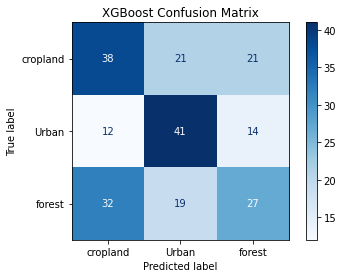

In [40]:
#Let's see the confusion matrix
disp = plot_confusion_matrix(
    grid_search, X_test, y_test, 
    cmap=plt.cm.Blues,
    display_labels=['cropland', 'Urban', 'forest'])
disp.ax_.set_title("XGBoost Confusion Matrix")
plt.show()

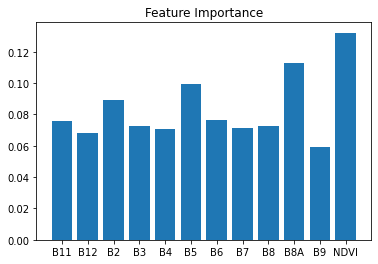

In [51]:
#Feature importance
grid_search.best_estimator_.feature_importances_

plt.bar(x = X_train.columns, height = grid_search.best_estimator_.feature_importances_)
plt.title("Feature Importance")
plt.show()


# Bonus: how to extract time-series Sentinel2 data to points

In [75]:
#First get a small subset of the entire dataset to save time
df.sort_values(by=['date'],inplace=True)
subset = df.iloc[:5,:3]
subset

,lat,long,date
52,0.357150,37.583587,2020-04-01
293,0.360634,37.587915,2020-04-15
72,3.119974,35.608017,2020-05-12
846,2.368688,38.023958,2020-05-26
7,2.329307,37.999144,2020-05-27


In [95]:
bands_s2 = ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']
def extract_timeseries_to_point(x):
    lat = x['lat']
    long = x['long']
    p = ee.Geometry.Point([long,lat])
    
    #Create an image collection with 6-month's sentinel2 images, one for each month
    d = x['date']
    date_list = [(d + timedelta(30*i)).strftime('%Y-%m-%d') for i in range(-3,4)]
    image_ls = []
    for i in range(0,6):
        s =  ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterDate(date_list[i], date_list[i+1]) \
        .sort('CLOUD_COVER') \
        .filterBounds(p).first()
        image_ls.append(s)
    img_col = ee.ImageCollection(image_ls)
    
    #Extract values from the image collection to the point of interest and save to a csv
    def extract(img):
        return img.select(bands_s2).sampleRegions(collection=p, scale=10, geometries=True)
    
    newft = ee.FeatureCollection(img_col.map(extract)).flatten()
    f = newft.getInfo()['features']
    keys = f[0]['properties'].keys()
    values = zip(f[0]['properties'].values(),f[1]['properties'].values(),f[2]['properties'].values(),f[3]['properties'].values(),f[4]['properties'].values(),f[5]['properties'].values())
    dictionary = dict(zip(keys, values))
    
    display(pd.DataFrame.from_dict(dictionary))
    pd.DataFrame.from_dict(dictionary).to_csv('timeseries/df_'+str(long)+'_'+str(lat)+'_'+d.strftime('%Y%m%d')+'.csv')
    
    return 1


In [96]:
subset.apply(extract_timeseries_to_point,axis=1)

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,1746,1288,411,741,900,1293,2330,2743,2768,2960,4046
1,1850,1262,393,678,705,1072,1848,2102,2229,2330,3027
2,1968,1494,875,1146,1194,1506,2226,2495,2536,2621,3821
3,719,522,307,379,371,500,775,932,863,954,1006
4,1794,1243,578,848,807,1278,2178,2377,2724,2510,3574
5,1979,1429,507,793,967,1325,2004,2216,2624,2490,2921


,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,2098,1606,415,675,770,1132,2057,2475,2369,2576,2706
1,2149,1665,485,709,682,1381,2418,3134,2932,3321,3226
2,2399,1897,534,800,916,1392,2296,2710,2472,2885,2910
3,6290,4973,12272,11256,10440,10927,10371,10215,10592,10027,15937
4,2131,1522,433,639,652,1182,2283,2729,2500,2824,2755
5,2962,2486,1618,1780,1924,2259,2757,3027,3002,3204,3153


,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,2307,1699,418,600,570,1076,2206,2516,2440,3005,2859
1,6001,4980,9848,9920,9728,10094,9749,9673,10072,9634,15495
2,2386,1704,789,875,815,1253,2582,2934,2668,3246,3138
3,2244,1854,502,683,620,1180,2541,2929,2700,3249,3107
4,5007,4652,4516,4540,4384,4968,4998,5047,5004,5064,10454
5,1526,1293,390,666,819,1055,1635,1915,1656,2114,1718


,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,3812,3227,3506,3436,3110,3648,4260,4477,4588,4556,6505
1,7202,5962,11144,10632,10136,10842,10284,10143,9880,9886,15801
2,5787,4942,7020,6812,6652,7097,7064,7098,6572,7108,10744
3,6719,5752,8728,8280,7828,8266,8175,8169,8164,8008,12240
4,3059,2030,1610,1838,1816,2068,2713,2992,3250,3230,3181
5,3308,3172,1908,2122,2172,2694,2962,3110,2922,3311,9278


,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,1901,1420,1009,1294,1416,1477,2351,2615,2494,2626,2431
1,3223,2807,4564,4232,3924,4256,4351,4373,3984,4394,7240
2,3392,3000,2898,2994,2858,3088,3837,4061,4094,4084,4316
3,4152,3558,4592,4052,3768,4068,4669,4881,5084,4938,7949
4,1382,851,589,682,648,970,1767,1998,1848,2117,2634
5,2400,2151,1140,1302,1328,1766,2343,2588,2348,2761,5611


52     1
293    1
72     1
846    1
7      1
dtype: int64